In [2]:
%load_ext autoreload
%autoreload 2
import math
import pprint
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import zipline
from matplotlib import style
from tqdm import tqdm_notebook
from trading_calendars.always_open import AlwaysOpenCalendar

import utils

style.use("ggplot")

In [3]:
pp = pprint.PrettyPrinter(indent=4)
COINT_RESEARCH_DATE = pd.Timestamp("2018-08-01")
BTC_MIN = 0.001
BCH_MIN = 0.01
ETH_MIN = 0.01
LTC_MIN = 0.1

# Get Data

In [36]:
data = utils.combine_market_data("candles/", "USD", "open", True, ["ZRX-USD.csv", "ETC-USD.csv"], 
                                 is_interpolate=True)
data = data.loc[:COINT_RESEARCH_DATE]
data["BTC-USD"] *= BTC_MIN
data["BCH-USD"] *= BCH_MIN
data["ETH-USD"] *= ETH_MIN
data["LTC-USD"] *= LTC_MIN
data.drop(["BTC-USD", "BCH-USD"], axis=1, inplace=True)
data = data.apply(lambda x: round(x, 3))

In [4]:
pairs_min_weights = {'ETH-USD': ETH_MIN, 'BTC-USD': BTC_MIN, 'BCH-USD': BCH_MIN, 'LTC-USD': LTC_MIN}
backtest_panel = utils.create_zipline_panel("candles/", ('ETH-USD', 'BTC-USD', 'BCH-USD', 'LTC-USD'), 
                                            pairs_min_weights)

/Users/nialeksandrov/virtualenvs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
coint_weights = np.array([1, -1.234025486537279])

# Backtest

In [12]:
start_date = datetime(2018, 9, 1, 0, 0, 0, 0, pytz.utc)
end_date = datetime(2018, 10, 1, 0, 0, 0, 0, pytz.utc)
total = (end_date - start_date).days
portfolio_value = []

WINDOW_SIZE = 1112
Z_SCORE_OPEN = 1
Z_SCORE_CLOSE = 0

with tqdm_notebook(total=total) as pbar:
    def initialize(context):
        zipline.api.set_benchmark(zipline.api.symbol("BTC-USD"))
        zipline.api.set_commission(zipline.api.commission.PerShare(cost=0, min_trade_cost=0))
        
        context.coint_weights = coint_weights
        context.assets = [zipline.api.symbol('BCH-USD'), zipline.api.symbol('LTC-USD')]
        context.z_score_open = 0
        context.is_closing_positions = False
        context.is_in_betting = False
        
        zipline.api.schedule_function(update_pbar, 
                                      date_rule=zipline.api.date_rules.every_day(),
                                      time_rule=zipline.api.time_rules.market_open(hours=1))
        
    def update_pbar(context, data):
        print(f"{zipline.api.get_datetime()}")
        pbar.update(1)
        
    def order_assets(context, data, is_long, z_score):
        portfolio_weights = data.history(context.assets, "price", 1, "1m").values[0]
        print(portfolio_weights)
        portfolio_weights *= context.coint_weights
        print(portfolio_weights)
        portfolio_weights /= np.absolute(portfolio_weights).sum()
        print(portfolio_weights)
        if not is_long:
            portfolio_weights *= -1
        
        for asset_index, asset in enumerate(context.assets):
            print(f"Order {asset} {portfolio_weights[asset_index]}")
            zipline.api.order_target_percent(asset, portfolio_weights[asset_index])
        
        context.z_score_open = z_score
        context.is_in_betting = True
        
    def close_positions(context, data):
        for order in zipline.api.get_open_orders():
            zipline.api.cancel_order(order)
            
        for asset in context.portfolio.positions.keys():
            zipline.api.order_target_percent(asset, 0)
        context.position = 0
        context.z_score_open = 0
        context.is_closing_positions = True
    
    def handle_data(context, data):
        cur_portfolio_value = context.portfolio.portfolio_value
        portfolio_value.append(cur_portfolio_value)
        coint_series = data.history(context.assets, "price", WINDOW_SIZE, "1m")
        coint_series *= context.coint_weights
        coint_series = coint_series.sum(axis=1)
        
        last_value = coint_series[-1]
        if not np.isnan(last_value):
            coint_series.interpolate(method="linear", direction="both", inplace=True)
            series_mean = coint_series.mean()
            series_std = coint_series.std()
            z_score = (last_value - series_mean) / series_std
            
            print("----------------------")
            positions_amount = len(context.portfolio.positions)
            open_orders_amount = len(zipline.api.get_open_orders()) 
            positions_value = context.portfolio.positions_value
            print(z_score, positions_amount, open_orders_amount, positions_value, cur_portfolio_value)
            #print(zipline.api.get_open_orders())
            
            if positions_amount == 0:
                context.is_closing_positions = False
            
            if context.is_closing_positions and positions_amount > 0 and open_orders_amount == 0:
                close_positions(context, data)                
            elif not context.is_closing_positions:
                if z_score > Z_SCORE_OPEN and context.z_score_open >= 0 and open_orders_amount == 0:
                    print("Shorting")
                    order_assets(context, data, False, z_score)
                elif z_score < -Z_SCORE_OPEN and context.z_score_open <= 0 and open_orders_amount == 0:
                    print("Longing")
                    order_assets(context, data, True, z_score) 
                elif (context.z_score_open > 0 and z_score < Z_SCORE_CLOSE) or\
                     (context.z_score_open < 0 and z_score > Z_SCORE_CLOSE):
                    print("Closing Positions")
                    close_positions(context, data)

    perfomance = zipline.run_algorithm(start=start_date,
                                   end=end_date,
                                   initialize=initialize,
                                   trading_calendar=AlwaysOpenCalendar(),
                                   handle_data=handle_data,
                                   capital_base=1050,
                                   data_frequency='minute',
                                   data=backtest_panel)


----------------------
-1.2984348943714845 0 0 0.0 1050.0
Longing
[5.417 6.213]
[ 5.417      -7.66700035]
[ 0.41401711 -0.58598289]
Order Equity(3 [BCH-USD]) 0.4140171091395305
Order Equity(0 [LTC-USD]) -0.5859828908604695
----------------------
-1.2960233596749449 1 2 -118.04700000000003 1049.9409765
----------------------
-1.2935421602952162 2 1 278.067 1049.7056415000002
----------------------
-1.3626331596701065 2 0 -182.19 1049.3505755
Longing
[5.417 6.218]
[ 5.417      -7.67317048]
[ 0.41382196 -0.58617804]
Order Equity(3 [BCH-USD]) 0.41382195978471303
Order Equity(0 [LTC-USD]) -0.586178040215287
----------------------
-1.6254322608220269 2 0 -184.06100000000004 1047.4795755
Longing
[5.42  6.239]
[ 5.42       -7.69908501]
[ 0.41313857 -0.58686143]
Order Equity(3 [BCH-USD]) 0.4131385684031723
Order Equity(0 [LTC-USD]) -0.5868614315968278
----------------------
-1.6075139176907367 2 0 -183.97000000000003 1047.5705755000001
Longing
[5.42  6.238]
[ 5.42       -7.69785099]
[ 0.4131774

----------------------
-1.5517431449261532 2 0 -184.32500000000005 1047.2155755
Longing
[5.436 6.255]
[ 5.436      -7.71882942]
[ 0.41323227 -0.58676773]
Order Equity(3 [BCH-USD]) 0.4132322683288998
Order Equity(0 [LTC-USD]) -0.5867677316711001
----------------------
-1.571056297141325 2 0 -184.54899999999998 1046.9915755000002
Longing
[5.434 6.255]
[ 5.434      -7.71882942]
[ 0.41314305 -0.58685695]
Order Equity(3 [BCH-USD]) 0.41314304528600765
Order Equity(0 [LTC-USD]) -0.5868569547139924
----------------------
-1.5676679875572261 2 0 -184.54899999999998 1046.9915755000002
Longing
[5.434 6.255]
[ 5.434      -7.71882942]
[ 0.41314305 -0.58685695]
Order Equity(3 [BCH-USD]) 0.41314304528600765
Order Equity(0 [LTC-USD]) -0.5868569547139924
----------------------
-1.5642805227977712 2 0 -184.54899999999998 1046.9915755000002
Longing
[5.434 6.255]
[ 5.434      -7.71882942]
[ 0.41314305 -0.58685695]
Order Equity(3 [BCH-USD]) 0.41314304528600765
Order Equity(0 [LTC-USD]) -0.5868569547139924


----------------------
-2.5920081609825862 2 0 -191.64739999999995 1038.1771126500003
Longing
[5.455 6.362]
[ 5.455      -7.85087015]
[ 0.40996943 -0.59003057]
Order Equity(3 [BCH-USD]) 0.4099694300643907
Order Equity(0 [LTC-USD]) -0.5900305699356093
----------------------
-2.4878936504961 2 0 -190.92800000000005 1038.89651265
Longing
[5.449 6.35 ]
[ 5.449      -7.83606184]
[ 0.41015993 -0.58984007]
Order Equity(3 [BCH-USD]) 0.4101599274302115
Order Equity(0 [LTC-USD]) -0.5898400725697885
----------------------
-2.3522157502221033 2 0 -190.0038 1039.8207126500001
Longing
[5.451 6.342]
[ 5.451      -7.82618964]
[ 0.41055375 -0.58944625]
Order Equity(3 [BCH-USD]) 0.41055375042443565
Order Equity(0 [LTC-USD]) -0.5894462495755645
----------------------
-2.4030857235043697 2 0 -190.40259999999995 1039.4219126500002
Longing
[5.443 6.34 ]
[ 5.443      -7.82372158]
[ 0.41027468 -0.58972532]
Order Equity(3 [BCH-USD]) 0.4102746835585375
Order Equity(0 [LTC-USD]) -0.5897253164414625
-------------

----------------------
-1.6664667839187544 2 0 -186.38419999999996 1043.4403126500001
Longing
[5.44  6.296]
[ 5.44       -7.76942446]
[ 0.41182718 -0.58817282]
Order Equity(3 [BCH-USD]) 0.41182717802272906
Order Equity(0 [LTC-USD]) -0.5881728219772709
----------------------
-1.66269217913246 2 0 -186.38419999999996 1043.4403126500001
Longing
[5.44  6.296]
[ 5.44       -7.76942446]
[ 0.41182718 -0.58817282]
Order Equity(3 [BCH-USD]) 0.41182717802272906
Order Equity(0 [LTC-USD]) -0.5881728219772709
----------------------
-1.658959985393354 2 0 -186.38419999999996 1043.4403126500001
Longing
[5.44  6.296]
[ 5.44       -7.76942446]
[ 0.41182718 -0.58817282]
Order Equity(3 [BCH-USD]) 0.41182717802272906
Order Equity(0 [LTC-USD]) -0.5881728219772709
----------------------
-1.6552442705833066 2 0 -186.38419999999996 1043.4403126500001
Longing
[5.44  6.296]
[ 5.44       -7.76942446]
[ 0.41182718 -0.58817282]
Order Equity(3 [BCH-USD]) 0.41182717802272906
Order Equity(0 [LTC-USD]) -0.588172821977

----------------------
-2.1286739365626097 2 0 -191.33100000000002 1038.49351265
Longing
[5.46  6.363]
[ 5.46       -7.85210417]
[ 0.41015304 -0.58984696]
Order Equity(3 [BCH-USD]) 0.41015304041576034
Order Equity(0 [LTC-USD]) -0.5898469595842396
----------------------
-2.122650153551652 2 0 -191.33100000000002 1038.49351265
Longing
[5.46  6.363]
[ 5.46       -7.85210417]
[ 0.41015304 -0.58984696]
Order Equity(3 [BCH-USD]) 0.41015304041576034
Order Equity(0 [LTC-USD]) -0.5898469595842396
----------------------
-2.116572147647555 2 0 -191.33100000000002 1038.49351265
Longing
[5.46  6.363]
[ 5.46       -7.85210417]
[ 0.41015304 -0.58984696]
Order Equity(3 [BCH-USD]) 0.41015304041576034
Order Equity(0 [LTC-USD]) -0.5898469595842396
----------------------
-2.074791077705266 2 0 -191.04000000000008 1038.7845126500001
Longing
[5.46 6.36]
[ 5.46       -7.84840209]
[ 0.41026714 -0.58973286]
Order Equity(3 [BCH-USD]) 0.41026713509857754
Order Equity(0 [LTC-USD]) -0.5897328649014225
------------

----------------------
-1.4218032604776287 2 0 -186.764 1043.06051265
Longing
[5.48  6.332]
[ 5.48       -7.81384938]
[ 0.41222071 -0.58777929]
Order Equity(3 [BCH-USD]) 0.4122207077156733
Order Equity(0 [LTC-USD]) -0.5877792922843267
----------------------
-1.4074117671636102 2 0 -186.66700000000003 1043.1575126500002
Longing
[5.48  6.331]
[ 5.48       -7.81261536]
[ 0.41225898 -0.58774102]
Order Equity(3 [BCH-USD]) 0.4122589763968774
Order Equity(0 [LTC-USD]) -0.5877410236031226
----------------------
-1.4162499002816515 2 0 -186.764 1043.06051265
Longing
[5.48  6.332]
[ 5.48       -7.81384938]
[ 0.41222071 -0.58777929]
Order Equity(3 [BCH-USD]) 0.4122207077156733
Order Equity(0 [LTC-USD]) -0.5877792922843267
----------------------
-1.4134250664976105 2 0 -186.7718000000001 1043.05271265
Longing
[5.48  6.332]
[ 5.48       -7.81384938]
[ 0.41222071 -0.58777929]
Order Equity(3 [BCH-USD]) 0.4122207077156733
Order Equity(0 [LTC-USD]) -0.5877792922843267
----------------------
-1.41061745

----------------------
-1.3127042442110206 2 0 -186.76940000000002 1043.05511265
Longing
[5.525 6.368]
[ 5.525     -7.8582743]
[ 0.41282872 -0.58717128]
Order Equity(3 [BCH-USD]) 0.4128287201521711
Order Equity(0 [LTC-USD]) -0.5871712798478288
----------------------
-1.3900917819520824 2 0 -187.45619999999997 1042.36831265
Longing
[5.525 6.375]
[ 5.525      -7.86691248]
[ 0.41256243 -0.58743757]
Order Equity(3 [BCH-USD]) 0.4125624334554871
Order Equity(0 [LTC-USD]) -0.587437566544513
----------------------
-1.3177788524671143 2 0 -186.83900000000006 1042.9855126500001
Longing
[5.535 6.377]
[ 5.535      -7.86938053]
[ 0.41292471 -0.58707529]
Order Equity(3 [BCH-USD]) 0.4129247143188276
Order Equity(0 [LTC-USD]) -0.5870752856811724
----------------------
-1.3565658668930198 2 0 -187.2124 1042.6121126500002
Longing
[5.533 6.379]
[ 5.533      -7.87184858]
[ 0.4127611 -0.5872389]
Order Equity(3 [BCH-USD]) 0.41276109666947636
Order Equity(0 [LTC-USD]) -0.5872389033305236
--------------------

----------------------
-0.7788743384582143 2 0 -176.53680000000008 1046.90152115
----------------------
-0.7547059197510932 2 0 -176.34480000000008 1047.09352115
----------------------
-0.7532821019993432 2 0 -176.35260000000005 1047.0857211500002
----------------------
-0.7404899937605884 2 0 -176.25660000000005 1047.1817211500002
----------------------
-0.6936275244462168 2 0 -175.86480000000006 1047.57352115
----------------------
-0.7567156031969543 2 0 -176.44979999999998 1046.98852115
----------------------
-0.7439076854586706 2 0 -176.37720000000002 1047.06112115
----------------------
-0.8275426498271512 2 0 -177.0426 1046.39572115
----------------------
-0.8260111456209531 2 0 -177.0426 1046.39572115
----------------------
-0.8038977857537632 2 0 -176.86079999999998 1046.5775211500002
----------------------
-0.8137670124791144 2 0 -176.9568 1046.4815211500002
----------------------
-0.846376387319074 2 0 -177.2448 1046.1935211500002
----------------------
-0.8134331543466602 2

----------------------
-1.2115566942857119 2 0 -181.32960000000003 1042.10872115
Longing
[5.5128 6.368 ]
[ 5.5128    -7.8582743]
[ 0.41229297 -0.58770703]
Order Equity(3 [BCH-USD]) 0.4122929748968276
Order Equity(0 [LTC-USD]) -0.5877070251031724
----------------------
-1.2571366239447952 2 0 -181.7298 1041.70852115
Longing
[5.509 6.369]
[ 5.509      -7.85950832]
[ 0.41208786 -0.58791214]
Order Equity(3 [BCH-USD]) 0.41208786100768396
Order Equity(0 [LTC-USD]) -0.587912138992316
----------------------
-1.243604482570848 2 0 -181.6338 1041.80452115
Longing
[5.5089 6.368 ]
[ 5.5089    -7.8582743]
[ 0.41212151 -0.58787849]
Order Equity(3 [BCH-USD]) 0.41212150579297974
Order Equity(0 [LTC-USD]) -0.5878784942070203
----------------------
-1.3255458466083672 2 0 -182.32260000000002 1041.1157211500001
Longing
[5.501 6.369]
[ 5.501      -7.85950832]
[ 0.41173583 -0.58826417]
Order Equity(3 [BCH-USD]) 0.4117358312047778
Order Equity(0 [LTC-USD]) -0.5882641687952223
----------------------
-1.17681

[5.5097 6.363 ]
[ 5.5097     -7.85210417]
[ 0.41234701 -0.58765299]
Order Equity(3 [BCH-USD]) 0.412347010145935
Order Equity(0 [LTC-USD]) -0.587652989854065
----------------------
-1.1102257200424863 2 0 -181.09140000000002 1042.34692115
Longing
[5.5097 6.363 ]
[ 5.5097     -7.85210417]
[ 0.41234701 -0.58765299]
Order Equity(3 [BCH-USD]) 0.412347010145935
Order Equity(0 [LTC-USD]) -0.587652989854065
----------------------
-1.1082102933498381 2 0 -181.09140000000002 1042.34692115
Longing
[5.51  6.363]
[ 5.51       -7.85210417]
[ 0.4123602 -0.5876398]
Order Equity(3 [BCH-USD]) 0.4123602038686228
Order Equity(0 [LTC-USD]) -0.5876397961313772
----------------------
-1.1061983419937433 2 0 -181.09140000000002 1042.34692115
Longing
[5.51  6.363]
[ 5.51       -7.85210417]
[ 0.4123602 -0.5876398]
Order Equity(3 [BCH-USD]) 0.4123602038686228
Order Equity(0 [LTC-USD]) -0.5876397961313772
----------------------
-1.1041905960802867 2 0 -181.09140000000002 1042.34692115
Longing
[5.51  6.363]
[ 5.51

----------------------
-0.7152940134557048 2 0 -178.86599999999987 1044.5723211500003
----------------------
-0.7259575725900783 2 0 -178.962 1044.47632115
----------------------
-0.712658711090433 2 0 -178.86599999999987 1044.5723211500003
----------------------
-0.687285429581695 2 0 -178.68179999999995 1044.75652115
----------------------
-0.6859855162039912 2 0 -178.68179999999995 1044.75652115
----------------------
-0.6967683289366284 2 0 -178.77779999999996 1044.66052115
----------------------
-0.6954670164034219 2 0 -178.76999999999998 1044.66832115
----------------------
-0.6820347730341265 2 0 -178.65060000000005 1044.78772115
----------------------
-0.6928976814671672 2 0 -178.74660000000006 1044.69172115
----------------------
-0.6916283387737816 2 0 -178.74660000000006 1044.69172115
----------------------
-0.6903195132368282 2 0 -178.74660000000006 1044.69172115
----------------------
-0.6890231572668102 2 0 -178.74660000000006 1044.69172115
----------------------
-0.67550

----------------------
-0.6207123342453355 2 0 -179.154 1044.28432115
----------------------
-0.6349757832712475 2 0 -179.25 1044.18832115
----------------------
-0.6338426889263298 2 0 -179.25 1044.18832115
----------------------
-0.4779667605282898 2 0 -178.28999999999996 1045.1483211500001
----------------------
-0.5697009818476352 2 0 -178.86599999999999 1044.57232115
----------------------
-0.5373451726549044 2 0 -178.67399999999998 1044.7643211500001
----------------------
-0.4825243941167125 2 0 -178.37520000000006 1045.06312115
----------------------
-0.48117484864195803 2 0 -178.37520000000006 1045.06312115
----------------------
-0.4798087011573901 2 0 -178.37520000000006 1045.06312115
----------------------
-0.4431644293535206 2 0 -178.09680000000003 1045.34152115
----------------------
-0.4417426523888929 2 0 -178.09680000000003 1045.34152115
----------------------
-0.4403064937534602 2 0 -178.08900000000006 1045.34932115
----------------------
-0.487072626975466 2 0 -178.4

----------------------
-0.5569474726033612 2 0 -179.43120000000005 1044.00712115
----------------------
-0.5557678954572841 2 0 -179.43120000000005 1044.00712115
----------------------
-0.5546313046007688 2 0 -179.43120000000005 1044.00712115
----------------------
-0.6478410860971057 2 0 -179.75640000000004 1043.68192115
----------------------
-0.5242629307369988 2 0 -179.28420000000006 1044.15412115
----------------------
-0.5674257572711106 2 0 -179.48160000000001 1043.95672115
----------------------
-0.6659570498163503 2 0 -179.83259999999996 1043.6057211500001
----------------------
-0.5719908596841434 2 0 -179.46480000000003 1043.9735211500001
----------------------
-0.6356212257229493 2 0 -179.70900000000012 1043.72932115
----------------------
-0.5694525863955164 2 0 -179.46480000000003 1043.9735211500001
----------------------
-0.2694845092074429 2 0 -178.31279999999998 1045.1255211500002
----------------------
0.2818156482983954 2 0 -176.20080000000002 1047.23752115
Closing P

----------------------
0.33230727313796077 2 0 181.75600000000009 1048.54774895
----------------------
0.6461695694498519 2 0 180.60810000000004 1047.39984895
----------------------
0.5706026622119966 2 0 180.89610000000005 1047.68784895
----------------------
0.5977107817477182 2 0 180.80010000000004 1047.59184895
----------------------
0.34194748692729904 2 0 181.76010000000008 1048.55184895
----------------------
0.343782238393827 2 0 181.76010000000008 1048.55184895
----------------------
0.2680753946937314 2 0 182.0481000000001 1048.83984895
----------------------
0.06280467030358644 2 0 182.8161 1049.60784895
----------------------
0.2193336490990398 2 0 182.24779999999998 1049.03954895
----------------------
0.09134727724926196 2 0 182.7278 1049.51954895
----------------------
0.27401258202043405 2 0 182.0481000000001 1048.83984895
----------------------
0.3522731564403696 2 0 181.76010000000008 1048.55184895
----------------------
0.3525789184692936 2 0 181.76010000000008 1048.

----------------------
5.421433354198461 2 0 142.0096000000001 1026.52240655
Shorting
[6.004 6.443]
[ 6.004      -7.95082621]
[ 0.43024542 -0.56975458]
Order Equity(3 [BCH-USD]) -0.4302454154392076
Order Equity(0 [LTC-USD]) 0.5697545845607924
----------------------
5.219744855387085 2 0 142.62819999999994 1027.1410065499997
Shorting
[5.998 6.445]
[ 5.998      -7.95329426]
[ 0.42992427 -0.57007573]
Order Equity(3 [BCH-USD]) -0.4299242699569414
Order Equity(0 [LTC-USD]) 0.5700757300430586
----------------------
5.153264050996279 2 0 142.6356 1027.14840655
Shorting
[5.998 6.445]
[ 5.998      -7.95329426]
[ 0.42992427 -0.57007573]
Order Equity(3 [BCH-USD]) -0.4299242699569414
Order Equity(0 [LTC-USD]) 0.5700757300430586
----------------------
5.0894016580219255 2 0 142.6356 1027.14840655
Shorting
[5.998 6.445]
[ 5.998      -7.95329426]
[ 0.42992427 -0.57007573]
Order Equity(3 [BCH-USD]) -0.4299242699569414
Order Equity(0 [LTC-USD]) 0.5700757300430586
----------------------
5.11479692834059

----------------------
3.205531819629805 2 0 144.72099999999995 1030.1581350499998
Shorting
[6.11  6.569]
[ 6.11       -8.10631342]
[ 0.42978794 -0.57021206]
Order Equity(3 [BCH-USD]) -0.42978793580529895
Order Equity(0 [LTC-USD]) 0.5702120641947012
----------------------
3.0520236030200314 2 0 145.6182 1031.05533505
Shorting
[6.11  6.579]
[ 6.11       -8.11865368]
[ 0.42941519 -0.57058481]
Order Equity(3 [BCH-USD]) -0.4294151884753901
Order Equity(0 [LTC-USD]) 0.5705848115246099
----------------------
3.221439225909334 2 0 144.37919999999997 1029.81633505
Shorting
[6.123 6.576]
[ 6.123     -8.1149516]
[ 0.43004782 -0.56995218]
Order Equity(3 [BCH-USD]) -0.4300478167258479
Order Equity(0 [LTC-USD]) 0.5699521832741521
----------------------
3.32259098213515 2 0 143.62679999999995 1029.0639350499998
Shorting
[6.156 6.594]
[ 6.156      -8.13716406]
[ 0.4306954 -0.5693046]
Order Equity(3 [BCH-USD]) -0.4306953992077595
Order Equity(0 [LTC-USD]) 0.5693046007922405
----------------------
3.17

----------------------
3.0926952172791236 2 0 137.6064 1023.3961155499999
Shorting
[6.25  6.606]
[ 6.25       -8.15197236]
[ 0.43396834 -0.56603166]
Order Equity(3 [BCH-USD]) -0.43396833725320405
Order Equity(0 [LTC-USD]) 0.566031662746796
----------------------
3.229926496295861 2 0 136.26879999999994 1022.0585155499998
Shorting
[6.267 6.605]
[ 6.267      -8.15073834]
[ 0.43467289 -0.56532711]
Order Equity(3 [BCH-USD]) -0.434672890631596
Order Equity(0 [LTC-USD]) 0.5653271093684039
----------------------
3.202022013017737 2 0 136.35680000000002 1022.1465155499999
Shorting
[6.267 6.606]
[ 6.267      -8.15197236]
[ 0.43463569 -0.56536431]
Order Equity(3 [BCH-USD]) -0.43463568982339673
Order Equity(0 [LTC-USD]) 0.5653643101766033
----------------------
3.2360178331095537 2 0 135.91679999999997 1021.7065155499998
Shorting
[6.267 6.601]
[ 6.267      -8.14580224]
[ 0.43482176 -0.56517824]
Order Equity(3 [BCH-USD]) -0.4348217575671272
Order Equity(0 [LTC-USD]) 0.5651782424328727
------------

----------------------
2.308193532090939 2 0 139.62709999999998 1025.41681555
Shorting
[6.22  6.605]
[ 6.22       -8.15073834]
[ 0.43282397 -0.56717603]
Order Equity(3 [BCH-USD]) -0.4328239686406509
Order Equity(0 [LTC-USD]) 0.567176031359349
----------------------
2.1858431183714653 2 0 140.76400000000012 1026.55371555
Shorting
[6.22  6.618]
[ 6.22       -8.16678067]
[ 0.43234134 -0.56765866]
Order Equity(3 [BCH-USD]) -0.4323413376984239
Order Equity(0 [LTC-USD]) 0.567658662301576
----------------------
2.1439452207875807 2 0 141.11599999999999 1026.90571555
Shorting
[6.22  6.622]
[ 6.22       -8.17171677]
[ 0.43219305 -0.56780695]
Order Equity(3 [BCH-USD]) -0.43219305233732047
Order Equity(0 [LTC-USD]) 0.5678069476626796
----------------------
2.193007324642055 2 0 140.57920000000007 1026.3689155499999
Shorting
[6.229 6.623]
[ 6.229     -8.1729508]
[ 0.43251085 -0.56748915]
Order Equity(3 [BCH-USD]) -0.4325108513182836
Order Equity(0 [LTC-USD]) 0.5674891486817163
--------------------

----------------------
1.6367532037570232 2 0 144.03199999999998 1029.82171555
Shorting
[6.2   6.639]
[ 6.2        -8.19269521]
[ 0.43077408 -0.56922592]
Order Equity(3 [BCH-USD]) -0.43077407751912977
Order Equity(0 [LTC-USD]) 0.5692259224808701
----------------------
1.6313953968830017 2 0 144.06619999999992 1029.8559155499997
Shorting
[6.196 6.636]
[ 6.196      -8.18899313]
[ 0.43072666 -0.56927334]
Order Equity(3 [BCH-USD]) -0.4307266569112764
Order Equity(0 [LTC-USD]) 0.5692733430887237
----------------------
1.6474830709057493 2 0 143.87749999999994 1029.6672155499998
Shorting
[6.194 6.632]
[ 6.194      -8.18405703]
[ 0.43079534 -0.56920466]
Order Equity(3 [BCH-USD]) -0.43079534240900574
Order Equity(0 [LTC-USD]) 0.5692046575909943
----------------------
1.6211164518935797 2 0 144.11740000000003 1029.9071155499998
Shorting
[6.193 6.634]
[ 6.193      -8.18652508]
[ 0.43068182 -0.56931818]
Order Equity(3 [BCH-USD]) -0.4306818178306347
Order Equity(0 [LTC-USD]) 0.5693181821693654
---

----------------------
1.1705233668619044 2 0 147.86619999999994 1033.1604401
Shorting
[6.192 6.671]
[ 6.192      -8.23218402]
[ 0.42927905 -0.57072095]
Order Equity(3 [BCH-USD]) -0.4292790490691283
Order Equity(0 [LTC-USD]) 0.5707209509308717
----------------------
1.1800096414669166 2 0 147.76400000000007 1033.0582401
Shorting
[6.2   6.676]
[ 6.2        -8.23835415]
[ 0.42941182 -0.57058818]
Order Equity(3 [BCH-USD]) -0.4294118246715855
Order Equity(0 [LTC-USD]) 0.5705881753284144
----------------------
1.1842412115940406 2 0 147.69920000000002 1032.9934401
Shorting
[6.201 6.676]
[ 6.201      -8.23835415]
[ 0.42945134 -0.57054866]
Order Equity(3 [BCH-USD]) -0.4294513408555835
Order Equity(0 [LTC-USD]) 0.5705486591444165
----------------------
1.1666471966770966 2 0 147.8556000000001 1033.1498401
Shorting
[6.201 6.678]
[ 6.201     -8.2408222]
[ 0.42937795 -0.57062205]
Order Equity(3 [BCH-USD]) -0.42937794929978984
Order Equity(0 [LTC-USD]) 0.5706220507002102
----------------------
1.1

----------------------
1.0224641660958278 2 0 141.6544 1033.6452900999998
Shorting
[6.185 6.67 ]
[ 6.185   -8.23095]
[ 0.42903867 -0.57096133]
Order Equity(3 [BCH-USD]) -0.4290386691170418
Order Equity(0 [LTC-USD]) 0.5709613308829582
----------------------
0.956761377018146 2 0 142.3768 1034.3676901
----------------------
0.9550696667747105 2 0 142.348 1034.3388900999998
----------------------
1.1210826717327327 2 0 140.45600000000007 1032.4468901
Shorting
[6.188 6.659]
[ 6.188      -8.21737571]
[ 0.42956186 -0.57043814]
Order Equity(3 [BCH-USD]) -0.4295618609669624
Order Equity(0 [LTC-USD]) 0.5704381390330376
----------------------
1.3318887759597526 2 0 137.9720000000001 1029.9628901
Shorting
[6.222 6.659]
[ 6.222      -8.21737571]
[ 0.43090506 -0.56909494]
Order Equity(3 [BCH-USD]) -0.4309050559298287
Order Equity(0 [LTC-USD]) 0.5690949440701712
----------------------
1.2994844237638168 2 0 138.35199999999998 1030.3428900999997
Shorting
[6.216 6.658]
[ 6.216      -8.21614169]
[ 0.43

----------------------
0.7141243421094846 2 0 143.37360000000007 1035.3644901
----------------------
0.6627398647848816 2 0 143.92000000000002 1035.9108901
----------------------
0.7001871125223056 2 0 143.50160000000005 1035.4924901
----------------------
0.7382659308903157 2 0 143.0616 1035.0524900999999
----------------------
0.6823176376488662 2 0 143.656 1035.6468900999998
----------------------
0.641109142703729 2 0 144.10400000000004 1036.0948901
----------------------
0.6397923466734469 2 0 144.10400000000004 1036.0948901
----------------------
0.6384915044269368 2 0 144.10400000000004 1036.0948901
----------------------
0.637182200747894 2 0 144.0968000000001 1036.0876901
----------------------
0.6678945372460501 2 0 143.75840000000005 1035.7492901
----------------------
0.6409523669298187 2 0 144.01760000000007 1036.0084901
----------------------
0.6783528144804202 2 0 143.60080000000005 1035.5916901
----------------------
0.7425615547553029 2 0 142.8648 1034.8556901
--------

----------------------
0.8135926636692686 2 0 147.06880000000007 1032.4593916
----------------------
0.7609052820432305 2 0 147.60620000000006 1032.9967916
----------------------
0.8350164926108973 2 0 146.80180000000001 1032.1923915999998
----------------------
0.7675379789805872 2 0 147.493 1032.8835915999998
----------------------
0.8320193228653395 2 0 146.80180000000001 1032.1923915999998
----------------------
0.8630422189879153 2 0 146.44580000000002 1031.8363915999998
----------------------
0.8777481882436228 2 0 146.27499999999998 1031.6655916
----------------------
0.9494635363772553 2 0 145.4668000000001 1030.8573916
----------------------
0.9477732303353864 2 0 145.47400000000005 1030.8645916
----------------------
0.9868475341430943 2 0 145.02180000000004 1030.4123915999999
----------------------
0.985113062428165 2 0 145.029 1030.4195915999999
----------------------
1.0825030280313466 2 0 143.94899999999996 1029.3395916
Shorting
[6.185 6.621]
[ 6.185      -8.17048275]
[ 0

[6.062 6.514]
[ 6.062      -8.03844202]
[ 0.4299156 -0.5700844]
Order Equity(3 [BCH-USD]) -0.4299156006386877
Order Equity(0 [LTC-USD]) 0.5700843993613122
----------------------
1.2524712764257881 2 0 147.64680000000004 1026.5291390999998
Shorting
[6.093 6.515]
[ 6.093      -8.03967604]
[ 0.43112854 -0.56887146]
Order Equity(3 [BCH-USD]) -0.43112854074413026
Order Equity(0 [LTC-USD]) 0.5688714592558697
----------------------
1.2100121860950341 2 0 148.0716 1026.9539390999998
Shorting
[6.087 6.515]
[ 6.087      -8.03967604]
[ 0.43088692 -0.56911308]
Order Equity(3 [BCH-USD]) -0.43088692490012614
Order Equity(0 [LTC-USD]) 0.5691130750998739
----------------------
1.1995757737352812 2 0 148.16160000000002 1027.0439391
Shorting
[6.087 6.516]
[ 6.087      -8.04091007]
[ 0.43084929 -0.56915071]
Order Equity(3 [BCH-USD]) -0.43084928837466
Order Equity(0 [LTC-USD]) 0.5691507116253399
----------------------
1.1974333551569103 2 0 148.16880000000003 1027.0511391
Shorting
[6.087 6.516]
[ 6.087   

----------------------
1.171670710023929 2 0 141.57270000000005 1026.5003149499998
Shorting
[6.02  6.456]
[ 6.02       -7.96686854]
[ 0.4304037 -0.5695963]
Order Equity(3 [BCH-USD]) -0.4304037020378796
Order Equity(0 [LTC-USD]) 0.5695962979621204
----------------------
1.1763865700419953 2 0 141.507 1026.43461495
Shorting
[6.021 6.456]
[ 6.021      -7.96686854]
[ 0.43044442 -0.56955558]
Order Equity(3 [BCH-USD]) -0.4304444227735864
Order Equity(0 [LTC-USD]) 0.5695555772264137
----------------------
1.181095416234162 2 0 141.44130000000007 1026.36891495
Shorting
[6.022 6.456]
[ 6.022      -7.96686854]
[ 0.43048514 -0.56951486]
Order Equity(3 [BCH-USD]) -0.43048513768741614
Order Equity(0 [LTC-USD]) 0.5695148623125839
----------------------
1.1909752566762808 2 0 141.29039999999998 1026.21801495
Shorting
[6.025 6.457]
[ 6.025      -7.96810257]
[ 0.43056927 -0.56943073]
Order Equity(3 [BCH-USD]) -0.43056927306410303
Order Equity(0 [LTC-USD]) 0.569430726935897
----------------------
1.3713

----------------------
0.9688252892363317 2 0 142.9744 1027.90201495
----------------------
0.9308154197688526 2 0 143.3634 1028.2910149499999
----------------------
0.9207902666000966 2 0 143.46800000000002 1028.39561495
----------------------
0.9191799489363007 2 0 143.46800000000002 1028.39561495
----------------------
1.0101056966930464 2 0 142.48530000000005 1027.41291495
Shorting
[6.094 6.526]
[ 6.094      -8.05325033]
[ 0.43075508 -0.56924492]
Order Equity(3 [BCH-USD]) -0.430755083846211
Order Equity(0 [LTC-USD]) 0.5692449161537889
----------------------
1.0083901942499227 2 0 142.478 1027.40561495
Shorting
[6.094 6.526]
[ 6.094      -8.05325033]
[ 0.43075508 -0.56924492]
Order Equity(3 [BCH-USD]) -0.430755083846211
Order Equity(0 [LTC-USD]) 0.5692449161537889
----------------------
1.056034471226223 2 0 141.92810000000003 1026.85571495
Shorting
[6.1   6.525]
[ 6.1       -8.0520163]
[ 0.43103399 -0.56896601]
Order Equity(3 [BCH-USD]) -0.4310339863124935
Order Equity(0 [LTC-USD])

Order Equity(0 [LTC-USD]) 0.5646133850113882
----------------------
1.6351308414395953 2 0 134.39799999999997 1020.0124447499998
Shorting
[6.27  6.586]
[ 6.27       -8.12729185]
[ 0.43549857 -0.56450143]
Order Equity(3 [BCH-USD]) -0.4354985689973578
Order Equity(0 [LTC-USD]) 0.5645014310026422
----------------------
1.6237511496550328 2 0 134.49310000000008 1020.10754475
Shorting
[6.27  6.587]
[ 6.27       -8.12852588]
[ 0.43546124 -0.56453876]
Order Equity(3 [BCH-USD]) -0.43546124459776453
Order Equity(0 [LTC-USD]) 0.5645387554022355
----------------------
1.530499123041628 2 0 135.39069999999998 1021.0051447499998
Shorting
[6.252 6.583]
[ 6.252      -8.12358978]
[ 0.4349039 -0.5650961]
Order Equity(3 [BCH-USD]) -0.434903895882052
Order Equity(0 [LTC-USD]) 0.5650961041179481
----------------------
1.5518919287442297 2 0 135.13660000000004 1020.7510447499999
Shorting
[6.253 6.581]
[ 6.253      -8.12112173]
[ 0.43501788 -0.56498212]
Order Equity(3 [BCH-USD]) -0.43501788274807923
Order E

----------------------
2.3375784859615942 2 0 117.32850000000008 1009.8135922499998
Shorting
[6.448 6.615]
[ 6.448      -8.16307859]
[ 0.44130897 -0.55869103]
Order Equity(3 [BCH-USD]) -0.4413089669432876
Order Equity(0 [LTC-USD]) 0.5586910330567124
----------------------
2.5785975453073324 2 0 114.75099999999992 1007.2360922499997
Shorting
[6.476 6.607]
[ 6.476      -8.15320639]
[ 0.4426761 -0.5573239]
Order Equity(3 [BCH-USD]) -0.44267609790679874
Order Equity(0 [LTC-USD]) 0.5573239020932013
----------------------
2.650452054305262 2 0 113.90100000000001 1006.3860922499998
Shorting
[6.476 6.597]
[ 6.476      -8.14086613]
[ 0.44304983 -0.55695017]
Order Equity(3 [BCH-USD]) -0.4430498261615863
Order Equity(0 [LTC-USD]) 0.5569501738384138
----------------------
2.6346231412469012 2 0 113.99759999999998 1006.4826922499997
Shorting
[6.475 6.597]
[ 6.475      -8.14086613]
[ 0.44301172 -0.55698828]
Order Equity(3 [BCH-USD]) -0.4430117202998668
Order Equity(0 [LTC-USD]) 0.5569882797001332
--

[6.55  6.656]
[ 6.55       -8.21367364]
[ 0.44365652 -0.55634348]
Order Equity(3 [BCH-USD]) -0.44365651533823414
Order Equity(0 [LTC-USD]) 0.556343484661766
----------------------
2.390727580284588 2 0 113.32360000000017 1005.9140712499999
Shorting
[6.559 6.659]
[ 6.559      -8.21737571]
[ 0.44388422 -0.55611578]
Order Equity(3 [BCH-USD]) -0.4438842194170487
Order Equity(0 [LTC-USD]) 0.5561157805829513
----------------------
2.3920100076546307 2 0 113.2328 1005.8232712499997
Shorting
[6.559 6.658]
[ 6.559      -8.21614169]
[ 0.44392129 -0.55607871]
Order Equity(3 [BCH-USD]) -0.4439212927968746
Order Equity(0 [LTC-USD]) 0.5560787072031254
----------------------
2.393290565867885 2 0 113.17599999999999 1005.7664712499998
Shorting
[6.559 6.657]
[ 6.559      -8.21490766]
[ 0.44395837 -0.55604163]
Order Equity(3 [BCH-USD]) -0.44395837236998364
Order Equity(0 [LTC-USD]) 0.5560416276300163
----------------------
2.3376511390956427 2 0 113.74720000000002 1006.3376712499997
Shorting
[6.551 6.65

[6.47  6.645]
[ 6.47       -8.20009936]
[ 0.44103314 -0.55896686]
Order Equity(3 [BCH-USD]) -0.4410331410914403
Order Equity(0 [LTC-USD]) 0.5589668589085597
----------------------
1.796620271111519 2 0 117.70500000000004 1010.1123335499998
Shorting
[6.48  6.645]
[ 6.48       -8.20009936]
[ 0.44141391 -0.55858609]
Order Equity(3 [BCH-USD]) -0.4414139061293843
Order Equity(0 [LTC-USD]) 0.5585860938706156
----------------------
1.9223155610127391 2 0 116.26659999999998 1008.6739335499997
Shorting
[6.484 6.631]
[ 6.484    -8.182823]
[ 0.4420862 -0.5579138]
Order Equity(3 [BCH-USD]) -0.44208619681691186
Order Equity(0 [LTC-USD]) 0.5579138031830881
----------------------
2.060277744726775 2 0 114.625 1007.0323335499997
Shorting
[6.5   6.625]
[ 6.5        -8.17541885]
[ 0.44291751 -0.55708249]
Order Equity(3 [BCH-USD]) -0.44291751173757904
Order Equity(0 [LTC-USD]) 0.5570824882624209
----------------------
2.0186842409552055 2 0 115.04999999999995 1007.4573335499997
Shorting
[6.5  6.63]
[ 6.5

----------------------
1.811893725843534 2 0 116.19910000000004 1008.6064335499998
Shorting
[6.551 6.685]
[ 6.551      -8.24946038]
[ 0.44262137 -0.55737863]
Order Equity(3 [BCH-USD]) -0.442621366694662
Order Equity(0 [LTC-USD]) 0.557378633305338
----------------------
1.8097974499234493 2 0 116.21760000000006 1008.6249335499998
Shorting
[6.55  6.684]
[ 6.55       -8.24822635]
[ 0.44262061 -0.55737939]
Order Equity(3 [BCH-USD]) -0.4426206116997286
Order Equity(0 [LTC-USD]) 0.5573793883002713
----------------------
1.8625935870144148 2 0 115.57270000000005 1007.9800335499998
Shorting
[6.542 6.67 ]
[ 6.542   -8.23095]
[ 0.4428364 -0.5571636]
Order Equity(3 [BCH-USD]) -0.44283640045650985
Order Equity(0 [LTC-USD]) 0.5571635995434902
----------------------
1.7237216982179842 2 0 117.10669999999993 1009.5140335499997
Shorting
[6.521 6.671]
[ 6.521      -8.23218402]
[ 0.44200628 -0.55799372]
Order Equity(3 [BCH-USD]) -0.4420062808716279
Order Equity(0 [LTC-USD]) 0.5579937191283721
----------

----------------------
1.6387904780216211 2 0 116.51150000000007 1008.9188335499998
Shorting
[6.4665 6.62  ]
[ 6.4665     -8.16924872]
[ 0.44182912 -0.55817088]
Order Equity(3 [BCH-USD]) -0.44182912151094994
Order Equity(0 [LTC-USD]) 0.5581708784890501
----------------------
1.620804715100732 2 0 116.68150000000003 1009.0888335499998
Shorting
[6.466 6.622]
[ 6.466      -8.17171677]
[ 0.44173556 -0.55826444]
Order Equity(3 [BCH-USD]) -0.4417355589523987
Order Equity(0 [LTC-USD]) 0.5582644410476013
----------------------
1.6103711944687638 2 0 116.76650000000006 1009.1738335499998
Shorting
[6.4665 6.623 ]
[ 6.4665    -8.1729508]
[ 0.44171739 -0.55828261]
Order Equity(3 [BCH-USD]) -0.44171739018901984
Order Equity(0 [LTC-USD]) 0.5582826098109802
----------------------
1.6985438711136684 2 0 115.74530000000004 1008.1526335499998
Shorting
[6.481 6.623]
[ 6.481     -8.1729508]
[ 0.44226981 -0.55773019]
Order Equity(3 [BCH-USD]) -0.44226980761925516
Order Equity(0 [LTC-USD]) 0.557730192380744

----------------------
1.6693390845750637 2 0 114.86360000000008 1007.2709335499999
Shorting
[6.476 6.608]
[ 6.476      -8.15444042]
[ 0.44263876 -0.55736124]
Order Equity(3 [BCH-USD]) -0.44263875975623046
Order Equity(0 [LTC-USD]) 0.5573612402437695
----------------------
1.6462072720892653 2 0 115.09070000000003 1007.4980335499997
Shorting
[6.48  6.614]
[ 6.48       -8.16184457]
[ 0.44256719 -0.55743281]
Order Equity(3 [BCH-USD]) -0.44256718953163393
Order Equity(0 [LTC-USD]) 0.557432810468366
----------------------
1.6135713728792271 2 0 115.41500000000002 1007.8223335499997
Shorting
[6.475 6.614]
[ 6.475      -8.16184457]
[ 0.44237677 -0.55762323]
Order Equity(3 [BCH-USD]) -0.4423767684310066
Order Equity(0 [LTC-USD]) 0.5576232315689934
----------------------
1.6148348248134357 2 0 115.35039999999998 1007.7577335499998
Shorting
[6.478 6.616]
[ 6.478      -8.16431262]
[ 0.44241645 -0.55758355]
Order Equity(3 [BCH-USD]) -0.4424164521405433
Order Equity(0 [LTC-USD]) 0.5575835478594566

----------------------
1.4094485968575206 2 0 117.0725000000001 1009.4798335499999
Shorting
[6.5175 6.668 ]
[ 6.5175     -8.22848194]
[ 0.44198481 -0.55801519]
Order Equity(3 [BCH-USD]) -0.44198480810903185
Order Equity(0 [LTC-USD]) 0.5580151918909682
----------------------
1.3202311088945702 2 0 117.99490000000009 1010.4022335499999
Shorting
[6.503 6.667]
[ 6.503      -8.22724792]
[ 0.44147254 -0.55852746]
Order Equity(3 [BCH-USD]) -0.44147254247669665
Order Equity(0 [LTC-USD]) 0.5585274575233034
----------------------
1.317681137091909 2 0 117.99020000000007 1010.3975335499998
Shorting
[6.504 6.668]
[ 6.504      -8.22848194]
[ 0.44147348 -0.55852652]
Order Equity(3 [BCH-USD]) -0.44147347504790574
Order Equity(0 [LTC-USD]) 0.5585265249520942
----------------------
1.3230510288510138 2 0 117.94190000000009 1010.3492335499998
Shorting
[6.505 6.668]
[ 6.505      -8.22848194]
[ 0.44151138 -0.55848862]
Order Equity(3 [BCH-USD]) -0.4415113837056872
Order Equity(0 [LTC-USD]) 0.55848861629431

[6.427 6.625]
[ 6.427      -8.17541885]
[ 0.44013256 -0.55986744]
Order Equity(3 [BCH-USD]) -0.4401325606917552
Order Equity(0 [LTC-USD]) 0.5598674393082448
----------------------
1.1526888474306416 2 0 118.97889999999995 1011.3862335499997
Shorting
[6.437 6.625]
[ 6.437      -8.17541885]
[ 0.44051571 -0.55948429]
Order Equity(3 [BCH-USD]) -0.4405157056351901
Order Equity(0 [LTC-USD]) 0.5594842943648098
----------------------
1.1505810116663502 2 0 118.97889999999995 1011.3862335499997
Shorting
[6.4369 6.625 ]
[ 6.4369     -8.17541885]
[ 0.44051188 -0.55948812]
Order Equity(3 [BCH-USD]) -0.44051187678160314
Order Equity(0 [LTC-USD]) 0.5594881232183968
----------------------
1.0997255070744105 2 0 119.47790000000015 1011.8852335499998
Shorting
[6.431 6.626]
[ 6.431      -8.17665287]
[ 0.44024869 -0.55975131]
Order Equity(3 [BCH-USD]) -0.44024868714783544
Order Equity(0 [LTC-USD]) 0.5597513128521645
----------------------
1.1801793858871672 2 0 118.66150000000005 1011.0688335499998
Short

----------------------
1.2237005840716064 2 0 123.6348999999999 1009.4859570499997
Shorting
[6.392 6.566]
[ 6.392      -8.10261134]
[ 0.44099147 -0.55900853]
Order Equity(3 [BCH-USD]) -0.4409914724881319
Order Equity(0 [LTC-USD]) 0.559008527511868
----------------------
1.173439444396989 2 0 124.17060000000009 1010.0216570499999
Shorting
[6.397 6.576]
[ 6.397     -8.1149516]
[ 0.44080908 -0.55919092]
Order Equity(3 [BCH-USD]) -0.4408090776869739
Order Equity(0 [LTC-USD]) 0.559190922313026
----------------------
1.0899078967244042 2 0 125.05250000000007 1010.9035570499998
Shorting
[6.408 6.595]
[ 6.408      -8.13839808]
[ 0.44052142 -0.55947858]
Order Equity(3 [BCH-USD]) -0.4405214241437965
Order Equity(0 [LTC-USD]) 0.5594785758562034
----------------------
1.207431296920438 2 0 123.77260000000001 1009.6236570499998
Shorting
[6.409 6.581]
[ 6.409      -8.12112173]
[ 0.44108371 -0.55891629]
Order Equity(3 [BCH-USD]) -0.44108371013396536
Order Equity(0 [LTC-USD]) 0.5589162898660347
------

----------------------
0.9067469699337322 2 0 126.15050000000008 1012.0015570499999
----------------------
0.7809045234028144 2 0 127.4509000000001 1013.3019570499998
----------------------
0.9389606907554925 2 0 125.73090000000008 1011.5819570499998
----------------------
0.897453586368967 2 0 126.16090000000003 1012.0119570499999
----------------------
1.0136043428388073 2 0 124.8743 1010.7253570499997
Shorting
[6.335 6.535]
[ 6.335      -8.06435655]
[ 0.43995021 -0.56004979]
Order Equity(3 [BCH-USD]) -0.43995021416501645
Order Equity(0 [LTC-USD]) 0.5600497858349834
----------------------
0.9973733699303645 2 0 118.68099999999998 1010.8633897999998
----------------------
1.0085081899110153 2 0 118.59699999999992 1010.7793897999998
Shorting
[6.336 6.536]
[ 6.336      -8.06559058]
[ 0.4399514 -0.5600486]
Order Equity(3 [BCH-USD]) -0.4399514043119418
Order Equity(0 [LTC-USD]) 0.5600485956880582
----------------------
0.9350392708316152 2 0 119.37800000000016 1011.5603897999999
---------

----------------------
1.0776809681438255 2 0 123.3936000000001 1008.9464797999999
Shorting
[6.23  6.429]
[ 6.23       -7.93354985]
[ 0.43986148 -0.56013852]
Order Equity(3 [BCH-USD]) -0.43986147997376623
Order Equity(0 [LTC-USD]) 0.5601385200262338
----------------------
1.0162339764845087 2 0 124.08080000000007 1009.6336797999999
Shorting
[6.223 6.431]
[ 6.223     -7.9360179]
[ 0.43950788 -0.56049212]
Order Equity(3 [BCH-USD]) -0.43950788410802016
Order Equity(0 [LTC-USD]) 0.5604921158919798
----------------------
0.9311666115567345 2 0 125.03499999999997 1010.5878797999998
----------------------
0.9504250177715777 2 0 124.78779999999995 1010.3406797999997
----------------------
1.1022937288554409 2 0 123.08209999999991 1008.6349797999997
Shorting
[6.251 6.442]
[ 6.251      -7.94959218]
[ 0.44019291 -0.55980709]
Order Equity(3 [BCH-USD]) -0.44019291018883333
Order Equity(0 [LTC-USD]) 0.5598070898111667
----------------------
1.0615593428595622 2 0 123.52209999999997 1009.074979799999

----------------------
0.7827444146937752 2 0 119.09480000000002 1011.1404317999998
----------------------
0.9430190271902718 2 0 117.29390000000001 1009.3395317999998
----------------------
0.9040920374198826 2 0 117.71070000000009 1009.7563317999999
----------------------
0.9025124554093158 2 0 117.73200000000008 1009.7776317999999
----------------------
0.8623225657729564 2 0 118.16700000000003 1010.2126317999998
----------------------
1.0383322869291223 2 0 116.17309999999992 1008.2187317999997
Shorting
[6.249 6.435]
[ 6.249      -7.94095401]
[ 0.44038198 -0.55961802]
Order Equity(3 [BCH-USD]) -0.4403819770956345
Order Equity(0 [LTC-USD]) 0.5596180229043656
----------------------
0.959347949426826 2 0 117.03600000000006 1009.0816317999999
----------------------
0.9190761909373644 2 0 117.471 1009.5166317999998
----------------------
0.9251538952048788 2 0 117.38400000000001 1009.4296317999998
----------------------
0.9157864392250058 2 0 117.47809999999998 1009.5237317999997
------

----------------------
0.8134865595642552 2 0 117.17520000000002 1009.2208317999998
----------------------
0.7528677924900874 2 0 117.80709999999999 1009.8527317999998
----------------------
0.8162973157758814 2 0 117.11109999999996 1009.1567317999998
----------------------
0.8279472136927644 2 0 116.94779999999997 1008.9934317999998
----------------------
0.7474480037866491 2 0 117.81399999999996 1009.8596317999998
----------------------
0.7459886790886239 2 0 117.80689999999998 1009.8525317999997
----------------------
0.8563933936786536 2 0 116.64029999999991 1008.6859317999997
----------------------
0.8091297285449144 2 0 117.0877000000001 1009.1333318
----------------------
0.7645370233293305 2 0 117.5598 1009.6054317999998
----------------------
0.7712131967202998 2 0 117.46570000000008 1009.5113317999999
----------------------
0.7697499028931218 2 0 117.46570000000008 1009.5113317999999
----------------------
0.8262308964922696 2 0 116.89949999999988 1008.9451317999997
---------

----------------------
1.8077651500887453 2 0 105.86630000000002 998.0954910499999
Shorting
[6.517 6.536]
[ 6.517      -8.06559058]
[ 0.44690276 -0.55309724]
Order Equity(3 [BCH-USD]) -0.4469027614979903
Order Equity(0 [LTC-USD]) 0.5530972385020098
----------------------
1.8598558983967353 2 0 105.36729999999994 997.5964910499997
Shorting
[6.523 6.535]
[ 6.523      -8.06435655]
[ 0.44716806 -0.55283194]
Order Equity(3 [BCH-USD]) -0.4471680647291986
Order Equity(0 [LTC-USD]) 0.5528319352708013
----------------------
1.8347946991942954 2 0 105.59499999999997 997.8241910499999
Shorting
[6.52  6.535]
[ 6.52       -8.06435655]
[ 0.44705435 -0.55294565]
Order Equity(3 [BCH-USD]) -0.4470543472813556
Order Equity(0 [LTC-USD]) 0.5529456527186444
----------------------
1.605979315587257 2 0 107.66500000000002 999.8941910499998
Shorting
[6.49  6.535]
[ 6.49       -8.06435655]
[ 0.44591459 -0.55408541]
Order Equity(3 [BCH-USD]) -0.4459145944163342
Order Equity(0 [LTC-USD]) 0.5540854055836658
-----

----------------------
1.4499523690697715 2 0 108.51500000000004 1000.7441910499999
Shorting
[6.49  6.545]
[ 6.49       -8.07669681]
[ 0.44553684 -0.55446316]
Order Equity(3 [BCH-USD]) -0.4455368354902514
Order Equity(0 [LTC-USD]) 0.5544631645097485
----------------------
1.3828128363614918 2 0 109.1006000000001 1001.3297910499999
Shorting
[6.493 6.554]
[ 6.493      -8.08780304]
[ 0.44531155 -0.55468845]
Order Equity(3 [BCH-USD]) -0.4453115499014253
Order Equity(0 [LTC-USD]) 0.5546884500985747
----------------------
1.433931055767654 2 0 108.61229999999995 1000.8414910499998
Shorting
[6.508 6.561]
[ 6.508      -8.09644122]
[ 0.44561787 -0.55438213]
Order Equity(3 [BCH-USD]) -0.44561787083974536
Order Equity(0 [LTC-USD]) 0.5543821291602545
----------------------
1.3858108867054573 2 0 109.03789999999998 1001.2670910499999
Shorting
[6.501 6.56 ]
[ 6.501      -8.09520719]
[ 0.44538968 -0.55461032]
Order Equity(3 [BCH-USD]) -0.44538967655266065
Order Equity(0 [LTC-USD]) 0.5546103234473394


----------------------
0.6824010916402365 2 0 114.24629999999996 1006.4754910499998
----------------------
0.6624692934152431 2 0 114.39119999999997 1006.6203910499999
----------------------
0.49484808924496976 2 0 115.61790000000008 1007.8470910499999
----------------------
0.5604081484607021 2 0 115.1142000000001 1007.3433910499999
----------------------
0.6527811545447557 2 0 114.42639999999994 1006.6555910499998
----------------------
0.6398991191839338 2 0 114.54590000000002 1006.7750910499999
----------------------
0.5690894013615687 2 0 115.0449000000001 1007.2740910499999
----------------------
0.6599816164397916 2 0 114.38000000000005 1006.6091910499999
----------------------
0.6708363975953506 2 0 114.30189999999999 1006.5310910499998
----------------------
0.6017563368665892 2 0 114.7849 1007.0140910499998
----------------------
0.6079768968492619 2 0 114.71810000000005 1006.9472910499999
----------------------
0.6262788252559901 2 0 114.58010000000002 1006.8092910499998
---

----------------------
-0.5170154272859835 0 0 0.0 1008.9111317499999
----------------------
-0.5493788936414616 0 0 0.0 1008.9111317499999
----------------------
-0.534528253738045 0 0 0.0 1008.9111317499999
----------------------
-0.5235430262403348 0 0 0.0 1008.9111317499999
----------------------
-0.6294463447575533 0 0 0.0 1008.9111317499999
----------------------
-0.7127616422509687 0 0 0.0 1008.9111317499999
----------------------
-0.7231265838657632 0 0 0.0 1008.9111317499999
----------------------
-0.2863158293656 0 0 0.0 1008.9111317499999
----------------------
-0.30812704881017294 0 0 0.0 1008.9111317499999
----------------------
-0.31468881327817155 0 0 0.0 1008.9111317499999
----------------------
-0.32517555105827334 0 0 0.0 1008.9111317499999
----------------------
-0.3050310642278967 0 0 0.0 1008.9111317499999
----------------------
-0.31028493309453353 0 0 0.0 1008.9111317499999
----------------------
-0.31584037251190167 0 0 0.0 1008.9111317499999
-------------------

----------------------
0.7684117803447855 0 0 0.0 1008.9111317499999
----------------------
0.4796128779695279 0 0 0.0 1008.9111317499999
----------------------
0.13106110134154456 0 0 0.0 1008.9111317499999
----------------------
0.05557562982525733 0 0 0.0 1008.9111317499999
----------------------
-0.05201913946798437 0 0 0.0 1008.9111317499999
----------------------
0.4782862607710593 0 0 0.0 1008.9111317499999
----------------------
0.507771069841226 0 0 0.0 1008.9111317499999
----------------------
0.5983561282600154 0 0 0.0 1008.9111317499999
----------------------
0.9263628704647785 0 0 0.0 1008.9111317499999
----------------------
1.1547607465872964 0 0 0.0 1008.9111317499999
Shorting
[6.52  6.623]
[ 6.52      -8.1729508]
[ 0.44375021 -0.55624979]
Order Equity(3 [BCH-USD]) -0.44375020987492675
Order Equity(0 [LTC-USD]) 0.5562497901250733
----------------------
1.1777537081034475 2 1 -430.1956 1008.6827879499999
----------------------
1.1519909939584598 2 0 112.9720000000001 100

----------------------
0.39272571956427915 2 0 114.97310000000004 1010.3729181999998
----------------------
0.629042367299544 2 0 114.29909999999995 1009.6989181999998
----------------------
0.7980421901199267 2 0 113.80229999999995 1009.2021181999997
----------------------
0.7916673675556478 2 0 113.86660000000006 1009.2664181999999
----------------------
0.8337101414866935 2 0 113.73770000000007 1009.1375181999999
----------------------
0.8630069348539707 2 0 113.64580000000018 1009.0456182
----------------------
0.814386721607471 2 0 113.7700000000001 1009.1698181999999
2018-09-03 00:59:00+00:00
----------------------
0.5903426184008327 2 0 114.40010000000001 1009.7999181999999
----------------------
0.3481037249725692 2 0 115.10390000000001 1010.5037181999999
----------------------
0.3536180927765452 2 0 115.09480000000008 1010.4946181999999
----------------------
0.9038505213343878 2 0 113.5376 1008.9374181999998
----------------------
1.1685503900250105 2 0 112.73720000000003 100

----------------------
0.417786425373379 2 0 121.28689999999995 1009.50307185
----------------------
0.41702885186201055 2 0 121.28689999999995 1009.50307185
----------------------
0.7462967903683436 2 0 120.33790000000005 1008.5540718500001
----------------------
0.8353186794062243 2 0 120.07199999999995 1008.28817185
----------------------
1.0510569694109873 2 0 119.46380000000005 1007.6799718500001
Shorting
[6.384 6.511]
[ 6.384      -8.03473994]
[ 0.44275714 -0.55724286]
Order Equity(3 [BCH-USD]) -0.44275713587360116
Order Equity(0 [LTC-USD]) 0.5572428641263989
----------------------
1.3141493954343677 2 0 118.72450000000003 1006.9406718500001
Shorting
[6.4   6.515]
[ 6.4        -8.03967604]
[ 0.44322324 -0.55677676]
Order Equity(3 [BCH-USD]) -0.44322323992227153
Order Equity(0 [LTC-USD]) 0.5567767600777285
----------------------
1.2230726962573928 2 0 118.94799999999998 1007.16417185
Shorting
[6.4   6.518]
[ 6.4        -8.04337812]
[ 0.44310963 -0.55689037]
Order Equity(3 [BCH-USD

----------------------
-0.3704345799395056 2 1 -556.8715000000001 1009.2755005999999
----------------------
-0.42273149779425295 2 0 -123.69200000000006 1008.6283957
----------------------
-0.5314484668527061 2 0 -124.029 1008.2913957000001
----------------------
-0.5612568138248444 2 0 -124.08800000000002 1008.2323957000001
----------------------
-0.6087219637049108 2 0 -124.22800000000007 1008.0923957
----------------------
-0.8235113620079595 2 0 -124.89999999999998 1007.4203957000001
----------------------
-0.8227058849796954 2 0 -124.9070000000001 1007.4133956999999
----------------------
-0.8523069303761945 2 0 -124.99400000000009 1007.3263956999999
----------------------
-0.7813615402165811 2 0 -124.79499999999996 1007.5253957000001
----------------------
-0.6856594364913342 2 0 -124.47299999999996 1007.8473957000001
----------------------
-1.1173141950621979 2 0 -125.7700000000001 1006.5503957
Longing
[6.266 6.487]
[ 6.266      -8.00512333]
[ 0.43906845 -0.56093155]
Order Equit

----------------------
-0.7731164473891543 0 0 0.0 1010.0748242000004
----------------------
-0.8064525989501655 0 0 0.0 1010.0748242000004
----------------------
-0.8061967668137973 0 0 0.0 1010.0748242000004
----------------------
-0.8055428465896212 0 0 0.0 1010.0748242000004
----------------------
-0.8054157444134538 0 0 0.0 1010.0748242000004
----------------------
-0.8840151821322593 0 0 0.0 1010.0748242000004
----------------------
-0.8834783819938974 0 0 0.0 1010.0748242000004
----------------------
-0.9557151500841047 0 0 0.0 1010.0748242000004
----------------------
-0.9871583144984913 0 0 0.0 1010.0748242000004
----------------------
-1.1448081478473449 0 0 0.0 1010.0748242000004
Longing
[6.274 6.488]
[ 6.274      -8.00635736]
[ 0.43934475 -0.56065525]
Order Equity(3 [BCH-USD]) 0.4393447477052568
Order Equity(0 [LTC-USD]) -0.5606552522947433
----------------------
-1.1104004394317994 2 2 -20.100300000000004 1010.0459523500003
----------------------
-1.5387840010814877 2 2 15

----------------------
0.1962479513818655 1 1 423.6276 1014.7973963000002
----------------------
0.19551276794436856 1 1 423.6276 1014.7973963000002
----------------------
0.060454953986150466 1 1 423.6276 1014.7973963000002
----------------------
0.059488767243279776 1 1 423.6276 1014.7973963000002
----------------------
0.1194298220459644 1 1 145.45659999999998 1014.7520639000002
----------------------
0.2480977945692022 1 1 126.59800000000001 1014.8736690500002
----------------------
0.2471574852356542 1 1 126.59800000000001 1014.8736690500002
----------------------
0.046480191732785295 1 1 6.3348 1014.9114884500001
----------------------
-0.08868850707732949 1 1 6.3348 1014.9114884500001
----------------------
0.019603977762292855 1 1 6.3389999999999995 1014.9156884500002
----------------------
0.05320026999819301 0 0 0.0 1014.9126189000001
----------------------
0.01910206418480279 0 0 0.0 1014.9126189000001
----------------------
-0.36253701087648105 0 0 0.0 1014.9126189000001
--

----------------------
-1.1795394100626295 2 0 -118.96440000000001 1014.0097268
Longing
[6.259 6.475]
[ 6.259      -7.99031503]
[ 0.43924918 -0.56075082]
Order Equity(3 [BCH-USD]) 0.4392491841800332
Order Equity(0 [LTC-USD]) -0.5607508158199668
----------------------
-0.7981010749626054 2 0 -117.93490000000008 1015.0392267999999
----------------------
-1.0398359994983046 2 0 -118.55270000000013 1014.4214267999998
Longing
[6.269 6.479]
[ 6.269      -7.99525113]
[ 0.4394903 -0.5605097]
Order Equity(3 [BCH-USD]) 0.43949029949514057
Order Equity(0 [LTC-USD]) -0.5605097005048594
----------------------
-0.9364590369182676 2 0 -118.2989 1014.6752268
----------------------
-1.0373989254700318 2 0 -118.54560000000004 1014.4285268
Longing
[6.269 6.479]
[ 6.269      -7.99525113]
[ 0.4394903 -0.5605097]
Order Equity(3 [BCH-USD]) 0.43949029949514057
Order Equity(0 [LTC-USD]) -0.5605097005048594
----------------------
-1.0360997750229743 2 0 -118.55270000000013 1014.4214267999998
Longing
[6.269 6.47

----------------------
-1.1005671934889427 2 0 -118.88280000000003 1014.0913267999999
Longing
[6.262 6.477]
[ 6.262      -7.99278308]
[ 0.43929115 -0.56070885]
Order Equity(3 [BCH-USD]) 0.4392911464510702
Order Equity(0 [LTC-USD]) -0.5607088535489299
----------------------
-1.0992438377821678 2 0 -118.88280000000003 1014.0913267999999
Longing
[6.2622 6.477 ]
[ 6.2622     -7.99278308]
[ 0.43929901 -0.56070099]
Order Equity(3 [BCH-USD]) 0.4392990132980604
Order Equity(0 [LTC-USD]) -0.5607009867019395
----------------------
-1.0713388351332305 2 0 -118.8331 1014.1410268
Longing
[6.263 6.477]
[ 6.263      -7.99278308]
[ 0.43933048 -0.56066952]
Order Equity(3 [BCH-USD]) 0.4393304784786795
Order Equity(0 [LTC-USD]) -0.5606695215213205
----------------------
-0.9379325557012165 2 0 -118.50650000000002 1014.4676268000001
----------------------
-0.9372073588712717 2 0 -118.50650000000002 1014.4676268000001
----------------------
-0.9039259903393121 2 0 -118.41950000000003 1014.5546268
---------

----------------------
-1.2787491547617353 2 0 -119.5093 1013.4648268000001
Longing
[6.25  6.474]
[ 6.25     -7.989081]
[ 0.43893282 -0.56106718]
Order Equity(3 [BCH-USD]) 0.43893282158231983
Order Equity(0 [LTC-USD]) -0.5610671784176802
----------------------
-0.9705041490877303 2 0 -118.66070000000013 1014.3134267999999
----------------------
-1.0749296210701555 2 0 -118.92169999999999 1014.0524268
Longing
[6.2543 6.471 ]
[ 6.2543     -7.98537892]
[ 0.43921636 -0.56078364]
Order Equity(3 [BCH-USD]) 0.43921636391182395
Order Equity(0 [LTC-USD]) -0.560783636088176
----------------------
-1.186413212823408 2 0 -119.22699999999998 1013.7471268
Longing
[6.25  6.471]
[ 6.25       -7.98537892]
[ 0.43904697 -0.56095303]
Order Equity(3 [BCH-USD]) 0.43904697118626623
Order Equity(0 [LTC-USD]) -0.5609530288137338
----------------------
-1.07609952012252 2 0 -118.97139999999996 1014.0027268000001
Longing
[6.254 6.471]
[ 6.254      -7.98537892]
[ 0.43920455 -0.56079545]
Order Equity(3 [BCH-USD]) 

[6.2747 6.488 ]
[ 6.2747     -8.00635736]
[ 0.43937223 -0.56062777]
Order Equity(3 [BCH-USD]) 0.4393722287710353
Order Equity(0 [LTC-USD]) -0.5606277712289646
----------------------
-0.6219055706563414 2 0 -117.88550000000015 1015.0886267999999
----------------------
-0.7779101369578649 2 0 -118.21389999999991 1014.7602268
----------------------
-0.7772139143278892 2 0 -118.21389999999991 1014.7602268
----------------------
-0.9629890653297143 2 0 -118.59019999999987 1014.3839268000002
----------------------
-0.9165766663013757 2 0 -118.5032000000001 1014.4709267999999
----------------------
-0.6532777381773047 2 0 -117.97070000000014 1015.0034267999999
----------------------
-0.38832985987599417 2 0 -117.49500000000018 1015.4791267999999
----------------------
-0.08396665500597836 2 0 -116.92700000000013 1016.0471267999999
----------------------
-0.005709174731585981 2 0 -116.77790000000016 1016.1962267999999
----------------------
-0.23189358371788668 2 0 -117.19680000000011 1015.777

[6.299 6.507]
[ 6.299      -8.02980384]
[ 0.43960404 -0.56039596]
Order Equity(3 [BCH-USD]) 0.4396040360341204
Order Equity(0 [LTC-USD]) -0.5603959639658795
----------------------
-1.2531832584779958 2 0 -125.41199999999998 1014.54293545
Longing
[6.299 6.51 ]
[ 6.299      -8.03350592]
[ 0.43949049 -0.56050951]
Order Equity(3 [BCH-USD]) 0.43949048661277457
Order Equity(0 [LTC-USD]) -0.5605095133872255
----------------------
-1.100908398774742 2 0 -125.15799999999996 1014.7969354500001
Longing
[6.299 6.507]
[ 6.299      -8.02980384]
[ 0.43960404 -0.56039596]
Order Equity(3 [BCH-USD]) 0.4396040360341204
Order Equity(0 [LTC-USD]) -0.5603959639658795
----------------------
-1.0969131605751319 2 0 -125.20499999999998 1014.7499354500001
Longing
[6.304 6.511]
[ 6.304      -8.03473994]
[ 0.43964812 -0.56035188]
Order Equity(3 [BCH-USD]) 0.43964811588245756
Order Equity(0 [LTC-USD]) -0.5603518841175424
----------------------
-1.0956286170121912 2 0 -125.19799999999998 1014.75693545
Longing
[6.30

----------------------
-2.296320389314724 2 0 -121.10350000000005 1012.5844034999999
Longing
[6.24  6.484]
[ 6.24       -8.00142125]
[ 0.43815852 -0.56184148]
Order Equity(3 [BCH-USD]) 0.4381585158108622
Order Equity(0 [LTC-USD]) -0.5618414841891378
----------------------
-2.3804623394213738 2 0 -121.19759999999991 1012.4903035
Longing
[6.239 6.485]
[ 6.239      -8.00265528]
[ 0.4380811 -0.5619189]
Order Equity(3 [BCH-USD]) 0.43808109922984323
Order Equity(0 [LTC-USD]) -0.5619189007701567
----------------------
-2.334968696838893 2 0 -121.15499999999992 1012.5329035
Longing
[6.24  6.485]
[ 6.24       -8.00265528]
[ 0.43812055 -0.56187945]
Order Equity(3 [BCH-USD]) 0.4381205524701075
Order Equity(0 [LTC-USD]) -0.5618794475298925
----------------------
-2.3295292316848553 2 0 -121.1620999999999 1012.5258035
Longing
[6.24  6.485]
[ 6.24       -8.00265528]
[ 0.43812055 -0.56187945]
Order Equity(3 [BCH-USD]) 0.4381205524701075
Order Equity(0 [LTC-USD]) -0.5618794475298925
------------------

[6.2421 6.478 ]
[ 6.2421    -7.9940171]
[ 0.43846928 -0.56153072]
Order Equity(3 [BCH-USD]) 0.43846927890300935
Order Equity(0 [LTC-USD]) -0.5615307210969906
----------------------
-1.7581040371844256 2 0 -120.53890000000001 1013.1490034999999
Longing
[6.24  6.478]
[ 6.24      -7.9940171]
[ 0.43838643 -0.56161357]
Order Equity(3 [BCH-USD]) 0.4383864340879532
Order Equity(0 [LTC-USD]) -0.5616135659120468
----------------------
-1.7538400564364554 2 0 -120.53890000000001 1013.1490034999999
Longing
[6.24  6.478]
[ 6.24      -7.9940171]
[ 0.43838643 -0.56161357]
Order Equity(3 [BCH-USD]) 0.4383864340879532
Order Equity(0 [LTC-USD]) -0.5616135659120468
----------------------
-1.9329301785669972 2 0 -120.88689999999997 1012.8010035
Longing
[6.24  6.482]
[ 6.24      -7.9989532]
[ 0.43823446 -0.56176554]
Order Equity(3 [BCH-USD]) 0.4382344622330349
Order Equity(0 [LTC-USD]) -0.5617655377669651
----------------------
-1.853880905144835 2 0 -120.7165 1012.9714035
Longing
[6.242 6.482]
[ 6.242   

----------------------
-1.7117438249369552 2 0 -120.85150000000004 1012.8364035
Longing
[6.246 6.486]
[ 6.246      -8.00388931]
[ 0.43831919 -0.56168081]
Order Equity(3 [BCH-USD]) 0.4383191943470045
Order Equity(0 [LTC-USD]) -0.5616808056529955
----------------------
-1.777559635853971 2 0 -120.96510000000006 1012.7228034999998
Longing
[6.244 6.486]
[ 6.244      -8.00388931]
[ 0.43824035 -0.56175965]
Order Equity(3 [BCH-USD]) 0.4382403502749314
Order Equity(0 [LTC-USD]) -0.5617596497250685
----------------------
-1.8162377699315755 2 0 -121.04500000000019 1012.6429034999998
Longing
[6.244 6.487]
[ 6.244      -8.00512333]
[ 0.4382024 -0.5617976]
Order Equity(3 [BCH-USD]) 0.4382023970795734
Order Equity(0 [LTC-USD]) -0.5617976029204266
----------------------
-1.81169066667938 2 0 -121.05210000000017 1012.6358034999998
Longing
[6.244 6.487]
[ 6.244      -8.00512333]
[ 0.4382024 -0.5617976]
Order Equity(3 [BCH-USD]) 0.4382023970795734
Order Equity(0 [LTC-USD]) -0.5617976029204266
---------

----------------------
-1.0232572623148513 2 0 -119.69980000000004 1013.9881034999999
Longing
[6.275 6.497]
[ 6.275      -8.01746359]
[ 0.43904257 -0.56095743]
Order Equity(3 [BCH-USD]) 0.4390425738871386
Order Equity(0 [LTC-USD]) -0.5609574261128615
----------------------
-0.6461777292328565 2 0 -118.92400000000009 1014.7639034999999
----------------------
-0.813331506106397 2 0 -119.2648000000001 1014.4231034999998
----------------------
-0.8514937380009123 2 0 -119.35900000000004 1014.3289034999999
----------------------
-0.8499315685546722 2 0 -119.35900000000004 1014.3289034999999
----------------------
-0.8226449165674588 2 0 -119.27560000000011 1014.4123034999998
----------------------
-0.7796232708890986 2 0 -119.18150000000003 1014.5064034999999
----------------------
-0.9878535539102704 2 0 -119.63770000000011 1014.0502034999998
----------------------
-0.7116292292068376 2 0 -119.08200000000011 1014.6059034999998
----------------------
-0.8349636893925365 2 0 -119.34299999999

----------------------
-2.481668385533077 2 0 -122.24700000000001 1010.8645444999995
Longing
[6.341 6.583]
[ 6.341      -8.12358978]
[ 0.43838091 -0.56161909]
Order Equity(3 [BCH-USD]) 0.4383809079535195
Order Equity(0 [LTC-USD]) -0.5616190920464804
----------------------
-2.800863845063093 2 0 -122.86599999999999 1010.2455444999996
Longing
[6.33  6.581]
[ 6.33       -8.12112173]
[ 0.43802828 -0.56197172]
Order Equity(3 [BCH-USD]) 0.4380282804078964
Order Equity(0 [LTC-USD]) -0.5619717195921036
----------------------
-2.5849563871345986 2 0 -122.476 1010.6355444999996
Longing
[6.328 6.575]
[ 6.328      -8.11371757]
[ 0.43817503 -0.56182497]
Order Equity(3 [BCH-USD]) 0.43817502783742085
Order Equity(0 [LTC-USD]) -0.5618249721625791
----------------------
-2.574943591509035 2 0 -122.476 1010.6355444999996
Longing
[6.328 6.575]
[ 6.328      -8.11371757]
[ 0.43817503 -0.56182497]
Order Equity(3 [BCH-USD]) 0.43817502783742085
Order Equity(0 [LTC-USD]) -0.5618249721625791
-------------------

----------------------
-1.838675278137633 2 0 -121.78400000000005 1011.3275444999995
Longing
[6.309 6.551]
[ 6.309      -8.08410096]
[ 0.43833501 -0.56166499]
Order Equity(3 [BCH-USD]) 0.43833500623129956
Order Equity(0 [LTC-USD]) -0.5616649937687004
----------------------
-1.8364453581454385 2 0 -121.78400000000005 1011.3275444999995
Longing
[6.3086 6.551 ]
[ 6.3086     -8.08410096]
[ 0.4383194 -0.5616806]
Order Equity(3 [BCH-USD]) 0.43831939651370067
Order Equity(0 [LTC-USD]) -0.5616806034862993
----------------------
-1.6603245557849047 2 0 -121.44 1011.6715444999995
Longing
[6.309 6.547]
[ 6.309      -8.07916486]
[ 0.43848538 -0.56151462]
Order Equity(3 [BCH-USD]) 0.43848538442742974
Order Equity(0 [LTC-USD]) -0.5615146155725702
----------------------
-1.6856884496416946 2 0 -121.47299999999984 1011.6385444999997
Longing
[6.307 6.546]
[ 6.307      -8.07793083]
[ 0.43844493 -0.56155507]
Order Equity(3 [BCH-USD]) 0.4384449304900443
Order Equity(0 [LTC-USD]) -0.5615550695099557
------

----------------------
-1.6861478592103227 2 0 -121.77200000000005 1011.3395444999995
Longing
[6.319 6.559]
[ 6.319      -8.09397317]
[ 0.43842446 -0.56157554]
Order Equity(3 [BCH-USD]) 0.4384244615690826
Order Equity(0 [LTC-USD]) -0.5615755384309173
----------------------
-1.6855487150680544 2 0 -121.77200000000005 1011.3395444999995
Longing
[6.319 6.559]
[ 6.319      -8.09397317]
[ 0.43842446 -0.56157554]
Order Equity(3 [BCH-USD]) 0.4384244615690826
Order Equity(0 [LTC-USD]) -0.5615755384309173
----------------------
-1.9037210304564418 2 0 -122.202 1010.9095444999996
Longing
[6.319 6.564]
[ 6.319      -8.10014329]
[ 0.43823685 -0.56176315]
Order Equity(3 [BCH-USD]) 0.43823685439004284
Order Equity(0 [LTC-USD]) -0.5617631456099571
----------------------
-2.0884378655154876 2 0 -122.5680000000001 1010.5435444999995
Longing
[6.315 6.565]
[ 6.315      -8.10137732]
[ 0.43804347 -0.56195653]
Order Equity(3 [BCH-USD]) 0.43804347376686786
Order Equity(0 [LTC-USD]) -0.5619565262331321
------

----------------------
-2.931255664199935 2 0 -124.65000000000009 1008.4615444999995
Longing
[6.334 6.605]
[ 6.334      -8.15073834]
[ 0.43728784 -0.56271216]
Order Equity(3 [BCH-USD]) 0.4372878440703337
Order Equity(0 [LTC-USD]) -0.5627121559296663
----------------------
-3.099367685047092 2 0 -124.98800000000011 1008.1235444999995
Longing
[6.33  6.606]
[ 6.33       -8.15197236]
[ 0.43709516 -0.56290484]
Order Equity(3 [BCH-USD]) 0.43709515809510163
Order Equity(0 [LTC-USD]) -0.5629048419048984
----------------------
-2.536421517638148 2 0 -123.91700000000003 1009.1945444999996
Longing
[6.346 6.606]
[ 6.346      -8.15197236]
[ 0.43771638 -0.56228362]
Order Equity(3 [BCH-USD]) 0.437716381342347
Order Equity(0 [LTC-USD]) -0.562283618657653
----------------------
-2.391209687451828 2 0 -123.61600000000004 1009.4955444999996
Longing
[6.35  6.606]
[ 6.35       -8.15197236]
[ 0.43787147 -0.56212853]
Order Equity(3 [BCH-USD]) 0.43787147296838014
Order Equity(0 [LTC-USD]) -0.5621285270316199


----------------------
-0.34098242943357016 2 0 -119.86800000000005 1013.2435444999995
----------------------
-0.5688952428513175 2 0 -120.346 1012.7655444999996
----------------------
-0.44876507799323534 2 0 -120.11000000000001 1013.0015444999996
----------------------
-0.2939688717635583 2 0 -119.73700000000014 1013.3745444999995
----------------------
-0.6056092528943262 2 0 -120.43200000000002 1012.6795444999996
----------------------
-1.0726331037976302 2 0 -121.45699999999994 1011.6545444999997
Longing
[6.28  6.524]
[ 6.28       -8.05078227]
[ 0.43821753 -0.56178247]
Order Equity(3 [BCH-USD]) 0.4382175292216605
Order Equity(0 [LTC-USD]) -0.5617824707783394
----------------------
-1.2548110567577206 2 0 -128.40000000000003 1011.2272849999995
Longing
[6.268 6.519]
[ 6.268      -8.04461215]
[ 0.43793543 -0.56206457]
Order Equity(3 [BCH-USD]) 0.43793543315076777
Order Equity(0 [LTC-USD]) -0.5620645668492321
----------------------
-1.2766359492908212 2 0 -128.46699999999998 1011.1602

[6.2699 6.532 ]
[ 6.2699     -8.06065448]
[ 0.43751971 -0.56248029]
Order Equity(3 [BCH-USD]) 0.43751970725197853
Order Equity(0 [LTC-USD]) -0.5624802927480215
----------------------
-1.6640476047416115 2 0 -129.64499999999992 1009.9822849999996
Longing
[6.27  6.535]
[ 6.27       -8.06435655]
[ 0.43741063 -0.56258937]
Order Equity(3 [BCH-USD]) 0.43741063480260745
Order Equity(0 [LTC-USD]) -0.5625893651973926
----------------------
-1.6602424590962164 2 0 -129.64499999999992 1009.9822849999996
Longing
[6.27  6.535]
[ 6.27       -8.06435655]
[ 0.43741063 -0.56258937]
Order Equity(3 [BCH-USD]) 0.43741063480260745
Order Equity(0 [LTC-USD]) -0.5625893651973926
----------------------
-1.6564318892219159 2 0 -129.64499999999992 1009.9822849999996
Longing
[6.27  6.535]
[ 6.27       -8.06435655]
[ 0.43741063 -0.56258937]
Order Equity(3 [BCH-USD]) 0.43741063480260745
Order Equity(0 [LTC-USD]) -0.5625893651973926
----------------------
-1.6154517261290917 2 0 -129.55800000000005 1010.069284999999

[6.2751 6.534 ]
[ 6.2751     -8.06312253]
[ 0.43764839 -0.56235161]
Order Equity(3 [BCH-USD]) 0.43764838963079716
Order Equity(0 [LTC-USD]) -0.5623516103692029
----------------------
-1.418703767818712 2 0 -129.39999999999992 1010.2272849999997
Longing
[6.274 6.535]
[ 6.274      -8.06435655]
[ 0.43756758 -0.56243242]
Order Equity(3 [BCH-USD]) 0.4375675814828098
Order Equity(0 [LTC-USD]) -0.5624324185171902
----------------------
-1.3497083039984519 2 0 -129.18700000000013 1010.4402849999994
Longing
[6.275 6.534]
[ 6.275      -8.06312253]
[ 0.43764447 -0.56235553]
Order Equity(3 [BCH-USD]) 0.43764446755795094
Order Equity(0 [LTC-USD]) -0.562355532442049
----------------------
-1.3470593727084175 2 0 -129.18700000000013 1010.4402849999994
Longing
[6.275 6.534]
[ 6.275      -8.06312253]
[ 0.43764447 -0.56235553]
Order Equity(3 [BCH-USD]) 0.43764446755795094
Order Equity(0 [LTC-USD]) -0.562355532442049
----------------------
-1.3809223425567971 2 0 -129.274 1010.3532849999996
Longing
[6.27

----------------------
-1.985638877531213 2 0 -131.0920000000001 1008.5352849999995
Longing
[6.289 6.567]
[ 6.289      -8.10384537]
[ 0.43695321 -0.56304679]
Order Equity(3 [BCH-USD]) 0.4369532110078202
Order Equity(0 [LTC-USD]) -0.5630467889921799
----------------------
-2.01533481091422 2 0 -131.17200000000014 1008.4552849999994
Longing
[6.289 6.568]
[ 6.289     -8.1050794]
[ 0.43691575 -0.56308425]
Order Equity(3 [BCH-USD]) 0.436915750369735
Order Equity(0 [LTC-USD]) -0.563084249630265
----------------------
-1.9746696365773106 2 0 -131.0780000000001 1008.5492849999995
Longing
[6.289 6.567]
[ 6.289      -8.10384537]
[ 0.43695321 -0.56304679]
Order Equity(3 [BCH-USD]) 0.4369532110078202
Order Equity(0 [LTC-USD]) -0.5630467889921799
----------------------
-2.1835378557342557 2 0 -131.63600000000008 1007.9912849999995
Longing
[6.295 6.578]
[ 6.295      -8.11741965]
[ 0.43677607 -0.56322393]
Order Equity(3 [BCH-USD]) 0.43677606902091887
Order Equity(0 [LTC-USD]) -0.5632239309790811
----

----------------------
-4.728251958709122 2 0 -134.1085000000001 998.5089749999997
Longing
[6.3285 6.715 ]
[ 6.3285     -8.28648114]
[ 0.43301459 -0.56698541]
Order Equity(3 [BCH-USD]) 0.4330145854086001
Order Equity(0 [LTC-USD]) -0.5669854145914
----------------------
-4.903490814494212 2 0 -134.8302000000001 997.7872749999997
Longing
[6.324 6.72 ]
[ 6.324      -8.29265127]
[ 0.43265724 -0.56734276]
Order Equity(3 [BCH-USD]) 0.43265724025193397
Order Equity(0 [LTC-USD]) -0.567342759748066
----------------------
-4.740829138458175 2 0 -134.47639999999996 998.1410749999998
Longing
[6.324 6.716]
[ 6.324      -8.28771517]
[ 0.4328034 -0.5671966]
Order Equity(3 [BCH-USD]) 0.4328033997014667
Order Equity(0 [LTC-USD]) -0.5671966002985334
----------------------
-4.744205423187677 2 0 -134.65330000000006 997.9641749999997
Longing
[6.324 6.718]
[ 6.324      -8.29018322]
[ 0.43273031 -0.56726969]
Order Equity(3 [BCH-USD]) 0.43273030763495784
Order Equity(0 [LTC-USD]) -0.5672696923650422
--------

----------------------
-2.862167715536057 2 0 -131.81749999999994 1000.7999749999999
Longing
[6.308 6.671]
[ 6.308      -8.23218402]
[ 0.4338322 -0.5661678]
Order Equity(3 [BCH-USD]) 0.4338321984800144
Order Equity(0 [LTC-USD]) -0.5661678015199856
----------------------
-2.700483093850435 2 0 -131.22250000000003 1001.3949749999997
Longing
[6.308 6.664]
[ 6.308      -8.22354584]
[ 0.43409009 -0.56590991]
Order Equity(3 [BCH-USD]) 0.43409008707420166
Order Equity(0 [LTC-USD]) -0.5659099129257983
----------------------
-2.690160993697682 2 0 -131.21560000000005 1001.4018749999998
Longing
[6.308 6.664]
[ 6.308      -8.22354584]
[ 0.43409009 -0.56590991]
Order Equity(3 [BCH-USD]) 0.43409008707420166
Order Equity(0 [LTC-USD]) -0.5659099129257983
----------------------
-2.67994127855453 2 0 -131.21560000000005 1001.4018749999998
Longing
[6.308 6.664]
[ 6.308      -8.22354584]
[ 0.43409009 -0.56590991]
Order Equity(3 [BCH-USD]) 0.43409008707420166
Order Equity(0 [LTC-USD]) -0.5659099129257983


----------------------
-2.374484347333191 2 0 -131.3737000000001 1001.2437749999997
Longing
[6.3127 6.67  ]
[ 6.3127  -8.23095]
[ 0.43405197 -0.56594803]
Order Equity(3 [BCH-USD]) 0.4340519747162414
Order Equity(0 [LTC-USD]) -0.5659480252837586
----------------------
-2.3856444342139183 2 0 -131.45870000000002 1001.1587749999998
Longing
[6.3127 6.671 ]
[ 6.3127     -8.23218402]
[ 0.43401515 -0.56598485]
Order Equity(3 [BCH-USD]) 0.4340151486268398
Order Equity(0 [LTC-USD]) -0.5659848513731602
----------------------
-2.3772862347948402 2 0 -131.45870000000002 1001.1587749999998
Longing
[6.3127 6.671 ]
[ 6.3127     -8.23218402]
[ 0.43401515 -0.56598485]
Order Equity(3 [BCH-USD]) 0.4340151486268398
Order Equity(0 [LTC-USD]) -0.5659848513731602
----------------------
-2.4160133919108926 2 0 -131.61739999999998 1001.0000749999998
Longing
[6.31  6.671]
[ 6.31       -8.23218402]
[ 0.43391006 -0.56608994]
Order Equity(3 [BCH-USD]) 0.4339100640606884
Order Equity(0 [LTC-USD]) -0.566089935939311

Order Equity(0 [LTC-USD]) -0.5663316030923985
----------------------
-2.1392705293335297 2 0 -131.84849999999994 1000.7689749999998
Longing
[6.294 6.66 ]
[ 6.294      -8.21860974]
[ 0.43369181 -0.56630819]
Order Equity(3 [BCH-USD]) 0.4336918109570341
Order Equity(0 [LTC-USD]) -0.566308189042966
----------------------
-2.1149850596868016 2 0 -131.76350000000002 1000.8539749999998
Longing
[6.2935 6.659 ]
[ 6.2935     -8.21737571]
[ 0.43370918 -0.56629082]
Order Equity(3 [BCH-USD]) 0.433709179492087
Order Equity(0 [LTC-USD]) -0.5662908205079129
----------------------
-2.1263967737622176 2 0 -131.84849999999994 1000.7689749999998
Longing
[6.2935 6.66  ]
[ 6.2935     -8.21860974]
[ 0.4336723 -0.5663277]
Order Equity(3 [BCH-USD]) 0.4336722993836249
Order Equity(0 [LTC-USD]) -0.5663277006163752
----------------------
-2.119997666869172 2 0 -131.84849999999994 1000.7689749999998
Longing
[6.294 6.66 ]
[ 6.294      -8.21860974]
[ 0.43369181 -0.56630819]
Order Equity(3 [BCH-USD]) 0.43369181095703

[6.246 6.619]
[ 6.246     -8.1680147]
[ 0.43332827 -0.56667173]
Order Equity(3 [BCH-USD]) 0.4333282664126557
Order Equity(0 [LTC-USD]) -0.5666717335873444
----------------------
-1.9139492490994474 2 0 -131.65479999999997 1000.9626749999998
Longing
[6.246 6.619]
[ 6.246     -8.1680147]
[ 0.43332827 -0.56667173]
Order Equity(3 [BCH-USD]) 0.4333282664126557
Order Equity(0 [LTC-USD]) -0.5666717335873444
----------------------
-1.6550933241641304 2 0 -130.37289999999996 1002.2445749999998
Longing
[6.246 6.604]
[ 6.246      -8.14950431]
[ 0.43388546 -0.56611454]
Order Equity(3 [BCH-USD]) 0.4338854592485162
Order Equity(0 [LTC-USD]) -0.5661145407514838
----------------------
-1.7343923157280736 2 0 -130.75740000000002 1001.8600749999998
Longing
[6.235 6.6  ]
[ 6.235      -8.14456821]
[ 0.43360134 -0.56639866]
Order Equity(3 [BCH-USD]) 0.4336013368723452
Order Equity(0 [LTC-USD]) -0.5663986631276549
----------------------
-1.6618166088722464 2 0 -130.45379999999994 1002.1636749999998
Longing


[6.28  6.643]
[ 6.28       -8.19763131]
[ 0.43377262 -0.56622738]
Order Equity(3 [BCH-USD]) 0.433772615616649
Order Equity(0 [LTC-USD]) -0.566227384383351
----------------------
-1.72428791098281 2 0 -137.98489999999998 1001.2152819999999
Longing
[6.28  6.643]
[ 6.28       -8.19763131]
[ 0.43377262 -0.56622738]
Order Equity(3 [BCH-USD]) 0.433772615616649
Order Equity(0 [LTC-USD]) -0.566227384383351
----------------------
-1.7337413970407773 2 0 -138.02630000000005 1001.1738819999998
Longing
[6.279 6.643]
[ 6.279      -8.19763131]
[ 0.4337335 -0.5662665]
Order Equity(3 [BCH-USD]) 0.43373350241604497
Order Equity(0 [LTC-USD]) -0.566266497583955
----------------------
-1.8496415396189247 2 0 -138.66109999999998 1000.5390819999998
Longing
[6.27  6.643]
[ 6.27       -8.19763131]
[ 0.43338124 -0.56661876]
Order Equity(3 [BCH-USD]) 0.43338124029586184
Order Equity(0 [LTC-USD]) -0.5666187597041382
----------------------
-1.8450736211265997 2 0 -138.66109999999998 1000.5390819999998
Longing
[6.

----------------------
-1.9549147941036418 2 0 -139.91610000000003 999.2840819999998
Longing
[6.2731 6.66  ]
[ 6.2731     -8.21860974]
[ 0.43287508 -0.56712492]
Order Equity(3 [BCH-USD]) 0.43287507909012035
Order Equity(0 [LTC-USD]) -0.5671249209098796
----------------------
-1.949592938301193 2 0 -139.91610000000003 999.2840819999998
Longing
[6.2731 6.66  ]
[ 6.2731     -8.21860974]
[ 0.43287508 -0.56712492]
Order Equity(3 [BCH-USD]) 0.43287507909012035
Order Equity(0 [LTC-USD]) -0.5671249209098796
----------------------
-1.944337694799969 2 0 -139.91610000000003 999.2840819999998
Longing
[6.2731 6.66  ]
[ 6.2731     -8.21860974]
[ 0.43287508 -0.56712492]
Order Equity(3 [BCH-USD]) 0.43287507909012035
Order Equity(0 [LTC-USD]) -0.5671249209098796
----------------------
-1.9776878300558003 2 0 -140.12999999999994 999.0701819999999
Longing
[6.27 6.66]
[ 6.27       -8.21860974]
[ 0.43275374 -0.56724626]
Order Equity(3 [BCH-USD]) 0.4327537363742678
Order Equity(0 [LTC-USD]) -0.567246263625

----------------------
-1.6509011034656516 2 0 -132.55410000000006 999.9737474999997
Longing
[6.2611 6.642 ]
[ 6.2611     -8.19639728]
[ 0.43306942 -0.56693058]
Order Equity(3 [BCH-USD]) 0.4330694226017165
Order Equity(0 [LTC-USD]) -0.5669305773982836
----------------------
-1.6623721209824693 2 0 -132.6391000000001 999.8887474999997
Longing
[6.2611 6.643 ]
[ 6.2611     -8.19763131]
[ 0.43303246 -0.56696754]
Order Equity(3 [BCH-USD]) 0.4330324609421089
Order Equity(0 [LTC-USD]) -0.5669675390578912
----------------------
-1.6585705087763012 2 0 -132.64600000000007 999.8818474999997
Longing
[6.261 6.643]
[ 6.261      -8.19763131]
[ 0.43302854 -0.56697146]
Order Equity(3 [BCH-USD]) 0.43302853963360444
Order Equity(0 [LTC-USD]) -0.5669714603663955
----------------------
-1.654787719762076 2 0 -132.64600000000007 999.8818474999997
Longing
[6.261 6.643]
[ 6.261      -8.19763131]
[ 0.43302854 -0.56697146]
Order Equity(3 [BCH-USD]) 0.43302853963360455
Order Equity(0 [LTC-USD]) -0.5669714603663

----------------------
-1.2730184101265671 2 0 -131.16500000000002 1001.3628474999998
Longing
[6.28  6.641]
[ 6.28       -8.19516326]
[ 0.43384657 -0.56615343]
Order Equity(3 [BCH-USD]) 0.43384657491556156
Order Equity(0 [LTC-USD]) -0.5661534250844383
----------------------
-1.2706094794861698 2 0 -131.16500000000002 1001.3628474999998
Longing
[6.28  6.641]
[ 6.28       -8.19516326]
[ 0.43384657 -0.56615343]
Order Equity(3 [BCH-USD]) 0.43384657491556156
Order Equity(0 [LTC-USD]) -0.5661534250844383
----------------------
-1.2534147019373685 2 0 -131.0800000000001 1001.4478474999996
Longing
[6.28 6.64]
[ 6.28       -8.19392923]
[ 0.43388356 -0.56611644]
Order Equity(3 [BCH-USD]) 0.4338835640235062
Order Equity(0 [LTC-USD]) -0.5661164359764939
----------------------
-1.2659256490662592 2 0 -131.1719 1001.3559474999997
Longing
[6.28  6.641]
[ 6.28       -8.19516326]
[ 0.43384657 -0.56615343]
Order Equity(3 [BCH-USD]) 0.43384657491556156
Order Equity(0 [LTC-USD]) -0.5661534250844383
------

Order Equity(0 [LTC-USD]) -0.5667919404200795
----------------------
-1.422766528627953 2 0 -132.70850000000007 999.8193474999997
Longing
[6.2835 6.662 ]
[ 6.2835     -8.22107779]
[ 0.43320806 -0.56679194]
Order Equity(3 [BCH-USD]) 0.4332080595799205
Order Equity(0 [LTC-USD]) -0.5667919404200795
----------------------
-1.420280538214345 2 0 -132.70850000000007 999.8193474999997
Longing
[6.284 6.662]
[ 6.284      -8.22107779]
[ 0.4332276 -0.5667724]
Order Equity(3 [BCH-USD]) 0.43322759728763127
Order Equity(0 [LTC-USD]) -0.5667724027123686
----------------------
-1.4326255892003361 2 0 -132.7935 999.7343474999998
Longing
[6.284 6.663]
[ 6.284      -8.22231182]
[ 0.43319074 -0.56680926]
Order Equity(3 [BCH-USD]) 0.43319074340614333
Order Equity(0 [LTC-USD]) -0.5668092565938567
----------------------
-1.430087545510108 2 0 -132.7935 999.7343474999998
Longing
[6.284 6.663]
[ 6.284      -8.22231182]
[ 0.43319074 -0.56680926]
Order Equity(3 [BCH-USD]) 0.43319074340614333
Order Equity(0 [LTC-

----------------------
-1.3313747427320706 2 0 -132.68689999999998 999.8409474999999
Longing
[6.295 6.671]
[ 6.295      -8.23218402]
[ 0.43332555 -0.56667445]
Order Equity(3 [BCH-USD]) 0.43332554960647657
Order Equity(0 [LTC-USD]) -0.5666744503935235
----------------------
-1.3438576710397083 2 0 -132.765 999.7628474999998
Longing
[6.295 6.672]
[ 6.295      -8.23341805]
[ 0.43328874 -0.56671126]
Order Equity(3 [BCH-USD]) 0.4332887434813718
Order Equity(0 [LTC-USD]) -0.5667112565186282
----------------------
-1.3415255645668125 2 0 -132.7443 999.7835474999997
Longing
[6.295 6.672]
[ 6.295      -8.23341805]
[ 0.43328874 -0.56671126]
Order Equity(3 [BCH-USD]) 0.4332887434813718
Order Equity(0 [LTC-USD]) -0.5667112565186282
----------------------
-1.458406534037852 2 0 -133.4826 999.0452474999997
Longing
[6.285 6.672]
[ 6.285      -8.23341805]
[ 0.4328984 -0.5671016]
Order Equity(3 [BCH-USD]) 0.43289840394526247
Order Equity(0 [LTC-USD]) -0.5671015960547375
----------------------
-1.360408

[6.2948 6.666 ]
[ 6.2948     -8.22601389]
[ 0.43350187 -0.56649813]
Order Equity(3 [BCH-USD]) 0.433501871608098
Order Equity(0 [LTC-USD]) -0.566498128391902
----------------------
-1.2344821004752697 2 0 -132.69379999999995 999.8340474999998
Longing
[6.2948 6.671 ]
[ 6.2948     -8.23218402]
[ 0.43331775 -0.56668225]
Order Equity(3 [BCH-USD]) 0.43331774792583055
Order Equity(0 [LTC-USD]) -0.5666822520741694
----------------------
-1.2175179917674968 2 0 -132.62259999999998 999.9052474999999
Longing
[6.295 6.67 ]
[ 6.295   -8.23095]
[ 0.43336236 -0.56663764]
Order Equity(3 [BCH-USD]) 0.43336236198517525
Order Equity(0 [LTC-USD]) -0.5666376380148247
----------------------
-1.2300932754330636 2 0 -132.7075999999999 999.8202474999998
Longing
[6.295 6.671]
[ 6.295      -8.23218402]
[ 0.43332555 -0.56667445]
Order Equity(3 [BCH-USD]) 0.43332554960647657
Order Equity(0 [LTC-USD]) -0.5666744503935235
----------------------
-1.7873107354506441 2 0 -135.93760000000003 996.5902474999998
Longing
[6

----------------------
-2.136165697542193 2 0 -139.26310000000012 993.2647474999997
Longing
[6.25  6.712]
[ 6.25       -8.28277907]
[ 0.43006227 -0.56993773]
Order Equity(3 [BCH-USD]) 0.43006227313932727
Order Equity(0 [LTC-USD]) -0.5699377268606727
----------------------
-2.1306366681127047 2 0 -139.26310000000012 993.2647474999997
Longing
[6.2501 6.712 ]
[ 6.2501     -8.28277907]
[ 0.43006619 -0.56993381]
Order Equity(3 [BCH-USD]) 0.4300661948517718
Order Equity(0 [LTC-USD]) -0.5699338051482282
----------------------
-2.125149349696404 2 0 -139.26310000000012 993.2647474999997
Longing
[6.2501 6.712 ]
[ 6.2501     -8.28277907]
[ 0.43006619 -0.56993381]
Order Equity(3 [BCH-USD]) 0.4300661948517718
Order Equity(0 [LTC-USD]) -0.5699338051482282
----------------------
-2.245571942119051 2 0 -140.06259999999992 992.4652474999998
Longing
[6.25  6.721]
[ 6.25      -8.2938853]
[ 0.42973386 -0.57026614]
Order Equity(3 [BCH-USD]) 0.4297338622535301
Order Equity(0 [LTC-USD]) -0.5702661377464698


Order Equity(0 [LTC-USD]) -0.5699567130448725
----------------------
-1.9814994123640017 2 0 -133.026 992.7594779999997
Longing
[6.27  6.734]
[ 6.27       -8.30992763]
[ 0.43004329 -0.56995671]
Order Equity(3 [BCH-USD]) 0.4300432869551275
Order Equity(0 [LTC-USD]) -0.5699567130448725
----------------------
-1.9895562694927278 2 0 -133.11690000000004 992.6685779999998
Longing
[6.27  6.735]
[ 6.27       -8.31116165]
[ 0.43000689 -0.56999311]
Order Equity(3 [BCH-USD]) 0.43000689174951295
Order Equity(0 [LTC-USD]) -0.569993108250487
----------------------
-1.9842415491802037 2 0 -133.11690000000004 992.6685779999998
Longing
[6.2699 6.735 ]
[ 6.2699     -8.31116165]
[ 0.43000298 -0.56999702]
Order Equity(3 [BCH-USD]) 0.4300029826164069
Order Equity(0 [LTC-USD]) -0.5699970173835931
----------------------
-1.978958567682039 2 0 -133.10999999999996 992.6754779999999
Longing
[6.27  6.735]
[ 6.27       -8.31116165]
[ 0.43000689 -0.56999311]
Order Equity(3 [BCH-USD]) 0.430006891749513
Order Equit

[6.2949 6.749 ]
[ 6.2949     -8.32843801]
[ 0.43046943 -0.56953057]
Order Equity(3 [BCH-USD]) 0.4304694315539108
Order Equity(0 [LTC-USD]) -0.5695305684460892
----------------------
-1.983784520396617 2 0 -140.45880000000005 991.6184305499996
Longing
[6.295 6.768]
[ 6.295      -8.35188449]
[ 0.42978423 -0.57021577]
Order Equity(3 [BCH-USD]) 0.42978423179743197
Order Equity(0 [LTC-USD]) -0.570215768202568
----------------------
-1.978790114664182 2 0 -140.45880000000005 991.6184305499996
Longing
[6.2949 6.768 ]
[ 6.2949     -8.35188449]
[ 0.42978034 -0.57021966]
Order Equity(3 [BCH-USD]) 0.42978033868513504
Order Equity(0 [LTC-USD]) -0.570219661314865
----------------------
-1.973807815763282 2 0 -140.45880000000005 991.6184305499996
Longing
[6.2949 6.768 ]
[ 6.2949     -8.35188449]
[ 0.42978034 -0.57021966]
Order Equity(3 [BCH-USD]) 0.42978033868513504
Order Equity(0 [LTC-USD]) -0.570219661314865
----------------------
-2.149125214795506 2 0 -141.61160000000007 990.4656305499997
Longin

----------------------
-2.626870453614019 2 0 -146.02720000000005 985.5153525999997
Longing
[6.296 6.842]
[ 6.296      -8.44320238]
[ 0.42716016 -0.57283984]
Order Equity(3 [BCH-USD]) 0.42716015684934067
Order Equity(0 [LTC-USD]) -0.5728398431506594
----------------------
-2.7221714389307037 2 0 -146.77160000000003 984.7709525999996
Longing
[6.295 6.85 ]
[ 6.295      -8.45307458]
[ 0.42683538 -0.57316462]
Order Equity(3 [BCH-USD]) 0.42683537872462013
Order Equity(0 [LTC-USD]) -0.5731646212753798
----------------------
-2.734479876394802 2 0 -146.9212000000001 984.6213525999996
Longing
[6.3   6.856]
[ 6.3        -8.46047874]
[ 0.42681542 -0.57318458]
Order Equity(3 [BCH-USD]) 0.426815424676089
Order Equity(0 [LTC-USD]) -0.573184575323911
----------------------
-2.735290993923842 2 0 -147.00419999999997 984.5383525999997
Longing
[6.3004 6.857 ]
[ 6.3004     -8.46171276]
[ 0.42679528 -0.57320472]
Order Equity(3 [BCH-USD]) 0.42679527666023387
Order Equity(0 [LTC-USD]) -0.5732047233397661
-

----------------------
-1.367637740975016 2 0 -132.42019999999997 992.2219040999996
Longing
[6.419 6.86 ]
[ 6.419      -8.46541484]
[ 0.43125646 -0.56874354]
Order Equity(3 [BCH-USD]) 0.4312564565027463
Order Equity(0 [LTC-USD]) -0.5687435434972536
----------------------
-1.353940074928127 2 0 -132.3449000000001 992.2972040999996
Longing
[6.419 6.859]
[ 6.419      -8.46418081]
[ 0.43129221 -0.56870779]
Order Equity(3 [BCH-USD]) 0.43129221374209425
Order Equity(0 [LTC-USD]) -0.5687077862579059
----------------------
-1.0517064833813625 2 0 -130.12419999999992 994.5179040999997
Longing
[6.419 6.832]
[ 6.419      -8.43086212]
[ 0.43225991 -0.56774009]
Order Equity(3 [BCH-USD]) 0.4322599056065278
Order Equity(0 [LTC-USD]) -0.5677400943934723
----------------------
-1.0408345657402993 2 0 -130.11079999999987 994.5313040999997
Longing
[6.42  6.832]
[ 6.42       -8.43086212]
[ 0.43229814 -0.56770186]
Order Equity(3 [BCH-USD]) 0.4322981350432872
Order Equity(0 [LTC-USD]) -0.5677018649567128
--

----------------------
-0.5238947773734726 2 0 -127.05670000000003 997.5854040999996
----------------------
-0.5197148155899347 2 0 -127.04810000000003 997.5940040999997
----------------------
-0.47351921352592236 2 0 -126.7213999999999 997.9207040999997
----------------------
-0.6319722407920348 2 0 -127.834 996.8081040999996
----------------------
-0.5972992882796968 2 0 -127.59600000000012 997.0461040999995
----------------------
-0.7195602298276014 2 0 -128.4613 996.1808040999997
----------------------
-0.7065060887473614 2 0 -128.37260000000003 996.2695040999996
----------------------
-0.8334272963324099 2 0 -129.27459999999996 995.3675040999997
----------------------
-0.7969552532828155 2 0 -129.02859999999998 995.6135040999997
----------------------
-0.9165384617810286 2 0 -129.87120000000004 994.7709040999996
----------------------
-0.9033817823133993 2 0 -129.79589999999996 994.8462040999997
----------------------
-0.7952815135618337 2 0 -129.06400000000002 995.5781040999996
-

----------------------
-0.9617885773721481 2 0 -130.9040000000001 993.7381040999995
----------------------
-1.0220257499803973 2 0 -131.3073000000001 993.3348040999995
Longing
[6.42  6.847]
[ 6.42       -8.44937251]
[ 0.43175998 -0.56824002]
Order Equity(3 [BCH-USD]) 0.43175998161798373
Order Equity(0 [LTC-USD]) -0.5682400183820163
----------------------
-1.0078622564619497 2 0 -131.23199999999997 993.4101040999997
Longing
[6.42  6.846]
[ 6.42       -8.44813848]
[ 0.43179582 -0.56820418]
Order Equity(3 [BCH-USD]) 0.4317958168250657
Order Equity(0 [LTC-USD]) -0.5682041831749343
----------------------
-0.9193332216063416 2 0 -130.65800000000002 993.9841040999996
----------------------
-0.9176872175845668 2 0 -130.65800000000002 993.9841040999996
----------------------
-0.9904913523906353 2 0 -131.14330000000012 993.4988040999995
----------------------
-0.9763344207792622 2 0 -131.06130000000002 993.5808040999996
----------------------
-0.8752994792961337 2 0 -130.41200000000003 994.23010

----------------------
-1.3280357259452793 2 0 -133.9749 990.6672040999997
Longing
[6.391 6.856]
[ 6.391      -8.46047874]
[ 0.43032752 -0.56967248]
Order Equity(3 [BCH-USD]) 0.4303275191471329
Order Equity(0 [LTC-USD]) -0.5696724808528671
----------------------
-1.261464560003592 2 0 -133.59139999999996 991.0507040999996
Longing
[6.396 6.855]
[ 6.396      -8.45924471]
[ 0.43055501 -0.56944499]
Order Equity(3 [BCH-USD]) 0.43055500766020505
Order Equity(0 [LTC-USD]) -0.569444992339795
----------------------
-1.1924916600957198 2 0 -133.14600000000002 991.4961040999997
Longing
[6.4   6.853]
[ 6.4        -8.45677666]
[ 0.43077985 -0.56922015]
Order Equity(3 [BCH-USD]) 0.4307798486032706
Order Equity(0 [LTC-USD]) -0.5692201513967293
----------------------
-1.1779386139309316 2 0 -133.0707 991.5714040999997
Longing
[6.4   6.852]
[ 6.4        -8.45554263]
[ 0.43081563 -0.56918437]
Order Equity(3 [BCH-USD]) 0.43081563277658347
Order Equity(0 [LTC-USD]) -0.5691843672234165
--------------------

----------------------
-1.4002552177802075 2 0 -134.99299999999994 989.6491040999997
Longing
[6.381 6.86 ]
[ 6.381      -8.46541484]
[ 0.42980073 -0.57019927]
Order Equity(3 [BCH-USD]) 0.4298007343712258
Order Equity(0 [LTC-USD]) -0.5701992656287742
----------------------
-1.3978673420421353 2 0 -134.99299999999994 989.6491040999997
Longing
[6.381 6.86 ]
[ 6.381      -8.46541484]
[ 0.42980073 -0.57019927]
Order Equity(3 [BCH-USD]) 0.4298007343712258
Order Equity(0 [LTC-USD]) -0.5701992656287742
----------------------
-1.3849420851301673 2 0 -134.9461 989.6960040999996
Longing
[6.382 6.86 ]
[ 6.382      -8.46541484]
[ 0.42983914 -0.57016086]
Order Equity(3 [BCH-USD]) 0.4298391383137211
Order Equity(0 [LTC-USD]) -0.5701608616862789
----------------------
-1.4567375880272575 2 0 -135.39499999999998 989.2471040999997
Longing
[6.375 6.86 ]
[ 6.375      -8.46541484]
[ 0.4295702 -0.5704298]
Order Equity(3 [BCH-USD]) 0.42957020202888896
Order Equity(0 [LTC-USD]) -0.570429797971111
------------

----------------------
-1.333377739528372 2 0 -135.29680000000002 989.3453040999996
Longing
[6.394 6.874]
[ 6.394      -8.48269119]
[ 0.42979987 -0.57020013]
Order Equity(3 [BCH-USD]) 0.4297998739385187
Order Equity(0 [LTC-USD]) -0.5702001260614813
----------------------
-1.374100451936662 2 0 -135.5313 989.1108040999997
Longing
[6.39  6.874]
[ 6.39       -8.48269119]
[ 0.42964652 -0.57035348]
Order Equity(3 [BCH-USD]) 0.4296465190093787
Order Equity(0 [LTC-USD]) -0.5703534809906212
----------------------
-1.4657106896060887 2 0 -136.12600000000015 988.5161040999994
Longing
[6.38  6.873]
[ 6.38       -8.48145717]
[ 0.42929841 -0.57070159]
Order Equity(3 [BCH-USD]) 0.4292984145135391
Order Equity(0 [LTC-USD]) -0.5707015854864608
----------------------
-1.4765311157858998 2 0 -136.20800000000003 988.4341040999996
Longing
[6.38  6.874]
[ 6.38       -8.48269119]
[ 0.42926277 -0.57073723]
Order Equity(3 [BCH-USD]) 0.4292627705525695
Order Equity(0 [LTC-USD]) -0.5707372294474305
------------

[6.37  6.889]
[ 6.37       -8.50120158]
[ 0.42834467 -0.57165533]
Order Equity(3 [BCH-USD]) 0.42834467457940567
Order Equity(0 [LTC-USD]) -0.5716553254205944
----------------------
-1.6980067161410763 2 0 -138.108 986.5341040999997
Longing
[6.37  6.889]
[ 6.37       -8.50120158]
[ 0.42834467 -0.57165533]
Order Equity(3 [BCH-USD]) 0.42834467457940567
Order Equity(0 [LTC-USD]) -0.5716553254205944
----------------------
-1.695450780408514 2 0 -138.108 986.5341040999997
Longing
[6.37  6.889]
[ 6.37       -8.50120158]
[ 0.42834467 -0.57165533]
Order Equity(3 [BCH-USD]) 0.42834467457940567
Order Equity(0 [LTC-USD]) -0.5716553254205944
----------------------
-1.745293389128542 2 0 -138.42130000000003 986.2208040999997
Longing
[6.364 6.888]
[ 6.364      -8.49996755]
[ 0.42814948 -0.57185052]
Order Equity(3 [BCH-USD]) 0.42814948149269694
Order Equity(0 [LTC-USD]) -0.571850518507303
----------------------
-1.7731867053551569 2 0 -138.58720000000005 986.0549040999996
Longing
[6.36  6.887]
[ 6.36 

[6.282 6.826]
[ 6.282      -8.42345797]
[ 0.42718833 -0.57281167]
Order Equity(3 [BCH-USD]) 0.4271883277857964
Order Equity(0 [LTC-USD]) -0.5728116722142036
----------------------
-1.947306708127536 2 0 -140.3012999999999 984.4263600499999
Longing
[6.298 6.857]
[ 6.298      -8.46171276]
[ 0.42670207 -0.57329793]
Order Equity(3 [BCH-USD]) 0.42670207082633493
Order Equity(0 [LTC-USD]) -0.5732979291736651
----------------------
-1.9283815741294992 2 0 -140.19830000000007 984.5293600499997
Longing
[6.313 6.868]
[ 6.313      -8.47528704]
[ 0.4268919 -0.5731081]
Order Equity(3 [BCH-USD]) 0.4268919031844425
Order Equity(0 [LTC-USD]) -0.5731080968155574
----------------------
-1.9733616003061545 2 0 -140.488 984.2396600499997
Longing
[6.31  6.869]
[ 6.31       -8.47652107]
[ 0.42674 -0.57326]
Order Equity(3 [BCH-USD]) 0.42673999999039225
Order Equity(0 [LTC-USD]) -0.5732600000096076
----------------------
-1.894901908162348 2 0 -140.0275999999999 984.7000600499998
Longing
[6.313 6.866]
[ 6.313

[6.2673 6.783 ]
[ 6.2673     -8.37039488]
[ 0.42816168 -0.57183832]
Order Equity(3 [BCH-USD]) 0.4281616780129746
Order Equity(0 [LTC-USD]) -0.5718383219870254
----------------------
-1.1809658991162404 2 0 -143.15619999999996 988.3660610499999
Longing
[6.267 6.784]
[ 6.267     -8.3716289]
[ 0.42811387 -0.57188613]
Order Equity(3 [BCH-USD]) 0.4281138652072555
Order Equity(0 [LTC-USD]) -0.5718861347927445
----------------------
-1.264253468372261 2 0 -143.66539999999998 987.8568610499998
Longing
[6.26  6.784]
[ 6.26      -8.3716289]
[ 0.42784027 -0.57215973]
Order Equity(3 [BCH-USD]) 0.4278402659401659
Order Equity(0 [LTC-USD]) -0.5721597340598341
----------------------
-1.2898876913411632 2 0 -143.82879999999994 987.6934610499998
Longing
[6.259 6.785]
[ 6.259      -8.37286293]
[ 0.42776508 -0.57223492]
Order Equity(3 [BCH-USD]) 0.4277650789641842
Order Equity(0 [LTC-USD]) -0.5722349210358159
----------------------
-1.4712736223600393 2 0 -144.81700000000006 986.7052610499998
Longing
[6.

[6.2383 6.811 ]
[ 6.2383     -8.40494759]
[ 0.42601888 -0.57398112]
Order Equity(3 [BCH-USD]) 0.42601888427872436
Order Equity(0 [LTC-USD]) -0.5739811157212756
----------------------
-1.8072235151809053 2 0 -147.35359999999991 984.1686610499999
Longing
[6.238 6.811]
[ 6.238      -8.40494759]
[ 0.42600712 -0.57399288]
Order Equity(3 [BCH-USD]) 0.426007124738258
Order Equity(0 [LTC-USD]) -0.5739928752617419
----------------------
-1.3593633094864819 2 0 -144.85690000000005 986.6653610499998
Longing
[6.238 6.781]
[ 6.238      -8.36792682]
[ 0.4270869 -0.5729131]
Order Equity(3 [BCH-USD]) 0.4270868993852914
Order Equity(0 [LTC-USD]) -0.5729131006147087
----------------------
-1.4158188172547974 2 0 -145.18889999999993 986.3333610499999
Longing
[6.238 6.785]
[ 6.238      -8.37286293]
[ 0.42694261 -0.57305739]
Order Equity(3 [BCH-USD]) 0.42694261328214433
Order Equity(0 [LTC-USD]) -0.5730573867178558
----------------------
-1.2665496180411662 2 0 -144.36219999999997 987.1600610499997
Longing

----------------------
-1.9572465418214855 2 0 -149.14600000000002 982.3762610499998
Longing
[6.261 6.851]
[ 6.261      -8.45430861]
[ 0.42547528 -0.57452472]
Order Equity(3 [BCH-USD]) 0.4254752765757586
Order Equity(0 [LTC-USD]) -0.5745247234242414
----------------------
-1.9815152522441173 2 0 -149.31200000000007 982.2102610499996
Longing
[6.261 6.853]
[ 6.261      -8.45677666]
[ 0.42540393 -0.57459607]
Order Equity(3 [BCH-USD]) 0.4254039278459413
Order Equity(0 [LTC-USD]) -0.5745960721540587
----------------------
-1.9467584239858218 2 0 -149.14300000000003 982.3792610499997
Longing
[6.266 6.855]
[ 6.266      -8.45924471]
[ 0.42552773 -0.57447227]
Order Equity(3 [BCH-USD]) 0.4255277330402573
Order Equity(0 [LTC-USD]) -0.5744722669597426
----------------------
-2.0940654374310848 2 0 -150.04450000000003 981.4777610499998
Longing
[6.258 6.859]
[ 6.258      -8.46418081]
[ 0.42507289 -0.57492711]
Order Equity(3 [BCH-USD]) 0.42507289374081414
Order Equity(0 [LTC-USD]) -0.5749271062591857

----------------------
-1.5176947473072084 2 0 -147.34390000000008 984.1783610499997
Longing
[6.243 6.815]
[ 6.243      -8.40988369]
[ 0.42605948 -0.57394052]
Order Equity(3 [BCH-USD]) 0.4260594796053958
Order Equity(0 [LTC-USD]) -0.5739405203946042
----------------------
-1.526486560173298 2 0 -147.4377 984.0845610499998
Longing
[6.242 6.815]
[ 6.242      -8.40988369]
[ 0.42602031 -0.57397969]
Order Equity(3 [BCH-USD]) 0.42602030781475725
Order Equity(0 [LTC-USD]) -0.5739796921852428
----------------------
-1.6637740264358198 2 0 -148.23500000000007 983.2872610499996
Longing
[6.23  6.815]
[ 6.23       -8.40988369]
[ 0.42554983 -0.57445017]
Order Equity(3 [BCH-USD]) 0.4255498289194519
Order Equity(0 [LTC-USD]) -0.5744501710805481
----------------------
-1.5882948343689693 2 0 -147.82669999999996 983.6955610499998
Longing
[6.23 6.81]
[ 6.23       -8.40371356]
[ 0.42572926 -0.57427074]
Order Equity(3 [BCH-USD]) 0.42572925683171975
Order Equity(0 [LTC-USD]) -0.5742707431682802
-----------

----------------------
-0.4472876083313464 2 0 -142.60649999999987 988.9157610499999
----------------------
-0.4555710977969448 2 0 -142.62400000000008 988.8982610499997
----------------------
-0.20540379386928537 2 0 -141.30669999999992 990.2155610499999
----------------------
-0.08098763870802547 2 0 -140.63260000000002 990.8896610499997
----------------------
-0.1835689613539484 2 0 -141.17789999999997 990.3443610499999
----------------------
-0.11913883511255567 2 0 -140.86970000000002 990.6525610499998
----------------------
-0.21598008415263018 2 0 -141.35619999999994 990.1660610499998
----------------------
-0.08225779125984935 2 0 -140.7011000000001 990.8211610499997
----------------------
-0.09660385706843307 2 0 -140.77739999999994 990.7448610499998
----------------------
-0.1937398898206818 2 0 -141.25720000000007 990.2650610499998
----------------------
-0.20810832085557152 2 0 -141.34019999999992 990.1820610499999
----------------------
-0.11498304308411367 2 0 -140.908800

----------------------
-0.3888167310061167 0 0 0.0 990.4884153499997
----------------------
-0.3775801559289965 0 0 0.0 990.4884153499997
----------------------
-0.36175629770598994 0 0 0.0 990.4884153499997
----------------------
-0.3413299182033446 0 0 0.0 990.4884153499997
----------------------
-0.312675393576011 0 0 0.0 990.4884153499997
----------------------
-0.3572345519269921 0 0 0.0 990.4884153499997
----------------------
-0.4019512860996438 0 0 0.0 990.4884153499997
----------------------
-0.4195223795227477 0 0 0.0 990.4884153499997
----------------------
-0.41805503287682416 0 0 0.0 990.4884153499997
----------------------
-0.46310379017278835 0 0 0.0 990.4884153499997
----------------------
-0.4616935558430979 0 0 0.0 990.4884153499997
----------------------
-0.33596014641873395 0 0 0.0 990.4884153499997
----------------------
-0.31532756192680816 0 0 0.0 990.4884153499997
----------------------
-0.33309107333300403 0 0 0.0 990.4884153499997
----------------------
-0.140

----------------------
0.09087256406099296 0 0 0.0 990.4884153499997
----------------------
0.06842762435924285 0 0 0.0 990.4884153499997
----------------------
0.09254632130282714 0 0 0.0 990.4884153499997
----------------------
0.03231450862712823 0 0 0.0 990.4884153499997
----------------------
0.03757089037944491 0 0 0.0 990.4884153499997
----------------------
0.6366873520809255 0 0 0.0 990.4884153499997
----------------------
0.674908128129763 0 0 0.0 990.4884153499997
----------------------
0.5474986579029563 0 0 0.0 990.4884153499997
----------------------
0.5480091451997794 0 0 0.0 990.4884153499997
----------------------
0.6953111651622107 0 0 0.0 990.4884153499997
----------------------
0.6055941018939743 0 0 0.0 990.4884153499997
----------------------
0.6961877140540013 0 0 0.0 990.4884153499997
----------------------
0.6776768910397138 0 0 0.0 990.4884153499997
----------------------
0.6970076968234694 0 0 0.0 990.4884153499997
----------------------
0.4627259350518493 0 

----------------------
-0.6958065948603629 0 0 0.0 990.4884153499997
----------------------
-0.7149581860492112 0 0 0.0 990.4884153499997
----------------------
-0.7189116874181491 0 0 0.0 990.4884153499997
----------------------
-0.5980585078512322 0 0 0.0 990.4884153499997
----------------------
-0.5974969812281243 0 0 0.0 990.4884153499997
----------------------
-0.6165178022591592 0 0 0.0 990.4884153499997
----------------------
-0.44353841666427185 0 0 0.0 990.4884153499997
----------------------
-0.5394534595395959 0 0 0.0 990.4884153499997
----------------------
-0.5388517592779811 0 0 0.0 990.4884153499997
----------------------
-0.5186900656900222 0 0 0.0 990.4884153499997
----------------------
-0.4981527684017049 0 0 0.0 990.4884153499997
----------------------
-0.473113918850462 0 0 0.0 990.4884153499997
----------------------
-0.4962093683279068 0 0 0.0 990.4884153499997
----------------------
-0.47113690732992947 0 0 0.0 990.4884153499997
----------------------
-0.4701847

----------------------
0.427447565778276 0 0 0.0 990.4884153499997
----------------------
0.36393560545262627 0 0 0.0 990.4884153499997
----------------------
0.13183551386737669 0 0 0.0 990.4884153499997
----------------------
0.13437083878474101 0 0 0.0 990.4884153499997
----------------------
0.3398412007048819 0 0 0.0 990.4884153499997
----------------------
0.37648637442599764 0 0 0.0 990.4884153499997
----------------------
0.14101457353664837 0 0 0.0 990.4884153499997
----------------------
0.21121505117799547 0 0 0.0 990.4884153499997
----------------------
0.14510585415515517 0 0 0.0 990.4884153499997
----------------------
0.14750560116431422 0 0 0.0 990.4884153499997
----------------------
0.1499193703751005 0 0 0.0 990.4884153499997
----------------------
0.22088779955536514 0 0 0.0 990.4884153499997
----------------------
0.18873504612346456 0 0 0.0 990.4884153499997
----------------------
0.1913849410073886 0 0 0.0 990.4884153499997
----------------------
0.19405256989712

----------------------
1.8331243301414588 2 0 147.61079999999998 990.1318051999997
Shorting
[5.804 6.354]
[ 5.804      -7.84099794]
[ 0.42535734 -0.57464266]
Order Equity(3 [BCH-USD]) -0.42535733789783803
Order Equity(0 [LTC-USD]) 0.574642662102162
----------------------
2.079295917392579 2 0 146.93500000000006 989.4560051999998
Shorting
[5.79  6.335]
[ 5.79       -7.81755146]
[ 0.42549903 -0.57450097]
Order Equity(3 [BCH-USD]) -0.4254990339889983
Order Equity(0 [LTC-USD]) 0.5745009660110016
----------------------
3.842553449644313 2 0 142.04879999999997 984.5698051999998
Shorting
[5.77  6.264]
[ 5.77       -7.72993565]
[ 0.42740944 -0.57259056]
Order Equity(3 [BCH-USD]) -0.4274094447995439
Order Equity(0 [LTC-USD]) 0.572590555200456
----------------------
3.529172247917529 2 0 142.85699999999997 985.3780051999997
Shorting
[5.77  6.273]
[ 5.77       -7.74104188]
[ 0.42705811 -0.57294189]
Order Equity(3 [BCH-USD]) -0.42705810939729877
Order Equity(0 [LTC-USD]) 0.5729418906027012
-------

----------------------
1.6537821683413085 2 0 149.32599999999996 990.2402195499999
Shorting
[5.655 6.233]
[ 5.655      -7.69168086]
[ 0.42370085 -0.57629915]
Order Equity(3 [BCH-USD]) -0.42370084819893183
Order Equity(0 [LTC-USD]) 0.576299151801068
----------------------
1.2836999119916142 2 0 150.43600000000004 991.3502195499999
Shorting
[5.64  6.233]
[ 5.64       -7.69168086]
[ 0.42305243 -0.57694757]
Order Equity(3 [BCH-USD]) -0.4230524312911646
Order Equity(0 [LTC-USD]) 0.5769475687088353
----------------------
1.5419100611044039 2 0 149.61950000000002 990.5337195499999
Shorting
[5.642 6.226]
[ 5.642      -7.68304268]
[ 0.42341328 -0.57658672]
Order Equity(3 [BCH-USD]) -0.42341327797883904
Order Equity(0 [LTC-USD]) 0.576586722021161
----------------------
1.990887722261441 2 0 148.22100000000012 989.13521955
Shorting
[5.663 6.228]
[ 5.663      -7.68551073]
[ 0.42424208 -0.57575792]
Order Equity(3 [BCH-USD]) -0.4242420832166191
Order Equity(0 [LTC-USD]) 0.5757579167833808
----------

----------------------
0.4889978256095512 2 0 152.49200000000008 998.3004267
----------------------
0.4934054332952677 2 0 152.50500000000005 998.3134267
----------------------
1.707439395442718 2 0 148.582 994.3904266999999
Shorting
[5.65  6.221]
[ 5.65       -7.67687255]
[ 0.42395543 -0.57604457]
Order Equity(3 [BCH-USD]) -0.4239554312582325
Order Equity(0 [LTC-USD]) 0.5760445687417675
----------------------
0.853286857555467 2 0 151.35500000000002 997.1634267
----------------------
0.5343760059386151 2 0 152.33599999999996 998.1444266999999
----------------------
0.6584507225192865 2 0 151.964 997.7724266999999
----------------------
1.0701637987279278 2 0 150.58650000000006 996.3949267
Shorting
[5.624 6.222]
[ 5.624      -7.67810658]
[ 0.42279018 -0.57720982]
Order Equity(3 [BCH-USD]) -0.422790177431358
Order Equity(0 [LTC-USD]) 0.577209822568642
----------------------
0.9864928226791503 2 0 150.91250000000002 996.7209267
----------------------
0.7995811015963323 2 0 151.4825000000

-1.0019505225183716 2 0 -162.50000000000006 1003.2277216
Longing
[5.68  6.335]
[ 5.68       -7.81755146]
[ 0.42081707 -0.57918293]
Order Equity(3 [BCH-USD]) 0.42081706582154704
Order Equity(0 [LTC-USD]) -0.579182934178453
----------------------
-0.9992149437997236 2 0 -162.5349999999999 1003.1927216000001
----------------------
-0.6566651988109612 2 0 -161.40800000000002 1004.3197216
----------------------
-0.4220343278318187 2 0 -160.6398000000001 1005.0879215999998
----------------------
-0.6820656758401902 2 0 -161.51820000000004 1004.2095216
----------------------
-0.6521401759334812 2 0 -161.41619999999995 1004.3115216000001
----------------------
-0.8944099486615557 2 0 -162.15200000000004 1003.5757216
----------------------
-0.814318312508232 2 0 -161.89060000000006 1003.8371215999999
----------------------
-0.983630439102821 2 0 -162.4246 1003.3031215999999
----------------------
-0.5439063112368099 2 0 -161.08139999999997 1004.6463216
----------------------
-0.0654608571777254

----------------------
0.7632664034866117 0 0 0.0 1004.7628645999998
----------------------
0.8205985921765061 0 0 0.0 1004.7628645999998
----------------------
0.25890791358492227 0 0 0.0 1004.7628645999998
----------------------
-0.7590191754388214 0 0 0.0 1004.7628645999998
----------------------
-0.4455443301109691 0 0 0.0 1004.7628645999998
----------------------
-0.7011785621511529 0 0 0.0 1004.7628645999998
----------------------
-0.2532484442285619 0 0 0.0 1004.7628645999998
----------------------
-0.5689492658801754 0 0 0.0 1004.7628645999998
----------------------
-0.687767337951786 0 0 0.0 1004.7628645999998
----------------------
-0.508349155347201 0 0 0.0 1004.7628645999998
----------------------
-0.7765299147590751 0 0 0.0 1004.7628645999998
----------------------
-0.6199897374357956 0 0 0.0 1004.7628645999998
----------------------
-0.76010228076369 0 0 0.0 1004.7628645999998
----------------------
-0.9177119027497648 0 0 0.0 1004.7628645999998
----------------------
-0.

[5.331 6.056]
[ 5.331      -7.47325835]
[ 0.41634586 -0.58365414]
Order Equity(3 [BCH-USD]) 0.41634586367665727
Order Equity(0 [LTC-USD]) -0.5836541363233427
----------------------
-1.147046254884944 2 0 -165.09419999999994 1005.5155948499998
Longing
[5.311 6.035]
[ 5.311      -7.44734381]
[ 0.4162766 -0.5837234]
Order Equity(3 [BCH-USD]) 0.4162766013027377
Order Equity(0 [LTC-USD]) -0.5837233986972622
----------------------
-1.1744573333454895 2 0 -171.20260000000013 1005.4561688499998
Longing
[5.331 6.052]
[ 5.331      -7.46832224]
[ 0.41650643 -0.58349357]
Order Equity(3 [BCH-USD]) 0.4165064288682122
Order Equity(0 [LTC-USD]) -0.5834935711317878
----------------------
-1.1498512079763992 2 0 -171.137 1005.52176885
Longing
[5.311 6.035]
[ 5.311      -7.44734381]
[ 0.4162766 -0.5837234]
Order Equity(3 [BCH-USD]) 0.4162766013027377
Order Equity(0 [LTC-USD]) -0.5837233986972622
----------------------
-1.7239517584149906 2 0 -172.82739999999995 1003.83136885
Longing
[5.266 6.016]
[ 5.266

----------------------
1.3073846667406124 2 0 158.52089999999998 1005.2983578000001
Shorting
[5.352 5.993]
[ 5.352      -7.39551474]
[ 0.41984654 -0.58015346]
Order Equity(3 [BCH-USD]) -0.41984654333152016
Order Equity(0 [LTC-USD]) 0.5801534566684798
----------------------
1.3402519312381975 2 0 158.4239 1005.2013578000001
Shorting
[5.352 5.992]
[ 5.352      -7.39428072]
[ 0.41988719 -0.58011281]
Order Equity(3 [BCH-USD]) -0.41988719058749047
Order Equity(0 [LTC-USD]) 0.5801128094125095
----------------------
1.3157788181669479 2 0 158.47699999999992 1005.2544578
Shorting
[5.35  5.991]
[ 5.35       -7.39304669]
[ 0.4198368 -0.5801632]
Order Equity(3 [BCH-USD]) -0.41983680435413534
Order Equity(0 [LTC-USD]) 0.5801631956458646
----------------------
1.3770520556739168 2 0 158.26939999999996 1005.0468578
Shorting
[5.351 5.99 ]
[ 5.351      -7.39181266]
[ 0.41992299 -0.58007701]
Order Equity(3 [BCH-USD]) -0.4199229903902432
Order Equity(0 [LTC-USD]) 0.5800770096097568
---------------------

----------------------
0.601492560862764 2 0 160.2674 1007.0448578
----------------------
0.7737631652398527 2 0 159.7824 1006.5598578000001
----------------------
1.561780074302815 2 0 157.62159999999994 1004.3990578
Shorting
[5.36 5.99]
[ 5.36       -7.39181266]
[ 0.4203324 -0.5796676]
Order Equity(3 [BCH-USD]) -0.4203323983092507
Order Equity(0 [LTC-USD]) 0.5796676016907494
----------------------
1.566508712073369 2 0 157.60360000000009 1004.3810578000002
Shorting
[5.359 5.989]
[ 5.359      -7.39057864]
[ 0.42032762 -0.57967238]
Order Equity(3 [BCH-USD]) -0.4203276164485251
Order Equity(0 [LTC-USD]) 0.5796723835514749
----------------------
1.4526968672957499 2 0 157.9038000000001 1004.6812578000001
Shorting
[5.355 5.989]
[ 5.355      -7.39057864]
[ 0.4201457 -0.5798543]
Order Equity(3 [BCH-USD]) -0.4201456953604441
Order Equity(0 [LTC-USD]) 0.5798543046395559
----------------------
1.5865007247264866 2 0 157.50790000000006 1004.2853578000002
Shorting
[5.355 5.985]
[ 5.355      -7.3

----------------------
1.0896181490220838 2 0 158.71890000000008 1005.4963578000002
Shorting
[5.363 6.004]
[ 5.363      -7.40908902]
[ 0.41989999 -0.58010001]
Order Equity(3 [BCH-USD]) -0.419899985907614
Order Equity(0 [LTC-USD]) 0.580100014092386
----------------------
1.8726814900405448 2 0 156.46550000000008 1003.2429578000001
Shorting
[5.36  5.978]
[ 5.36       -7.37700436]
[ 0.42082109 -0.57917891]
Order Equity(3 [BCH-USD]) -0.4208210854866094
Order Equity(0 [LTC-USD]) 0.5791789145133905
----------------------
1.8826011026396263 2 0 156.3514 1003.1288578000001
Shorting
[5.363 5.98 ]
[ 5.363      -7.37947241]
[ 0.42087594 -0.57912406]
Order Equity(3 [BCH-USD]) -0.4208759358195396
Order Equity(0 [LTC-USD]) 0.5791240641804604
----------------------
1.573589144958898 2 0 157.28979999999996 1004.0672578000001
Shorting
[5.364 5.99 ]
[ 5.364      -7.39181266]
[ 0.42051417 -0.57948583]
Order Equity(3 [BCH-USD]) -0.4205141719420072
Order Equity(0 [LTC-USD]) 0.5794858280579928
-------------

----------------------
1.4388129403350387 2 0 156.60359999999997 1004.0019411000001
Shorting
[5.414 6.03 ]
[ 5.414      -7.44117368]
[ 0.42115339 -0.57884661]
Order Equity(3 [BCH-USD]) -0.4211533918685478
Order Equity(0 [LTC-USD]) 0.5788466081314523
----------------------
1.990929550315349 2 0 154.878 1002.2763411000001
Shorting
[5.431 6.026]
[ 5.431      -7.43623758]
[ 0.42207972 -0.57792028]
Order Equity(3 [BCH-USD]) -0.42207971722312543
Order Equity(0 [LTC-USD]) 0.5779202827768746
----------------------
1.7212157605879634 2 0 155.7174000000001 1003.1157411000002
Shorting
[5.423 6.028]
[ 5.423      -7.43870563]
[ 0.42163926 -0.57836074]
Order Equity(3 [BCH-USD]) -0.4216392564723713
Order Equity(0 [LTC-USD]) 0.5783607435276287
----------------------
1.4234104032653536 2 0 156.5688 1003.9671411
Shorting
[5.42  6.035]
[ 5.42       -7.44734381]
[ 0.42122136 -0.57877864]
Order Equity(3 [BCH-USD]) -0.4212213553554243
Order Equity(0 [LTC-USD]) 0.5787786446445757
----------------------
1.513

----------------------
2.3777473808706135 2 0 152.74560000000002 1000.1439411000001
Shorting
[5.461 6.028]
[ 5.461      -7.43870563]
[ 0.42334299 -0.57665701]
Order Equity(3 [BCH-USD]) -0.4233429936644889
Order Equity(0 [LTC-USD]) 0.5766570063355111
----------------------
1.5756091632297904 2 0 155.39580000000007 1002.7941411000002
Shorting
[5.454 6.05 ]
[ 5.454      -7.46585419]
[ 0.42214099 -0.57785901]
Order Equity(3 [BCH-USD]) -0.42214098691009855
Order Equity(0 [LTC-USD]) 0.5778590130899014
----------------------
1.4726169149055226 2 0 155.69459999999992 1003.0929411
Shorting
[5.467 6.064]
[ 5.467      -7.48313055]
[ 0.42215791 -0.57784209]
Order Equity(3 [BCH-USD]) -0.42215790634227646
Order Equity(0 [LTC-USD]) 0.5778420936577235
----------------------
1.6269006223275702 2 0 155.2056 1002.6039411
Shorting
[5.475 6.065]
[ 5.475      -7.48436458]
[ 0.42247442 -0.57752558]
Order Equity(3 [BCH-USD]) -0.4224744174728558
Order Equity(0 [LTC-USD]) 0.5775255825271441
--------------------

[5.42  6.008]
[ 5.42       -7.41402512]
[ 0.4223149 -0.5776851]
Order Equity(3 [BCH-USD]) -0.42231489715863035
Order Equity(0 [LTC-USD]) 0.5776851028413696
----------------------
1.8695021432084338 2 0 153.81600000000003 1001.2143411000001
Shorting
[5.42  6.006]
[ 5.42       -7.41155707]
[ 0.42239613 -0.57760387]
Order Equity(3 [BCH-USD]) -0.4223961261698108
Order Equity(0 [LTC-USD]) 0.5776038738301892
----------------------
1.9461776414130965 2 0 153.5358 1000.9341411
Shorting
[5.42  6.003]
[ 5.42     -7.407855]
[ 0.42251803 -0.57748197]
Order Equity(3 [BCH-USD]) -0.42251802829264046
Order Equity(0 [LTC-USD]) 0.5774819717073596
----------------------
1.9137667681216655 2 0 153.6318 1001.0301411
Shorting
[5.4199 6.004 ]
[ 5.4199     -7.40908902]
[ 0.42247288 -0.57752712]
Order Equity(3 [BCH-USD]) -0.4224728847344342
Order Equity(0 [LTC-USD]) 0.5775271152655659
----------------------
1.773185304284383 2 0 154.10400000000004 1001.5023411000001
Shorting
[5.42  6.009]
[ 5.42       -7.41525

[5.225 5.768]
[ 5.225      -7.11785901]
[ 0.4233217 -0.5766783]
Order Equity(3 [BCH-USD]) -0.4233216953473394
Order Equity(0 [LTC-USD]) 0.5766783046526606
----------------------
4.038959333036698 2 0 150.29699999999997 990.6072621000001
Shorting
[5.273 5.779]
[ 5.273      -7.13143329]
[ 0.42508996 -0.57491004]
Order Equity(3 [BCH-USD]) -0.42508995599614763
Order Equity(0 [LTC-USD]) 0.5749100440038523
----------------------
4.04454761330844 2 0 150.13799999999992 990.4482621
Shorting
[5.259 5.766]
[ 5.259      -7.11539096]
[ 0.42499061 -0.57500939]
Order Equity(3 [BCH-USD]) -0.42499061319184533
Order Equity(0 [LTC-USD]) 0.5750093868081547
----------------------
3.5466661461787723 2 0 152.12200000000007 992.4322621000001
Shorting
[5.244 5.774]
[ 5.244      -7.12526316]
[ 0.42395411 -0.57604589]
Order Equity(3 [BCH-USD]) -0.4239541137154589
Order Equity(0 [LTC-USD]) 0.576045886284541
----------------------
4.200412918995651 2 0 149.20800000000003 989.5182621000001
Shorting
[5.273 5.768]
[

----------------------
3.845232491161987 2 0 151.4024 984.1614075
Shorting
[4.977 5.476]
[ 4.977      -6.75752356]
[ 0.42413311 -0.57586689]
Order Equity(3 [BCH-USD]) -0.42413311224247946
Order Equity(0 [LTC-USD]) 0.5758668877575206
----------------------
3.3382414069287405 2 0 154.39199999999994 987.1510075
Shorting
[5.    5.523]
[ 5.         -6.81552276]
[ 0.42317214 -0.57682786]
Order Equity(3 [BCH-USD]) -0.4231721355587427
Order Equity(0 [LTC-USD]) 0.5768278644412572
----------------------
3.977244955440827 2 0 150.31999999999994 983.0790075
Shorting
[5.02 5.5 ]
[ 5.02       -6.78714018]
[ 0.42516646 -0.57483354]
Order Equity(3 [BCH-USD]) -0.42516646073391356
Order Equity(0 [LTC-USD]) 0.5748335392660864
----------------------
3.889513112756172 2 0 145.12000000000006 983.3942485
Shorting
[5.038 5.518]
[ 5.038      -6.80935263]
[ 0.42524268 -0.57475732]
Order Equity(3 [BCH-USD]) -0.42524268124160297
Order Equity(0 [LTC-USD]) 0.5747573187583971
----------------------
3.834127362784802

Order Equity(0 [LTC-USD]) 0.5749093884228093
----------------------
2.6628057860293217 2 0 148.74810000000014 987.5730505000001
Shorting
[5.103 5.611]
[ 5.103    -6.924117]
[ 0.42429121 -0.57570879]
Order Equity(3 [BCH-USD]) -0.4242912077678491
Order Equity(0 [LTC-USD]) 0.5757087922321509
----------------------
2.6328785227022165 2 0 148.906 987.7309505000001
Shorting
[5.11  5.618]
[ 5.11       -6.93275518]
[ 0.4243215 -0.5756785]
Order Equity(3 [BCH-USD]) -0.42432150468839386
Order Equity(0 [LTC-USD]) 0.5756784953116061
----------------------
2.7311254727796745 2 0 148.1855 987.0104504999999
Shorting
[5.086 5.591]
[ 5.086     -6.8994365]
[ 0.42434833 -0.57565167]
Order Equity(3 [BCH-USD]) -0.4243483332479524
Order Equity(0 [LTC-USD]) 0.5756516667520476
----------------------
2.858380961894557 2 0 147.1882 986.0131504999999
Shorting
[5.093 5.587]
[ 5.093      -6.89450039]
[ 0.42485921 -0.57514079]
Order Equity(3 [BCH-USD]) -0.4248592144241721
Order Equity(0 [LTC-USD]) 0.575140785575827

----------------------
1.740282850294068 2 0 152.86280000000005 991.6877505
Shorting
[5.116 5.662]
[ 5.116     -6.9870523]
[ 0.42270329 -0.57729671]
Order Equity(3 [BCH-USD]) -0.4227032876642186
Order Equity(0 [LTC-USD]) 0.5772967123357813
----------------------
1.6626512043999668 2 0 158.60039999999998 992.3089935999999
Shorting
[5.114 5.666]
[ 5.114      -6.99198841]
[ 0.42243556 -0.57756444]
Order Equity(3 [BCH-USD]) -0.4224355606652604
Order Equity(0 [LTC-USD]) 0.5775644393347397
----------------------
1.780182509246558 2 0 157.66660000000007 991.3751936000001
Shorting
[5.123 5.664]
[ 5.123      -6.98952036]
[ 0.42295079 -0.57704921]
Order Equity(3 [BCH-USD]) -0.4229507855951086
Order Equity(0 [LTC-USD]) 0.5770492144048914
----------------------
1.7007316217388868 2 0 158.2566 991.9651936
Shorting
[5.127 5.673]
[ 5.127      -7.00062659]
[ 0.42275378 -0.57724622]
Order Equity(3 [BCH-USD]) -0.4227537815427172
Order Equity(0 [LTC-USD]) 0.5772462184572829
----------------------
1.74257

----------------------
2.350764810344377 2 0 151.3973999999999 985.2053830999998
Shorting
[5.067 5.558]
[ 5.067      -6.85871365]
[ 0.42488023 -0.57511977]
Order Equity(3 [BCH-USD]) -0.4248802333289687
Order Equity(0 [LTC-USD]) 0.5751197666710314
----------------------
2.5444748605012752 2 0 149.82100000000008 983.6289831000001
Shorting
[5.092 5.562]
[ 5.092      -6.86364976]
[ 0.42590742 -0.57409258]
Order Equity(3 [BCH-USD]) -0.4259074248468427
Order Equity(0 [LTC-USD]) 0.5740925751531573
----------------------
2.374227836631538 2 0 151.147 984.9549830999999
Shorting
[5.092 5.575]
[ 5.092      -6.87969209]
[ 0.4253367 -0.5746633]
Order Equity(3 [BCH-USD]) -0.425336699507997
Order Equity(0 [LTC-USD]) 0.5746633004920031
----------------------
2.4708626266304448 2 0 150.24599999999998 984.0539831
Shorting
[5.1   5.573]
[ 5.1        -6.87722404]
[ 0.42580818 -0.57419182]
Order Equity(3 [BCH-USD]) -0.42580818263646186
Order Equity(0 [LTC-USD]) 0.5741918173635381
----------------------
2.0

----------------------
2.493905385773479 2 0 146.6780000000001 980.4859831000001
Shorting
[5.095 5.534]
[ 5.095      -6.82909704]
[ 0.42728602 -0.57271398]
Order Equity(3 [BCH-USD]) -0.42728602273543204
Order Equity(0 [LTC-USD]) 0.572713977264568
----------------------
2.5115983971285853 2 0 146.40740000000005 980.2153831
Shorting
[5.098 5.534]
[ 5.098      -6.82909704]
[ 0.42743008 -0.57256992]
Order Equity(3 [BCH-USD]) -0.4274300763912103
Order Equity(0 [LTC-USD]) 0.5725699236087897
----------------------
2.5994522767809443 2 0 145.52579999999995 979.3337830999999
Shorting
[5.099 5.526]
[ 5.099      -6.81922484]
[ 0.42783217 -0.57216783]
Order Equity(3 [BCH-USD]) -0.4278321703986937
Order Equity(0 [LTC-USD]) 0.5721678296013063
----------------------
2.5144099888989335 2 0 146.228 980.0359831000001
Shorting
[5.098 5.532]
[ 5.098      -6.82662899]
[ 0.42751854 -0.57248146]
Order Equity(3 [BCH-USD]) -0.4275185419708697
Order Equity(0 [LTC-USD]) 0.5724814580291303
----------------------


[5.085 5.525]
[ 5.085      -6.81799081]
[ 0.42720356 -0.57279644]
Order Equity(3 [BCH-USD]) -0.4272035557984086
Order Equity(0 [LTC-USD]) 0.5727964442015914
----------------------
2.0916715864183155 2 0 146.7778 980.5857831000001
Shorting
[5.08  5.523]
[ 5.08       -6.81552276]
[ 0.42705143 -0.57294857]
Order Equity(3 [BCH-USD]) -0.42705142948117125
Order Equity(0 [LTC-USD]) 0.5729485705188287
----------------------
2.0301876784059525 2 0 147.33960000000008 981.1475831
Shorting
[5.083 5.531]
[ 5.083      -6.82539497]
[ 0.42684174 -0.57315826]
Order Equity(3 [BCH-USD]) -0.42684173765621075
Order Equity(0 [LTC-USD]) 0.5731582623437893
----------------------
1.9774530321373465 2 0 147.83580000000012 981.6437831000001
Shorting
[5.087 5.539]
[ 5.087      -6.83526717]
[ 0.42668059 -0.57331941]
Order Equity(3 [BCH-USD]) -0.42668059082170967
Order Equity(0 [LTC-USD]) 0.5733194091782904
----------------------
2.011982170851745 2 0 147.4360000000001 981.2439831000002
Shorting
[5.087 5.535]
[ 5.0

Order Equity(0 [LTC-USD]) 0.5751551941162032
----------------------
1.4576220569651632 2 0 151.86740000000003 985.6753831000001
Shorting
[5.065 5.561]
[ 5.065      -6.86241573]
[ 0.42465192 -0.57534808]
Order Equity(3 [BCH-USD]) -0.4246519207837532
Order Equity(0 [LTC-USD]) 0.5753480792162468
----------------------
1.5010815639544897 2 0 151.39179999999993 985.1997830999999
Shorting
[5.071 5.561]
[ 5.071      -6.86241573]
[ 0.4249412 -0.5750588]
Order Equity(3 [BCH-USD]) -0.42494119994348584
Order Equity(0 [LTC-USD]) 0.5750588000565142
----------------------
1.4979974500711537 2 0 151.40819999999997 985.2161831
Shorting
[5.071 5.561]
[ 5.071      -6.86241573]
[ 0.4249412 -0.5750588]
Order Equity(3 [BCH-USD]) -0.42494119994348584
Order Equity(0 [LTC-USD]) 0.5750588000565142
----------------------
1.494920114760144 2 0 151.3754 985.1833831
Shorting
[5.071 5.561]
[ 5.071      -6.86241573]
[ 0.4249412 -0.5750588]
Order Equity(3 [BCH-USD]) -0.42494119994348584
Order Equity(0 [LTC-USD]) 0.57

----------------------
0.8452215478342341 2 0 153.37650000000008 991.06504835
----------------------
0.8641143026679803 2 0 153.14100000000002 990.8295483499999
----------------------
0.9527907136599595 2 0 152.09549999999996 989.7840483499999
----------------------
1.0106345546645328 2 0 151.46699999999998 989.1555483499999
Shorting
[4.987 5.532]
[ 4.987      -6.82662899]
[ 0.42213955 -0.57786045]
Order Equity(3 [BCH-USD]) -0.42213954776961077
Order Equity(0 [LTC-USD]) 0.5778604522303893
----------------------
0.9110088439967042 2 0 157.558 990.2755640999999
----------------------
0.8181830633412955 2 0 158.5652 991.2827640999999
----------------------
0.9014694292921254 2 0 157.5752 990.2927640999999
----------------------
0.8699294355953625 2 0 157.928 990.6455640999999
----------------------
0.8778132217273762 2 0 157.82399999999996 990.5415640999998
----------------------
0.8551736863936272 2 0 158.0516 990.7691640999999
----------------------
1.0020702891493145 2 0 156.3668000000

----------------------
1.201561780817059 2 0 152.45540000000005 985.6716810999999
Shorting
[5.028 5.532]
[ 5.028      -6.82662899]
[ 0.42413812 -0.57586188]
Order Equity(3 [BCH-USD]) -0.42413811546484487
Order Equity(0 [LTC-USD]) 0.5758618845351552
----------------------
1.2247386044909785 2 0 152.19959999999998 985.4158810999998
Shorting
[5.029 5.53 ]
[ 5.029      -6.82416094]
[ 0.42427501 -0.57572499]
Order Equity(3 [BCH-USD]) -0.42427501197551104
Order Equity(0 [LTC-USD]) 0.575724988024489
----------------------
1.3468242694623884 2 0 150.8052 984.0214810999998
Shorting
[5.046 5.53 ]
[ 5.046      -6.82416094]
[ 0.42509954 -0.57490046]
Order Equity(3 [BCH-USD]) -0.42509954374432474
Order Equity(0 [LTC-USD]) 0.5749004562556752
----------------------
1.409969502594512 2 0 150.01670000000001 983.2329810999998
Shorting
[5.055 5.53 ]
[ 5.055      -6.82416094]
[ 0.42553511 -0.57446489]
Order Equity(3 [BCH-USD]) -0.425535105155791
Order Equity(0 [LTC-USD]) 0.574464894844209
----------------

[5.058 5.564]
[ 5.058      -6.86611781]
[ 0.42418232 -0.57581768]
Order Equity(3 [BCH-USD]) -0.42418232374315323
Order Equity(0 [LTC-USD]) 0.5758176762568468
----------------------
1.013586643758784 2 0 147.71400000000006 986.4765065999999
Shorting
[5.058 5.564]
[ 5.058      -6.86611781]
[ 0.42418232 -0.57581768]
Order Equity(3 [BCH-USD]) -0.42418232374315323
Order Equity(0 [LTC-USD]) 0.5758176762568468
----------------------
1.0456531637207045 2 0 147.33329999999995 986.0958065999998
Shorting
[5.059 5.561]
[ 5.059      -6.86241573]
[ 0.42436235 -0.57563765]
Order Equity(3 [BCH-USD]) -0.424362350437974
Order Equity(0 [LTC-USD]) 0.575637649562026
----------------------
0.9774876466741609 2 0 148.09100000000007 986.8535066
----------------------
1.0484307116877543 2 0 147.25600000000009 986.0185065999999
Shorting
[5.05  5.553]
[ 5.05       -6.85254353]
[ 0.42427906 -0.57572094]
Order Equity(3 [BCH-USD]) -0.4242790617529889
Order Equity(0 [LTC-USD]) 0.5757209382470111
--------------------

----------------------
0.8462025003991434 2 0 148.23000000000008 986.9925065999998
----------------------
0.8446929259456353 2 0 148.23830000000004 987.0008065999998
----------------------
0.8248337484341508 2 0 148.43400000000003 987.1965065999998
----------------------
0.8233443225283578 2 0 148.43400000000003 987.1965065999998
----------------------
0.7850783942908188 2 0 148.8254 987.5879065999998
----------------------
0.7836036201976286 2 0 148.84200000000004 987.6045065999999
----------------------
0.7913185042343148 2 0 148.7317 987.4942065999999
----------------------
0.9371353906695615 2 0 147.09969999999993 985.8622065999998
----------------------
0.8346683090174034 2 0 148.19810000000007 986.9606065999999
----------------------
0.8107214467128564 2 0 148.45540000000005 987.2179065999999
----------------------
0.8092094091165289 2 0 148.45540000000005 987.2179065999999
----------------------
0.7179354795777363 2 0 149.4514000000001 988.2139066
----------------------
0.776387

----------------------
0.6147300694106449 2 0 149.02489999999995 987.7874065999997
----------------------
0.5594945725647296 2 0 149.5123999999999 988.2749065999997
----------------------
0.5165234552302851 2 0 149.9287000000001 988.6912066
----------------------
0.6000554046404503 2 0 149.0668 987.8293065999999
----------------------
0.5986823698454699 2 0 149.07510000000002 987.8376065999998
----------------------
0.516638499115743 2 0 149.85880000000003 988.6213065999998
----------------------
0.42866969937192556 2 0 150.69880000000006 989.4613066
----------------------
0.5869064416743346 2 0 149.176 987.9385065999998
----------------------
0.5761856533940145 2 0 149.264 988.0265065999998
----------------------
0.6904264346962892 2 0 148.14200000000005 986.9045065999999
----------------------
0.7629381515808561 2 0 147.428 986.1905065999998
----------------------
0.7842306288232036 2 0 147.1705 985.9330065999998
----------------------
0.7538402893848463 2 0 147.53350000000012 986.29

----------------------
0.7566779126383817 2 0 151.51600000000002 984.7907640999999
----------------------
0.6683398744111813 2 0 152.23920000000004 985.5139640999998
----------------------
0.7502620275305638 2 0 151.54200000000003 984.8167640999999
----------------------
0.8732681761404701 2 0 150.5822000000001 983.8569640999999
----------------------
0.6296556583599018 2 0 152.50260000000003 985.7773640999999
----------------------
0.6670260134410706 2 0 152.18530000000004 985.4600641
----------------------
0.5689564143907511 2 0 152.96890000000002 986.2436640999999
----------------------
0.672462489367797 2 0 152.13890000000004 985.4136640999999
----------------------
0.600069577018188 2 0 152.6999 985.9746640999999
----------------------
0.6260422152575075 2 0 152.4796 985.7543640999999
----------------------
0.7756333169187505 2 0 151.2528000000001 984.5275641
----------------------
0.8819323833908969 2 0 150.46360000000004 983.7383640999999
----------------------
0.895509451316167

----------------------
0.7671552209252738 2 0 150.19670000000002 983.4714640999998
----------------------
0.9268436058503825 2 0 149.1803 982.4550640999998
----------------------
0.8406960046838462 2 0 149.75450000000012 983.0292641
----------------------
0.7253015743042055 2 0 150.4317000000001 983.7064641
----------------------
0.7240133626990681 2 0 150.4317000000001 983.7064641
----------------------
0.30423921947028715 2 0 153.09010000000006 986.3648641
----------------------
0.6055306220241926 2 0 151.24149999999997 984.5162640999998
----------------------
0.31309208398154265 2 0 153.09520000000003 986.3699640999998
----------------------
0.13004600896049273 2 0 154.21499999999997 987.4897640999998
----------------------
0.3897403641729096 2 0 152.59449999999993 985.8692640999998
----------------------
0.1850052362350945 2 0 153.8682 987.1429640999999
----------------------
0.33802459818365865 2 0 152.88689999999997 986.1616640999998
----------------------
0.3497239391397818 2 0 

----------------------
0.6133813585574598 0 0 0.0 987.68002665
----------------------
0.5278522844975164 0 0 0.0 987.68002665
----------------------
0.455816808974781 0 0 0.0 987.68002665
----------------------
0.2838240474728092 0 0 0.0 987.68002665
----------------------
0.1402299385021101 0 0 0.0 987.68002665
----------------------
0.3098710719139225 0 0 0.0 987.68002665
----------------------
0.033882177195953524 0 0 0.0 987.68002665
----------------------
-0.19503436022740453 0 0 0.0 987.68002665
----------------------
-0.337284471906439 0 0 0.0 987.68002665
----------------------
-0.05049207463701241 0 0 0.0 987.68002665
----------------------
-0.05688341544129615 0 0 0.0 987.68002665
----------------------
-0.02040422761427335 0 0 0.0 987.68002665
----------------------
-0.8457577158735909 0 0 0.0 987.68002665
----------------------
-0.845108380100214 0 0 0.0 987.68002665
----------------------
-0.48364432240965605 0 0 0.0 987.68002665
----------------------
-1.0176525206137335 

Longing
[5.073 5.605]
[ 5.073      -6.91671285]
[ 0.42311272 -0.57688728]
Order Equity(3 [BCH-USD]) 0.42311271859494426
Order Equity(0 [LTC-USD]) -0.5768872814050557
----------------------
-1.1804807091807856 2 0 -150.30500000000006 987.85059035
Longing
[5.07  5.604]
[ 5.07       -6.91547883]
[ 0.42301189 -0.57698811]
Order Equity(3 [BCH-USD]) 0.42301188574685533
Order Equity(0 [LTC-USD]) -0.5769881142531447
----------------------
-1.3517531270746568 2 0 -150.71720000000005 987.43839035
Longing
[5.069 5.608]
[ 5.069      -6.92041493]
[ 0.4227896 -0.5772104]
Order Equity(3 [BCH-USD]) 0.42278960484969524
Order Equity(0 [LTC-USD]) -0.5772103951503048
----------------------
-1.6111269042056318 2 0 -151.4798 986.6757903499999
Longing
[5.06  5.608]
[ 5.06       -6.92041493]
[ 0.42235599 -0.57764401]
Order Equity(3 [BCH-USD]) 0.4223559893541255
Order Equity(0 [LTC-USD]) -0.5776440106458746
----------------------
-1.5070537010285927 2 0 -151.17680000000001 986.97879035
Longing
[5.06  5.605]
[ 

Order Equity(0 [LTC-USD]) -0.5770471864967949
----------------------
-1.3166476371109783 2 0 -150.4928 987.66279035
Longing
[5.075 5.61 ]
[ 5.075      -6.92288298]
[ 0.42299129 -0.57700871]
Order Equity(3 [BCH-USD]) 0.4229912901036176
Order Equity(0 [LTC-USD]) -0.5770087098963824
----------------------
-1.3142892742398575 2 0 -150.4928 987.66279035
Longing
[5.075 5.61 ]
[ 5.075      -6.92288298]
[ 0.42299129 -0.57700871]
Order Equity(3 [BCH-USD]) 0.4229912901036176
Order Equity(0 [LTC-USD]) -0.5770087098963824
----------------------
-1.3118460755609362 2 0 -150.4928 987.66279035
Longing
[5.075 5.61 ]
[ 5.075      -6.92288298]
[ 0.42299129 -0.57700871]
Order Equity(3 [BCH-USD]) 0.4229912901036176
Order Equity(0 [LTC-USD]) -0.5770087098963824
----------------------
-1.2728559172244516 2 0 -150.3918000000001 987.7637903499999
Longing
[5.075 5.609]
[ 5.075      -6.92164895]
[ 0.4230348 -0.5769652]
Order Equity(3 [BCH-USD]) 0.42303480075684863
Order Equity(0 [LTC-USD]) -0.5769651992431514
-

----------------------
-1.5394871677483561 2 0 -151.3712 986.78439035
Longing
[5.08  5.623]
[ 5.08       -6.93892531]
[ 0.42266674 -0.57733326]
Order Equity(3 [BCH-USD]) 0.42266674171238683
Order Equity(0 [LTC-USD]) -0.5773332582876133
----------------------
-1.5386304745341233 2 0 -151.3712 986.78439035
Longing
[5.08  5.623]
[ 5.08       -6.93892531]
[ 0.42266674 -0.57733326]
Order Equity(3 [BCH-USD]) 0.42266674171238683
Order Equity(0 [LTC-USD]) -0.5773332582876133
----------------------
-1.5380607033635876 2 0 -151.363 986.79259035
Longing
[5.08  5.623]
[ 5.08       -6.93892531]
[ 0.42266674 -0.57733326]
Order Equity(3 [BCH-USD]) 0.42266674171238683
Order Equity(0 [LTC-USD]) -0.5773332582876133
----------------------
-1.5565109122691334 2 0 -151.3976 986.75799035
Longing
[5.088 5.63 ]
[ 5.088      -6.94756349]
[ 0.42274714 -0.57725286]
Order Equity(3 [BCH-USD]) 0.4227471363981924
Order Equity(0 [LTC-USD]) -0.5772528636018076
----------------------
-1.5556957325874619 2 0 -151.3976 9

----------------------
-1.80706389372786 2 0 -151.7829999999999 985.8090794
Longing
[5.157 5.695]
[ 5.157      -7.02777515]
[ 0.42323309 -0.57676691]
Order Equity(3 [BCH-USD]) 0.4232330870516692
Order Equity(0 [LTC-USD]) -0.5767669129483309
----------------------
-1.6270470225289062 2 0 -151.36829999999998 986.2237793999999
Longing
[5.176 5.706]
[ 5.176      -7.04134943]
[ 0.42365982 -0.57634018]
Order Equity(3 [BCH-USD]) 0.4236598151893617
Order Equity(0 [LTC-USD]) -0.5763401848106382
----------------------
-2.2811344999251078 2 0 -152.9799 984.6121793999998
Longing
[5.152 5.703]
[ 5.152      -7.03764735]
[ 0.42265374 -0.57734626]
Order Equity(3 [BCH-USD]) 0.42265373658389344
Order Equity(0 [LTC-USD]) -0.5773462634161066
----------------------
-2.433120689183685 2 0 -153.35560000000004 984.2364793999998
Longing
[5.152 5.707]
[ 5.152      -7.04258345]
[ 0.42248266 -0.57751734]
Order Equity(3 [BCH-USD]) 0.4224826555510753
Order Equity(0 [LTC-USD]) -0.5775173444489248
-------------------

----------------------
-2.414695384953855 2 0 -153.89199999999994 983.14151495
Longing
[5.18 5.74]
[ 5.18       -7.08330629]
[ 0.42239832 -0.57760168]
Order Equity(3 [BCH-USD]) 0.4223983219821703
Order Equity(0 [LTC-USD]) -0.5776016780178297
----------------------
-2.510802873244429 2 0 -154.1529999999999 982.88051495
Longing
[5.185 5.747]
[ 5.185      -7.09194447]
[ 0.42233636 -0.57766364]
Order Equity(3 [BCH-USD]) 0.4223363567533403
Order Equity(0 [LTC-USD]) -0.5776636432466598
----------------------
-2.536692059777676 2 0 -154.25199999999995 982.78151495
Longing
[5.185 5.748]
[ 5.185     -7.0931785]
[ 0.42229391 -0.57770609]
Order Equity(3 [BCH-USD]) 0.4222939095916323
Order Equity(0 [LTC-USD]) -0.5777060904083676
----------------------
-2.7069637068298174 2 0 -154.7550000000001 982.2785149499998
Longing
[5.175 5.745]
[ 5.175      -7.08947642]
[ 0.42195034 -0.57804966]
Order Equity(3 [BCH-USD]) 0.4219503403744889
Order Equity(0 [LTC-USD]) -0.578049659625511
----------------------
-1

----------------------
-1.6170799310722046 2 0 -152.29200000000003 984.7415149499999
Longing
[5.18  5.724]
[ 5.18       -7.06356188]
[ 0.4230795 -0.5769205]
Order Equity(3 [BCH-USD]) 0.42307949669220335
Order Equity(0 [LTC-USD]) -0.5769205033077967
----------------------
-1.842267916415049 2 0 -152.993 984.04051495
Longing
[5.18  5.731]
[ 5.18       -7.07220006]
[ 0.42278121 -0.57721879]
Order Equity(3 [BCH-USD]) 0.4227812126164168
Order Equity(0 [LTC-USD]) -0.5772187873835832
----------------------
-1.9680544070445565 2 0 -153.38899999999995 983.64451495
Longing
[5.18  5.735]
[ 5.18       -7.07713617]
[ 0.42261095 -0.57738905]
Order Equity(3 [BCH-USD]) 0.4226109533373936
Order Equity(0 [LTC-USD]) -0.5773890466626063
----------------------
-1.962647288826765 2 0 -153.38099999999997 983.65251495
Longing
[5.18  5.735]
[ 5.18       -7.07713617]
[ 0.42261095 -0.57738905]
Order Equity(3 [BCH-USD]) 0.4226109533373936
Order Equity(0 [LTC-USD]) -0.5773890466626063
----------------------
-2.022

----------------------
-2.668294801691408 2 0 -151.13399999999996 980.1096214499998
Longing
[5.2   5.787]
[ 5.2        -7.14130549]
[ 0.42134927 -0.57865073]
Order Equity(3 [BCH-USD]) 0.4213492651943813
Order Equity(0 [LTC-USD]) -0.5786507348056187
----------------------
-2.7163105058716006 2 0 -151.322 979.9216214499999
Longing
[5.2   5.789]
[ 5.2        -7.14377354]
[ 0.42126502 -0.57873498]
Order Equity(3 [BCH-USD]) 0.4212650193630344
Order Equity(0 [LTC-USD]) -0.5787349806369656
----------------------
-2.7345368226969975 2 0 -151.41999999999996 979.8236214499999
Longing
[5.2  5.79]
[ 5.2        -7.14500757]
[ 0.42122291 -0.57877709]
Order Equity(3 [BCH-USD]) 0.42122290907937054
Order Equity(0 [LTC-USD]) -0.5787770909206295
----------------------
-2.749458327637054 2 0 -151.502 979.7416214499999
Longing
[5.21  5.799]
[ 5.21      -7.1561138]
[ 0.42131264 -0.57868736]
Order Equity(3 [BCH-USD]) 0.42131263594745666
Order Equity(0 [LTC-USD]) -0.5786873640525433
----------------------
-2.

----------------------
-2.1448582828876437 2 0 -150.15780000000007 980.5052639499996
Longing
[5.248 5.822]
[ 5.248      -7.18449638]
[ 0.42211957 -0.57788043]
Order Equity(3 [BCH-USD]) 0.4221195678235967
Order Equity(0 [LTC-USD]) -0.5778804321764033
----------------------
-2.1073288736145765 2 0 -149.99540000000007 980.6676639499997
Longing
[5.247 5.82 ]
[ 5.247      -7.18202833]
[ 0.42215689 -0.57784311]
Order Equity(3 [BCH-USD]) 0.42215689432777426
Order Equity(0 [LTC-USD]) -0.5778431056722257
----------------------
-2.101055436309989 2 0 -149.99540000000007 980.6676639499997
Longing
[5.2474 5.82  ]
[ 5.2474     -7.18202833]
[ 0.42217549 -0.57782451]
Order Equity(3 [BCH-USD]) 0.4221754902950305
Order Equity(0 [LTC-USD]) -0.5778245097049696
----------------------
-2.115872456992464 2 0 -150.1139 980.5491639499996
Longing
[5.246 5.82 ]
[ 5.246      -7.18202833]
[ 0.4221104 -0.5778896]
Order Equity(3 [BCH-USD]) 0.4221103991726095
Order Equity(0 [LTC-USD]) -0.5778896008273905
-----------

----------------------
-1.7393546526260966 2 0 -149.44670000000002 981.2163639499997
Longing
[5.235 5.804]
[ 5.235      -7.16228392]
[ 0.42226991 -0.57773009]
Order Equity(3 [BCH-USD]) 0.4222699126801186
Order Equity(0 [LTC-USD]) -0.5777300873198814
----------------------
-1.7036594559925784 2 0 -149.30980000000005 981.3532639499997
Longing
[5.244 5.81 ]
[ 5.244      -7.16968808]
[ 0.42243691 -0.57756309]
Order Equity(3 [BCH-USD]) 0.42243690735296574
Order Equity(0 [LTC-USD]) -0.5775630926470343
----------------------
-1.6753125690821113 2 0 -149.21280000000007 981.4502639499997
Longing
[5.2438 5.809 ]
[ 5.2438     -7.16845405]
[ 0.4224696 -0.5775304]
Order Equity(3 [BCH-USD]) 0.4224695996657335
Order Equity(0 [LTC-USD]) -0.5775304003342665
----------------------
-1.6471107546269947 2 0 -149.11579999999998 981.5472639499997
Longing
[5.2438 5.808 ]
[ 5.2438     -7.16722003]
[ 0.42251161 -0.57748839]
Order Equity(3 [BCH-USD]) 0.4225116057419618
Order Equity(0 [LTC-USD]) -0.57748839425803

[5.2001 5.777 ]
[ 5.2001     -7.12896524]
[ 0.42177569 -0.57822431]
Order Equity(3 [BCH-USD]) 0.4217756902552272
Order Equity(0 [LTC-USD]) -0.5782243097447729
----------------------
-1.8549366235266562 2 0 -156.46989999999988 979.9762709499998
Longing
[5.202 5.79 ]
[ 5.202      -7.14500757]
[ 0.42131666 -0.57868334]
Order Equity(3 [BCH-USD]) 0.4213166608791937
Order Equity(0 [LTC-USD]) -0.5786833391208063
----------------------
-1.7236604460201101 2 0 -155.92010000000005 980.5260709499996
Longing
[5.21  5.791]
[ 5.21       -7.14624159]
[ 0.42164925 -0.57835075]
Order Equity(3 [BCH-USD]) 0.42164924997473396
Order Equity(0 [LTC-USD]) -0.578350750025266
----------------------
-1.765659725236715 2 0 -156.11610000000007 980.3300709499996
Longing
[5.2101 5.793 ]
[ 5.2101     -7.14870964]
[ 0.42156973 -0.57843027]
Order Equity(3 [BCH-USD]) 0.4215697263964086
Order Equity(0 [LTC-USD]) -0.5784302736035913
----------------------
-1.87333072737199 2 0 -156.59010000000012 979.8560709499995
Longing

----------------------
-1.1053761255680625 2 0 -148.53400000000016 982.7192757999997
Longing
[5.203 5.763]
[ 5.203      -7.11168888]
[ 0.42250357 -0.57749643]
Order Equity(3 [BCH-USD]) 0.42250356879975803
Order Equity(0 [LTC-USD]) -0.577496431200242
----------------------
-1.3427320186394682 2 0 -149.59199999999998 981.6612757999998
Longing
[5.191 5.764]
[ 5.191     -7.1129229]
[ 0.42189796 -0.57810204]
Order Equity(3 [BCH-USD]) 0.42189796216483755
Order Equity(0 [LTC-USD]) -0.5781020378351623
----------------------
-1.299145784608839 2 0 -149.41400000000004 981.8392757999998
Longing
[5.197 5.767]
[ 5.197      -7.11662498]
[ 0.42205281 -0.57794719]
Order Equity(3 [BCH-USD]) 0.42205280801371525
Order Equity(0 [LTC-USD]) -0.5779471919862847
----------------------
-1.026382976082832 2 0 -148.24600000000004 983.0072757999997
Longing
[5.212 5.767]
[ 5.212      -7.11662498]
[ 0.42275599 -0.57724401]
Order Equity(3 [BCH-USD]) 0.42275598520446056
Order Equity(0 [LTC-USD]) -0.5772440147955393
-

----------------------
-1.0996501369889544 2 0 -148.88600000000002 982.3672757999998
Longing
[5.233 5.791]
[ 5.233      -7.14624159]
[ 0.4227238 -0.5772762]
Order Equity(3 [BCH-USD]) 0.4227237961939951
Order Equity(0 [LTC-USD]) -0.577276203806005
----------------------
-1.1509736498150818 2 0 -149.0780000000001 982.1752757999997
Longing
[5.23  5.791]
[ 5.23       -7.14624159]
[ 0.42258386 -0.57741614]
Order Equity(3 [BCH-USD]) 0.4225838644870654
Order Equity(0 [LTC-USD]) -0.5774161355129346
----------------------
-1.1312921656197263 2 0 -149.07000000000005 982.1832757999997
Longing
[5.231 5.791]
[ 5.231      -7.14624159]
[ 0.42263052 -0.57736948]
Order Equity(3 [BCH-USD]) 0.4226305159264185
Order Equity(0 [LTC-USD]) -0.5773694840735815
----------------------
-1.4821686961628517 2 0 -150.67000000000007 980.5832757999997
Longing
[5.211 5.791]
[ 5.211      -7.14624159]
[ 0.42169605 -0.57830395]
Order Equity(3 [BCH-USD]) 0.42169605255164355
Order Equity(0 [LTC-USD]) -0.5783039474483563
---

----------------------
-0.4039107328581772 2 0 -146.22200000000004 985.0312757999998
----------------------
-0.29318944210566167 2 0 -145.7480000000001 985.5052757999997
----------------------
-0.29189375926105093 2 0 -145.72400000000005 985.5292757999997
----------------------
-0.23737307275255773 2 0 -145.48400000000004 985.7692757999997
----------------------
-0.25810942362250205 2 0 -145.582 985.6712757999998
----------------------
-0.2569479990014791 2 0 -145.59000000000003 985.6632757999997
----------------------
-0.2872721510890158 2 0 -145.7480000000001 985.5052757999997
----------------------
-0.2640832824170261 2 0 -145.65800000000013 985.5952757999996
----------------------
-0.27122380134247404 2 0 -145.71799999999996 985.5352757999998
----------------------
-0.58114803767581 2 0 -147.0440000000001 984.2092757999997
----------------------
-0.19905815941935165 2 0 -145.35999999999996 985.8932757999999
----------------------
-0.24608311726955018 2 0 -145.5979999999999 985.6552

----------------------
0.4878113569113216 0 0 0.0 985.4798067999998
----------------------
0.3112234324946882 0 0 0.0 985.4798067999998
----------------------
0.3118263217500222 0 0 0.0 985.4798067999998
----------------------
0.3078864251619034 0 0 0.0 985.4798067999998
----------------------
0.3131247234941305 0 0 0.0 985.4798067999998
----------------------
0.19536634160222124 0 0 0.0 985.4798067999998
----------------------
0.49549592615021876 0 0 0.0 985.4798067999998
----------------------
0.44890963440438647 0 0 0.0 985.4798067999998
----------------------
0.3395646223213017 0 0 0.0 985.4798067999998
----------------------
0.41638569855113233 0 0 0.0 985.4798067999998
----------------------
0.44583926867052487 0 0 0.0 985.4798067999998
----------------------
0.42320702683276057 0 0 0.0 985.4798067999998
----------------------
0.5195991777634283 0 0 0.0 985.4798067999998
----------------------
0.5633824249733262 0 0 0.0 985.4798067999998
----------------------
0.517795171214702 0

----------------------
0.8538010786870015 2 0 149.78269999999998 983.6587258999997
----------------------
0.856103788289927 2 0 149.78269999999998 983.6587258999997
----------------------
0.796983407660232 2 0 150.00439999999998 983.8804258999996
----------------------
1.0611245575102337 2 0 149.03569999999996 982.9117258999997
Shorting
[5.026 5.551]
[ 5.026      -6.85007548]
[ 0.42320378 -0.57679622]
Order Equity(3 [BCH-USD]) -0.4232037772288404
Order Equity(0 [LTC-USD]) 0.5767962227711596
----------------------
0.9773233915947156 2 0 149.40350000000012 983.2795258999998
----------------------
0.8801223359354658 2 0 149.72369999999995 983.5997258999996
----------------------
0.7725266008943548 2 0 150.13169999999997 984.0077258999997
----------------------
0.7754078417104727 2 0 150.13169999999997 984.0077258999997
----------------------
0.6661196134158641 2 0 150.53840000000002 984.4144258999997
----------------------
0.6012231101291393 2 0 150.8206 984.6966258999997
----------------

----------------------
-0.7521202884815488 2 0 -155.43040000000002 986.5872627999997
----------------------
-1.2085879884482322 2 0 -156.7226 985.2950627999996
Longing
[5.044 5.647]
[ 5.044      -6.96854192]
[ 0.41989448 -0.58010552]
Order Equity(3 [BCH-USD]) 0.41989447633580745
Order Equity(0 [LTC-USD]) -0.5801055236641925
----------------------
-0.8468114093217125 2 0 -155.67339999999996 986.3442627999998
----------------------
-0.8453030798217819 2 0 -155.68159999999995 986.3360627999998
----------------------
-0.7586153673359984 2 0 -155.4438 986.5738627999997
----------------------
-0.7922244288606207 2 0 -155.53660000000008 986.4810627999996
----------------------
-0.9008363254707499 2 0 -155.86900000000009 986.1486627999996
----------------------
-0.9446819780640403 2 0 -155.96819999999997 986.0494627999997
----------------------
-0.9146045439039612 2 0 -155.90259999999995 986.1150627999998
----------------------
-0.7136040708799714 2 0 -155.32039999999995 986.6972627999997
----

----------------------
-0.3592122432393816 0 0 0.0 991.5344473999995
----------------------
-0.5602740143472197 0 0 0.0 991.5344473999995
----------------------
-0.48303758387844486 0 0 0.0 991.5344473999995
----------------------
-0.4962272275783889 0 0 0.0 991.5344473999995
----------------------
-0.6706133950715625 0 0 0.0 991.5344473999995
----------------------
-0.5932415368481427 0 0 0.0 991.5344473999995
----------------------
-0.6679725730223282 0 0 0.0 991.5344473999995
----------------------
-0.38774848305410337 0 0 0.0 991.5344473999995
----------------------
-0.7404524826529699 0 0 0.0 991.5344473999995
----------------------
-0.765952496852092 0 0 0.0 991.5344473999995
----------------------
-0.43427995019538745 0 0 0.0 991.5344473999995
----------------------
-0.5927639864307012 0 0 0.0 991.5344473999995
----------------------
-0.5152944983082917 0 0 0.0 991.5344473999995
----------------------
-0.34191535025255293 0 0 0.0 991.5344473999995
----------------------
-0.80567

----------------------
0.26927253875170426 0 0 0.0 991.6260562999993
----------------------
0.30902469003225 0 0 0.0 991.6260562999993
----------------------
0.2853993966092153 0 0 0.0 991.6260562999993
----------------------
0.18103491377487804 0 0 0.0 991.6260562999993
----------------------
0.022439272132985653 0 0 0.0 991.6260562999993
----------------------
0.18085824439092715 0 0 0.0 991.6260562999993
----------------------
-0.06615501159075723 0 0 0.0 991.6260562999993
----------------------
-0.29619255702512265 0 0 0.0 991.6260562999993
----------------------
-0.2951125522865092 0 0 0.0 991.6260562999993
----------------------
-0.25460733378517025 0 0 0.0 991.6260562999993
----------------------
-0.7969885682916447 0 0 0.0 991.6260562999993
----------------------
-0.8200145827045883 0 0 0.0 991.6260562999993
----------------------
-0.8504468499439553 0 0 0.0 991.6260562999993
----------------------
-1.0725581324265046 0 0 0.0 991.6260562999993
Longing
[5.023 5.631]
[ 5.023     

----------------------
-1.063091394868433 2 0 -163.20569999999998 992.4297915499992
Longing
[4.978 5.596]
[ 4.978      -6.90560662]
[ 0.4188964 -0.5811036]
Order Equity(3 [BCH-USD]) 0.41889639720206767
Order Equity(0 [LTC-USD]) -0.5811036027979324
----------------------
-0.749704465768342 2 0 -162.4149000000001 993.2205915499991
----------------------
-1.0801892732780534 2 0 -163.25169999999997 992.3837915499992
Longing
[4.97 5.59]
[ 4.97       -6.89820247]
[ 0.41876603 -0.58123397]
Order Equity(3 [BCH-USD]) 0.41876602734663826
Order Equity(0 [LTC-USD]) -0.5812339726533617
----------------------
-1.3220840546657577 2 0 -163.94249999999994 991.6929915499993
Longing
[4.966 5.593]
[ 4.966      -6.90190455]
[ 0.4184395 -0.5815605]
Order Equity(3 [BCH-USD]) 0.4184394962621109
Order Equity(0 [LTC-USD]) -0.5815605037378891
----------------------
-1.3204895833679284 2 0 -163.94249999999994 991.6929915499993
Longing
[4.9655 5.593 ]
[ 4.9655     -6.90190455]
[ 0.41841499 -0.58158501]
Order Equit

[4.955 5.604]
[ 4.955      -6.91547883]
[ 0.41742208 -0.58257792]
Order Equity(3 [BCH-USD]) 0.4174220831695006
Order Equity(0 [LTC-USD]) -0.5825779168304994
----------------------
-1.489027590699656 2 0 -159.37780000000004 990.6218750499993
Longing
[4.965 5.603]
[ 4.965     -6.9142448]
[ 0.41795586 -0.58204414]
Order Equity(3 [BCH-USD]) 0.41795586193774426
Order Equity(0 [LTC-USD]) -0.5820441380622557
----------------------
-1.7954778524515267 2 0 -160.35150000000004 989.6481750499993
Longing
[4.964 5.611]
[ 4.964    -6.924117]
[ 0.41755982 -0.58244018]
Order Equity(3 [BCH-USD]) 0.4175598202750379
Order Equity(0 [LTC-USD]) -0.5824401797249621
----------------------
-1.580774156820808 2 0 -159.73949999999996 990.2601750499994
Longing
[4.964 5.605]
[ 4.964      -6.91671285]
[ 0.41782005 -0.58217995]
Order Equity(3 [BCH-USD]) 0.4178200468120094
Order Equity(0 [LTC-USD]) -0.5821799531879905
----------------------
-1.4353853725704286 2 0 -159.2581 990.7415750499993
Longing
[4.969 5.605]
[ 4

Order Equity(0 [LTC-USD]) -0.5825270029815786
----------------------
-1.787465111374837 2 0 -160.91999999999996 989.0796750499993
Longing
[4.98 5.63]
[ 4.98       -6.94756349]
[ 0.41752031 -0.58247969]
Order Equity(3 [BCH-USD]) 0.4175203095340621
Order Equity(0 [LTC-USD]) -0.5824796904659378
----------------------
-1.9623460977242193 2 0 -161.4737 988.5259750499993
Longing
[4.972 5.629]
[ 4.972      -6.94632946]
[ 0.41717256 -0.58282744]
Order Equity(3 [BCH-USD]) 0.4171725588838362
Order Equity(0 [LTC-USD]) -0.5828274411161638
----------------------
-1.9577340373777223 2 0 -161.50689999999997 988.4927750499993
Longing
[4.972 5.629]
[ 4.972      -6.94632946]
[ 0.41717256 -0.58282744]
Order Equity(3 [BCH-USD]) 0.4171725588838362
Order Equity(0 [LTC-USD]) -0.5828274411161638
----------------------
-2.1573352922997 2 0 -162.11040000000008 987.8892750499992
Longing
[4.963 5.628]
[ 4.963      -6.94509544]
[ 0.4167753 -0.5832247]
Order Equity(3 [BCH-USD]) 0.4167752959105389
Order Equity(0 [LT

----------------------
-2.427873920005461 2 0 -164.0189000000001 985.9807750499992
Longing
[4.97  5.652]
[ 4.97       -6.97471205]
[ 0.4160837 -0.5839163]
Order Equity(3 [BCH-USD]) 0.41608370124234073
Order Equity(0 [LTC-USD]) -0.5839162987576592
----------------------
-2.4461933955902717 2 0 -164.0438000000001 985.9558750499991
Longing
[4.969 5.652]
[ 4.969      -6.97471205]
[ 0.41603481 -0.58396519]
Order Equity(3 [BCH-USD]) 0.41603481222891536
Order Equity(0 [LTC-USD]) -0.5839651877710847
----------------------
-2.3992049985273156 2 0 -163.89679999999998 986.1028750499993
Longing
[4.972 5.653]
[ 4.972      -6.97594608]
[ 0.41613847 -0.58386153]
Order Equity(3 [BCH-USD]) 0.41613847004540705
Order Equity(0 [LTC-USD]) -0.583861529954593
----------------------
-2.6003983954068364 2 0 -164.656 985.3436750499993
Longing
[4.978 5.665]
[ 4.978      -6.99075438]
[ 0.4159163 -0.5840837]
Order Equity(3 [BCH-USD]) 0.41591629683747333
Order Equity(0 [LTC-USD]) -0.5840837031625266
---------------

----------------------
-1.6171734270170064 2 0 -161.81349999999998 988.1861750499993
Longing
[4.998 5.653]
[ 4.998      -6.97594608]
[ 0.41740626 -0.58259374]
Order Equity(3 [BCH-USD]) 0.41740625592678937
Order Equity(0 [LTC-USD]) -0.5825937440732106
----------------------
-1.6819819711805908 2 0 -162.0127 987.9869750499993
Longing
[4.995 5.653]
[ 4.995      -6.97594608]
[ 0.41726025 -0.58273975]
Order Equity(3 [BCH-USD]) 0.417260253996682
Order Equity(0 [LTC-USD]) -0.582739746003318
----------------------
-1.6792557161533028 2 0 -162.0127 987.9869750499993
Longing
[4.9951 5.653 ]
[ 4.9951     -6.97594608]
[ 0.41726512 -0.58273488]
Order Equity(3 [BCH-USD]) 0.4172651219066568
Order Equity(0 [LTC-USD]) -0.5827348780933431
----------------------
-1.5409264830702936 2 0 -161.51099999999997 988.4886750499993
Longing
[4.995 5.648]
[ 4.995      -6.96977595]
[ 0.41747543 -0.58252457]
Order Equity(3 [BCH-USD]) 0.4174754313598814
Order Equity(0 [LTC-USD]) -0.5825245686401186
-------------------

----------------------
-1.5459939385425 2 0 -161.81030000000004 988.1893750499992
Longing
[4.9619 5.624 ]
[ 4.9619     -6.94015934]
[ 0.41689424 -0.58310576]
Order Equity(3 [BCH-USD]) 0.4168942415597542
Order Equity(0 [LTC-USD]) -0.5831057584402458
----------------------
-1.3711765141215024 2 0 -161.13800000000003 988.8616750499992
Longing
[4.97  5.624]
[ 4.97       -6.94015934]
[ 0.41729081 -0.58270919]
Order Equity(3 [BCH-USD]) 0.4172908069213087
Order Equity(0 [LTC-USD]) -0.5827091930786914
----------------------
-1.520244991980318 2 0 -161.75220000000002 988.2474750499993
Longing
[4.963 5.624]
[ 4.963      -6.94015934]
[ 0.41694813 -0.58305187]
Order Equity(3 [BCH-USD]) 0.41694812778576884
Order Equity(0 [LTC-USD]) -0.583051872214231
----------------------
-1.4947394218615655 2 0 -161.5958 988.4038750499992
Longing
[4.969 5.628]
[ 4.969      -6.94509544]
[ 0.41706901 -0.58293099]
Order Equity(3 [BCH-USD]) 0.41706901088392306
Order Equity(0 [LTC-USD]) -0.5829309891160769
-----------

----------------------
-0.8816736188403724 2 0 -159.43169999999992 990.5679750499994
----------------------
-0.9074987107583175 2 0 -159.52540000000005 990.4742750499993
----------------------
-0.8813045065791943 2 0 -159.42339999999996 990.5762750499994
----------------------
-0.8809940392429022 2 0 -159.42339999999996 990.5762750499994
----------------------
-0.8808637711935029 2 0 -159.42339999999996 990.5762750499994
----------------------
-0.9065678310195437 2 0 -159.52540000000005 990.4742750499993
----------------------
-0.9060888516960438 2 0 -159.52540000000005 990.4742750499993
----------------------
-0.9055106462103971 2 0 -159.52540000000005 990.4742750499993
----------------------
-0.9572996183076364 2 0 -159.72180000000003 990.2778750499992
----------------------
-1.112383687431273 2 0 -160.3338 989.6658750499993
Longing
[4.967 5.614]
[ 4.967      -6.92781908]
[ 0.41757676 -0.58242324]
Order Equity(3 [BCH-USD]) 0.4175767589234255
Order Equity(0 [LTC-USD]) -0.5824232410765

----------------------
-0.3061618200457327 0 0 0.0 995.4243335999995
----------------------
-0.1724185544989934 0 0 0.0 995.4243335999995
----------------------
-0.20907780394096176 0 0 0.0 995.4243335999995
----------------------
0.16675307507531864 0 0 0.0 995.4243335999995
----------------------
-0.2075576626526729 0 0 0.0 995.4243335999995
----------------------
-0.20729134355812456 0 0 0.0 995.4243335999995
----------------------
-0.38008198952594785 0 0 0.0 995.4243335999995
----------------------
-0.11926233722740112 0 0 0.0 995.4243335999995
----------------------
-0.09291966734150647 0 0 0.0 995.4243335999995
----------------------
-0.18087064664012117 0 0 0.0 995.4243335999995
----------------------
-0.2884634808285295 0 0 0.0 995.4243335999995
----------------------
-0.29297749131266193 0 0 0.0 995.4243335999995
----------------------
-0.2668951947920552 0 0 0.0 995.4243335999995
----------------------
-0.21995035620030462 0 0 0.0 995.4243335999995
----------------------
-0.

----------------------
-0.6243499881556271 0 0 0.0 995.4243335999995
----------------------
-0.49331504498619594 0 0 0.0 995.4243335999995
----------------------
-0.08723914406151079 0 0 0.0 995.4243335999995
----------------------
-0.2442494830731082 0 0 0.0 995.4243335999995
----------------------
-0.3781526449897513 0 0 0.0 995.4243335999995
----------------------
-0.6515728603384527 0 0 0.0 995.4243335999995
----------------------
-0.6347715645330085 0 0 0.0 995.4243335999995
----------------------
-0.37779928328110407 0 0 0.0 995.4243335999995
----------------------
-0.3053461607608286 0 0 0.0 995.4243335999995
----------------------
-0.3312437286251427 0 0 0.0 995.4243335999995
----------------------
-0.23670059444798086 0 0 0.0 995.4243335999995
----------------------
-0.2575659052269205 0 0 0.0 995.4243335999995
----------------------
-0.09314882271395682 0 0 0.0 995.4243335999995
----------------------
0.17794077670280606 0 0 0.0 995.4243335999995
----------------------
0.0818

----------------------
-0.10438172547747704 0 0 0.0 995.4243335999995
----------------------
-0.10264453571629702 0 0 0.0 995.4243335999995
----------------------
-0.10079862573793094 0 0 0.0 995.4243335999995
----------------------
-0.09890647500488248 0 0 0.0 995.4243335999995
----------------------
-0.20538434847238202 0 0 0.0 995.4243335999995
----------------------
-0.20346808245021847 0 0 0.0 995.4243335999995
----------------------
-0.16782567227405834 0 0 0.0 995.4243335999995
----------------------
-0.19944960149836188 0 0 0.0 995.4243335999995
----------------------
-0.19747473342506092 0 0 0.0 995.4243335999995
----------------------
-0.16136959908974105 0 0 0.0 995.4243335999995
----------------------
-0.048700923114631915 0 0 0.0 995.4243335999995
----------------------
-0.046296560940554135 0 0 0.0 995.4243335999995
----------------------
-0.07824392025151322 0 0 0.0 995.4243335999995
----------------------
-0.04142435607710157 0 0 0.0 995.4243335999995
------------------

----------------------
-0.01994570704583416 0 0 0.0 995.4243335999995
----------------------
0.041064874912013744 0 0 0.0 995.4243335999995
----------------------
0.10991890673678321 0 0 0.0 995.4243335999995
----------------------
0.11035619935341823 0 0 0.0 995.4243335999995
----------------------
0.1108264297085022 0 0 0.0 995.4243335999995
----------------------
-0.06518067796005024 0 0 0.0 995.4243335999995
----------------------
-0.14884508596660437 0 0 0.0 995.4243335999995
----------------------
-0.1480790119324264 0 0 0.0 995.4243335999995
----------------------
-0.14751984533447549 0 0 0.0 995.4243335999995
----------------------
-0.10458324104225691 0 0 0.0 995.4243335999995
----------------------
-0.14618153151455748 0 0 0.0 995.4243335999995
----------------------
-0.14539548317482487 0 0 0.0 995.4243335999995
----------------------
-0.144631106373888 0 0 0.0 995.4243335999995
----------------------
-0.27059353701304123 0 0 0.0 995.4243335999995
----------------------
-0.2

Order Equity(0 [LTC-USD]) -0.5826011858403318
----------------------
-2.1567149037556055 2 0 -168.67919999999998 991.9644122999998
Longing
[5.039 5.705]
[ 5.039     -7.0401154]
[ 0.41716631 -0.58283369]
Order Equity(3 [BCH-USD]) 0.4171663100188608
Order Equity(0 [LTC-USD]) -0.5828336899811393
----------------------
-1.989980993194181 2 0 -168.365 992.2786122999998
Longing
[5.04  5.702]
[ 5.04       -7.03641332]
[ 0.41734246 -0.58265754]
Order Equity(3 [BCH-USD]) 0.41734245629747285
Order Equity(0 [LTC-USD]) -0.5826575437025272
----------------------
-1.9845997350148392 2 0 -168.365 992.2786122999998
Longing
[5.0395 5.702 ]
[ 5.0395     -7.03641332]
[ 0.41731833 -0.58268167]
Order Equity(3 [BCH-USD]) 0.4173183315158494
Order Equity(0 [LTC-USD]) -0.5826816684841507
----------------------
-1.9791927764011976 2 0 -168.365 992.2786122999998
Longing
[5.04  5.702]
[ 5.04       -7.03641332]
[ 0.41734246 -0.58265754]
Order Equity(3 [BCH-USD]) 0.4173424562974728
Order Equity(0 [LTC-USD]) -0.5826

[5.04  5.707]
[ 5.04       -7.04258345]
[ 0.41712933 -0.58287067]
Order Equity(3 [BCH-USD]) 0.4171293349771255
Order Equity(0 [LTC-USD]) -0.5828706650228744
----------------------
-2.0191206365407224 2 0 -168.93599999999998 991.7076122999999
Longing
[5.04  5.708]
[ 5.04       -7.04381748]
[ 0.41708674 -0.58291326]
Order Equity(3 [BCH-USD]) 0.4170867368303464
Order Equity(0 [LTC-USD]) -0.5829132631696536
----------------------
-2.0138974405072356 2 0 -168.93599999999998 991.7076122999999
Longing
[5.04  5.708]
[ 5.04       -7.04381748]
[ 0.41708674 -0.58291326]
Order Equity(3 [BCH-USD]) 0.4170867368303464
Order Equity(0 [LTC-USD]) -0.5829132631696536
----------------------
-2.0087504569913097 2 0 -168.93599999999998 991.7076122999999
Longing
[5.04  5.708]
[ 5.04       -7.04381748]
[ 0.41708674 -0.58291326]
Order Equity(3 [BCH-USD]) 0.4170867368303464
Order Equity(0 [LTC-USD]) -0.5829132631696536
----------------------
-2.2425448056825696 2 0 -169.54800000000006 991.0956122999999
Longing


Order Equity(0 [LTC-USD]) -0.5825413834637535
----------------------
-1.1961698508698115 2 0 -161.58940000000007 993.3263497999999
Longing
[5.022 5.677]
[ 5.022      -7.00556269]
[ 0.41754095 -0.58245905]
Order Equity(3 [BCH-USD]) 0.4175409541118346
Order Equity(0 [LTC-USD]) -0.5824590458881653
----------------------
-0.8466841738668457 2 0 -160.68039999999996 994.2353498
----------------------
-1.1080695066389616 2 0 -161.3766000000001 993.5391497999999
Longing
[5.021 5.674]
[ 5.021      -7.00186061]
[ 0.41762108 -0.58237892]
Order Equity(3 [BCH-USD]) 0.4176210772640903
Order Equity(0 [LTC-USD]) -0.5823789227359097
----------------------
-1.0289124365853548 2 0 -161.1746000000001 993.7411497999999
Longing
[5.0207 5.672 ]
[ 5.0207     -6.99939256]
[ 0.41769229 -0.58230771]
Order Equity(3 [BCH-USD]) 0.41769229106091016
Order Equity(0 [LTC-USD]) -0.5823077089390899
----------------------
-1.3158987678906453 2 0 -167.6046 992.9813132999999
Longing
[5.013 5.673]
[ 5.013      -7.00062659]
[

[4.9875 5.65  ]
[ 4.9875   -6.972244]
[ 0.41702398 -0.58297602]
Order Equity(3 [BCH-USD]) 0.41702397647005396
Order Equity(0 [LTC-USD]) -0.582976023529946
----------------------
-1.1358598925001342 2 0 -162.32920000000013 995.8170013999995
Longing
[4.988 5.65 ]
[ 4.988    -6.972244]
[ 0.41704835 -0.58295165]
Order Equity(3 [BCH-USD]) 0.41704834788018497
Order Equity(0 [LTC-USD]) -0.582951652119815
----------------------
-1.2922286849183768 2 0 -162.7455 995.4007013999997
Longing
[4.988 5.654]
[ 4.988     -6.9771801]
[ 0.4168763 -0.5831237]
Order Equity(3 [BCH-USD]) 0.41687629922364555
Order Equity(0 [LTC-USD]) -0.5831237007763544
----------------------
-1.4180618127985454 2 0 -163.07749999999993 995.0687013999998
Longing
[4.984 5.654]
[ 4.984     -6.9771801]
[ 0.41668129 -0.58331871]
Order Equity(3 [BCH-USD]) 0.4166812938158652
Order Equity(0 [LTC-USD]) -0.5833187061841347
----------------------
-1.4547270346421137 2 0 -163.17950000000002 994.9667013999997
Longing
[4.9835 5.655 ]
[ 4.9

----------------------
-1.2272331887465995 2 0 -162.7512000000001 995.3950013999995
Longing
[4.978 5.646]
[ 4.978     -6.9673079]
[ 0.41673267 -0.58326733]
Order Equity(3 [BCH-USD]) 0.41673266548906485
Order Equity(0 [LTC-USD]) -0.5832673345109353
----------------------
-1.2253695636232693 2 0 -162.7512000000001 995.3950013999995
Longing
[4.978 5.646]
[ 4.978     -6.9673079]
[ 0.41673267 -0.58326733]
Order Equity(3 [BCH-USD]) 0.41673266548906485
Order Equity(0 [LTC-USD]) -0.5832673345109353
----------------------
-1.3799987423173514 2 0 -163.09980000000007 995.0464013999996
Longing
[4.973 5.646]
[ 4.973     -6.9673079]
[ 0.41648842 -0.58351158]
Order Equity(3 [BCH-USD]) 0.4164884224848044
Order Equity(0 [LTC-USD]) -0.5835115775151956
----------------------
-1.3776459770539544 2 0 -163.09980000000007 995.0464013999996
Longing
[4.9734 5.646 ]
[ 4.9734    -6.9673079]
[ 0.41650797 -0.58349203]
Order Equity(3 [BCH-USD]) 0.4165079694524566
Order Equity(0 [LTC-USD]) -0.5834920305475435
------

----------------------
-1.0365114040460455 2 0 -167.95119999999997 995.8281833999997
Longing
[4.966 5.632]
[ 4.966      -6.95003154]
[ 0.41674948 -0.58325052]
Order Equity(3 [BCH-USD]) 0.4167494843611196
Order Equity(0 [LTC-USD]) -0.5832505156388805
----------------------
-1.0374588971674188 2 0 -167.9595 995.8198833999998
Longing
[4.966 5.632]
[ 4.966      -6.95003154]
[ 0.41674948 -0.58325052]
Order Equity(3 [BCH-USD]) 0.4167494843611196
Order Equity(0 [LTC-USD]) -0.5832505156388805
----------------------
-1.3089303879115897 2 0 -168.65030000000013 995.1290833999996
Longing
[4.961 5.635]
[ 4.961      -6.95373362]
[ 0.41637523 -0.58362477]
Order Equity(3 [BCH-USD]) 0.41637523419512534
Order Equity(0 [LTC-USD]) -0.5836247658048747
----------------------
-1.1944518474255266 2 0 -168.37449999999995 995.4048833999998
Longing
[4.961 5.632]
[ 4.961      -6.95003154]
[ 0.41650465 -0.58349535]
Order Equity(3 [BCH-USD]) 0.41650464808742177
Order Equity(0 [LTC-USD]) -0.5834953519125783
--------

----------------------
-1.346318260007089 2 0 -168.65260000000006 995.1267833999996
Longing
[4.971 5.643]
[ 4.971      -6.96360582]
[ 0.41651983 -0.58348017]
Order Equity(3 [BCH-USD]) 0.41651983104870577
Order Equity(0 [LTC-USD]) -0.5834801689512943
----------------------
-1.2910317517282093 2 0 -168.5096000000001 995.2697833999996
Longing
[4.969 5.64 ]
[ 4.969      -6.95990374]
[ 0.41655127 -0.58344873]
Order Equity(3 [BCH-USD]) 0.4165512696395126
Order Equity(0 [LTC-USD]) -0.5834487303604873
----------------------
-1.1633793583368417 2 0 -168.16100000000006 995.6183833999996
Longing
[4.973 5.64 ]
[ 4.973      -6.95990374]
[ 0.41674685 -0.58325315]
Order Equity(3 [BCH-USD]) 0.41674684608691354
Order Equity(0 [LTC-USD]) -0.5832531539130865
----------------------
-1.2018886498348893 2 0 -168.28060000000005 995.4987833999996
Longing
[4.973 5.641]
[ 4.973      -6.96113777]
[ 0.41670375 -0.58329625]
Order Equity(3 [BCH-USD]) 0.41670375321841846
Order Equity(0 [LTC-USD]) -0.5832962467815815

----------------------
-0.8979463463926964 2 0 -167.55960000000005 996.2197833999996
----------------------
-0.926837301906311 2 0 -167.6562 996.1231833999997
----------------------
-0.9648539232514884 2 0 -167.75919999999996 996.0201833999997
----------------------
-0.8099037881198402 2 0 -167.34720000000004 996.4321833999996
----------------------
-1.156432742935065 2 0 -168.27419999999995 995.5051833999997
Longing
[4.977 5.644]
[ 4.977      -6.96483985]
[ 0.41676995 -0.58323005]
Order Equity(3 [BCH-USD]) 0.4167699503741246
Order Equity(0 [LTC-USD]) -0.5832300496258754
----------------------
-1.1550656209984271 2 0 -168.27419999999995 995.5051833999997
Longing
[4.977 5.644]
[ 4.977      -6.96483985]
[ 0.41676995 -0.58323005]
Order Equity(3 [BCH-USD]) 0.4167699503741246
Order Equity(0 [LTC-USD]) -0.5832300496258754
----------------------
-0.9611449127811091 2 0 -167.75919999999996 996.0201833999997
----------------------
-0.9309991324191056 2 0 -167.64600000000007 996.1333833999996
--

[4.724 5.297]
[ 4.724    -6.536633]
[ 0.4195146 -0.5804854]
Order Equity(3 [BCH-USD]) -0.4195146044704695
Order Equity(0 [LTC-USD]) 0.5804853955295306
----------------------
3.6084475396599704 2 0 162.82259999999997 994.1489745999994
Shorting
[4.765 5.341]
[ 4.765      -6.59093012]
[ 0.41960455 -0.58039545]
Order Equity(3 [BCH-USD]) -0.41960455446086053
Order Equity(0 [LTC-USD]) 0.5803954455391395
----------------------
3.4430177678243274 2 0 163.24460000000005 994.5709745999995
Shorting
[4.728 5.315]
[ 4.728      -6.55884546]
[ 0.41889472 -0.58110528]
Order Equity(3 [BCH-USD]) -0.41889472274247624
Order Equity(0 [LTC-USD]) 0.5811052772575237
----------------------
4.078315835087121 2 0 161.286 992.6123745999994
Shorting
[4.73  5.298]
[ 4.73       -6.53786703]
[ 0.41977776 -0.58022224]
Order Equity(3 [BCH-USD]) -0.4197777616990739
Order Equity(0 [LTC-USD]) 0.5802222383009261
----------------------
4.479107700940883 2 0 159.9016000000001 991.2279745999995
Shorting
[4.738 5.292]
[ 4.738 

----------------------
2.551638003550504 2 0 157.7249 993.7305337999994
Shorting
[4.703 5.287]
[ 4.703      -6.52429275]
[ 0.41888994 -0.58111006]
Order Equity(3 [BCH-USD]) -0.41888994131034296
Order Equity(0 [LTC-USD]) 0.5811100586896571
----------------------
2.6168801710360894 2 0 157.40000000000015 993.4056337999996
Shorting
[4.709 5.289]
[ 4.709     -6.5267608]
[ 0.41910825 -0.58089175]
Order Equity(3 [BCH-USD]) -0.4191082459422151
Order Equity(0 [LTC-USD]) 0.5808917540577849
----------------------
2.6385204021902884 2 0 157.3066 993.3122337999995
Shorting
[4.708 5.287]
[ 4.708      -6.52429275]
[ 0.41914862 -0.58085138]
Order Equity(3 [BCH-USD]) -0.41914861960148175
Order Equity(0 [LTC-USD]) 0.5808513803985182
----------------------
2.518051452173466 2 0 157.72920000000005 993.7348337999995
Shorting
[4.71  5.293]
[ 4.71      -6.5316969]
[ 0.41897589 -0.58102411]
Order Equity(3 [BCH-USD]) -0.4189758932122324
Order Equity(0 [LTC-USD]) 0.5810241067877676
----------------------
2.760

----------------------
2.4166907805428566 2 0 161.06240000000008 992.3156587999995
Shorting
[4.715 5.284]
[ 4.715      -6.52059067]
[ 0.41964861 -0.58035139]
Order Equity(3 [BCH-USD]) -0.41964860932743914
Order Equity(0 [LTC-USD]) 0.5803513906725608
----------------------
2.4395695982489842 2 0 160.86740000000003 992.1206587999995
Shorting
[4.713 5.281]
[ 4.713      -6.51688859]
[ 0.41968359 -0.58031641]
Order Equity(3 [BCH-USD]) -0.41968359350856016
Order Equity(0 [LTC-USD]) 0.5803164064914399
----------------------
2.5424236564450657 2 0 160.30479999999994 991.5580587999993
Shorting
[4.713 5.276]
[ 4.713      -6.51071847]
[ 0.41991431 -0.58008569]
Order Equity(3 [BCH-USD]) -0.4199143103838075
Order Equity(0 [LTC-USD]) 0.5800856896161924
----------------------
2.577688374197658 2 0 160.0956000000001 991.3488587999996
Shorting
[4.713 5.274]
[ 4.713      -6.50825042]
[ 0.42000667 -0.57999333]
Order Equity(3 [BCH-USD]) -0.4200066681767388
Order Equity(0 [LTC-USD]) 0.5799933318232613
----

----------------------
2.4551912915816776 2 0 159.16030000000006 989.8370945499996
Shorting
[4.647 5.207]
[ 4.647      -6.42557071]
[ 0.41968574 -0.58031426]
Order Equity(3 [BCH-USD]) -0.41968573715901425
Order Equity(0 [LTC-USD]) 0.5803142628409856
----------------------
2.5409030607637204 2 0 158.69650000000007 989.3732945499996
Shorting
[4.632 5.19 ]
[ 4.632      -6.40459228]
[ 0.41969476 -0.58030524]
Order Equity(3 [BCH-USD]) -0.41969476488122576
Order Equity(0 [LTC-USD]) 0.5803052351187742
----------------------
2.366707572992793 2 0 159.5672 990.2439945499996
Shorting
[4.645 5.209]
[ 4.645      -6.42803876]
[ 0.41948738 -0.58051262]
Order Equity(3 [BCH-USD]) -0.41948737839179656
Order Equity(0 [LTC-USD]) 0.5805126216082034
----------------------
2.5438732228384917 2 0 158.53800000000012 989.2147945499996
Shorting
[4.658 5.21 ]
[ 4.658      -6.42927278]
[ 0.42012135 -0.57987865]
Order Equity(3 [BCH-USD]) -0.4201213490806291
Order Equity(0 [LTC-USD]) 0.579878650919371
-------------

----------------------
1.7761504898744351 2 0 161.6130000000001 992.2897945499997
Shorting
[4.663 5.242]
[ 4.663     -6.4687616]
[ 0.41889147 -0.58110853]
Order Equity(3 [BCH-USD]) -0.41889147175237207
Order Equity(0 [LTC-USD]) 0.5811085282476279
----------------------
1.7841689597794188 2 0 161.51329999999996 992.1900945499995
Shorting
[4.67  5.247]
[ 4.67       -6.47493173]
[ 0.41902455 -0.58097545]
Order Equity(3 [BCH-USD]) -0.41902454981626436
Order Equity(0 [LTC-USD]) 0.5809754501837356
----------------------
1.708281666262572 2 0 161.9533 992.6300945499995
Shorting
[4.67  5.251]
[ 4.67       -6.47986783]
[ 0.41883905 -0.58116095]
Order Equity(3 [BCH-USD]) -0.4188390455638908
Order Equity(0 [LTC-USD]) 0.5811609544361093
----------------------
1.7035646121739767 2 0 161.95829999999995 992.6350945499994
Shorting
[4.665 5.247]
[ 4.665      -6.47493173]
[ 0.41876379 -0.58123621]
Order Equity(3 [BCH-USD]) -0.41876378724411556
Order Equity(0 [LTC-USD]) 0.5812362127558843
---------------

----------------------
1.401162432431468 2 0 162.91899999999998 993.5957945499995
Shorting
[4.699 5.283]
[ 4.699      -6.51935665]
[ 0.41886705 -0.58113295]
Order Equity(3 [BCH-USD]) -0.41886705410962793
Order Equity(0 [LTC-USD]) 0.581132945890372
----------------------
1.4983184434016554 2 0 162.2572 992.9339945499995
Shorting
[4.705 5.282]
[ 4.705      -6.51812262]
[ 0.41922379 -0.58077621]
Order Equity(3 [BCH-USD]) -0.41922378996926196
Order Equity(0 [LTC-USD]) 0.580776210030738
----------------------
1.5302856552766704 2 0 162.05000000000013 992.7267945499996
Shorting
[4.71  5.284]
[ 4.71       -6.52059067]
[ 0.41939023 -0.58060977]
Order Equity(3 [BCH-USD]) -0.419390229600281
Order Equity(0 [LTC-USD]) 0.580609770399719
----------------------
1.5595503962587753 2 0 161.8400000000001 992.5167945499995
Shorting
[4.7   5.274]
[ 4.7        -6.50825042]
[ 0.41933396 -0.58066604]
Order Equity(3 [BCH-USD]) -0.4193339571795843
Order Equity(0 [LTC-USD]) 0.5806660428204157
------------------

[4.715 5.282]
[ 4.715      -6.51812262]
[ 0.41974081 -0.58025919]
Order Equity(3 [BCH-USD]) -0.4197408111304148
Order Equity(0 [LTC-USD]) 0.5802591888695853
----------------------
1.2225169597380374 2 0 162.5566 993.7583895499995
Shorting
[4.716 5.299]
[ 4.716      -6.53910105]
[ 0.41901001 -0.58098999]
Order Equity(3 [BCH-USD]) -0.4190100095703265
Order Equity(0 [LTC-USD]) 0.5809899904296736
----------------------
1.3336141814621358 2 0 161.7808 992.9825895499995
Shorting
[4.721 5.296]
[ 4.721      -6.53539898]
[ 0.41940589 -0.58059411]
Order Equity(3 [BCH-USD]) -0.41940588724436273
Order Equity(0 [LTC-USD]) 0.5805941127556373
----------------------
1.2831216111001196 2 0 162.1166 993.3183895499994
Shorting
[4.721 5.299]
[ 4.721      -6.53910105]
[ 0.419268 -0.580732]
Order Equity(3 [BCH-USD]) -0.41926799570548046
Order Equity(0 [LTC-USD]) 0.5807320042945195
----------------------
1.3159736059377447 2 0 161.8952 993.0969895499995
Shorting
[4.72  5.296]
[ 4.72       -6.53539898]
[ 0.41

----------------------
0.9894084260054938 2 0 163.46280000000007 994.6645895499996
----------------------
0.9878082044195965 2 0 163.454 994.6557895499996
----------------------
1.0771505918937165 2 0 162.87860000000006 994.0803895499996
Shorting
[4.75  5.329]
[ 4.75       -6.57612182]
[ 0.41938451 -0.58061549]
Order Equity(3 [BCH-USD]) -0.4193845056966386
Order Equity(0 [LTC-USD]) 0.5806154943033615
----------------------
1.1084949400376798 2 0 162.65239999999994 993.8541895499994
Shorting
[4.744 5.322]
[ 4.744      -6.56748364]
[ 0.4193968 -0.5806032]
Order Equity(3 [BCH-USD]) -0.41939679632264587
Order Equity(0 [LTC-USD]) 0.5806032036773542
----------------------
1.0313109275126775 2 0 163.18039999999996 994.3821895499995
Shorting
[4.738 5.322]
[ 4.738      -6.56748364]
[ 0.41908866 -0.58091134]
Order Equity(3 [BCH-USD]) -0.41908866096699077
Order Equity(0 [LTC-USD]) 0.5809113390330092
----------------------
1.0953501436969448 2 0 162.69300000000004 993.8947895499996
Shorting
[4.742

----------------------
1.2489520304965067 2 0 161.19240000000008 992.3941895499995
Shorting
[4.716 5.286]
[ 4.716      -6.52305872]
[ 0.41960809 -0.58039191]
Order Equity(3 [BCH-USD]) -0.4196080932327024
Order Equity(0 [LTC-USD]) 0.5803919067672977
----------------------
1.2315306078584205 2 0 161.27499999999998 992.4767895499995
Shorting
[4.716 5.287]
[ 4.716      -6.52429275]
[ 0.41956203 -0.58043797]
Order Equity(3 [BCH-USD]) -0.419562026186848
Order Equity(0 [LTC-USD]) 0.5804379738131519
----------------------
1.2120711849018406 2 0 161.43619999999999 992.6379895499995
Shorting
[4.722 5.293]
[ 4.722     -6.5316969]
[ 0.41959545 -0.58040455]
Order Equity(3 [BCH-USD]) -0.41959544866527676
Order Equity(0 [LTC-USD]) 0.5804045513347232
----------------------
1.184547419053571 2 0 161.58980000000008 992.7915895499996
Shorting
[4.715 5.289]
[ 4.715     -6.5267608]
[ 0.41941828 -0.58058172]
Order Equity(3 [BCH-USD]) -0.4194182819398566
Order Equity(0 [LTC-USD]) 0.5805817180601435
---------

[4.708 5.289]
[ 4.708     -6.5267608]
[ 0.41905654 -0.58094346]
Order Equity(3 [BCH-USD]) -0.4190565410804484
Order Equity(0 [LTC-USD]) 0.5809434589195516
----------------------
0.9974120353835823 2 0 162.4434000000001 993.6451895499996
----------------------
1.0109312586463466 2 0 162.3256 993.5273895499995
Shorting
[4.705 5.288]
[ 4.705      -6.52552677]
[ 0.4189474 -0.5810526]
Order Equity(3 [BCH-USD]) -0.4189474007035488
Order Equity(0 [LTC-USD]) 0.5810525992964513
----------------------
1.0241677544981898 2 0 162.21659999999997 993.4183895499995
Shorting
[4.705 5.287]
[ 4.705      -6.52429275]
[ 0.41899344 -0.58100656]
Order Equity(3 [BCH-USD]) -0.4189934402700309
Order Equity(0 [LTC-USD]) 0.5810065597299692
2018-09-09 00:59:00+00:00
----------------------
1.1985171377532913 2 0 160.9559999999999 992.1577895499994
Shorting
[4.706 5.276]
[ 4.706      -6.51071847]
[ 0.4195523 -0.5804477]
Order Equity(3 [BCH-USD]) -0.41955229721219495
Order Equity(0 [LTC-USD]) 0.580447702787805
-----

----------------------
0.7673420005527714 2 0 163.32820000000004 994.5299895499995
----------------------
0.8388352540993175 2 0 162.78320000000008 993.9849895499996
----------------------
0.7650037010224848 2 0 163.32820000000004 994.5299895499995
----------------------
0.8834940766128964 2 0 162.44000000000005 993.6417895499995
----------------------
0.6269292835447775 2 0 164.37740000000008 995.5791895499996
----------------------
0.7110954368024996 2 0 163.7052 994.9069895499995
----------------------
0.7100652967001835 2 0 163.74040000000002 994.9421895499995
----------------------
0.7407904423079205 2 0 163.47499999999997 994.6767895499995
----------------------
0.7251954138043916 2 0 163.5752 994.7769895499995
----------------------
0.7123911663333472 2 0 163.69840000000005 994.9001895499996
----------------------
0.7140976062273344 2 0 163.64219999999995 994.8439895499994
----------------------
0.6750487508445571 2 0 163.93600000000004 995.1377895499995
----------------------
0

----------------------
0.5623633339528619 2 0 163.91620000000006 995.1179895499995
----------------------
0.5466932994288768 2 0 164.02519999999998 995.2269895499994
----------------------
0.5455078375143497 2 0 164.034 995.2357895499995
----------------------
0.3020160296722687 2 0 165.84420000000006 997.0459895499996
----------------------
0.35971495125186004 2 0 165.4042 996.6059895499995
----------------------
0.4608961499042727 2 0 164.5668 995.7685895499994
----------------------
0.44523505466771507 2 0 164.67580000000004 995.8775895499996
----------------------
0.4349758441654027 2 0 164.77800000000008 995.9797895499996
----------------------
0.4192068894863965 2 0 164.8870000000001 996.0887895499995
----------------------
0.3743729931673566 2 0 165.2052000000001 996.4069895499996
----------------------
0.3876948359937007 2 0 165.09620000000007 996.2979895499996
----------------------
0.4190771901139763 2 0 164.8796000000001 996.0813895499996
----------------------
0.41431577026

----------------------
0.7237414918400411 2 0 161.70460000000008 992.9063895499996
----------------------
0.786669488762172 2 0 161.26860000000005 992.4703895499995
----------------------
0.6110841660861243 2 0 162.47300000000007 993.6747895499996
----------------------
0.5452247449637293 2 0 162.909 994.1107895499995
----------------------
0.5861452471169037 2 0 162.5888 993.7905895499995
----------------------
0.6393441653411959 2 0 162.22860000000003 993.4303895499995
----------------------
0.5872353128218085 2 0 162.55500000000012 993.7567895499997
----------------------
0.6829217251133264 2 0 161.97140000000007 993.1731895499995
----------------------
0.6491288401767803 2 0 162.18939999999992 993.3911895499994
----------------------
0.680138259697604 2 0 161.97140000000007 993.1731895499995
----------------------
0.6292440094385223 2 0 162.2759999999999 993.4777895499994
----------------------
0.6642295983317172 2 0 162.04180000000008 993.2435895499996
----------------------
0.629

----------------------
0.28966816872357404 2 0 163.22320000000002 994.4249895499995
----------------------
0.2881200952581088 2 0 163.22320000000002 994.4249895499995
----------------------
0.2865698312703022 2 0 163.22320000000002 994.4249895499995
----------------------
0.29206900694072135 2 0 163.20760000000007 994.4093895499996
----------------------
0.2905762810234296 2 0 163.20760000000007 994.4093895499996
----------------------
0.3827954310287513 2 0 162.6626 993.8643895499995
----------------------
0.3508964332396177 2 0 162.81219999999996 994.0139895499995
----------------------
0.34941939673815287 2 0 162.81219999999996 994.0139895499995
----------------------
0.3479276477387764 2 0 162.81219999999996 994.0139895499995
----------------------
0.28976886432587723 2 0 163.13920000000007 994.3409895499996
----------------------
0.21161600239604428 2 0 163.63200000000012 994.8337895499997
----------------------
0.2667611311257862 2 0 163.305 994.5067895499994
--------------------

[4.818 5.513]
[ 4.818      -6.80318251]
[ 0.41458776 -0.58541224]
Order Equity(3 [BCH-USD]) 0.41458775791377456
Order Equity(0 [LTC-USD]) -0.5854122420862256
----------------------
-2.4781094391323752 2 0 -168.6040000000001 990.1815552999999
Longing
[4.827 5.513]
[ 4.827      -6.80318251]
[ 0.41504078 -0.58495922]
Order Equity(3 [BCH-USD]) 0.41504077833503433
Order Equity(0 [LTC-USD]) -0.5849592216649657
----------------------
-2.457494837959411 2 0 -168.49899999999997 990.2865552999999
Longing
[4.8266 5.512 ]
[ 4.8266     -6.80194848]
[ 0.4150647 -0.5849353]
Order Equity(3 [BCH-USD]) 0.4150647011152667
Order Equity(0 [LTC-USD]) -0.5849352988847333
----------------------
-2.257538061106328 2 0 -167.55400000000003 991.2315552999999
Longing
[4.8266 5.503 ]
[ 4.8266     -6.79084225]
[ 0.4154615 -0.5845385]
Order Equity(3 [BCH-USD]) 0.41546150134697735
Order Equity(0 [LTC-USD]) -0.5845384986530225
----------------------
-2.4265274347243606 2 0 -168.32049999999998 990.4650552999999
Longing


----------------------
-2.460256416300131 2 0 -168.22499999999997 990.5605553
Longing
[4.815 5.5  ]
[ 4.815      -6.78714018]
[ 0.41500964 -0.58499036]
Order Equity(3 [BCH-USD]) 0.41500963847850175
Order Equity(0 [LTC-USD]) -0.5849903615214982
----------------------
-2.43991796025878 2 0 -168.12000000000006 990.6655552999998
Longing
[4.815 5.499]
[ 4.815      -6.78590615]
[ 0.41505378 -0.58494622]
Order Equity(3 [BCH-USD]) 0.4150537843809338
Order Equity(0 [LTC-USD]) -0.5849462156190662
----------------------
-2.464364952775063 2 0 -168.22499999999997 990.5605553
Longing
[4.815 5.5  ]
[ 4.815      -6.78714018]
[ 0.41500964 -0.58499036]
Order Equity(3 [BCH-USD]) 0.41500963847850175
Order Equity(0 [LTC-USD]) -0.5849903615214982
----------------------
-2.5219447946325415 2 0 -168.44599999999997 990.3395553
Longing
[4.812 5.5  ]
[ 4.812      -6.78714018]
[ 0.41485834 -0.58514166]
Order Equity(3 [BCH-USD]) 0.41485833665285415
Order Equity(0 [LTC-USD]) -0.5851416633471458
-------------------

----------------------
-3.0120332153689198 2 0 -170.52799999999996 988.2575552999999
Longing
[4.847 5.548]
[ 4.847     -6.8463734]
[ 0.41450827 -0.58549173]
Order Equity(3 [BCH-USD]) 0.41450827186331857
Order Equity(0 [LTC-USD]) -0.5854917281366814
----------------------
-2.9870909119030804 2 0 -170.41450000000003 988.3710552999999
Longing
[4.847 5.547]
[ 4.847      -6.84513937]
[ 0.41455202 -0.58544798]
Order Equity(3 [BCH-USD]) 0.4145520203814902
Order Equity(0 [LTC-USD]) -0.5854479796185099
----------------------
-2.5783916250283085 2 0 -168.60000000000002 990.1855552999999
Longing
[4.86 5.54]
[ 4.86      -6.8365012]
[ 0.41550887 -0.58449113]
Order Equity(3 [BCH-USD]) 0.41550887045644674
Order Equity(0 [LTC-USD]) -0.5844911295435532
----------------------
-2.5784606376774963 2 0 -168.60000000000002 990.1855552999999
Longing
[4.86 5.54]
[ 4.86      -6.8365012]
[ 0.41550887 -0.58449113]
Order Equity(3 [BCH-USD]) 0.41550887045644674
Order Equity(0 [LTC-USD]) -0.5844911295435532
-------

----------------------
-1.9737923109098425 2 0 -166.13049999999998 992.6550553
Longing
[4.835 5.496]
[ 4.835      -6.78220407]
[ 0.41619308 -0.58380692]
Order Equity(3 [BCH-USD]) 0.41619308477306705
Order Equity(0 [LTC-USD]) -0.5838069152269331
----------------------
-1.9516762138947799 2 0 -166.02550000000008 992.7600552999999
Longing
[4.8347 5.495 ]
[ 4.8347     -6.78097005]
[ 0.41622222 -0.58377778]
Order Equity(3 [BCH-USD]) 0.4162222222053416
Order Equity(0 [LTC-USD]) -0.5837777777946583
----------------------
-1.965366440744503 2 0 -166.02600000000007 992.7595552999999
Longing
[4.838 5.498]
[ 4.838      -6.78467212]
[ 0.4162554 -0.5837446]
Order Equity(3 [BCH-USD]) 0.4162553970356889
Order Equity(0 [LTC-USD]) -0.5837446029643111
----------------------
-1.9473421283095926 2 0 -165.96650000000005 992.8190553
Longing
[4.839 5.498]
[ 4.839      -6.78467212]
[ 0.41630562 -0.58369438]
Order Equity(3 [BCH-USD]) 0.4163056173616485
Order Equity(0 [LTC-USD]) -0.5836943826383514
------------

----------------------
-1.950230374166576 2 0 -166.80350000000004 991.9820553
Longing
[4.88  5.539]
[ 4.88       -6.83526717]
[ 0.41655047 -0.58344953]
Order Equity(3 [BCH-USD]) 0.41655046608972585
Order Equity(0 [LTC-USD]) -0.5834495339102742
----------------------
-2.008971355846675 2 0 -167.1185000000001 991.6670552999999
Longing
[4.88  5.542]
[ 4.88       -6.83896925]
[ 0.41641888 -0.58358112]
Order Equity(3 [BCH-USD]) 0.41641887587540505
Order Equity(0 [LTC-USD]) -0.583581124124595
----------------------
-2.003695752397714 2 0 -167.1185000000001 991.6670552999999
Longing
[4.88  5.542]
[ 4.88       -6.83896925]
[ 0.41641888 -0.58358112]
Order Equity(3 [BCH-USD]) 0.41641887587540505
Order Equity(0 [LTC-USD]) -0.583581124124595
----------------------
-1.8432129261663115 2 0 -166.3110000000001 992.4745552999998
Longing
[4.889 5.542]
[ 4.889      -6.83896925]
[ 0.41686671 -0.58313329]
Order Equity(3 [BCH-USD]) 0.416866713860548
Order Equity(0 [LTC-USD]) -0.583133286139452
-------------

Order Equity(0 [LTC-USD]) -0.5837127915620997
----------------------
-2.091556637282225 2 0 -168.0956 990.0232240499998
Longing
[4.916 5.587]
[ 4.916      -6.89450039]
[ 0.41623977 -0.58376023]
Order Equity(3 [BCH-USD]) 0.41623977276996316
Order Equity(0 [LTC-USD]) -0.5837602272300368
----------------------
-2.1453809059019933 2 0 -168.4076 989.7112240499998
Longing
[4.916 5.59 ]
[ 4.916      -6.89820247]
[ 0.41610934 -0.58389066]
Order Equity(3 [BCH-USD]) 0.4161093406508022
Order Equity(0 [LTC-USD]) -0.5838906593491979
----------------------
-2.0789601094967307 2 0 -168.0956 990.0232240499998
Longing
[4.916 5.587]
[ 4.916      -6.89450039]
[ 0.41623977 -0.58376023]
Order Equity(3 [BCH-USD]) 0.41623977276996316
Order Equity(0 [LTC-USD]) -0.5837602272300368
----------------------
-2.1471004289324256 2 0 -168.5132000000001 989.6056240499997
Longing
[4.904 5.581]
[ 4.904      -6.88709624]
[ 0.41590705 -0.58409295]
Order Equity(3 [BCH-USD]) 0.4159070454545267
Order Equity(0 [LTC-USD]) -0.5

----------------------
-2.3387644884885486 2 0 -165.2862 987.2028105499999
Longing
[4.9002 5.601 ]
[ 4.9002     -6.91177675]
[ 0.41485012 -0.58514988]
Order Equity(3 [BCH-USD]) 0.41485012235233737
Order Equity(0 [LTC-USD]) -0.5851498776476626
----------------------
-2.2016768888740663 2 0 -164.54840000000002 987.9406105499999
Longing
[4.9   5.594]
[ 4.9        -6.90313857]
[ 0.41514382 -0.58485618]
Order Equity(3 [BCH-USD]) 0.4151438170651417
Order Equity(0 [LTC-USD]) -0.5848561829348582
----------------------
-2.3002368408767677 2 0 -165.17000000000002 987.3190105499998
Longing
[4.893 5.594]
[ 4.893      -6.90313857]
[ 0.41479675 -0.58520325]
Order Equity(3 [BCH-USD]) 0.41479675490953344
Order Equity(0 [LTC-USD]) -0.5852032450904665
----------------------
-2.225117042306642 2 0 -164.74600000000004 987.7430105499998
Longing
[4.9   5.596]
[ 4.9        -6.90560662]
[ 0.41505703 -0.58494297]
Order Equity(3 [BCH-USD]) 0.41505702812371564
Order Equity(0 [LTC-USD]) -0.5849429718762843
------

----------------------
-2.0953252924830243 2 0 -170.8916000000001 987.1436360499997
Longing
[4.879 5.584]
[ 4.879      -6.89079832]
[ 0.41453557 -0.58546443]
Order Equity(3 [BCH-USD]) 0.4145355654077594
Order Equity(0 [LTC-USD]) -0.5854644345922407
----------------------
-1.6982289947206648 2 0 -168.54680000000002 989.4884360499998
Longing
[4.877 5.56 ]
[ 4.877      -6.86118171]
[ 0.41548173 -0.58451827]
Order Equity(3 [BCH-USD]) 0.4154817264296908
Order Equity(0 [LTC-USD]) -0.5845182735703092
----------------------
-1.5502916762574586 2 0 -167.72440000000006 990.3108360499998
Longing
[4.881 5.555]
[ 4.881      -6.85501158]
[ 0.41589939 -0.58410061]
Order Equity(3 [BCH-USD]) 0.4158993852109426
Order Equity(0 [LTC-USD]) -0.5841006147890574
----------------------
-1.4337165097101021 2 0 -167.0188 991.0164360499998
Longing
[4.889 5.555]
[ 4.889      -6.85501158]
[ 0.41629727 -0.58370273]
Order Equity(3 [BCH-USD]) 0.41629727352086043
Order Equity(0 [LTC-USD]) -0.5837027264791396
----------

----------------------
-1.372493905303535 2 0 -168.065 990.6230570499997
Longing
[4.87  5.543]
[ 4.87       -6.84020327]
[ 0.41587664 -0.58412336]
Order Equity(3 [BCH-USD]) 0.4158766408176754
Order Equity(0 [LTC-USD]) -0.5841233591823246
----------------------
-1.2481207809265722 2 0 -167.32 991.3680570499998
Longing
[4.88  5.544]
[ 4.88      -6.8414373]
[ 0.4163312 -0.5836688]
Order Equity(3 [BCH-USD]) 0.41633119524497225
Order Equity(0 [LTC-USD]) -0.5836688047550277
----------------------
-1.1208354353569554 2 0 -166.589 992.0990570499998
Longing
[4.889 5.544]
[ 4.889     -6.8414373]
[ 0.41677901 -0.58322099]
Order Equity(3 [BCH-USD]) 0.4167790062778974
Order Equity(0 [LTC-USD]) -0.5832209937221026
----------------------
-1.2706422458706 2 0 -167.4679999999999 991.2200570499999
Longing
[4.883 5.548]
[ 4.883     -6.8463734]
[ 0.41630527 -0.58369473]
Order Equity(3 [BCH-USD]) 0.41630527341620316
Order Equity(0 [LTC-USD]) -0.583694726583797
----------------------
-1.1988853017258527 2 0

----------------------
-1.7318344932514307 2 0 -170.28760000000017 987.6952270499996
Longing
[4.88  5.579]
[ 4.88       -6.88462819]
[ 0.41480274 -0.58519726]
Order Equity(3 [BCH-USD]) 0.41480273931652534
Order Equity(0 [LTC-USD]) -0.5851972606834746
----------------------
-1.7277067611028762 2 0 -170.2960000000001 987.6868270499997
Longing
[4.88  5.579]
[ 4.88       -6.88462819]
[ 0.41480274 -0.58519726]
Order Equity(3 [BCH-USD]) 0.41480273931652534
Order Equity(0 [LTC-USD]) -0.5851972606834746
----------------------
-1.723595710548446 2 0 -170.28760000000017 987.6952270499996
Longing
[4.88  5.579]
[ 4.88       -6.88462819]
[ 0.41480274 -0.58519726]
Order Equity(3 [BCH-USD]) 0.41480273931652534
Order Equity(0 [LTC-USD]) -0.5851972606834746
----------------------
-1.7027592718445217 2 0 -170.19200000000006 987.7908270499997
Longing
[4.88  5.578]
[ 4.88       -6.88339416]
[ 0.41484625 -0.58515375]
Order Equity(3 [BCH-USD]) 0.41484625372614814
Order Equity(0 [LTC-USD]) -0.585153746273851

----------------------
-1.5215099713199405 2 0 -165.05399999999992 988.0300726499997
Longing
[4.85  5.551]
[ 4.85       -6.85007548]
[ 0.41452724 -0.58547276]
Order Equity(3 [BCH-USD]) 0.4145272404476914
Order Equity(0 [LTC-USD]) -0.5854727595523086
----------------------
-1.459124850277417 2 0 -164.70999999999998 988.3740726499996
Longing
[4.852 5.549]
[ 4.852      -6.84760742]
[ 0.41471477 -0.58528523]
Order Equity(3 [BCH-USD]) 0.41471476980646355
Order Equity(0 [LTC-USD]) -0.5852852301935364
----------------------
-1.4008932080134677 2 0 -164.3175 988.7665726499996
Longing
[4.85  5.544]
[ 4.85      -6.8414373]
[ 0.41483351 -0.58516649]
Order Equity(3 [BCH-USD]) 0.4148335124796034
Order Equity(0 [LTC-USD]) -0.5851664875203966
----------------------
-1.0533402594623842 2 0 -162.1334999999999 990.9505726499997
Longing
[4.8501 5.523 ]
[ 4.8501     -6.81552276]
[ 0.41576006 -0.58423994]
Order Equity(3 [BCH-USD]) 0.415760058326113
Order Equity(0 [LTC-USD]) -0.5842399416738869
------------

Order Equity(0 [LTC-USD]) -0.5858175051730906
----------------------
-1.3305245165234432 2 0 -170.15150000000006 988.4408171499996
Longing
[4.833 5.533]
[ 4.833      -6.82786302]
[ 0.41446332 -0.58553668]
Order Equity(3 [BCH-USD]) 0.41446331999181035
Order Equity(0 [LTC-USD]) -0.5855366800081897
----------------------
-1.3506477418595024 2 0 -170.30500000000006 988.2873171499996
Longing
[4.835 5.536]
[ 4.835      -6.83156509]
[ 0.41443218 -0.58556782]
Order Equity(3 [BCH-USD]) 0.41443217958866796
Order Equity(0 [LTC-USD]) -0.585567820411332
----------------------
-1.2655735341024956 2 0 -169.78350000000006 988.8088171499996
Longing
[4.84  5.535]
[ 4.84       -6.83033107]
[ 0.41472688 -0.58527312]
Order Equity(3 [BCH-USD]) 0.414726880651909
Order Equity(0 [LTC-USD]) -0.585273119348091
----------------------
-1.1347432262713535 2 0 -168.9925 989.5998171499996
Longing
[4.846 5.532]
[ 4.846      -6.82662899]
[ 0.41515926 -0.58484074]
Order Equity(3 [BCH-USD]) 0.41515925876842275
Order Equi

----------------------
-1.499027439112477 2 0 -171.48519999999996 986.3768046999995
Longing
[4.855 5.57 ]
[ 4.855      -6.87352196]
[ 0.41394815 -0.58605185]
Order Equity(3 [BCH-USD]) 0.41394815276406455
Order Equity(0 [LTC-USD]) -0.5860518472359354
----------------------
-1.5478720303185607 2 0 -171.82119999999998 986.0408046999995
Longing
[4.851 5.57 ]
[ 4.851      -6.87352196]
[ 0.41374821 -0.58625179]
Order Equity(3 [BCH-USD]) 0.4137482122123782
Order Equity(0 [LTC-USD]) -0.5862517877876218
----------------------
-1.498907770286194 2 0 -171.50000000000006 986.3620046999995
Longing
[4.857 5.572]
[ 4.857      -6.87599001]
[ 0.41396098 -0.58603902]
Order Equity(3 [BCH-USD]) 0.4139609763114382
Order Equity(0 [LTC-USD]) -0.5860390236885618
----------------------
-1.4638256049875016 2 0 -171.29199999999997 986.5700046999996
Longing
[4.857 5.57 ]
[ 4.857      -6.87352196]
[ 0.41404807 -0.58595193]
Order Equity(3 [BCH-USD]) 0.4140480719064921
Order Equity(0 [LTC-USD]) -0.5859519280935079
-

----------------------
-1.3853676110574287 2 0 -171.41960000000006 986.4424046999994
Longing
[4.869 5.581]
[ 4.869      -6.88709624]
[ 0.4141681 -0.5858319]
Order Equity(3 [BCH-USD]) 0.4141680963177461
Order Equity(0 [LTC-USD]) -0.5858319036822539
----------------------
-1.3568092473193456 2 0 -171.22640000000007 986.6356046999995
Longing
[4.871 5.581]
[ 4.871      -6.88709624]
[ 0.41426774 -0.58573226]
Order Equity(3 [BCH-USD]) 0.41426774372523567
Order Equity(0 [LTC-USD]) -0.5857322562747643
----------------------
-1.3413285786381983 2 0 -171.15080000000006 986.7112046999994
Longing
[4.872 5.581]
[ 4.872      -6.88709624]
[ 0.41431755 -0.58568245]
Order Equity(3 [BCH-USD]) 0.414317554717875
Order Equity(0 [LTC-USD]) -0.585682445282125
----------------------
-1.3228854588209484 2 0 -171.04680000000002 986.8152046999994
Longing
[4.872 5.58 ]
[ 4.872      -6.88586221]
[ 0.41436104 -0.58563896]
Order Equity(3 [BCH-USD]) 0.414361038678879
Order Equity(0 [LTC-USD]) -0.585638961321121
-----

----------------------
-1.7911996979401157 2 0 -174.53199999999998 982.6197481999995
Longing
[4.895 5.639]
[ 4.895      -6.95866972]
[ 0.41295229 -0.58704771]
Order Equity(3 [BCH-USD]) 0.4129522853438216
Order Equity(0 [LTC-USD]) -0.5870477146561784
----------------------
-2.1171003908523316 2 0 -176.7569000000001 980.3948481999994
Longing
[4.902 5.666]
[ 4.902      -6.99198841]
[ 0.41214098 -0.58785902]
Order Equity(3 [BCH-USD]) 0.4121409768005424
Order Equity(0 [LTC-USD]) -0.5878590231994576
----------------------
-2.111262481220018 2 0 -171.09090000000003 980.3920151999995
Longing
[4.902 5.666]
[ 4.902      -6.99198841]
[ 0.41214098 -0.58785902]
Order Equity(3 [BCH-USD]) 0.4121409768005424
Order Equity(0 [LTC-USD]) -0.5878590231994576
----------------------
-2.0804578224557524 2 0 -170.90000000000003 980.5829151999994
Longing
[4.904 5.666]
[ 4.904      -6.99198841]
[ 0.41223981 -0.58776019]
Order Equity(3 [BCH-USD]) 0.412239809953888
Order Equity(0 [LTC-USD]) -0.5877601900461119
---

[4.9   5.621]
[ 4.9        -6.93645726]
[ 0.41397522 -0.58602478]
Order Equity(3 [BCH-USD]) 0.41397522015569826
Order Equity(0 [LTC-USD]) -0.5860247798443018
----------------------
-1.3370543803698909 2 0 -172.4758 984.6013166999996
Longing
[4.902 5.625]
[ 4.902      -6.94139336]
[ 0.41390165 -0.58609835]
Order Equity(3 [BCH-USD]) 0.41390164543740915
Order Equity(0 [LTC-USD]) -0.5860983545625909
----------------------
-1.3193748217069277 2 0 -172.41430000000003 984.6628166999996
Longing
[4.902 5.624]
[ 4.902      -6.94015934]
[ 0.41394478 -0.58605522]
Order Equity(3 [BCH-USD]) 0.4139447765222802
Order Equity(0 [LTC-USD]) -0.5860552234777198
----------------------
-1.3623762293005912 2 0 -172.69009999999997 984.3870166999995
Longing
[4.902 5.627]
[ 4.902      -6.94386141]
[ 0.41381541 -0.58618459]
Order Equity(3 [BCH-USD]) 0.4138154102263776
Order Equity(0 [LTC-USD]) -0.5861845897736224
----------------------
-1.2991862863849342 2 0 -172.26979999999998 984.8073166999995
Longing
[4.902 5

[4.8913 5.621 ]
[ 4.8913     -6.93645726]
[ 0.41354417 -0.58645583]
Order Equity(3 [BCH-USD]) 0.4135441650137431
Order Equity(0 [LTC-USD]) -0.5864558349862569
----------------------
-1.3504718299208436 2 0 -173.19939999999997 983.8777166999996
Longing
[4.891 5.623]
[ 4.891      -6.93892531]
[ 0.41344302 -0.58655698]
Order Equity(3 [BCH-USD]) 0.4134430160379102
Order Equity(0 [LTC-USD]) -0.5865569839620899
----------------------
-1.3481646722930916 2 0 -173.19109999999995 983.8860166999996
Longing
[4.891 5.623]
[ 4.891      -6.93892531]
[ 0.41344302 -0.58655698]
Order Equity(3 [BCH-USD]) 0.4134430160379102
Order Equity(0 [LTC-USD]) -0.5865569839620899
----------------------
-1.3457182315416067 2 0 -173.19939999999997 983.8777166999996
Longing
[4.891 5.623]
[ 4.891      -6.93892531]
[ 0.41344302 -0.58655698]
Order Equity(3 [BCH-USD]) 0.4134430160379102
Order Equity(0 [LTC-USD]) -0.5865569839620899
----------------------
-1.3282085085048958 2 0 -173.0881 983.9890166999996
Longing
[4.891 5

----------------------
-0.5130984243441358 2 0 -169.7125000000001 988.8034062499996
----------------------
-0.588484909943662 2 0 -170.24450000000007 988.2714062499997
----------------------
-0.5325310573958465 2 0 -169.93050000000005 988.5854062499997
----------------------
-0.1830421068884996 2 0 -167.575 990.9409062499997
----------------------
-0.4712594179375852 2 0 -169.51850000000007 988.9974062499996
----------------------
-0.522266228758964 2 0 -169.86000000000007 988.6559062499996
----------------------
-0.6610496508089171 2 0 -170.82049999999998 987.6954062499997
----------------------
-0.5772076383171062 2 0 -170.24500000000012 988.2709062499996
----------------------
-0.31329183597667465 2 0 -168.52899999999994 989.9869062499997
----------------------
-0.3840384668986563 2 0 -169.01750000000015 989.4984062499996
----------------------
-0.32478803584082655 2 0 -168.58999999999992 989.9259062499998
----------------------
-0.33032249796529806 2 0 -168.6010000000001 989.914906

----------------------
-0.5239275051917157 0 0 0.0 991.3558109999994
----------------------
-0.48585611094717285 0 0 0.0 991.3558109999994
----------------------
-0.5291774548681 0 0 0.0 991.3558109999994
----------------------
-0.5278291436008126 0 0 0.0 991.3558109999994
----------------------
-0.5264743038464912 0 0 0.0 991.3558109999994
----------------------
-0.4950864372984159 0 0 0.0 991.3558109999994
----------------------
-0.5378477857025948 0 0 0.0 991.3558109999994
----------------------
-0.5365162772777519 0 0 0.0 991.3558109999994
----------------------
-0.4605893587486326 0 0 0.0 991.3558109999994
----------------------
-0.49653702140361505 0 0 0.0 991.3558109999994
----------------------
-0.5138745718968143 0 0 0.0 991.3558109999994
----------------------
-0.881341907222831 0 0 0.0 991.3558109999994
----------------------
-0.7836922503256792 0 0 0.0 991.3558109999994
----------------------
-0.7637788601049774 0 0 0.0 991.3558109999994
----------------------
-0.7815420094

----------------------
-1.863859282787594 2 0 -177.2876000000001 986.8801340999996
Longing
[4.84  5.614]
[ 4.84       -6.92781908]
[ 0.41129116 -0.58870884]
Order Equity(3 [BCH-USD]) 0.4112911633423794
Order Equity(0 [LTC-USD]) -0.5887088366576205
----------------------
-1.734552273240093 2 0 -176.6636000000001 987.5041340999996
Longing
[4.8401 5.608 ]
[ 4.8401     -6.92041493]
[ 0.41155511 -0.58844489]
Order Equity(3 [BCH-USD]) 0.4115551087197928
Order Equity(0 [LTC-USD]) -0.5884448912802073
----------------------
-1.4535208314148524 2 0 -175.3200000000001 988.8477340999996
Longing
[4.84  5.595]
[ 4.84      -6.9043726]
[ 0.41211227 -0.58788773]
Order Equity(3 [BCH-USD]) 0.4121122656789494
Order Equity(0 [LTC-USD]) -0.5878877343210506
----------------------
-1.5189784023715527 2 0 -175.6236 988.5441340999997
Longing
[4.84  5.598]
[ 4.84       -6.90807467]
[ 0.4119824 -0.5880176]
Order Equity(3 [BCH-USD]) 0.4119824000490593
Order Equity(0 [LTC-USD]) -0.5880175999509406
-----------------

----------------------
-1.317061481422538 2 0 -174.642 989.5257340999997
Longing
[4.8295 5.58  ]
[ 4.8295     -6.88586221]
[ 0.41223651 -0.58776349]
Order Equity(3 [BCH-USD]) 0.41223650719622984
Order Equity(0 [LTC-USD]) -0.5877634928037703
----------------------
-1.1987497559475933 2 0 -174.096 990.0717340999997
Longing
[4.836 5.58 ]
[ 4.836      -6.88586221]
[ 0.41256243 -0.58743757]
Order Equity(3 [BCH-USD]) 0.41256243345548704
Order Equity(0 [LTC-USD]) -0.587437566544513
----------------------
-1.1751269043010693 2 0 -173.99200000000008 990.1757340999997
Longing
[4.836 5.579]
[ 4.836      -6.88462819]
[ 0.41260587 -0.58739413]
Order Equity(3 [BCH-USD]) 0.41260587076528354
Order Equity(0 [LTC-USD]) -0.5873941292347165
----------------------
-1.175855914813058 2 0 -173.99200000000008 990.1757340999997
Longing
[4.836 5.579]
[ 4.836      -6.88462819]
[ 0.41260587 -0.58739413]
Order Equity(3 [BCH-USD]) 0.41260587076528354
Order Equity(0 [LTC-USD]) -0.5873941292347165
-------------------

----------------------
-0.8264268534345176 2 0 -172.4468 991.7209340999998
----------------------
-0.9075716700899047 2 0 -172.69040000000007 991.4773340999997
----------------------
-1.0542245166903297 2 0 -173.15480000000008 991.0129340999997
Longing
[4.837 5.572]
[ 4.837      -6.87599001]
[ 0.41296031 -0.58703969]
Order Equity(3 [BCH-USD]) 0.41296031119836474
Order Equity(0 [LTC-USD]) -0.5870396888016353
----------------------
-0.9827971652074928 2 0 -172.96040000000005 991.2073340999997
----------------------
-0.7886244400446157 2 0 -172.31439999999992 991.8533340999998
----------------------
-0.8585439075230432 2 0 -172.53479999999996 991.6329340999998
----------------------
-0.8384812719058186 2 0 -172.454 991.7137340999998
----------------------
-0.880231167420825 2 0 -172.6284 991.5393340999997
----------------------
-0.9845184324129861 2 0 -172.9404 991.2273340999998
----------------------
-0.9855029007813753 2 0 -172.9404 991.2273340999998
----------------------
-0.9863712676

----------------------
-0.2499832830170328 0 0 0.0 994.1859673999996
----------------------
-0.4492525714210744 0 0 0.0 994.1859673999996
----------------------
-0.33595039143084915 0 0 0.0 994.1859673999996
----------------------
-0.484113626904928 0 0 0.0 994.1859673999996
----------------------
-0.44557213398480927 0 0 0.0 994.1859673999996
----------------------
-0.22006678866661802 0 0 0.0 994.1859673999996
----------------------
-0.21899539971394488 0 0 0.0 994.1859673999996
----------------------
-0.4051333825008464 0 0 0.0 994.1859673999996
----------------------
-0.40400460867611804 0 0 0.0 994.1859673999996
----------------------
-0.40285313961781266 0 0 0.0 994.1859673999996
----------------------
-0.40171394626903295 0 0 0.0 994.1859673999996
----------------------
-0.4005840384578575 0 0 0.0 994.1859673999996
----------------------
-0.3619252809015222 0 0 0.0 994.1859673999996
----------------------
-0.39833013007747425 0 0 0.0 994.1859673999996
----------------------
-0.2

----------------------
0.814923703015682 0 0 0.0 994.1859673999996
----------------------
0.5717196927956596 0 0 0.0 994.1859673999996
----------------------
0.5720885629288565 0 0 0.0 994.1859673999996
----------------------
0.5064417049366182 0 0 0.0 994.1859673999996
----------------------
0.6559073322954875 0 0 0.0 994.1859673999996
----------------------
0.6156011972029823 0 0 0.0 994.1859673999996
----------------------
0.715403024511486 0 0 0.0 994.1859673999996
----------------------
0.9141917141475014 0 0 0.0 994.1859673999996
----------------------
0.9150424877430198 0 0 0.0 994.1859673999996
----------------------
0.8245069241078324 0 0 0.0 994.1859673999996
----------------------
0.8250594181094026 0 0 0.0 994.1859673999996
----------------------
0.8519050122604985 0 0 0.0 994.1859673999996
----------------------
0.8537727992165446 0 0 0.0 994.1859673999996
----------------------
0.895593067872264 0 0 0.0 994.1859673999996
----------------------
0.1105208801175425 0 0 0.0 9

Order Equity(0 [LTC-USD]) 0.5842285770901829
----------------------
2.138720927881136 2 0 171.16800000000006 990.9631528999998
Shorting
[4.795 5.46 ]
[ 4.795      -6.73777916]
[ 0.41577142 -0.58422858]
Order Equity(3 [BCH-USD]) -0.41577142290981706
Order Equity(0 [LTC-USD]) 0.5842285770901829
----------------------
2.3274574302696593 2 0 170.6665000000001 990.4616528999998
Shorting
[4.801 5.46 ]
[ 4.801      -6.73777916]
[ 0.41607521 -0.58392479]
Order Equity(3 [BCH-USD]) -0.4160752134074945
Order Equity(0 [LTC-USD]) 0.5839247865925056
----------------------
2.2396548945753314 2 0 170.87849999999997 990.6736528999998
Shorting
[4.801 5.462]
[ 4.801      -6.74024721]
[ 0.41598624 -0.58401376]
Order Equity(3 [BCH-USD]) -0.41598623733611645
Order Equity(0 [LTC-USD]) 0.5840137626638835
----------------------
2.312337654919483 2 0 170.6665000000001 990.4616528999998
Shorting
[4.8011 5.46  ]
[ 4.8011     -6.73777916]
[ 0.41608027 -0.58391973]
Order Equity(3 [BCH-USD]) -0.4160802739058208
Orde

[4.79  5.427]
[ 4.79       -6.69705632]
[ 0.41699108 -0.58300892]
Order Equity(3 [BCH-USD]) -0.41699107834637933
Order Equity(0 [LTC-USD]) 0.5830089216536207
----------------------
2.46801418099838 2 0 164.18760000000003 988.7644608499998
Shorting
[4.782 5.429]
[ 4.782      -6.69952437]
[ 0.41649522 -0.58350478]
Order Equity(3 [BCH-USD]) -0.416495218526009
Order Equity(0 [LTC-USD]) 0.5835047814739911
----------------------
2.496072067865533 2 0 164.08160000000004 988.6584608499998
Shorting
[4.7824 5.428 ]
[ 4.7824     -6.69829034]
[ 0.41656032 -0.58343968]
Order Equity(3 [BCH-USD]) -0.4165603163210961
Order Equity(0 [LTC-USD]) 0.583439683678904
----------------------
2.8788832314318133 2 0 162.93780000000004 987.5146608499998
Shorting
[4.796 5.428]
[ 4.796      -6.69829034]
[ 0.41725064 -0.58274936]
Order Equity(3 [BCH-USD]) -0.4172506399046045
Order Equity(0 [LTC-USD]) 0.5827493600953956
----------------------
2.6722739416455976 2 0 163.56040000000007 988.1372608499998
Shorting
[4.779

----------------------
2.282693397995925 2 0 164.11880000000008 988.6956608499999
Shorting
[4.783 5.429]
[ 4.783      -6.69952437]
[ 0.41654604 -0.58345396]
Order Equity(3 [BCH-USD]) -0.41654603529441764
Order Equity(0 [LTC-USD]) 0.5834539647055824
----------------------
2.1983717383033485 2 0 164.39140000000003 988.9682608499998
Shorting
[4.775 5.425]
[ 4.775      -6.69458826]
[ 0.41631834 -0.58368166]
Order Equity(3 [BCH-USD]) -0.4163183446431099
Order Equity(0 [LTC-USD]) 0.58368165535689
----------------------
2.219040654572579 2 0 164.27960000000007 988.8564608499998
Shorting
[4.776 5.425]
[ 4.776      -6.69458826]
[ 0.41636923 -0.58363077]
Order Equity(3 [BCH-USD]) -0.4163692297103706
Order Equity(0 [LTC-USD]) 0.5836307702896294
----------------------
2.2083135380743433 2 0 164.36840000000007 988.9452608499998
Shorting
[4.777 5.426]
[ 4.777      -6.69582229]
[ 0.41637532 -0.58362468]
Order Equity(3 [BCH-USD]) -0.4163753154430049
Order Equity(0 [LTC-USD]) 0.5836246845569951
-------

----------------------
2.569762601083754 2 0 167.8508 987.0399683499998
Shorting
[4.746 5.383]
[ 4.746      -6.64275919]
[ 0.4167267 -0.5832733]
Order Equity(3 [BCH-USD]) -0.4167266968369817
Order Equity(0 [LTC-USD]) 0.5832733031630183
----------------------
2.559889926627125 2 0 167.8422 987.0313683499999
Shorting
[4.746 5.383]
[ 4.746      -6.64275919]
[ 0.4167267 -0.5832733]
Order Equity(3 [BCH-USD]) -0.4167266968369817
Order Equity(0 [LTC-USD]) 0.5832733031630183
----------------------
2.538904401167511 2 0 167.82400000000007 987.0131683499999
Shorting
[4.748 5.385]
[ 4.748      -6.64522725]
[ 0.41673881 -0.58326119]
Order Equity(3 [BCH-USD]) -0.4167388131472881
Order Equity(0 [LTC-USD]) 0.5832611868527119
----------------------
2.3009018023965595 2 0 168.6980000000001 987.8871683499999
Shorting
[4.757 5.4  ]
[ 4.757      -6.66373763]
[ 0.41652301 -0.58347699]
Order Equity(3 [BCH-USD]) -0.41652300886664073
Order Equity(0 [LTC-USD]) 0.5834769911333593
----------------------
1.997046

----------------------
2.5684283486841655 2 0 166.7382 985.9273683499998
Shorting
[4.777 5.398]
[ 4.777      -6.66126958]
[ 0.4176331 -0.5823669]
Order Equity(3 [BCH-USD]) -0.4176331015913556
Order Equity(0 [LTC-USD]) 0.5823668984086445
----------------------
2.613014368671146 2 0 166.52420000000006 985.7133683499999
Shorting
[4.777 5.396]
[ 4.777      -6.65880153]
[ 0.41772323 -0.58227677]
Order Equity(3 [BCH-USD]) -0.41772323430137903
Order Equity(0 [LTC-USD]) 0.582276765698621
----------------------
2.585653430323878 2 0 166.61500000000007 985.8041683499998
Shorting
[4.775 5.395]
[ 4.775     -6.6575675]
[ 0.41766646 -0.58233354]
Order Equity(3 [BCH-USD]) -0.41766646031653637
Order Equity(0 [LTC-USD]) 0.5823335396834637
----------------------
2.4489522866288014 2 0 167.10139999999996 986.2905683499998
Shorting
[4.768 5.394]
[ 4.768      -6.65633347]
[ 0.41735476 -0.58264524]
Order Equity(3 [BCH-USD]) -0.4173547639073876
Order Equity(0 [LTC-USD]) 0.5826452360926123
-------------------

----------------------
1.5502677519345505 2 0 170.0628000000001 989.25196835
Shorting
[4.7797 5.431 ]
[ 4.7797     -6.70199242]
[ 0.4162888 -0.5837112]
Order Equity(3 [BCH-USD]) -0.4162888036229965
Order Equity(0 [LTC-USD]) 0.5837111963770035
----------------------
1.572752801284454 2 0 169.9558 989.1449683499998
Shorting
[4.7797 5.43  ]
[ 4.7797     -6.70075839]
[ 0.41633355 -0.58366645]
Order Equity(3 [BCH-USD]) -0.4163335501806595
Order Equity(0 [LTC-USD]) 0.5836664498193405
----------------------
1.5648107059117757 2 0 169.95960000000008 989.14876835
Shorting
[4.781 5.431]
[ 4.781      -6.70199242]
[ 0.41635489 -0.58364511]
Order Equity(3 [BCH-USD]) -0.4163548860976432
Order Equity(0 [LTC-USD]) 0.5836451139023568
----------------------
1.612857918474325 2 0 169.76279999999997 988.9519683499998
Shorting
[4.781 5.429]
[ 4.781      -6.69952437]
[ 0.41644439 -0.58355561]
Order Equity(3 [BCH-USD]) -0.4164443929049092
Order Equity(0 [LTC-USD]) 0.5835556070950908
----------------------
1.

Order Equity(0 [LTC-USD]) 0.583062630942073
----------------------
1.2976887211998756 2 0 170.699 989.8881683499999
Shorting
[4.784 5.44 ]
[ 4.784      -6.71309865]
[ 0.41610498 -0.58389502]
Order Equity(3 [BCH-USD]) -0.4161049797852275
Order Equity(0 [LTC-USD]) 0.5838950202147726
----------------------
1.1955345669014024 2 0 171.05160000000006 990.2407683499998
Shorting
[4.779 5.44 ]
[ 4.779      -6.71309865]
[ 0.41585094 -0.58414906]
Order Equity(3 [BCH-USD]) -0.4158509378394688
Order Equity(0 [LTC-USD]) 0.5841490621605312
----------------------
1.1289019770211537 2 0 171.365 990.5541683499998
Shorting
[4.777 5.441]
[ 4.777      -6.71433267]
[ 0.41570461 -0.58429539]
Order Equity(3 [BCH-USD]) -0.41570461288063476
Order Equity(0 [LTC-USD]) 0.5842953871193652
----------------------
1.5297471105655827 2 0 169.60239999999993 988.7915683499998
Shorting
[4.775 5.423]
[ 4.775      -6.69212021]
[ 0.41640795 -0.58359205]
Order Equity(3 [BCH-USD]) -0.4164079482119638
Order Equity(0 [LTC-USD]) 

----------------------
0.11398250562048066 0 0 0.0 994.5289218
----------------------
0.34102222819760175 0 0 0.0 994.5289218
----------------------
0.3257062127088812 0 0 0.0 994.5289218
----------------------
0.32444905381920597 0 0 0.0 994.5289218
----------------------
0.2242192193287607 0 0 0.0 994.5289218
----------------------
0.2230801376049471 0 0 0.0 994.5289218
----------------------
0.01665296726900203 0 0 0.0 994.5289218
----------------------
0.16554629010914618 0 0 0.0 994.5289218
----------------------
0.16440324250913627 0 0 0.0 994.5289218
----------------------
0.2364278748212822 0 0 0.0 994.5289218
----------------------
0.2647621637897151 0 0 0.0 994.5289218
----------------------
0.21856492880264247 0 0 0.0 994.5289218
----------------------
0.30353962028361375 0 0 0.0 994.5289218
----------------------
0.06880947598331472 0 0 0.0 994.5289218
----------------------
0.3631936981049802 0 0 0.0 994.5289218
----------------------
0.3774839029652064 0 0 0.0 994.5289218

----------------------
0.6864555752251642 2 0 167.35999999999996 995.2861930000001
----------------------
0.7113312526571525 2 0 167.253 995.1791930000002
----------------------
0.709943812408238 2 0 167.253 995.1791930000002
----------------------
0.7085175630980437 2 0 167.253 995.1791930000002
----------------------
0.6808781946913551 2 0 167.35999999999996 995.2861930000001
----------------------
0.7059574177464389 2 0 167.26170000000008 995.1878930000003
----------------------
0.678431777065183 2 0 167.35999999999996 995.2861930000001
----------------------
0.6346160901396644 2 0 167.5688 995.4949930000001
----------------------
0.790979060082722 2 0 166.93549999999993 994.8616930000001
----------------------
0.634157597040095 2 0 167.50189999999986 995.428093
----------------------
0.6703996618703529 2 0 167.41750000000013 995.3436930000003
----------------------
0.669020961638396 2 0 167.35660000000013 995.2827930000003
----------------------
0.5889247862005962 2 0 167.677600000

Order Equity(0 [LTC-USD]) 0.5854412122064397
----------------------
1.2416597615151501 2 0 170.64840000000004 992.5828390500001
Shorting
[4.668 5.334]
[ 4.668      -6.58229195]
[ 0.41492257 -0.58507743]
Order Equity(3 [BCH-USD]) -0.4149225658091336
Order Equity(0 [LTC-USD]) 0.5850774341908663
----------------------
1.203985340384232 2 0 170.79939999999988 992.7338390499999
Shorting
[4.67  5.337]
[ 4.67       -6.58599402]
[ 0.41489006 -0.58510994]
Order Equity(3 [BCH-USD]) -0.4148900568903871
Order Equity(0 [LTC-USD]) 0.585109943109613
----------------------
0.8893087388175343 2 0 172.08899999999994 994.02343905
----------------------
0.8622414760229391 2 0 172.18920000000003 994.1236390500001
----------------------
0.881982658873972 2 0 172.1452 994.07963905
----------------------
0.7271026490139415 2 0 172.76 994.69443905
----------------------
0.9316133920146465 2 0 171.9183999999999 993.85283905
----------------------
0.984185834363147 2 0 171.6522000000001 993.5866390500001
-------

----------------------
0.9030524921748864 2 0 171.5306 993.4650390500001
----------------------
0.8760865846596717 2 0 171.63960000000003 993.57403905
----------------------
0.9011967716757839 2 0 171.57060000000007 993.50503905
----------------------
0.899566112442996 2 0 171.56180000000012 993.4962390500002
----------------------
0.8520284488312899 2 0 171.71480000000003 993.64923905
----------------------
0.7888302848372197 2 0 171.97880000000004 993.9132390500001
----------------------
0.8031536637961607 2 0 171.9382 993.8726390500001
----------------------
0.8017466988458334 2 0 171.92059999999998 993.85503905
----------------------
0.5379446432387871 2 0 173.0612000000001 994.9956390500001
----------------------
0.5101846004521529 2 0 173.15660000000014 995.0910390500002
----------------------
0.4220608910885735 2 0 173.52959999999996 995.46403905
----------------------
0.4718719651038514 2 0 173.3116 995.24603905
----------------------
0.46126237531812314 2 0 173.38 995.31443905

----------------------
-0.8699333932083313 2 0 -177.9364 997.48032665
----------------------
-0.8725138929852095 2 0 -177.9364 997.48032665
----------------------
-0.7850861984565577 2 0 -177.6094 997.80732665
----------------------
-0.7874995531398861 2 0 -177.6094 997.80732665
----------------------
-0.6092487004830727 2 0 -176.9554 998.46132665
----------------------
-0.7627409929300186 2 0 -177.4828000000001 997.93392665
----------------------
-0.7408001567453999 2 0 -177.4652000000001 997.95152665
----------------------
-0.7371131716812055 2 0 -177.39140000000003 998.0253266500001
----------------------
-0.4799736812637647 2 0 -176.45639999999997 998.9603266500001
----------------------
-0.5735279177393742 2 0 -176.78339999999997 998.6333266500001
----------------------
-0.17272941636341196 2 0 -175.3150000000001 1000.10172665
----------------------
-0.437936280125055 2 0 -176.33319999999998 999.0835266500001
----------------------
-0.22628611836544008 2 0 -175.57900000000012 999.

Order Equity(0 [LTC-USD]) -0.588929846632326
----------------------
-1.164239307962913 2 0 -178.97779999999995 997.1803568500002
Longing
[4.63  5.373]
[ 4.63       -6.63041894]
[ 0.41117476 -0.58882524]
Order Equity(3 [BCH-USD]) 0.4111747551324598
Order Equity(0 [LTC-USD]) -0.5888252448675402
----------------------
-1.1318342686426122 2 0 -178.84999999999997 997.3081568500002
Longing
[4.63  5.372]
[ 4.63       -6.62918491]
[ 0.41121982 -0.58878018]
Order Equity(3 [BCH-USD]) 0.41121982057291084
Order Equity(0 [LTC-USD]) -0.5887801794270892
----------------------
-1.0839691303797736 2 0 -178.6574 997.50075685
Longing
[4.633 5.373]
[ 4.633      -6.63041894]
[ 0.41133159 -0.58866841]
Order Equity(3 [BCH-USD]) 0.4113315881282086
Order Equity(0 [LTC-USD]) -0.5886684118717914
----------------------
-1.1668679956788115 2 0 -178.98669999999993 997.1714568500001
Longing
[4.63  5.373]
[ 4.63       -6.63041894]
[ 0.41117476 -0.58882524]
Order Equity(3 [BCH-USD]) 0.4111747551324598
Order Equity(0 [

----------------------
-1.7767836527924619 2 0 -175.41750000000002 995.34896235
Longing
[4.642 5.4  ]
[ 4.642      -6.66373763]
[ 0.41058798 -0.58941202]
Order Equity(3 [BCH-USD]) 0.4105879822286351
Order Equity(0 [LTC-USD]) -0.5894120177713649
----------------------
-1.775110851900528 2 0 -175.41750000000002 995.34896235
Longing
[4.642 5.4  ]
[ 4.642      -6.66373763]
[ 0.41058798 -0.58941202]
Order Equity(3 [BCH-USD]) 0.4105879822286351
Order Equity(0 [LTC-USD]) -0.5894120177713649
----------------------
-2.114818224363941 2 0 -176.51640000000003 994.25006235
Longing
[4.642 5.41 ]
[ 4.642      -6.67607788]
[ 0.41014031 -0.58985969]
Order Equity(3 [BCH-USD]) 0.4101403125449564
Order Equity(0 [LTC-USD]) -0.5898596874550436
----------------------
-2.1121454638485755 2 0 -181.15880000000004 994.24774115
Longing
[4.642 5.41 ]
[ 4.642      -6.67607788]
[ 0.41014031 -0.58985969]
Order Equity(3 [BCH-USD]) 0.4101403125449564
Order Equity(0 [LTC-USD]) -0.5898596874550436
----------------------

Order Equity(0 [LTC-USD]) -0.5881063559895373
----------------------
-1.052049096594645 2 0 -172.50400000000008 997.46982615
Longing
[4.667 5.4  ]
[ 4.667      -6.66373763]
[ 0.41188845 -0.58811155]
Order Equity(3 [BCH-USD]) 0.4118884536479696
Order Equity(0 [LTC-USD]) -0.5881115463520303
----------------------
-0.9511620266550781 2 0 -172.1712 997.8026261500002
----------------------
-0.9510800110130467 2 0 -172.18 997.7938261500001
----------------------
-0.9510837941920801 2 0 -172.1712 997.8026261500002
----------------------
-0.950901835516121 2 0 -172.1712 997.8026261500002
----------------------
-0.9507893468145993 2 0 -172.1712 997.8026261500002
----------------------
-1.1785266951514743 2 0 -172.92160000000013 997.05222615
Longing
[4.687 5.42 ]
[ 4.687      -6.68841814]
[ 0.41202881 -0.58797119]
Order Equity(3 [BCH-USD]) 0.4120288101535123
Order Equity(0 [LTC-USD]) -0.5879711898464877
----------------------
-1.503816490389571 2 0 -173.94240000000013 996.03142615
Longing
[4.675

----------------------
-1.3621132023228857 2 0 -173.6072000000001 996.36662615
Longing
[4.715 5.449]
[ 4.715      -6.72420488]
[ 0.412179 -0.587821]
Order Equity(3 [BCH-USD]) 0.41217899767088856
Order Equity(0 [LTC-USD]) -0.5878210023291114
----------------------
-1.275814526156627 2 0 -173.26079999999996 996.7130261500001
Longing
[4.712 5.444]
[ 4.712      -6.71803475]
[ 0.41224722 -0.58775278]
Order Equity(3 [BCH-USD]) 0.41224721565542327
Order Equity(0 [LTC-USD]) -0.5877527843445767
----------------------
-1.407071082891418 2 0 -173.70160000000004 996.27222615
Longing
[4.712 5.448]
[ 4.712      -6.72297085]
[ 0.41206926 -0.58793074]
Order Equity(3 [BCH-USD]) 0.4120692620506378
Order Equity(0 [LTC-USD]) -0.5879307379493622
----------------------
-1.2117401595122057 2 0 -173.0743999999999 996.8994261500002
Longing
[4.718 5.447]
[ 4.718      -6.72173683]
[ 0.41242208 -0.58757792]
Order Equity(3 [BCH-USD]) 0.4124220750970364
Order Equity(0 [LTC-USD]) -0.5875779249029637
----------------

----------------------
-0.20040258145955248 0 0 0.0 1002.7397208000004
----------------------
-0.09561679510019587 0 0 0.0 1002.7397208000004
----------------------
0.05878404472655949 0 0 0.0 1002.7397208000004
----------------------
-0.11928007506585432 0 0 0.0 1002.7397208000004
----------------------
-0.03194810226850018 0 0 0.0 1002.7397208000004
----------------------
0.22976761084341665 0 0 0.0 1002.7397208000004
----------------------
0.20157563852504773 0 0 0.0 1002.7397208000004
----------------------
0.20071694022339978 0 0 0.0 1002.7397208000004
----------------------
0.16617103007186668 0 0 0.0 1002.7397208000004
----------------------
0.1653088518558603 0 0 0.0 1002.7397208000004
----------------------
0.1981056710630083 0 0 0.0 1002.7397208000004
----------------------
0.3336374489640348 0 0 0.0 1002.7397208000004
----------------------
0.27803681131991903 0 0 0.0 1002.7397208000004
----------------------
0.2771169523404465 0 0 0.0 1002.7397208000004
--------------------

----------------------
0.2884560970739683 0 0 0.0 1002.7397208000004
----------------------
0.36454104674286125 0 0 0.0 1002.7397208000004
----------------------
0.2555558793120486 0 0 0.0 1002.7397208000004
----------------------
0.2574456199546069 0 0 0.0 1002.7397208000004
----------------------
0.3705137947837658 0 0 0.0 1002.7397208000004
----------------------
0.40957594378093226 0 0 0.0 1002.7397208000004
----------------------
0.3739554015663252 0 0 0.0 1002.7397208000004
----------------------
1.0438007123929356 0 0 0.0 1002.7397208000004
Shorting
[4.701 5.37 ]
[ 4.701      -6.62671686]
[ 0.41499978 -0.58500022]
Order Equity(3 [BCH-USD]) -0.41499977947695166
Order Equity(0 [LTC-USD]) 0.5850002205230485
----------------------
0.8689967873385586 2 2 379.6078 1002.5217847000004
----------------------
0.6218464063079318 2 1 17.28159999999997 1002.4364989000003
----------------------
0.6224823801194465 2 1 44.11159999999995 1002.4230839000003
----------------------
0.90373886432866

----------------------
-0.862093936828676 2 0 -177.46220000000005 1004.8209654500005
----------------------
-0.9607468069853868 2 0 -177.69980000000004 1004.5833654500004
----------------------
-0.599328315023214 2 0 -176.74400000000003 1005.5391654500005
----------------------
-0.7239460803850735 2 0 -177.0838 1005.1993654500005
----------------------
-0.763824326098875 2 0 -177.20160000000004 1005.0815654500004
----------------------
-0.7623907214137892 2 0 -177.19280000000003 1005.0903654500005
----------------------
-0.5518315211035958 2 0 -176.635 1005.6481654500005
----------------------
-0.5919029528514806 2 0 -176.74400000000003 1005.5391654500005
----------------------
-0.5490546558706572 2 0 -176.6438 1005.6393654500005
----------------------
-0.5476774262778507 2 0 -176.6438 1005.6393654500005
----------------------
-0.5878640482355769 2 0 -176.75280000000004 1005.5303654500005
----------------------
-0.586486922227838 2 0 -176.75280000000004 1005.5303654500005
-------------

----------------------
-1.040105558070727 2 0 -178.07480000000004 1004.2083654500004
Longing
[4.6824 5.414 ]
[ 4.6824     -6.68101398]
[ 0.41205926 -0.58794074]
Order Equity(3 [BCH-USD]) 0.4120592637517612
Order Equity(0 [LTC-USD]) -0.5879407362482387
----------------------
-1.104915971133352 2 0 -178.27319999999997 1004.0099654500005
Longing
[4.685 5.418]
[ 4.685      -6.68595009]
[ 0.41201482 -0.58798518]
Order Equity(3 [BCH-USD]) 0.4120148241389176
Order Equity(0 [LTC-USD]) -0.5879851758610823
----------------------
-1.1029585732238363 2 0 -178.27319999999997 1004.0099654500005
Longing
[4.685 5.418]
[ 4.685      -6.68595009]
[ 0.41201482 -0.58798518]
Order Equity(3 [BCH-USD]) 0.4120148241389176
Order Equity(0 [LTC-USD]) -0.5879851758610823
----------------------
-1.2706452198954488 2 0 -178.70040000000006 1003.5827654500005
Longing
[4.685 5.422]
[ 4.685      -6.69088619]
[ 0.41183605 -0.58816395]
Order Equity(3 [BCH-USD]) 0.4118360471063715
Order Equity(0 [LTC-USD]) -0.5881639528936

----------------------
0.3734150192389444 0 0 0.0 1008.5274774500003
----------------------
0.20972682021334035 0 0 0.0 1008.5274774500003
----------------------
0.0399251786930852 0 0 0.0 1008.5274774500003
----------------------
0.04095081278627707 0 0 0.0 1008.5274774500003
----------------------
0.30018852862768375 0 0 0.0 1008.5274774500003
----------------------
0.2318775159449715 0 0 0.0 1008.5274774500003
----------------------
0.17388108280903064 0 0 0.0 1008.5274774500003
----------------------
0.2175457373638522 0 0 0.0 1008.5274774500003
----------------------
0.09012551040361169 0 0 0.0 1008.5274774500003
----------------------
0.0908771975307472 0 0 0.0 1008.5274774500003
----------------------
0.0060208470783111165 0 0 0.0 1008.5274774500003
----------------------
0.004791507861688859 0 0 0.0 1008.5274774500003
----------------------
0.005783685793344556 0 0 0.0 1008.5274774500003
----------------------
-0.04426578782706177 0 0 0.0 1008.5274774500003
--------------------

----------------------
0.8790508456394707 2 0 174.98100000000005 1008.6927795500001
----------------------
0.7875978697046148 2 0 175.20299999999992 1008.91477955
----------------------
0.7880317297802175 2 0 175.20299999999992 1008.91477955
----------------------
1.0001731919833856 2 0 174.63600000000002 1008.34777955
Shorting
[4.638 5.334]
[ 4.638      -6.58229195]
[ 0.41335823 -0.58664177]
Order Equity(3 [BCH-USD]) -0.4133582283470188
Order Equity(0 [LTC-USD]) 0.5866417716529813
----------------------
0.9551235396280953 2 0 174.75600000000003 1008.4677795500002
----------------------
0.8267515918622994 2 0 175.0949999999999 1008.80677955
----------------------
0.7354312745752328 2 0 175.317 1009.0287795500001
----------------------
0.690200199123288 2 0 175.392 1009.1037795500001
----------------------
0.6558605963144847 2 0 175.47600000000006 1009.1877795500002
----------------------
0.6103778067514127 2 0 175.58700000000005 1009.2987795500001
----------------------
1.1660767976147

----------------------
1.3214254625816508 2 0 174.0180000000001 1007.7297795500001
Shorting
[4.65  5.338]
[ 4.65       -6.58722805]
[ 0.41380312 -0.58619688]
Order Equity(3 [BCH-USD]) -0.4138031176812447
Order Equity(0 [LTC-USD]) 0.5861968823187553
----------------------
0.9798293449021743 2 0 174.77700000000016 1008.4887795500002
----------------------
1.3958630507804959 2 0 173.88000000000005 1007.5917795500002
Shorting
[4.647 5.334]
[ 4.647      -6.58229195]
[ 0.41382841 -0.58617159]
Order Equity(3 [BCH-USD]) -0.41382840723012626
Order Equity(0 [LTC-USD]) 0.5861715927698737
----------------------
1.3478688962129852 2 0 173.99100000000004 1007.7027795500001
Shorting
[4.647 5.335]
[ 4.647      -6.58352597]
[ 0.41378294 -0.58621706]
Order Equity(3 [BCH-USD]) -0.4137829352012196
Order Equity(0 [LTC-USD]) 0.5862170647987803
----------------------
1.129607614755882 2 0 174.5040000000002 1008.2157795500002
Shorting
[4.645 5.338]
[ 4.645      -6.58722805]
[ 0.41354217 -0.58645783]
Order Equ

----------------------
0.6038741563906426 2 0 175.8660000000001 1009.5777795500002
----------------------
0.23136496301299606 2 0 176.73299999999995 1010.44477955
----------------------
-0.5646844708184027 2 0 178.50600000000003 1012.2177795500002
Closing Positions
----------------------
-0.9277257194689721 1 1 48.114000000000004 1012.5300795500001
----------------------
-1.1549468738674649 0 0 0.0 1012.4160675500001
Longing
[4.583 5.336]
[ 4.583   -6.58476]
[ 0.41037773 -0.58962227]
Order Equity(3 [BCH-USD]) 0.4103777303214478
Order Equity(0 [LTC-USD]) -0.5896222696785522
----------------------
-0.9847718810171044 2 1 326.976 1012.1672835500002
----------------------
-0.9831680689814728 2 1 326.976 1012.1672835500002
----------------------
-0.6831630804757562 2 0 -178.7940000000001 1012.0193460500002
----------------------
-0.6824428247738819 2 0 -178.7580000000001 1012.0553460500003
----------------------
-0.7220958995983212 2 0 -178.87500000000006 1011.9383460500003
----------------

----------------------
-2.1438523601302943 2 0 -184.18799999999993 1008.1679158500008
Longing
[4.493 5.288]
[ 4.493      -6.52552677]
[ 0.40776776 -0.59223224]
Order Equity(3 [BCH-USD]) 0.4077677617562776
Order Equity(0 [LTC-USD]) -0.5922322382437225
----------------------
-2.177789466937368 2 0 -184.26960000000003 1008.0863158500006
Longing
[4.487 5.284]
[ 4.487      -6.52059067]
[ 0.4076278 -0.5923722]
Order Equity(3 [BCH-USD]) 0.40762780286489564
Order Equity(0 [LTC-USD]) -0.5923721971351044
----------------------
-2.7273819951360063 2 0 -185.63919999999996 1006.7167158500007
Longing
[4.467 5.28 ]
[ 4.467      -6.51565457]
[ 0.40673227 -0.59326773]
Order Equity(3 [BCH-USD]) 0.4067322678655966
Order Equity(0 [LTC-USD]) -0.5932677321344034
----------------------
-2.199992506919144 2 0 -184.3664 1007.9895158500007
Longing
[4.449 5.254]
[ 4.449      -6.48356991]
[ 0.40694915 -0.59305085]
Order Equity(3 [BCH-USD]) 0.40694914719454073
Order Equity(0 [LTC-USD]) -0.5930508528054593
--------

----------------------
0.06022836870669145 0 0 0.0 1015.5207492500001
----------------------
0.05948596691857172 0 0 0.0 1015.5207492500001
----------------------
0.10330457019599615 0 0 0.0 1015.5207492500001
----------------------
0.10257729056322279 0 0 0.0 1015.5207492500001
----------------------
0.1464991041672154 0 0 0.0 1015.5207492500001
----------------------
0.10095719645379449 0 0 0.0 1015.5207492500001
----------------------
0.05549772062787 0 0 0.0 1015.5207492500001
----------------------
0.1719053041511374 0 0 0.0 1015.5207492500001
----------------------
0.7054926664715416 0 0 0.0 1015.5207492500001
----------------------
0.5678244227201448 0 0 0.0 1015.5207492500001
----------------------
0.030343578730808608 0 0 0.0 1015.5207492500001
----------------------
-0.10470715194111987 0 0 0.0 1015.5207492500001
----------------------
-0.1502887374029281 0 0 0.0 1015.5207492500001
----------------------
0.28784922464310714 0 0 0.0 1015.5207492500001
----------------------
0.

----------------------
2.2856512160671936 2 0 179.00800000000004 1010.3391855500001
Shorting
[4.43  5.133]
[ 4.43       -6.33425282]
[ 0.41154738 -0.58845262]
Order Equity(3 [BCH-USD]) -0.41154737566020794
Order Equity(0 [LTC-USD]) 0.5884526243397921
----------------------
2.7359955569985437 2 0 177.7226 1009.0537855500002
Shorting
[4.43  5.122]
[ 4.43       -6.32067854]
[ 0.41206701 -0.58793299]
Order Equity(3 [BCH-USD]) -0.4120670135075733
Order Equity(0 [LTC-USD]) 0.5879329864924268
----------------------
2.514954150252508 2 0 178.30860000000007 1009.6397855500002
Shorting
[4.425 5.123]
[ 4.425      -6.32191257]
[ 0.41174616 -0.58825384]
Order Equity(3 [BCH-USD]) -0.41174616171803613
Order Equity(0 [LTC-USD]) 0.588253838281964
----------------------
2.383469471013161 2 0 178.66000000000008 1009.9911855500002
Shorting
[4.43 5.13]
[ 4.43       -6.33055075]
[ 0.41168897 -0.58831103]
Order Equity(3 [BCH-USD]) -0.41168896505348523
Order Equity(0 [LTC-USD]) 0.5883110349465147
------------

----------------------
1.3809199370696004 2 0 187.4896 1012.2874922500001
Shorting
[4.304 5.048]
[ 4.304      -6.22936066]
[ 0.40860654 -0.59139346]
Order Equity(3 [BCH-USD]) -0.4086065350408316
Order Equity(0 [LTC-USD]) 0.5913934649591684
----------------------
1.1842890537957105 2 0 188.09200000000004 1012.8898922500002
Shorting
[4.313 5.06 ]
[ 4.313      -6.24416896]
[ 0.40853756 -0.59146244]
Order Equity(3 [BCH-USD]) -0.40853755543498554
Order Equity(0 [LTC-USD]) 0.5914624445650145
----------------------
0.7077849332105763 2 0 189.52100000000007 1014.3188922500002
----------------------
1.7197036686909022 2 0 186.596 1011.3938922500001
Shorting
[4.339 5.068]
[ 4.339      -6.25404117]
[ 0.40960853 -0.59039147]
Order Equity(3 [BCH-USD]) -0.40960852809866527
Order Equity(0 [LTC-USD]) 0.5903914719013347
----------------------
2.3983779730156742 2 0 179.47960000000012 1009.3279657500002
Shorting
[4.341 5.053]
[ 4.341      -6.23553078]
[ 0.41043704 -0.58956296]
Order Equity(3 [BCH-USD]) 

[4.35  5.091]
[ 4.35       -6.28242375]
[ 0.40912591 -0.59087409]
Order Equity(3 [BCH-USD]) -0.40912590595324855
Order Equity(0 [LTC-USD]) 0.5908740940467515
----------------------
0.683080191712631 2 1 543.8724000000001 1015.1295313500002
----------------------
1.0259102201673798 2 1 452.3292 1014.9662185500001
----------------------
0.6801062195200032 2 1 452.6394 1015.2764185500001
----------------------
0.8145271028270294 2 0 182.98299999999995 1014.72659795
----------------------
0.8740187837596782 2 0 182.74850000000004 1014.4920979500001
----------------------
0.7452604497780324 2 0 183.16600000000005 1014.9095979500001
----------------------
0.5135315647141296 2 0 183.78300000000007 1015.5265979500002
----------------------
0.7453420233600343 2 0 183.14000000000004 1014.8835979500002
----------------------
0.6308024299057919 2 0 183.47300000000007 1015.2165979500002
----------------------
0.6639480413671611 2 0 183.32100000000008 1015.0645979500002
----------------------
1.2505

----------------------
1.4585170420576041 2 0 180.90750000000003 1012.6510979500001
Shorting
[4.351 5.079]
[ 4.351      -6.26761545]
[ 0.4097521 -0.5902479]
Order Equity(3 [BCH-USD]) -0.40975210205852913
Order Equity(0 [LTC-USD]) 0.5902478979414708
----------------------
1.455605724672759 2 0 180.89800000000008 1012.6415979500002
Shorting
[4.351 5.079]
[ 4.351      -6.26761545]
[ 0.4097521 -0.5902479]
Order Equity(3 [BCH-USD]) -0.40975210205852913
Order Equity(0 [LTC-USD]) 0.5902478979414708
----------------------
1.4529130215024024 2 0 180.89800000000008 1012.6415979500002
Shorting
[4.351 5.079]
[ 4.351      -6.26761545]
[ 0.4097521 -0.5902479]
Order Equity(3 [BCH-USD]) -0.40975210205852913
Order Equity(0 [LTC-USD]) 0.5902478979414708
----------------------
1.449952362544464 2 0 180.90750000000003 1012.6510979500001
Shorting
[4.351 5.079]
[ 4.351      -6.26761545]
[ 0.4097521 -0.5902479]
Order Equity(3 [BCH-USD]) -0.40975210205852913
Order Equity(0 [LTC-USD]) 0.5902478979414708
------

----------------------
-0.6939725981762996 0 0 0.0 1016.7616472
----------------------
-0.6961881842574217 0 0 0.0 1016.7616472
----------------------
-0.5455415259162537 0 0 0.0 1016.7616472
----------------------
-0.9759943968868493 0 0 0.0 1016.7616472
----------------------
-0.1765796256182467 0 0 0.0 1016.7616472
----------------------
0.25894505716584804 0 0 0.0 1016.7616472
----------------------
0.2517528748950528 0 0 0.0 1016.7616472
----------------------
0.48762047362398 0 0 0.0 1016.7616472
----------------------
0.7841343692826476 0 0 0.0 1016.7616472
----------------------
0.4240046331338495 0 0 0.0 1016.7616472
----------------------
0.33771175994355934 0 0 0.0 1016.7616472
----------------------
0.711636877198963 0 0 0.0 1016.7616472
----------------------
0.35004853514894674 0 0 0.0 1016.7616472
----------------------
0.2700657106482052 0 0 0.0 1016.7616472
----------------------
-0.022673661375020953 0 0 0.0 1016.7616472
----------------------
0.09858977285017886 0 0 

----------------------
-1.6568805048483213 2 0 -189.26139999999992 1014.0645665500006
Longing
[4.4   5.197]
[ 4.4        -6.41323045]
[ 0.40690893 -0.59309107]
Order Equity(3 [BCH-USD]) 0.40690892688427693
Order Equity(0 [LTC-USD]) -0.5930910731157232
----------------------
-1.767576487906826 2 0 -189.5994 1013.7265665500004
Longing
[4.389 5.191]
[ 4.389     -6.4058263]
[ 0.40658366 -0.59341634]
Order Equity(3 [BCH-USD]) 0.40658366126279816
Order Equity(0 [LTC-USD]) -0.5934163387372018
----------------------
-1.6466574454847684 2 0 -189.24200000000008 1014.0839665500004
Longing
[4.389 5.188]
[ 4.389      -6.40212422]
[ 0.40672315 -0.59327685]
Order Equity(3 [BCH-USD]) 0.4067231466185366
Order Equity(0 [LTC-USD]) -0.5932768533814634
----------------------
-1.6063796387503417 2 0 -189.15079999999995 1014.1751665500005
Longing
[4.384 5.183]
[ 4.384     -6.3959541]
[ 0.40668077 -0.59331923]
Order Equity(3 [BCH-USD]) 0.40668076697402705
Order Equity(0 [LTC-USD]) -0.5933192330259729
--------

----------------------
-1.609131941051659 2 0 -194.79459999999995 1013.6697960500005
Longing
[4.332 5.145]
[ 4.332      -6.34906113]
[ 0.40557768 -0.59442232]
Order Equity(3 [BCH-USD]) 0.40557768071833217
Order Equity(0 [LTC-USD]) -0.5944223192816678
----------------------
-1.6877586367207116 2 0 -195.02339999999987 1013.4409960500006
Longing
[4.333 5.148]
[ 4.333     -6.3527632]
[ 0.4054928 -0.5945072]
Order Equity(3 [BCH-USD]) 0.40549279606875926
Order Equity(0 [LTC-USD]) -0.5945072039312407
----------------------
-1.5444494981707 2 0 -194.52940000000007 1013.9349960500003
Longing
[4.339 5.149]
[ 4.339      -6.35399723]
[ 0.40577959 -0.59422041]
Order Equity(3 [BCH-USD]) 0.40577958701358213
Order Equity(0 [LTC-USD]) -0.5942204129864179
----------------------
-1.8256872651945824 2 0 -195.4516000000001 1013.0127960500004
Longing
[4.327 5.147]
[ 4.327      -6.35152918]
[ 0.40520562 -0.59479438]
Order Equity(3 [BCH-USD]) 0.40520561655862575
Order Equity(0 [LTC-USD]) -0.5947943834413743
-

----------------------
-1.641958383519409 2 0 -190.97050000000013 1013.1812408000003
Longing
[4.32 5.14]
[ 4.32     -6.342891]
[ 0.40514341 -0.59485659]
Order Equity(3 [BCH-USD]) 0.4051434080752801
Order Equity(0 [LTC-USD]) -0.5948565919247198
----------------------
-1.64007412875733 2 0 -190.97050000000013 1013.1812408000003
Longing
[4.32 5.14]
[ 4.32     -6.342891]
[ 0.40514341 -0.59485659]
Order Equity(3 [BCH-USD]) 0.4051434080752801
Order Equity(0 [LTC-USD]) -0.5948565919247198
----------------------
-1.5339217578666091 2 0 -190.62899999999996 1013.5227408000005
Longing
[4.32  5.137]
[ 4.32       -6.33918892]
[ 0.40528412 -0.59471588]
Order Equity(3 [BCH-USD]) 0.40528411970769873
Order Equity(0 [LTC-USD]) -0.5947158802923013
----------------------
-1.6786550745072724 2 0 -191.07850000000013 1013.0732408000003
Longing
[4.316 5.138]
[ 4.316      -6.34042295]
[ 0.40501395 -0.59498605]
Order Equity(3 [BCH-USD]) 0.4050139545249041
Order Equity(0 [LTC-USD]) -0.594986045475096
-----------

----------------------
1.1734154550592903 2 1 443.0656 1020.9706470000004
----------------------
1.0338425261127246 2 0 188.48330000000004 1021.3268140000005
Shorting
[4.251 5.007]
[ 4.251      -6.17876561]
[ 0.40758346 -0.59241654]
Order Equity(3 [BCH-USD]) -0.4075834643377816
Order Equity(0 [LTC-USD]) 0.5924165356622184
----------------------
0.9635383960736907 2 0 188.71360000000004 1021.5571140000005
----------------------
0.6868018130746639 2 0 189.67360000000008 1022.5171140000006
----------------------
0.797795463753333 2 0 189.32440000000003 1022.1679140000006
----------------------
0.685351473888127 2 0 189.66390000000013 1022.5074140000006
----------------------
0.7539051390166572 2 0 189.41420000000005 1022.2577140000005
----------------------
0.7121629085318616 2 0 189.5475 1022.3910140000005
----------------------
0.6277466422394895 2 0 189.89670000000007 1022.7402140000006
----------------------
0.4757056656935574 2 0 190.3712 1023.2147140000004
----------------------
0.9

----------------------
0.5651865817228932 0 0 0.0 1024.1545016000007
----------------------
0.9040761288431842 0 0 0.0 1024.1545016000007
----------------------
0.8202314742217515 0 0 0.0 1024.1545016000007
----------------------
0.736787174033487 0 0 0.0 1024.1545016000007
----------------------
0.5655301698463133 0 0 0.0 1024.1545016000007
----------------------
0.5127344454904833 0 0 0.0 1024.1545016000007
----------------------
0.42259490980340797 0 0 0.0 1024.1545016000007
----------------------
0.2703022474416934 0 0 0.0 1024.1545016000007
----------------------
0.32636465716374063 0 0 0.0 1024.1545016000007
----------------------
0.3610386064602016 0 0 0.0 1024.1545016000007
----------------------
0.3056284836909209 0 0 0.0 1024.1545016000007
----------------------
0.3058587063044852 0 0 0.0 1024.1545016000007
----------------------
0.30647241742164394 0 0 0.0 1024.1545016000007
----------------------
0.11822052728490072 0 0 0.0 1024.1545016000007
----------------------
0.236941

----------------------
3.3908932569343833 2 0 181.3408 1013.9347011000007
Shorting
[4.197 4.892]
[ 4.197      -6.03685268]
[ 0.41010948 -0.58989052]
Order Equity(3 [BCH-USD]) -0.4101094798974997
Order Equity(0 [LTC-USD]) 0.5898905201025003
----------------------
2.2983640418191924 2 0 185.23320000000007 1017.8271011000008
Shorting
[4.177 4.908]
[ 4.177      -6.05659709]
[ 0.40816538 -0.59183462]
Order Equity(3 [BCH-USD]) -0.40816537568482253
Order Equity(0 [LTC-USD]) 0.5918346243151774
----------------------
2.0042479400422746 2 0 186.3228000000001 1018.9167011000009
Shorting
[4.159 4.902]
[ 4.159      -6.04919294]
[ 0.40741785 -0.59258215]
Order Equity(3 [BCH-USD]) -0.4074178482401166
Order Equity(0 [LTC-USD]) 0.5925821517598835
----------------------
2.0215794503540483 2 0 191.10720000000003 1018.7916476000007
Shorting
[4.166 4.907]
[ 4.166      -6.05536306]
[ 0.40757773 -0.59242227]
Order Equity(3 [BCH-USD]) -0.40757773445199896
Order Equity(0 [LTC-USD]) 0.5924222655480011
---------

----------------------
2.4908874474602793 2 0 188.37839999999994 1016.0628476000006
Shorting
[4.171 4.889]
[ 4.171     -6.0331506]
[ 0.40875524 -0.59124476]
Order Equity(3 [BCH-USD]) -0.4087552371576592
Order Equity(0 [LTC-USD]) 0.5912447628423407
----------------------
2.7935820619626544 2 0 187.19369999999998 1014.8781476000006
Shorting
[4.17  4.878]
[ 4.17       -6.01957632]
[ 0.40924175 -0.59075825]
Order Equity(3 [BCH-USD]) -0.40924174545440734
Order Equity(0 [LTC-USD]) 0.5907582545455926
----------------------
2.720410375255945 2 0 187.43969999999996 1015.1241476000007
Shorting
[4.17 4.88]
[ 4.17       -6.02204437]
[ 0.40914265 -0.59085735]
Order Equity(3 [BCH-USD]) -0.4091426456613729
Order Equity(0 [LTC-USD]) 0.5908573543386272
----------------------
2.556846632341301 2 0 188.04480000000007 1015.7292476000007
Shorting
[4.17  4.885]
[ 4.17      -6.0282145]
[ 0.40889511 -0.59110489]
Order Equity(3 [BCH-USD]) -0.4088951060296611
Order Equity(0 [LTC-USD]) 0.5911048939703389
-------

----------------------
3.715999999025358 2 0 175.94200000000006 1007.7951728000007
Shorting
[4.15  4.804]
[ 4.15       -5.92825844]
[ 0.41177749 -0.58822251]
Order Equity(3 [BCH-USD]) -0.41177749368188143
Order Equity(0 [LTC-USD]) 0.5882225063181185
----------------------
3.9922607939496517 2 0 174.45600000000013 1006.3091728000009
Shorting
[4.15  4.792]
[ 4.15       -5.91345013]
[ 0.41238342 -0.58761658]
Order Equity(3 [BCH-USD]) -0.41238342176659987
Order Equity(0 [LTC-USD]) 0.5876165782334002
----------------------
3.5661245222588347 2 0 176.39300000000003 1008.2461728000007
Shorting
[4.154 4.811]
[ 4.154      -5.93689662]
[ 0.41165817 -0.58834183]
Order Equity(3 [BCH-USD]) -0.4116581665819733
Order Equity(0 [LTC-USD]) 0.5883418334180268
----------------------
3.612938414401444 2 0 176.0170000000001 1007.8701728000008
Shorting
[4.155 4.809]
[ 4.155      -5.93442856]
[ 0.41181718 -0.58818282]
Order Equity(3 [BCH-USD]) -0.4118171780821517
Order Equity(0 [LTC-USD]) 0.5881828219178484
-

Order Equity(0 [LTC-USD]) 0.5886282142269
----------------------
2.6066989689521347 2 0 175.9290000000001 1007.8304023000009
Shorting
[4.185 4.833]
[ 4.185      -5.96404518]
[ 0.41235406 -0.58764594]
Order Equity(3 [BCH-USD]) -0.4123540616133289
Order Equity(0 [LTC-USD]) 0.5876459383866712
----------------------
2.383367467623792 2 0 177.3499999999999 1009.2514023000007
Shorting
[4.18 4.84]
[ 4.18       -5.97268335]
[ 0.41171382 -0.58828618]
Order Equity(3 [BCH-USD]) -0.41171381534391377
Order Equity(0 [LTC-USD]) 0.5882861846560863
----------------------
2.4223668752041077 2 0 177.02999999999992 1008.9314023000006
Shorting
[4.183 4.84 ]
[ 4.183      -5.97268335]
[ 0.4118876 -0.5881124]
Order Equity(3 [BCH-USD]) -0.4118875957279907
Order Equity(0 [LTC-USD]) 0.5881124042720093
----------------------
2.4143503022004413 2 0 177.04000000000002 1008.9414023000008
Shorting
[4.183 4.84 ]
[ 4.183      -5.97268335]
[ 0.4118876 -0.5881124]
Order Equity(3 [BCH-USD]) -0.4118875957279907
Order Equit

----------------------
2.4506487827527064 2 0 172.02630000000005 1004.5381748000007
Shorting
[4.192 4.812]
[ 4.192      -5.93813064]
[ 0.413815 -0.586185]
Order Equity(3 [BCH-USD]) -0.4138149988849726
Order Equity(0 [LTC-USD]) 0.5861850011150274
----------------------
2.230204375352669 2 0 173.61229999999995 1006.1241748000007
Shorting
[4.192 4.825]
[ 4.192      -5.95417297]
[ 0.41316071 -0.58683929]
Order Equity(3 [BCH-USD]) -0.4131607071301084
Order Equity(0 [LTC-USD]) 0.5868392928698916
----------------------
1.887481181121704 2 0 176.1679000000001 1008.6797748000008
Shorting
[4.19  4.844]
[ 4.19       -5.97761946]
[ 0.41209253 -0.58790747]
Order Equity(3 [BCH-USD]) -0.4120925274404621
Order Equity(0 [LTC-USD]) 0.5879074725595379
----------------------
2.1588125185628306 2 0 174.09390000000013 1006.6057748000007
Shorting
[4.19  4.827]
[ 4.19       -5.95664102]
[ 0.41294454 -0.58705546]
Order Equity(3 [BCH-USD]) -0.4129445390143817
Order Equity(0 [LTC-USD]) 0.5870554609856182
-------

----------------------
1.9777989674225012 2 0 178.0420000000001 1005.1335205500006
Shorting
[4.113 4.753]
[ 4.113      -5.86532314]
[ 0.41219351 -0.58780649]
Order Equity(3 [BCH-USD]) -0.41219350619523704
Order Equity(0 [LTC-USD]) 0.587806493804763
----------------------
2.4390358372421934 2 0 174.06400000000002 1001.1555205500006
Shorting
[4.113 4.721]
[ 4.113      -5.82583432]
[ 0.41383123 -0.58616877]
Order Equity(3 [BCH-USD]) -0.413831226758606
Order Equity(0 [LTC-USD]) 0.586168773241394
----------------------
2.306914019630853 2 0 175.15199999999987 1002.2435205500005
Shorting
[4.105 4.723]
[ 4.105      -5.82830237]
[ 0.41325632 -0.58674368]
Order Equity(3 [BCH-USD]) -0.4132563216028551
Order Equity(0 [LTC-USD]) 0.5867436783971448
----------------------
2.0952202793332595 2 0 176.87199999999996 1003.9635205500006
Shorting
[4.1   4.733]
[ 4.1        -5.84064263]
[ 0.41244818 -0.58755182]
Order Equity(3 [BCH-USD]) -0.41244818403810235
Order Equity(0 [LTC-USD]) 0.5875518159618975
---

----------------------
1.5907502034351226 2 0 173.8053000000001 1006.2907039500008
Shorting
[4.211 4.842]
[ 4.211      -5.97515141]
[ 0.41340442 -0.58659558]
Order Equity(3 [BCH-USD]) -0.4134044186302466
Order Equity(0 [LTC-USD]) 0.5865955813697535
----------------------
1.5875716919770226 2 0 173.81520000000006 1006.3006039500008
Shorting
[4.211 4.842]
[ 4.211      -5.97515141]
[ 0.41340442 -0.58659558]
Order Equity(3 [BCH-USD]) -0.4134044186302466
Order Equity(0 [LTC-USD]) 0.5865955813697535
----------------------
1.584566253504239 2 0 173.81520000000006 1006.3006039500008
Shorting
[4.211 4.842]
[ 4.211      -5.97515141]
[ 0.41340442 -0.58659558]
Order Equity(3 [BCH-USD]) -0.4134044186302466
Order Equity(0 [LTC-USD]) 0.5865955813697535
----------------------
1.4609813954072628 2 0 174.91320000000002 1007.3986039500007
Shorting
[4.211 4.851]
[ 4.211      -5.98625764]
[ 0.41295416 -0.58704584]
Order Equity(3 [BCH-USD]) -0.4129541638201997
Order Equity(0 [LTC-USD]) 0.5870458361798003
--

----------------------
0.9720390628888489 2 0 178.37060000000002 1010.8560039500007
----------------------
1.081073105876425 2 0 177.2563 1009.7417039500007
Shorting
[4.186 4.85 ]
[ 4.186      -5.98502361]
[ 0.41156133 -0.58843867]
Order Equity(3 [BCH-USD]) -0.41156132957999103
Order Equity(0 [LTC-USD]) 0.5884386704200091
----------------------
1.0769598980637811 2 0 177.31890000000004 1009.8043039500008
Shorting
[4.187 4.851]
[ 4.187      -5.98625764]
[ 0.41156925 -0.58843075]
Order Equity(3 [BCH-USD]) -0.41156924852821136
Order Equity(0 [LTC-USD]) 0.5884307514717887
----------------------
1.0751487398364212 2 0 177.31890000000004 1009.8043039500008
Shorting
[4.1869 4.851 ]
[ 4.1869     -5.98625764]
[ 0.41156346 -0.58843654]
Order Equity(3 [BCH-USD]) -0.4115634643776794
Order Equity(0 [LTC-USD]) 0.5884365356223207
----------------------
1.0942062024761388 2 0 177.12089999999995 1009.6063039500007
Shorting
[4.189 4.851]
[ 4.189      -5.98625764]
[ 0.41168491 -0.58831509]
Order Equity(3

----------------------
0.8305239310897329 2 0 178.6262000000001 1011.1116039500007
----------------------
0.8292860999540339 2 0 178.65590000000003 1011.1413039500007
----------------------
0.777227963220216 2 0 179.15380000000005 1011.6392039500007
----------------------
0.7640183411402541 2 0 179.2589000000001 1011.7443039500008
----------------------
0.7882648784316016 2 0 179.02480000000003 1011.5102039500007
----------------------
0.7053833435372753 2 0 179.79000000000002 1012.2754039500007
----------------------
0.6662295108966194 2 0 180.15600000000012 1012.6414039500007
----------------------
0.7173848971688361 2 0 179.6540000000001 1012.1394039500008
----------------------
0.6752251926174355 2 0 180.01040000000006 1012.4958039500007
----------------------
0.6742329745852689 2 0 180.09950000000003 1012.5849039500007
----------------------
0.6352280577230729 2 0 180.45560000000006 1012.9410039500008
----------------------
0.6723664315175732 2 0 180.09950000000003 1012.5849039500

----------------------
0.050353918166530696 1 1 -75.4362 1017.9766869500007
----------------------
0.018780229248412675 0 0 0.0 1017.9857922500007
----------------------
0.005372015116234775 0 0 0.0 1017.9857922500007
----------------------
-0.07767038658328371 0 0 0.0 1017.9857922500007
----------------------
-0.0861358887322005 0 0 0.0 1017.9857922500007
----------------------
0.10395441551468786 0 0 0.0 1017.9857922500007
----------------------
-0.10104181941685846 0 0 0.0 1017.9857922500007
----------------------
-0.01686470733103235 0 0 0.0 1017.9857922500007
----------------------
-0.09226759100107187 0 0 0.0 1017.9857922500007
----------------------
-0.031081870780399347 0 0 0.0 1017.9857922500007
----------------------
-0.09380273434127778 0 0 0.0 1017.9857922500007
----------------------
-0.030229135996626924 0 0 0.0 1017.9857922500007
----------------------
-0.05653356108110657 0 0 0.0 1017.9857922500007
----------------------
-0.01605701776254346 0 0 0.0 1017.9857922500007
-

----------------------
-1.2760619571595888 2 0 -194.66819999999996 1013.0922476500008
Longing
[4.238 5.055]
[ 4.238      -6.23799883]
[ 0.40454376 -0.59545624]
Order Equity(3 [BCH-USD]) 0.40454376398602754
Order Equity(0 [LTC-USD]) -0.5954562360139725
----------------------
-1.1998283376956869 2 0 -194.04440000000005 1013.7160476500007
Longing
[4.239 5.05 ]
[ 4.239      -6.23182871]
[ 0.40483902 -0.59516098]
Order Equity(3 [BCH-USD]) 0.40483901691188584
Order Equity(0 [LTC-USD]) -0.5951609830881143
----------------------
-1.0843610038640432 2 0 -192.95800000000003 1014.8024476500007
Longing
[4.24  5.042]
[ 4.24      -6.2219565]
[ 0.40527792 -0.59472208]
Order Equity(3 [BCH-USD]) 0.4052779227991575
Order Equity(0 [LTC-USD]) -0.5947220772008425
----------------------
-1.0975789860958045 2 0 -193.0961999999999 1014.6642476500008
Longing
[4.24  5.043]
[ 4.24       -6.22319053]
[ 0.40523012 -0.59476988]
Order Equity(3 [BCH-USD]) 0.405230124445061
Order Equity(0 [LTC-USD]) -0.594769875554939

----------------------
-1.9649785915979592 2 0 -195.23350000000005 1006.4541526500004
Longing
[4.317 5.174]
[ 4.317      -6.38484787]
[ 0.40338828 -0.59661172]
Order Equity(3 [BCH-USD]) 0.4033882796234747
Order Equity(0 [LTC-USD]) -0.5966117203765253
----------------------
-2.0698174658343516 2 0 -196.21500000000015 1005.4726526500003
Longing
[4.308 5.175]
[ 4.308      -6.38608189]
[ 0.40283963 -0.59716037]
Order Equity(3 [BCH-USD]) 0.40283963066415185
Order Equity(0 [LTC-USD]) -0.5971603693358483
----------------------
-2.0594814513887862 2 0 -196.161 1005.5266526500004
Longing
[4.31  5.176]
[ 4.31       -6.38731592]
[ 0.40290481 -0.59709519]
Order Equity(3 [BCH-USD]) 0.4029048064870188
Order Equity(0 [LTC-USD]) -0.5970951935129811
----------------------
-2.0781600643194733 2 0 -191.18450000000007 1005.3245646500004
Longing
[4.308 5.176]
[ 4.308      -6.38731592]
[ 0.40279315 -0.59720685]
Order Equity(3 [BCH-USD]) 0.40279315102998076
Order Equity(0 [LTC-USD]) -0.5972068489700192
-----

----------------------
-2.0788394068956264 2 0 -196.89440000000002 1003.9173122500005
Longing
[4.264 5.153]
[ 4.264      -6.35893333]
[ 0.40139572 -0.59860428]
Order Equity(3 [BCH-USD]) 0.40139572250769195
Order Equity(0 [LTC-USD]) -0.5986042774923079
----------------------
-2.0126436634595017 2 0 -196.31459999999993 1004.4971122500006
Longing
[4.268 5.151]
[ 4.268      -6.35646528]
[ 0.40171433 -0.59828567]
Order Equity(3 [BCH-USD]) 0.40171433451534727
Order Equity(0 [LTC-USD]) -0.5982856654846528
----------------------
-1.9882492720204892 2 0 -196.08580000000006 1004.7259122500004
Longing
[4.269 5.15 ]
[ 4.269      -6.35523126]
[ 0.40181731 -0.59818269]
Order Equity(3 [BCH-USD]) 0.40181730774383384
Order Equity(0 [LTC-USD]) -0.5981826922561662
----------------------
-1.87714237182172 2 0 -195.09820000000002 1005.7135122500005
Longing
[4.269 5.141]
[ 4.269      -6.34412503]
[ 0.40223779 -0.59776221]
Order Equity(3 [BCH-USD]) 0.4022377941865296
Order Equity(0 [LTC-USD]) -0.597762205813

[ 4.249      -6.37867774]
[ 0.39980512 -0.60019488]
Order Equity(3 [BCH-USD]) 0.39980512243453703
Order Equity(0 [LTC-USD]) -0.6001948775654629
----------------------
-2.190754873237832 2 0 -205.2824 1000.6677417500005
Longing
[4.25  5.169]
[ 4.25       -6.37867774]
[ 0.39986159 -0.60013841]
Order Equity(3 [BCH-USD]) 0.3998615918178652
Order Equity(0 [LTC-USD]) -0.6001384081821348
----------------------
-2.196704006422367 2 0 -205.3900000000001 1000.5601417500004
Longing
[4.25 5.17]
[ 4.25       -6.37991177]
[ 0.39981517 -0.60018483]
Order Equity(3 [BCH-USD]) 0.39981517192217075
Order Equity(0 [LTC-USD]) -0.6001848280778292
----------------------
-2.103253700256773 2 0 -204.43740000000008 1001.5127417500005
Longing
[4.256 5.167]
[ 4.256      -6.37620969]
[ 0.40029308 -0.59970692]
Order Equity(3 [BCH-USD]) 0.4002930834244168
Order Equity(0 [LTC-USD]) -0.5997069165755832
----------------------
-2.019543112417632 2 0 -203.67480000000006 1002.2753417500005
Longing
[4.256 5.16 ]
[ 4.256    

[4.26  5.141]
[ 4.26       -6.34412503]
[ 0.40173046 -0.59826954]
Order Equity(3 [BCH-USD]) 0.40173045766993964
Order Equity(0 [LTC-USD]) -0.5982695423300602
----------------------
-1.5864935491350358 2 0 -196.21200000000005 1005.4768121500006
Longing
[4.26  5.136]
[ 4.26      -6.3379549]
[ 0.40196435 -0.59803565]
Order Equity(3 [BCH-USD]) 0.4019643450700155
Order Equity(0 [LTC-USD]) -0.5980356549299845
----------------------
-1.5841521447392692 2 0 -196.21200000000005 1005.4768121500006
Longing
[4.26  5.136]
[ 4.26      -6.3379549]
[ 0.40196435 -0.59803565]
Order Equity(3 [BCH-USD]) 0.4019643450700155
Order Equity(0 [LTC-USD]) -0.5980356549299845
----------------------
-1.5712107934163477 2 0 -196.09500000000008 1005.5938121500005
Longing
[4.26  5.135]
[ 4.26       -6.33672087]
[ 0.40201116 -0.59798884]
Order Equity(3 [BCH-USD]) 0.40201115523444503
Order Equity(0 [LTC-USD]) -0.597988844765555
----------------------
-1.6210389865895953 2 0 -196.68150000000003 1005.0073121500005
Longing

Order Equity(0 [LTC-USD]) -0.5973793190037634
----------------------
-1.35029816181063 2 0 -194.8365 1006.8523121500006
Longing
[4.26  5.124]
[ 4.26       -6.32314659]
[ 0.40252679 -0.59747321]
Order Equity(3 [BCH-USD]) 0.4025267875256342
Order Equity(0 [LTC-USD]) -0.5974732124743659
----------------------
-1.358952147472698 2 0 -194.95349999999996 1006.7353121500006
Longing
[4.26  5.125]
[ 4.26       -6.32438062]
[ 0.40247986 -0.59752014]
Order Equity(3 [BCH-USD]) 0.4024798572107934
Order Equity(0 [LTC-USD]) -0.5975201427892066
----------------------
-1.3473373612732606 2 0 -194.8365 1006.8523121500006
Longing
[4.26  5.124]
[ 4.26       -6.32314659]
[ 0.40252679 -0.59747321]
Order Equity(3 [BCH-USD]) 0.4025267875256342
Order Equity(0 [LTC-USD]) -0.5974732124743659
----------------------
-1.3294335701420292 2 0 -194.57050000000004 1007.1183121500005
Longing
[4.262 5.124]
[ 4.262      -6.32314659]
[ 0.40263968 -0.59736032]
Order Equity(3 [BCH-USD]) 0.40263967650779875
Order Equity(0 [LT

----------------------
-1.2661024795210714 2 0 -194.81100000000004 1006.8173816500004
Longing
[4.2846 5.144 ]
[ 4.2846    -6.3478271]
[ 0.40297478 -0.59702522]
Order Equity(3 [BCH-USD]) 0.40297478257741554
Order Equity(0 [LTC-USD]) -0.5970252174225845
----------------------
-1.2586254667859613 2 0 -194.7095 1006.9188816500005
Longing
[4.287 5.145]
[ 4.287      -6.34906113]
[ 0.40306275 -0.59693725]
Order Equity(3 [BCH-USD]) 0.4030627455327241
Order Equity(0 [LTC-USD]) -0.596937254467276
----------------------
-1.5559268209528612 2 0 -198.27149999999995 1003.3568816500004
Longing
[4.3   5.186]
[ 4.3        -6.39965617]
[ 0.40188207 -0.59811793]
Order Equity(3 [BCH-USD]) 0.4018820726947788
Order Equity(0 [LTC-USD]) -0.5981179273052211
----------------------
-1.4947992759791597 2 0 -196.69879999999995 1004.0446417500007
Longing
[4.3  5.18]
[ 4.3        -6.39225202]
[ 0.40216037 -0.59783963]
Order Equity(3 [BCH-USD]) 0.40216036732495475
Order Equity(0 [LTC-USD]) -0.5978396326750453
-------

----------------------
-1.271140526401763 2 0 -194.8538000000001 1005.8896417500005
Longing
[4.329 5.188]
[ 4.329      -6.40212422]
[ 0.40340601 -0.59659399]
Order Equity(3 [BCH-USD]) 0.40340600943334204
Order Equity(0 [LTC-USD]) -0.596593990566658
----------------------
-1.4176986846939814 2 0 -196.71080000000006 1004.0326417500005
Longing
[4.348 5.219]
[ 4.348      -6.44037901]
[ 0.40302626 -0.59697374]
Order Equity(3 [BCH-USD]) 0.4030262557759315
Order Equity(0 [LTC-USD]) -0.5969737442240685
----------------------
-1.6241378357038931 2 0 -194.02179999999998 1001.4780212500007
Longing
[4.348 5.241]
[ 4.348      -6.46752757]
[ 0.4020146 -0.5979854]
Order Equity(3 [BCH-USD]) 0.4020146007554667
Order Equity(0 [LTC-USD]) -0.5979853992445334
----------------------
-1.4740892139886475 2 0 -196.55540000000008 1003.3194326500005
Longing
[4.377 5.249]
[ 4.377      -6.47739978]
[ 0.40324662 -0.59675338]
Order Equity(3 [BCH-USD]) 0.40324661788623684
Order Equity(0 [LTC-USD]) -0.596753382113763


----------------------
-1.589359830345679 2 0 -193.08940000000018 999.6601701000005
Longing
[4.409 5.306]
[ 4.409      -6.54773923]
[ 0.40240074 -0.59759926]
Order Equity(3 [BCH-USD]) 0.4024007423027368
Order Equity(0 [LTC-USD]) -0.5975992576972631
----------------------
-1.5360874568208462 2 0 -192.37960000000015 1000.3699701000005
Longing
[4.416 5.306]
[ 4.416      -6.54773923]
[ 0.40278229 -0.59721771]
Order Equity(3 [BCH-USD]) 0.40278229048766967
Order Equity(0 [LTC-USD]) -0.5972177095123303
----------------------
-1.742324641400279 2 0 -195.05990000000008 997.6896701000006
Longing
[4.409 5.324]
[ 4.409      -6.56995169]
[ 0.40158661 -0.59841339]
Order Equity(3 [BCH-USD]) 0.4015866108497009
Order Equity(0 [LTC-USD]) -0.5984133891502992
----------------------
-1.6677859423813315 2 0 -194.1638999999999 998.5856701000008
Longing
[4.409 5.316]
[ 4.409      -6.56007949]
[ 0.40194804 -0.59805196]
Order Equity(3 [BCH-USD]) 0.4019480399839896
Order Equity(0 [LTC-USD]) -0.5980519600160105
-

----------------------
-1.4947948900991106 2 0 -195.103 998.5683464000008
Longing
[4.381 5.293]
[ 4.381     -6.5316969]
[ 0.40145896 -0.59854104]
Order Equity(3 [BCH-USD]) 0.40145896473152476
Order Equity(0 [LTC-USD]) -0.5985410352684751
----------------------
-1.4917936513370298 2 0 -195.103 998.5683464000008
Longing
[4.381 5.293]
[ 4.381     -6.5316969]
[ 0.40145896 -0.59854104]
Order Equity(3 [BCH-USD]) 0.40145896473152476
Order Equity(0 [LTC-USD]) -0.5985410352684751
----------------------
-1.4124698332163272 2 0 -193.98219999999998 999.6891464000009
Longing
[4.38  5.283]
[ 4.38       -6.51935665]
[ 0.40185858 -0.59814142]
Order Equity(3 [BCH-USD]) 0.4018585814290254
Order Equity(0 [LTC-USD]) -0.5981414185709745
----------------------
-1.4196304454397208 2 0 -194.199 999.4723464000008
Longing
[4.381 5.285]
[ 4.381     -6.5218247]
[ 0.40182247 -0.59817753]
Order Equity(3 [BCH-USD]) 0.4018224746351141
Order Equity(0 [LTC-USD]) -0.598177525364886
----------------------
-1.425256040283

----------------------
-1.396990859424873 2 0 -195.76899999999995 997.9023464000009
Longing
[4.388 5.305]
[ 4.388      -6.54650521]
[ 0.40129845 -0.59870155]
Order Equity(3 [BCH-USD]) 0.4012984508489693
Order Equity(0 [LTC-USD]) -0.5987015491510308
----------------------
-1.390760655807233 2 0 -195.7374000000001 997.9339464000008
Longing
[4.391 5.307]
[ 4.391      -6.54897326]
[ 0.4013721 -0.5986279]
Order Equity(3 [BCH-USD]) 0.4013720963320441
Order Equity(0 [LTC-USD]) -0.5986279036679558
----------------------
-1.4247514138873505 2 0 -196.26040000000012 997.4109464000007
Longing
[4.389 5.31 ]
[ 4.389      -6.55267533]
[ 0.40112687 -0.59887313]
Order Equity(3 [BCH-USD]) 0.40112687191120133
Order Equity(0 [LTC-USD]) -0.5988731280887988
----------------------
-1.4313260516463797 2 0 -196.36680000000007 997.3045464000008
Longing
[4.39  5.312]
[ 4.39       -6.55514338]
[ 0.40109114 -0.59890886]
Order Equity(3 [BCH-USD]) 0.40109113656953244
Order Equity(0 [LTC-USD]) -0.5989088634304675
---

----------------------
-1.2122245569916028 2 0 -194.08970000000005 998.6436779500009
Longing
[4.385 5.296]
[ 4.385      -6.53539898]
[ 0.40154211 -0.59845789]
Order Equity(3 [BCH-USD]) 0.4015421056827096
Order Equity(0 [LTC-USD]) -0.5984578943172904
----------------------
-1.186438895214219 2 0 -193.78100000000006 998.9523779500008
Longing
[4.385 5.293]
[ 4.385     -6.5316969]
[ 0.40167828 -0.59832172]
Order Equity(3 [BCH-USD]) 0.40167827686988977
Order Equity(0 [LTC-USD]) -0.5983217231301103
----------------------
-1.1685902022571646 2 0 -193.54790000000008 999.1854779500009
Longing
[4.385 5.291]
[ 4.385      -6.52922885]
[ 0.40176911 -0.59823089]
Order Equity(3 [BCH-USD]) 0.4017691089823351
Order Equity(0 [LTC-USD]) -0.5982308910176649
----------------------
-1.1665190523268156 2 0 -193.54790000000008 999.1854779500009
Longing
[4.385 5.291]
[ 4.385      -6.52922885]
[ 0.40176911 -0.59823089]
Order Equity(3 [BCH-USD]) 0.4017691089823351
Order Equity(0 [LTC-USD]) -0.5982308910176649
--

----------------------
-0.9721274390553617 2 0 -197.52840000000003 1000.4913334500008
----------------------
-0.9546641223841381 2 0 -197.2933000000001 1000.7264334500007
----------------------
-0.9530955795860399 2 0 -197.30240000000015 1000.7173334500006
----------------------
-0.95948891668547 2 0 -197.4154000000001 1000.6043334500007
----------------------
-0.95794901413663 2 0 -197.40630000000004 1000.6134334500007
----------------------
-0.9484354054084989 2 0 -197.30240000000015 1000.7173334500006
----------------------
-0.9548483870308686 2 0 -197.40630000000004 1000.6134334500007
----------------------
-0.9532743311373753 2 0 -197.40630000000004 1000.6134334500007
----------------------
-0.8877430611375355 2 0 -196.5114000000001 1001.5083334500007
----------------------
-0.9501982546964755 2 0 -197.4154000000001 1000.6043334500007
----------------------
-0.9566076287289015 2 0 -197.5193 1000.5004334500009
----------------------
-0.9549855500702409 2 0 -197.5193 1000.5004334500

----------------------
-0.932697797588381 2 0 -198.4337999999999 999.5859334500009
----------------------
-0.7468654100719773 2 0 -195.97429999999997 1002.0454334500008
----------------------
-0.7535138899456608 2 0 -196.04700000000014 1001.9727334500006
----------------------
-0.8438836226745253 2 0 -197.26270000000005 1000.7570334500008
----------------------
-0.7814971275217218 2 0 -196.4619 1001.5578334500008
----------------------
-0.7466426683824708 2 0 -196.0098999999999 1002.0098334500009
----------------------
-0.736886035980775 2 0 -195.89689999999996 1002.1228334500008
----------------------
-0.7354905141654835 2 0 -195.89689999999996 1002.1228334500008
----------------------
-0.7340964782563872 2 0 -195.89689999999996 1002.1228334500008
----------------------
-0.732707485563796 2 0 -195.89689999999996 1002.1228334500008
----------------------
-0.818828813502598 2 0 -197.08820000000003 1000.9315334500008
----------------------
-0.832689342955166 2 0 -197.27400000000017 1000.

----------------------
-0.8651930890717269 2 0 -199.10100000000006 998.9187334500007
----------------------
-0.9029529809657286 2 0 -199.55300000000005 998.4667334500007
----------------------
-0.8526242764827815 2 0 -198.9971 999.0226334500007
----------------------
-0.8513048039243404 2 0 -198.9971 999.0226334500007
----------------------
-0.692827303530073 2 0 -197.1891 1000.8306334500007
----------------------
-0.7318331339119317 2 0 -197.6380000000001 1000.3817334500006
----------------------
-0.7403138721083887 2 0 -197.75100000000003 1000.2687334500008
----------------------
-0.7389499495726022 2 0 -197.75100000000003 1000.2687334500008
----------------------
-0.7375877908580387 2 0 -197.76010000000002 1000.2596334500008
----------------------
-0.6472436790726218 2 0 -196.7340000000001 1001.2857334500006
----------------------
-0.655806467342294 2 0 -196.84700000000004 1001.1727334500008
----------------------
-0.704075402354209 2 0 -197.4120000000001 1000.6077334500008
--------

Order Equity(0 [LTC-USD]) -0.6002332446358182
----------------------
-1.0455431389856449 2 0 -202.24840000000006 995.7713334500007
Longing
[4.353 5.295]
[ 4.353      -6.53416495]
[ 0.39982861 -0.60017139]
Order Equity(3 [BCH-USD]) 0.39982860731013825
Order Equity(0 [LTC-USD]) -0.6001713926898617
----------------------
-0.9383676991734743 2 0 -201.12979999999993 996.8899334500009
----------------------
-1.0511775282070495 2 0 -202.30610000000013 995.7136334500007
Longing
[4.362 5.303]
[ 4.362      -6.54403716]
[ 0.39996196 -0.60003804]
Order Equity(3 [BCH-USD]) 0.3999619603310556
Order Equity(0 [LTC-USD]) -0.6000380396689444
----------------------
-0.9400244952571543 2 0 -201.2102 996.8095334500008
----------------------
-0.87113524840426 2 0 -200.5322000000001 997.4875334500007
----------------------
-0.937961039863333 2 0 -201.2102 996.8095334500008
----------------------
-0.7895202070919769 2 0 -199.74120000000016 998.2785334500006
----------------------
-0.8209523110695653 2 0 -200.

----------------------
-1.3806383228314627 2 0 -199.3379999999999 992.368476300001
Longing
[4.407 5.369]
[ 4.407      -6.62548284]
[ 0.39945677 -0.60054323]
Order Equity(3 [BCH-USD]) 0.39945677369492544
Order Equity(0 [LTC-USD]) -0.6005432263050745
----------------------
-1.4162254058836918 2 0 -199.62000000000006 992.0864763000009
Longing
[4.416 5.379]
[ 4.416      -6.63782309]
[ 0.39949979 -0.60050021]
Order Equity(3 [BCH-USD]) 0.39949978963951677
Order Equity(0 [LTC-USD]) -0.6005002103604832
----------------------
-1.466995388333682 2 0 -200.031 991.675476300001
Longing
[4.41  5.378]
[ 4.41       -6.63658907]
[ 0.39921825 -0.60078175]
Order Equity(3 [BCH-USD]) 0.3992182540160648
Order Equity(0 [LTC-USD]) -0.6007817459839351
----------------------
-1.4005054016541076 2 0 -199.48500000000007 992.2214763000009
Longing
[4.41  5.373]
[ 4.41       -6.63041894]
[ 0.39944136 -0.60055864]
Order Equity(3 [BCH-USD]) 0.3994413639826618
Order Equity(0 [LTC-USD]) -0.6005586360173382
-------------

----------------------
-1.0451376263122194 2 0 -196.73099999999994 994.975476300001
Longing
[4.396 5.337]
[ 4.396      -6.58599402]
[ 0.4002916 -0.5997084]
Order Equity(3 [BCH-USD]) 0.40029160381383416
Order Equity(0 [LTC-USD]) -0.5997083961861659
----------------------
-1.0452398684848234 2 0 -196.73099999999994 994.975476300001
Longing
[4.396 5.337]
[ 4.396      -6.58599402]
[ 0.4002916 -0.5997084]
Order Equity(3 [BCH-USD]) 0.40029160381383416
Order Equity(0 [LTC-USD]) -0.5997083961861659
----------------------
-1.0452818747064316 2 0 -196.73099999999994 994.975476300001
Longing
[4.3964 5.337 ]
[ 4.3964     -6.58599402]
[ 0.40031345 -0.59968655]
Order Equity(3 [BCH-USD]) 0.40031344635180915
Order Equity(0 [LTC-USD]) -0.5996865536481908
----------------------
-1.045363733377644 2 0 -196.73099999999994 994.975476300001
Longing
[4.3964 5.337 ]
[ 4.3964     -6.58599402]
[ 0.40031345 -0.59968655]
Order Equity(3 [BCH-USD]) 0.40031344635180915
Order Equity(0 [LTC-USD]) -0.5996865536481908
-

----------------------
-1.012322267834198 2 0 -196.53600000000006 995.1291343000009
Longing
[4.407 5.344]
[ 4.407     -6.5946322]
[ 0.40057693 -0.59942307]
Order Equity(3 [BCH-USD]) 0.4005769253018548
Order Equity(0 [LTC-USD]) -0.5994230746981452
----------------------
-1.0978821750465984 2 0 -197.06099999999998 994.6041343000011
Longing
[4.41  5.351]
[ 4.41       -6.60327038]
[ 0.40042602 -0.59957398]
Order Equity(3 [BCH-USD]) 0.4004260177453542
Order Equity(0 [LTC-USD]) -0.5995739822546458
----------------------
-1.118572816434241 2 0 -197.17199999999997 994.493134300001
Longing
[4.41  5.352]
[ 4.41      -6.6045044]
[ 0.40038116 -0.59961884]
Order Equity(3 [BCH-USD]) 0.40038115545348446
Order Equity(0 [LTC-USD]) -0.5996188445465156
----------------------
-1.0650720836211116 2 0 -196.839 994.8261343000011
Longing
[4.41  5.349]
[ 4.41       -6.60080233]
[ 0.40051577 -0.59948423]
Order Equity(3 [BCH-USD]) 0.4005157724964929
Order Equity(0 [LTC-USD]) -0.5994842275035072
-----------------

----------------------
-1.4178725847682532 2 0 -202.94810000000018 993.1261149500007
Longing
[4.417 5.37 ]
[ 4.417      -6.62671686]
[ 0.39995593 -0.60004407]
Order Equity(3 [BCH-USD]) 0.39995592561017934
Order Equity(0 [LTC-USD]) -0.6000440743898207
----------------------
-1.4195073756747012 2 0 -202.93920000000014 993.1350149500007
Longing
[4.417 5.37 ]
[ 4.417      -6.62671686]
[ 0.39995593 -0.60004407]
Order Equity(3 [BCH-USD]) 0.39995592561017934
Order Equity(0 [LTC-USD]) -0.6000440743898207
----------------------
-1.3338703497426243 2 0 -202.56070000000005 993.5135149500009
Longing
[4.423 5.371]
[ 4.423      -6.62795089]
[ 0.40023705 -0.59976295]
Order Equity(3 [BCH-USD]) 0.4002370515216124
Order Equity(0 [LTC-USD]) -0.5997629484783876
----------------------
-1.2201371932525646 2 0 -201.9958000000002 994.0784149500007
Longing
[4.428 5.37 ]
[ 4.428      -6.62671686]
[ 0.400553 -0.599447]
Order Equity(3 [BCH-USD]) 0.40055299968274616
Order Equity(0 [LTC-USD]) -0.599447000317254
---

----------------------
-1.104001325586568 2 0 -196.16320000000007 994.4893054500009
Longing
[4.481 5.409]
[ 4.481      -6.67484386]
[ 0.40167289 -0.59832711]
Order Equity(3 [BCH-USD]) 0.40167288620813457
Order Equity(0 [LTC-USD]) -0.5983271137918653
----------------------
-1.0764792204446996 2 0 -196.04429999999996 994.6082054500009
Longing
[4.481 5.408]
[ 4.481      -6.67360983]
[ 0.40171732 -0.59828268]
Order Equity(3 [BCH-USD]) 0.40171732295548235
Order Equity(0 [LTC-USD]) -0.5982826770445177
----------------------
-1.0375069265996093 2 0 -195.94960000000015 994.7029054500008
Longing
[4.484 5.409]
[ 4.484      -6.67484386]
[ 0.40183374 -0.59816626]
Order Equity(3 [BCH-USD]) 0.40183374349446543
Order Equity(0 [LTC-USD]) -0.5981662565055345
----------------------
-1.057617170800566 2 0 -196.0030000000001 994.6495054500008
Longing
[4.483 5.409]
[ 4.483      -6.67484386]
[ 0.40178013 -0.59821987]
Order Equity(3 [BCH-USD]) 0.4017801340100356
Order Equity(0 [LTC-USD]) -0.5982198659899645


----------------------
-0.6304661358126272 2 0 -188.3 995.9407404500009
----------------------
-0.612372407171987 2 0 -188.21439999999996 996.0263404500009
----------------------
-0.8238354704363924 2 0 -189.07999999999998 995.160740450001
----------------------
-1.0124146485941576 2 0 -189.81760000000003 994.4231404500008
Longing
[4.562 5.475]
[ 4.562      -6.75628954]
[ 0.40306444 -0.59693556]
Order Equity(3 [BCH-USD]) 0.4030644369332031
Order Equity(0 [LTC-USD]) -0.5969355630667968
----------------------
-1.037666477638659 2 0 -189.9432 994.297540450001
Longing
[4.562 5.476]
[ 4.562      -6.75752356]
[ 0.4030205 -0.5969795]
Order Equity(3 [BCH-USD]) 0.4030204958799364
Order Equity(0 [LTC-USD]) -0.5969795041200637
----------------------
-1.0628361974547849 2 0 -190.05120000000005 994.1895404500008
Longing
[4.562 5.477]
[ 4.562      -6.75875759]
[ 0.40297656 -0.59702344]
Order Equity(3 [BCH-USD]) 0.40297656440630747
Order Equity(0 [LTC-USD]) -0.5970234355936925
----------------------


----------------------
-0.30462123611221015 2 0 -193.1450000000001 999.0470078500006
----------------------
-0.4415111979813858 2 0 -193.625 998.5670078500007
----------------------
-0.5210955826247542 2 0 -193.96620000000007 998.2258078500006
----------------------
-0.3931876031294052 2 0 -193.49700000000007 998.6950078500006
----------------------
-0.34480035775383255 2 0 -193.35620000000006 998.8358078500006
----------------------
-0.8712424507489807 2 0 -195.27260000000018 996.9194078500004
----------------------
-0.8465924521520855 2 0 -195.2550000000001 996.9370078500006
----------------------
-0.9562864313917168 2 0 -195.60840000000002 996.5836078500006
----------------------
-0.855146701873523 2 0 -195.25300000000004 996.9390078500006
----------------------
-0.9093175826236279 2 0 -195.47180000000003 996.7202078500006
----------------------
-0.7896703857701575 2 0 -195.03180000000003 997.1602078500007
----------------------
-0.4557824823385878 2 0 -193.82620000000003 998.365807

[4.55  5.488]
[ 4.55       -6.77233187]
[ 0.40186068 -0.59813932]
Order Equity(3 [BCH-USD]) 0.40186068136802877
Order Equity(0 [LTC-USD]) -0.5981393186319711
----------------------
-1.8045198555199216 2 0 -193.10080000000005 993.5684478500006
Longing
[4.57  5.512]
[ 4.57       -6.80194848]
[ 0.40186605 -0.59813395]
Order Equity(3 [BCH-USD]) 0.401866048489103
Order Equity(0 [LTC-USD]) -0.5981339515108971
----------------------
-1.658389629623321 2 0 -192.67440000000005 993.9948478500005
Longing
[4.578 5.514]
[ 4.578      -6.80441653]
[ 0.4021993 -0.5978007]
Order Equity(3 [BCH-USD]) 0.40219930335718374
Order Equity(0 [LTC-USD]) -0.5978006966428162
----------------------
-1.6596294338151052 2 0 -192.67440000000005 993.9948478500005
Longing
[4.578 5.514]
[ 4.578      -6.80441653]
[ 0.4021993 -0.5978007]
Order Equity(3 [BCH-USD]) 0.40219930335718374
Order Equity(0 [LTC-USD]) -0.5978006966428162
----------------------
-1.5192168039689813 2 0 -192.23200000000008 994.4372478500005
Longing
[4.

Order Equity(0 [LTC-USD]) -0.5981469934013838
----------------------
-1.269970299324923 2 0 -191.57999999999993 995.0892478500007
Longing
[4.544 5.476]
[ 4.544      -6.75752356]
[ 0.40206968 -0.59793032]
Order Equity(3 [BCH-USD]) 0.40206968327373815
Order Equity(0 [LTC-USD]) -0.597930316726262
----------------------
-1.3431685232197061 2 0 -191.79599999999994 994.8732478500007
Longing
[4.5435 5.478 ]
[ 4.5435     -6.75999162]
[ 0.40195544 -0.59804456]
Order Equity(3 [BCH-USD]) 0.40195544479987866
Order Equity(0 [LTC-USD]) -0.5980445552001215
----------------------
-1.2341850388698616 2 0 -191.47199999999998 995.1972478500006
Longing
[4.544 5.475]
[ 4.544      -6.75628954]
[ 0.40211359 -0.59788641]
Order Equity(3 [BCH-USD]) 0.40211359048822326
Order Equity(0 [LTC-USD]) -0.5978864095117766
----------------------
-1.308293903282196 2 0 -191.688 994.9812478500006
Longing
[4.544 5.477]
[ 4.544      -6.75875759]
[ 0.40202579 -0.59797421]
Order Equity(3 [BCH-USD]) 0.40202578564675784
Order Eq

[4.529 5.471]
[ 4.529      -6.75135344]
[ 0.40149451 -0.59850549]
Order Equity(3 [BCH-USD]) 0.4014945121494822
Order Equity(0 [LTC-USD]) -0.5985054878505178
----------------------
-1.2467587797157798 2 0 -197.18640000000005 994.9361198500005
Longing
[4.522 5.46 ]
[ 4.522      -6.73777916]
[ 0.40160646 -0.59839354]
Order Equity(3 [BCH-USD]) 0.4016064557884469
Order Equity(0 [LTC-USD]) -0.5983935442115531
----------------------
-1.1344765528866412 2 0 -196.85060000000004 995.2719198500006
Longing
[4.522 5.457]
[ 4.522      -6.73407708]
[ 0.40173854 -0.59826146]
Order Equity(3 [BCH-USD]) 0.4017385424644203
Order Equity(0 [LTC-USD]) -0.5982614575355796
----------------------
-1.2581776471191797 2 0 -197.24119999999994 994.8813198500006
Longing
[4.519 5.458]
[ 4.519      -6.73531111]
[ 0.40153502 -0.59846498]
Order Equity(3 [BCH-USD]) 0.4015350169041745
Order Equity(0 [LTC-USD]) -0.5984649830958255
----------------------
-1.123189178286592 2 0 -196.84720000000004 995.2753198500005
Longing
[

----------------------
1.6835021383934952 2 0 189.27870000000001 996.139235500001
Shorting
[4.5017 5.363 ]
[ 4.5017     -6.61807868]
[ 0.40483719 -0.59516281]
Order Equity(3 [BCH-USD]) -0.4048371939592804
Order Equity(0 [LTC-USD]) 0.5951628060407195
----------------------
1.645137603120875 2 0 189.36200000000008 996.222535500001
Shorting
[4.502 5.364]
[ 4.502      -6.61931271]
[ 0.40480833 -0.59519167]
Order Equity(3 [BCH-USD]) -0.4048083277110408
Order Equity(0 [LTC-USD]) 0.5951916722889592
----------------------
1.6088151381429798 2 0 189.46699999999993 996.3275355000007
Shorting
[4.507 5.369]
[ 4.507      -6.62548284]
[ 0.40485129 -0.59514871]
Order Equity(3 [BCH-USD]) -0.4048512866269132
Order Equity(0 [LTC-USD]) 0.5951487133730868
----------------------
1.8207092490138117 2 0 188.80700000000007 995.6675355000009
Shorting
[4.507 5.363]
[ 4.507      -6.61807868]
[ 0.40512073 -0.59487927]
Order Equity(3 [BCH-USD]) -0.4051207301895875
Order Equity(0 [LTC-USD]) 0.5948792698104125
-----

----------------------
4.49715219597663 2 0 171.36559999999997 980.4081087500009
Shorting
[4.69  5.371]
[ 4.69       -6.62795089]
[ 0.41438596 -0.58561404]
Order Equity(3 [BCH-USD]) -0.4143859649446953
Order Equity(0 [LTC-USD]) 0.5856140350553046
----------------------
4.429449814017145 2 0 171.47259999999994 980.5151087500009
Shorting
[4.69  5.372]
[ 4.69       -6.62918491]
[ 0.41434079 -0.58565921]
Order Equity(3 [BCH-USD]) -0.4143407882958549
Order Equity(0 [LTC-USD]) 0.585659211704145
----------------------
4.387091105571037 2 0 171.46399999999994 980.5065087500009
Shorting
[4.69  5.372]
[ 4.69       -6.62918491]
[ 0.41434079 -0.58565921]
Order Equity(3 [BCH-USD]) -0.4143407882958549
Order Equity(0 [LTC-USD]) 0.585659211704145
----------------------
4.392189868584948 2 0 171.25860000000011 980.301108750001
Shorting
[4.69 5.37]
[ 4.69       -6.62671686]
[ 0.41443115 -0.58556885]
Order Equity(3 [BCH-USD]) -0.414431151446064
Order Equity(0 [LTC-USD]) 0.5855688485539361
---------------

----------------------
3.1880614792580144 2 0 165.76930000000004 979.471877550001
Shorting
[4.683 5.357]
[ 4.683      -6.61067453]
[ 0.41465689 -0.58534311]
Order Equity(3 [BCH-USD]) -0.4146568937317949
Order Equity(0 [LTC-USD]) 0.5853431062682051
----------------------
3.1593935201917382 2 0 165.89549999999997 979.5980775500009
Shorting
[4.676 5.352]
[ 4.676     -6.6045044]
[ 0.41452047 -0.58547953]
Order Equity(3 [BCH-USD]) -0.41452047112039364
Order Equity(0 [LTC-USD]) 0.5854795288796064
----------------------
2.948274712120106 2 0 167.08300000000008 980.785577550001
Shorting
[4.668 5.357]
[ 4.668      -6.61067453]
[ 0.41387842 -0.58612158]
Order Equity(3 [BCH-USD]) -0.4138784204662002
Order Equity(0 [LTC-USD]) 0.5861215795337997
----------------------
3.152930493189791 2 0 165.7084000000001 979.410977550001
Shorting
[4.684 5.357]
[ 4.684      -6.61067453]
[ 0.41470872 -0.58529128]
Order Equity(3 [BCH-USD]) -0.41470871843065116
Order Equity(0 [LTC-USD]) 0.5852912815693488
----------

[4.668 5.392]
[ 4.668      -6.65386542]
[ 0.41229955 -0.58770045]
Order Equity(3 [BCH-USD]) -0.41229954830133175
Order Equity(0 [LTC-USD]) 0.5877004516986684
----------------------
1.5244054199604937 2 0 178.81960000000004 987.768979850001
Shorting
[4.673 5.427]
[ 4.673      -6.69705632]
[ 0.41099181 -0.58900819]
Order Equity(3 [BCH-USD]) -0.41099180781146927
Order Equity(0 [LTC-USD]) 0.5890081921885307
----------------------
1.6342259159317247 2 0 178.0180000000001 986.967379850001
Shorting
[4.676 5.422]
[ 4.676      -6.69088619]
[ 0.41137035 -0.58862965]
Order Equity(3 [BCH-USD]) -0.41137035443658576
Order Equity(0 [LTC-USD]) 0.5886296455634142
----------------------
1.7111172572911812 2 0 177.46660000000008 986.415979850001
Shorting
[4.685 5.424]
[ 4.685      -6.69335424]
[ 0.41174672 -0.58825328]
Order Equity(3 [BCH-USD]) -0.41174671675723135
Order Equity(0 [LTC-USD]) 0.5882532832427687
----------------------
1.796112322864416 2 0 176.86079999999998 985.8101798500008
Shorting
[4.69

0.3202234638521243 2 0 181.42180000000002 995.8474403500009
----------------------
0.1856916859722082 2 0 182.37060000000002 996.796240350001
----------------------
0.27228011835659943 2 0 181.76579999999996 996.1914403500009
----------------------
0.301613181313332 2 0 181.55379999999997 995.9794403500009
----------------------
0.4194737245201212 2 0 180.7057999999999 995.1314403500007
----------------------
0.40439089948959 2 0 180.8118 995.237440350001
----------------------
0.5204551869974192 2 0 179.95000000000005 994.3756403500009
----------------------
0.4931999316013395 2 0 180.099 994.5246403500009
----------------------
0.5166105359908497 2 0 179.98720000000003 994.4128403500009
----------------------
0.4621643598187488 2 0 180.3302000000001 994.755840350001
----------------------
0.5832252944924066 2 0 179.48199999999997 993.9076403500009
----------------------
0.5813319489926336 2 0 179.47280000000006 993.898440350001
----------------------
0.7451267385388342 2 0 178.306000

----------------------
0.715511418373787 2 0 179.78559999999993 992.6132463500008
----------------------
0.733869190848961 2 0 179.71600000000012 992.543646350001
----------------------
0.6622958768331934 2 0 180.21760000000017 993.0452463500011
----------------------
0.6758939201101656 2 0 180.1096000000001 992.937246350001
----------------------
0.5808536324644564 2 0 180.82240000000007 993.650046350001
----------------------
0.7176951914020144 2 0 179.78560000000004 992.613246350001
----------------------
0.7312678256037742 2 0 179.7039999999999 992.5316463500008
----------------------
0.6805613671797476 2 0 180.04960000000005 992.877246350001
----------------------
0.6651844652481429 2 0 180.15760000000012 992.985246350001
----------------------
0.6788927975996947 2 0 180.04960000000005 992.877246350001
----------------------
0.6780698875602578 2 0 180.0584 992.8860463500009
----------------------
0.7124285377092705 2 0 179.77680000000004 992.6044463500009
----------------------
0.

----------------------
-0.22806085345191746 0 0 0.0 999.066062950001
----------------------
-0.14921622513897026 0 0 0.0 999.066062950001
----------------------
-0.1519935042488685 0 0 0.0 999.066062950001
----------------------
-0.038294118377877384 0 0 0.0 999.066062950001
----------------------
-0.18606964674978949 0 0 0.0 999.066062950001
----------------------
-0.14300823844888352 0 0 0.0 999.066062950001
----------------------
-0.1953197818051766 0 0 0.0 999.066062950001
----------------------
-0.3340186028811583 0 0 0.0 999.066062950001
----------------------
-0.22965459175680208 0 0 0.0 999.066062950001
----------------------
-0.22978257332064403 0 0 0.0 999.066062950001
----------------------
-0.28831802194994693 0 0 0.0 999.066062950001
----------------------
-0.27658703382894073 0 0 0.0 999.066062950001
----------------------
-0.2765501854289825 0 0 0.0 999.066062950001
----------------------
-0.2037896463530323 0 0 0.0 999.066062950001
----------------------
-0.241714410570

----------------------
0.05553428262806015 0 0 0.0 999.066062950001
----------------------
0.1294986055532883 0 0 0.0 999.066062950001
----------------------
0.18075893169003202 0 0 0.0 999.066062950001
----------------------
0.134932962233144 0 0 0.0 999.066062950001
----------------------
0.18257454016808855 0 0 0.0 999.066062950001
----------------------
0.18163431373802136 0 0 0.0 999.066062950001
----------------------
0.18916700082109678 0 0 0.0 999.066062950001
----------------------
0.2518979652857699 0 0 0.0 999.066062950001
----------------------
0.19086677973801144 0 0 0.0 999.066062950001
----------------------
0.1934575030358711 0 0 0.0 999.066062950001
----------------------
0.19243279010808467 0 0 0.0 999.066062950001
----------------------
0.17070117309831978 0 0 0.0 999.066062950001
----------------------
0.18472240387799937 0 0 0.0 999.066062950001
----------------------
0.13862493950452984 0 0 0.0 999.066062950001
----------------------
0.25310440799810424 0 0 0.0 99

----------------------
-0.1921836603337582 0 0 0.0 999.066062950001
----------------------
-0.11312332122371979 0 0 0.0 999.066062950001
----------------------
-0.06611084848914253 0 0 0.0 999.066062950001
----------------------
-0.034886072222672565 0 0 0.0 999.066062950001
----------------------
-0.006053473522252347 0 0 0.0 999.066062950001
----------------------
-0.09469935376053022 0 0 0.0 999.066062950001
----------------------
-0.0956793853477953 0 0 0.0 999.066062950001
----------------------
-0.3042153667867921 0 0 0.0 999.066062950001
----------------------
-0.09684447035251242 0 0 0.0 999.066062950001
----------------------
-0.020655231270877077 0 0 0.0 999.066062950001
----------------------
-0.13094645689945564 0 0 0.0 999.066062950001
----------------------
-0.02239714673090987 0 0 0.0 999.066062950001
----------------------
-0.16683564076190413 0 0 0.0 999.066062950001
----------------------
-0.020915193189879173 0 0 0.0 999.066062950001
----------------------
0.03324786

----------------------
0.09853065951501788 0 0 0.0 999.066062950001
----------------------
0.0431289119574961 0 0 0.0 999.066062950001
----------------------
0.05892090790824785 0 0 0.0 999.066062950001
----------------------
0.013866954904421901 0 0 0.0 999.066062950001
----------------------
0.01600238698684078 0 0 0.0 999.066062950001
----------------------
0.1423462482814613 0 0 0.0 999.066062950001
----------------------
0.10130731577587442 0 0 0.0 999.066062950001
----------------------
-0.0600311769446589 0 0 0.0 999.066062950001
----------------------
-0.14010846037544047 0 0 0.0 999.066062950001
----------------------
-0.14083149380388754 0 0 0.0 999.066062950001
----------------------
-0.14147794774984354 0 0 0.0 999.066062950001
----------------------
-0.10836931783194513 0 0 0.0 999.066062950001
----------------------
-0.24631255778908018 0 0 0.0 999.066062950001
----------------------
-0.0875664520302921 0 0 0.0 999.066062950001
----------------------
0.03723151151680733 0

----------------------
-0.10045348176426995 0 0 0.0 999.066062950001
----------------------
0.09501205721546829 0 0 0.0 999.066062950001
----------------------
0.27442226477131826 0 0 0.0 999.066062950001
----------------------
0.057523365048130125 0 0 0.0 999.066062950001
----------------------
0.008994918206014375 0 0 0.0 999.066062950001
----------------------
-0.07156464777907946 0 0 0.0 999.066062950001
----------------------
0.06472337751213335 0 0 0.0 999.066062950001
----------------------
0.08647153112734589 0 0 0.0 999.066062950001
----------------------
0.04883715563474181 0 0 0.0 999.066062950001
----------------------
-0.15149001516272376 0 0 0.0 999.066062950001
----------------------
-0.15338901676191677 0 0 0.0 999.066062950001
----------------------
-0.2528319166966082 0 0 0.0 999.066062950001
----------------------
-0.21474404318684276 0 0 0.0 999.066062950001
----------------------
-0.15659741295105303 0 0 0.0 999.066062950001
----------------------
-0.15825654846625

Order Equity(0 [LTC-USD]) -0.5968286887073851
----------------------
-0.9659619830716261 2 0 -193.32299999999998 998.5460302000009
----------------------
-1.0180004922999617 2 0 -193.62900000000002 998.2400302000009
Longing
[4.499 5.392]
[ 4.499      -6.65386542]
[ 0.40339409 -0.59660591]
Order Equity(3 [BCH-USD]) 0.4033940901462815
Order Equity(0 [LTC-USD]) -0.5966059098537185
----------------------
-1.0556217030991166 2 0 -193.80300000000005 998.0660302000008
Longing
[4.498 5.393]
[ 4.498      -6.65509945]
[ 0.40329596 -0.59670404]
Order Equity(3 [BCH-USD]) 0.4032959645531917
Order Equity(0 [LTC-USD]) -0.5967040354468083
----------------------
-1.0544372938851352 2 0 -193.839 998.030030200001
Longing
[4.498 5.393]
[ 4.498      -6.65509945]
[ 0.40329596 -0.59670404]
Order Equity(3 [BCH-USD]) 0.4032959645531917
Order Equity(0 [LTC-USD]) -0.5967040354468083
----------------------
-1.1693350063714083 2 0 -194.39700000000016 997.4720302000007
Longing
[4.495 5.396]
[ 4.495      -6.65880153

----------------------
-2.4558737513124362 2 0 -194.59300000000002 990.8998614500008
Longing
[4.514 5.471]
[ 4.514      -6.75135344]
[ 0.40069759 -0.59930241]
Order Equity(3 [BCH-USD]) 0.40069759242849096
Order Equity(0 [LTC-USD]) -0.599302407571509
----------------------
-2.580217753952131 2 0 -199.74620000000004 990.2660006500009
Longing
[4.522 5.483]
[ 4.522      -6.76616174]
[ 0.40059667 -0.59940333]
Order Equity(3 [BCH-USD]) 0.40059666959775847
Order Equity(0 [LTC-USD]) -0.5994033304022415
----------------------
-2.7741791105457327 2 0 -200.65479999999997 989.357400650001
Longing
[4.525 5.494]
[ 4.525      -6.77973602]
[ 0.40027472 -0.59972528]
Order Equity(3 [BCH-USD]) 0.40027471590485153
Order Equity(0 [LTC-USD]) -0.5997252840951485
----------------------
-2.8231587210467426 2 0 -195.34880000000004 989.150645650001
Longing
[4.542 5.51 ]
[ 4.542      -6.79948043]
[ 0.40047682 -0.59952318]
Order Equity(3 [BCH-USD]) 0.4004768184986804
Order Equity(0 [LTC-USD]) -0.5995231815013196
-

----------------------
-3.8654256830641622 2 0 -198.44280000000003 984.0447085500009
Longing
[4.57 5.58]
[ 4.57       -6.88586221]
[ 0.3989224 -0.6010776]
Order Equity(3 [BCH-USD]) 0.39892239573768845
Order Equity(0 [LTC-USD]) -0.6010776042623116
----------------------
-4.195237063067751 2 0 -199.93220000000002 982.555308550001
Longing
[4.576 5.599]
[ 4.576     -6.9093087]
[ 0.39842203 -0.60157797]
Order Equity(3 [BCH-USD]) 0.3984220293834788
Order Equity(0 [LTC-USD]) -0.6015779706165213
----------------------
-4.222360410573193 2 0 -200.1466000000001 982.3409085500009
Longing
[4.585 5.608]
[ 4.585      -6.92041493]
[ 0.39850801 -0.60149199]
Order Equity(3 [BCH-USD]) 0.39850800935845426
Order Equity(0 [LTC-USD]) -0.6014919906415457
----------------------
-4.178345924981938 2 0 -200.04059999999998 982.4469085500009
Longing
[4.585 5.607]
[ 4.585     -6.9191809]
[ 0.39855076 -0.60144924]
Order Equity(3 [BCH-USD]) 0.3985507563427274
Order Equity(0 [LTC-USD]) -0.6014492436572725
-----------

----------------------
-3.1876756980628405 2 0 -204.72180000000003 983.2999400500009
Longing
[4.535 5.558]
[ 4.535      -6.85871365]
[ 0.3980265 -0.6019735]
Order Equity(3 [BCH-USD]) 0.398026502828475
Order Equity(0 [LTC-USD]) -0.601973497171525
----------------------
-3.420741411270802 2 0 -206.02500000000003 981.9967400500009
Longing
[4.53  5.566]
[ 4.53       -6.86858586]
[ 0.39741772 -0.60258228]
Order Equity(3 [BCH-USD]) 0.39741771974233386
Order Equity(0 [LTC-USD]) -0.6025822802576661
----------------------
-3.2776121850247466 2 0 -205.3314000000001 982.6903400500009
Longing
[4.53 5.56]
[ 4.53       -6.86118171]
[ 0.39767604 -0.60232396]
Order Equity(3 [BCH-USD]) 0.3976760372414263
Order Equity(0 [LTC-USD]) -0.6023239627585737
----------------------
-3.17719688576549 2 0 -204.94440000000003 983.0773400500009
Longing
[4.535 5.56 ]
[ 4.535      -6.86118171]
[ 0.3979403 -0.6020597]
Order Equity(3 [BCH-USD]) 0.39794030293073457
Order Equity(0 [LTC-USD]) -0.6020596970692655
----------

----------------------
-2.8049601911379503 2 0 -201.4994000000001 982.0488044000008
Longing
[4.478 5.524]
[ 4.478      -6.81675679]
[ 0.39646715 -0.60353285]
Order Equity(3 [BCH-USD]) 0.3964671470308713
Order Equity(0 [LTC-USD]) -0.6035328529691287
----------------------
-2.717272925719697 2 0 -201.03569999999996 982.512504400001
Longing
[4.482 5.523]
[ 4.482      -6.81552276]
[ 0.39672414 -0.60327586]
Order Equity(3 [BCH-USD]) 0.3967241398280548
Order Equity(0 [LTC-USD]) -0.6032758601719452
----------------------
-2.8554838617836675 2 0 -201.9377 981.610504400001
Longing
[4.495 5.542]
[ 4.495      -6.83896925]
[ 0.39659539 -0.60340461]
Order Equity(3 [BCH-USD]) 0.3965953941009561
Order Equity(0 [LTC-USD]) -0.6034046058990439
----------------------
-2.796400705516047 2 0 -201.65670000000006 981.8915044000009
Longing
[4.497 5.541]
[ 4.497      -6.83773522]
[ 0.39674504 -0.60325496]
Order Equity(3 [BCH-USD]) 0.39674504188741994
Order Equity(0 [LTC-USD]) -0.60325495811258
----------------

----------------------
-5.631533816858858 2 0 -215.27340000000004 957.8480791000011
Longing
[4.54  5.805]
[ 4.54       -7.16351795]
[ 0.38791755 -0.61208245]
Order Equity(3 [BCH-USD]) 0.3879175492060121
Order Equity(0 [LTC-USD]) -0.6120824507939878
----------------------
-4.874079129047023 2 0 -209.272 962.6273256000011
Longing
[4.545 5.762]
[ 4.545      -7.11045485]
[ 0.38994617 -0.61005383]
Order Equity(3 [BCH-USD]) 0.3899461717414951
Order Equity(0 [LTC-USD]) -0.6100538282585048
----------------------
-4.9803716857642915 2 0 -210.4326000000001 961.4667256000009
Longing
[4.541 5.77 ]
[ 4.541      -7.12032706]
[ 0.3894068 -0.6105932]
Order Equity(3 [BCH-USD]) 0.38940679544267676
Order Equity(0 [LTC-USD]) -0.6105932045573231
----------------------
-5.194961241191167 2 0 -212.3302000000001 959.5691256000009
Longing
[4.511 5.765]
[ 4.511      -7.11415693]
[ 0.38803777 -0.61196223]
Order Equity(3 [BCH-USD]) 0.3880377724968645
Order Equity(0 [LTC-USD]) -0.6119622275031354
-----------------

----------------------
-3.518846112186557 2 0 -212.51080000000007 959.2751990500008
Longing
[4.583 5.825]
[ 4.583      -7.18819846]
[ 0.38934014 -0.61065986]
Order Equity(3 [BCH-USD]) 0.38934013524042893
Order Equity(0 [LTC-USD]) -0.610659864759571
----------------------
-3.560916213715183 2 0 -213.16900000000004 958.6169990500007
Longing
[4.58  5.829]
[ 4.58       -7.19313456]
[ 0.38902129 -0.61097871]
Order Equity(3 [BCH-USD]) 0.3890212904863751
Order Equity(0 [LTC-USD]) -0.6109787095136249
----------------------
-3.561981453799844 2 0 -213.3986 958.3873990500008
Longing
[4.577 5.829]
[ 4.577      -7.19313456]
[ 0.38886556 -0.61113444]
Order Equity(3 [BCH-USD]) 0.38886556277408457
Order Equity(0 [LTC-USD]) -0.6111344372259155
----------------------
-3.538813294627888 2 0 -213.3986 958.3873990500008
Longing
[4.577 5.829]
[ 4.577      -7.19313456]
[ 0.38886556 -0.61113444]
Order Equity(3 [BCH-USD]) 0.38886556277408457
Order Equity(0 [LTC-USD]) -0.6111344372259155
----------------------

----------------------
-2.7594108880348824 2 0 -212.611 959.1035679500009
Longing
[4.591 5.832]
[ 4.591      -7.19683664]
[ 0.38946926 -0.61053074]
Order Equity(3 [BCH-USD]) 0.3894692589648371
Order Equity(0 [LTC-USD]) -0.6105307410351629
----------------------
-2.7694134172680585 2 0 -212.81040000000002 958.9041679500008
Longing
[4.589 5.833]
[ 4.589      -7.19807066]
[ 0.38932489 -0.61067511]
Order Equity(3 [BCH-USD]) 0.38932489090915035
Order Equity(0 [LTC-USD]) -0.6106751090908497
----------------------
-2.842132919550651 2 0 -213.8394 957.8751679500008
Longing
[4.59  5.844]
[ 4.59       -7.21164494]
[ 0.38892883 -0.61107117]
Order Equity(3 [BCH-USD]) 0.3889288333993257
Order Equity(0 [LTC-USD]) -0.6110711666006743
----------------------
-2.779762195224206 2 0 -213.23340000000013 958.4811679500008
Longing
[4.59  5.838]
[ 4.59       -7.20424079]
[ 0.38917299 -0.61082701]
Order Equity(3 [BCH-USD]) 0.38917299396958693
Order Equity(0 [LTC-USD]) -0.610827006030413
----------------------

----------------------
-1.845810534342429 2 0 -206.00619999999998 965.7083679500008
Longing
[4.58  5.758]
[ 4.58       -7.10551875]
[ 0.3919381 -0.6080619]
Order Equity(3 [BCH-USD]) 0.39193809854776746
Order Equity(0 [LTC-USD]) -0.6080619014522326
----------------------
-1.9028665820536583 2 0 -206.83920000000012 964.8753679500007
Longing
[4.576 5.763]
[ 4.576      -7.11168888]
[ 0.39152308 -0.60847692]
Order Equity(3 [BCH-USD]) 0.3915230844530369
Order Equity(0 [LTC-USD]) -0.608476915546963
----------------------
-1.88107711490891 2 0 -206.60399999999998 965.1105679500008
Longing
[4.58  5.764]
[ 4.58      -7.1129229]
[ 0.39168992 -0.60831008]
Order Equity(3 [BCH-USD]) 0.39168991683646703
Order Equity(0 [LTC-USD]) -0.608310083163533
----------------------
-1.8537487931646166 2 0 -206.31739999999996 965.397167950001
Longing
[4.58  5.761]
[ 4.58       -7.10922083]
[ 0.39181397 -0.60818603]
Order Equity(3 [BCH-USD]) 0.3918139683914793
Order Equity(0 [LTC-USD]) -0.6081860316085207
--------

----------------------
-1.7006130636482868 2 0 -208.1023 964.8183185500009
Longing
[4.58  5.767]
[ 4.58       -7.11662498]
[ 0.39156594 -0.60843406]
Order Equity(3 [BCH-USD]) 0.3915659438080969
Order Equity(0 [LTC-USD]) -0.6084340561919032
----------------------
-1.7141030198135903 2 0 -208.32510000000013 964.5955185500007
Longing
[4.572 5.763]
[ 4.572      -7.11168888]
[ 0.39131477 -0.60868523]
Order Equity(3 [BCH-USD]) 0.391314767740104
Order Equity(0 [LTC-USD]) -0.6086852322598961
----------------------
-1.774071932725548 2 0 -209.27370000000002 963.6469185500009
Longing
[4.562 5.764]
[ 4.562     -7.1129229]
[ 0.39075204 -0.60924796]
Order Equity(3 [BCH-USD]) 0.39075204499040833
Order Equity(0 [LTC-USD]) -0.6092479550095917
----------------------
-1.7697234236741857 2 0 -209.27370000000002 963.6469185500009
Longing
[4.5621 5.764 ]
[ 4.5621    -7.1129229]
[ 0.39075726 -0.60924274]
Order Equity(3 [BCH-USD]) 0.3907572633780723
Order Equity(0 [LTC-USD]) -0.6092427366219277
-------------

[4.5589 5.769 ]
[ 4.5589     -7.11909303]
[ 0.39038386 -0.60961614]
Order Equity(3 [BCH-USD]) 0.39038386027228233
Order Equity(0 [LTC-USD]) -0.6096161397277177
----------------------
-1.6643559025303278 2 0 -210.04929999999996 962.871318550001
Longing
[4.5589 5.769 ]
[ 4.5589     -7.11909303]
[ 0.39038386 -0.60961614]
Order Equity(3 [BCH-USD]) 0.39038386027228233
Order Equity(0 [LTC-USD]) -0.6096161397277177
----------------------
-1.633631934898222 2 0 -209.64130000000006 963.2793185500009
Longing
[4.5589 5.765 ]
[ 4.5589     -7.11415693]
[ 0.39054894 -0.60945106]
Order Equity(3 [BCH-USD]) 0.39054893909816396
Order Equity(0 [LTC-USD]) -0.6094510609018361
----------------------
-1.5899708318099979 2 0 -209.01139999999992 963.909218550001
Longing
[4.554 5.755]
[ 4.554      -7.10181668]
[ 0.39070621 -0.60929379]
Order Equity(3 [BCH-USD]) 0.39070621364172997
Order Equity(0 [LTC-USD]) -0.60929378635827
----------------------
-1.5893696325455058 2 0 -209.09790000000004 963.8227185500009
Lon

[4.4837 5.658 ]
[ 4.4837    -6.9821162]
[ 0.39104935 -0.60895065]
Order Equity(3 [BCH-USD]) 0.39104935232557986
Order Equity(0 [LTC-USD]) -0.6089506476744201
----------------------
-1.222789212360088 2 0 -211.6436 968.1190835500007
Longing
[4.483 5.656]
[ 4.483      -6.97964815]
[ 0.39109636 -0.60890364]
Order Equity(3 [BCH-USD]) 0.39109636277848886
Order Equity(0 [LTC-USD]) -0.6089036372215111
----------------------
-1.23620053391772 2 0 -211.90839999999992 967.8542835500008
Longing
[4.485 5.66 ]
[ 4.485      -6.98458425]
[ 0.39103423 -0.60896577]
Order Equity(3 [BCH-USD]) 0.39103422589303355
Order Equity(0 [LTC-USD]) -0.6089657741069665
----------------------
-1.2420655239365592 2 0 -212.00280000000004 967.7598835500007
Longing
[4.481 5.658]
[ 4.481     -6.9821162]
[ 0.39090592 -0.60909408]
Order Equity(3 [BCH-USD]) 0.39090592127946383
Order Equity(0 [LTC-USD]) -0.6090940787205361
----------------------
-1.2315438564585452 2 0 -211.89159999999998 967.8710835500008
Longing
[4.485 5.66

----------------------
-1.2675123999874123 2 0 -213.89680000000004 965.8658835500007
Longing
[4.506 5.696]
[ 4.506      -7.02900917]
[ 0.39063688 -0.60936312]
Order Equity(3 [BCH-USD]) 0.39063688056745505
Order Equity(0 [LTC-USD]) -0.609363119432545
----------------------
-1.278112915517612 2 0 -214.0712000000001 965.6914835500006
Longing
[4.506 5.698]
[ 4.506      -7.03147722]
[ 0.39055332 -0.60944668]
Order Equity(3 [BCH-USD]) 0.39055331708866076
Order Equity(0 [LTC-USD]) -0.6094466829113392
----------------------
-1.2886798787883516 2 0 -214.28760000000005 965.4750835500006
Longing
[4.506 5.7  ]
[ 4.506      -7.03394527]
[ 0.39046979 -0.60953021]
Order Equity(3 [BCH-USD]) 0.3904697893533507
Order Equity(0 [LTC-USD]) -0.6095302106466493
----------------------
-1.2967492689693123 2 0 -214.50600000000003 965.2566835500006
Longing
[4.504 5.7  ]
[ 4.504      -7.03394527]
[ 0.39036413 -0.60963587]
Order Equity(3 [BCH-USD]) 0.39036413272277903
Order Equity(0 [LTC-USD]) -0.609635867277221
-

----------------------
-1.375166254021645 2 0 -211.2883999999999 962.7594275500007
Longing
[4.528 5.744]
[ 4.528      -7.08824239]
[ 0.38979903 -0.61020097]
Order Equity(3 [BCH-USD]) 0.38979902847736525
Order Equity(0 [LTC-USD]) -0.6102009715226347
----------------------
-1.3620626151912374 2 0 -215.64199999999994 962.9335625500006
Longing
[4.53  5.744]
[ 4.53       -7.08824239]
[ 0.38990407 -0.61009593]
Order Equity(3 [BCH-USD]) 0.38990407035044633
Order Equity(0 [LTC-USD]) -0.6100959296495537
----------------------
-1.3618173763643455 2 0 -215.6488000000001 962.9267625500004
Longing
[4.532 5.746]
[ 4.532      -7.09071045]
[ 0.38992626 -0.61007374]
Order Equity(3 [BCH-USD]) 0.3899262586980155
Order Equity(0 [LTC-USD]) -0.6100737413019844
----------------------
-1.3176429832813012 2 0 -215.04290000000003 963.5326625500005
Longing
[4.54  5.746]
[ 4.54       -7.09071045]
[ 0.39034589 -0.60965411]
Order Equity(3 [BCH-USD]) 0.3903458882600466
Order Equity(0 [LTC-USD]) -0.6096541117399534
-

----------------------
-1.2974425931009155 2 0 -210.264 962.5436800500005
Longing
[4.56  5.772]
[ 4.56       -7.12279511]
[ 0.39031755 -0.60968245]
Order Equity(3 [BCH-USD]) 0.39031755309677807
Order Equity(0 [LTC-USD]) -0.6096824469032219
----------------------
-1.3000788554547205 2 0 -210.3802 962.4274800500004
Longing
[4.559 5.772]
[ 4.559      -7.12279511]
[ 0.39026536 -0.60973464]
Order Equity(3 [BCH-USD]) 0.39026536227839337
Order Equity(0 [LTC-USD]) -0.6097346377216065
----------------------
-1.3165351007021109 2 0 -210.68620000000004 962.1214800500004
Longing
[4.5586 5.775 ]
[ 4.5586     -7.12649718]
[ 0.39012085 -0.60987915]
Order Equity(3 [BCH-USD]) 0.3901208460592228
Order Equity(0 [LTC-USD]) -0.6098791539407771
----------------------
-1.3139973183545817 2 0 -210.68620000000004 962.1214800500004
Longing
[4.5586 5.775 ]
[ 4.5586     -7.12649718]
[ 0.39012085 -0.60987915]
Order Equity(3 [BCH-USD]) 0.3901208460592228
Order Equity(0 [LTC-USD]) -0.6098791539407771
---------------

----------------------
-1.0697619881999554 2 0 -208.39770000000016 964.4099800500003
Longing
[4.532 5.731]
[ 4.532      -7.07220006]
[ 0.39054825 -0.60945175]
Order Equity(3 [BCH-USD]) 0.3905482476397049
Order Equity(0 [LTC-USD]) -0.609451752360295
----------------------
-1.0679145790299198 2 0 -208.40600000000012 964.4016800500003
Longing
[4.532 5.731]
[ 4.532      -7.07220006]
[ 0.39054825 -0.60945175]
Order Equity(3 [BCH-USD]) 0.3905482476397049
Order Equity(0 [LTC-USD]) -0.609451752360295
----------------------
-1.066063771256074 2 0 -208.40600000000012 964.4016800500003
Longing
[4.532 5.731]
[ 4.532      -7.07220006]
[ 0.39054825 -0.60945175]
Order Equity(3 [BCH-USD]) 0.3905482476397049
Order Equity(0 [LTC-USD]) -0.609451752360295
----------------------
-1.0578721295547784 2 0 -208.30400000000003 964.5036800500004
Longing
[4.532 5.73 ]
[ 4.532      -7.07096604]
[ 0.39058978 -0.60941022]
Order Equity(3 [BCH-USD]) 0.39058978413043816
Order Equity(0 [LTC-USD]) -0.6094102158695618
---

----------------------
-0.7787344980289336 2 0 -206.2835 966.5241800500005
----------------------
-0.7643641665354375 2 0 -206.07949999999994 966.7281800500006
----------------------
-0.7294468953634475 2 0 -205.47580000000005 967.3318800500004
----------------------
-0.7344492042349057 2 0 -205.57780000000002 967.2298800500005
----------------------
-0.6543480223823953 2 0 -204.4095000000001 968.3981800500004
----------------------
-0.6710976464361014 2 0 -204.6218 968.1858800500005
----------------------
-0.6696925702269627 2 0 -204.6218 968.1858800500005
----------------------
-0.6476650564181151 2 0 -204.32170000000008 968.4859800500004
----------------------
-0.6786253282286885 2 0 -204.83170000000007 967.9759800500004
----------------------
-0.6772136934638195 2 0 -204.84000000000003 967.9676800500005
----------------------
-0.7547759240604808 2 0 -206.07469999999995 966.7329800500006
----------------------
-0.713186354283102 2 0 -205.44370000000004 967.3639800500005
------------

----------------------
-0.6193692946412598 2 0 -206.04239999999993 966.7652800500006
----------------------
-0.6179823322232605 2 0 -206.04239999999993 966.7652800500006
----------------------
-0.6235298739462501 2 0 -206.14440000000002 966.6632800500005
----------------------
-0.629080918942187 2 0 -206.2464 966.5612800500005
----------------------
-0.6263716709197859 2 0 -206.21080000000006 966.5968800500004
----------------------
-0.624982122276283 2 0 -206.21080000000006 966.5968800500004
----------------------
-0.6235929666280463 2 0 -206.20250000000004 966.6051800500004
----------------------
-0.5803854709810782 2 0 -205.59049999999996 967.2171800500005
----------------------
-0.509238891325647 2 0 -204.5788 968.2288800500005
----------------------
-0.5078781091398867 2 0 -204.5788 968.2288800500005
----------------------
-0.45059205003899067 2 0 -203.76280000000008 969.0448800500004
----------------------
-0.44922563410526 2 0 -203.76280000000008 969.0448800500004
--------------

----------------------
-0.5566689066794198 2 0 -207.23010000000005 965.5775800500005
----------------------
-0.5390386367974398 2 0 -207.01780000000008 965.7898800500004
----------------------
-0.790084624350934 2 0 -210.1798 962.6278800500005
----------------------
-0.7806977131862373 2 0 -210.07780000000002 962.7298800500005
----------------------
-0.7794879690396752 2 0 -210.07780000000002 962.7298800500005
----------------------
-0.7783829132699405 2 0 -210.08610000000004 962.7215800500005
----------------------
-0.7773012986924339 2 0 -210.08610000000004 962.7215800500005
----------------------
-0.7844025847832072 2 0 -210.18810000000002 962.6195800500004
----------------------
-0.7750188853627542 2 0 -210.07780000000002 962.7298800500005
----------------------
-0.7987132417848348 2 0 -210.38379999999995 962.4238800500005
----------------------
-0.913609230707166 2 0 -211.81180000000006 960.9958800500004
----------------------
-0.9043242893388219 2 0 -211.7098000000001 961.0978800

----------------------
-1.085609664419873 2 0 -218.94260000000008 958.4062083500005
Longing
[4.525 5.784]
[ 4.525      -7.13760341]
[ 0.38799227 -0.61200773]
Order Equity(3 [BCH-USD]) 0.3879922723357839
Order Equity(0 [LTC-USD]) -0.612007727664216
----------------------
-1.0952218140171808 2 0 -219.0528000000001 958.2960083500004
Longing
[4.525 5.785]
[ 4.525      -7.13883744]
[ 0.38795122 -0.61204878]
Order Equity(3 [BCH-USD]) 0.3879512230366043
Order Equity(0 [LTC-USD]) -0.6120487769633957
----------------------
-1.1029755167425659 2 0 -219.11020000000002 958.2386083500005
Longing
[4.524 5.785]
[ 4.524      -7.13883744]
[ 0.38789874 -0.61210126]
Order Equity(3 [BCH-USD]) 0.3878987444883838
Order Equity(0 [LTC-USD]) -0.6121012555116163
----------------------
-1.1028059138887905 2 0 -219.11020000000002 958.2386083500005
Longing
[4.5239 5.785 ]
[ 4.5239     -7.13883744]
[ 0.3878935 -0.6121065]
Order Equity(3 [BCH-USD]) 0.3878934961385973
Order Equity(0 [LTC-USD]) -0.6121065038614028
---

----------------------
-1.30849096787612 2 0 -221.0132000000001 956.3356083500005
Longing
[4.5094 5.792 ]
[ 4.5094     -7.14747562]
[ 0.38684465 -0.61315535]
Order Equity(3 [BCH-USD]) 0.3868446526981503
Order Equity(0 [LTC-USD]) -0.6131553473018496
----------------------
-1.2267852372528525 2 0 -220.33880000000005 957.0100083500006
Longing
[4.523 5.796]
[ 4.523      -7.15241172]
[ 0.38739533 -0.61260467]
Order Equity(3 [BCH-USD]) 0.3873953320432964
Order Equity(0 [LTC-USD]) -0.6126046679567035
----------------------
-1.352063322312129 2 0 -221.42960000000005 955.9192083500005
Longing
[4.529 5.812]
[ 4.529      -7.17215613]
[ 0.38705577 -0.61294423]
Order Equity(3 [BCH-USD]) 0.38705577043429035
Order Equity(0 [LTC-USD]) -0.6129442295657097
----------------------
-1.4559460064410228 2 0 -216.55380000000002 954.9700973500006
Longing
[4.53  5.822]
[ 4.53       -7.18449638]
[ 0.38670036 -0.61329964]
Order Equity(3 [BCH-USD]) 0.38670036269940183
Order Equity(0 [LTC-USD]) -0.6132996373005981


----------------------
-1.2850663020649038 2 0 -214.83879999999994 956.6850973500007
Longing
[4.512 5.79 ]
[ 4.512      -7.14500757]
[ 0.38706332 -0.61293668]
Order Equity(3 [BCH-USD]) 0.3870633156963378
Order Equity(0 [LTC-USD]) -0.6129366843036622
----------------------
-1.31805890147676 2 0 -215.02739999999994 956.4964973500007
Longing
[4.509 5.79 ]
[ 4.509      -7.14500757]
[ 0.38690553 -0.61309447]
Order Equity(3 [BCH-USD]) 0.386905532200632
Order Equity(0 [LTC-USD]) -0.6130944677993679
----------------------
-1.2101605099791035 2 0 -214.21119999999996 957.3126973500007
Longing
[4.509 5.782]
[ 4.509      -7.13513536]
[ 0.38723356 -0.61276644]
Order Equity(3 [BCH-USD]) 0.3872335608761684
Order Equity(0 [LTC-USD]) -0.6127664391238317
----------------------
-1.1967910961035169 2 0 -214.11020000000008 957.4136973500006
Longing
[4.509 5.781]
[ 4.509      -7.13390134]
[ 0.3872746 -0.6127254]
Order Equity(3 [BCH-USD]) 0.38727460357416127
Order Equity(0 [LTC-USD]) -0.6127253964258387
----

----------------------
-1.0776110987089624 2 0 -219.0254 958.2466218500006
Longing
[4.5013 5.766 ]
[ 4.5013     -7.11539096]
[ 0.38748556 -0.61251444]
Order Equity(3 [BCH-USD]) 0.3874855599836433
Order Equity(0 [LTC-USD]) -0.6125144400163567
----------------------
-1.004708183735262 2 0 -218.65280000000007 958.6192218500005
Longing
[4.505 5.765]
[ 4.505      -7.11415693]
[ 0.38772176 -0.61227824]
Order Equity(3 [BCH-USD]) 0.38772176218844234
Order Equity(0 [LTC-USD]) -0.6122782378115577
----------------------
-1.0049095707505944 2 0 -218.65280000000007 958.6192218500005
Longing
[4.5046 5.765 ]
[ 4.5046     -7.11415693]
[ 0.38770068 -0.61229932]
Order Equity(3 [BCH-USD]) 0.3877006832299442
Order Equity(0 [LTC-USD]) -0.6122993167700557
----------------------
-1.0888140844982876 2 0 -219.07719999999995 958.1948218500006
Longing
[4.504 5.769]
[ 4.504      -7.11909303]
[ 0.38750443 -0.61249557]
Order Equity(3 [BCH-USD]) 0.38750442654673356
Order Equity(0 [LTC-USD]) -0.6124955734532664
-----

----------------------
-1.5161997737921977 2 0 -215.4178 956.0413168500006
Longing
[4.534 5.814]
[ 4.534      -7.17462418]
[ 0.38723593 -0.61276407]
Order Equity(3 [BCH-USD]) 0.387235932317085
Order Equity(0 [LTC-USD]) -0.612764067682915
----------------------
-1.4972073691353622 2 0 -215.3168 956.1423168500005
Longing
[4.5341 5.813 ]
[ 4.5341     -7.17339015]
[ 0.38728198 -0.61271802]
Order Equity(3 [BCH-USD]) 0.38728198278644216
Order Equity(0 [LTC-USD]) -0.6127180172135579
----------------------
-1.5189994732390042 2 0 -215.46700000000004 955.9921168500005
Longing
[4.534 5.814]
[ 4.534      -7.17462418]
[ 0.38723593 -0.61276407]
Order Equity(3 [BCH-USD]) 0.387235932317085
Order Equity(0 [LTC-USD]) -0.612764067682915
----------------------
-1.278826013435682 2 0 -214.19919999999996 957.2599168500005
Longing
[4.519 5.79 ]
[ 4.519      -7.14500757]
[ 0.38743116 -0.61256884]
Order Equity(3 [BCH-USD]) 0.38743116154738527
Order Equity(0 [LTC-USD]) -0.6125688384526148
---------------------

[4.58  5.849]
[ 4.58       -7.21781507]
[ 0.38820748 -0.61179252]
Order Equity(3 [BCH-USD]) 0.38820747507328945
Order Equity(0 [LTC-USD]) -0.6117925249267105
----------------------
-1.27470891845562 2 0 -213.80579999999998 957.6533168500006
Longing
[4.598 5.85 ]
[ 4.598     -7.2190491]
[ 0.38909883 -0.61090117]
Order Equity(3 [BCH-USD]) 0.38909883191242833
Order Equity(0 [LTC-USD]) -0.6109011680875717
----------------------
-1.2776809355251795 2 0 -213.83040000000005 957.6287168500005
Longing
[4.598 5.85 ]
[ 4.598     -7.2190491]
[ 0.38909883 -0.61090117]
Order Equity(3 [BCH-USD]) 0.38909883191242833
Order Equity(0 [LTC-USD]) -0.6109011680875717
----------------------
-1.280227646746778 2 0 -213.80579999999998 957.6533168500006
Longing
[4.598 5.85 ]
[ 4.598     -7.2190491]
[ 0.38909883 -0.61090117]
Order Equity(3 [BCH-USD]) 0.38909883191242833
Order Equity(0 [LTC-USD]) -0.6109011680875717
----------------------
-1.489303517578985 2 0 -214.63400000000001 956.8251168500005
Longing
[4.588

----------------------
-1.6310672702233684 2 0 -214.1549 956.0328889000007
Longing
[4.577 5.849]
[ 4.577      -7.21781507]
[ 0.38805187 -0.61194813]
Order Equity(3 [BCH-USD]) 0.38805186622620114
Order Equity(0 [LTC-USD]) -0.6119481337737989
----------------------
-1.5787072722329591 2 0 -213.9468 956.2409889000007
Longing
[4.577 5.847]
[ 4.577      -7.21534702]
[ 0.38813308 -0.61186692]
Order Equity(3 [BCH-USD]) 0.38813308261038965
Order Equity(0 [LTC-USD]) -0.6118669173896104
----------------------
-1.6379406211258019 2 0 -214.1979 955.9898889000007
Longing
[4.574 5.847]
[ 4.574      -7.21534702]
[ 0.38797738 -0.61202262]
Order Equity(3 [BCH-USD]) 0.3879773826594858
Order Equity(0 [LTC-USD]) -0.6120226173405143
----------------------
-1.6356819878440412 2 0 -214.18170000000003 956.0060889000006
Longing
[4.574 5.847]
[ 4.574      -7.21534702]
[ 0.38797738 -0.61202262]
Order Equity(3 [BCH-USD]) 0.3879773826594858
Order Equity(0 [LTC-USD]) -0.6120226173405143
----------------------
-1.55

[4.5301 5.788 ]
[ 4.5301     -7.14253952]
[ 0.3880956 -0.6119044]
Order Equity(3 [BCH-USD]) 0.38809559686652595
Order Equity(0 [LTC-USD]) -0.6119044031334739
----------------------
-1.050693173597926 2 0 -213.11980000000005 958.3206298000006
Longing
[4.53  5.788]
[ 4.53       -7.14253952]
[ 0.38809035 -0.61190965]
Order Equity(3 [BCH-USD]) 0.388090354610526
Order Equity(0 [LTC-USD]) -0.6119096453894739
----------------------
-1.0490447162957182 2 0 -213.11160000000012 958.3288298000004
Longing
[4.53  5.788]
[ 4.53       -7.14253952]
[ 0.38809035 -0.61190965]
Order Equity(3 [BCH-USD]) 0.388090354610526
Order Equity(0 [LTC-USD]) -0.6119096453894739
----------------------
-0.7551934982345895 2 0 -211.96700000000004 959.4734298000005
----------------------
-0.7891921081179083 2 0 -212.10600000000005 959.3344298000006
----------------------
-0.9709828840215184 2 0 -212.8402000000001 958.6002298000005
----------------------
-0.9441675890973332 2 0 -212.75559999999996 958.6848298000007
------

----------------------
-0.7667113028664302 2 0 -212.43440000000004 959.0060298000005
----------------------
-0.6900916272146739 2 0 -212.1232 959.3172298000006
----------------------
-0.6888114066287677 2 0 -212.1232 959.3172298000006
----------------------
-0.6122889176511958 2 0 -211.8202 959.6202298000006
----------------------
-0.36821945358335656 2 0 -210.83400000000006 960.6064298000006
----------------------
-0.3926315682218948 2 0 -210.93500000000006 960.5054298000006
----------------------
-0.2509962138248643 2 0 -210.40799999999996 961.0324298000007
----------------------
-0.29135243249375997 2 0 -210.53099999999995 960.9094298000007
----------------------
0.03540636802489429 2 0 -209.22619999999995 962.2142298000007
Closing Positions
----------------------
0.035540197620005654 1 1 376.3718 961.9214308000006
----------------------
0.42239893301637543 0 0 0.0 961.5447392000005
----------------------
0.32075804339170305 0 0 0.0 961.5447392000005
----------------------
0.3458758

----------------------
-0.25605320528247083 0 0 0.0 961.5447392000005
----------------------
-0.2020260708617633 0 0 0.0 961.5447392000005
----------------------
0.037798620538134514 0 0 0.0 961.5447392000005
----------------------
-0.014767845547420161 0 0 0.0 961.5447392000005
----------------------
-0.040784348153379626 0 0 0.0 961.5447392000005
----------------------
-0.04031304025127594 0 0 0.0 961.5447392000005
----------------------
-0.013354800799262476 0 0 0.0 961.5447392000005
----------------------
0.38280688415658864 0 0 0.0 961.5447392000005
----------------------
0.03253504096192458 0 0 0.0 961.5447392000005
----------------------
0.30642520784777205 0 0 0.0 961.5447392000005
----------------------
0.13411891495078324 0 0 0.0 961.5447392000005
----------------------
0.20407079132445255 0 0 0.0 961.5447392000005
----------------------
0.2524632781560019 0 0 0.0 961.5447392000005
----------------------
0.22094626744850251 0 0 0.0 961.5447392000005
----------------------
0.2

[4.548 5.725]
[ 4.548      -7.06479591]
[ 0.39163695 -0.60836305]
Order Equity(3 [BCH-USD]) -0.3916369524686836
Order Equity(0 [LTC-USD]) 0.6083630475313164
----------------------
1.5885394805419553 2 1 377.4165 961.1515374500007
----------------------
1.5596510492674396 2 1 372.9788000000001 961.2557653500007
----------------------
2.434995313047353 2 0 206.0016000000001 957.7519877500008
Shorting
[4.543 5.672]
[ 4.543      -6.99939256]
[ 0.39359257 -0.60640743]
Order Equity(3 [BCH-USD]) -0.3935925742021299
Order Equity(0 [LTC-USD]) 0.6064074257978702
----------------------
2.6526211955350316 2 0 205.13380000000006 956.8841877500007
Shorting
[4.54  5.661]
[ 4.54       -6.98581828]
[ 0.39389828 -0.60610172]
Order Equity(3 [BCH-USD]) -0.39389828036405916
Order Equity(0 [LTC-USD]) 0.6061017196359408
----------------------
3.149593021291439 2 0 198.6260000000001 954.9121187500008
Shorting
[4.538 5.64 ]
[ 4.538      -6.95990374]
[ 0.39468064 -0.60531936]
Order Equity(3 [BCH-USD]) -0.394680

----------------------
1.5806826907924563 2 0 210.78480000000002 960.3577904000008
Shorting
[4.4698 5.637 ]
[ 4.4698     -6.95620167]
[ 0.39119546 -0.60880454]
Order Equity(3 [BCH-USD]) -0.39119546189727683
Order Equity(0 [LTC-USD]) 0.6088045381027233
----------------------
1.5759716254254759 2 0 210.7672 960.3401904000008
Shorting
[4.476 5.642]
[ 4.476     -6.9623718]
[ 0.39131444 -0.60868556]
Order Equity(3 [BCH-USD]) -0.39131443532370724
Order Equity(0 [LTC-USD]) 0.6086855646762928
----------------------
1.576020358265635 2 0 210.76320000000004 960.3361904000008
Shorting
[4.481 5.646]
[ 4.481     -6.9673079]
[ 0.39141156 -0.60858844]
Order Equity(3 [BCH-USD]) -0.3914115553424584
Order Equity(0 [LTC-USD]) 0.6085884446575417
----------------------
1.4927178869434814 2 0 211.10240000000005 960.6753904000009
Shorting
[4.478 5.647]
[ 4.478      -6.96854192]
[ 0.39120985 -0.60879015]
Order Equity(3 [BCH-USD]) -0.3912098544982534
Order Equity(0 [LTC-USD]) 0.6087901455017465
---------------

----------------------
1.5851851804735644 2 0 210.69799999999992 960.2709904000008
Shorting
[4.506 5.665]
[ 4.506      -6.99075438]
[ 0.3919367 -0.6080633]
Order Equity(3 [BCH-USD]) -0.39193670235794614
Order Equity(0 [LTC-USD]) 0.6080632976420539
----------------------
1.5872593554429368 2 0 210.6024 960.1753904000008
Shorting
[4.505 5.664]
[ 4.505      -6.98952036]
[ 0.39192588 -0.60807412]
Order Equity(3 [BCH-USD]) -0.3919258795124534
Order Equity(0 [LTC-USD]) 0.6080741204875465
----------------------
1.5416102308711725 2 0 210.81559999999996 960.3885904000008
Shorting
[4.504 5.665]
[ 4.504      -6.99075438]
[ 0.3918309 -0.6081691]
Order Equity(3 [BCH-USD]) -0.39183090396026393
Order Equity(0 [LTC-USD]) 0.608169096039736
----------------------
1.5392233515040703 2 0 210.81559999999996 960.3885904000008
Shorting
[4.504 5.665]
[ 4.504      -6.99075438]
[ 0.3918309 -0.6081691]
Order Equity(3 [BCH-USD]) -0.39183090396026393
Order Equity(0 [LTC-USD]) 0.608169096039736
-------------------

----------------------
1.4548016570458566 2 0 205.3800000000001 960.6151579000009
Shorting
[4.508 5.67 ]
[ 4.508      -6.99692451]
[ 0.39183221 -0.60816779]
Order Equity(3 [BCH-USD]) -0.3918322103377763
Order Equity(0 [LTC-USD]) 0.6081677896622236
----------------------
1.4534773262283154 2 0 205.3800000000001 960.6151579000009
Shorting
[4.508 5.67 ]
[ 4.508      -6.99692451]
[ 0.39183221 -0.60816779]
Order Equity(3 [BCH-USD]) -0.3918322103377763
Order Equity(0 [LTC-USD]) 0.6081677896622236
----------------------
1.4522355551530866 2 0 205.3800000000001 960.6151579000009
Shorting
[4.5075 5.67  ]
[ 4.5075     -6.99692451]
[ 0.39180578 -0.60819422]
Order Equity(3 [BCH-USD]) -0.39180577842937436
Order Equity(0 [LTC-USD]) 0.6081942215706257
----------------------
1.450897308517221 2 0 205.3800000000001 960.6151579000009
Shorting
[4.5075 5.67  ]
[ 4.5075     -6.99692451]
[ 0.39180578 -0.60819422]
Order Equity(3 [BCH-USD]) -0.39180577842937436
Order Equity(0 [LTC-USD]) 0.6081942215706257
---

----------------------
1.4774749117906263 2 0 204.78759999999994 960.0227579000007
Shorting
[4.512 5.668]
[ 4.512      -6.99445646]
[ 0.39212767 -0.60787233]
Order Equity(3 [BCH-USD]) -0.39212767341445465
Order Equity(0 [LTC-USD]) 0.6078723265855455
----------------------
1.4755928991384175 2 0 204.76239999999996 959.9975579000007
Shorting
[4.512 5.668]
[ 4.512      -6.99445646]
[ 0.39212767 -0.60787233]
Order Equity(3 [BCH-USD]) -0.39212767341445465
Order Equity(0 [LTC-USD]) 0.6078723265855455
----------------------
1.451296436717701 2 0 204.86540000000002 960.1005579000008
Shorting
[4.512 5.669]
[ 4.512      -6.99569048]
[ 0.39208562 -0.60791438]
Order Equity(3 [BCH-USD]) -0.3920856236614067
Order Equity(0 [LTC-USD]) 0.6079143763385934
----------------------
1.8331795843661842 2 0 203.142 958.3771579000008
Shorting
[4.49  5.634]
[ 4.49       -6.95249959]
[ 0.39239678 -0.60760322]
Order Equity(3 [BCH-USD]) -0.39239678046152676
Order Equity(0 [LTC-USD]) 0.6076032195384733
-------------

----------------------
1.9380124052796288 2 0 202.22099999999995 957.4561579000008
Shorting
[4.461 5.601]
[ 4.461      -6.91177675]
[ 0.39225249 -0.60774751]
Order Equity(3 [BCH-USD]) -0.39225249013725855
Order Equity(0 [LTC-USD]) 0.6077475098627414
----------------------
1.896373305849651 2 0 202.33240000000012 957.5675579000009
Shorting
[4.46  5.602]
[ 4.46       -6.91301078]
[ 0.39215649 -0.60784351]
Order Equity(3 [BCH-USD]) -0.39215649118839674
Order Equity(0 [LTC-USD]) 0.6078435088116033
----------------------
1.9112281342629687 2 0 202.324 957.5591579000009
Shorting
[4.461 5.602]
[ 4.461      -6.91301078]
[ 0.39220993 -0.60779007]
Order Equity(3 [BCH-USD]) -0.39220993262790343
Order Equity(0 [LTC-USD]) 0.6077900673720966
----------------------
1.9091722063364083 2 0 202.324 957.5591579000009
Shorting
[4.461 5.602]
[ 4.461      -6.91301078]
[ 0.39220993 -0.60779007]
Order Equity(3 [BCH-USD]) -0.39220993262790343
Order Equity(0 [LTC-USD]) 0.6077900673720966
----------------------


----------------------
1.6264089934194985 2 0 203.2246 958.4597579000008
Shorting
[4.498 5.641]
[ 4.498      -6.96113777]
[ 0.39252517 -0.60747483]
Order Equity(3 [BCH-USD]) -0.3925251699084835
Order Equity(0 [LTC-USD]) 0.6074748300915165
----------------------
1.4369720439569325 2 0 204.1760000000001 959.411157900001
Shorting
[4.488 5.642]
[ 4.488     -6.9623718]
[ 0.39195234 -0.60804766]
Order Equity(3 [BCH-USD]) -0.3919523383461469
Order Equity(0 [LTC-USD]) 0.6080476616538532
----------------------
1.436105275721864 2 0 204.1760000000001 959.411157900001
Shorting
[4.488 5.642]
[ 4.488     -6.9623718]
[ 0.39195234 -0.60804766]
Order Equity(3 [BCH-USD]) -0.3919523383461469
Order Equity(0 [LTC-USD]) 0.6080476616538532
----------------------
1.2946931959131402 2 0 204.80239999999992 960.0375579000007
Shorting
[4.487 5.648]
[ 4.487      -6.96977595]
[ 0.39164596 -0.60835404]
Order Equity(3 [BCH-USD]) -0.39164595872174307
Order Equity(0 [LTC-USD]) 0.608354041278257
----------------------


----------------------
1.2318350776675882 2 0 210.40840000000014 960.0497624000009
Shorting
[4.41  5.585]
[ 4.41       -6.89203234]
[ 0.39019531 -0.60980469]
Order Equity(3 [BCH-USD]) -0.39019530881101466
Order Equity(0 [LTC-USD]) 0.6098046911889854
----------------------
1.2867992018547503 2 0 210.09120000000007 959.7325624000008
Shorting
[4.411 5.583]
[ 4.411      -6.88956429]
[ 0.39033449 -0.60966551]
Order Equity(3 [BCH-USD]) -0.390334490055618
Order Equity(0 [LTC-USD]) 0.609665509944382
----------------------
2.456634106504337 2 0 203.93840000000012 953.5797624000008
Shorting
[4.411 5.524]
[ 4.411      -6.81675679]
[ 0.39286565 -0.60713435]
Order Equity(3 [BCH-USD]) -0.3928656528131238
Order Equity(0 [LTC-USD]) 0.6071343471868762
----------------------
2.332857393626085 2 0 204.57999999999998 954.2213624000008
Shorting
[4.405 5.525]
[ 4.405      -6.81799081]
[ 0.39249787 -0.60750213]
Order Equity(3 [BCH-USD]) -0.3924978709642201
Order Equity(0 [LTC-USD]) 0.6075021290357799
-------

----------------------
1.9495131002346389 2 0 206.745 955.2481060500007
Shorting
[4.41  5.539]
[ 4.41       -6.83526717]
[ 0.39216498 -0.60783502]
Order Equity(3 [BCH-USD]) -0.39216498224180973
Order Equity(0 [LTC-USD]) 0.6078350177581903
----------------------
1.9140281216861608 2 0 206.95750000000004 955.4606060500007
Shorting
[4.408 5.539]
[ 4.408      -6.83526717]
[ 0.39205686 -0.60794314]
Order Equity(3 [BCH-USD]) -0.3920568579735572
Order Equity(0 [LTC-USD]) 0.6079431420264427
----------------------
1.9390682846904836 2 0 206.779 955.2821060500007
Shorting
[4.41  5.539]
[ 4.41       -6.83526717]
[ 0.39216498 -0.60783502]
Order Equity(3 [BCH-USD]) -0.39216498224180973
Order Equity(0 [LTC-USD]) 0.6078350177581903
----------------------
1.9338269924968228 2 0 206.779 955.2821060500007
Shorting
[4.4096 5.539 ]
[ 4.4096     -6.83526717]
[ 0.39214336 -0.60785664]
Order Equity(3 [BCH-USD]) -0.39214336046509785
Order Equity(0 [LTC-USD]) 0.6078566395349022
----------------------
1.8359119

----------------------
1.6111732512202848 2 0 207.91750000000008 956.4206060500007
Shorting
[4.414 5.553]
[ 4.414      -6.85254353]
[ 0.39177943 -0.60822057]
Order Equity(3 [BCH-USD]) -0.3917794299132849
Order Equity(0 [LTC-USD]) 0.608220570086715
----------------------
1.515524338600364 2 0 208.39799999999997 956.9011060500006
Shorting
[4.42  5.563]
[ 4.42       -6.86488378]
[ 0.39167439 -0.60832561]
Order Equity(3 [BCH-USD]) -0.39167439253597924
Order Equity(0 [LTC-USD]) 0.6083256074640208
----------------------
1.4227675557241128 2 0 208.96550000000002 957.4686060500007
Shorting
[4.42  5.568]
[ 4.42       -6.87105391]
[ 0.39146036 -0.60853964]
Order Equity(3 [BCH-USD]) -0.3914603575190946
Order Equity(0 [LTC-USD]) 0.6085396424809055
----------------------
1.4198821112811284 2 0 208.96550000000002 957.4686060500007
Shorting
[4.4197 5.568 ]
[ 4.4197     -6.87105391]
[ 0.39144419 -0.60855581]
Order Equity(3 [BCH-USD]) -0.39144418836916756
Order Equity(0 [LTC-USD]) 0.6085558116308325
--

----------------------
1.2765764454746595 2 0 209.3640000000001 957.8671060500008
Shorting
[4.387 5.545]
[ 4.387      -6.84267132]
[ 0.39066148 -0.60933852]
Order Equity(3 [BCH-USD]) -0.39066147831715187
Order Equity(0 [LTC-USD]) 0.6093385216828481
----------------------
1.0673718755330346 2 0 210.538 959.0411060500007
Shorting
[4.38  5.551]
[ 4.38       -6.85007548]
[ 0.39002409 -0.60997591]
Order Equity(3 [BCH-USD]) -0.39002409284344464
Order Equity(0 [LTC-USD]) 0.6099759071565553
----------------------
1.0831963438070664 2 0 210.4330000000001 958.9361060500008
Shorting
[4.3802 5.55  ]
[ 4.3802     -6.84884145]
[ 0.39007782 -0.60992218]
Order Equity(3 [BCH-USD]) -0.3900778191436846
Order Equity(0 [LTC-USD]) 0.6099221808563154
----------------------
1.1698827885760645 2 0 209.91650000000016 958.4196060500009
Shorting
[4.38  5.545]
[ 4.38       -6.84267132]
[ 0.39028141 -0.60971859]
Order Equity(3 [BCH-USD]) -0.39028141108279424
Order Equity(0 [LTC-USD]) 0.6097185889172058
------------

----------------------
0.6474209207712216 2 0 214.77540000000005 960.9175766500007
----------------------
0.8097190946789132 2 0 213.81239999999997 959.9545766500007
----------------------
0.808198593783522 2 0 213.81239999999997 959.9545766500007
----------------------
0.8248737008677564 2 0 213.71410000000003 959.8562766500007
----------------------
0.8051355638477861 2 0 213.81239999999997 959.9545766500007
----------------------
0.803621675966906 2 0 213.81239999999997 959.9545766500007
----------------------
0.8021213033190208 2 0 213.81239999999997 959.9545766500007
----------------------
0.8006225977502849 2 0 213.81239999999997 959.9545766500007
----------------------
0.6713955419001636 2 0 214.57010000000002 960.7122766500007
----------------------
0.6699885655325076 2 0 214.5614 960.7035766500007
----------------------
0.7234013280768558 2 0 214.2491000000001 960.3912766500008
----------------------
0.703677238407601 2 0 214.34739999999994 960.4895766500006
------------------

----------------------
0.7343920251114155 2 0 217.71699999999998 959.5103033000007
----------------------
0.5496717225217915 2 0 218.75759999999997 960.5509033000008
----------------------
0.6400361937295873 2 0 218.26739999999995 960.0607033000007
----------------------
0.5774375830453091 2 0 218.577 960.3703033000007
----------------------
0.6066961903585134 2 0 218.42219999999998 960.2155033000007
----------------------
0.6242271433186198 2 0 218.3152 960.1085033000007
----------------------
0.5732132598424726 2 0 218.5512 960.3445033000007
----------------------
0.5718339332047278 2 0 218.5512 960.3445033000007
----------------------
0.5704557212743934 2 0 218.5512 960.3445033000007
----------------------
0.5690774892268727 2 0 218.5512 960.3445033000007
----------------------
0.583108708614391 2 0 218.5168 960.3101033000007
----------------------
0.5971480507477436 2 0 218.43079999999998 960.2241033000007
----------------------
0.6266397198123472 2 0 218.24160000000006 960.0349033

----------------------
-1.1710389389181581 2 0 -218.20800000000008 963.7545335500004
Longing
[4.4   5.652]
[ 4.4        -6.97471205]
[ 0.38682298 -0.61317702]
Order Equity(3 [BCH-USD]) 0.38682297896370194
Order Equity(0 [LTC-USD]) -0.6131770210362981
----------------------
-1.1292165080979453 2 0 -218.0084 963.9541335500005
Longing
[4.4  5.65]
[ 4.4      -6.972244]
[ 0.38690693 -0.61309307]
Order Equity(3 [BCH-USD]) 0.3869069288710138
Order Equity(0 [LTC-USD]) -0.6130930711289863
----------------------
-1.155508728286278 2 0 -218.11239999999992 963.8501335500005
Longing
[4.3999 5.651 ]
[ 4.3999     -6.97347802]
[ 0.38685956 -0.61314044]
Order Equity(3 [BCH-USD]) 0.38685955839611175
Order Equity(0 [LTC-USD]) -0.6131404416038883
----------------------
-1.0001007405715405 2 0 -217.38439999999997 964.5781335500005
Longing
[4.3999 5.644 ]
[ 4.3999     -6.96483985]
[ 0.3871536 -0.6128464]
Order Equity(3 [BCH-USD]) 0.3871536048880401
Order Equity(0 [LTC-USD]) -0.6128463951119599
-------------

----------------------
-0.44851720216843677 2 0 -214.4804000000001 967.4821335500003
----------------------
-0.449887395520932 2 0 -214.4804000000001 967.4821335500003
----------------------
-0.37772245012126154 2 0 -214.16840000000008 967.7941335500004
----------------------
-0.35466657697489495 2 0 -214.05599999999998 967.9065335500004
----------------------
-0.3560874034292461 2 0 -214.05599999999998 967.9065335500004
----------------------
-0.35776748191931024 2 0 -214.05599999999998 967.9065335500004
----------------------
-0.38406782723825184 2 0 -214.16000000000003 967.8025335500004
----------------------
-0.36111874409404127 2 0 -214.05599999999998 967.9065335500004
----------------------
-0.04181958097558548 2 0 -212.704 969.2585335500005
----------------------
0.1542510714221164 2 0 -211.872 970.0905335500004
Closing Positions
----------------------
0.12795858795517923 2 2 -206.37100000000004 969.9837310500004
----------------------
0.22549645063962212 2 2 -105.14099999999996

----------------------
-1.3203670110111032 2 0 -216.6871999999999 967.2666140000006
Longing
[4.4342 5.665 ]
[ 4.4342     -6.99075438]
[ 0.38811534 -0.61188466]
Order Equity(3 [BCH-USD]) 0.38811533525976216
Order Equity(0 [LTC-USD]) -0.611884664740238
----------------------
-1.2849667710081336 2 0 -216.55559999999997 967.3982140000005
Longing
[4.427 5.658]
[ 4.427     -6.9821162]
[ 0.38802304 -0.61197696]
Order Equity(3 [BCH-USD]) 0.38802304414277944
Order Equity(0 [LTC-USD]) -0.6119769558572207
----------------------
-1.2297030630090826 2 0 -216.3476 967.6062140000004
Longing
[4.4271 5.656 ]
[ 4.4271     -6.97964815]
[ 0.38811236 -0.61188764]
Order Equity(3 [BCH-USD]) 0.38811236480925637
Order Equity(0 [LTC-USD]) -0.6118876351907437
----------------------
-1.3046491362032984 2 0 -216.60800000000006 967.3458140000004
Longing
[4.424 5.656]
[ 4.424      -6.97964815]
[ 0.38794603 -0.61205397]
Order Equity(3 [BCH-USD]) 0.3879460275421088
Order Equity(0 [LTC-USD]) -0.6120539724578912
-------

----------------------
-0.8634690670456937 2 0 -216.11399999999998 969.0529841000002
----------------------
-0.8941880652875395 2 0 -216.219 968.9479841000002
----------------------
-0.7957727717516858 2 0 -215.81949999999995 969.3474841000003
----------------------
-0.8019669180173058 2 0 -215.88200000000012 969.2849841000002
----------------------
-0.9638249049357216 2 0 -216.40299999999996 968.7639841000002
----------------------
-0.9406712015465387 2 0 -216.36049999999994 968.8064841000003
----------------------
-1.0272327322913395 2 0 -216.62150000000008 968.5454841000002
Longing
[4.416 5.638]
[ 4.416      -6.95743569]
[ 0.38827318 -0.61172682]
Order Equity(3 [BCH-USD]) 0.38827317612392015
Order Equity(0 [LTC-USD]) -0.6117268238760799
----------------------
-1.0891368459680226 2 0 -216.80600000000004 968.3609841000002
Longing
[4.416 5.64 ]
[ 4.416      -6.95990374]
[ 0.38818894 -0.61181106]
Order Equity(3 [BCH-USD]) 0.38818893859767956
Order Equity(0 [LTC-USD]) -0.6118110614023204

Order Equity(0 [LTC-USD]) -0.613595579602471
----------------------
-1.8751585671747577 2 0 -218.82000000000005 965.0288168000001
Longing
[4.415 5.67 ]
[ 4.415      -6.99692451]
[ 0.38687603 -0.61312397]
Order Equity(3 [BCH-USD]) 0.38687602574370245
Order Equity(0 [LTC-USD]) -0.6131239742562976
----------------------
-1.900252650269586 2 0 -218.92399999999998 964.9248168000001
Longing
[4.415 5.671]
[ 4.415      -6.99815853]
[ 0.3868342 -0.6131658]
Order Equity(3 [BCH-USD]) 0.3868341955286511
Order Equity(0 [LTC-USD]) -0.6131658044713488
----------------------
-1.8967914633349252 2 0 -218.92399999999998 964.9248168000001
Longing
[4.415 5.671]
[ 4.415      -6.99815853]
[ 0.3868342 -0.6131658]
Order Equity(3 [BCH-USD]) 0.3868341955286511
Order Equity(0 [LTC-USD]) -0.6131658044713488
----------------------
-2.00724069643638 2 0 -219.34000000000003 964.5088168000001
Longing
[4.415 5.675]
[ 4.415      -7.00309464]
[ 0.38666697 -0.61333303]
Order Equity(3 [BCH-USD]) 0.38666696508554815
Order 

[4.3949 5.649 ]
[ 4.3949     -6.97100997]
[ 0.38667384 -0.61332616]
Order Equity(3 [BCH-USD]) 0.3866738352025084
Order Equity(0 [LTC-USD]) -0.6133261647974917
----------------------
-1.7695652709670704 2 0 -214.24150000000014 965.2041163000001
Longing
[4.3949 5.652 ]
[ 4.3949     -6.97471205]
[ 0.38654793 -0.61345207]
Order Equity(3 [BCH-USD]) 0.3865479297541459
Order Equity(0 [LTC-USD]) -0.613452070245854
----------------------
-1.712222864650642 2 0 -214.03350000000006 965.4121163000002
Longing
[4.395 5.65 ]
[ 4.395    -6.972244]
[ 0.38663725 -0.61336275]
Order Equity(3 [BCH-USD]) 0.38663725353406025
Order Equity(0 [LTC-USD]) -0.6133627464659397
----------------------
-1.6710287825638075 2 0 -213.86549999999994 965.5801163000003
Longing
[4.398 5.651]
[ 4.398      -6.97347802]
[ 0.38675711 -0.61324289]
Order Equity(3 [BCH-USD]) 0.3867571120090594
Order Equity(0 [LTC-USD]) -0.6132428879909406
----------------------
-1.6598078251624253 2 0 -213.83600000000013 965.6096163000001
Longing
[

----------------------
-1.0826872918634431 2 0 -217.2460000000001 967.8268013000002
Longing
[4.396 5.628]
[ 4.396      -6.94509544]
[ 0.38761688 -0.61238312]
Order Equity(3 [BCH-USD]) 0.3876168773944628
Order Equity(0 [LTC-USD]) -0.6123831226055371
----------------------
-1.1331676399513455 2 0 -217.44450000000012 967.6283013000002
Longing
[4.395 5.629]
[ 4.395      -6.94632946]
[ 0.38752071 -0.61247929]
Order Equity(3 [BCH-USD]) 0.3875207059331001
Order Equity(0 [LTC-USD]) -0.6124792940668999
----------------------
-1.1554263784027303 2 0 -217.5125000000001 967.5603013000002
Longing
[4.394 5.629]
[ 4.394      -6.94632946]
[ 0.3874667 -0.6125333]
Order Equity(3 [BCH-USD]) 0.387466696982476
Order Equity(0 [LTC-USD]) -0.612533303017524
----------------------
-1.1038834777595843 2 0 -217.39050000000003 967.6823013000003
Longing
[4.395 5.628]
[ 4.395      -6.94509544]
[ 0.38756288 -0.61243712]
Order Equity(3 [BCH-USD]) 0.38756287580991344
Order Equity(0 [LTC-USD]) -0.6124371241900866
-----

----------------------
-2.2622546787620346 2 0 -221.9280000000001 963.1448013000002
Longing
[4.393 5.67 ]
[ 4.393      -6.99692451]
[ 0.38569176 -0.61430824]
Order Equity(3 [BCH-USD]) 0.3856917573648053
Order Equity(0 [LTC-USD]) -0.6143082426351947
----------------------
-2.2550595378383496 2 0 -221.91950000000014 963.1533013000001
Longing
[4.393 5.67 ]
[ 4.393      -6.99692451]
[ 0.38569176 -0.61430824]
Order Equity(3 [BCH-USD]) 0.3856917573648053
Order Equity(0 [LTC-USD]) -0.6143082426351947
----------------------
-2.5270865328465106 2 0 -222.96949999999998 962.1033013000003
Longing
[4.393 5.68 ]
[ 4.393      -7.00926476]
[ 0.38527434 -0.61472566]
Order Equity(3 [BCH-USD]) 0.38527433725712834
Order Equity(0 [LTC-USD]) -0.6147256627428718
----------------------
-2.5177172019563425 2 0 -222.96949999999998 962.1033013000003
Longing
[4.393 5.68 ]
[ 4.393      -7.00926476]
[ 0.38527434 -0.61472566]
Order Equity(3 [BCH-USD]) 0.38527433725712834
Order Equity(0 [LTC-USD]) -0.6147256627428718

[ 0.38603376 -0.61396624]
Order Equity(3 [BCH-USD]) 0.38603375925075306
Order Equity(0 [LTC-USD]) -0.6139662407492469
----------------------
-1.9174356024799621 2 0 -216.0315 963.3534588000002
Longing
[4.408 5.68 ]
[ 4.408      -7.00926476]
[ 0.38608196 -0.61391804]
Order Equity(3 [BCH-USD]) 0.38608196370112535
Order Equity(0 [LTC-USD]) -0.6139180362988748
----------------------
-1.9123304653377888 2 0 -216.0315 963.3534588000002
Longing
[4.4081 5.68  ]
[ 4.4081     -7.00926476]
[ 0.38608734 -0.61391266]
Order Equity(3 [BCH-USD]) 0.3860873407565932
Order Equity(0 [LTC-USD]) -0.6139126592434069
----------------------
-1.8655763155281524 2 0 -215.89550000000003 963.4894588000002
Longing
[4.41 5.68]
[ 4.41       -7.00926476]
[ 0.38618949 -0.61381051]
Order Equity(3 [BCH-USD]) 0.3861894869172013
Order Equity(0 [LTC-USD]) -0.6138105130827988
----------------------
-1.8815693354090643 2 0 -215.92100000000005 963.4639588000002
Longing
[4.409 5.68 ]
[ 4.409      -7.00926476]
[ 0.38613573 -0.61

----------------------
-1.2796978418411866 2 0 -219.80950000000007 965.2056423000001
Longing
[4.361 5.624]
[ 4.361      -6.94015934]
[ 0.38588961 -0.61411039]
Order Equity(3 [BCH-USD]) 0.38588961275837796
Order Equity(0 [LTC-USD]) -0.6141103872416219
----------------------
-0.7890003887090568 2 0 -217.72499999999997 967.2901423000003
----------------------
-0.6451112511390852 2 0 -217.11849999999998 967.8966423000002
----------------------
-0.9597191644052411 2 0 -218.44100000000003 966.5741423000002
----------------------
-0.7807898697744778 2 0 -217.68450000000007 967.3306423000001
----------------------
-0.9844224141115154 2 0 -218.59499999999997 966.4201423000002
----------------------
-0.9827580099601462 2 0 -218.56099999999998 966.4541423000003
----------------------
-1.0401393242105976 2 0 -218.89249999999998 966.1226423000003
Longing
[4.38 5.63]
[ 4.38       -6.94756349]
[ 0.38666744 -0.61333256]
Order Equity(3 [BCH-USD]) 0.38666744213564735
Order Equity(0 [LTC-USD]) -0.6133325

----------------------
-0.7075621428686802 2 0 -217.834 967.1811423000001
----------------------
-0.7892933319231129 2 0 -218.13450000000012 966.8806423000001
----------------------
-0.7878046933391307 2 0 -218.13450000000012 966.8806423000001
----------------------
-0.923787331329726 2 0 -218.72100000000012 966.2941423000001
----------------------
-0.8239115264829385 2 0 -218.37250000000012 966.6426423
----------------------
-0.9009644182274361 2 0 -218.63600000000008 966.3791423000001
----------------------
-0.8947294728190734 2 0 -218.61599999999999 966.3991423000002
----------------------
-0.9416024686104475 2 0 -218.82600000000002 966.1891423000002
----------------------
-0.9156524706577173 2 0 -218.72100000000012 966.2941423000001
----------------------
-0.9625989624221755 2 0 -218.93100000000004 966.0841423000002
----------------------
-0.9885015903726829 2 0 -219.0935 965.9216423000003
----------------------
-1.0398770761256857 2 0 -219.28100000000012 965.7341423
Longing
[4.398

Order Equity(0 [LTC-USD]) -0.6123982579381589
----------------------
-0.985781826177749 2 0 -212.618 965.4306855500001
----------------------
-0.9025376713975316 2 0 -212.30759999999998 965.7410855500001
----------------------
-1.0540683904182682 2 0 -212.91100000000006 965.13768555
Longing
[4.5   5.737]
[ 4.5        -7.07960422]
[ 0.38861432 -0.61138568]
Order Equity(3 [BCH-USD]) 0.38861431841335586
Order Equity(0 [LTC-USD]) -0.6113856815866441
----------------------
-0.8917470109148086 2 0 -212.24740000000003 965.8012855500001
----------------------
-0.8653628903090778 2 0 -212.14440000000008 965.9042855499999
----------------------
-0.8817148303841502 2 0 -212.2338000000001 965.81488555
----------------------
-1.0667429071476755 2 0 -212.97480000000002 965.0738855500001
Longing
[4.483 5.724]
[ 4.483      -7.06356188]
[ 0.3882541 -0.6117459]
Order Equity(3 [BCH-USD]) 0.3882541006294995
Order Equity(0 [LTC-USD]) -0.6117458993705005
----------------------
-1.1002926747416304 2 0 -213.1

----------------------
-0.7941989827654473 2 0 -212.29300000000012 965.75568555
----------------------
-0.7998843093498723 2 0 -212.36200000000008 965.68668555
----------------------
-0.7988811798427448 2 0 -212.36200000000008 965.68668555
----------------------
-0.7338150881589673 2 0 -212.12059999999997 965.9280855500001
----------------------
-0.7040622700015186 2 0 -212.01760000000002 966.0310855500001
----------------------
-0.7317640621805133 2 0 -212.12059999999997 965.9280855500001
----------------------
-0.7308310590863403 2 0 -212.12059999999997 965.9280855500001
----------------------
-0.7297151374952638 2 0 -212.12059999999997 965.9280855500001
----------------------
-0.6706602325506598 2 0 -211.92300000000006 966.1256855500001
----------------------
-0.6985359808732844 2 0 -212.026 966.02268555
----------------------
-0.6391717514950715 2 0 -211.82 966.2286855500001
----------------------
-0.6087880719550721 2 0 -211.70860000000005 966.34008555
----------------------
-0.60

----------------------
0.7576944563938195 2 0 207.868 967.6375365499998
----------------------
0.7249875993721588 2 0 207.97100000000006 967.7405365499999
----------------------
0.7817194337346052 2 0 207.76940000000008 967.53893655
----------------------
0.7833191710103579 2 0 207.76100000000008 967.53053655
----------------------
0.9086477957236642 2 0 207.38700000000006 967.1565365499999
----------------------
0.8763592679927417 2 0 207.48160000000007 967.25113655
----------------------
0.8783000857212536 2 0 207.48160000000007 967.25113655
----------------------
0.880329669193748 2 0 207.48160000000007 967.25113655
----------------------
0.9378763806036797 2 0 207.3136 967.0831365499998
----------------------
0.9399846382346544 2 0 207.29680000000002 967.06633655
----------------------
0.9065532107546482 2 0 207.39980000000008 967.16933655
----------------------
0.9776111337965866 2 0 207.19380000000007 966.9633365499999
----------------------
0.9794928882650619 2 0 207.19380000000

Order Equity(0 [LTC-USD]) 0.6076083212370678
----------------------
1.3120951081276957 2 0 205.69670000000008 969.29373305
Shorting
[4.567 5.733]
[ 4.567      -7.07466811]
[ 0.39229773 -0.60770227]
Order Equity(3 [BCH-USD]) -0.39229773217662806
Order Equity(0 [LTC-USD]) 0.6077022678233719
----------------------
1.3233103446185108 2 0 205.7192 969.3162330499999
Shorting
[4.566 5.732]
[ 4.566      -7.07343409]
[ 0.39228711 -0.60771289]
Order Equity(3 [BCH-USD]) -0.3922871133727357
Order Equity(0 [LTC-USD]) 0.6077128866272642
----------------------
1.2564216514568336 2 0 205.83780000000007 969.43483305
Shorting
[4.565 5.733]
[ 4.565      -7.07466811]
[ 0.39219331 -0.60780669]
Order Equity(3 [BCH-USD]) -0.3921933130021542
Order Equity(0 [LTC-USD]) 0.6078066869978458
----------------------
1.3310388817261474 2 0 205.66109999999998 969.25813305
Shorting
[4.566 5.732]
[ 4.566      -7.07343409]
[ 0.39228711 -0.60771289]
Order Equity(3 [BCH-USD]) -0.3922871133727357
Order Equity(0 [LTC-USD]) 0.

----------------------
0.8421508180167651 2 0 207.05849999999998 970.6555330499999
----------------------
0.8023525251643381 2 0 207.16880000000003 970.76583305
----------------------
0.8033891341129541 2 0 207.16880000000003 970.76583305
----------------------
0.681849844983115 2 0 207.47480000000007 971.07183305
----------------------
0.683198164693803 2 0 207.47480000000007 971.07183305
----------------------
0.6452186755861751 2 0 207.57680000000005 971.17383305
----------------------
0.7813683242079353 2 0 207.27800000000002 970.87503305
----------------------
0.7844681873719729 2 0 207.28629999999998 970.8833330499999
----------------------
1.0628120045870395 2 0 206.58670000000006 970.18373305
Shorting
[4.587 5.758]
[ 4.587      -7.10551875]
[ 0.39230213 -0.60769787]
Order Equity(3 [BCH-USD]) -0.39230212903603373
Order Equity(0 [LTC-USD]) 0.6076978709639662
----------------------
1.0915814332584017 2 0 206.51440000000002 970.11143305
Shorting
[4.589 5.759]
[ 4.589      -7.106752

Order Equity(0 [LTC-USD]) 0.6080761657870536
----------------------
0.7790936018034335 2 0 207.40230000000003 970.9993330499999
----------------------
0.9854776581984868 2 0 206.88640000000004 970.48343305
----------------------
1.0991405726192196 2 0 206.62669999999997 970.22373305
Shorting
[4.573 5.747]
[ 4.573      -7.09194447]
[ 0.3920293 -0.6079707]
Order Equity(3 [BCH-USD]) -0.3920292986664434
Order Equity(0 [LTC-USD]) 0.6079707013335566
----------------------
0.8887669502696323 2 0 207.12840000000006 970.72543305
----------------------
0.9333021151215547 2 0 207.0347000000001 970.6317330500001
----------------------
1.5215675184069852 2 0 205.63200000000012 969.22903305
Shorting
[4.59  5.751]
[ 4.59       -7.09688057]
[ 0.39274809 -0.60725191]
Order Equity(3 [BCH-USD]) -0.3927480880205443
Order Equity(0 [LTC-USD]) 0.6072519119794556
----------------------
1.4102445547614333 2 0 205.90000000000003 969.49703305
Shorting
[4.588 5.752]
[ 4.588     -7.0981146]
[ 0.39260269 -0.6073973

----------------------
1.5432287358894818 2 0 205.34019999999992 968.9372330499998
Shorting
[4.589 5.747]
[ 4.589      -7.09194447]
[ 0.39286207 -0.60713793]
Order Equity(3 [BCH-USD]) -0.3928620679040149
Order Equity(0 [LTC-USD]) 0.6071379320959851
----------------------
1.4996124286865846 2 0 205.45049999999998 969.0475330499999
Shorting
[4.589 5.748]
[ 4.589     -7.0931785]
[ 0.39282057 -0.60717943]
Order Equity(3 [BCH-USD]) -0.3928205686404462
Order Equity(0 [LTC-USD]) 0.6071794313595538
----------------------
1.5374970033380593 2 0 205.3484999999999 968.9455330499998
Shorting
[4.589 5.747]
[ 4.589      -7.09194447]
[ 0.39286207 -0.60713793]
Order Equity(3 [BCH-USD]) -0.3928620679040149
Order Equity(0 [LTC-USD]) 0.6071379320959851
----------------------
1.4939844080974543 2 0 205.45049999999998 969.0475330499999
Shorting
[4.589 5.748]
[ 4.589     -7.0931785]
[ 0.39282057 -0.60717943]
Order Equity(3 [BCH-USD]) -0.3928205686404462
Order Equity(0 [LTC-USD]) 0.6071794313595538
---------

----------------------
1.8472197507951078 2 0 204.192 967.78903305
Shorting
[4.584 5.732]
[ 4.584      -7.07343409]
[ 0.39322547 -0.60677453]
Order Equity(3 [BCH-USD]) -0.3932254701222515
Order Equity(0 [LTC-USD]) 0.6067745298777485
----------------------
1.7167715221859206 2 0 204.51569999999998 968.1127330499999
Shorting
[4.58  5.732]
[ 4.58       -7.07343409]
[ 0.3930172 -0.6069828]
Order Equity(3 [BCH-USD]) -0.3930171969127401
Order Equity(0 [LTC-USD]) 0.6069828030872599
----------------------
1.7131925488194932 2 0 204.50740000000002 968.1044330499999
Shorting
[4.58  5.732]
[ 4.58       -7.07343409]
[ 0.3930172 -0.6069828]
Order Equity(3 [BCH-USD]) -0.3930171969127401
Order Equity(0 [LTC-USD]) 0.6069828030872599
----------------------
1.7724514946130001 2 0 204.3746 967.9716330499999
Shorting
[4.582 5.732]
[ 4.582      -7.07343409]
[ 0.39312135 -0.60687865]
Order Equity(3 [BCH-USD]) -0.3931213513866896
Order Equity(0 [LTC-USD]) 0.6068786486133105
----------------------
1.799909182

----------------------
2.415447140671518 2 0 207.79180000000014 965.6989895500001
Shorting
[4.546 5.681]
[ 4.546      -7.01049879]
[ 0.39337174 -0.60662826]
Order Equity(3 [BCH-USD]) -0.39337173680318277
Order Equity(0 [LTC-USD]) 0.6066282631968173
----------------------
2.384526321570191 2 0 207.8963 965.8034895499999
Shorting
[4.544 5.68 ]
[ 4.544      -7.00926476]
[ 0.39330874 -0.60669126]
Order Equity(3 [BCH-USD]) -0.3933087393914215
Order Equity(0 [LTC-USD]) 0.6066912606085786
----------------------
2.4387166656113015 2 0 207.70800000000003 965.61518955
Shorting
[4.535 5.671]
[ 4.535      -6.99815853]
[ 0.39321405 -0.60678595]
Order Equity(3 [BCH-USD]) -0.39321405203705434
Order Equity(0 [LTC-USD]) 0.6067859479629456
----------------------
3.4816794450797675 2 0 204.73989999999998 962.6470895499999
Shorting
[4.545 5.65 ]
[ 4.545    -6.972244]
[ 0.39462566 -0.60537434]
Order Equity(3 [BCH-USD]) -0.39462565874440353
Order Equity(0 [LTC-USD]) 0.6053743412555965
----------------------

----------------------
1.902474997956695 2 0 208.6862000000001 966.59338955
Shorting
[4.505 5.656]
[ 4.505      -6.97964815]
[ 0.39226278 -0.60773722]
Order Equity(3 [BCH-USD]) -0.39226277901011813
Order Equity(0 [LTC-USD]) 0.6077372209898819
----------------------
1.991856485010854 2 0 203.86940000000004 966.2912310999999
Shorting
[4.517 5.663]
[ 4.517      -6.98828633]
[ 0.39260214 -0.60739786]
Order Equity(3 [BCH-USD]) -0.39260213699502805
Order Equity(0 [LTC-USD]) 0.6073978630049719
----------------------
1.8809068545662448 2 0 204.16380000000004 966.5856310999999
Shorting
[4.518 5.667]
[ 4.518      -6.99322243]
[ 0.39248655 -0.60751345]
Order Equity(3 [BCH-USD]) -0.3924865518504168
Order Equity(0 [LTC-USD]) 0.6075134481495831
----------------------
1.9113882939291578 2 0 204.06080000000009 966.4826310999999
Shorting
[4.518 5.666]
[ 4.518      -6.99198841]
[ 0.39252863 -0.60747137]
Order Equity(3 [BCH-USD]) -0.3925286316849911
Order Equity(0 [LTC-USD]) 0.6074713683150089
----------

----------------------
0.9780004183492912 2 0 206.69100000000003 969.1128310999999
----------------------
0.8868741764584795 2 0 206.93939999999998 969.3612310999998
----------------------
0.8531263037964177 2 0 207.05080000000004 969.4726311
----------------------
1.7344184800021316 2 0 204.276 966.6978310999998
Shorting
[4.528 5.676]
[ 4.528      -7.00432866]
[ 0.39263536 -0.60736464]
Order Equity(3 [BCH-USD]) -0.3926353586403458
Order Equity(0 [LTC-USD]) 0.6073646413596543
----------------------
1.2550511566871771 2 0 205.76580000000007 968.1876310999999
Shorting
[4.521 5.685]
[ 4.521      -7.01543489]
[ 0.39188883 -0.60811117]
Order Equity(3 [BCH-USD]) -0.3918888324451897
Order Equity(0 [LTC-USD]) 0.6081111675548103
----------------------
1.5504338277608962 2 0 204.8366000000001 967.2584310999999
Shorting
[4.52  5.675]
[ 4.52       -7.00309464]
[ 0.39225574 -0.60774426]
Order Equity(3 [BCH-USD]) -0.3922557388220988
Order Equity(0 [LTC-USD]) 0.6077442611779013
----------------------

[4.53  5.681]
[ 4.53       -7.01049879]
[ 0.39253069 -0.60746931]
Order Equity(3 [BCH-USD]) -0.39253069410749053
Order Equity(0 [LTC-USD]) 0.6074693058925095
----------------------
1.3796272604458542 2 0 204.9674000000001 967.3892311
Shorting
[4.526 5.681]
[ 4.526      -7.01049879]
[ 0.39232007 -0.60767993]
Order Equity(3 [BCH-USD]) -0.392320068919727
Order Equity(0 [LTC-USD]) 0.6076799310802731
----------------------
1.438831016606513 2 0 204.76139999999998 967.1832310999998
Shorting
[4.526 5.679]
[ 4.526      -7.00803074]
[ 0.39240402 -0.60759598]
Order Equity(3 [BCH-USD]) -0.39240401753663684
Order Equity(0 [LTC-USD]) 0.6075959824633632
----------------------
1.455347629945389 2 0 204.72159999999997 967.1434310999998
Shorting
[4.528 5.68 ]
[ 4.528      -7.00926476]
[ 0.39246737 -0.60753263]
Order Equity(3 [BCH-USD]) -0.3924673735764997
Order Equity(0 [LTC-USD]) 0.6075326264235003
----------------------
1.4527429839110457 2 0 204.72159999999997 967.1434310999998
Shorting
[4.528 5.68 

----------------------
1.9284222326861276 2 0 208.42360000000002 965.1966080999998
Shorting
[4.478 5.621]
[ 4.478      -6.93645726]
[ 0.3923095 -0.6076905]
Order Equity(3 [BCH-USD]) -0.3923094982150946
Order Equity(0 [LTC-USD]) 0.6076905017849054
----------------------
1.6574409101018497 2 0 209.37240000000003 966.1454080999999
Shorting
[4.483 5.634]
[ 4.483      -6.95249959]
[ 0.39202485 -0.60797515]
Order Equity(3 [BCH-USD]) -0.3920248489597267
Order Equity(0 [LTC-USD]) 0.6079751510402732
----------------------
1.6353688495292407 2 0 209.45320000000004 966.2262080999999
Shorting
[4.481 5.633]
[ 4.481      -6.95126557]
[ 0.3919608 -0.6080392]
Order Equity(3 [BCH-USD]) -0.3919608037673803
Order Equity(0 [LTC-USD]) 0.6080391962326196
----------------------
1.7010100475453427 2 0 209.20080000000002 965.9738080999998
Shorting
[4.474 5.625]
[ 4.474      -6.94139336]
[ 0.39192692 -0.60807308]
Order Equity(3 [BCH-USD]) -0.3919269234280183
Order Equity(0 [LTC-USD]) 0.6080730765719816
--------

Order Equity(0 [LTC-USD]) 0.6083066814853051
----------------------
1.4889251048705718 2 0 209.5632 966.3362080999998
Shorting
[4.473 5.628]
[ 4.473      -6.94509544]
[ 0.39174659 -0.60825341]
Order Equity(3 [BCH-USD]) -0.3917465941844224
Order Equity(0 [LTC-USD]) 0.6082534058155776
----------------------
1.5454378882084916 2 0 209.35520000000002 966.1282080999999
Shorting
[4.473 5.626]
[ 4.473      -6.94262739]
[ 0.39183129 -0.60816871]
Order Equity(3 [BCH-USD]) -0.3918312895349429
Order Equity(0 [LTC-USD]) 0.6081687104650572
----------------------
1.48288899513627 2 0 209.5716 966.3446080999998
Shorting
[4.473 5.628]
[ 4.473      -6.94509544]
[ 0.39174659 -0.60825341]
Order Equity(3 [BCH-USD]) -0.3917465941844224
Order Equity(0 [LTC-USD]) 0.6082534058155776
----------------------
1.4800677263755622 2 0 209.5548 966.3278080999999
Shorting
[4.473 5.628]
[ 4.473      -6.94509544]
[ 0.39174659 -0.60825341]
Order Equity(3 [BCH-USD]) -0.3917465941844224
Order Equity(0 [LTC-USD]) 0.60825340

Order Equity(0 [LTC-USD]) 0.6070450845945762
----------------------
1.5172173910308173 2 0 209.7095 965.3503036999998
Shorting
[4.465 5.612]
[ 4.465      -6.92535103]
[ 0.39199845 -0.60800155]
Order Equity(3 [BCH-USD]) -0.3919984544870251
Order Equity(0 [LTC-USD]) 0.6080015455129749
----------------------
2.5741823419107317 2 0 205.6365 961.2773037
Shorting
[4.46  5.569]
[ 4.46       -6.87228793]
[ 0.39356571 -0.60643429]
Order Equity(3 [BCH-USD]) -0.3935657146878265
Order Equity(0 [LTC-USD]) 0.6064342853121736
----------------------
2.5916136389469338 2 0 205.5315000000001 961.1723036999999
Shorting
[4.46  5.568]
[ 4.46       -6.87105391]
[ 0.39360858 -0.60639142]
Order Equity(3 [BCH-USD]) -0.3936085765545558
Order Equity(0 [LTC-USD]) 0.6063914234454442
----------------------
2.8783987733305394 2 0 204.37650000000002 960.0173037
Shorting
[4.46  5.557]
[ 4.46       -6.85747963]
[ 0.39408067 -0.60591933]
Order Equity(3 [BCH-USD]) -0.39408067399518415
Order Equity(0 [LTC-USD]) 0.60591932

----------------------
2.2489138550111507 2 0 205.3880000000001 961.0288037
Shorting
[4.469 5.574]
[ 4.469      -6.87845806]
[ 0.3938327 -0.6061673]
Order Equity(3 [BCH-USD]) -0.39383269588647973
Order Equity(0 [LTC-USD]) 0.6061673041135203
----------------------
2.483688767032831 2 0 204.33800000000002 959.9788036999998
Shorting
[4.469 5.564]
[ 4.469      -6.86611781]
[ 0.39426145 -0.60573855]
Order Equity(3 [BCH-USD]) -0.3942614515398629
Order Equity(0 [LTC-USD]) 0.605738548460137
----------------------
2.4985780453190225 2 0 204.233 959.8738036999998
Shorting
[4.469 5.563]
[ 4.469      -6.86488378]
[ 0.39430438 -0.60569562]
Order Equity(3 [BCH-USD]) -0.3943043784560847
Order Equity(0 [LTC-USD]) 0.6056956215439154
----------------------
2.489203729948417 2 0 204.284 959.9248036999999
Shorting
[4.469 5.563]
[ 4.469      -6.86488378]
[ 0.39430438 -0.60569562]
Order Equity(3 [BCH-USD]) -0.3943043784560847
Order Equity(0 [LTC-USD]) 0.6056956215439154
----------------------
2.455929958220

----------------------
1.5613269137865173 2 0 201.60399999999998 962.8370061999999
Shorting
[4.503 5.619]
[ 4.503      -6.93398921]
[ 0.3937225 -0.6062775]
Order Equity(3 [BCH-USD]) -0.3937225014179769
Order Equity(0 [LTC-USD]) 0.6062774985820232
----------------------
1.634109552401774 2 0 201.27900000000005 962.5120061999999
Shorting
[4.506 5.618]
[ 4.506      -6.93275518]
[ 0.39392398 -0.60607602]
Order Equity(3 [BCH-USD]) -0.39392398279074636
Order Equity(0 [LTC-USD]) 0.6060760172092535
----------------------
1.6441862972469647 2 0 201.19599999999997 962.4290061999998
Shorting
[4.508 5.619]
[ 4.508      -6.93398921]
[ 0.39398744 -0.60601256]
Order Equity(3 [BCH-USD]) -0.39398743677472103
Order Equity(0 [LTC-USD]) 0.6060125632252791
----------------------
1.6404540053822927 2 0 201.19599999999997 962.4290061999998
Shorting
[4.508 5.619]
[ 4.508      -6.93398921]
[ 0.39398744 -0.60601256]
Order Equity(3 [BCH-USD]) -0.39398743677472103
Order Equity(0 [LTC-USD]) 0.6060125632252791
----

----------------------
1.4790847577166388 2 0 205.70840000000004 962.42524925
Shorting
[4.487 5.602]
[ 4.487      -6.91301078]
[ 0.39359612 -0.60640388]
Order Equity(3 [BCH-USD]) -0.3935961191905971
Order Equity(0 [LTC-USD]) 0.606403880809403
----------------------
1.5223229793835669 2 0 205.45080000000013 962.1676492500001
Shorting
[4.481 5.595]
[ 4.481     -6.9043726]
[ 0.39357517 -0.60642483]
Order Equity(3 [BCH-USD]) -0.3935751739131863
Order Equity(0 [LTC-USD]) 0.6064248260868137
----------------------
1.3687067841449523 2 0 206.1828 962.8996492499998
Shorting
[4.476 5.598]
[ 4.476      -6.90807467]
[ 0.39318084 -0.60681916]
Order Equity(3 [BCH-USD]) -0.3931808362401155
Order Equity(0 [LTC-USD]) 0.6068191637598844
----------------------
1.4307956047821062 2 0 205.87920000000008 962.59604925
Shorting
[4.476 5.595]
[ 4.476     -6.9043726]
[ 0.39330874 -0.60669126]
Order Equity(3 [BCH-USD]) -0.39330873939142147
Order Equity(0 [LTC-USD]) 0.6066912606085785
----------------------
1.407

----------------------
0.7811423614088067 2 0 208.45520000000005 965.1720492499999
----------------------
1.0256620758934885 2 0 207.34080000000012 964.0576492499999
Shorting
[4.459 5.595]
[ 4.459     -6.9043726]
[ 0.39240111 -0.60759889]
Order Equity(3 [BCH-USD]) -0.39240110819811636
Order Equity(0 [LTC-USD]) 0.6075988918018836
----------------------
0.979973630603248 2 0 207.5320000000001 964.2488492499999
----------------------
1.0191893571451207 2 0 207.38600000000002 964.10284925
Shorting
[4.46  5.596]
[ 4.46       -6.90560662]
[ 0.39241196 -0.60758804]
Order Equity(3 [BCH-USD]) -0.392411962517418
Order Equity(0 [LTC-USD]) 0.6075880374825819
----------------------
1.018047254157093 2 0 207.34400000000005 964.0608492499999
Shorting
[4.46  5.596]
[ 4.46       -6.90560662]
[ 0.39241196 -0.60758804]
Order Equity(3 [BCH-USD]) -0.392411962517418
Order Equity(0 [LTC-USD]) 0.6075880374825819
----------------------
1.016896563634774 2 0 207.32720000000006 964.04404925
Shorting
[4.46  5.596

[4.453 5.569]
[ 4.453      -6.87228793]
[ 0.39319089 -0.60680911]
Order Equity(3 [BCH-USD]) -0.39319088624887405
Order Equity(0 [LTC-USD]) 0.606809113751126
----------------------
1.4004185780982485 2 0 206.26200000000006 961.8587477999998
Shorting
[4.448 5.565]
[ 4.448      -6.86735183]
[ 0.39309427 -0.60690573]
Order Equity(3 [BCH-USD]) -0.3930942727907943
Order Equity(0 [LTC-USD]) 0.6069057272092057
----------------------
1.3977141354010865 2 0 206.26200000000006 961.8587477999998
Shorting
[4.448 5.565]
[ 4.448      -6.86735183]
[ 0.39309427 -0.60690573]
Order Equity(3 [BCH-USD]) -0.3930942727907943
Order Equity(0 [LTC-USD]) 0.6069057272092057
----------------------
1.591128910233262 2 0 205.37050000000005 960.9672477999998
Shorting
[4.445 5.554]
[ 4.445      -6.85377755]
[ 0.39340539 -0.60659461]
Order Equity(3 [BCH-USD]) -0.3934053909330637
Order Equity(0 [LTC-USD]) 0.6065946090669362
----------------------
1.5420726720440145 2 0 205.55500000000006 961.1517477999998
Shorting
[4.44

----------------------
1.0105827063665025 2 0 207.41500000000002 963.0117477999997
Shorting
[4.433 5.564]
[ 4.433      -6.86611781]
[ 0.39233151 -0.60766849]
Order Equity(3 [BCH-USD]) -0.3923315143432727
Order Equity(0 [LTC-USD]) 0.6076684856567274
----------------------
1.3507273984623158 2 0 205.8400000000001 961.4367477999999
Shorting
[4.433 5.549]
[ 4.433      -6.84760742]
[ 0.39297529 -0.60702471]
Order Equity(3 [BCH-USD]) -0.3929752922928632
Order Equity(0 [LTC-USD]) 0.6070247077071368
----------------------
1.1789293367064335 2 0 206.6285000000001 962.2252477999998
Shorting
[4.43  5.554]
[ 4.43       -6.85377755]
[ 0.39259902 -0.60740098]
Order Equity(3 [BCH-USD]) -0.39259901921101503
Order Equity(0 [LTC-USD]) 0.6074009807889849
----------------------
1.295145862541835 2 0 206.07499999999993 961.6717477999997
Shorting
[4.429 5.548]
[ 4.429     -6.8463734]
[ 0.39280296 -0.60719704]
Order Equity(3 [BCH-USD]) -0.3928029558889372
Order Equity(0 [LTC-USD]) 0.6071970441110628
--------

----------------------
1.7665961937490147 2 0 211.3307999999999 959.1884830999995
Shorting
[4.312 5.43 ]
[ 4.312      -6.70075839]
[ 0.39154586 -0.60845414]
Order Equity(3 [BCH-USD]) -0.39154586403825314
Order Equity(0 [LTC-USD]) 0.6084541359617469
----------------------
1.8817016875262327 2 0 210.79950000000014 958.6571830999999
Shorting
[4.312 5.425]
[ 4.312      -6.69458826]
[ 0.39176536 -0.60823464]
Order Equity(3 [BCH-USD]) -0.39176535874622337
Order Equity(0 [LTC-USD]) 0.6082346412537767
----------------------
1.6603610938594544 2 0 211.75200000000012 959.6096830999998
Shorting
[4.308 5.431]
[ 4.308      -6.70199242]
[ 0.39128092 -0.60871908]
Order Equity(3 [BCH-USD]) -0.3912809234271576
Order Equity(0 [LTC-USD]) 0.6087190765728424
----------------------
1.858841903482714 2 0 210.81059999999997 958.6682830999996
Shorting
[4.3   5.416]
[ 4.3        -6.68348204]
[ 0.39149698 -0.60850302]
Order Equity(3 [BCH-USD]) -0.39149697575540937
Order Equity(0 [LTC-USD]) 0.6085030242445907
---

----------------------
2.88062503554717 2 0 205.4002000000001 952.1914858999999
Shorting
[4.212 5.285]
[ 4.212     -6.5218247]
[ 0.3924044 -0.6075956]
Order Equity(3 [BCH-USD]) -0.3924043963036274
Order Equity(0 [LTC-USD]) 0.6075956036963727
----------------------
2.8822163899700906 2 0 205.36759999999998 952.1588858999996
Shorting
[4.204 5.278]
[ 4.204      -6.51318652]
[ 0.39226713 -0.60773287]
Order Equity(3 [BCH-USD]) -0.3922671302735333
Order Equity(0 [LTC-USD]) 0.6077328697264666
----------------------
3.0415096929865233 2 0 204.50300000000004 951.2942858999997
Shorting
[4.2   5.267]
[ 4.2        -6.49961224]
[ 0.39253759 -0.60746241]
Order Equity(3 [BCH-USD]) -0.392537589843096
Order Equity(0 [LTC-USD]) 0.6074624101569039
----------------------
2.9293680445831627 2 0 204.98840000000007 951.7796858999998
Shorting
[4.198 5.27 ]
[ 4.198      -6.50331431]
[ 0.39228826 -0.60771174]
Order Equity(3 [BCH-USD]) -0.3922882626190857
Order Equity(0 [LTC-USD]) 0.6077117373809143
------------

----------------------
2.1515879858801106 2 0 203.77499999999998 954.7837854499996
Shorting
[4.221 5.316]
[ 4.221      -6.56007949]
[ 0.39151924 -0.60848076]
Order Equity(3 [BCH-USD]) -0.39151923564908914
Order Equity(0 [LTC-USD]) 0.6084807643509108
----------------------
2.064406682923149 2 0 204.16429999999997 955.1730854499997
Shorting
[4.22  5.319]
[ 4.22       -6.56378156]
[ 0.3913284 -0.6086716]
Order Equity(3 [BCH-USD]) -0.3913284013950633
Order Equity(0 [LTC-USD]) 0.6086715986049368
----------------------
1.8998865302538686 2 0 205.03850000000006 956.0472854499997
Shorting
[4.222 5.328]
[ 4.222      -6.57488779]
[ 0.39103861 -0.60896139]
Order Equity(3 [BCH-USD]) -0.391038610498711
Order Equity(0 [LTC-USD]) 0.6089613895012889
----------------------
1.8405525528181792 2 0 205.2364 956.2451854499997
Shorting
[4.225 5.333]
[ 4.225      -6.58105792]
[ 0.39098439 -0.60901561]
Order Equity(3 [BCH-USD]) -0.39098439332777524
Order Equity(0 [LTC-USD]) 0.6090156066722247
----------------

----------------------
1.8990751432326554 2 0 204.1148 955.1235854499996
Shorting
[4.248 5.341]
[ 4.248      -6.59093012]
[ 0.3919206 -0.6080794]
Order Equity(3 [BCH-USD]) -0.39192060024009157
Order Equity(0 [LTC-USD]) 0.6080793997599084
----------------------
1.7785731466106207 2 0 204.65549999999996 955.6642854499996
Shorting
[4.24 5.34]
[ 4.24      -6.5896961]
[ 0.39151606 -0.60848394]
Order Equity(3 [BCH-USD]) -0.391516064863568
Order Equity(0 [LTC-USD]) 0.608483935136432
----------------------
1.818343030092246 2 0 204.4464000000001 955.4551854499998
Shorting
[4.24  5.338]
[ 4.24       -6.58722805]
[ 0.39160531 -0.60839469]
Order Equity(3 [BCH-USD]) -0.3916053103842732
Order Equity(0 [LTC-USD]) 0.6083946896157267
----------------------
2.0386935013619105 2 0 203.32329999999996 954.3320854499996
Shorting
[4.227 5.317]
[ 4.227      -6.56131351]
[ 0.39181286 -0.60818714]
Order Equity(3 [BCH-USD]) -0.3918128626249224
Order Equity(0 [LTC-USD]) 0.6081871373750777
----------------------


----------------------
1.151421032230482 2 0 211.5704 958.3212575499997
Shorting
[4.255 5.376]
[ 4.255      -6.63412102]
[ 0.39075698 -0.60924302]
Order Equity(3 [BCH-USD]) -0.390756976058458
Order Equity(0 [LTC-USD]) 0.6092430239415421
----------------------
1.2546393033914942 2 0 211.01600000000002 957.7668575499997
Shorting
[4.261 5.376]
[ 4.261      -6.63412102]
[ 0.39109249 -0.60890751]
Order Equity(3 [BCH-USD]) -0.3910924893711057
Order Equity(0 [LTC-USD]) 0.6089075106288944
----------------------
1.084507241649742 2 0 211.84539999999998 958.5962575499996
Shorting
[4.265 5.387]
[ 4.265     -6.6476953]
[ 0.3908292 -0.6091708]
Order Equity(3 [BCH-USD]) -0.3908292025318962
Order Equity(0 [LTC-USD]) 0.6091707974681039
----------------------
1.032220027514711 2 0 212.14540000000005 958.8962575499997
Shorting
[4.272 5.395]
[ 4.272     -6.6575675]
[ 0.39086634 -0.60913366]
Order Equity(3 [BCH-USD]) -0.3908663357494569
Order Equity(0 [LTC-USD]) 0.609133664250543
----------------------
1.

[4.25  5.362]
[ 4.25       -6.61684466]
[ 0.39109789 -0.60890211]
Order Equity(3 [BCH-USD]) -0.39109788843381477
Order Equity(0 [LTC-USD]) 0.6089021115661852
----------------------
1.3631906375400427 2 0 210.04840000000002 956.7992575499997
Shorting
[4.25  5.358]
[ 4.25       -6.61190856]
[ 0.39127562 -0.60872438]
Order Equity(3 [BCH-USD]) -0.3912756195423144
Order Equity(0 [LTC-USD]) 0.6087243804576856
----------------------
1.3557654505672356 2 0 210.00300000000004 956.7538575499997
Shorting
[4.246 5.355]
[ 4.246      -6.60820648]
[ 0.39118475 -0.60881525]
Order Equity(3 [BCH-USD]) -0.3911847455329353
Order Equity(0 [LTC-USD]) 0.6088152544670647
----------------------
1.303697524366646 2 0 210.3252 957.0760575499996
Shorting
[4.242 5.354]
[ 4.242      -6.60697245]
[ 0.39100477 -0.60899523]
Order Equity(3 [BCH-USD]) -0.391004771892109
Order Equity(0 [LTC-USD]) 0.6089952281078911
----------------------
1.2793295340008763 2 0 210.43420000000003 957.1850575499997
Shorting
[4.242 5.355]
[

[4.158 5.214]
[ 4.158      -6.43420889]
[ 0.39255268 -0.60744732]
Order Equity(3 [BCH-USD]) -0.3925526813561604
Order Equity(0 [LTC-USD]) 0.6074473186438397
----------------------
2.8670824739210232 2 0 203.01370000000009 948.7485491999997
Shorting
[4.187 5.233]
[ 4.187      -6.45765537]
[ 0.39334294 -0.60665706]
Order Equity(3 [BCH-USD]) -0.3933429363422552
Order Equity(0 [LTC-USD]) 0.6066570636577449
----------------------
2.899833343910469 2 0 202.75310000000002 948.4879491999997
Shorting
[4.192 5.235]
[ 4.192      -6.46012342]
[ 0.39353656 -0.60646344]
Order Equity(3 [BCH-USD]) -0.3935365592303671
Order Equity(0 [LTC-USD]) 0.6064634407696329
----------------------
3.0846925751863608 2 0 201.7453 947.4801491999997
Shorting
[4.192 5.226]
[ 4.192      -6.44901719]
[ 0.3939473 -0.6060527]
Order Equity(3 [BCH-USD]) -0.39394730072402734
Order Equity(0 [LTC-USD]) 0.6060526992759727
----------------------
2.685637685804715 2 0 203.6773 949.4121491999997
Shorting
[4.174 5.229]
[ 4.174      

----------------------
1.8786249804999429 2 0 212.61200000000002 952.1017101499997
Shorting
[4.11  5.201]
[ 4.11       -6.41816656]
[ 0.39038136 -0.60961864]
Order Equity(3 [BCH-USD]) -0.39038136206731633
Order Equity(0 [LTC-USD]) 0.6096186379326836
----------------------
1.6535292697417698 2 0 213.836 953.3257101499997
Shorting
[4.119 5.219]
[ 4.119      -6.44037901]
[ 0.39007976 -0.60992024]
Order Equity(3 [BCH-USD]) -0.3900797570052198
Order Equity(0 [LTC-USD]) 0.6099202429947802
----------------------
1.974955339268718 2 0 212.0700000000001 951.5597101499998
Shorting
[4.11  5.196]
[ 4.11       -6.41199643]
[ 0.39061028 -0.60938972]
Order Equity(3 [BCH-USD]) -0.39061028276385645
Order Equity(0 [LTC-USD]) 0.6093897172361435
----------------------
1.9007372575295742 2 0 212.43200000000007 951.9217101499999
Shorting
[4.112 5.201]
[ 4.112      -6.41816656]
[ 0.39049715 -0.60950285]
Order Equity(3 [BCH-USD]) -0.3904971472516666
Order Equity(0 [LTC-USD]) 0.6095028527483334
---------------

[4.134 5.199]
[ 4.134     -6.4156985]
[ 0.39185954 -0.60814046]
Order Equity(3 [BCH-USD]) -0.3918595397047381
Order Equity(0 [LTC-USD]) 0.6081404602952618
----------------------
2.0720533677025124 2 0 204.49200000000002 949.1881056499997
Shorting
[4.141 5.2  ]
[ 4.141      -6.41693253]
[ 0.39221694 -0.60778306]
Order Equity(3 [BCH-USD]) -0.3922169409811914
Order Equity(0 [LTC-USD]) 0.6077830590188085
----------------------
1.9522200455105707 2 0 205.1250000000001 949.8211056499998
Shorting
[4.146 5.21 ]
[ 4.146      -6.42927278]
[ 0.39204662 -0.60795338]
Order Equity(3 [BCH-USD]) -0.392046624644604
Order Equity(0 [LTC-USD]) 0.6079533753553961
----------------------
1.8421773428839077 2 0 205.7430000000001 950.4391056499999
Shorting
[4.138 5.209]
[ 4.138      -6.42803876]
[ 0.3916321 -0.6083679]
Order Equity(3 [BCH-USD]) -0.3916321049200539
Order Equity(0 [LTC-USD]) 0.6083678950799462
----------------------
2.0015572342645873 2 0 204.82800000000003 949.5241056499997
Shorting
[4.146 5.20

----------------------
2.096453103743542 2 0 202.7790000000001 947.4751056499998
Shorting
[4.137 5.181]
[ 4.137      -6.39348605]
[ 0.39285936 -0.60714064]
Order Equity(3 [BCH-USD]) -0.392859359200214
Order Equity(0 [LTC-USD]) 0.607140640799786
----------------------
1.9891968851564326 2 0 203.34300000000002 948.0391056499998
Shorting
[4.14  5.189]
[ 4.14       -6.40335825]
[ 0.39266426 -0.60733574]
Order Equity(3 [BCH-USD]) -0.392664263318625
Order Equity(0 [LTC-USD]) 0.6073357366813751
----------------------
1.980878002963857 2 0 203.41800000000006 948.1141056499998
Shorting
[4.141 5.19 ]
[ 4.141      -6.40459228]
[ 0.39267591 -0.60732409]
Order Equity(3 [BCH-USD]) -0.3926759059106094
Order Equity(0 [LTC-USD]) 0.6073240940893906
----------------------
1.9547218981055745 2 0 203.52900000000005 948.2251056499997
Shorting
[4.163 5.209]
[ 4.163      -6.42803876]
[ 0.39306815 -0.60693185]
Order Equity(3 [BCH-USD]) -0.39306814889293984
Order Equity(0 [LTC-USD]) 0.6069318511070602
---------

----------------------
1.5924419646370649 2 0 203.19380000000012 948.9158859999998
Shorting
[4.196 5.242]
[ 4.196     -6.4687616]
[ 0.39344527 -0.60655473]
Order Equity(3 [BCH-USD]) -0.39344526930929624
Order Equity(0 [LTC-USD]) 0.6065547306907038
----------------------
1.5203582163954223 2 0 203.63380000000006 949.3558859999997
Shorting
[4.196 5.246]
[ 4.196     -6.4736977]
[ 0.39326325 -0.60673675]
Order Equity(3 [BCH-USD]) -0.39326325047298855
Order Equity(0 [LTC-USD]) 0.6067367495270114
----------------------
1.5484901301446834 2 0 203.44370000000015 949.1657859999998
Shorting
[4.197 5.245]
[ 4.197      -6.47246368]
[ 0.3933656 -0.6066344]
Order Equity(3 [BCH-USD]) -0.39336560178666286
Order Equity(0 [LTC-USD]) 0.6066343982133371
----------------------
1.5806634951801999 2 0 203.16529999999995 948.8873859999997
Shorting
[4.202 5.247]
[ 4.202      -6.47493173]
[ 0.39355876 -0.60644124]
Order Equity(3 [BCH-USD]) -0.3935587589302476
Order Equity(0 [LTC-USD]) 0.6064412410697524
-------

----------------------
2.284013028393823 2 0 197.2842 943.0062859999996
Shorting
[4.152 5.153]
[ 4.152      -6.35893333]
[ 0.39501725 -0.60498275]
Order Equity(3 [BCH-USD]) -0.3950172519227612
Order Equity(0 [LTC-USD]) 0.6049827480772388
----------------------
2.250418007142722 2 0 197.47110000000004 943.1931859999997
Shorting
[4.15  5.153]
[ 4.15       -6.35893333]
[ 0.39490212 -0.60509788]
Order Equity(3 [BCH-USD]) -0.3949021150712926
Order Equity(0 [LTC-USD]) 0.6050978849287074
----------------------
2.227887778948829 2 0 197.58999999999992 943.3120859999996
Shorting
[4.15  5.154]
[ 4.15       -6.36016736]
[ 0.39485575 -0.60514425]
Order Equity(3 [BCH-USD]) -0.3948557486093606
Order Equity(0 [LTC-USD]) 0.6051442513906394
----------------------
2.1223919637765074 2 0 198.20550000000003 943.9275859999997
Shorting
[4.15 5.16]
[ 4.15       -6.36757151]
[ 0.39457778 -0.60542222]
Order Equity(3 [BCH-USD]) -0.3945777783249836
Order Equity(0 [LTC-USD]) 0.6054222216750165
-------------------

----------------------
1.985186409652522 2 0 197.7809999999999 943.5030859999995
Shorting
[4.201 5.197]
[ 4.201      -6.41323045]
[ 0.39578941 -0.60421059]
Order Equity(3 [BCH-USD]) -0.3957894091701378
Order Equity(0 [LTC-USD]) 0.6042105908298623
----------------------
1.9487572363987842 2 0 198.00100000000003 943.7230859999997
Shorting
[4.201 5.199]
[ 4.201     -6.4156985]
[ 0.3956974 -0.6043026]
Order Equity(3 [BCH-USD]) -0.39569740048815244
Order Equity(0 [LTC-USD]) 0.6043025995118475
----------------------
2.008634412759968 2 0 197.56990000000008 943.2919859999997
Shorting
[4.201 5.195]
[ 4.201     -6.4107624]
[ 0.39588146 -0.60411854]
Order Equity(3 [BCH-USD]) -0.395881460650314
Order Equity(0 [LTC-USD]) 0.604118539349686
----------------------
2.112586996132953 2 0 196.79130000000015 942.5133859999999
Shorting
[4.218 5.202]
[ 4.218      -6.41940058]
[ 0.39652545 -0.60347455]
Order Equity(3 [BCH-USD]) -0.39652544509295795
Order Equity(0 [LTC-USD]) 0.603474554907042
---------------

[4.211 5.222]
[ 4.211      -6.44408109]
[ 0.39521051 -0.60478949]
Order Equity(3 [BCH-USD]) -0.39521050700180765
Order Equity(0 [LTC-USD]) 0.6047894929981924
----------------------
1.5298553242478272 2 0 199.72430000000003 945.4463859999996
Shorting
[4.211 5.223]
[ 4.211      -6.44531512]
[ 0.39516474 -0.60483526]
Order Equity(3 [BCH-USD]) -0.3951647407277373
Order Equity(0 [LTC-USD]) 0.6048352592722627
----------------------
1.6058964893575536 2 0 199.16539999999998 944.8874859999996
Shorting
[4.211 5.218]
[ 4.211      -6.43914499]
[ 0.39539368 -0.60460632]
Order Equity(3 [BCH-USD]) -0.3953936781562671
Order Equity(0 [LTC-USD]) 0.6046063218437329
----------------------
1.6188222764919828 2 0 199.05539999999996 944.7774859999996
Shorting
[4.211 5.217]
[ 4.211      -6.43791096]
[ 0.3954395 -0.6045605]
Order Equity(3 [BCH-USD]) -0.39543949747786195
Order Equity(0 [LTC-USD]) 0.6045605025221381
----------------------
1.5531654192350404 2 0 199.49540000000002 945.2174859999997
Shorting
[4.2

----------------------
1.511852937655576 2 0 198.92060000000004 944.6426859999997
Shorting
[4.175 5.186]
[ 4.175      -6.39965617]
[ 0.39481189 -0.60518811]
Order Equity(3 [BCH-USD]) -0.39481189096132835
Order Equity(0 [LTC-USD]) 0.6051881090386716
----------------------
1.537173779093831 2 0 198.67710000000005 944.3991859999996
Shorting
[4.176 5.185]
[ 4.176      -6.39842215]
[ 0.3949152 -0.6050848]
Order Equity(3 [BCH-USD]) -0.3949151964686758
Order Equity(0 [LTC-USD]) 0.6050848035313242
----------------------
1.6355793188126417 2 0 197.99180000000007 943.7138859999998
Shorting
[4.184 5.185]
[ 4.184      -6.39842215]
[ 0.39537262 -0.60462738]
Order Equity(3 [BCH-USD]) -0.39537262278948315
Order Equity(0 [LTC-USD]) 0.604627377210517
----------------------
1.5654889111952381 2 0 198.44890000000004 944.1709859999996
Shorting
[4.18  5.186]
[ 4.18       -6.39965617]
[ 0.39509791 -0.60490209]
Order Equity(3 [BCH-USD]) -0.3950979059787978
Order Equity(0 [LTC-USD]) 0.6049020940212022
-------

----------------------
2.2498755039863707 2 0 191.8596 937.5816859999996
Shorting
[4.174 5.121]
[ 4.174      -6.31944452]
[ 0.39777215 -0.60222785]
Order Equity(3 [BCH-USD]) -0.3977721513096986
Order Equity(0 [LTC-USD]) 0.6022278486903013
----------------------
2.05296412788918 2 0 193.2697 938.9917859999996
Shorting
[4.163 5.125]
[ 4.163      -6.32438062]
[ 0.39695327 -0.60304673]
Order Equity(3 [BCH-USD]) -0.3969532671156183
Order Equity(0 [LTC-USD]) 0.6030467328843817
----------------------
2.080103751581356 2 0 193.01479999999998 938.7368859999997
Shorting
[4.167 5.126]
[ 4.167      -6.32561464]
[ 0.39713648 -0.60286352]
Order Equity(3 [BCH-USD]) -0.3971364756435378
Order Equity(0 [LTC-USD]) 0.6028635243564622
----------------------
2.0888234153283833 2 0 192.90479999999997 938.6268859999996
Shorting
[4.167 5.125]
[ 4.167      -6.32438062]
[ 0.39718319 -0.60281681]
Order Equity(3 [BCH-USD]) -0.3971831879448448
Order Equity(0 [LTC-USD]) 0.6028168120551551
----------------------
2.07

----------------------
2.150915504475834 2 0 189.1961 934.9181859999997
Shorting
[4.175 5.098]
[ 4.175      -6.29106193]
[ 0.3989084 -0.6010916]
Order Equity(3 [BCH-USD]) -0.3989083981899944
Order Equity(0 [LTC-USD]) 0.6010916018100056
----------------------
2.1317242614137917 2 0 189.2883 935.0103859999997
Shorting
[4.175 5.099]
[ 4.175      -6.29229596]
[ 0.39886137 -0.60113863]
Order Equity(3 [BCH-USD]) -0.39886136950825685
Order Equity(0 [LTC-USD]) 0.6011386304917431
----------------------
2.1257032249896732 2 0 189.29719999999998 935.0192859999996
Shorting
[4.175 5.099]
[ 4.175      -6.29229596]
[ 0.39886137 -0.60113863]
Order Equity(3 [BCH-USD]) -0.39886136950825685
Order Equity(0 [LTC-USD]) 0.6011386304917431
----------------------
2.1197222989686426 2 0 189.29719999999998 935.0192859999996
Shorting
[4.175 5.099]
[ 4.175      -6.29229596]
[ 0.39886137 -0.60113863]
Order Equity(3 [BCH-USD]) -0.39886136950825685
Order Equity(0 [LTC-USD]) 0.6011386304917431
----------------------
2

----------------------
1.5515798828891976 2 0 192.48029999999994 938.2023859999996
Shorting
[4.217 5.162]
[ 4.217      -6.37003956]
[ 0.3983172 -0.6016828]
Order Equity(3 [BCH-USD]) -0.39831720430450146
Order Equity(0 [LTC-USD]) 0.6016827956954984
----------------------
1.5282667356545587 2 0 192.65829999999994 938.3803859999996
Shorting
[4.215 5.162]
[ 4.215      -6.37003956]
[ 0.39820352 -0.60179648]
Order Equity(3 [BCH-USD]) -0.39820351879729116
Order Equity(0 [LTC-USD]) 0.6017964812027088
----------------------
1.5382985634668855 2 0 192.57 938.2920859999997
Shorting
[4.22  5.165]
[ 4.22       -6.37374164]
[ 0.3983484 -0.6016516]
Order Equity(3 [BCH-USD]) -0.3983483970268526
Order Equity(0 [LTC-USD]) 0.6016516029731475
----------------------
1.553025858154167 2 0 192.40409999999997 938.1261859999996
Shorting
[4.223 5.166]
[ 4.223      -6.37497566]
[ 0.39847232 -0.60152768]
Order Equity(3 [BCH-USD]) -0.39847232472551636
Order Equity(0 [LTC-USD]) 0.6015276752744836
------------------

----------------------
1.10122175483862 2 0 195.28410000000002 941.0061859999996
Shorting
[4.203 5.176]
[ 4.203      -6.38731592]
[ 0.39687201 -0.60312799]
Order Equity(3 [BCH-USD]) -0.39687201330137023
Order Equity(0 [LTC-USD]) 0.6031279866986298
----------------------
1.1118466202621375 2 0 195.17410000000012 940.8961859999997
Shorting
[4.203 5.175]
[ 4.203      -6.38608189]
[ 0.39691826 -0.60308174]
Order Equity(3 [BCH-USD]) -0.39691826378694245
Order Equity(0 [LTC-USD]) 0.6030817362130576
----------------------
1.122476603415128 2 0 195.0641 940.7861859999996
Shorting
[4.203 5.174]
[ 4.203      -6.38484787]
[ 0.39696453 -0.60303547]
Order Equity(3 [BCH-USD]) -0.3969645250536061
Order Equity(0 [LTC-USD]) 0.603035474946394
----------------------
1.120557758796285 2 0 195.0641 940.7861859999996
Shorting
[4.203 5.174]
[ 4.203      -6.38484787]
[ 0.39696453 -0.60303547]
Order Equity(3 [BCH-USD]) -0.3969645250536061
Order Equity(0 [LTC-USD]) 0.603035474946394
----------------------
1.151

----------------------
0.8152282596066627 2 0 196.81709999999998 942.5391859999996
----------------------
0.9665301902531857 2 0 195.56790000000018 941.2899859999998
----------------------
0.9510175043492872 2 0 195.68290000000013 941.4049859999998
----------------------
1.0025420574149142 2 0 195.26960000000008 940.9916859999997
Shorting
[4.174 5.152]
[ 4.174      -6.35769931]
[ 0.3963273 -0.6036727]
Order Equity(3 [BCH-USD]) -0.3963273046894116
Order Equity(0 [LTC-USD]) 0.6036726953105884
----------------------
0.8503632333895886 2 0 196.46220000000017 942.1842859999998
----------------------
0.8793716709594118 2 0 196.23790000000002 941.9599859999996
----------------------
0.7516970112808783 2 0 197.29770000000002 943.0197859999996
----------------------
0.8873078146935997 2 0 196.18449999999996 941.9065859999996
----------------------
0.8127016767547696 2 0 196.78650000000005 942.5085859999997
----------------------
0.8112156620860742 2 0 196.76870000000002 942.4907859999996
------

----------------------
0.33400378032681227 0 0 0.0 948.0453389999997
----------------------
0.3167439052561143 0 0 0.0 948.0453389999997
----------------------
0.3680857572690659 0 0 0.0 948.0453389999997
----------------------
0.3984402623101701 0 0 0.0 948.0453389999997
----------------------
0.3971251635762246 0 0 0.0 948.0453389999997
----------------------
0.5546825567084467 0 0 0.0 948.0453389999997
----------------------
0.48284512214838365 0 0 0.0 948.0453389999997
----------------------
0.4814830000264808 0 0 0.0 948.0453389999997
----------------------
0.4619782430130254 0 0 0.0 948.0453389999997
----------------------
0.4916955122049748 0 0 0.0 948.0453389999997
----------------------
0.5062856399741976 0 0 0.0 948.0453389999997
----------------------
0.47899907053341423 0 0 0.0 948.0453389999997
----------------------
0.4265619974929005 0 0 0.0 948.0453389999997
----------------------
0.42533457103333633 0 0 0.0 948.0453389999997
----------------------
0.4828894299718833 0 

----------------------
0.026241759146439194 0 0 0.0 948.0453389999997
----------------------
0.08730355429973943 0 0 0.0 948.0453389999997
----------------------
0.2454051744000665 0 0 0.0 948.0453389999997
----------------------
0.354269855479277 0 0 0.0 948.0453389999997
----------------------
0.570602870601023 0 0 0.0 948.0453389999997
----------------------
0.38066612790160487 0 0 0.0 948.0453389999997
----------------------
0.48392706796017126 0 0 0.0 948.0453389999997
----------------------
0.6801525740237283 0 0 0.0 948.0453389999997
----------------------
0.636583276018709 0 0 0.0 948.0453389999997
----------------------
0.7816675478406457 0 0 0.0 948.0453389999997
----------------------
0.6634563436944677 0 0 0.0 948.0453389999997
----------------------
0.5357556264163011 0 0 0.0 948.0453389999997
----------------------
0.631570877578636 0 0 0.0 948.0453389999997
----------------------
0.811129017585877 0 0 0.0 948.0453389999997
----------------------
0.8390835662978305 0 0 0.

----------------------
-0.1359131937081235 0 0 0.0 951.7822283999999
----------------------
-0.1427446301966361 0 0 0.0 951.7822283999999
----------------------
-0.03218889751785983 0 0 0.0 951.7822283999999
----------------------
-0.25945467880700124 0 0 0.0 951.7822283999999
----------------------
-0.08382952082402897 0 0 0.0 951.7822283999999
----------------------
-0.3674245483096975 0 0 0.0 951.7822283999999
----------------------
-0.3760526013790551 0 0 0.0 951.7822283999999
----------------------
-0.4996982950057759 0 0 0.0 951.7822283999999
----------------------
-0.7212164872950706 0 0 0.0 951.7822283999999
----------------------
-0.4742380461383751 0 0 0.0 951.7822283999999
----------------------
-0.9185714862279621 0 0 0.0 951.7822283999999
----------------------
-0.7112210692672013 0 0 0.0 951.7822283999999
----------------------
-0.9401407530400793 0 0 0.0 951.7822283999999
----------------------
-0.8214862716518367 0 0 0.0 951.7822283999999
----------------------
-0.80717

----------------------
-2.3715450118785566 2 0 -198.47250000000003 945.1682582999999
Longing
[4.43  5.476]
[ 4.43       -6.75752356]
[ 0.39597682 -0.60402318]
Order Equity(3 [BCH-USD]) 0.39597681958365016
Order Equity(0 [LTC-USD]) -0.6040231804163498
----------------------
-2.366640327721488 2 0 -198.46400000000006 945.1767583
Longing
[4.43  5.476]
[ 4.43       -6.75752356]
[ 0.39597682 -0.60402318]
Order Equity(3 [BCH-USD]) 0.39597681958365016
Order Equity(0 [LTC-USD]) -0.6040231804163498
----------------------
-2.4149961904838015 2 0 -198.6740000000001 944.9667582999999
Longing
[4.43  5.478]
[ 4.43       -6.75999162]
[ 0.39588948 -0.60411052]
Order Equity(3 [BCH-USD]) 0.39588948341678865
Order Equity(0 [LTC-USD]) -0.6041105165832114
----------------------
-2.6866823247294374 2 0 -199.71100000000007 943.9297583
Longing
[4.417 5.478]
[ 4.417      -6.75999162]
[ 0.39518684 -0.60481316]
Order Equity(3 [BCH-USD]) 0.39518684025609546
Order Equity(0 [LTC-USD]) -0.6048131597439046
----------

[4.421 5.465]
[ 4.421      -6.74394928]
[ 0.39597135 -0.60402865]
Order Equity(3 [BCH-USD]) 0.395971346360234
Order Equity(0 [LTC-USD]) -0.604028653639766
----------------------
-1.984968131512422 2 0 -198.15350000000012 945.4326634000001
Longing
[4.421 5.466]
[ 4.421      -6.74518331]
[ 0.39592759 -0.60407241]
Order Equity(3 [BCH-USD]) 0.3959275857734868
Order Equity(0 [LTC-USD]) -0.6040724142265131
----------------------
-2.048029536126191 2 0 -198.4654999999999 945.1206634000004
Longing
[4.42  5.468]
[ 4.42       -6.74765136]
[ 0.39578599 -0.60421401]
Order Equity(3 [BCH-USD]) 0.3957859945089913
Order Equity(0 [LTC-USD]) -0.6042140054910087
----------------------
-2.068340494788211 2 0 -198.56199999999995 945.0241634000004
Longing
[4.42  5.469]
[ 4.42       -6.74888539]
[ 0.39574226 -0.60425774]
Order Equity(3 [BCH-USD]) 0.39574226498831266
Order Equity(0 [LTC-USD]) -0.6042577350116874
----------------------
-2.158714928551954 2 0 -198.9819999999999 944.6041634000003
Longing
[4.42  

----------------------
-1.9465294850310264 2 0 -198.01159999999993 944.5169887000003
Longing
[4.441 5.491]
[ 4.441      -6.77603395]
[ 0.39591571 -0.60408429]
Order Equity(3 [BCH-USD]) 0.39591571365044653
Order Equity(0 [LTC-USD]) -0.6040842863495536
----------------------
-1.85683114280217 2 0 -197.5956 944.9329887000002
Longing
[4.441 5.487]
[ 4.441      -6.77109784]
[ 0.39609001 -0.60390999]
Order Equity(3 [BCH-USD]) 0.39609001469131694
Order Equity(0 [LTC-USD]) -0.603909985308683
----------------------
-1.8312133734381824 2 0 -197.50000000000006 945.0285887000002
Longing
[4.441 5.486]
[ 4.441      -6.76986382]
[ 0.39613361 -0.60386639]
Order Equity(3 [BCH-USD]) 0.3961336139340674
Order Equity(0 [LTC-USD]) -0.6038663860659327
----------------------
-1.4789412985634565 2 0 -195.80840000000006 946.7201887000001
Longing
[4.434 5.464]
[ 4.434      -6.74271526]
[ 0.39671763 -0.60328237]
Order Equity(3 [BCH-USD]) 0.3967176310277588
Order Equity(0 [LTC-USD]) -0.6032823689722412
-----------

----------------------
-1.423238707755627 2 0 -198.1144 946.4605087500004
Longing
[4.339 5.389]
[ 4.339      -6.65016335]
[ 0.39484353 -0.60515647]
Order Equity(3 [BCH-USD]) 0.39484352566335373
Order Equity(0 [LTC-USD]) -0.6051564743366463
----------------------
-1.502004390822272 2 0 -198.46359999999999 946.1113087500003
Longing
[4.344 5.397]
[ 4.344      -6.66003555]
[ 0.39476426 -0.60523574]
Order Equity(3 [BCH-USD]) 0.39476426443094587
Order Equity(0 [LTC-USD]) -0.6052357355690541
----------------------
-1.3796878899658853 2 0 -197.8932000000001 946.6817087500002
Longing
[4.35  5.396]
[ 4.35       -6.65880153]
[ 0.39513838 -0.60486162]
Order Equity(3 [BCH-USD]) 0.39513837995727363
Order Equity(0 [LTC-USD]) -0.6048616200427265
----------------------
-1.416513090162684 2 0 -198.06079999999997 946.5141087500003
Longing
[4.323 5.376]
[ 4.323      -6.63412102]
[ 0.39453794 -0.60546206]
Order Equity(3 [BCH-USD]) 0.39453794421322685
Order Equity(0 [LTC-USD]) -0.6054620557867731
----------

----------------------
-1.0314323952823246 2 0 -196.41199999999998 948.1629087500003
Longing
[4.351 5.383]
[ 4.351      -6.64275919]
[ 0.39576999 -0.60423001]
Order Equity(3 [BCH-USD]) 0.3957699930668555
Order Equity(0 [LTC-USD]) -0.6042300069331445
----------------------
-0.834947846907482 2 0 -195.38660000000016 949.1883087500001
----------------------
-0.7091360604387773 2 0 -194.71600000000007 949.8589087500002
----------------------
-0.7043718014882099 2 0 -194.6615999999999 949.9133087500004
----------------------
-0.7033333568526978 2 0 -194.6959999999999 949.8789087500004
----------------------
-0.6213967641796094 2 0 -194.2659999999999 950.3089087500005
----------------------
-0.6155929672165545 2 0 -194.2228 950.3521087500003
----------------------
-0.6706859350532055 2 0 -194.53799999999995 950.0369087500003
----------------------
-0.6894523367040696 2 0 -194.64399999999995 949.9309087500003
----------------------
-0.7282466543061874 2 0 -194.85599999999994 949.7189087500003

----------------------
-1.5548744952417628 2 0 -199.90420000000006 944.6707087500002
Longing
[4.352 5.417]
[ 4.352      -6.68471606]
[ 0.39432019 -0.60567981]
Order Equity(3 [BCH-USD]) 0.3943201923574969
Order Equity(0 [LTC-USD]) -0.6056798076425031
----------------------
-1.4966642561233319 2 0 -199.66040000000015 944.9145087500001
Longing
[4.358 5.419]
[ 4.358      -6.68718411]
[ 0.3945611 -0.6054389]
Order Equity(3 [BCH-USD]) 0.3945611006560397
Order Equity(0 [LTC-USD]) -0.6054388993439603
----------------------
-1.5318270950193247 2 0 -199.88099999999997 944.6939087500003
Longing
[4.358 5.421]
[ 4.358      -6.68965216]
[ 0.39447296 -0.60552704]
Order Equity(3 [BCH-USD]) 0.39447295551043887
Order Equity(0 [LTC-USD]) -0.6055270444895611
----------------------
-1.5094407987550724 2 0 -199.7750000000001 944.7999087500002
Longing
[4.358 5.42 ]
[ 4.358      -6.68841814]
[ 0.39451702 -0.60548298]
Order Equity(3 [BCH-USD]) 0.394517023159772
Order Equity(0 [LTC-USD]) -0.605482976840228
----

[4.319 5.407]
[ 4.319      -6.67237581]
[ 0.39294444 -0.60705556]
Order Equity(3 [BCH-USD]) 0.3929444390171282
Order Equity(0 [LTC-USD]) -0.6070555609828717
----------------------
-1.7100067266563388 2 0 -201.80540000000002 942.7321307500004
Longing
[4.319 5.408]
[ 4.319      -6.67360983]
[ 0.39290033 -0.60709967]
Order Equity(3 [BCH-USD]) 0.39290032724931456
Order Equity(0 [LTC-USD]) -0.6070996727506855
----------------------
-1.70627163901028 2 0 -201.79680000000002 942.7407307500002
Longing
[4.319 5.408]
[ 4.319      -6.67360983]
[ 0.39290033 -0.60709967]
Order Equity(3 [BCH-USD]) 0.39290032724931456
Order Equity(0 [LTC-USD]) -0.6070996727506855
----------------------
-1.7024644679725816 2 0 -201.80540000000002 942.7321307500004
Longing
[4.319 5.408]
[ 4.319      -6.67360983]
[ 0.39290033 -0.60709967]
Order Equity(3 [BCH-USD]) 0.39290032724931456
Order Equity(0 [LTC-USD]) -0.6070996727506855
----------------------
-1.6625393482338011 2 0 -201.59340000000003 942.9441307500003
Longing

----------------------
-1.1602441953253244 2 0 -199.4226 945.1149307500003
Longing
[4.305 5.374]
[ 4.305      -6.63165296]
[ 0.39363048 -0.60636952]
Order Equity(3 [BCH-USD]) 0.39363048401684786
Order Equity(0 [LTC-USD]) -0.6063695159831521
----------------------
-1.0892051402991103 2 0 -198.99860000000012 945.5389307500002
Longing
[4.305 5.37 ]
[ 4.305      -6.62671686]
[ 0.39380822 -0.60619178]
Order Equity(3 [BCH-USD]) 0.39380822372805896
Order Equity(0 [LTC-USD]) -0.6061917762719411
----------------------
-1.1046695874665484 2 0 -199.1046 945.4329307500003
Longing
[4.305 5.371]
[ 4.305      -6.62795089]
[ 0.39376377 -0.60623623]
Order Equity(3 [BCH-USD]) 0.3937637737538609
Order Equity(0 [LTC-USD]) -0.606236226246139
----------------------
-1.1027010672379132 2 0 -199.0788 945.4587307500003
Longing
[4.305 5.371]
[ 4.305      -6.62795089]
[ 0.39376377 -0.60623623]
Order Equity(3 [BCH-USD]) 0.3937637737538609
Order Equity(0 [LTC-USD]) -0.606236226246139
----------------------
-1.1623

----------------------
-0.779365391188876 2 0 -197.79480000000007 946.7427307500002
----------------------
-0.7784111157329922 2 0 -197.79480000000007 946.7427307500002
----------------------
-0.7291220671535364 2 0 -197.53400000000005 947.0035307500002
----------------------
-0.7651651938569034 2 0 -197.74600000000004 946.7915307500002
----------------------
-0.8278734573255705 2 0 -198.14440000000002 946.3931307500003
----------------------
-0.8187238209048994 2 0 -198.09840000000003 946.4391307500002
----------------------
-0.7989033642332053 2 0 -197.99240000000003 946.5451307500002
----------------------
-0.8351470467951135 2 0 -198.20440000000002 946.3331307500002
----------------------
-0.90977384163594 2 0 -198.59999999999997 945.9375307500004
----------------------
-1.0022623275036113 2 0 -199.14720000000005 945.3903307500002
Longing
[4.365 5.42 ]
[ 4.365      -6.68841814]
[ 0.39490047 -0.60509953]
Order Equity(3 [BCH-USD]) 0.3949004684239733
Order Equity(0 [LTC-USD]) -0.60509

----------------------
-0.9987679398096976 2 0 -199.50240000000008 945.0351307500002
----------------------
-1.0959699315620761 2 0 -199.9582000000001 944.5793307500003
Longing
[4.36  5.424]
[ 4.36       -6.69335424]
[ 0.3944504 -0.6055496]
Order Equity(3 [BCH-USD]) 0.3944503999179754
Order Equity(0 [LTC-USD]) -0.6055496000820246
----------------------
-1.0944591861564092 2 0 -199.9582000000001 944.5793307500003
Longing
[4.3603 5.424 ]
[ 4.3603     -6.69335424]
[ 0.39446683 -0.60553317]
Order Equity(3 [BCH-USD]) 0.39446683474360833
Order Equity(0 [LTC-USD]) -0.6055331652563918
----------------------
-1.1132709469526731 2 0 -200.06420000000008 944.4733307500003
Longing
[4.36  5.425]
[ 4.36       -6.69458826]
[ 0.39440637 -0.60559363]
Order Equity(3 [BCH-USD]) 0.3944063673556557
Order Equity(0 [LTC-USD]) -0.6055936326443443
----------------------
-1.0912242112230062 2 0 -199.9582000000001 944.5793307500003
Longing
[4.36  5.424]
[ 4.36       -6.69335424]
[ 0.3944504 -0.6055496]
Order Equi

----------------------
-1.2070669777644292 2 0 -201.05180000000007 943.4857307500002
Longing
[4.322 5.403]
[ 4.322     -6.6674397]
[ 0.39328666 -0.60671334]
Order Equity(3 [BCH-USD]) 0.3932866566910487
Order Equity(0 [LTC-USD]) -0.6067133433089512
----------------------
-1.4537331677213357 2 0 -202.2410000000001 942.2965307500002
Longing
[4.316 5.41 ]
[ 4.316      -6.67607788]
[ 0.39264642 -0.60735358]
Order Equity(3 [BCH-USD]) 0.39264641738048356
Order Equity(0 [LTC-USD]) -0.6073535826195164
----------------------
-1.4519695897787304 2 0 -202.2410000000001 942.2965307500002
Longing
[4.316 5.41 ]
[ 4.316      -6.67607788]
[ 0.39264642 -0.60735358]
Order Equity(3 [BCH-USD]) 0.39264641738048356
Order Equity(0 [LTC-USD]) -0.6073535826195164
----------------------
-1.5332672655572348 2 0 -202.66500000000008 941.8725307500002
Longing
[4.316 5.414]
[ 4.316      -6.68101398]
[ 0.39247017 -0.60752983]
Order Equity(3 [BCH-USD]) 0.3924701747433658
Order Equity(0 [LTC-USD]) -0.6075298252566341
--

----------------------
-1.0173608569118706 2 0 -200.60920000000016 943.9283307500002
Longing
[4.348 5.42 ]
[ 4.348      -6.68841814]
[ 0.3939684 -0.6060316]
Order Equity(3 [BCH-USD]) 0.3939684004369625
Order Equity(0 [LTC-USD]) -0.6060315995630374
----------------------
-1.0117168142508517 2 0 -200.56340000000006 943.9741307500003
Longing
[4.347 5.419]
[ 4.347      -6.68718411]
[ 0.39395754 -0.60604246]
Order Equity(3 [BCH-USD]) 0.39395753741788286
Order Equity(0 [LTC-USD]) -0.6060424625821172
----------------------
-0.844829292860514 2 0 -199.76980000000003 944.7677307500003
----------------------
-0.8644758156313374 2 0 -199.87580000000003 944.6617307500003
----------------------
-0.8205334021177417 2 0 -199.63800000000003 944.8995307500003
----------------------
-0.8190616905206956 2 0 -199.6552000000001 944.8823307500002
----------------------
-0.6901716218825679 2 0 -199.01920000000013 945.5183307500001
----------------------
-0.7272507180726631 2 0 -199.19400000000002 945.3435307

----------------------
-1.280937149054974 2 0 -202.42320000000007 942.1143307500002
Longing
[4.338 5.429]
[ 4.338      -6.69952437]
[ 0.39302291 -0.60697709]
Order Equity(3 [BCH-USD]) 0.3930229149211476
Order Equity(0 [LTC-USD]) -0.6069770850788524
----------------------
-1.2569586086478601 2 0 -202.31720000000007 942.2203307500002
Longing
[4.338 5.428]
[ 4.338      -6.69829034]
[ 0.39306686 -0.60693314]
Order Equity(3 [BCH-USD]) 0.3930668608738929
Order Equity(0 [LTC-USD]) -0.6069331391261071
----------------------
-1.2761076084852834 2 0 -202.42320000000007 942.1143307500002
Longing
[4.338 5.429]
[ 4.338      -6.69952437]
[ 0.39302291 -0.60697709]
Order Equity(3 [BCH-USD]) 0.3930229149211476
Order Equity(0 [LTC-USD]) -0.6069770850788524
----------------------
-1.2521631219158067 2 0 -202.3086 942.2289307500002
Longing
[4.338 5.428]
[ 4.338      -6.69829034]
[ 0.39306686 -0.60693314]
Order Equity(3 [BCH-USD]) 0.3930668608738929
Order Equity(0 [LTC-USD]) -0.6069331391261071
-----------

----------------------
-1.0961991239254707 2 0 -200.97400000000005 942.4757252000003
Longing
[4.377 5.457]
[ 4.377      -6.73407708]
[ 0.39393121 -0.60606879]
Order Equity(3 [BCH-USD]) 0.3939312065312964
Order Equity(0 [LTC-USD]) -0.6060687934687037
----------------------
-0.954767900734671 2 0 -200.2245000000001 943.2252252000003
----------------------
-1.0077694992999917 2 0 -200.55399999999997 942.8957252000004
Longing
[4.377 5.453]
[ 4.377      -6.72914098]
[ 0.39410629 -0.60589371]
Order Equity(3 [BCH-USD]) 0.39410628846110835
Order Equity(0 [LTC-USD]) -0.6058937115388917
----------------------
-0.9596031387589221 2 0 -200.2475 943.2022252000004
----------------------
-0.8266595164178225 2 0 -199.64850000000007 943.8012252000003
----------------------
-1.0013646993323069 2 0 -200.50149999999996 942.9482252000004
Longing
[4.366 5.444]
[ 4.366      -6.71803475]
[ 0.39389988 -0.60610012]
Order Equity(3 [BCH-USD]) 0.39389988384045305
Order Equity(0 [LTC-USD]) -0.6061001161595468
-----

----------------------
-0.9663432907475852 2 0 -200.75100000000003 942.6987252000004
----------------------
-0.967576153063196 2 0 -200.80849999999998 942.6412252000003
----------------------
-1.071615344163802 2 0 -201.3114999999999 942.1382252000004
Longing
[4.354 5.442]
[ 4.354     -6.7155667]
[ 0.39333066 -0.60666934]
Order Equity(3 [BCH-USD]) 0.3933306622462965
Order Equity(0 [LTC-USD]) -0.6066693377537035
----------------------
-1.1123853389181946 2 0 -201.52149999999995 941.9282252000004
Longing
[4.354 5.444]
[ 4.354      -6.71803475]
[ 0.39324299 -0.60675701]
Order Equity(3 [BCH-USD]) 0.3932429854871705
Order Equity(0 [LTC-USD]) -0.6067570145128295
----------------------
-1.1104858779505853 2 0 -201.52149999999995 941.9282252000004
Longing
[4.3541 5.444 ]
[ 4.3541     -6.71803475]
[ 0.39324847 -0.60675153]
Order Equity(3 [BCH-USD]) 0.3932484655235708
Order Equity(0 [LTC-USD]) -0.6067515344764293
----------------------
-1.0448010275668518 2 0 -201.2064999999999 942.2432252000004

----------------------
-0.10020166650644129 0 0 0.0 946.5912303000002
----------------------
-0.09821350700932044 0 0 0.0 946.5912303000002
----------------------
-0.09627159962510001 0 0 0.0 946.5912303000002
----------------------
-0.09439102637165947 0 0 0.0 946.5912303000002
----------------------
-0.09250287318596886 0 0 0.0 946.5912303000002
----------------------
-0.13029039368368317 0 0 0.0 946.5912303000002
----------------------
-0.15300585466343697 0 0 0.0 946.5912303000002
----------------------
-0.12656787327114064 0 0 0.0 946.5912303000002
----------------------
-0.04725875860111776 0 0 0.0 946.5912303000002
----------------------
-0.20440287248827338 0 0 0.0 946.5912303000002
----------------------
-0.162447725236492 0 0 0.0 946.5912303000002
----------------------
-0.16064605258009962 0 0 0.0 946.5912303000002
----------------------
-0.10897997463173295 0 0 0.0 946.5912303000002
----------------------
-0.10707804726943793 0 0 0.0 946.5912303000002
----------------------

----------------------
1.1916331124449617 2 0 200.69480000000016 946.5496788000003
Shorting
[4.3302 5.356 ]
[ 4.3302     -6.60944051]
[ 0.39582654 -0.60417346]
Order Equity(3 [BCH-USD]) -0.3958265354027977
Order Equity(0 [LTC-USD]) 0.6041734645972022
----------------------
1.2370624881305265 2 0 200.58780000000007 946.4426788000003
Shorting
[4.3302 5.355 ]
[ 4.3302     -6.60820648]
[ 0.39587119 -0.60412881]
Order Equity(3 [BCH-USD]) -0.3958711909048409
Order Equity(0 [LTC-USD]) 0.6041288090951591
----------------------
1.243870655471643 2 0 200.58780000000007 946.4426788000003
Shorting
[4.3302 5.355 ]
[ 4.3302     -6.60820648]
[ 0.39587119 -0.60412881]
Order Equity(3 [BCH-USD]) -0.3958711909048409
Order Equity(0 [LTC-USD]) 0.6041288090951591
----------------------
1.2876083250412038 2 0 200.4808000000001 946.3356788000003
Shorting
[4.33  5.354]
[ 4.33       -6.60697245]
[ 0.39590481 -0.60409519]
Order Equity(3 [BCH-USD]) -0.3959048098408544
Order Equity(0 [LTC-USD]) 0.6040951901591456


----------------------
0.7675376422403749 2 0 197.46060000000006 950.5856116500004
----------------------
0.7723434758021689 2 0 197.46060000000006 950.5856116500004
----------------------
0.5535788142265362 2 0 197.97660000000008 951.1016116500005
----------------------
0.5571501880399934 2 0 197.97660000000008 951.1016116500005
----------------------
0.7896192783951093 2 0 197.4466000000001 950.5716116500005
----------------------
1.068338287705231 2 0 196.81060000000002 949.9356116500004
Shorting
[4.3439 5.381 ]
[ 4.3439     -6.64029114]
[ 0.39546835 -0.60453165]
Order Equity(3 [BCH-USD]) -0.39546835478602327
Order Equity(0 [LTC-USD]) 0.6045316452139766
----------------------
0.7720962002180181 2 0 197.46419999999995 950.5892116500004
----------------------
0.7936585620619462 2 0 197.4070000000001 950.5320116500004
----------------------
0.7045798046162294 2 0 197.62759999999992 950.7526116500003
----------------------
1.5803689742455589 2 0 195.65680000000015 948.7818116500005
Shor

[4.295 5.318]
[ 4.295      -6.56254754]
[ 0.39557736 -0.60442264]
Order Equity(3 [BCH-USD]) -0.3955773608361677
Order Equity(0 [LTC-USD]) 0.6044226391638323
----------------------
2.0547221342553232 2 0 195.3836 947.4537966500004
Shorting
[4.297 5.32 ]
[ 4.297      -6.56501559]
[ 0.39559877 -0.60440123]
Order Equity(3 [BCH-USD]) -0.3955987694031226
Order Equity(0 [LTC-USD]) 0.6044012305968774
----------------------
2.050778188736274 2 0 195.3836 947.4537966500004
Shorting
[4.2972 5.32  ]
[ 4.2972     -6.56501559]
[ 0.3956099 -0.6043901]
Order Equity(3 [BCH-USD]) -0.39560989791048246
Order Equity(0 [LTC-USD]) 0.6043901020895176
----------------------
2.1569471435464016 2 0 195.14000000000004 947.2101966500004
Shorting
[4.3  5.32]
[ 4.3        -6.56501559]
[ 0.39576565 -0.60423435]
Order Equity(3 [BCH-USD]) -0.3957656539949616
Order Equity(0 [LTC-USD]) 0.6042343460050384
----------------------
2.1504707840975903 2 0 195.14000000000004 947.2101966500004
Shorting
[4.3  5.32]
[ 4.3        -

----------------------
1.2943112896281155 2 0 196.93470000000002 949.0048966500004
Shorting
[4.2929 5.331 ]
[ 4.2929     -6.57858987]
[ 0.39487688 -0.60512312]
Order Equity(3 [BCH-USD]) -0.39487687997095106
Order Equity(0 [LTC-USD]) 0.6051231200290489
----------------------
1.2918668770745114 2 0 196.93470000000002 949.0048966500004
Shorting
[4.2929 5.331 ]
[ 4.2929     -6.57858987]
[ 0.39487688 -0.60512312]
Order Equity(3 [BCH-USD]) -0.39487687997095106
Order Equity(0 [LTC-USD]) 0.6051231200290489
----------------------
1.5028457692381127 2 0 196.4475 948.5176966500004
Shorting
[4.299 5.331]
[ 4.299      -6.57858987]
[ 0.39521622 -0.60478378]
Order Equity(3 [BCH-USD]) -0.3952162245387021
Order Equity(0 [LTC-USD]) 0.6047837754612978
----------------------
1.3934445171846555 2 0 196.6302 948.7003966500004
Shorting
[4.296 5.331]
[ 4.296      -6.57858987]
[ 0.39504938 -0.60495062]
Order Equity(3 [BCH-USD]) -0.3950493813429324
Order Equity(0 [LTC-USD]) 0.6049506186570676
------------------

----------------------
1.5242546506110546 2 0 196.99040000000008 948.0382284500004
Shorting
[4.256 5.292]
[ 4.256      -6.53046287]
[ 0.39456864 -0.60543136]
Order Equity(3 [BCH-USD]) -0.3945686412142367
Order Equity(0 [LTC-USD]) 0.6054313587857634
----------------------
1.2252156532926568 2 0 197.74640000000005 948.7942284500004
Shorting
[4.256 5.299]
[ 4.256      -6.53910105]
[ 0.39425291 -0.60574709]
Order Equity(3 [BCH-USD]) -0.3942529096338334
Order Equity(0 [LTC-USD]) 0.6057470903661666
----------------------
1.190887463939952 2 0 197.8 948.8478284500004
Shorting
[4.26  5.303]
[ 4.26       -6.54403716]
[ 0.39429705 -0.60570295]
Order Equity(3 [BCH-USD]) -0.39429705200395854
Order Equity(0 [LTC-USD]) 0.6057029479960415
----------------------
1.1887819055417763 2 0 197.8 948.8478284500004
Shorting
[4.2605 5.303 ]
[ 4.2605     -6.54403716]
[ 0.39432508 -0.60567492]
Order Equity(3 [BCH-USD]) -0.39432508203149697
Order Equity(0 [LTC-USD]) 0.605674917968503
----------------------
1.907

----------------------
2.3887568183734733 2 0 199.35360000000009 945.1518049500005
Shorting
[4.2  5.22]
[ 4.2        -6.44161304]
[ 0.39467701 -0.60532299]
Order Equity(3 [BCH-USD]) -0.39467700848749293
Order Equity(0 [LTC-USD]) 0.605322991512507
----------------------
2.940656679012772 2 0 197.82980000000003 943.6280049500003
Shorting
[4.214 5.217]
[ 4.214      -6.43791096]
[ 0.39560977 -0.60439023]
Order Equity(3 [BCH-USD]) -0.3956097656592072
Order Equity(0 [LTC-USD]) 0.6043902343407929
----------------------
2.701980200617076 2 0 198.4892000000001 944.2874049500005
Shorting
[4.213 5.222]
[ 4.213      -6.44408109]
[ 0.39532401 -0.60467599]
Order Equity(3 [BCH-USD]) -0.39532400702828785
Order Equity(0 [LTC-USD]) 0.6046759929717122
----------------------
3.1143682059954956 2 0 197.29920000000004 943.0974049500004
Shorting
[4.229 5.224]
[ 4.229      -6.44654914]
[ 0.39613887 -0.60386113]
Order Equity(3 [BCH-USD]) -0.39613887247191787
Order Equity(0 [LTC-USD]) 0.6038611275280821
-------

----------------------
1.749852635885092 2 0 200.64560000000006 946.4438049500004
Shorting
[4.22  5.248]
[ 4.22       -6.47616575]
[ 0.3945339 -0.6054661]
Order Equity(3 [BCH-USD]) -0.39453390096158913
Order Equity(0 [LTC-USD]) 0.6054660990384109
----------------------
1.7552597323806873 2 0 200.63820000000004 946.4364049500005
Shorting
[4.224 5.251]
[ 4.224      -6.47986783]
[ 0.39462371 -0.60537629]
Order Equity(3 [BCH-USD]) -0.3946237067910491
Order Equity(0 [LTC-USD]) 0.6053762932089509
----------------------
1.7518155478960207 2 0 200.64700000000005 946.4452049500004
Shorting
[4.224 5.251]
[ 4.224      -6.47986783]
[ 0.39462371 -0.60537629]
Order Equity(3 [BCH-USD]) -0.3946237067910491
Order Equity(0 [LTC-USD]) 0.6053762932089509
----------------------
1.8373144011104476 2 0 200.35660000000001 946.1548049500004
Shorting
[4.227 5.251]
[ 4.227      -6.47986783]
[ 0.39479333 -0.60520667]
Order Equity(3 [BCH-USD]) -0.3947933295890975
Order Equity(0 [LTC-USD]) 0.6052066704109025
------

----------------------
1.6658534848781898 2 0 200.68580000000009 946.4840049500004
Shorting
[4.241 5.265]
[ 4.241      -6.49714419]
[ 0.3949472 -0.6050528]
Order Equity(3 [BCH-USD]) -0.3949472018903301
Order Equity(0 [LTC-USD]) 0.6050527981096698
----------------------
1.6927428659981776 2 0 200.6242000000001 946.4224049500004
Shorting
[4.242 5.265]
[ 4.242      -6.49714419]
[ 0.39500354 -0.60499646]
Order Equity(3 [BCH-USD]) -0.3950035427669955
Order Equity(0 [LTC-USD]) 0.6049964572330045
----------------------
1.269017603025108 2 0 201.86239999999998 947.6606049500003
Shorting
[4.236 5.272]
[ 4.236      -6.50578237]
[ 0.39434796 -0.60565204]
Order Equity(3 [BCH-USD]) -0.3943479634992888
Order Equity(0 [LTC-USD]) 0.6056520365007112
----------------------
1.3038337594869704 2 0 201.7446000000001 947.5428049500005
Shorting
[4.236 5.271]
[ 4.236      -6.50454834]
[ 0.39439327 -0.60560673]
Order Equity(3 [BCH-USD]) -0.3943932717481918
Order Equity(0 [LTC-USD]) 0.6056067282518082
---------

----------------------
0.8504728200567047 2 0 202.94579999999996 948.7440049500003
----------------------
1.137238224043863 2 0 202.07120000000003 947.8694049500004
Shorting
[4.259 5.292]
[ 4.259      -6.53046287]
[ 0.39473698 -0.60526302]
Order Equity(3 [BCH-USD]) -0.39473698083386755
Order Equity(0 [LTC-USD]) 0.6052630191661326
----------------------
1.3773104696750864 2 0 201.28199999999993 947.0802049500003
Shorting
[4.275 5.298]
[ 4.275      -6.53786703]
[ 0.3953623 -0.6046377]
Order Equity(3 [BCH-USD]) -0.39536230206646805
Order Equity(0 [LTC-USD]) 0.604637697933532
----------------------
1.1998087775882869 2 0 201.83099999999996 947.6292049500003
Shorting
[4.27  5.299]
[ 4.27       -6.53910105]
[ 0.39503748 -0.60496252]
Order Equity(3 [BCH-USD]) -0.39503747619708574
Order Equity(0 [LTC-USD]) 0.6049625238029143
----------------------
0.9047472390332657 2 0 202.73160000000007 948.5298049500004
----------------------
0.9210644095282768 2 0 202.73420000000004 948.5324049500005
-----

----------------------
-1.0236500736161072 2 0 -203.18320000000006 952.7500600500001
Longing
[4.239 5.335]
[ 4.239      -6.58352597]
[ 0.39168305 -0.60831695]
Order Equity(3 [BCH-USD]) 0.3916830517649542
Order Equity(0 [LTC-USD]) -0.6083169482350457
----------------------
-1.12218131065919 2 0 -203.48719999999997 952.4460600500001
Longing
[4.238 5.337]
[ 4.238      -6.58599402]
[ 0.39153754 -0.60846246]
Order Equity(3 [BCH-USD]) 0.39153754071957403
Order Equity(0 [LTC-USD]) -0.608462459280426
----------------------
-1.3199479634239912 2 0 -204.03359999999998 951.8996600500002
Longing
[4.236 5.341]
[ 4.236      -6.59093012]
[ 0.39124664 -0.60875336]
Order Equity(3 [BCH-USD]) 0.39124663701008816
Order Equity(0 [LTC-USD]) -0.6087533629899118
----------------------
-1.1629851248709788 2 0 -203.59680000000003 952.3364600500001
Longing
[4.234 5.335]
[ 4.234      -6.58352597]
[ 0.39140188 -0.60859812]
Order Equity(3 [BCH-USD]) 0.39140187982698804
Order Equity(0 [LTC-USD]) -0.608598120173012
-

----------------------
-1.8957562138622537 2 0 -210.55020000000007 949.62104
Longing
[4.237 5.363]
[ 4.237      -6.61807868]
[ 0.39032421 -0.60967579]
Order Equity(3 [BCH-USD]) 0.39032420890032915
Order Equity(0 [LTC-USD]) -0.6096757910996708
----------------------
-1.9230628883324916 2 0 -210.66359999999997 949.5076400000002
Longing
[4.221 5.351]
[ 4.221      -6.60327038]
[ 0.389957 -0.610043]
Order Equity(3 [BCH-USD]) 0.38995699963290753
Order Equity(0 [LTC-USD]) -0.6100430003670925
----------------------
-2.4180474941448504 2 0 -212.3478 947.8234400000001
Longing
[4.237 5.379]
[ 4.237      -6.63782309]
[ 0.38961553 -0.61038447]
Order Equity(3 [BCH-USD]) 0.3896155334319128
Order Equity(0 [LTC-USD]) -0.6103844665680872
----------------------
-2.710611999851057 2 0 -213.27359999999987 946.8976400000003
Longing
[4.227 5.38 ]
[ 4.227      -6.63905712]
[ 0.38900955 -0.61099045]
Order Equity(3 [BCH-USD]) 0.3890095509589107
Order Equity(0 [LTC-USD]) -0.6109904490410892
---------------------

----------------------
-1.830569686840935 2 0 -211.09230000000008 949.0789400000001
Longing
[4.241 5.371]
[ 4.241      -6.62795089]
[ 0.39019405 -0.60980595]
Order Equity(3 [BCH-USD]) 0.39019405309922944
Order Equity(0 [LTC-USD]) -0.6098059469007705
----------------------
-1.9194081742846043 2 0 -211.41630000000004 948.75494
Longing
[4.2411 5.374 ]
[ 4.2411     -6.63165296]
[ 0.3900668 -0.6099332]
Order Equity(3 [BCH-USD]) 0.39006680403650673
Order Equity(0 [LTC-USD]) -0.6099331959634934
----------------------
-1.6379637687252606 2 0 -210.44430000000006 949.72694
Longing
[4.241 5.365]
[ 4.241      -6.62054674]
[ 0.39046004 -0.60953996]
Order Equity(3 [BCH-USD]) 0.390460042511947
Order Equity(0 [LTC-USD]) -0.6095399574880531
----------------------
-1.6351901233449848 2 0 -210.43560000000008 949.7356400000001
Longing
[4.241 5.365]
[ 4.241      -6.62054674]
[ 0.39046004 -0.60953996]
Order Equity(3 [BCH-USD]) 0.390460042511947
Order Equity(0 [LTC-USD]) -0.6095399574880531
-----------------

----------------------
-0.20435045112435224 0 0 0.0 956.5434544000002
----------------------
-0.21610695402282265 0 0 0.0 956.5434544000002
----------------------
-0.3565324673727555 0 0 0.0 956.5434544000002
----------------------
-0.46215032758229124 0 0 0.0 956.5434544000002
----------------------
0.044044580551908165 0 0 0.0 956.5434544000002
----------------------
0.19885550161204155 0 0 0.0 956.5434544000002
----------------------
0.26542246776579886 0 0 0.0 956.5434544000002
----------------------
0.42886735855130703 0 0 0.0 956.5434544000002
----------------------
0.2890249064974579 0 0 0.0 956.5434544000002
----------------------
-0.3215524335761154 0 0 0.0 956.5434544000002
----------------------
-0.04636855507951423 0 0 0.0 956.5434544000002
----------------------
0.1153431935482828 0 0 0.0 956.5434544000002
----------------------
0.2375046429973537 0 0 0.0 956.5434544000002
----------------------
0.39940073860912134 0 0 0.0 956.5434544000002
----------------------
0.6660088

----------------------
-2.2531548091693567 2 0 -211.61380000000003 950.1595388000001
Longing
[4.318 5.448]
[ 4.318      -6.72297085]
[ 0.3910888 -0.6089112]
Order Equity(3 [BCH-USD]) 0.39108879630307136
Order Equity(0 [LTC-USD]) -0.6089112036969286
----------------------
-2.223348437914945 2 0 -211.49539999999996 950.2779388000001
Longing
[4.314 5.444]
[ 4.314      -6.71803475]
[ 0.391043 -0.608957]
Order Equity(3 [BCH-USD]) 0.39104300324152413
Order Equity(0 [LTC-USD]) -0.6089569967584758
----------------------
-2.2499059869021316 2 0 -211.58919999999995 950.1841388000003
Longing
[4.304 5.437]
[ 4.304      -6.70939657]
[ 0.39079679 -0.60920321]
Order Equity(3 [BCH-USD]) 0.3907967875782681
Order Equity(0 [LTC-USD]) -0.609203212421732
----------------------
-1.9960462140535775 2 0 -210.74239999999998 951.0309388000002
Longing
[4.324 5.445]
[ 4.324      -6.71926877]
[ 0.39155073 -0.60844927]
Order Equity(3 [BCH-USD]) 0.3915507345165569
Order Equity(0 [LTC-USD]) -0.608449265483443
-------

----------------------
-1.7975719731522224 2 0 -205.16300000000007 951.1496098000002
Longing
[4.373 5.483]
[ 4.373      -6.76616174]
[ 0.39257891 -0.60742109]
Order Equity(3 [BCH-USD]) 0.3925789122213031
Order Equity(0 [LTC-USD]) -0.607421087778697
----------------------
-1.7357998155426289 2 0 -204.86560000000003 951.4470098000002
Longing
[4.362 5.472]
[ 4.362      -6.75258746]
[ 0.39245721 -0.60754279]
Order Equity(3 [BCH-USD]) 0.392457211280498
Order Equity(0 [LTC-USD]) -0.6075427887195021
----------------------
-1.7998882598237493 2 0 -205.16319999999996 951.1494098000003
Longing
[4.369 5.48 ]
[ 4.369      -6.76245967]
[ 0.3924912 -0.6075088]
Order Equity(3 [BCH-USD]) 0.3924912034004551
Order Equity(0 [LTC-USD]) -0.6075087965995449
----------------------
-1.4551558349432865 2 0 -203.88060000000002 952.4320098000003
Longing
[4.353 5.455]
[ 4.353      -6.73160903]
[ 0.39270668 -0.60729332]
Order Equity(3 [BCH-USD]) 0.3927066790166083
Order Equity(0 [LTC-USD]) -0.6072933209833917
----

----------------------
-1.2068936216356407 2 0 -203.12759999999997 953.1850098000002
Longing
[4.344 5.441]
[ 4.344      -6.71433267]
[ 0.39282595 -0.60717405]
Order Equity(3 [BCH-USD]) 0.39282594661862374
Order Equity(0 [LTC-USD]) -0.6071740533813762
----------------------
-1.1785720493948457 2 0 -203.01299999999998 953.2996098000003
Longing
[4.344 5.44 ]
[ 4.344      -6.71309865]
[ 0.39286979 -0.60713021]
Order Equity(3 [BCH-USD]) 0.3928697878870601
Order Equity(0 [LTC-USD]) -0.6071302121129398
----------------------
-1.1223005307045855 2 0 -202.8096000000001 953.5030098000002
Longing
[4.344 5.438]
[ 4.344     -6.7106306]
[ 0.3929575 -0.6070425]
Order Equity(3 [BCH-USD]) 0.39295749978786804
Order Equity(0 [LTC-USD]) -0.6070425002121319
----------------------
-1.0939923922408745 2 0 -202.695 953.6176098000003
Longing
[4.344 5.437]
[ 4.344      -6.70939657]
[ 0.39300137 -0.60699863]
Order Equity(3 [BCH-USD]) 0.3930013704267961
Order Equity(0 [LTC-USD]) -0.6069986295732039
--------------

Order Equity(0 [LTC-USD]) -0.6082176147726798
----------------------
-1.148648621502232 2 0 -204.04279999999994 953.3859633000004
Longing
[4.294 5.398]
[ 4.294      -6.66126958]
[ 0.39195749 -0.60804251]
Order Equity(3 [BCH-USD]) 0.39195749315729544
Order Equity(0 [LTC-USD]) -0.6080425068427047
----------------------
-0.8364295764812895 2 0 -202.8458 954.5829633000003
----------------------
-0.863722386572523 2 0 -202.9441000000001 954.4846633000002
----------------------
-0.86333619689015 2 0 -202.95280000000008 954.4759633000003
----------------------
-1.040377394214126 2 0 -203.60000000000008 953.8287633000002
Longing
[4.295 5.395]
[ 4.295     -6.6575675]
[ 0.39214549 -0.60785451]
Order Equity(3 [BCH-USD]) 0.3921454946569852
Order Equity(0 [LTC-USD]) -0.6078545053430148
----------------------
-1.0711313251338734 2 0 -203.6851999999999 953.7435633000005
Longing
[4.301 5.401]
[ 4.301      -6.66497165]
[ 0.39221331 -0.60778669]
Order Equity(3 [BCH-USD]) 0.39221330641563085
Order Equity

[4.27  5.409]
[ 4.27       -6.67484386]
[ 0.39013805 -0.60986195]
Order Equity(3 [BCH-USD]) 0.39013804636361465
Order Equity(0 [LTC-USD]) -0.6098619536363854
----------------------
-1.8537255687933847 2 0 -207.2643 950.1644633000003
Longing
[4.27  5.409]
[ 4.27       -6.67484386]
[ 0.39013805 -0.60986195]
Order Equity(3 [BCH-USD]) 0.39013804636361465
Order Equity(0 [LTC-USD]) -0.6098619536363854
----------------------
-1.875472014651114 2 0 -207.37999999999994 950.0487633000005
Longing
[4.27 5.41]
[ 4.27       -6.67607788]
[ 0.39009406 -0.60990594]
Order Equity(3 [BCH-USD]) 0.39009406345963166
Order Equity(0 [LTC-USD]) -0.6099059365403683
----------------------
-1.9726445665482217 2 0 -207.77759999999995 949.6511633000005
Longing
[4.264 5.409]
[ 4.264      -6.67484386]
[ 0.38980353 -0.61019647]
Order Equity(3 [BCH-USD]) 0.3898035346208966
Order Equity(0 [LTC-USD]) -0.6101964653791033
----------------------
-1.9672309214648953 2 0 -207.8211 949.6076633000004
Longing
[4.264 5.409]
[ 4.26

----------------------
-1.7042775252947424 2 0 -211.53860000000003 950.2001072500002
Longing
[4.302 5.435]
[ 4.302      -6.70692852]
[ 0.39077372 -0.60922628]
Order Equity(3 [BCH-USD]) 0.3907737244770279
Order Equity(0 [LTC-USD]) -0.609226275522972
----------------------
-1.568304647102375 2 0 -210.97200000000004 950.7667072500003
Longing
[4.306 5.433]
[ 4.306      -6.70446047]
[ 0.39108264 -0.60891736]
Order Equity(3 [BCH-USD]) 0.39108264476086296
Order Equity(0 [LTC-USD]) -0.608917355239137
----------------------
-1.5902170234130522 2 0 -211.08760000000012 950.6511072500002
Longing
[4.306 5.434]
[ 4.306      -6.70569449]
[ 0.39103882 -0.60896118]
Order Equity(3 [BCH-USD]) 0.3910388180862992
Order Equity(0 [LTC-USD]) -0.6089611819137007
----------------------
-1.7905701566186298 2 0 -211.98200000000008 949.7567072500002
Longing
[4.296 5.434]
[ 4.296      -6.70569449]
[ 0.3904853 -0.6095147]
Order Equity(3 [BCH-USD]) 0.3904853022781167
Order Equity(0 [LTC-USD]) -0.6095146977218833
----

----------------------
-1.6491114847714667 2 0 -211.916 949.8227072500003
Longing
[4.3   5.437]
[ 4.3        -6.70939657]
[ 0.39057545 -0.60942455]
Order Equity(3 [BCH-USD]) 0.3905754482129244
Order Equity(0 [LTC-USD]) -0.6094245517870756
----------------------
-1.771500788778207 2 0 -212.50839999999994 949.2303072500004
Longing
[4.296 5.439]
[ 4.296      -6.71186462]
[ 0.39026643 -0.60973357]
Order Equity(3 [BCH-USD]) 0.3902664274864527
Order Equity(0 [LTC-USD]) -0.6097335725135472
2018-09-20 00:59:00+00:00
----------------------
-1.6893349613188855 2 0 -212.18159999999995 949.5571072500004
Longing
[4.3   5.439]
[ 4.3        -6.71186462]
[ 0.39048791 -0.60951209]
Order Equity(3 [BCH-USD]) 0.3904879098941952
Order Equity(0 [LTC-USD]) -0.6095120901058049
----------------------
-1.6763300134176427 2 0 -212.13100000000003 949.6077072500002
Longing
[4.298 5.437]
[ 4.298      -6.70939657]
[ 0.39046472 -0.60953528]
Order Equity(3 [BCH-USD]) 0.39046471820553447
Order Equity(0 [LTC-USD]) -0.60

----------------------
-1.507564555016728 2 0 -211.89600000000013 949.8427072500001
Longing
[4.297 5.434]
[ 4.297      -6.70569449]
[ 0.3905407 -0.6094593]
Order Equity(3 [BCH-USD]) 0.39054069913550127
Order Equity(0 [LTC-USD]) -0.6094593008644987
----------------------
-1.2814662585699694 2 0 -210.90239999999994 950.8363072500003
Longing
[4.299 5.426]
[ 4.299      -6.69582229]
[ 0.39100223 -0.60899777]
Order Equity(3 [BCH-USD]) 0.3910022269235833
Order Equity(0 [LTC-USD]) -0.6089977730764168
----------------------
-1.2328016035140477 2 0 -210.67980000000006 951.0589072500002
Longing
[4.299 5.424]
[ 4.299      -6.69335424]
[ 0.39109002 -0.60890998]
Order Equity(3 [BCH-USD]) 0.3910900164366988
Order Equity(0 [LTC-USD]) -0.6089099835633013
----------------------
-1.2306380824647767 2 0 -210.67980000000006 951.0589072500002
Longing
[4.299 5.424]
[ 4.299      -6.69335424]
[ 0.39109002 -0.60890998]
Order Equity(3 [BCH-USD]) 0.3910900164366988
Order Equity(0 [LTC-USD]) -0.6089099835633013
--

----------------------
-1.3259854795564983 2 0 -211.38260000000008 950.3561072500002
Longing
[4.264 5.403]
[ 4.264     -6.6674397]
[ 0.39006756 -0.60993244]
Order Equity(3 [BCH-USD]) 0.39006755885347727
Order Equity(0 [LTC-USD]) -0.6099324411465227
----------------------
-1.323612644931347 2 0 -211.38260000000008 950.3561072500002
Longing
[4.264 5.403]
[ 4.264     -6.6674397]
[ 0.39006756 -0.60993244]
Order Equity(3 [BCH-USD]) 0.39006755885347727
Order Equity(0 [LTC-USD]) -0.6099324411465228
----------------------
-1.3442398941465414 2 0 -211.54979999999995 950.1889072500003
Longing
[4.264 5.404]
[ 4.264      -6.66867373]
[ 0.39002353 -0.60997647]
Order Equity(3 [BCH-USD]) 0.39002352997993567
Order Equity(0 [LTC-USD]) -0.6099764700200644
----------------------
-1.4720441431816695 2 0 -212.15179999999992 949.5869072500004
Longing
[4.257 5.404]
[ 4.257      -6.66867373]
[ 0.38963272 -0.61036728]
Order Equity(3 [BCH-USD]) 0.389632722474975
Order Equity(0 [LTC-USD]) -0.610367277525025
----

----------------------
-0.43600616697944133 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.4349604353833984 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.43391481333347487 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.4332104807227622 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.4324979691835798 2 0 -203.38890000000004 954.0966817500004
----------------------
-0.4317857132887751 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.4309196399758344 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.4300663913522377 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.4291978658208388 2 0 -203.39760000000012 954.0879817500003
----------------------
-0.3830599965856564 2 0 -203.18360000000007 954.3019817500003
----------------------
-0.38225221098425743 2 0 -203.18360000000007 954.3019817500003
----------------------
-0.3813384271681605 2 0 -203.1836000000

----------------------
-0.5235430281622774 0 0 0.0 955.9275524000003
----------------------
-0.4983813793832584 0 0 0.0 955.9275524000003
----------------------
-0.5447783503745137 0 0 0.0 955.9275524000003
----------------------
-0.32843823655142523 0 0 0.0 955.9275524000003
----------------------
-0.4911835461473404 0 0 0.0 955.9275524000003
----------------------
-0.5137796441199626 0 0 0.0 955.9275524000003
----------------------
-0.37658482635514334 0 0 0.0 955.9275524000003
----------------------
-0.37527415612656395 0 0 0.0 955.9275524000003
----------------------
-0.373964068943888 0 0 0.0 955.9275524000003
----------------------
-0.37261363404604597 0 0 0.0 955.9275524000003
----------------------
-0.31270790498565965 0 0 0.0 955.9275524000003
----------------------
-0.35819555068566006 0 0 0.0 955.9275524000003
----------------------
-0.4049862757501073 0 0 0.0 955.9275524000003
----------------------
-0.3494226505664231 0 0 0.0 955.9275524000003
----------------------
-0.426

----------------------
-1.2057261864897464 2 0 -213.24959999999993 954.8994698000004
Longing
[4.267 5.412]
[ 4.267      -6.67854593]
[ 0.38983894 -0.61016106]
Order Equity(3 [BCH-USD]) 0.3898389377802375
Order Equity(0 [LTC-USD]) -0.6101610622197625
----------------------
-1.204864986568342 2 0 -213.24089999999995 954.9081698000002
Longing
[4.267 5.412]
[ 4.267      -6.67854593]
[ 0.38983894 -0.61016106]
Order Equity(3 [BCH-USD]) 0.3898389377802375
Order Equity(0 [LTC-USD]) -0.6101610622197625
----------------------
-1.2047586230304215 2 0 -213.24959999999993 954.8994698000004
Longing
[4.267 5.412]
[ 4.267      -6.67854593]
[ 0.38983894 -0.61016106]
Order Equity(3 [BCH-USD]) 0.3898389377802375
Order Equity(0 [LTC-USD]) -0.6101610622197625
----------------------
-1.1185048441216312 2 0 -212.91029999999995 955.2387698000002
Longing
[4.271 5.412]
[ 4.271      -6.67854593]
[ 0.39006184 -0.60993816]
Order Equity(3 [BCH-USD]) 0.39006183690900337
Order Equity(0 [LTC-USD]) -0.6099381630909967


----------------------
-0.9180299648187538 2 0 -212.33369999999996 955.8153698000003
----------------------
-0.9170868361926833 2 0 -212.33369999999996 955.8153698000003
----------------------
-0.9160618337285981 2 0 -212.33369999999996 955.8153698000003
----------------------
-0.8229157640598439 2 0 -211.9857 956.1633698000003
----------------------
-0.8910290532584573 2 0 -212.24670000000003 955.9023698000002
----------------------
-0.8900968008271751 2 0 -212.24670000000003 955.9023698000002
----------------------
-0.8891803730741664 2 0 -212.23800000000006 955.9110698000002
----------------------
-0.8882726320807932 2 0 -212.24670000000003 955.9023698000002
----------------------
-0.3984323115336828 2 0 -210.41070000000002 957.7383698000002
----------------------
-0.48348030096553457 2 0 -210.7347000000001 957.4143698000001
----------------------
-0.45321718630890284 2 0 -210.62670000000014 957.5223698000001
----------------------
-0.4517759124778158 2 0 -210.62670000000014 957.522

----------------------
-0.7283294975377049 0 0 0.0 958.5290339000002
----------------------
-0.44363154504595714 0 0 0.0 958.5290339000002
----------------------
-0.4829733689142676 0 0 0.0 958.5290339000002
----------------------
-0.7266906711478909 0 0 0.0 958.5290339000002
----------------------
-0.7258890197211951 0 0 0.0 958.5290339000002
----------------------
-0.7251357451152707 0 0 0.0 958.5290339000002
----------------------
-0.6828913179912552 0 0 0.0 958.5290339000002
----------------------
-0.5757621295211788 0 0 0.0 958.5290339000002
----------------------
-0.6934698651844449 0 0 0.0 958.5290339000002
----------------------
-0.6093005744292392 0 0 0.0 958.5290339000002
----------------------
-0.6916377303902711 0 0 0.0 958.5290339000002
----------------------
-0.6905807843494458 0 0 0.0 958.5290339000002
----------------------
-0.8257107914415097 0 0 0.0 958.5290339000002
----------------------
-0.8408939205733744 0 0 0.0 958.5290339000002
----------------------
-0.7641220

----------------------
0.21952436011565774 0 0 0.0 959.8795108
----------------------
0.10197301466205713 0 0 0.0 959.8795108
----------------------
0.16907968927123976 0 0 0.0 959.8795108
----------------------
0.16965860838584076 0 0 0.0 959.8795108
----------------------
0.4692689933074408 0 0 0.0 959.8795108
----------------------
0.5908725163281808 0 0 0.0 959.8795108
----------------------
0.5911563863137308 0 0 0.0 959.8795108
----------------------
0.6414164619152238 0 0 0.0 959.8795108
----------------------
0.7128818860557942 0 0 0.0 959.8795108
----------------------
0.16402059923715268 0 0 0.0 959.8795108
----------------------
0.6624147493418776 0 0 0.0 959.8795108
----------------------
0.7235809183604108 0 0 0.0 959.8795108
----------------------
0.7135221369167575 0 0 0.0 959.8795108
----------------------
0.0708444178583108 0 0 0.0 959.8795108
----------------------
0.5156513646962276 0 0 0.0 959.8795108
----------------------
0.6767954803813783 0 0 0.0 959.8795108
---

----------------------
0.279777843936677 2 0 197.80079999999998 961.5877764000002
----------------------
-0.06949751735913055 2 0 198.54899999999998 962.3359764000002
Closing Positions
----------------------
-0.06851325957251198 1 1 448.622 962.0851069000003
----------------------
-0.13630167367259505 0 0 0.0 961.7788369000002
----------------------
-0.23187501539362776 0 0 0.0 961.7788369000002
----------------------
-0.3179770521113542 0 0 0.0 961.7788369000002
----------------------
-0.9344636113853277 0 0 0.0 961.7788369000002
----------------------
-0.3282307609582678 0 0 0.0 961.7788369000002
----------------------
-0.444483922175916 0 0 0.0 961.7788369000002
----------------------
-0.45247014455365986 0 0 0.0 961.7788369000002
----------------------
-0.4513758057608856 0 0 0.0 961.7788369000002
----------------------
-0.3992687012582534 0 0 0.0 961.7788369000002
----------------------
-0.3887345989462613 0 0 0.0 961.7788369000002
----------------------
-0.2906650228578996 0 0 0.

----------------------
0.8391086581327329 2 1 430.10550000000006 961.4114886500004
----------------------
0.9380929944701758 2 1 403.9157000000001 961.3284287500003
----------------------
0.9370685085577335 2 1 395.2048000000001 961.3199753500004
----------------------
0.6846933802936326 2 0 208.47300000000007 961.4586933500003
----------------------
0.6834839073848207 2 0 208.4644 961.4500933500003
----------------------
0.5821473258208134 2 0 208.64500000000004 961.6306933500002
----------------------
0.5813020903310122 2 0 208.64500000000004 961.6306933500002
----------------------
0.692825874908254 2 0 208.45199999999994 961.4376933500002
----------------------
0.4646383722806618 2 0 208.8314000000001 961.8170933500003
----------------------
0.32539714517812585 2 0 209.11139999999995 962.0970933500003
----------------------
-0.014394518015754499 2 0 209.68380000000008 962.6694933500003
Closing Positions
----------------------
0.10946796554369491 1 1 -372.16499999999996 962.18186735

[4.298 5.444]
[ 4.298      -6.71803475]
[ 0.39015854 -0.60984146]
Order Equity(3 [BCH-USD]) 0.3901585369003775
Order Equity(0 [LTC-USD]) -0.6098414630996226
----------------------
-1.69532534266276 2 0 -213.80130000000003 960.2153641
Longing
[4.298 5.442]
[ 4.298     -6.7155667]
[ 0.39024597 -0.60975403]
Order Equity(3 [BCH-USD]) 0.3902459682641743
Order Equity(0 [LTC-USD]) -0.6097540317358258
----------------------
-1.3968956080656407 2 0 -213.31469999999996 960.7019641000002
Longing
[4.31  5.447]
[ 4.31       -6.72173683]
[ 0.39069097 -0.60930903]
Order Equity(3 [BCH-USD]) 0.39069097353436416
Order Equity(0 [LTC-USD]) -0.6093090264656359
----------------------
-1.5821468490852433 2 0 -213.63 960.3866641000001
Longing
[4.31 5.45]
[ 4.31      -6.7254389]
[ 0.39055991 -0.60944009]
Order Equity(3 [BCH-USD]) 0.3905599078043105
Order Equity(0 [LTC-USD]) -0.6094400921956895
----------------------
-1.5787151205212275 2 0 -213.63870000000003 960.3779641000001
Longing
[4.31 5.45]
[ 4.31      -

----------------------
-1.7738109743376225 2 0 -214.14540000000005 959.8712641
Longing
[4.272 5.424]
[ 4.272      -6.69335424]
[ 0.3895907 -0.6104093]
Order Equity(3 [BCH-USD]) 0.3895906969256365
Order Equity(0 [LTC-USD]) -0.6104093030743635
----------------------
-1.8943445427697965 2 0 -214.36140000000006 959.6552641000001
Longing
[4.2718 5.426 ]
[ 4.2718     -6.69582229]
[ 0.3894919 -0.6105081]
Order Equity(3 [BCH-USD]) 0.38949189597036876
Order Equity(0 [LTC-USD]) -0.6105081040296313
----------------------
-1.3158378590598143 2 0 -213.351 960.6656641000001
Longing
[4.271 5.416]
[ 4.271      -6.68348204]
[ 0.38988607 -0.61011393]
Order Equity(3 [BCH-USD]) 0.38988607460585495
Order Equity(0 [LTC-USD]) -0.6101139253941451
----------------------
-1.31680807750324 2 0 -213.39749999999998 960.6191641
Longing
[4.266 5.412]
[ 4.266      -6.67854593]
[ 0.38978319 -0.61021681]
Order Equity(3 [BCH-USD]) 0.38978318754025976
Order Equity(0 [LTC-USD]) -0.6102168124597404
----------------------
-

----------------------
-0.19343696324952817 2 0 -211.48529999999988 962.5313641000002
----------------------
-0.00261824756102928 2 0 -211.1955000000001 962.8211641
----------------------
-0.0024313885060578753 2 0 -211.1520000000001 962.8646641
----------------------
-0.1264083422757335 2 0 -211.40609999999998 962.6105641000001
----------------------
-0.4080279632488432 2 0 -211.8606000000001 962.1560641
----------------------
-0.4573785566578743 2 0 -211.93020000000007 962.0864641000001
----------------------
-0.3965676883250251 2 0 -211.8222 962.1944641
----------------------
-0.4954286014053273 2 0 -212.06580000000008 961.9508641
----------------------
-0.5563610654599608 2 0 -212.17380000000014 961.8428640999999
----------------------
-0.2985132486061772 2 0 -211.66559999999998 962.3510641
----------------------
-0.2984672534982784 2 0 -211.67429999999996 962.3423641000002
----------------------
-0.29860772332295044 2 0 -211.66559999999998 962.3510641
----------------------
-0.359

----------------------
0.5256292582977883 2 0 210.06600000000003 963.4316151999999
----------------------
0.005344139572282574 2 0 210.98070000000007 964.3463151999999
----------------------
0.16826377004461618 2 0 210.68129999999996 964.0469151999998
----------------------
0.16842640653051882 2 0 210.64650000000006 964.0121151999999
----------------------
0.47006482505722896 2 0 210.168 963.5336151999999
----------------------
0.5320036782991325 2 0 210.09480000000008 963.4604151999999
----------------------
0.2801800700133334 2 0 210.46020000000004 963.8258151999999
----------------------
0.25315714803865397 2 0 210.57479999999993 963.9404151999997
----------------------
-0.08751139816198085 2 0 211.128 964.4936151999998
Closing Positions
----------------------
0.039290878390685575 2 2 135.995 964.0734161999998
----------------------
0.3373221462464556 2 2 88.89050000000003 963.7350281999998
----------------------
0.646676816015226 2 2 -16.023 963.2917962999996
----------------------

----------------------
-1.8526131263602927 2 0 -207.40060000000005 961.6895698499999
Longing
[4.423 5.545]
[ 4.423      -6.84267132]
[ 0.39260865 -0.60739135]
Order Equity(3 [BCH-USD]) 0.3926086491649372
Order Equity(0 [LTC-USD]) -0.6073913508350629
----------------------
-1.4282926164494396 2 0 -206.74380000000008 962.3463698499999
Longing
[4.437 5.55 ]
[ 4.437      -6.84884145]
[ 0.39314747 -0.60685253]
Order Equity(3 [BCH-USD]) 0.3931474688481622
Order Equity(0 [LTC-USD]) -0.6068525311518378
----------------------
-2.8379534280798584 2 0 -209.02439999999996 960.0657698499999
Longing
[4.434 5.569]
[ 4.434      -6.87228793]
[ 0.39217116 -0.60782884]
Order Equity(3 [BCH-USD]) 0.39217115517285356
Order Equity(0 [LTC-USD]) -0.6078288448271464
----------------------
-2.178825849218871 2 0 -206.82 961.1411678499999
Longing
[4.44  5.564]
[ 4.44       -6.86611781]
[ 0.39270774 -0.60729226]
Order Equity(3 [BCH-USD]) 0.3927077424590746
Order Equity(0 [LTC-USD]) -0.6072922575409253
------------

----------------------
-0.9710696529447483 2 0 -198.4316 968.2698223499998
----------------------
-0.9030279115980173 2 0 -198.32900000000006 968.3724223499997
----------------------
-2.0495961864471033 2 0 -200.15119999999996 966.5502223499998
Longing
[4.572 5.672]
[ 4.572      -6.99939256]
[ 0.39511234 -0.60488766]
Order Equity(3 [BCH-USD]) 0.3951123407520503
Order Equity(0 [LTC-USD]) -0.6048876592479497
----------------------
-1.5806572091988254 2 0 -199.4006 967.3008223499999
Longing
[4.57  5.663]
[ 4.57       -6.98828633]
[ 0.39538733 -0.60461267]
Order Equity(3 [BCH-USD]) 0.39538733246600216
Order Equity(0 [LTC-USD]) -0.6046126675339979
----------------------
-0.8261763927596967 2 0 -198.1978000000001 968.5036223499997
----------------------
-1.0525392731718484 2 0 -198.56340000000012 968.1380223499997
Longing
[4.563 5.649]
[ 4.563      -6.97100997]
[ 0.39561263 -0.60438737]
Order Equity(3 [BCH-USD]) 0.39561262826231947
Order Equity(0 [LTC-USD]) -0.6043873717376805
--------------

----------------------
-3.5426323698105886 2 0 -208.41540000000003 963.3903164999999
Longing
[4.53  5.674]
[ 4.53       -7.00186061]
[ 0.39282473 -0.60717527]
Order Equity(3 [BCH-USD]) 0.39282472733247736
Order Equity(0 [LTC-USD]) -0.6071752726675226
----------------------
-3.2431795259998717 2 0 -207.91359999999992 963.8921165000002
Longing
[4.529 5.668]
[ 4.529      -6.99445646]
[ 0.39302444 -0.60697556]
Order Equity(3 [BCH-USD]) 0.39302443816467464
Order Equity(0 [LTC-USD]) -0.6069755618353254
----------------------
-3.6971751185234814 2 0 -208.81 962.9957165000001
Longing
[4.518 5.668]
[ 4.518      -6.99445646]
[ 0.39244448 -0.60755552]
Order Equity(3 [BCH-USD]) 0.3924444810369561
Order Equity(0 [LTC-USD]) -0.6075555189630439
----------------------
-3.9066177414550163 2 0 -209.2680000000001 962.5377165
Longing
[4.51  5.666]
[ 4.51       -6.99198841]
[ 0.39210612 -0.60789388]
Order Equity(3 [BCH-USD]) 0.3921061159620852
Order Equity(0 [LTC-USD]) -0.6078938840379148
-----------------

----------------------
-3.2380017268535912 2 0 -205.13420000000008 962.168266
Longing
[4.509 5.669]
[ 4.509      -6.99569048]
[ 0.3919271 -0.6080729]
Order Equity(3 [BCH-USD]) 0.3919271019583081
Order Equity(0 [LTC-USD]) -0.6080728980416918
----------------------
-3.1616215037113466 2 0 -205.0100000000001 962.292466
Longing
[4.507 5.666]
[ 4.507      -6.99198841]
[ 0.39194752 -0.60805248]
Order Equity(3 [BCH-USD]) 0.39194752099811014
Order Equity(0 [LTC-USD]) -0.60805247900189
----------------------
-3.215886191019037 2 0 -205.16920000000005 962.133266
Longing
[4.5   5.662]
[ 4.5       -6.9870523]
[ 0.39174541 -0.60825459]
Order Equity(3 [BCH-USD]) 0.39174540870940217
Order Equity(0 [LTC-USD]) -0.6082545912905978
----------------------
-2.9934600423503235 2 0 -204.69880000000006 962.603666
Longing
[4.506 5.662]
[ 4.506     -6.9870523]
[ 0.39206295 -0.60793705]
Order Equity(3 [BCH-USD]) 0.3920629507731608
Order Equity(0 [LTC-USD]) -0.6079370492268391
----------------------
-3.0316986517

----------------------
-1.121606887566047 2 0 -200.58740000000006 966.715066
Longing
[4.534 5.645]
[ 4.534      -6.96607387]
[ 0.39425834 -0.60574166]
Order Equity(3 [BCH-USD]) 0.39425833700383467
Order Equity(0 [LTC-USD]) -0.6057416629961653
----------------------
-1.119572865322683 2 0 -200.57900000000006 966.723466
Longing
[4.534 5.645]
[ 4.534      -6.96607387]
[ 0.39425834 -0.60574166]
Order Equity(3 [BCH-USD]) 0.39425833700383467
Order Equity(0 [LTC-USD]) -0.6057416629961653
----------------------
-1.078487139757469 2 0 -200.4928 966.8096660000001
Longing
[4.534 5.644]
[ 4.534      -6.96483985]
[ 0.39430065 -0.60569935]
Order Equity(3 [BCH-USD]) 0.3943006477797615
Order Equity(0 [LTC-USD]) -0.6056993522202386
----------------------
-1.147274869417859 2 0 -200.6294000000001 966.6730660000001
Longing
[4.533 5.645]
[ 4.533      -6.96607387]
[ 0.39420566 -0.60579434]
Order Equity(3 [BCH-USD]) 0.3942056595734812
Order Equity(0 [LTC-USD]) -0.6057943404265188
----------------------
-1.1

----------------------
-1.848894571029611 2 0 -207.49239999999998 964.40986495
Longing
[4.592 5.715]
[ 4.592      -7.05245566]
[ 0.39435077 -0.60564923]
Order Equity(3 [BCH-USD]) 0.39435076536250047
Order Equity(0 [LTC-USD]) -0.6056492346374996
----------------------
-2.070672532309793 2 0 -208.15489999999994 963.74736495
Longing
[4.587 5.717]
[ 4.587      -7.05492371]
[ 0.39400705 -0.60599295]
Order Equity(3 [BCH-USD]) 0.39400704863112146
Order Equity(0 [LTC-USD]) -0.6059929513688784
----------------------
-2.059547961448881 2 0 -208.1379 963.7643649500001
Longing
[4.581 5.712]
[ 4.581      -7.04875358]
[ 0.39390345 -0.60609655]
Order Equity(3 [BCH-USD]) 0.39390344505942176
Order Equity(0 [LTC-USD]) -0.6060965549405781
----------------------
-2.0131474250596066 2 0 -207.99600000000004 963.9062649499999
Longing
[4.57  5.702]
[ 4.57       -7.03641332]
[ 0.39374782 -0.60625218]
Order Equity(3 [BCH-USD]) 0.39374782478729237
Order Equity(0 [LTC-USD]) -0.6062521752127077
-------------------

----------------------
-1.9412717080286501 2 0 -202.776 963.40740695
Longing
[4.59  5.723]
[ 4.59       -7.06232786]
[ 0.39391271 -0.60608729]
Order Equity(3 [BCH-USD]) 0.39391270614449825
Order Equity(0 [LTC-USD]) -0.6060872938555018
----------------------
-1.8393163668941799 2 0 -202.50560000000007 963.67780695
Longing
[4.591 5.721]
[ 4.591      -7.05985981]
[ 0.39404817 -0.60595183]
Order Equity(3 [BCH-USD]) 0.3940481711623173
Order Equity(0 [LTC-USD]) -0.6059518288376828
----------------------
-1.9739184349997974 2 0 -202.89570000000003 963.28770695
Longing
[4.586 5.721]
[ 4.586      -7.05985981]
[ 0.39378801 -0.60621199]
Order Equity(3 [BCH-USD]) 0.3937880135445875
Order Equity(0 [LTC-USD]) -0.6062119864554125
----------------------
-1.9685402494080029 2 0 -202.904 963.2794069500001
Longing
[4.586 5.721]
[ 4.586      -7.05985981]
[ 0.39378801 -0.60621199]
Order Equity(3 [BCH-USD]) 0.3937880135445875
Order Equity(0 [LTC-USD]) -0.6062119864554125
----------------------
-1.7252312714

----------------------
-1.5814193723939067 2 0 -202.40300000000008 963.78040695
Longing
[4.565 5.699]
[ 4.565      -7.03271125]
[ 0.39361214 -0.60638786]
Order Equity(3 [BCH-USD]) 0.3936121448855188
Order Equity(0 [LTC-USD]) -0.6063878551144811
----------------------
-1.5780490719428257 2 0 -202.40300000000008 963.78040695
Longing
[4.565 5.699]
[ 4.565      -7.03271125]
[ 0.39361214 -0.60638786]
Order Equity(3 [BCH-USD]) 0.3936121448855188
Order Equity(0 [LTC-USD]) -0.6063878551144811
----------------------
-1.6065217744884681 2 0 -202.50499999999994 963.6784069500002
Longing
[4.565 5.7  ]
[ 4.565      -7.03394527]
[ 0.39357027 -0.60642973]
Order Equity(3 [BCH-USD]) 0.39357026802454953
Order Equity(0 [LTC-USD]) -0.6064297319754506
----------------------
-1.6030423442056072 2 0 -202.50499999999994 963.6784069500002
Longing
[4.565 5.7  ]
[ 4.565      -7.03394527]
[ 0.39357027 -0.60642973]
Order Equity(3 [BCH-USD]) 0.39357026802454953
Order Equity(0 [LTC-USD]) -0.6064297319754506
--------

----------------------
-0.4435512450500288 2 0 -199.0595 967.12390695
----------------------
-0.38023713513965474 2 0 -198.81399999999996 967.3694069500001
----------------------
-0.4106677447182613 2 0 -198.95750000000004 967.2259069500001
----------------------
-0.3784269761446679 2 0 -198.8472 967.3362069500001
----------------------
-0.314764273685992 2 0 -198.6515 967.5319069500001
----------------------
-0.3449893721001566 2 0 -198.75349999999997 967.42990695
----------------------
-0.3439172076368066 2 0 -198.7452 967.43820695
----------------------
-0.34292583961310186 2 0 -198.75349999999997 967.42990695
----------------------
-0.34193433860244365 2 0 -198.75349999999997 967.42990695
----------------------
-0.3409906471544289 2 0 -198.75349999999997 967.42990695
----------------------
-0.3400199100793556 2 0 -198.75349999999997 967.42990695
----------------------
-0.3390490647821518 2 0 -198.7452 967.43820695
----------------------
-0.33796253776055757 2 0 -198.75349999999997 

----------------------
-1.5132734954880414 2 0 -202.776 963.40740695
Longing
[4.59  5.723]
[ 4.59       -7.06232786]
[ 0.39391271 -0.60608729]
Order Equity(3 [BCH-USD]) 0.39391270614449825
Order Equity(0 [LTC-USD]) -0.6060872938555018
----------------------
-1.1877389466998116 2 0 -201.7643000000001 964.41910695
Longing
[4.59  5.713]
[ 4.59      -7.0499876]
[ 0.39433032 -0.60566968]
Order Equity(3 [BCH-USD]) 0.3943303168287756
Order Equity(0 [LTC-USD]) -0.6056696831712244
----------------------
-1.1863025552773 2 0 -201.7643000000001 964.41910695
Longing
[4.59  5.713]
[ 4.59      -7.0499876]
[ 0.39433032 -0.60566968]
Order Equity(3 [BCH-USD]) 0.3943303168287756
Order Equity(0 [LTC-USD]) -0.6056696831712244
----------------------
-1.217301331163905 2 0 -201.85800000000012 964.3254069499999
Longing
[4.59  5.714]
[ 4.59       -7.05122163]
[ 0.39428852 -0.60571148]
Order Equity(3 [BCH-USD]) 0.3942885159184807
Order Equity(0 [LTC-USD]) -0.6057114840815192
----------------------
-1.136810531

----------------------
2.383191553353089 2 0 188.08370000000014 966.8849831499998
Shorting
[4.832 5.795]
[ 4.832      -7.15117769]
[ 0.40323194 -0.59676806]
Order Equity(3 [BCH-USD]) -0.40323194090866366
Order Equity(0 [LTC-USD]) 0.5967680590913363
----------------------
2.376230336012983 2 0 188.07560000000012 966.8768831499998
Shorting
[4.832 5.795]
[ 4.832      -7.15117769]
[ 0.40323194 -0.59676806]
Order Equity(3 [BCH-USD]) -0.40323194090866366
Order Equity(0 [LTC-USD]) 0.5967680590913363
----------------------
2.4448696734135527 2 0 187.86810000000008 966.6693831499997
Shorting
[4.84  5.799]
[ 4.84      -7.1561138]
[ 0.403464 -0.596536]
Order Equity(3 [BCH-USD]) -0.40346399526824217
Order Equity(0 [LTC-USD]) 0.5965360047317577
----------------------
2.589354282868411 2 0 187.36810000000008 966.1693831499997
Shorting
[4.84  5.794]
[ 4.84       -7.14994367]
[ 0.40367162 -0.59632838]
Order Equity(3 [BCH-USD]) -0.4036716212866816
Order Equity(0 [LTC-USD]) 0.5963283787133185
----------

----------------------
2.2441025640010515 2 0 186.462 966.1872807499996
Shorting
[4.849 5.802]
[ 4.849      -7.15981587]
[ 0.40378669 -0.59621331]
Order Equity(3 [BCH-USD]) -0.4037866889896232
Order Equity(0 [LTC-USD]) 0.5962133110103767
----------------------
2.40036565242357 2 0 185.91999999999996 965.6452807499995
Shorting
[4.844 5.792]
[ 4.844      -7.14747562]
[ 0.40395362 -0.59604638]
Order Equity(3 [BCH-USD]) -0.40395362124734446
Order Equity(0 [LTC-USD]) 0.5960463787526556
----------------------
2.174307450818467 2 0 186.70400000000006 966.4292807499996
Shorting
[4.844 5.8  ]
[ 4.844      -7.15734782]
[ 0.40362133 -0.59637867]
Order Equity(3 [BCH-USD]) -0.40362133252684723
Order Equity(0 [LTC-USD]) 0.5963786674731527
----------------------
2.6307722199474353 2 0 185.02100000000007 964.7462807499996
Shorting
[4.844 5.783]
[ 4.844      -7.13636939]
[ 0.4043281 -0.5956719]
Order Equity(3 [BCH-USD]) -0.40432810065031144
Order Equity(0 [LTC-USD]) 0.5956718993496886
-----------------

----------------------
1.66676978094057 2 0 188.62929999999994 967.3948039999995
Shorting
[4.795 5.77 ]
[ 4.795      -7.12032706]
[ 0.40242286 -0.59757714]
Order Equity(3 [BCH-USD]) -0.40242286065108257
Order Equity(0 [LTC-USD]) 0.5975771393489175
----------------------
1.6514012323118057 2 0 188.63270000000006 967.3982039999996
Shorting
[4.803 5.777]
[ 4.803      -7.12896524]
[ 0.40253218 -0.59746782]
Order Equity(3 [BCH-USD]) -0.40253218184203143
Order Equity(0 [LTC-USD]) 0.5974678181579685
----------------------
1.5402712576195503 2 0 189.0869 967.8524039999995
Shorting
[4.805 5.783]
[ 4.805      -7.13636939]
[ 0.40238266 -0.59761734]
Order Equity(3 [BCH-USD]) -0.402382661788272
Order Equity(0 [LTC-USD]) 0.5976173382117279
----------------------
1.6327460365479318 2 0 188.7464 967.5119039999995
Shorting
[4.806 5.78 ]
[ 4.806      -7.13266731]
[ 0.40255749 -0.59744251]
Order Equity(3 [BCH-USD]) -0.40255749442776134
Order Equity(0 [LTC-USD]) 0.5974425055722388
----------------------
1

----------------------
0.38286310568623516 2 0 193.59510000000006 972.3606039999995
----------------------
0.3863130287256545 2 0 193.58920000000006 972.3547039999996
----------------------
0.646267133323999 2 0 192.4767 971.2422039999994
----------------------
0.6736067042101298 2 0 192.3546 971.1201039999995
----------------------
0.6006635136338551 2 0 192.67890000000006 971.4444039999996
----------------------
0.6741373226406238 2 0 192.35770000000014 971.1232039999996
----------------------
0.7855914016925059 2 0 191.96050000000002 970.7260039999995
----------------------
0.6167712825873538 2 0 192.615 971.3805039999995
----------------------
0.8183529908549941 2 0 191.78100000000006 970.5465039999996
----------------------
0.6366994584461335 2 0 192.54520000000014 971.3107039999996
----------------------
0.6631969862155934 2 0 192.41900000000004 971.1845039999996
----------------------
0.6674073331545325 2 0 192.40000000000003 971.1655039999996
----------------------
0.5493674326

Order Equity(0 [LTC-USD]) 0.5976955855743854
----------------------
1.063126464515501 2 0 190.40300000000008 969.1685039999995
Shorting
[4.837 5.822]
[ 4.837      -7.18449638]
[ 0.40236256 -0.59763744]
Order Equity(3 [BCH-USD]) -0.4023625550470609
Order Equity(0 [LTC-USD]) 0.597637444952939
----------------------
0.9820606794326533 2 0 190.75720000000007 969.5227039999995
----------------------
0.8473429023989046 2 0 191.29180000000002 970.0573039999995
----------------------
0.940139261059083 2 0 190.8837000000001 969.6492039999996
----------------------
0.9387841531432927 2 0 190.8837000000001 969.6492039999996
----------------------
0.9607974608503516 2 0 190.77560000000005 969.5411039999996
----------------------
1.1137250726755608 2 0 190.1581 968.9236039999995
Shorting
[4.85 5.83]
[ 4.85       -7.19436859]
[ 0.40267781 -0.59732219]
Order Equity(3 [BCH-USD]) -0.4026778128852003
Order Equity(0 [LTC-USD]) 0.5973221871147997
----------------------
1.018078380432893 2 0 190.5095000000

----------------------
1.0250727931209551 2 0 184.35420000000005 968.9617814999995
Shorting
[4.851 5.831]
[ 4.851      -7.19560261]
[ 0.40268615 -0.59731385]
Order Equity(3 [BCH-USD]) -0.40268614780803175
Order Equity(0 [LTC-USD]) 0.5973138521919683
----------------------
0.9722169288387373 2 0 184.55489999999992 969.1624814999993
----------------------
0.8997129449724667 2 0 184.84560000000005 969.4531814999996
----------------------
1.0289460227274172 2 0 184.28670000000005 968.8942814999996
Shorting
[4.844 5.825]
[ 4.844      -7.18819846]
[ 0.40258644 -0.59741356]
Order Equity(3 [BCH-USD]) -0.40258644473609523
Order Equity(0 [LTC-USD]) 0.5974135552639047
----------------------
1.020976318040204 2 0 184.3146000000001 968.9221814999996
Shorting
[4.835 5.818]
[ 4.835      -7.17956028]
[ 0.40242838 -0.59757162]
Order Equity(3 [BCH-USD]) -0.40242837748938476
Order Equity(0 [LTC-USD]) 0.5975716225106152
----------------------
0.9509435704369831 2 0 184.61160000000012 969.2191814999996
---

----------------------
1.2002240280209993 2 0 187.91400000000016 967.5998218499997
Shorting
[4.915 5.87 ]
[ 4.915      -7.24372961]
[ 0.40423631 -0.59576369]
Order Equity(3 [BCH-USD]) -0.40423631080546124
Order Equity(0 [LTC-USD]) 0.5957636891945387
----------------------
1.3757444188292742 2 0 187.15400000000005 966.8398218499995
Shorting
[4.925 5.87 ]
[ 4.925      -7.24372961]
[ 0.4047259 -0.5952741]
Order Equity(3 [BCH-USD]) -0.4047258965785744
Order Equity(0 [LTC-USD]) 0.5952741034214256
----------------------
1.0938140431639043 2 0 188.36900000000009 968.0548218499996
Shorting
[4.945 5.899]
[ 4.945      -7.27951635]
[ 0.40451498 -0.59548502]
Order Equity(3 [BCH-USD]) -0.40451498124004187
Order Equity(0 [LTC-USD]) 0.5954850187599582
----------------------
1.045231508170474 2 0 182.73800000000006 968.3098773499995
Shorting
[4.93  5.889]
[ 4.93       -7.26717609]
[ 0.40419192 -0.59580808]
Order Equity(3 [BCH-USD]) -0.4041919181566781
Order Equity(0 [LTC-USD]) 0.5958080818433219
-----

----------------------
1.5834841776850432 2 0 186.685 967.7815950499992
Shorting
[4.815 5.767]
[ 4.815      -7.11662498]
[ 0.40354939 -0.59645061]
Order Equity(3 [BCH-USD]) -0.40354939144699387
Order Equity(0 [LTC-USD]) 0.5964506085530061
----------------------
1.4603872134917757 2 0 187.2682000000001 968.3647950499993
Shorting
[4.808 5.767]
[ 4.808      -7.11662498]
[ 0.40319926 -0.59680074]
Order Equity(3 [BCH-USD]) -0.4031992626784521
Order Equity(0 [LTC-USD]) 0.5968007373215478
----------------------
1.6425357738242257 2 0 186.38000000000005 967.4765950499993
Shorting
[4.82  5.768]
[ 4.82       -7.11785901]
[ 0.40375749 -0.59624251]
Order Equity(3 [BCH-USD]) -0.4037574909736613
Order Equity(0 [LTC-USD]) 0.5962425090263387
----------------------
1.6604815081493167 2 0 186.27190000000002 967.3684950499992
Shorting
[4.82  5.767]
[ 4.82       -7.11662498]
[ 0.40379923 -0.59620077]
Order Equity(3 [BCH-USD]) -0.403799232004735
Order Equity(0 [LTC-USD]) 0.5962007679952649
----------------

----------------------
1.2490820053883618 2 0 187.66000000000008 968.7193293999992
Shorting
[4.84  5.797]
[ 4.84       -7.15364575]
[ 0.40354702 -0.59645298]
Order Equity(3 [BCH-USD]) -0.4035470200404637
Order Equity(0 [LTC-USD]) 0.5964529799595362
----------------------
1.2472028803437505 2 0 187.65190000000007 968.7112293999992
Shorting
[4.84  5.797]
[ 4.84       -7.15364575]
[ 0.40354702 -0.59645298]
Order Equity(3 [BCH-USD]) -0.4035470200404637
Order Equity(0 [LTC-USD]) 0.5964529799595362
----------------------
1.489816896732582 2 0 186.46930000000003 967.5286293999991
Shorting
[4.855 5.797]
[ 4.855      -7.15364575]
[ 0.40429205 -0.59570795]
Order Equity(3 [BCH-USD]) -0.4042920494875001
Order Equity(0 [LTC-USD]) 0.5957079505124998
----------------------
1.5609738591227125 2 0 186.0780000000001 967.1373293999992
Shorting
[4.862 5.799]
[ 4.862     -7.1561138]
[ 0.404556 -0.595444]
Order Equity(3 [BCH-USD]) -0.4045559962532884
Order Equity(0 [LTC-USD]) 0.5954440037467116
------------

[4.814 5.77 ]
[ 4.814      -7.12032706]
[ 0.40337423 -0.59662577]
Order Equity(3 [BCH-USD]) -0.4033742310629287
Order Equity(0 [LTC-USD]) 0.5966257689370712
----------------------
1.0541728589446309 2 0 188.06850000000009 969.1278293999992
Shorting
[4.812 5.778]
[ 4.812      -7.13019926]
[ 0.40294086 -0.59705914]
Order Equity(3 [BCH-USD]) -0.4029408565999321
Order Equity(0 [LTC-USD]) 0.5970591434000678
----------------------
1.0167077665480824 2 0 188.18969999999996 969.249029399999
Shorting
[4.806 5.775]
[ 4.806      -7.12649718]
[ 0.40276565 -0.59723435]
Order Equity(3 [BCH-USD]) -0.40276565127885
Order Equity(0 [LTC-USD]) 0.59723434872115
----------------------
1.0117665228141046 2 0 188.233 969.2923293999991
Shorting
[4.807 5.776]
[ 4.807      -7.12773121]
[ 0.40277405 -0.59722595]
Order Equity(3 [BCH-USD]) -0.40277404788772003
Order Equity(0 [LTC-USD]) 0.5972259521122799
----------------------
0.9912537948633938 2 0 188.36540000000002 969.4247293999991
----------------------
1.047

----------------------
0.5769184652009927 2 0 190.0302999999999 971.089629399999
----------------------
0.7355090894097029 2 0 189.20530000000002 970.2646293999992
----------------------
1.064178364836644 2 0 187.44360000000006 968.5029293999992
Shorting
[4.904 5.847]
[ 4.904      -7.21534702]
[ 0.40464226 -0.59535774]
Order Equity(3 [BCH-USD]) -0.4046422626561292
Order Equity(0 [LTC-USD]) 0.5953577373438708
----------------------
0.703444422453236 2 0 188.35700000000003 970.3748563499992
----------------------
0.8637014712512577 2 0 187.534 969.5518563499991
----------------------
0.9683488082168348 2 0 186.99300000000005 969.0108563499991
----------------------
0.4053400724896287 2 0 189.85200000000003 971.869856349999
----------------------
0.6490468887578394 2 0 188.61900000000003 970.6368563499991
----------------------
0.7761891297098176 2 0 187.97200000000004 969.9898563499992
----------------------
0.6870077670851135 2 0 188.3970000000001 970.4148563499991
---------------------

----------------------
-2.488266603158829 2 0 -197.90819999999997 974.7750877499992
Longing
[4.99  6.116]
[ 4.99       -7.54729988]
[ 0.39801234 -0.60198766]
Order Equity(3 [BCH-USD]) 0.39801233515095424
Order Equity(0 [LTC-USD]) -0.6019876648490458
----------------------
-2.2729258111416906 2 0 -196.7772 975.9060877499992
Longing
[5.005 6.116]
[ 5.005      -7.54729988]
[ 0.39873171 -0.60126829]
Order Equity(3 [BCH-USD]) 0.3987317104895122
Order Equity(0 [LTC-USD]) -0.6012682895104878
----------------------
-2.228586969013255 2 0 -196.51019999999994 976.1730877499992
Longing
[5.003 6.112]
[ 5.003      -7.54236377]
[ 0.39879274 -0.60120726]
Order Equity(3 [BCH-USD]) 0.39879274050880287
Order Equity(0 [LTC-USD]) -0.6012072594911972
----------------------
-2.20512384638106 2 0 -196.42740000000003 976.2558877499991
Longing
[5.002 6.11 ]
[ 5.002      -7.53989572]
[ 0.39882328 -0.60117672]
Order Equity(3 [BCH-USD]) 0.39882328083223106
Order Equity(0 [LTC-USD]) -0.6011767191677688
-----------

----------------------
-2.4264883349967112 2 0 -198.17469999999997 973.3504639999992
Longing
[5.019 6.154]
[ 5.019      -7.59419284]
[ 0.39791669 -0.60208331]
Order Equity(3 [BCH-USD]) 0.39791669421177905
Order Equity(0 [LTC-USD]) -0.602083305788221
----------------------
-2.486786348192476 2 0 -198.56459999999998 972.9605639999993
Longing
[5.005 6.147]
[ 5.005      -7.58555467]
[ 0.39752022 -0.60247978]
Order Equity(3 [BCH-USD]) 0.39752021518298886
Order Equity(0 [LTC-USD]) -0.6024797848170111
----------------------
-2.4436282223301076 2 0 -198.37469999999996 973.1504639999993
Longing
[5.009 6.148]
[ 5.009      -7.58678869]
[ 0.3976726 -0.6023274]
Order Equity(3 [BCH-USD]) 0.39767259699165286
Order Equity(0 [LTC-USD]) -0.6023274030083472
----------------------
-2.4706484975432526 2 0 -198.57230000000004 972.9528639999992
Longing
[5.005 6.147]
[ 5.005      -7.58555467]
[ 0.39752022 -0.60247978]
Order Equity(3 [BCH-USD]) 0.39752021518298886
Order Equity(0 [LTC-USD]) -0.6024797848170111


----------------------
-1.198433710566246 2 0 -199.5915 980.1060951999993
Longing
[4.958 6.033]
[ 4.958      -7.44487576]
[ 0.399746 -0.600254]
Order Equity(3 [BCH-USD]) 0.39974600212300354
Order Equity(0 [LTC-USD]) -0.6002539978769965
----------------------
-1.075855080898221 2 0 -198.78360000000004 980.9139951999994
Longing
[4.952 6.02 ]
[ 4.952      -7.42883343]
[ 0.39997307 -0.60002693]
Order Equity(3 [BCH-USD]) 0.39997307357508033
Order Equity(0 [LTC-USD]) -0.6000269264249197
----------------------
-1.045634291396608 2 0 -198.58760000000012 981.1099951999993
Longing
[4.952 6.018]
[ 4.952      -7.42636538]
[ 0.40005282 -0.59994718]
Order Equity(3 [BCH-USD]) 0.40005282190236724
Order Equity(0 [LTC-USD]) -0.5999471780976328
----------------------
-1.015444314536404 2 0 -198.39159999999998 981.3059951999994
Longing
[4.952 6.016]
[ 4.952      -7.42389733]
[ 0.4001326 -0.5998674]
Order Equity(3 [BCH-USD]) 0.4001326020371153
Order Equity(0 [LTC-USD]) -0.5998673979628846
-----------------

Order Equity(0 [LTC-USD]) -0.6018524026439943
----------------------
-1.6925382731238652 2 0 -196.885 976.7415611999993
Longing
[4.951 6.062]
[ 4.951     -7.4806625]
[ 0.39825727 -0.60174273]
Order Equity(3 [BCH-USD]) 0.39825727252837995
Order Equity(0 [LTC-USD]) -0.6017427274716202
----------------------
-1.7947645598076039 2 0 -197.55609999999996 976.0704611999993
Longing
[4.951 6.069]
[ 4.951      -7.48930068]
[ 0.39798073 -0.60201927]
Order Equity(3 [BCH-USD]) 0.3979807344075906
Order Equity(0 [LTC-USD]) -0.6020192655924095
----------------------
-1.7040770741647298 2 0 -196.97410000000008 976.6524611999992
Longing
[4.951 6.063]
[ 4.951      -7.48189652]
[ 0.39821774 -0.60178226]
Order Equity(3 [BCH-USD]) 0.39821774355590633
Order Equity(0 [LTC-USD]) -0.6017822564440937
----------------------
-1.7318715509794878 2 0 -197.16810000000004 976.4584611999992
Longing
[4.951 6.065]
[ 4.951      -7.48436458]
[ 0.39813871 -0.60186129]
Order Equity(3 [BCH-USD]) 0.39813870914694427
Order Equi

----------------------
-1.5248781154333144 2 0 -201.32699999999988 977.2892650999994
Longing
[4.962 6.066]
[ 4.962     -7.4855986]
[ 0.39863111 -0.60136889]
Order Equity(3 [BCH-USD]) 0.39863110620130165
Order Equity(0 [LTC-USD]) -0.6013688937986984
----------------------
-1.497354621920018 2 0 -201.19100000000003 977.4252650999993
Longing
[4.963 6.065]
[ 4.963      -7.48436458]
[ 0.39871894 -0.60128106]
Order Equity(3 [BCH-USD]) 0.39871893923872215
Order Equity(0 [LTC-USD]) -0.6012810607612777
----------------------
-1.461146616761323 2 0 -200.96480000000008 977.6514650999992
Longing
[4.966 6.065]
[ 4.966      -7.48436458]
[ 0.39886382 -0.60113618]
Order Equity(3 [BCH-USD]) 0.3988638219986843
Order Equity(0 [LTC-USD]) -0.6011361780013157
----------------------
-1.5083622911029453 2 0 -201.2879999999999 977.3282650999994
Longing
[4.963 6.066]
[ 4.963     -7.4855986]
[ 0.39867941 -0.60132059]
Order Equity(3 [BCH-USD]) 0.39867941436136506
Order Equity(0 [LTC-USD]) -0.6013205856386349
----

----------------------
-1.1289962330156675 2 0 -193.0524000000001 979.4157925999993
Longing
[5.094 6.15 ]
[ 5.094      -7.58925674]
[ 0.40163186 -0.59836814]
Order Equity(3 [BCH-USD]) 0.40163186029731796
Order Equity(0 [LTC-USD]) -0.598368139702682
----------------------
-1.1560374760737127 2 0 -193.28159999999997 979.1865925999994
Longing
[5.089 6.148]
[ 5.089      -7.58678869]
[ 0.40147403 -0.59852597]
Order Equity(3 [BCH-USD]) 0.4014740324221758
Order Equity(0 [LTC-USD]) -0.5985259675778243
----------------------
-1.1201584164929106 2 0 -193.03199999999993 979.4361925999995
Longing
[5.06  6.122]
[ 5.06       -7.55470403]
[ 0.4011192 -0.5988808]
Order Equity(3 [BCH-USD]) 0.4011192009369005
Order Equity(0 [LTC-USD]) -0.5988807990630994
----------------------
-1.1348182511972182 2 0 -193.1304 979.3377925999994
Longing
[5.045 6.111]
[ 5.045      -7.54112975]
[ 0.40083807 -0.59916193]
Order Equity(3 [BCH-USD]) 0.4008380734125007
Order Equity(0 [LTC-USD]) -0.5991619265874993
-------------

Order Equity(0 [LTC-USD]) -0.6026388428441911
2018-09-22 00:59:00+00:00
----------------------
-1.9633288231048656 2 0 -204.71320000000014 972.7616879999991
Longing
[5.016 6.156]
[ 5.016     -7.5966609]
[ 0.39769562 -0.60230438]
Order Equity(3 [BCH-USD]) 0.3976956204332241
Order Equity(0 [LTC-USD]) -0.6023043795667758
----------------------
-2.0149315481889825 2 0 -205.13260000000002 972.3422879999993
Longing
[5.012 6.157]
[ 5.012      -7.59789492]
[ 0.39746564 -0.60253436]
Order Equity(3 [BCH-USD]) 0.3974656435723522
Order Equity(0 [LTC-USD]) -0.6025343564276477
----------------------
-1.953967394381503 2 0 -204.72090000000009 972.7539879999993
Longing
[5.016 6.156]
[ 5.016     -7.5966609]
[ 0.39769562 -0.60230438]
Order Equity(3 [BCH-USD]) 0.3976956204332241
Order Equity(0 [LTC-USD]) -0.6023043795667758
----------------------
-2.0021360877142502 2 0 -205.09720000000004 972.3776879999992
Longing
[5.016 6.16 ]
[ 5.016    -7.601597]
[ 0.39754004 -0.60245996]
Order Equity(3 [BCH-USD]) 0.

----------------------
-2.0180423776892846 2 0 -202.0818 970.3874794999992
Longing
[4.901 6.087]
[ 4.901      -7.51151314]
[ 0.39484349 -0.60515651]
Order Equity(3 [BCH-USD]) 0.3948434894757546
Order Equity(0 [LTC-USD]) -0.6051565105242455
----------------------
-1.7874136336974658 2 0 -200.2686000000001 972.2006794999991
Longing
[4.93  6.092]
[ 4.93       -7.51768326]
[ 0.39605764 -0.60394236]
Order Equity(3 [BCH-USD]) 0.39605763542071915
Order Equity(0 [LTC-USD]) -0.6039423645792809
----------------------
-1.7209856065204874 2 0 -199.80000000000007 972.6692794999991
Longing
[4.94  6.095]
[ 4.94       -7.52138534]
[ 0.39642462 -0.60357538]
Order Equity(3 [BCH-USD]) 0.39642462415207713
Order Equity(0 [LTC-USD]) -0.6035753758479229
----------------------
-1.993582796314395 2 0 -201.99000000000007 970.4792794999992
Longing
[4.939 6.117]
[ 4.939     -7.5485339]
[ 0.39551444 -0.60448556]
Order Equity(3 [BCH-USD]) 0.3955144417702632
Order Equity(0 [LTC-USD]) -0.6044855582297368
------------

----------------------
-1.0993901884485544 2 0 -202.45820000000003 976.0550559999992
Longing
[4.928 6.05 ]
[ 4.928      -7.46585419]
[ 0.39761643 -0.60238357]
Order Equity(3 [BCH-USD]) 0.3976164252895933
Order Equity(0 [LTC-USD]) -0.6023835747104067
----------------------
-1.2036742982319406 2 0 -203.36000000000018 975.1532559999991
Longing
[4.924 6.056]
[ 4.924      -7.47325835]
[ 0.39718459 -0.60281541]
Order Equity(3 [BCH-USD]) 0.39718459214025786
Order Equity(0 [LTC-USD]) -0.6028154078597421
----------------------
-1.2480176779907766 2 0 -203.74220000000014 974.7710559999991
Longing
[4.919 6.056]
[ 4.919      -7.47325835]
[ 0.39694137 -0.60305863]
Order Equity(3 [BCH-USD]) 0.3969413695608837
Order Equity(0 [LTC-USD]) -0.6030586304391162
----------------------
-1.2550067020310514 2 0 -203.82800000000015 974.6852559999991
Longing
[4.918 6.056]
[ 4.918      -7.47325835]
[ 0.3968927 -0.6031073]
Order Equity(3 [BCH-USD]) 0.39689270149073486
Order Equity(0 [LTC-USD]) -0.6031072985092651


Order Equity(0 [LTC-USD]) -0.604852487292056
----------------------
-1.2741416048056118 2 0 -201.29800000000012 973.401408999999
Longing
[4.855 6.017]
[ 4.855      -7.42513135]
[ 0.39535408 -0.60464592]
Order Equity(3 [BCH-USD]) 0.39535407730094574
Order Equity(0 [LTC-USD]) -0.6046459226990543
----------------------
-1.2327224681000035 2 0 -200.92799999999994 973.7714089999993
Longing
[4.858 6.016]
[ 4.858      -7.42389733]
[ 0.39554149 -0.60445851]
Order Equity(3 [BCH-USD]) 0.395541492544243
Order Equity(0 [LTC-USD]) -0.604458507455757
----------------------
-1.230511126903164 2 0 -200.92799999999994 973.7714089999993
Longing
[4.858 6.016]
[ 4.858      -7.42389733]
[ 0.39554149 -0.60445851]
Order Equity(3 [BCH-USD]) 0.395541492544243
Order Equity(0 [LTC-USD]) -0.604458507455757
----------------------
-1.2766680816876619 2 0 -201.33799999999997 973.3614089999992
Longing
[4.854 6.017]
[ 4.854      -7.42513135]
[ 0.39530484 -0.60469516]
Order Equity(3 [BCH-USD]) 0.39530483555042273
Order

----------------------
-0.8246591392124257 2 0 -198.43999999999994 976.2594089999992
----------------------
-0.9038928039450326 2 0 -199.09400000000005 975.6054089999991
----------------------
-0.943409736385772 2 0 -199.47400000000005 975.2254089999991
----------------------
-0.9374189124826754 2 0 -199.45400000000006 975.2454089999991
----------------------
-1.0553998511726512 2 0 -200.43000000000006 974.2694089999991
Longing
[4.843 5.999]
[ 4.843      -7.40291889]
[ 0.39547869 -0.60452131]
Order Equity(3 [BCH-USD]) 0.3954786931078589
Order Equity(0 [LTC-USD]) -0.604521306892141
----------------------
-0.9890880771058925 2 0 -199.91000000000008 974.7894089999991
----------------------
-0.9207552546894799 2 0 -199.29199999999997 975.4074089999992
----------------------
-0.9126644338024859 2 0 -199.30200000000013 975.397408999999
----------------------
-0.7726150360753913 2 0 -198.036 976.6634089999991
----------------------
-0.546147122739937 2 0 -196.16600000000017 978.533408999999
-

----------------------
-0.6909033195513009 2 0 -198.60399999999998 976.0954089999991
----------------------
-0.6895302837276306 2 0 -198.60399999999998 976.0954089999991
----------------------
-0.7070981703667543 2 0 -198.80400000000003 975.8954089999991
----------------------
-0.6690441255554783 2 0 -198.48400000000004 976.2154089999991
----------------------
-0.6916405670496882 2 0 -198.71200000000005 975.9874089999992
----------------------
-0.6902245157166881 2 0 -198.70400000000006 975.9954089999991
----------------------
-0.688824522992181 2 0 -198.71200000000005 975.9874089999992
----------------------
-0.6874272840789502 2 0 -198.71200000000005 975.9874089999992
----------------------
-0.6743119832807708 2 0 -198.61399999999998 976.0854089999991
----------------------
-0.6729129727074484 2 0 -198.61399999999998 976.0854089999991
----------------------
-0.6715227286743931 2 0 -198.606 976.0934089999992
----------------------
-0.6891428597968104 2 0 -198.73400000000004 975.965408

----------------------
0.4055530860259989 0 0 0.0 980.763005749999
----------------------
0.40692848263676806 0 0 0.0 980.763005749999
----------------------
0.20910563610298877 0 0 0.0 980.763005749999
----------------------
0.24181885710053688 0 0 0.0 980.763005749999
----------------------
0.2535334567342064 0 0 0.0 980.763005749999
----------------------
0.40374998414592056 0 0 0.0 980.763005749999
----------------------
0.2631426112438827 0 0 0.0 980.763005749999
----------------------
0.2515924417912681 0 0 0.0 980.763005749999
----------------------
0.2529491579590842 0 0 0.0 980.763005749999
----------------------
0.2795424316470394 0 0 0.0 980.763005749999
----------------------
0.3067785075193007 0 0 0.0 980.763005749999
----------------------
0.24319509702836992 0 0 0.0 980.763005749999
----------------------
0.2444955928318245 0 0 0.0 980.763005749999
----------------------
0.21491735400205736 0 0 0.0 980.763005749999
----------------------
0.216438994599816 0 0 0.0 980.763

----------------------
0.015179614780637047 0 0 0.0 980.763005749999
----------------------
0.017874458150903046 0 0 0.0 980.763005749999
----------------------
0.16694363850714042 0 0 0.0 980.763005749999
----------------------
0.13213872258442508 0 0 0.0 980.763005749999
----------------------
-0.023377936979944596 0 0 0.0 980.763005749999
----------------------
-0.010425478751090525 0 0 0.0 980.763005749999
----------------------
-0.0043865428319403545 0 0 0.0 980.763005749999
----------------------
-0.020470435926764497 0 0 0.0 980.763005749999
----------------------
0.03364724822097603 0 0 0.0 980.763005749999
----------------------
0.5570364938860131 0 0 0.0 980.763005749999
----------------------
0.6188334506852654 0 0 0.0 980.763005749999
----------------------
0.3583574649757106 0 0 0.0 980.763005749999
----------------------
0.34263847123358665 0 0 0.0 980.763005749999
----------------------
0.18004782649750647 0 0 0.0 980.763005749999
----------------------
0.124739567475635

----------------------
0.24366253022310708 0 0 0.0 980.763005749999
----------------------
0.2731442994668432 0 0 0.0 980.763005749999
----------------------
0.2719432098847645 0 0 0.0 980.763005749999
----------------------
0.2403043546898642 0 0 0.0 980.763005749999
----------------------
-0.057637014584674996 0 0 0.0 980.763005749999
----------------------
0.16087684751469009 0 0 0.0 980.763005749999
----------------------
0.003746381984016493 0 0 0.0 980.763005749999
----------------------
0.0027552706104984155 0 0 0.0 980.763005749999
----------------------
0.007556423475808176 0 0 0.0 980.763005749999
----------------------
-0.09254928268950109 0 0 0.0 980.763005749999
----------------------
-0.06333571914126425 0 0 0.0 980.763005749999
----------------------
0.24198407912164674 0 0 0.0 980.763005749999
----------------------
0.24033149333867052 0 0 0.0 980.763005749999
----------------------
0.58329636801942 0 0 0.0 980.763005749999
----------------------
0.4076244274813303 0 0 

----------------------
-2.837814949334161 2 0 -213.45000000000005 975.7723213999991
Longing
[4.75  5.982]
[ 4.75       -7.38194046]
[ 0.39152846 -0.60847154]
Order Equity(3 [BCH-USD]) 0.39152846286038784
Order Equity(0 [LTC-USD]) -0.6084715371396122
----------------------
-2.8493517889535664 2 0 -213.53000000000003 975.6923213999992
Longing
[4.77  5.999]
[ 4.77       -7.40291889]
[ 0.39185343 -0.60814657]
Order Equity(3 [BCH-USD]) 0.39185342822370434
Order Equity(0 [LTC-USD]) -0.6081465717762956
----------------------
-2.836815391640961 2 0 -207.53910000000008 975.6812218999991
Longing
[4.77  5.999]
[ 4.77       -7.40291889]
[ 0.39185343 -0.60814657]
Order Equity(3 [BCH-USD]) 0.39185342822370434
Order Equity(0 [LTC-USD]) -0.6081465717762956
----------------------
-2.9056250366580336 2 0 -207.81810000000007 975.4022218999991
Longing
[4.758 5.992]
[ 4.758      -7.39428072]
[ 0.39153144 -0.60846856]
Order Equity(3 [BCH-USD]) 0.3915314426531708
Order Equity(0 [LTC-USD]) -0.6084685573468293

Order Equity(0 [LTC-USD]) -0.6074314716231254
----------------------
-1.9259811474330795 2 0 -210.21400000000006 977.779434149999
Longing
[4.76 5.97]
[ 4.76       -7.36713215]
[ 0.3925083 -0.6074917]
Order Equity(3 [BCH-USD]) 0.39250829786526614
Order Equity(0 [LTC-USD]) -0.6074917021347338
----------------------
-1.9764682736565813 2 0 -210.41200000000003 977.581434149999
Longing
[4.76  5.972]
[ 4.76       -7.36960021]
[ 0.39242843 -0.60757157]
Order Equity(3 [BCH-USD]) 0.3924284328680638
Order Equity(0 [LTC-USD]) -0.6075715671319362
----------------------
-1.914141435961061 2 0 -210.21000000000004 977.783434149999
Longing
[4.765 5.974]
[ 4.765      -7.37206826]
[ 0.39259893 -0.60740107]
Order Equity(3 [BCH-USD]) 0.3925989291045776
Order Equity(0 [LTC-USD]) -0.6074010708954223
----------------------
-1.8813273980438492 2 0 -210.111 977.8824341499991
Longing
[4.7652 5.973 ]
[ 4.7652     -7.37083423]
[ 0.39264886 -0.60735114]
Order Equity(3 [BCH-USD]) 0.3926488595255985
Order Equity(0 [

----------------------
-2.0277830012173497 2 0 -211.776 976.217434149999
Longing
[4.788 6.008]
[ 4.788      -7.41402512]
[ 0.39239388 -0.60760612]
Order Equity(3 [BCH-USD]) 0.39239388148197085
Order Equity(0 [LTC-USD]) -0.607606118518029
----------------------
-2.326089444887764 2 0 -212.964 975.0294341499991
Longing
[4.7877 6.02  ]
[ 4.7877     -7.42883343]
[ 0.39190332 -0.60809668]
Order Equity(3 [BCH-USD]) 0.39190331920613963
Order Equity(0 [LTC-USD]) -0.6080966807938603
----------------------
-2.368768888460228 2 0 -213.16199999999998 974.831434149999
Longing
[4.788 6.022]
[ 4.788      -7.43130148]
[ 0.39183909 -0.60816091]
Order Equity(3 [BCH-USD]) 0.391839092264414
Order Equity(0 [LTC-USD]) -0.608160907735586
----------------------
-2.385790192036181 2 0 -213.2609999999999 974.7324341499991
Longing
[4.7877 6.023 ]
[ 4.7877     -7.43253551]
[ 0.39178459 -0.60821541]
Order Equity(3 [BCH-USD]) 0.3917845935030357
Order Equity(0 [LTC-USD]) -0.6082154064969643
----------------------
-2

----------------------
-2.03514014229313 2 0 -212.85599999999988 975.1374341499992
Longing
[4.784 6.016]
[ 4.784      -7.42389733]
[ 0.39187748 -0.60812252]
Order Equity(3 [BCH-USD]) 0.3918774766737321
Order Equity(0 [LTC-USD]) -0.6081225233262679
----------------------
-1.996495119931718 2 0 -212.69899999999996 975.2944341499991
Longing
[4.787 6.017]
[ 4.787      -7.42513135]
[ 0.39198727 -0.60801273]
Order Equity(3 [BCH-USD]) 0.39198726756423785
Order Equity(0 [LTC-USD]) -0.6080127324357623
----------------------
-1.9681369208883464 2 0 -212.60799999999995 975.3854341499991
Longing
[4.787 6.016]
[ 4.787      -7.42389733]
[ 0.39202688 -0.60797312]
Order Equity(3 [BCH-USD]) 0.39202688154719245
Order Equity(0 [LTC-USD]) -0.6079731184528075
----------------------
-1.8366977253648606 2 0 -212.091 975.9024341499991
Longing
[4.795 6.017]
[ 4.795      -7.42513135]
[ 0.39238531 -0.60761469]
Order Equity(3 [BCH-USD]) 0.3923853076277346
Order Equity(0 [LTC-USD]) -0.6076146923722654
------------

----------------------
-2.0062263511514775 2 0 -206.887 973.7507397499992
Longing
[4.86  6.091]
[ 4.86       -7.51644924]
[ 0.39268129 -0.60731871]
Order Equity(3 [BCH-USD]) 0.39268128575054734
Order Equity(0 [LTC-USD]) -0.6073187142494526
----------------------
-1.9416013647250763 2 0 -206.6356 974.0021397499991
Longing
[4.882 6.106]
[ 4.882      -7.53495962]
[ 0.39317193 -0.60682807]
Order Equity(3 [BCH-USD]) 0.3931719317040663
Order Equity(0 [LTC-USD]) -0.6068280682959337
----------------------
-1.790415208779562 2 0 -205.95660000000004 974.6811397499991
Longing
[4.8816 6.099 ]
[ 4.8816     -7.52632144]
[ 0.39342609 -0.60657391]
Order Equity(3 [BCH-USD]) 0.3934260885406905
Order Equity(0 [LTC-USD]) -0.6065739114593096
----------------------
-1.806884752484946 2 0 -206.0457 974.5920397499991
Longing
[4.882 6.1  ]
[ 4.882      -7.52755547]
[ 0.39340652 -0.60659348]
Order Equity(3 [BCH-USD]) 0.39340651747254274
Order Equity(0 [LTC-USD]) -0.6065934825274573
----------------------
-2.081

[4.8537 6.057 ]
[ 4.8537     -7.47449237]
[ 0.39370735 -0.60629265]
Order Equity(3 [BCH-USD]) 0.3937073541325499
Order Equity(0 [LTC-USD]) -0.60629264586745
----------------------
-1.1364138582459984 2 0 -203.603 977.0347397499991
Longing
[4.85  6.049]
[ 4.85       -7.46462017]
[ 0.39384081 -0.60615919]
Order Equity(3 [BCH-USD]) 0.39384081147526573
Order Equity(0 [LTC-USD]) -0.6061591885247343
----------------------
-1.1167074692300791 2 0 -203.51999999999998 977.1177397499991
Longing
[4.84 6.04]
[ 4.84       -7.45351394]
[ 0.39370354 -0.60629646]
Order Equity(3 [BCH-USD]) 0.3937035435222075
Order Equity(0 [LTC-USD]) -0.6062964564777924
----------------------
-1.0137494421116686 2 0 -209.07190000000008 977.605818249999
Longing
[4.85  6.043]
[ 4.85       -7.45721602]
[ 0.39407775 -0.60592225]
Order Equity(3 [BCH-USD]) 0.39407775032401965
Order Equity(0 [LTC-USD]) -0.6059222496759803
----------------------
-0.9233988166665934 2 0 -208.65170000000006 978.026018249999
---------------------

----------------------
-0.7676036425844157 2 0 -207.892 978.785718249999
----------------------
-1.0535628366300858 2 0 -209.2792 977.3985182499991
Longing
[4.857 6.051]
[ 4.857      -7.46708822]
[ 0.39410623 -0.60589377]
Order Equity(3 [BCH-USD]) 0.3941062343660742
Order Equity(0 [LTC-USD]) -0.6058937656339258
----------------------
-0.7837669404941102 2 0 -207.961 978.7167182499991
----------------------
-0.7845259486886433 2 0 -207.961 978.7167182499991
----------------------
-0.7976013822822757 2 0 -207.9973 978.6804182499991
----------------------
-0.6088552488518822 2 0 -207.09199999999998 979.5857182499991
----------------------
-0.7182937597997388 2 0 -207.59440000000006 979.083318249999
----------------------
-0.8180370985757257 2 0 -208.08440000000007 978.593318249999
----------------------
-0.8225270352442745 2 0 -208.1508 978.5269182499991
----------------------
-0.9820032613178441 2 0 -208.88740000000007 977.790318249999
----------------------
-0.8632622816247956 2 0 -208.

----------------------
-1.192623092771528 2 0 -210.26160000000004 976.416118249999
Longing
[4.834 6.042]
[ 4.834      -7.45598199]
[ 0.39332849 -0.60667151]
Order Equity(3 [BCH-USD]) 0.393328485270988
Order Equity(0 [LTC-USD]) -0.6066715147290119
----------------------
-1.229960788013058 2 0 -210.45759999999996 976.2201182499991
Longing
[4.8336 6.044 ]
[ 4.8336     -7.45845004]
[ 0.39322977 -0.60677023]
Order Equity(3 [BCH-USD]) 0.39322976916157665
Order Equity(0 [LTC-USD]) -0.6067702308384234
----------------------
-1.2867172229005537 2 0 -210.75160000000005 975.926118249999
Longing
[4.8336 6.047 ]
[ 4.8336     -7.46215212]
[ 0.39311137 -0.60688863]
Order Equity(3 [BCH-USD]) 0.3931113732588479
Order Equity(0 [LTC-USD]) -0.6068886267411521
----------------------
-1.339548523719509 2 0 -210.97129999999999 975.7064182499992
Longing
[4.833 6.049]
[ 4.833      -7.46462017]
[ 0.39300287 -0.60699713]
Order Equity(3 [BCH-USD]) 0.3930028683558579
Order Equity(0 [LTC-USD]) -0.606997131644142
--

Order Equity(0 [LTC-USD]) -0.6067603127306019
----------------------
-1.1751334732777268 2 0 -210.5731 976.104618249999
Longing
[4.837 6.048]
[ 4.837      -7.46338614]
[ 0.39323969 -0.60676031]
Order Equity(3 [BCH-USD]) 0.3932396872693981
Order Equity(0 [LTC-USD]) -0.6067603127306019
----------------------
-0.9351705931299465 2 0 -209.34430000000015 977.3334182499989
----------------------
-0.8584943697872403 2 0 -209.01060000000007 977.667118249999
----------------------
-0.735713596582324 2 0 -208.32930000000005 978.348418249999
----------------------
-0.7535429495039958 2 0 -208.4194 978.2583182499991
----------------------
-0.736878666002036 2 0 -208.40360000000004 978.274118249999
----------------------
-0.6966727143565048 2 0 -208.173 978.5047182499991
----------------------
-0.7144891421713034 2 0 -208.27890000000008 978.3988182499991
----------------------
-0.7514308560621596 2 0 -208.4749 978.2028182499992
----------------------
-0.9819437716348305 2 0 -209.66990000000004 977.

[4.8381 6.054 ]
[ 4.8381    -7.4707903]
[ 0.39305737 -0.60694263]
Order Equity(3 [BCH-USD]) 0.39305736616809883
Order Equity(0 [LTC-USD]) -0.6069426338319012
----------------------
-1.1149087065316272 2 0 -210.98410000000007 975.693618249999
Longing
[4.838 6.053]
[ 4.838      -7.46955627]
[ 0.39309184 -0.60690816]
Order Equity(3 [BCH-USD]) 0.3930918448684054
Order Equity(0 [LTC-USD]) -0.6069081551315947
----------------------
-1.1316058080462061 2 0 -211.08210000000003 975.595618249999
Longing
[4.838 6.054]
[ 4.838     -7.4707903]
[ 0.39305244 -0.60694756]
Order Equity(3 [BCH-USD]) 0.3930524351990981
Order Equity(0 [LTC-USD]) -0.6069475648009018
----------------------
-1.110856716975868 2 0 -210.99200000000008 975.685718249999
Longing
[4.838 6.053]
[ 4.838      -7.46955627]
[ 0.39309184 -0.60690816]
Order Equity(3 [BCH-USD]) 0.3930918448684054
Order Equity(0 [LTC-USD]) -0.6069081551315947
----------------------
-0.9466911054544556 2 0 -210.13710000000003 976.540618249999
2018-09-23 00:

----------------------
-1.1134187927924477 2 0 -206.6500000000001 975.256533849999
Longing
[4.793 6.021]
[ 4.793      -7.43006745]
[ 0.39212743 -0.60787257]
Order Equity(3 [BCH-USD]) 0.3921274277398002
Order Equity(0 [LTC-USD]) -0.6078725722601998
----------------------
-1.1263967190898543 2 0 -206.65800000000007 975.2485338499989
Longing
[4.792 6.021]
[ 4.792      -7.43006745]
[ 0.39207769 -0.60792231]
Order Equity(3 [BCH-USD]) 0.3920776920813671
Order Equity(0 [LTC-USD]) -0.6079223079186329
----------------------
-1.2111329818533596 2 0 -207.16799999999995 974.7385338499992
Longing
[4.78  6.016]
[ 4.78       -7.42389733]
[ 0.39167816 -0.60832184]
Order Equity(3 [BCH-USD]) 0.39167815591347616
Order Equity(0 [LTC-USD]) -0.6083218440865239
----------------------
-0.9583104088593624 2 0 -205.832 976.074533849999
----------------------
-0.8502377609159937 2 0 -205.25399999999996 976.6525338499991
----------------------
-0.8304740532782585 2 0 -205.156 976.7505338499991
-------------------

----------------------
-0.9329869660001003 2 0 -206.1380000000001 975.7685338499989
----------------------
-0.8583627870328014 2 0 -205.74600000000015 976.160533849999
----------------------
-0.8385643348062911 2 0 -205.64800000000008 976.2585338499989
----------------------
-0.8552836274087079 2 0 -205.75400000000013 976.1525338499989
----------------------
-0.8354960220488795 2 0 -205.64800000000008 976.2585338499989
----------------------
-0.852220755243829 2 0 -205.74600000000015 976.160533849999
----------------------
-0.8506846913542632 2 0 -205.75400000000013 976.1525338499989
----------------------
-0.72146347731151 2 0 -205.06000000000012 976.8465338499989
----------------------
-0.7018823925775587 2 0 -204.96200000000016 976.9445338499988
----------------------
-0.6822837964404704 2 0 -204.8640000000001 977.042533849999
----------------------
-0.6809587645703755 2 0 -204.87200000000007 977.034533849999
----------------------
-0.6796500516941435 2 0 -204.8640000000001 977.0425

----------------------
-2.0590994943351713 2 0 -211.6438 968.9600714499991
Longing
[4.827 6.113]
[ 4.827     -7.5435978]
[ 0.39019941 -0.60980059]
Order Equity(3 [BCH-USD]) 0.39019941302361544
Order Equity(0 [LTC-USD]) -0.6098005869763846
----------------------
-2.0284513658202172 2 0 -211.4564000000001 969.1474714499991
Longing
[4.83  6.114]
[ 4.83       -7.54483182]
[ 0.39030833 -0.60969167]
Order Equity(3 [BCH-USD]) 0.3903083345636833
Order Equity(0 [LTC-USD]) -0.6096916654363167
----------------------
-2.009299783491093 2 0 -211.38530000000014 969.218571449999
Longing
[4.831 6.114]
[ 4.831      -7.54483182]
[ 0.3903576 -0.6096424]
Order Equity(3 [BCH-USD]) 0.3903575992655695
Order Equity(0 [LTC-USD]) -0.6096424007344305
----------------------
-2.3060203477129937 2 0 -213.03430000000003 967.5695714499991
Longing
[4.8313 6.131 ]
[ 4.8313     -7.56581026]
[ 0.38971179 -0.61028821]
Order Equity(3 [BCH-USD]) 0.38971178762388364
Order Equity(0 [LTC-USD]) -0.6102882123761163
-------------

Order Equity(0 [LTC-USD]) -0.6095563528343189
----------------------
-1.7788566621933417 2 0 -210.8151000000001 969.7887714499991
Longing
[4.8201 6.099 ]
[ 4.8201     -7.52632144]
[ 0.39040462 -0.60959538]
Order Equity(3 [BCH-USD]) 0.39040462230216844
Order Equity(0 [LTC-USD]) -0.6095953776978315
----------------------
-1.7760687102780777 2 0 -210.8151000000001 969.7887714499991
Longing
[4.8201 6.099 ]
[ 4.8201     -7.52632144]
[ 0.39040462 -0.60959538]
Order Equity(3 [BCH-USD]) 0.39040462230216844
Order Equity(0 [LTC-USD]) -0.6095953776978315
----------------------
-1.7904828505405195 2 0 -210.91210000000007 969.6917714499991
Longing
[4.82 6.1 ]
[ 4.82       -7.52755547]
[ 0.39036067 -0.60963933]
Order Equity(3 [BCH-USD]) 0.3903606679507858
Order Equity(0 [LTC-USD]) -0.6096393320492142
----------------------
-1.7872254300253476 2 0 -210.91210000000007 969.6917714499991
Longing
[4.8201 6.1   ]
[ 4.8201     -7.52755547]
[ 0.39036561 -0.60963439]
Order Equity(3 [BCH-USD]) 0.3903656052389

[4.8401 6.144 ]
[ 4.8401     -7.58185259]
[ 0.38964084 -0.61035916]
Order Equity(3 [BCH-USD]) 0.3896408366728903
Order Equity(0 [LTC-USD]) -0.6103591633271097
----------------------
-2.124233932832731 2 0 -218.4402 967.001251449999
Longing
[4.84  6.144]
[ 4.84       -7.58185259]
[ 0.38963592 -0.61036408]
Order Equity(3 [BCH-USD]) 0.3896359230808239
Order Equity(0 [LTC-USD]) -0.6103640769191762
----------------------
-2.1691816553063625 2 0 -218.70639999999997 966.735051449999
Longing
[4.834 6.142]
[ 4.834      -7.57938454]
[ 0.38941837 -0.61058163]
Order Equity(3 [BCH-USD]) 0.3894183721676079
Order Equity(0 [LTC-USD]) -0.6105816278323921
----------------------
-2.062031344414725 2 0 -218.15700000000004 967.284451449999
Longing
[4.84  6.141]
[ 4.84       -7.57815051]
[ 0.38975208 -0.61024792]
Order Equity(3 [BCH-USD]) 0.3897520806340092
Order Equity(0 [LTC-USD]) -0.6102479193659908
----------------------
-2.1063231268030416 2 0 -218.42900000000014 967.0124514499989
Longing
[4.839 6.143]

----------------------
-2.068678201619802 2 0 -212.98379999999997 966.302575449999
Longing
[4.84  6.151]
[ 4.84       -7.59049077]
[ 0.38936516 -0.61063484]
Order Equity(3 [BCH-USD]) 0.38936515785684633
Order Equity(0 [LTC-USD]) -0.6106348421431538
----------------------
-2.0468261439081377 2 0 -212.88780000000008 966.3985754499989
Longing
[4.84 6.15]
[ 4.84       -7.58925674]
[ 0.38940382 -0.61059618]
Order Equity(3 [BCH-USD]) 0.38940381556086917
Order Equity(0 [LTC-USD]) -0.6105961844391308
----------------------
-2.0590958660259133 2 0 -212.98379999999997 966.302575449999
Longing
[4.84  6.151]
[ 4.84       -7.59049077]
[ 0.38936516 -0.61063484]
Order Equity(3 [BCH-USD]) 0.38936515785684633
Order Equity(0 [LTC-USD]) -0.6106348421431538
----------------------
-2.1773916203329478 2 0 -213.65460000000002 965.6317754499989
Longing
[4.831 6.151]
[ 4.831      -7.59049077]
[ 0.38892272 -0.61107728]
Order Equity(3 [BCH-USD]) 0.388922721946208
Order Equity(0 [LTC-USD]) -0.611077278053792
----

----------------------
-2.344196186219803 2 0 -214.68000000000006 963.2332492499988
Longing
[4.865 6.203]
[ 4.865      -7.65466009]
[ 0.38858882 -0.61141118]
Order Equity(3 [BCH-USD]) 0.38858882460584687
Order Equity(0 [LTC-USD]) -0.6114111753941531
----------------------
-2.338253090844563 2 0 -214.68000000000006 963.2332492499988
Longing
[4.865 6.203]
[ 4.865      -7.65466009]
[ 0.38858882 -0.61141118]
Order Equity(3 [BCH-USD]) 0.38858882460584687
Order Equity(0 [LTC-USD]) -0.6114111753941531
----------------------
-2.332356079127415 2 0 -214.68000000000006 963.2332492499988
Longing
[4.865 6.203]
[ 4.865      -7.65466009]
[ 0.38858882 -0.61141118]
Order Equity(3 [BCH-USD]) 0.38858882460584687
Order Equity(0 [LTC-USD]) -0.6114111753941531
----------------------
-2.3265046637296907 2 0 -214.68770000000006 963.2255492499988
Longing
[4.865 6.203]
[ 4.865      -7.65466009]
[ 0.38858882 -0.61141118]
Order Equity(3 [BCH-USD]) 0.38858882460584687
Order Equity(0 [LTC-USD]) -0.6114111753941531

----------------------
-0.9961654629561822 2 0 -213.79339999999996 970.249782749999
----------------------
-0.9626389971475965 2 0 -213.60139999999996 970.441782749999
----------------------
-0.9609894760933029 2 0 -213.60139999999996 970.441782749999
----------------------
-0.9593465116687327 2 0 -213.60139999999996 970.441782749999
----------------------
-0.9896646671059762 2 0 -213.79339999999996 970.249782749999
----------------------
-1.147814558941699 2 0 -214.7534 969.289782749999
Longing
[4.87  6.143]
[ 4.87       -7.58061856]
[ 0.39114523 -0.60885477]
Order Equity(3 [BCH-USD]) 0.39114522503805893
Order Equity(0 [LTC-USD]) -0.6088547749619411
----------------------
-1.0941124503331316 2 0 -214.43770000000006 969.6054827499989
Longing
[4.874 6.143]
[ 4.874      -7.58061856]
[ 0.39134077 -0.60865923]
Order Equity(3 [BCH-USD]) 0.39134076848945987
Order Equity(0 [LTC-USD]) -0.6086592315105402
----------------------
-1.0926868756025376 2 0 -214.43770000000006 969.6054827499989
Longi

----------------------
-0.7453870616818286 2 0 -208.10760000000005 971.0767545499989
----------------------
-0.7580552576525964 2 0 -208.17780000000005 971.0065545499989
----------------------
-0.7739295270171582 2 0 -208.28160000000003 970.9027545499989
----------------------
-0.8046950883517353 2 0 -208.4382 970.7461545499989
----------------------
-0.7301829182673969 2 0 -208.06920000000002 971.1151545499989
----------------------
-0.6078207950147071 2 0 -207.3972 971.787154549999
----------------------
-0.5685517981493123 2 0 -207.11699999999996 972.067354549999
----------------------
-0.570454197637961 2 0 -207.2052 971.979154549999
----------------------
-0.5864214282202589 2 0 -207.3012000000001 971.8831545499988
----------------------
-0.5676676410929702 2 0 -207.2052 971.979154549999
----------------------
-0.2879224076231718 2 0 -205.66920000000005 973.5151545499989
----------------------
-0.3038801467578768 2 0 -205.76520000000005 973.4191545499989
----------------------
-0.

----------------------
-2.4229193222528393 2 0 -213.37079999999997 969.5251767499992
Longing
[5.022 6.33 ]
[ 5.022      -7.81138133]
[ 0.39132321 -0.60867679]
Order Equity(3 [BCH-USD]) 0.39132321178254187
Order Equity(0 [LTC-USD]) -0.6086767882174581
----------------------
-2.0693489939703475 2 0 -211.82199999999995 971.0739767499992
Longing
[5.026 6.317]
[ 5.026    -7.795339]
[ 0.39200274 -0.60799726]
Order Equity(3 [BCH-USD]) 0.3920027386067286
Order Equity(0 [LTC-USD]) -0.6079972613932714
----------------------
-2.3313282232742476 2 0 -212.94960000000003 969.9463767499991
Longing
[5.012 6.318]
[ 5.012      -7.79657302]
[ 0.39130042 -0.60869958]
Order Equity(3 [BCH-USD]) 0.39130041969790685
Order Equity(0 [LTC-USD]) -0.608699580302093
----------------------
-2.2876652268391644 2 0 -212.77960000000002 970.1163767499991
Longing
[5.013 6.317]
[ 5.013    -7.795339]
[ 0.39138564 -0.60861436]
Order Equity(3 [BCH-USD]) 0.39138564341592635
Order Equity(0 [LTC-USD]) -0.6086143565840737
------

----------------------
-1.8704613242733192 2 0 -205.11600000000004 971.4308037499991
Longing
[5.025 6.312]
[ 5.025      -7.78916887]
[ 0.39214404 -0.60785596]
Order Equity(3 [BCH-USD]) 0.39214404387654345
Order Equity(0 [LTC-USD]) -0.6078559561234567
----------------------
-1.8461415457733723 2 0 -205.062 971.4848037499991
Longing
[5.036 6.32 ]
[ 5.036      -7.79904107]
[ 0.39236337 -0.60763663]
Order Equity(3 [BCH-USD]) 0.39236337231847257
Order Equity(0 [LTC-USD]) -0.6076366276815274
----------------------
-1.7331383336191073 2 0 -204.551 971.9958037499991
Longing
[5.041 6.319]
[ 5.041      -7.79780705]
[ 0.39263773 -0.60736227]
Order Equity(3 [BCH-USD]) 0.3926377256541269
Order Equity(0 [LTC-USD]) -0.6073622743458731
----------------------
-1.8364503462136375 2 0 -205.01600000000002 971.530803749999
Longing
[5.041 6.324]
[ 5.041      -7.80397718]
[ 0.39244912 -0.60755088]
Order Equity(3 [BCH-USD]) 0.3924491208190377
Order Equity(0 [LTC-USD]) -0.6075508791809622
---------------------

[5.043 6.294]
[ 5.043      -7.76695641]
[ 0.39367815 -0.60632185]
Order Equity(3 [BCH-USD]) 0.39367815453074356
Order Equity(0 [LTC-USD]) -0.6063218454692565
----------------------
-1.0082770733127675 2 0 -201.981 974.5658037499991
Longing
[5.043 6.293]
[ 5.043      -7.76572239]
[ 0.39371608 -0.60628392]
Order Equity(3 [BCH-USD]) 0.39371608250369156
Order Equity(0 [LTC-USD]) -0.6062839174963084
----------------------
-1.0064655399508964 2 0 -201.981 974.5658037499991
Longing
[5.043 6.293]
[ 5.043      -7.76572239]
[ 0.39371608 -0.60628392]
Order Equity(3 [BCH-USD]) 0.39371608250369156
Order Equity(0 [LTC-USD]) -0.6062839174963084
----------------------
-1.0046582169714129 2 0 -201.981 974.5658037499991
Longing
[5.043 6.293]
[ 5.043      -7.76572239]
[ 0.39371608 -0.60628392]
Order Equity(3 [BCH-USD]) 0.39371608250369156
Order Equity(0 [LTC-USD]) -0.6062839174963084
----------------------
-1.023571812613101 2 0 -202.07400000000007 974.472803749999
Longing
[5.043 6.294]
[ 5.043      -7.7

----------------------
-1.0367185808827553 2 0 -208.8031999999999 974.0164657499993
Longing
[5.011 6.273]
[ 5.011      -7.74104188]
[ 0.39295668 -0.60704332]
Order Equity(3 [BCH-USD]) 0.39295667692395236
Order Equity(0 [LTC-USD]) -0.6070433230760476
----------------------
-1.0146652908339362 2 0 -208.70919999999995 974.1104657499991
Longing
[5.011 6.272]
[ 5.011      -7.73980785]
[ 0.39299471 -0.60700529]
Order Equity(3 [BCH-USD]) 0.39299470734210895
Order Equity(0 [LTC-USD]) -0.607005292657891
----------------------
-1.2143201908395862 2 0 -209.66199999999992 973.1576657499992
Longing
[5.    6.273]
[ 5.         -7.74104188]
[ 0.39243259 -0.60756741]
Order Equity(3 [BCH-USD]) 0.39243258504683004
Order Equity(0 [LTC-USD]) -0.60756741495317
----------------------
-1.151205171693801 2 0 -209.38 973.4396657499991
Longing
[5.   6.27]
[ 5.        -7.7373398]
[ 0.39254664 -0.60745336]
Order Equity(3 [BCH-USD]) 0.3925466446116867
Order Equity(0 [LTC-USD]) -0.6074533553883134
------------------

----------------------
-0.5587416643471579 2 0 -207.05960000000005 975.7600657499991
----------------------
-0.5380635192528107 2 0 -206.97319999999996 975.8464657499992
----------------------
-0.6172753824450148 2 0 -207.3152 975.5044657499991
----------------------
-0.6568278437733159 2 0 -207.5528 975.2668657499992
----------------------
-0.6756437634924253 2 0 -207.64680000000004 975.1728657499991
----------------------
-0.5871114794834786 2 0 -207.2460000000001 975.573665749999
----------------------
-0.5402733933754827 2 0 -206.98039999999997 975.8392657499992
----------------------
-0.44078292102686606 2 0 -206.51039999999995 976.3092657499992
----------------------
-0.3799655028328264 2 0 -206.21680000000003 976.6028657499991
----------------------
-0.4396663687625392 2 0 -206.48759999999993 976.3320657499992
----------------------
-0.40320552962031136 2 0 -206.38600000000002 976.4336657499991
----------------------
-0.2999265597410413 2 0 -205.8295999999999 976.9900657499992
-

----------------------
-0.4476273246836425 0 0 0.0 975.595991449999
----------------------
-0.4157266371361544 0 0 0.0 975.595991449999
----------------------
-0.5048576757127602 0 0 0.0 975.595991449999
----------------------
-0.45437609963239955 0 0 0.0 975.595991449999
----------------------
-0.5136918073448505 0 0 0.0 975.595991449999
----------------------
-0.44777339196117655 0 0 0.0 975.595991449999
----------------------
-0.3530864422360122 0 0 0.0 975.595991449999
----------------------
-0.663397287334731 0 0 0.0 975.595991449999
----------------------
-0.5604729573125133 0 0 0.0 975.595991449999
----------------------
-0.09137669114043623 0 0 0.0 975.595991449999
----------------------
-0.05507263119589554 0 0 0.0 975.595991449999
----------------------
0.007897899204889461 0 0 0.0 975.595991449999
----------------------
0.16993263868982456 0 0 0.0 975.595991449999
----------------------
-0.33922852233647327 0 0 0.0 975.595991449999
----------------------
-0.10178774530886373

----------------------
0.43827387935696144 2 0 207.6015 975.7257207499988
----------------------
0.7214946882683576 2 0 206.3634 974.4876207499988
----------------------
0.6858992987844438 2 0 206.553 974.6772207499988
----------------------
0.70742708590914 2 0 206.4819 974.6061207499988
----------------------
0.6942823478459531 2 0 206.55870000000004 974.6829207499989
----------------------
0.5891891967173288 2 0 206.97000000000003 975.0942207499988
----------------------
0.5671989133375582 2 0 207.067 975.1912207499988
----------------------
0.38519251034520896 2 0 207.8338 975.9580207499988
----------------------
0.9744653254589727 2 0 205.40310000000005 973.5273207499988
----------------------
0.7629184983150273 2 0 206.27609999999999 974.4003207499989
----------------------
0.9544794655085831 2 0 205.50010000000003 973.6243207499988
----------------------
0.8214388417492299 2 0 206.02150000000006 974.1457207499989
----------------------
0.9135452781363876 2 0 205.68220000000002 9

----------------------
0.9029369109802575 2 0 206.19400000000007 974.3182207499989
----------------------
0.9045819933161259 2 0 206.19400000000007 974.3182207499989
----------------------
0.8566043780742828 2 0 206.40469999999993 974.5289207499987
----------------------
0.795728300482164 2 0 206.618 974.7422207499988
----------------------
0.9498456551315517 2 0 206.03600000000012 974.1602207499989
----------------------
1.0781343680934958 2 0 205.54309999999998 973.6673207499988
Shorting
[4.872 6.087]
[ 4.872      -7.51151314]
[ 0.39342632 -0.60657368]
Order Equity(3 [BCH-USD]) -0.3934263198396679
Order Equity(0 [LTC-USD]) 0.6065736801603322
----------------------
1.0535424306716876 2 0 205.64010000000007 973.7643207499989
Shorting
[4.8721 6.088 ]
[ 4.8721     -7.51274716]
[ 0.39339202 -0.60660798]
Order Equity(3 [BCH-USD]) -0.39339201657115086
Order Equity(0 [LTC-USD]) 0.606607983428849
----------------------
1.1981296250327842 2 0 205.10200000000003 973.2262207499989
Shorting
[4.87

[4.8852 6.091 ]
[ 4.8852     -7.51644924]
[ 0.39391535 -0.60608465]
Order Equity(3 [BCH-USD]) -0.39391534997093963
Order Equity(0 [LTC-USD]) 0.6060846500290603
----------------------
1.3028794459484034 2 0 204.8071 972.9313207499988
Shorting
[4.885 6.09 ]
[ 4.885      -7.51521521]
[ 0.39394478 -0.60605522]
Order Equity(3 [BCH-USD]) -0.39394477564179525
Order Equity(0 [LTC-USD]) 0.6060552243582048
----------------------
1.3298493498875017 2 0 204.7022 972.8264207499988
Shorting
[4.885 6.089]
[ 4.885      -7.51398119]
[ 0.39398398 -0.60601602]
Order Equity(3 [BCH-USD]) -0.3939839835320305
Order Equity(0 [LTC-USD]) 0.6060160164679694
----------------------
1.2678849016201514 2 0 204.92340000000002 973.0476207499988
Shorting
[4.882 6.089]
[ 4.882      -7.51398119]
[ 0.39383732 -0.60616268]
Order Equity(3 [BCH-USD]) -0.3938373192202749
Order Equity(0 [LTC-USD]) 0.606162680779725
----------------------
1.2688727772956414 2 0 204.9155 973.0397207499989
Shorting
[4.882 6.089]
[ 4.882      -7.5

----------------------
1.343143162895417 2 0 204.71089999999992 972.8351207499987
Shorting
[4.868 6.075]
[ 4.868      -7.49670483]
[ 0.39370127 -0.60629873]
Order Equity(3 [BCH-USD]) -0.39370127040217495
Order Equity(0 [LTC-USD]) 0.6062987295978249
----------------------
1.3431646919018325 2 0 204.7188 972.8430207499988
Shorting
[4.868 6.075]
[ 4.868      -7.49670483]
[ 0.39370127 -0.60629873]
Order Equity(3 [BCH-USD]) -0.39370127040217495
Order Equity(0 [LTC-USD]) 0.6062987295978249
----------------------
1.3172583551114483 2 0 204.81580000000008 972.9400207499989
Shorting
[4.8678 6.076 ]
[ 4.8678     -7.49793886]
[ 0.39365218 -0.60634782]
Order Equity(3 [BCH-USD]) -0.39365217530525126
Order Equity(0 [LTC-USD]) 0.6063478246947487
----------------------
1.2442953336481493 2 0 205.0967 973.2209207499989
Shorting
[4.867 6.078]
[ 4.867      -7.50040691]
[ 0.3935344 -0.6064656]
Order Equity(3 [BCH-USD]) -0.3935343954096755
Order Equity(0 [LTC-USD]) 0.6064656045903246
----------------------

----------------------
1.148693960568288 2 0 205.46010000000007 973.5843207499988
Shorting
[4.862 6.078]
[ 4.862      -7.50040691]
[ 0.39328911 -0.60671089]
Order Equity(3 [BCH-USD]) -0.39328910919270166
Order Equity(0 [LTC-USD]) 0.6067108908072983
----------------------
1.1228155597643463 2 0 205.55710000000005 973.6813207499988
Shorting
[4.8621 6.079 ]
[ 4.8621     -7.50164093]
[ 0.39325476 -0.60674524]
Order Equity(3 [BCH-USD]) -0.3932547621696159
Order Equity(0 [LTC-USD]) 0.6067452378303841
----------------------
1.1863252585980988 2 0 205.2964 973.4206207499988
Shorting
[4.865 6.079]
[ 4.865      -7.50164093]
[ 0.39339705 -0.60660295]
Order Equity(3 [BCH-USD]) -0.39339704504168194
Order Equity(0 [LTC-USD]) 0.6066029549583182
----------------------
1.1646524674498604 2 0 205.39119999999997 973.5154207499988
Shorting
[4.864 6.079]
[ 4.864      -7.50164093]
[ 0.39334799 -0.60665201]
Order Equity(3 [BCH-USD]) -0.39334798952096434
Order Equity(0 [LTC-USD]) 0.6066520104790357
----------

Order Equity(0 [LTC-USD]) 0.6063762623146008
----------------------
1.4339119527571567 2 0 204.37899999999996 972.5032207499987
Shorting
[4.85  6.057]
[ 4.85       -7.47449237]
[ 0.39352534 -0.60647466]
Order Equity(3 [BCH-USD]) -0.393525335861776
Order Equity(0 [LTC-USD]) 0.6064746641382239
----------------------
1.4599285260487613 2 0 204.2820000000001 972.406220749999
Shorting
[4.85  6.056]
[ 4.85       -7.47325835]
[ 0.39356474 -0.60643526]
Order Equity(3 [BCH-USD]) -0.3935647426712739
Order Equity(0 [LTC-USD]) 0.6064352573287262
----------------------
1.433729037658353 2 0 204.37109999999996 972.4953207499988
Shorting
[4.85  6.057]
[ 4.85       -7.47449237]
[ 0.39352534 -0.60647466]
Order Equity(3 [BCH-USD]) -0.393525335861776
Order Equity(0 [LTC-USD]) 0.6064746641382239
----------------------
1.4337092369248952 2 0 204.37109999999996 972.4953207499988
Shorting
[4.85  6.057]
[ 4.85       -7.47449237]
[ 0.39352534 -0.60647466]
Order Equity(3 [BCH-USD]) -0.393525335861776
Order Equi

----------------------
1.4570479957007212 2 0 204.07260000000002 972.1968207499988
Shorting
[4.842 6.047]
[ 4.842      -7.46215212]
[ 0.39352569 -0.60647431]
Order Equity(3 [BCH-USD]) -0.39352569392199577
Order Equity(0 [LTC-USD]) 0.6064743060780042
----------------------
1.4032824371773884 2 0 204.26659999999998 972.3908207499987
Shorting
[4.842 6.049]
[ 4.842      -7.46462017]
[ 0.39344677 -0.60655323]
Order Equity(3 [BCH-USD]) -0.3934467736775622
Order Equity(0 [LTC-USD]) 0.6065532263224378
----------------------
1.2735948356021496 2 0 204.75950000000006 972.8837207499989
Shorting
[4.842 6.054]
[ 4.842     -7.4707903]
[ 0.39324961 -0.60675039]
Order Equity(3 [BCH-USD]) -0.3932496114849715
Order Equity(0 [LTC-USD]) 0.6067503885150285
----------------------
1.3219290324601232 2 0 204.55760000000004 972.6818207499989
Shorting
[4.842 6.052]
[ 4.842      -7.46832224]
[ 0.39332845 -0.60667155]
Order Equity(3 [BCH-USD]) -0.3933284526450166
Order Equity(0 [LTC-USD]) 0.6066715473549835
-----

----------------------
0.4981884655773886 2 0 207.29850000000005 975.4227207499989
----------------------
0.46650901780098736 2 0 207.4047 975.5289207499989
----------------------
0.4654990707407771 2 0 207.4047 975.5289207499989
----------------------
0.4645003574890074 2 0 207.4126 975.5368207499988
----------------------
0.5354126930012498 2 0 207.094 975.2182207499989
----------------------
0.7203212282867889 2 0 206.3264000000001 974.450620749999
----------------------
0.6169649151034146 2 0 206.74119999999994 974.8654207499987
----------------------
0.5703968220539279 2 0 206.93720000000008 975.0614207499989
----------------------
0.4149424967209099 2 0 207.51539999999994 975.6396207499988
----------------------
0.11613607372036591 2 0 208.71220000000005 976.8364207499989
----------------------
0.11547679667719248 2 0 208.71220000000005 976.8364207499989
----------------------
0.015164808987089062 2 0 209.12879999999996 977.2530207499988
----------------------
-0.1832197859283839

----------------------
1.055816456865739 2 0 209.7854000000001 977.3500608499987
Shorting
[4.875 6.083]
[ 4.875      -7.50657703]
[ 0.39373014 -0.60626986]
Order Equity(3 [BCH-USD]) -0.3937301352141548
Order Equity(0 [LTC-USD]) 0.6062698647858452
----------------------
1.0310424698292149 2 0 209.89460000000003 977.4592608499986
Shorting
[4.874 6.083]
[ 4.874      -7.50657703]
[ 0.39368117 -0.60631883]
Order Equity(3 [BCH-USD]) -0.39368116577895873
Order Equity(0 [LTC-USD]) 0.6063188342210413
----------------------
1.232925049862546 2 0 209.21560000000005 976.7802608499987
Shorting
[4.8738 6.076 ]
[ 4.8738     -7.49793886]
[ 0.39394624 -0.60605376]
Order Equity(3 [BCH-USD]) -0.3939462396231661
Order Equity(0 [LTC-USD]) 0.6060537603768339
----------------------
1.2668272970002294 2 0 209.0398 976.6044608499986
Shorting
[4.857 6.061]
[ 4.857      -7.47942847]
[ 0.39371201 -0.60628799]
Order Equity(3 [BCH-USD]) -0.3937120058917311
Order Equity(0 [LTC-USD]) 0.606287994108269
---------------

----------------------
1.1289211172642015 2 0 204.29410000000001 976.7203288499986
Shorting
[4.9051 6.101 ]
[ 4.9051     -7.52878949]
[ 0.39449442 -0.60550558]
Order Equity(3 [BCH-USD]) -0.39449441806748314
Order Equity(0 [LTC-USD]) 0.6055055819325169
----------------------
0.9843526049862552 2 0 204.74440000000004 977.1706288499987
----------------------
1.246590476443745 2 0 203.91090000000008 976.3371288499987
Shorting
[4.899 6.092]
[ 4.899      -7.51768326]
[ 0.39454981 -0.60545019]
Order Equity(3 [BCH-USD]) -0.39454980817700896
Order Equity(0 [LTC-USD]) 0.6054501918229911
----------------------
1.2150217873728226 2 0 204.0157999999999 976.4420288499986
Shorting
[4.899 6.093]
[ 4.899      -7.51891729]
[ 0.3945106 -0.6054894]
Order Equity(3 [BCH-USD]) -0.39451059995008575
Order Equity(0 [LTC-USD]) 0.6054894000499143
----------------------
1.0957138322719437 2 0 204.4117 976.8379288499987
Shorting
[4.899 6.097]
[ 4.899      -7.52385339]
[ 0.39435384 -0.60564616]
Order Equity(3 [BCH-U

----------------------
1.092734711942044 2 0 204.29190000000006 976.7181288499987
Shorting
[4.904 6.1  ]
[ 4.904      -7.52755547]
[ 0.39448 -0.60552]
Order Equity(3 [BCH-USD]) -0.3944799999221113
Order Equity(0 [LTC-USD]) 0.6055200000778886
----------------------
0.9645904033427125 2 0 204.70010000000002 977.1263288499987
----------------------
0.9114477306224313 2 0 204.8761 977.3023288499987
----------------------
0.9168161345744525 2 0 204.85020000000003 977.2764288499986
----------------------
0.9457981858757859 2 0 204.75320000000005 977.1794288499987
----------------------
0.8581216309330579 2 0 205.0442 977.4704288499986
----------------------
0.8288941381792627 2 0 205.14120000000008 977.5674288499988
----------------------
0.9289344486875657 2 0 204.79929999999996 977.2255288499987
----------------------
0.8406788425079039 2 0 205.0903 977.5165288499986
----------------------
0.8105716333368721 2 0 205.1873 977.6135288499986
----------------------
0.9266602622476371 2 0 204.7

[4.8708 6.06  ]
[ 4.8708     -7.47819445]
[ 0.39442888 -0.60557112]
Order Equity(3 [BCH-USD]) -0.39442887599846727
Order Equity(0 [LTC-USD]) 0.6055711240015327
----------------------
1.349599293611374 2 0 203.16330000000005 975.5895288499987
Shorting
[4.87  6.061]
[ 4.87       -7.47942847]
[ 0.39435023 -0.60564977]
Order Equity(3 [BCH-USD]) -0.3943502333157826
Order Equity(0 [LTC-USD]) 0.6056497666842173
----------------------
1.347891127237642 2 0 203.16330000000005 975.5895288499987
Shorting
[4.8703 6.061 ]
[ 4.8703     -7.47942847]
[ 0.39436495 -0.60563505]
Order Equity(3 [BCH-USD]) -0.394364945779331
Order Equity(0 [LTC-USD]) 0.6056350542206689
----------------------
1.5907546769332142 2 0 202.3952000000001 974.8214288499987
Shorting
[4.87  6.053]
[ 4.87       -7.46955627]
[ 0.39466573 -0.60533427]
Order Equity(3 [BCH-USD]) -0.39466573136312577
Order Equity(0 [LTC-USD]) 0.6053342686368742
----------------------
1.5576333072800266 2 0 202.49220000000008 974.9184288499987
Shorting
[4

Order Equity(0 [LTC-USD]) 0.6046523393355373
----------------------
2.041437009277564 2 0 200.6571 973.0833288499987
Shorting
[4.87  6.035]
[ 4.87       -7.44734381]
[ 0.39537745 -0.60462255]
Order Equity(3 [BCH-USD]) -0.39537745106627803
Order Equity(0 [LTC-USD]) 0.6046225489337219
----------------------
2.038094565270091 2 0 200.6571 973.0833288499987
Shorting
[4.87  6.035]
[ 4.87       -7.44734381]
[ 0.39537745 -0.60462255]
Order Equity(3 [BCH-USD]) -0.39537745106627803
Order Equity(0 [LTC-USD]) 0.6046225489337219
----------------------
2.0039022336974366 2 0 200.7541000000001 973.1803288499988
Shorting
[4.8701 6.036 ]
[ 4.8701     -7.44857784]
[ 0.39534275 -0.60465725]
Order Equity(3 [BCH-USD]) -0.395342752245334
Order Equity(0 [LTC-USD]) 0.6046572477546659
----------------------
2.0318270028949295 2 0 200.66499999999996 973.0912288499986
Shorting
[4.87  6.035]
[ 4.87       -7.44734381]
[ 0.39537745 -0.60462255]
Order Equity(3 [BCH-USD]) -0.39537745106627803
Order Equity(0 [LTC-USD

----------------------
1.977748998185596 2 0 206.30059999999997 972.7508423499987
Shorting
[4.8366 6.004 ]
[ 4.8366     -7.40908902]
[ 0.39496348 -0.60503652]
Order Equity(3 [BCH-USD]) -0.39496348401781994
Order Equity(0 [LTC-USD]) 0.6050365159821801
----------------------
2.2201371876005696 2 0 205.44230000000005 971.8925423499987
Shorting
[4.836 5.995]
[ 4.836      -7.39798279]
[ 0.39529237 -0.60470763]
Order Equity(3 [BCH-USD]) -0.39529236572450954
Order Equity(0 [LTC-USD]) 0.6047076342754903
----------------------
2.244136363847993 2 0 205.34429999999998 971.7945423499987
Shorting
[4.836 5.994]
[ 4.836      -7.39674877]
[ 0.39533224 -0.60466776]
Order Equity(3 [BCH-USD]) -0.39533224235921016
Order Equity(0 [LTC-USD]) 0.6046677576407898
----------------------
1.597787565721878 2 0 207.42520000000007 973.8754423499988
Shorting
[4.811 5.995]
[ 4.811      -7.39798279]
[ 0.39405412 -0.60594588]
Order Equity(3 [BCH-USD]) -0.3940541224478419
Order Equity(0 [LTC-USD]) 0.6059458775521582
--

Order Equity(0 [LTC-USD]) 0.605940876973603
----------------------
1.8468666590930582 2 0 207.308 972.5965754999987
Shorting
[4.779 5.956]
[ 4.779     -7.3498558]
[ 0.39401903 -0.60598097]
Order Equity(3 [BCH-USD]) -0.3940190302914249
Order Equity(0 [LTC-USD]) 0.6059809697085752
----------------------
1.7248934968157805 2 0 207.69600000000008 972.9845754999988
Shorting
[4.779 5.96 ]
[ 4.779     -7.3547919]
[ 0.39385874 -0.60614126]
Order Equity(3 [BCH-USD]) -0.39385874090140494
Order Equity(0 [LTC-USD]) 0.6061412590985951
----------------------
1.8328356637359653 2 0 207.3499999999999 972.6385754999986
Shorting
[4.786 5.962]
[ 4.786      -7.35725995]
[ 0.3941281 -0.6058719]
Order Equity(3 [BCH-USD]) -0.39412810229021034
Order Equity(0 [LTC-USD]) 0.6058718977097898
----------------------
1.8555636629863572 2 0 207.26199999999994 972.5505754999987
Shorting
[4.787 5.962]
[ 4.787      -7.35725995]
[ 0.39417799 -0.60582201]
Order Equity(3 [BCH-USD]) -0.39417799185945274
Order Equity(0 [LTC-

----------------------
2.641532420901082 2 0 204.2964 968.4565960499988
Shorting
[4.756 5.895]
[ 4.756      -7.27458024]
[ 0.3953259 -0.6046741]
Order Equity(3 [BCH-USD]) -0.3953259031469425
Order Equity(0 [LTC-USD]) 0.6046740968530575
----------------------
2.653255620496 2 0 204.17680000000001 968.3369960499988
Shorting
[4.747 5.887]
[ 4.747      -7.26470804]
[ 0.39519775 -0.60480225]
Order Equity(3 [BCH-USD]) -0.3951977507687066
Order Equity(0 [LTC-USD]) 0.6048022492312934
----------------------
2.5971982793804766 2 0 204.33660000000003 968.4967960499987
Shorting
[4.751 5.892]
[ 4.751      -7.27087817]
[ 0.39519615 -0.60480385]
Order Equity(3 [BCH-USD]) -0.3951961527250264
Order Equity(0 [LTC-USD]) 0.6048038472749736
----------------------
2.371406145519628 2 0 205.1366 969.2967960499986
Shorting
[4.7514 5.9   ]
[ 4.7514     -7.28075037]
[ 0.39489201 -0.60510799]
Order Equity(3 [BCH-USD]) -0.39489200630518156
Order Equity(0 [LTC-USD]) 0.6051079936948184
----------------------
2.2582

----------------------
3.0160177708917577 2 0 201.27250000000004 965.4326960499988
Shorting
[4.728 5.842]
[ 4.728      -7.20917689]
[ 0.39607355 -0.60392645]
Order Equity(3 [BCH-USD]) -0.39607354759312074
Order Equity(0 [LTC-USD]) 0.6039264524068791
----------------------
2.9975827213705752 2 0 201.2672 965.4273960499987
Shorting
[4.729 5.843]
[ 4.729      -7.21041092]
[ 0.39608319 -0.60391681]
Order Equity(3 [BCH-USD]) -0.3960831930941364
Order Equity(0 [LTC-USD]) 0.6039168069058636
----------------------
2.9039369263414 2 0 201.54259999999994 965.7027960499986
Shorting
[4.725 5.843]
[ 4.725      -7.21041092]
[ 0.3958808 -0.6041192]
Order Equity(3 [BCH-USD]) -0.39588079811634697
Order Equity(0 [LTC-USD]) 0.6041192018836531
----------------------
2.8914544201591736 2 0 201.54259999999994 965.7027960499986
Shorting
[4.725 5.843]
[ 4.725      -7.21041092]
[ 0.3958808 -0.6041192]
Order Equity(3 [BCH-USD]) -0.39588079811634697
Order Equity(0 [LTC-USD]) 0.6041192018836531
------------------

Order Equity(0 [LTC-USD]) 0.6047313269498813
----------------------
2.440731432159946 2 0 201.92960000000005 966.0897960499988
Shorting
[4.6984 5.825 ]
[ 4.6984     -7.18819846]
[ 0.39526867 -0.60473133]
Order Equity(3 [BCH-USD]) -0.39526867305011876
Order Equity(0 [LTC-USD]) 0.6047313269498813
----------------------
1.9606018714301787 2 0 204.0189999999999 968.1791960499986
Shorting
[4.701 5.848]
[ 4.701      -7.21658105]
[ 0.39445924 -0.60554076]
Order Equity(3 [BCH-USD]) -0.39445924320907294
Order Equity(0 [LTC-USD]) 0.605540756790927
----------------------
2.3261939135807363 2 0 202.39679999999998 966.5569960499987
Shorting
[4.727 5.853]
[ 4.727      -7.22275117]
[ 0.39557309 -0.60442691]
Order Equity(3 [BCH-USD]) -0.3955730903249333
Order Equity(0 [LTC-USD]) 0.6044269096750667
----------------------
2.3158853398481245 2 0 202.4158 966.5759960499987
Shorting
[4.728 5.854]
[ 4.728     -7.2239852]
[ 0.39558282 -0.60441718]
Order Equity(3 [BCH-USD]) -0.3955828192220577
Order Equity(0 

----------------------
1.7432399633919136 2 0 205.10600000000005 968.1278925999989
Shorting
[4.65  5.806]
[ 4.65       -7.16475197]
[ 0.39357576 -0.60642424]
Order Equity(3 [BCH-USD]) -0.39357576104044845
Order Equity(0 [LTC-USD]) 0.6064242389595517
----------------------
1.6516873299307804 2 0 205.51000000000005 968.5318925999989
Shorting
[4.65 5.81]
[ 4.65       -7.16968808]
[ 0.3934114 -0.6065886]
Order Equity(3 [BCH-USD]) -0.3934113971361382
Order Equity(0 [LTC-USD]) 0.6065886028638617
----------------------
2.0399491080195777 2 0 203.70620000000008 966.7280925999988
Shorting
[4.645 5.788]
[ 4.645      -7.14253952]
[ 0.39406018 -0.60593982]
Order Equity(3 [BCH-USD]) -0.39406018479635974
Order Equity(0 [LTC-USD]) 0.6059398152036403
----------------------
2.065562997510747 2 0 203.54480000000007 966.5666925999988
Shorting
[4.648 5.789]
[ 4.648      -7.14377354]
[ 0.39417311 -0.60582689]
Order Equity(3 [BCH-USD]) -0.394173105819618
Order Equity(0 [LTC-USD]) 0.605826894180382
---------

----------------------
2.0245532954582877 2 0 202.48559999999998 965.5074925999987
Shorting
[4.6487 5.779 ]
[ 4.6487     -7.13143329]
[ 0.39462202 -0.60537798]
Order Equity(3 [BCH-USD]) -0.394622020554631
Order Equity(0 [LTC-USD]) 0.6053779794453691
----------------------
1.9987731174036036 2 0 202.58659999999998 965.6084925999987
Shorting
[4.6487 5.78  ]
[ 4.6487     -7.13266731]
[ 0.39458069 -0.60541931]
Order Equity(3 [BCH-USD]) -0.3945806863344162
Order Equity(0 [LTC-USD]) 0.6054193136655839
----------------------
1.993358994526033 2 0 202.59479999999996 965.6166925999987
Shorting
[4.649 5.78 ]
[ 4.649      -7.13266731]
[ 0.3945961 -0.6054039]
Order Equity(3 [BCH-USD]) -0.3945961023013831
Order Equity(0 [LTC-USD]) 0.605403897698617
----------------------
2.001476225685355 2 0 202.4980000000001 965.5198925999989
Shorting
[4.635 5.768]
[ 4.635      -7.11785901]
[ 0.39437213 -0.60562787]
Order Equity(3 [BCH-USD]) -0.3943721266031448
Order Equity(0 [LTC-USD]) 0.6056278733968552
-------

----------------------
1.8813434136713905 2 0 202.41760000000005 965.4394925999989
Shorting
[4.672 5.797]
[ 4.672      -7.15364575]
[ 0.39507356 -0.60492644]
Order Equity(3 [BCH-USD]) -0.3950735630479185
Order Equity(0 [LTC-USD]) 0.6049264369520815
----------------------
1.3499855878740796 2 0 205.13640000000004 968.1582925999987
Shorting
[4.672 5.824]
[ 4.672      -7.18696443]
[ 0.39396357 -0.60603643]
Order Equity(3 [BCH-USD]) -0.3939635729714761
Order Equity(0 [LTC-USD]) 0.606036427028524
----------------------
1.47385688380123 2 0 204.47220000000004 967.4940925999988
Shorting
[4.68  5.824]
[ 4.68       -7.18696443]
[ 0.39437213 -0.60562787]
Order Equity(3 [BCH-USD]) -0.3943721266031448
Order Equity(0 [LTC-USD]) 0.6056278733968552
----------------------
1.5498144190601864 2 0 204.05400000000003 967.0758925999987
Shorting
[4.685 5.824]
[ 4.685      -7.18696443]
[ 0.39462719 -0.60537281]
Order Equity(3 [BCH-USD]) -0.39462719301476706
Order Equity(0 [LTC-USD]) 0.6053728069852329
------

[4.658 5.804]
[ 4.658      -7.16228392]
[ 0.39406837 -0.60593163]
Order Equity(3 [BCH-USD]) -0.39406836840835907
Order Equity(0 [LTC-USD]) 0.6059316315916409
----------------------
1.4972203439510965 2 0 203.44000000000005 966.4618925999988
Shorting
[4.658 5.796]
[ 4.658      -7.15241172]
[ 0.39439777 -0.60560223]
Order Equity(3 [BCH-USD]) -0.39439776617811295
Order Equity(0 [LTC-USD]) 0.6056022338218872
----------------------
1.938946295194571 2 0 201.00779999999997 964.0296925999987
Shorting
[4.658 5.772]
[ 4.658      -7.12279511]
[ 0.39538927 -0.60461073]
Order Equity(3 [BCH-USD]) -0.39538927187698625
Order Equity(0 [LTC-USD]) 0.6046107281230136
----------------------
1.7858300300465715 2 0 201.81579999999997 964.8376925999987
Shorting
[4.658 5.78 ]
[ 4.658      -7.13266731]
[ 0.39505822 -0.60494178]
Order Equity(3 [BCH-USD]) -0.39505821652571177
Order Equity(0 [LTC-USD]) 0.6049417834742883
----------------------
1.929290601734963 2 0 201.00779999999997 964.0296925999987
Shorting
[4

----------------------
2.2474482085944345 2 0 197.9074000000001 960.9292925999989
Shorting
[4.703 5.778]
[ 4.703      -7.13019926]
[ 0.39744112 -0.60255888]
Order Equity(3 [BCH-USD]) -0.39744112274148785
Order Equity(0 [LTC-USD]) 0.6025588772585121
----------------------
2.1392246277100715 2 0 198.49219999999997 961.5140925999988
Shorting
[4.697 5.779]
[ 4.697      -7.13143329]
[ 0.39709401 -0.60290599]
Order Equity(3 [BCH-USD]) -0.3970940095068865
Order Equity(0 [LTC-USD]) 0.6029059904931134
----------------------
2.201726085726721 2 0 198.08820000000009 961.1100925999988
Shorting
[4.697 5.775]
[ 4.697      -7.12649718]
[ 0.39725979 -0.60274021]
Order Equity(3 [BCH-USD]) -0.3972597892658278
Order Equity(0 [LTC-USD]) 0.6027402107341723
----------------------
2.0917426706984137 2 0 198.69420000000008 961.7160925999988
Shorting
[4.6974 5.781 ]
[ 4.6974     -7.13390134]
[ 0.39703156 -0.60296844]
Order Equity(3 [BCH-USD]) -0.3970315577241722
Order Equity(0 [LTC-USD]) 0.6029684422758279
---

----------------------
1.5828159359208145 2 0 199.64479999999998 963.7646381999987
Shorting
[4.7192 5.819 ]
[ 4.7192     -7.18079431]
[ 0.39657162 -0.60342838]
Order Equity(3 [BCH-USD]) -0.39657161832060284
Order Equity(0 [LTC-USD]) 0.6034283816793972
----------------------
1.5296520638948181 2 0 199.94480000000004 964.0646381999989
Shorting
[4.719 5.822]
[ 4.719      -7.18449638]
[ 0.39643814 -0.60356186]
Order Equity(3 [BCH-USD]) -0.396438142904809
Order Equity(0 [LTC-USD]) 0.603561857095191
----------------------
1.4269838971527997 2 0 200.54480000000007 964.6646381999988
Shorting
[4.719 5.828]
[ 4.719      -7.19190054]
[ 0.39619171 -0.60380829]
Order Equity(3 [BCH-USD]) -0.39619170573372176
Order Equity(0 [LTC-USD]) 0.6038082942662784
----------------------
1.3744047773467518 2 0 200.84480000000002 964.9646381999987
Shorting
[4.7192 5.831 ]
[ 4.7192     -7.19560261]
[ 0.39607874 -0.60392126]
Order Equity(3 [BCH-USD]) -0.39607873950404354
Order Equity(0 [LTC-USD]) 0.6039212604959564

----------------------
0.9938681376007366 2 0 202.58320000000003 966.7030381999988
----------------------
1.0084190823701562 2 0 202.4832 966.6030381999988
Shorting
[4.6928 5.826 ]
[ 4.6928     -7.18943248]
[ 0.39494262 -0.60505738]
Order Equity(3 [BCH-USD]) -0.39494261756748744
Order Equity(0 [LTC-USD]) 0.6050573824325125
----------------------
1.0639934415074108 2 0 202.115 966.2348381999988
Shorting
[4.685 5.816]
[ 4.685      -7.17709223]
[ 0.39495562 -0.60504438]
Order Equity(3 [BCH-USD]) -0.39495562075208757
Order Equity(0 [LTC-USD]) 0.6050443792479124
----------------------
1.0620843297365534 2 0 202.1069 966.2267381999987
Shorting
[4.685 5.816]
[ 4.685      -7.17709223]
[ 0.39495562 -0.60504438]
Order Equity(3 [BCH-USD]) -0.39495562075208757
Order Equity(0 [LTC-USD]) 0.6050443792479124
----------------------
1.1416820561467633 2 0 201.6069 965.7267381999987
Shorting
[4.685 5.811]
[ 4.685     -7.1709221]
[ 0.39516117 -0.60483883]
Order Equity(3 [BCH-USD]) -0.39516116583658417
Ord

----------------------
0.34477615954804786 2 0 205.75490000000002 969.8747381999988
----------------------
0.33042276855224256 2 0 205.80350000000004 969.9233381999989
----------------------
0.3590262083310386 2 0 205.66300000000012 969.7828381999989
----------------------
0.411112187658357 2 0 205.30660000000012 969.4264381999989
----------------------
0.3935942339821418 2 0 205.43090000000007 969.5507381999988
----------------------
0.39249371704284025 2 0 205.4228 969.5426381999987
----------------------
0.4078103228302056 2 0 205.3390000000001 969.4588381999988
----------------------
0.20956134210774538 2 0 206.5309000000001 970.6507381999988
----------------------
0.1263486485458463 2 0 207.03900000000004 971.1588381999989
----------------------
0.1911199251081125 2 0 206.63900000000007 970.7588381999988
----------------------
0.10527595747493668 2 0 207.154 971.2738381999987
----------------------
0.02197946662731763 2 0 207.654 971.7738381999987
----------------------
0.11444560

----------------------
0.8413884141160749 2 0 201.88819999999998 971.4847856499985
----------------------
0.8565752403067326 2 0 201.78819999999996 971.3847856499984
----------------------
0.6518736173128786 2 0 202.97789999999998 972.5744856499985
----------------------
0.5979559826113766 2 0 203.30809999999997 972.9046856499984
----------------------
0.640528684621301 2 0 203.02180000000004 972.6183856499986
----------------------
0.45239903849333685 2 0 204.14390000000003 973.7404856499985
----------------------
0.4343627755256124 2 0 204.24390000000005 973.8404856499985
----------------------
0.5905777326878681 2 0 203.33830000000012 972.9348856499986
----------------------
0.6732223189254863 2 0 202.8383 972.4348856499985
----------------------
0.6886256189845125 2 0 202.7383000000001 972.3348856499986
----------------------
0.6127087274924727 2 0 203.18939999999998 972.7859856499985
----------------------
0.587235311560722 2 0 203.3 972.8965856499985
----------------------
0.5562

----------------------
-0.03539080102646333 0 0 0.0 976.6930890499982
----------------------
-0.193042879363549 0 0 0.0 976.6930890499982
----------------------
-0.1942948285524244 0 0 0.0 976.6930890499982
----------------------
-0.2950622739578727 0 0 0.0 976.6930890499982
----------------------
-0.17691117770841158 0 0 0.0 976.6930890499982
----------------------
-0.25792830017353074 0 0 0.0 976.6930890499982
----------------------
-0.27914905760822417 0 0 0.0 976.6930890499982
----------------------
-0.14711136027273877 0 0 0.0 976.6930890499982
----------------------
-0.16849960718357185 0 0 0.0 976.6930890499982
----------------------
-0.29609809815180327 0 0 0.0 976.6930890499982
----------------------
-0.16775413130616473 0 0 0.0 976.6930890499982
----------------------
-0.2631392790651976 0 0 0.0 976.6930890499982
----------------------
-0.21214227946619912 0 0 0.0 976.6930890499982
----------------------
-0.24276036177253177 0 0 0.0 976.6930890499982
----------------------
-0

----------------------
-0.05430991428636752 0 0 0.0 976.6930890499982
----------------------
0.04729911580941577 0 0 0.0 976.6930890499982
----------------------
-0.03410814112054279 0 0 0.0 976.6930890499982
----------------------
0.008219282351939564 0 0 0.0 976.6930890499982
----------------------
0.12917626446613412 0 0 0.0 976.6930890499982
----------------------
0.028607062830488184 0 0 0.0 976.6930890499982
----------------------
0.1408032657830406 0 0 0.0 976.6930890499982
----------------------
0.06453347824668403 0 0 0.0 976.6930890499982
----------------------
0.06250330736375612 0 0 0.0 976.6930890499982
----------------------
0.060382927016476025 0 0 0.0 976.6930890499982
----------------------
0.13320864788114845 0 0 0.0 976.6930890499982
----------------------
0.15624819503661783 0 0 0.0 976.6930890499982
----------------------
0.078868335949064 0 0 0.0 976.6930890499982
----------------------
0.10196244976039408 0 0 0.0 976.6930890499982
----------------------
0.0602044

----------------------
-0.6867139967711838 2 0 -208.358 978.7394288499981
----------------------
-0.43512421843632476 2 0 -207.61430000000007 979.483128849998
----------------------
-0.38082940768086976 2 0 -207.46490000000006 979.632528849998
----------------------
-0.4724450081235216 2 0 -207.7246 979.3728288499981
----------------------
-0.6069731087414717 2 0 -208.10400000000004 978.993428849998
----------------------
-0.16155999639990593 2 0 -206.81750000000005 980.279928849998
----------------------
-0.454290123613187 2 0 -207.62040000000002 979.4770288499981
----------------------
-0.4215196694236508 2 0 -207.51840000000004 979.579028849998
----------------------
-0.4232625109671568 2 0 -207.5018 979.5956288499981
----------------------
-0.4728101595893252 2 0 -207.67499999999995 979.4224288499981
----------------------
-0.5440185536847151 2 0 -207.88730000000004 979.210128849998
----------------------
-0.7990913088551522 2 0 -208.62599999999998 978.4714288499981
---------------

----------------------
-2.300834288882792 2 0 -218.90260000000006 973.946951349998
Longing
[4.548 5.79 ]
[ 4.548      -7.14500757]
[ 0.3889504 -0.6110496]
Order Equity(3 [BCH-USD]) 0.38895040253079005
Order Equity(0 [LTC-USD]) -0.6110495974692101
----------------------
-2.2410598589712905 2 0 -218.74489999999997 974.1046513499982
Longing
[4.55 5.79]
[ 4.55       -7.14500757]
[ 0.3890549 -0.6109451]
Order Equity(3 [BCH-USD]) 0.3890549000429063
Order Equity(0 [LTC-USD]) -0.6109450999570937
----------------------
-2.340672998714773 2 0 -219.05389999999994 973.7956513499983
Longing
[4.55  5.793]
[ 4.55       -7.14870964]
[ 0.38893178 -0.61106822]
Order Equity(3 [BCH-USD]) 0.38893178296154984
Order Equity(0 [LTC-USD]) -0.61106821703845
----------------------
-2.4551754439009006 2 0 -219.38400000000001 973.4655513499981
Longing
[4.542 5.79 ]
[ 4.542      -7.14500757]
[ 0.3886367 -0.6113633]
Order Equity(3 [BCH-USD]) 0.3886366954022731
Order Equity(0 [LTC-USD]) -0.611363304597727
------------

----------------------
1.0036579254667786 2 0 216.9265000000001 983.4892374499982
Shorting
[4.518 5.669]
[ 4.518      -6.99569048]
[ 0.39240242 -0.60759758]
Order Equity(3 [BCH-USD]) -0.39240241924170827
Order Equity(0 [LTC-USD]) 0.6075975807582917
----------------------
1.0699955259695133 2 0 216.7145000000001 983.2772374499982
Shorting
[4.518 5.667]
[ 4.518      -6.99322243]
[ 0.39248655 -0.60751345]
Order Equity(3 [BCH-USD]) -0.3924865518504168
Order Equity(0 [LTC-USD]) 0.6075134481495831
----------------------
0.9579518482114578 2 0 217.0639999999999 983.626737449998
----------------------
1.1926582730111785 2 0 216.33049999999997 982.893237449998
Shorting
[4.53  5.673]
[ 4.53       -7.00062659]
[ 0.39286677 -0.60713323]
Order Equity(3 [BCH-USD]) -0.3928667680422074
Order Equity(0 [LTC-USD]) 0.6071332319577926
----------------------
1.056573672411031 2 0 216.71200000000005 983.2747374499982
Shorting
[4.53  5.677]
[ 4.53       -7.00556269]
[ 0.39269866 -0.60730134]
Order Equity(3 [B

----------------------
2.3453771605663127 2 0 207.60859999999997 978.741558399998
Shorting
[4.497 5.607]
[ 4.497     -6.9191809]
[ 0.39391457 -0.60608543]
Order Equity(3 [BCH-USD]) -0.3939145707486586
Order Equity(0 [LTC-USD]) 0.6060854292513415
----------------------
2.4257615418817906 2 0 207.2994 978.4323583999981
Shorting
[4.493 5.601]
[ 4.493      -6.91177675]
[ 0.39395773 -0.60604227]
Order Equity(3 [BCH-USD]) -0.3939577335402427
Order Equity(0 [LTC-USD]) 0.6060422664597572
----------------------
2.1045244094590725 2 0 208.38240000000008 979.5153583999981
Shorting
[4.492 5.61 ]
[ 4.492      -6.92288298]
[ 0.39352134 -0.60647866]
Order Equity(3 [BCH-USD]) -0.39352133596790834
Order Equity(0 [LTC-USD]) 0.6064786640320916
----------------------
1.8786730837661634 2 0 209.07800000000003 980.2109583999982
Shorting
[4.502 5.625]
[ 4.502      -6.94139336]
[ 0.39341477 -0.60658523]
Order Equity(3 [BCH-USD]) -0.3934147728452107
Order Equity(0 [LTC-USD]) 0.6065852271547894
----------------

----------------------
1.5330979861625889 2 0 209.87120000000004 981.0041583999981
Shorting
[4.509 5.638]
[ 4.509      -6.95743569]
[ 0.39323467 -0.60676533]
Order Equity(3 [BCH-USD]) -0.39323466512914984
Order Equity(0 [LTC-USD]) 0.6067653348708503
----------------------
1.4938795803122764 2 0 209.94559999999996 981.078558399998
Shorting
[4.51 5.64]
[ 4.51       -6.95990374]
[ 0.39320295 -0.60679705]
Order Equity(3 [BCH-USD]) -0.3932029510126965
Order Equity(0 [LTC-USD]) 0.6067970489873035
----------------------
1.516114274685678 2 0 209.9284 981.0613583999981
Shorting
[4.511 5.64 ]
[ 4.511      -6.95990374]
[ 0.39325585 -0.60674415]
Order Equity(3 [BCH-USD]) -0.39325584981322054
Order Equity(0 [LTC-USD]) 0.6067441501867795
----------------------
1.4277378706299295 2 0 210.149 981.2819583999981
Shorting
[4.51  5.642]
[ 4.51      -6.9623718]
[ 0.39311836 -0.60688164]
Order Equity(3 [BCH-USD]) -0.3931183612745673
Order Equity(0 [LTC-USD]) 0.6068816387254327
----------------------
1.1784

----------------------
-0.32885169018443 0 0 0.0 986.2945565499981
----------------------
-0.4347572946127389 0 0 0.0 986.2945565499981
----------------------
-0.43377883001030965 0 0 0.0 986.2945565499981
----------------------
-0.685090559443791 0 0 0.0 986.2945565499981
----------------------
-0.778815881974219 0 0 0.0 986.2945565499981
----------------------
-0.7521901041168902 0 0 0.0 986.2945565499981
----------------------
-0.6575114608441008 0 0 0.0 986.2945565499981
----------------------
-0.5881883032995033 0 0 0.0 986.2945565499981
----------------------
-0.5929405850478792 0 0 0.0 986.2945565499981
----------------------
-0.8778370192726347 0 0 0.0 986.2945565499981
----------------------
-0.507022745347859 0 0 0.0 986.2945565499981
----------------------
-0.35797006093042233 0 0 0.0 986.2945565499981
----------------------
-0.2536873230408942 0 0 0.0 986.2945565499981
----------------------
-0.2219275770847404 0 0 0.0 986.2945565499981
----------------------
-0.25241628304

----------------------
0.9641188794016883 2 0 218.58960000000008 986.5245461499983
----------------------
0.9486781077688968 2 0 218.64199999999988 986.5769461499981
----------------------
1.138754049351193 2 0 218.05660000000006 985.9915461499984
Shorting
[4.432 5.6  ]
[ 4.432      -6.91054272]
[ 0.39074131 -0.60925869]
Order Equity(3 [BCH-USD]) -0.3907413097403936
Order Equity(0 [LTC-USD]) 0.6092586902596064
----------------------
1.2549326066055801 2 0 217.73840000000007 985.6733461499983
Shorting
[4.436 5.6  ]
[ 4.436      -6.91054272]
[ 0.39095609 -0.60904391]
Order Equity(3 [BCH-USD]) -0.39095609188330593
Order Equity(0 [LTC-USD]) 0.6090439081166941
----------------------
0.982096038649204 2 0 218.59440000000006 986.5293461499983
----------------------
1.0118173042847858 2 0 218.48460000000006 986.4195461499983
Shorting
[4.432 5.604]
[ 4.432      -6.91547883]
[ 0.39057134 -0.60942866]
Order Equity(3 [BCH-USD]) -0.3905713390386253
Order Equity(0 [LTC-USD]) 0.6094286609613747
-----

----------------------
1.5294494402435745 2 0 212.65070000000003 984.9886435499983
Shorting
[4.394 5.56 ]
[ 4.394      -6.86118171]
[ 0.39039796 -0.60960204]
Order Equity(3 [BCH-USD]) -0.39039796203294663
Order Equity(0 [LTC-USD]) 0.6096020379670534
----------------------
1.4873653271208154 2 0 212.80550000000005 985.1434435499983
Shorting
[4.4   5.566]
[ 4.4        -6.86858586]
[ 0.39046603 -0.60953397]
Order Equity(3 [BCH-USD]) -0.39046603144531294
Order Equity(0 [LTC-USD]) 0.6095339685546871
----------------------
1.5151379156490172 2 0 212.6837 985.0216435499983
Shorting
[4.401 5.566]
[ 4.401      -6.86858586]
[ 0.39052012 -0.60947988]
Order Equity(3 [BCH-USD]) -0.39052011807957177
Order Equity(0 [LTC-USD]) 0.6094798819204281
----------------------
1.5138300020454352 2 0 212.6837 985.0216435499983
Shorting
[4.4009 5.566 ]
[ 4.4009     -6.86858586]
[ 0.39051471 -0.60948529]
Order Equity(3 [BCH-USD]) -0.3905147098480908
Order Equity(0 [LTC-USD]) 0.6094852901519091
-------------------

Order Equity(0 [LTC-USD]) 0.6089630402833327
----------------------
1.0243506531804991 2 0 215.1088000000001 986.2542972999984
Shorting
[4.396 5.574]
[ 4.396      -6.87845806]
[ 0.38990788 -0.61009212]
Order Equity(3 [BCH-USD]) -0.3899078763557218
Order Equity(0 [LTC-USD]) 0.6100921236442782
----------------------
1.3712031687096453 2 0 214.08319999999998 985.2286972999982
Shorting
[4.406 5.572]
[ 4.406      -6.87599001]
[ 0.39053394 -0.60946606]
Order Equity(3 [BCH-USD]) -0.39053393911089296
Order Equity(0 [LTC-USD]) 0.6094660608891069
----------------------
1.5432357180496776 2 0 213.51760000000013 984.6630972999984
Shorting
[4.411 5.571]
[ 4.411      -6.87475599]
[ 0.39084666 -0.60915334]
Order Equity(3 [BCH-USD]) -0.3908466571196113
Order Equity(0 [LTC-USD]) 0.6091533428803887
----------------------
1.2357968921882316 2 0 214.50320000000016 985.6486972999985
Shorting
[4.4   5.571]
[ 4.4        -6.87475599]
[ 0.39025235 -0.60974765]
Order Equity(3 [BCH-USD]) -0.3902523483132565
Orde

[4.3923 5.561 ]
[ 4.3923     -6.86241573]
[ 0.39026308 -0.60973692]
Order Equity(3 [BCH-USD]) -0.3902630777288098
Order Equity(0 [LTC-USD]) 0.6097369222711903
----------------------
1.2698548398053535 2 0 214.1424 985.2878972999983
Shorting
[4.39 5.56]
[ 4.39       -6.86118171]
[ 0.39018124 -0.60981876]
Order Equity(3 [BCH-USD]) -0.3901812374065234
Order Equity(0 [LTC-USD]) 0.6098187625934767
----------------------
1.2339569825754726 2 0 214.25039999999996 985.3958972999983
Shorting
[4.3902 5.561 ]
[ 4.3902     -6.86241573]
[ 0.39014929 -0.60985071]
Order Equity(3 [BCH-USD]) -0.39014928662748527
Order Equity(0 [LTC-USD]) 0.6098507133725146
----------------------
2.1209525873635102 2 0 211.4176 982.5630972999983
Shorting
[4.387 5.532]
[ 4.387      -6.82662899]
[ 0.39122036 -0.60877964]
Order Equity(3 [BCH-USD]) -0.39122036258876536
Order Equity(0 [LTC-USD]) 0.6087796374112345
----------------------
1.9179077097796984 2 0 212.0496000000001 983.1950972999985
Shorting
[4.397 5.546]
[ 4.397

Order Equity(0 [LTC-USD]) 0.6096144495038205
----------------------
1.8769987803313433 2 0 211.69360000000012 982.8390972999985
Shorting
[4.363 5.515]
[ 4.363      -6.80565056]
[ 0.39064701 -0.60935299]
Order Equity(3 [BCH-USD]) -0.39064701480663244
Order Equity(0 [LTC-USD]) 0.6093529851933674
----------------------
1.8721126513473128 2 0 211.69360000000012 982.8390972999985
Shorting
[4.3628 5.515 ]
[ 4.3628     -6.80565056]
[ 0.3906361 -0.6093639]
Order Equity(3 [BCH-USD]) -0.39063610276503785
Order Equity(0 [LTC-USD]) 0.6093638972349621
----------------------
2.0095117805658296 2 0 211.23120000000011 982.3766972999983
Shorting
[4.366 5.513]
[ 4.366      -6.80318251]
[ 0.39089701 -0.60910299]
Order Equity(3 [BCH-USD]) -0.3908970058600315
Order Equity(0 [LTC-USD]) 0.6091029941399684
----------------------
1.8343173262821098 2 0 211.79840000000002 982.9438972999983
Shorting
[4.357 5.511]
[ 4.357      -6.80071446]
[ 0.39049216 -0.60950784]
Order Equity(3 [BCH-USD]) -0.3904921583234448
Or

[4.392 5.546]
[ 4.392      -6.84390535]
[ 0.39088973 -0.60911027]
Order Equity(3 [BCH-USD]) -0.39088972929542687
Order Equity(0 [LTC-USD]) 0.6091102707045731
----------------------
1.3762025093978483 2 0 212.9120000000001 984.0574972999984
Shorting
[4.387 5.546]
[ 4.387      -6.84390535]
[ 0.39061855 -0.60938145]
Order Equity(3 [BCH-USD]) -0.3906185533519866
Order Equity(0 [LTC-USD]) 0.6093814466480134
----------------------
1.4049196639581187 2 0 212.80400000000014 983.9494972999985
Shorting
[4.387 5.545]
[ 4.387      -6.84267132]
[ 0.39066148 -0.60933852]
Order Equity(3 [BCH-USD]) -0.39066147831715187
Order Equity(0 [LTC-USD]) 0.6093385216828481
----------------------
1.3472727527617725 2 0 213.00880000000012 984.1542972999985
Shorting
[4.386 5.546]
[ 4.386      -6.84390535]
[ 0.39056429 -0.60943571]
Order Equity(3 [BCH-USD]) -0.3905642891861058
Order Equity(0 [LTC-USD]) 0.6094357108138942
----------------------
1.3763336184012414 2 0 212.8920000000001 984.0374972999984
Shorting
[4.3

----------------------
1.459001346650893 2 0 212.36159999999995 983.5070972999982
Shorting
[4.364 5.522]
[ 4.364      -6.81428874]
[ 0.39039965 -0.60960035]
Order Equity(3 [BCH-USD]) -0.3903996490704696
Order Equity(0 [LTC-USD]) 0.6096003509295304
----------------------
1.3777500179510243 2 0 212.66240000000005 983.8078972999983
Shorting
[4.357 5.519]
[ 4.357      -6.81058666]
[ 0.39014696 -0.60985304]
Order Equity(3 [BCH-USD]) -0.3901469612524382
Order Equity(0 [LTC-USD]) 0.6098530387475617
----------------------
1.3929872816266295 2 0 212.5671999999999 983.7126972999981
Shorting
[4.354 5.516]
[ 4.354      -6.80688458]
[ 0.39011245 -0.60988755]
Order Equity(3 [BCH-USD]) -0.39011244739000106
Order Equity(0 [LTC-USD]) 0.609887552609999
----------------------
1.3432744466069626 2 0 212.78719999999993 983.9326972999982
Shorting
[4.352 5.516]
[ 4.352      -6.80688458]
[ 0.39000314 -0.60999686]
Order Equity(3 [BCH-USD]) -0.3900031376201879
Order Equity(0 [LTC-USD]) 0.6099968623798121
------

Order Equity(0 [LTC-USD]) 0.6101716883481922
----------------------
1.5852921119743637 2 0 212.48379999999997 982.4342053999982
Shorting
[4.334 5.488]
[ 4.334      -6.77233187]
[ 0.39022785 -0.60977215]
Order Equity(3 [BCH-USD]) -0.3902278493641397
Order Equity(0 [LTC-USD]) 0.6097721506358603
----------------------
1.1941155314216336 2 0 213.9896 983.9400053999982
Shorting
[4.343 5.509]
[ 4.343      -6.79824641]
[ 0.38981276 -0.61018724]
Order Equity(3 [BCH-USD]) -0.3898127590034082
Order Equity(0 [LTC-USD]) 0.6101872409965918
----------------------
1.4060791436369382 2 0 213.10430000000008 983.0547053999983
Shorting
[4.34  5.499]
[ 4.34       -6.78590615]
[ 0.39008059 -0.60991941]
Order Equity(3 [BCH-USD]) -0.3900805868128996
Order Equity(0 [LTC-USD]) 0.6099194131871004
----------------------
1.2297130074562788 2 0 213.81380000000007 983.7642053999982
Shorting
[4.346 5.51 ]
[ 4.346      -6.79948043]
[ 0.38993384 -0.61006616]
Order Equity(3 [BCH-USD]) -0.38993384152217253
Order Equity(

Order Equity(0 [LTC-USD]) 0.6095784120603035
----------------------
1.1927491227451392 2 0 212.36160000000007 983.5009443499982
Shorting
[4.377 5.533]
[ 4.377      -6.82786302]
[ 0.39063396 -0.60936604]
Order Equity(3 [BCH-USD]) -0.39063395896540787
Order Equity(0 [LTC-USD]) 0.6093660410345921
----------------------
1.115006480619023 2 0 212.68 983.8193443499981
Shorting
[4.37 5.53]
[ 4.37       -6.82416094]
[ 0.3903821 -0.6096179]
Order Equity(3 [BCH-USD]) -0.3903820950232684
Order Equity(0 [LTC-USD]) 0.6096179049767316
----------------------
1.1963552152165309 2 0 212.37279999999987 983.512144349998
Shorting
[4.365 5.523]
[ 4.365      -6.81552276]
[ 0.39041108 -0.60958892]
Order Equity(3 [BCH-USD]) -0.39041108299326205
Order Equity(0 [LTC-USD]) 0.6095889170067379
----------------------
1.2399995598701603 2 0 212.2231999999999 983.3625443499981
Shorting
[4.367 5.523]
[ 4.367      -6.81552276]
[ 0.39052011 -0.60947989]
Order Equity(3 [BCH-USD]) -0.39052010828745953
Order Equity(0 [LTC-

----------------------
0.642196396319687 2 0 219.67420000000004 985.3248013499982
----------------------
0.5285579517429729 2 0 220.08439999999996 985.7350013499981
----------------------
0.6335350400699767 2 0 219.62860000000012 985.2792013499983
----------------------
0.6045589767148084 2 0 219.80400000000003 985.4546013499983
----------------------
0.7016000181917345 2 0 219.3646000000001 985.0152013499983
----------------------
0.7001759969397802 2 0 219.43500000000006 985.0856013499982
----------------------
0.8767067522025626 2 0 218.74660000000011 984.3972013499983
----------------------
0.9404824837930099 2 0 218.46840000000003 984.1190013499981
----------------------
0.9680024285421341 2 0 218.3594 984.0100013499982
----------------------
0.8425098055140691 2 0 218.82920000000007 984.4798013499983
----------------------
0.7045550252747682 2 0 219.38020000000006 985.0308013499982
----------------------
0.7743732913195839 2 0 219.08100000000002 984.7316013499982
----------------

Order Equity(0 [LTC-USD]) -0.6149814191451166
----------------------
-1.8469785048873546 2 0 -223.10320000000002 982.3876458499981
Longing
[4.317 5.583]
[ 4.317      -6.88956429]
[ 0.38522065 -0.61477935]
Order Equity(3 [BCH-USD]) 0.38522065173328135
Order Equity(0 [LTC-USD]) -0.6147793482667187
----------------------
-1.6538624783975582 2 0 -222.35599999999994 983.1348458499981
Longing
[4.33  5.587]
[ 4.33       -6.89450039]
[ 0.38576327 -0.61423673]
Order Equity(3 [BCH-USD]) 0.38576327215337547
Order Equity(0 [LTC-USD]) -0.6142367278466245
----------------------
-1.6981293346954751 2 0 -222.52319999999997 982.9676458499981
Longing
[4.328 5.587]
[ 4.328      -6.89450039]
[ 0.38565381 -0.61434619]
Order Equity(3 [BCH-USD]) 0.3856538069350514
Order Equity(0 [LTC-USD]) -0.6143461930649486
----------------------
-1.931929014674565 2 0 -223.42480000000006 982.0660458499981
Longing
[4.329 5.596]
[ 4.329      -6.90560662]
[ 0.38532724 -0.61467276]
Order Equity(3 [BCH-USD]) 0.3853272433471303

----------------------
-2.327741944777615 2 0 -225.0457 979.136557649998
Longing
[4.345 5.636]
[ 4.345      -6.95496764]
[ 0.38451438 -0.61548562]
Order Equity(3 [BCH-USD]) 0.3845143754042866
Order Equity(0 [LTC-USD]) -0.6154856245957133
----------------------
-2.2565052454366463 2 0 -224.7543 979.427957649998
Longing
[4.342 5.631]
[ 4.342      -6.94879751]
[ 0.38456097 -0.61543903]
Order Equity(3 [BCH-USD]) 0.3845609660743852
Order Equity(0 [LTC-USD]) -0.6154390339256147
----------------------
-2.210580355434717 2 0 -224.55420000000004 979.628057649998
Longing
[4.344 5.631]
[ 4.344      -6.94879751]
[ 0.38466996 -0.61533004]
Order Equity(3 [BCH-USD]) 0.38466996281024723
Order Equity(0 [LTC-USD]) -0.6153300371897528
----------------------
-2.350982120784192 2 0 -225.23110000000003 978.9511576499981
Longing
[4.332 5.627]
[ 4.332      -6.94386141]
[ 0.38418351 -0.61581649]
Order Equity(3 [BCH-USD]) 0.38418350859682243
Order Equity(0 [LTC-USD]) -0.6158164914031776
----------------------
-

----------------------
-1.7762391989079294 2 0 -223.68100000000004 980.501257649998
Longing
[4.32  5.603]
[ 4.32      -6.9142448]
[ 0.38453853 -0.61546147]
Order Equity(3 [BCH-USD]) 0.38453853165004637
Order Equity(0 [LTC-USD]) -0.6154614683499536
----------------------
-1.8254642144973137 2 0 -223.9481 980.234157649998
Longing
[4.316 5.602]
[ 4.316      -6.91301078]
[ 0.38436155 -0.61563845]
Order Equity(3 [BCH-USD]) 0.3843615511871627
Order Equity(0 [LTC-USD]) -0.6156384488128374
----------------------
-1.8031592713374602 2 0 -223.8524 980.3298576499981
Longing
[4.317 5.602]
[ 4.317      -6.91301078]
[ 0.38441637 -0.61558363]
Order Equity(3 [BCH-USD]) 0.3844163720115693
Order Equity(0 [LTC-USD]) -0.6155836279884306
----------------------
-1.440965668052227 2 0 -222.22650000000004 981.9557576499981
Longing
[4.32  5.589]
[ 4.32       -6.89696844]
[ 0.3851308 -0.6148692]
Order Equity(3 [BCH-USD]) 0.3851307972798892
Order Equity(0 [LTC-USD]) -0.6148692027201108
----------------------
-1.

----------------------
-0.930981682357875 2 0 -227.02360000000016 983.9352617999978
----------------------
-1.3850500326881412 2 0 -229.25920000000008 981.6996617999979
Longing
[4.282 5.56 ]
[ 4.282      -6.86118171]
[ 0.38427086 -0.61572914]
Order Equity(3 [BCH-USD]) 0.38427085847680775
Order Equity(0 [LTC-USD]) -0.6157291415231924
----------------------
-1.3748507220632302 2 0 -229.18199999999996 981.776861799998
Longing
[4.28  5.558]
[ 4.28       -6.85871365]
[ 0.38424545 -0.61575455]
Order Equity(3 [BCH-USD]) 0.384245446366788
Order Equity(0 [LTC-USD]) -0.615754553633212
----------------------
-1.5742523052992885 2 0 -230.16299999999995 980.795861799998
Longing
[4.28  5.567]
[ 4.28       -6.86981988]
[ 0.3838627 -0.6161373]
Order Equity(3 [BCH-USD]) 0.38386270313777693
Order Equity(0 [LTC-USD]) -0.6161372968622232
----------------------
-1.6113012354995073 2 0 -230.34719999999993 980.611661799998
Longing
[4.284 5.572]
[ 4.284      -6.87599001]
[ 0.38387131 -0.61612869]
Order Equity

----------------------
-2.1406880163022417 2 0 -227.97200000000004 977.382060799998
Longing
[4.276 5.595]
[ 4.276     -6.9043726]
[ 0.38245595 -0.61754405]
Order Equity(3 [BCH-USD]) 0.38245594794220245
Order Equity(0 [LTC-USD]) -0.6175440520577975
----------------------
-2.0997456401896923 2 0 -227.78480000000002 977.569260799998
Longing
[4.277 5.594]
[ 4.277      -6.90313857]
[ 0.3825534 -0.6174466]
Order Equity(3 [BCH-USD]) 0.38255339793643195
Order Equity(0 [LTC-USD]) -0.617446602063568
----------------------
-2.0462009077177465 2 0 -227.5208 977.833260799998
Longing
[4.28  5.594]
[ 4.28       -6.90313857]
[ 0.38271903 -0.61728097]
Order Equity(3 [BCH-USD]) 0.38271903478286073
Order Equity(0 [LTC-USD]) -0.6172809652171393
----------------------
-2.096186575330419 2 0 -227.81120000000004 977.5428607999979
Longing
[4.277 5.594]
[ 4.277      -6.90313857]
[ 0.3825534 -0.6174466]
Order Equity(3 [BCH-USD]) 0.38255339793643195
Order Equity(0 [LTC-USD]) -0.617446602063568
------------------

[4.305 5.64 ]
[ 4.305      -6.95990374]
[ 0.38216039 -0.61783961]
Order Equity(3 [BCH-USD]) 0.38216038927683815
Order Equity(0 [LTC-USD]) -0.6178396107231618
----------------------
-2.4978378629410605 2 0 -229.56870000000004 974.434796599998
Longing
[4.309 5.649]
[ 4.309      -6.97100997]
[ 0.38200321 -0.61799679]
Order Equity(3 [BCH-USD]) 0.38200320834312496
Order Equity(0 [LTC-USD]) -0.617996791656875
----------------------
-2.4658356105216526 2 0 -229.44000000000005 974.563496599998
Longing
[4.303 5.643]
[ 4.303      -6.96360582]
[ 0.38192514 -0.61807486]
Order Equity(3 [BCH-USD]) 0.38192513952685986
Order Equity(0 [LTC-USD]) -0.6180748604731402
----------------------
-2.4369105111658382 2 0 -229.33300000000008 974.6704965999979
Longing
[4.303 5.642]
[ 4.303     -6.9623718]
[ 0.38196698 -0.61803302]
Order Equity(3 [BCH-USD]) 0.3819669761714642
Order Equity(0 [LTC-USD]) -0.6180330238285359
----------------------
-2.2360577557147074 2 0 -228.26219999999995 975.7412965999981
Longing
[4

----------------------
-2.843816416605641 2 0 -231.57760000000002 968.2356181999978
Longing
[4.37  5.756]
[ 4.37      -7.1030507]
[ 0.38089259 -0.61910741]
Order Equity(3 [BCH-USD]) 0.38089259030349143
Order Equity(0 [LTC-USD]) -0.6191074096965085
----------------------
-2.799355373242723 2 0 -231.37359999999995 968.439618199998
Longing
[4.365 5.75 ]
[ 4.365      -7.09564655]
[ 0.38086856 -0.61913144]
Order Equity(3 [BCH-USD]) 0.3808685646027657
Order Equity(0 [LTC-USD]) -0.6191314353972343
----------------------
-2.562223862619307 2 0 -229.90000000000015 969.9132181999978
Longing
[4.345 5.72 ]
[ 4.345      -7.05862578]
[ 0.38101917 -0.61898083]
Order Equity(3 [BCH-USD]) 0.3810191672967648
Order Equity(0 [LTC-USD]) -0.6189808327032352
----------------------
-2.761037379800007 2 0 -226.84550000000002 968.6210459499979
Longing
[4.344 5.732]
[ 4.344      -7.07343409]
[ 0.38047078 -0.61952922]
Order Equity(3 [BCH-USD]) 0.38047077532501095
Order Equity(0 [LTC-USD]) -0.6195292246749892
-----

----------------------
-2.173757431337322 2 0 -230.59880000000015 969.2326623999977
Longing
[4.35  5.731]
[ 4.35       -7.07220006]
[ 0.38083731 -0.61916269]
Order Equity(3 [BCH-USD]) 0.3808373146920737
Order Equity(0 [LTC-USD]) -0.6191626853079263
----------------------
-2.43849511430445 2 0 -232.63240000000002 967.199062399998
Longing
[4.346 5.747]
[ 4.346      -7.09194447]
[ 0.37996338 -0.62003662]
Order Equity(3 [BCH-USD]) 0.3799633763714836
Order Equity(0 [LTC-USD]) -0.6200366236285164
----------------------
-2.4041993984893493 2 0 -232.45280000000008 967.3786623999979
Longing
[4.347 5.746]
[ 4.347      -7.09071045]
[ 0.38005858 -0.61994142]
Order Equity(3 [BCH-USD]) 0.38005858083737704
Order Equity(0 [LTC-USD]) -0.619941419162623
----------------------
-2.1908491563096093 2 0 -230.92400000000004 968.9074623999979
Longing
[4.365 5.746]
[ 4.365      -7.09071045]
[ 0.38103268 -0.61896732]
Order Equity(3 [BCH-USD]) 0.3810326754252139
Order Equity(0 [LTC-USD]) -0.6189673245747862
----

----------------------
-1.6931231050513995 2 0 -229.0184000000001 970.8130623999978
Longing
[4.391 5.749]
[ 4.391      -7.09441252]
[ 0.38231104 -0.61768896]
Order Equity(3 [BCH-USD]) 0.38231103946417677
Order Equity(0 [LTC-USD]) -0.6176889605358233
----------------------
-1.7077304533715387 2 0 -229.22520000000003 970.6062623999978
Longing
[4.388 5.748]
[ 4.388     -7.0931785]
[ 0.38219073 -0.61780927]
Order Equity(3 [BCH-USD]) 0.3821907307941625
Order Equity(0 [LTC-USD]) -0.6178092692058376
----------------------
-1.6852359487277142 2 0 -229.06880000000012 970.7626623999978
Longing
[4.391 5.749]
[ 4.391      -7.09441252]
[ 0.38231104 -0.61768896]
Order Equity(3 [BCH-USD]) 0.38231103946417677
Order Equity(0 [LTC-USD]) -0.6176889605358233
----------------------
-1.8582881644344946 2 0 -230.4884 969.343062399998
Longing
[4.4  5.77]
[ 4.4        -7.12032706]
[ 0.3819336 -0.6180664]
Order Equity(3 [BCH-USD]) 0.38193360119964725
Order Equity(0 [LTC-USD]) -0.6180663988003529
---------------

----------------------
-1.4309643132093073 2 0 -228.00640000000004 971.8250623999979
Longing
[4.408 5.753]
[ 4.408      -7.09934862]
[ 0.38305957 -0.61694043]
Order Equity(3 [BCH-USD]) 0.3830595686297201
Order Equity(0 [LTC-USD]) -0.61694043137028
----------------------
-1.4405612844361646 2 0 -228.11040000000008 971.7210623999979
Longing
[4.408 5.754]
[ 4.408      -7.10058265]
[ 0.38301849 -0.61698151]
Order Equity(3 [BCH-USD]) 0.3830184944779374
Order Equity(0 [LTC-USD]) -0.6169815055220625
----------------------
-1.4223975597113097 2 0 -227.99080000000004 971.8406623999979
Longing
[4.412 5.756]
[ 4.412     -7.1030507]
[ 0.38315072 -0.61684928]
Order Equity(3 [BCH-USD]) 0.38315072288870927
Order Equity(0 [LTC-USD]) -0.6168492771112908
----------------------
-1.4320021370349112 2 0 -228.10320000000002 971.7282623999979
Longing
[4.412 5.757]
[ 4.412      -7.10428473]
[ 0.38310967 -0.61689033]
Order Equity(3 [BCH-USD]) 0.38310966643964783
Order Equity(0 [LTC-USD]) -0.6168903335603522
--

----------------------
-0.8279938960582673 2 0 -219.34850000000006 976.0570283999978
----------------------
-0.7353000127271372 2 0 -218.52950000000004 976.8760283999977
----------------------
-0.7464204153567204 2 0 -218.63349999999997 976.7720283999979
----------------------
-0.6728808161567224 2 0 -218.00950000000006 977.3960283999977
----------------------
-0.6478446872539303 2 0 -217.81000000000006 977.5955283999978
----------------------
-0.673495007471528 2 0 -218.03700000000003 977.3685283999978
----------------------
-0.5857178398120164 2 0 -217.2900000000002 978.1155283999976
----------------------
-0.5487148818820445 2 0 -216.97800000000007 978.4275283999978
----------------------
-0.5866049240244018 2 0 -217.34300000000007 978.0625283999977
----------------------
-0.634228170305141 2 0 -217.75900000000001 977.6465283999978
----------------------
-0.5942955390957916 2 0 -217.385 978.0205283999978
----------------------
-0.5625121703870793 2 0 -217.08600000000013 978.31952839

----------------------
-0.5419579749652988 2 0 -217.91700000000003 977.4885283999978
----------------------
-0.5407485451267435 2 0 -217.90850000000006 977.4970283999978
----------------------
-0.5516700417221232 2 0 -218.0125 977.3930283999978
----------------------
-0.5504432648036172 2 0 -218.0125 977.3930283999978
----------------------
-0.7191191680543206 2 0 -219.43449999999996 975.9710283999979
----------------------
-0.7079854786825363 2 0 -219.34949999999998 976.0560283999978
----------------------
-0.7066420034763298 2 0 -219.41749999999996 975.9880283999978
----------------------
-0.6082027694547311 2 0 -218.58549999999997 976.8200283999979
----------------------
-0.6289597271157013 2 0 -218.69799999999987 976.707528399998
----------------------
-0.6786023285600725 2 0 -219.2095 976.1960283999979
----------------------
-0.7531162455942236 2 0 -219.80200000000002 975.6035283999978
----------------------
-0.7713951679147533 2 0 -219.98050000000006 975.4250283999977
-----------

----------------------
-0.7587550523388741 2 0 -227.02500000000003 974.0786778999977
----------------------
-0.7572866145623891 2 0 -227.02500000000003 974.0786778999977
----------------------
-0.7681678501181074 2 0 -227.1215000000002 973.9821778999976
----------------------
-0.7543374014643198 2 0 -227.01650000000006 974.0871778999978
----------------------
-0.7528717371182957 2 0 -227.01650000000006 974.0871778999978
----------------------
-0.7537576769846642 2 0 -227.0195000000001 974.0841778999977
----------------------
-0.7523046116653657 2 0 -227.0195000000001 974.0841778999977
----------------------
-0.8422703873447359 2 0 -227.84550000000002 973.2581778999978
----------------------
-0.7905040893718169 2 0 -227.4205 973.6831778999979
----------------------
-0.7967136344978152 2 0 -227.42600000000004 973.6776778999978
----------------------
-0.782814098624477 2 0 -227.39749999999998 973.7061778999978
----------------------
-0.7316427295895093 2 0 -226.9774999999999 974.126177899

----------------------
-0.7019000824949206 2 0 -227.774 973.3296778999978
----------------------
-0.6301145386970676 2 0 -227.21050000000014 973.8931778999977
----------------------
-0.7509915542923288 2 0 -228.15350000000007 972.9501778999977
----------------------
-0.7312596505877615 2 0 -228.03400000000005 973.0696778999977
----------------------
-0.6890621230187981 2 0 -227.697 973.4066778999978
----------------------
-0.6877434626186619 2 0 -227.697 973.4066778999978
----------------------
-0.6998031280960254 2 0 -227.8019999999999 973.3016778999979
----------------------
-0.7656689678951567 2 0 -228.31850000000003 972.7851778999977
----------------------
-0.7777523419612036 2 0 -228.4065 972.6971778999978
----------------------
-0.7898116112161724 2 0 -228.50300000000004 972.6006778999978
----------------------
-0.7690961301419434 2 0 -228.3615000000001 972.7421778999977
----------------------
-0.7567407090083321 2 0 -228.31900000000007 972.7846778999977
----------------------
-0

----------------------
-0.2569628430114361 0 0 0.0 976.6928418999978
----------------------
-0.23818578306474567 0 0 0.0 976.6928418999978
----------------------
-0.2537291442050751 0 0 0.0 976.6928418999978
----------------------
-0.23484426244519624 0 0 0.0 976.6928418999978
----------------------
-0.26770400659237736 0 0 0.0 976.6928418999978
----------------------
-0.24876726666978688 0 0 0.0 976.6928418999978
----------------------
-0.2784769016334452 0 0 0.0 976.6928418999978
----------------------
-0.27686155987324784 0 0 0.0 976.6928418999978
----------------------
-0.2752405399242858 0 0 0.0 976.6928418999978
----------------------
-0.23875938807919633 0 0 0.0 976.6928418999978
----------------------
0.1308326617415276 0 0 0.0 976.6928418999978
----------------------
-0.08309368812223414 0 0 0.0 976.6928418999978
----------------------
-0.06375878620065686 0 0 0.0 976.6928418999978
----------------------
-0.06180070676671561 0 0 0.0 976.6928418999978
----------------------
0.0

[4.413 5.682]
[ 4.413      -7.01173281]
[ 0.38626724 -0.61373276]
Order Equity(3 [BCH-USD]) -0.386267238949979
Order Equity(0 [LTC-USD]) 0.613732761050021
----------------------
1.0785673883257203 2 0 226.94400000000002 977.0176889499976
Shorting
[4.42  5.685]
[ 4.42       -7.01543489]
[ 0.38651788 -0.61348212]
Order Equity(3 [BCH-USD]) -0.38651787554598466
Order Equity(0 [LTC-USD]) 0.6134821244540154
----------------------
1.1059509430114407 2 0 226.80800000000005 976.8816889499976
Shorting
[4.421 5.685]
[ 4.421      -7.01543489]
[ 0.38657152 -0.61342848]
Order Equity(3 [BCH-USD]) -0.386571518322803
Order Equity(0 [LTC-USD]) 0.613428481677197
----------------------
1.51221669575245 2 0 225.20999999999998 975.2836889499977
Shorting
[4.44  5.685]
[ 4.44       -7.01543489]
[ 0.38758895 -0.61241105]
Order Equity(3 [BCH-USD]) -0.38758895164269025
Order Equity(0 [LTC-USD]) 0.6124110483573096
----------------------
1.3103648546691093 2 0 226.06650000000002 976.1401889499977
Shorting
[4.44  5

----------------------
1.0623974795215356 2 0 221.76550000000003 977.5463339499977
Shorting
[4.4297 5.698 ]
[ 4.4297     -7.03147722]
[ 0.38649607 -0.61350393]
Order Equity(3 [BCH-USD]) -0.38649607401456354
Order Equity(0 [LTC-USD]) 0.6135039259854365
----------------------
1.0069519312804618 2 0 221.95850000000002 977.7393339499977
Shorting
[4.43 5.7 ]
[ 4.43       -7.03394527]
[ 0.38642892 -0.61357108]
Order Equity(3 [BCH-USD]) -0.3864289207950204
Order Equity(0 [LTC-USD]) 0.6135710792049796
----------------------
1.0068932935650958 2 0 221.95850000000002 977.7393339499977
Shorting
[4.4299 5.7   ]
[ 4.4299     -7.03394527]
[ 0.38642357 -0.61357643]
Order Equity(3 [BCH-USD]) -0.386423568567521
Order Equity(0 [LTC-USD]) 0.613576431432479
----------------------
1.2775359976335598 2 0 220.95900000000006 976.7398339499977
Shorting
[4.447 5.704]
[ 4.447      -7.03888138]
[ 0.38717098 -0.61282902]
Order Equity(3 [BCH-USD]) -0.3871709845095994
Order Equity(0 [LTC-USD]) 0.6128290154904007
---

----------------------
0.6968833590972081 0 0 0.0 979.9173682499977
----------------------
0.6986498534907252 0 0 0.0 979.9173682499977
----------------------
0.7238732008872599 0 0 0.0 979.9173682499977
----------------------
0.6727066544195275 0 0 0.0 979.9173682499977
----------------------
0.6745106498132512 0 0 0.0 979.9173682499977
----------------------
0.6367712725099453 0 0 0.0 979.9173682499977
----------------------
0.33724856601645886 0 0 0.0 979.9173682499977
----------------------
0.3397432802910987 0 0 0.0 979.9173682499977
----------------------
0.18148378029552933 0 0 0.0 979.9173682499977
----------------------
0.30260450850260245 0 0 0.0 979.9173682499977
----------------------
0.3934017822547971 0 0 0.0 979.9173682499977
----------------------
0.07914019574336002 0 0 0.0 979.9173682499977
----------------------
0.29997626082407924 0 0 0.0 979.9173682499977
----------------------
0.33084275187732004 0 0 0.0 979.9173682499977
----------------------
0.1349060086842945 

----------------------
1.733926733188984 2 0 219.91550000000007 976.5756529999976
Shorting
[4.453 5.699]
[ 4.453      -7.03271125]
[ 0.38769911 -0.61230089]
Order Equity(3 [BCH-USD]) -0.3876991075204212
Order Equity(0 [LTC-USD]) 0.6123008924795789
----------------------
1.4781654444696468 2 0 220.79000000000002 977.4501529999975
Shorting
[4.456 5.71 ]
[ 4.456      -7.04628553]
[ 0.38740127 -0.61259873]
Order Equity(3 [BCH-USD]) -0.38740126813086234
Order Equity(0 [LTC-USD]) 0.6125987318691376
----------------------
1.6373326781754647 2 0 220.23200000000008 976.8921529999976
Shorting
[4.464 5.711]
[ 4.464      -7.04751955]
[ 0.38778547 -0.61221453]
Order Equity(3 [BCH-USD]) -0.3877854682180849
Order Equity(0 [LTC-USD]) 0.6122145317819151
----------------------
1.5097522586392382 2 0 220.65999999999997 977.3201529999975
Shorting
[4.46  5.712]
[ 4.46       -7.04875358]
[ 0.38753111 -0.61246889]
Order Equity(3 [BCH-USD]) -0.38753110572278104
Order Equity(0 [LTC-USD]) 0.6124688942772191
---

----------------------
6.338069209624637 2 0 186.53700000000003 954.0076356999975
Shorting
[4.79  5.755]
[ 4.79       -7.10181668]
[ 0.402798 -0.597202]
Order Equity(3 [BCH-USD]) -0.40279800226495854
Order Equity(0 [LTC-USD]) 0.5972019977350415
----------------------
6.402669988618912 2 0 185.753 953.2236356999974
Shorting
[4.8   5.755]
[ 4.8        -7.10181668]
[ 0.40329978 -0.59670022]
Order Equity(3 [BCH-USD]) -0.40329977608154605
Order Equity(0 [LTC-USD]) 0.596700223918454
----------------------
6.547688645542211 2 0 184.54499999999996 952.0156356999975
Shorting
[4.815 5.755]
[ 4.815      -7.10181668]
[ 0.40405086 -0.59594914]
Order Equity(3 [BCH-USD]) -0.40405085781779004
Order Equity(0 [LTC-USD]) 0.59594914218221
----------------------
7.647880366031082 2 0 178.851 946.3216356999975
Shorting
[4.884 5.753]
[ 4.884      -7.09934862]
[ 0.40756554 -0.59243446]
Order Equity(3 [BCH-USD]) -0.40756554392471483
Order Equity(0 [LTC-USD]) 0.5924344560752851
----------------------
6.90401819

----------------------
5.061166239387407 2 0 150.075 932.7085717499976
Shorting
[5.193 5.865]
[ 5.193      -7.23755948]
[ 0.41776076 -0.58223924]
Order Equity(3 [BCH-USD]) -0.41776076201273715
Order Equity(0 [LTC-USD]) 0.5822392379872628
----------------------
4.83826754604513 2 0 151.54700000000003 934.1805717499976
Shorting
[5.175 5.866]
[ 5.175     -7.2387935]
[ 0.41687499 -0.58312501]
Order Equity(3 [BCH-USD]) -0.4168749865479043
Order Equity(0 [LTC-USD]) 0.5831250134520958
----------------------
4.900900930244513 2 0 150.57199999999995 933.2055717499975
Shorting
[5.17  5.851]
[ 5.17       -7.22028312]
[ 0.41726246 -0.58273754]
Order Equity(3 [BCH-USD]) -0.41726245875149093
Order Equity(0 [LTC-USD]) 0.582737541248509
----------------------
5.04802532856991 2 0 148.7125000000001 931.3460717499977
Shorting
[5.199 5.855]
[ 5.199      -7.22521922]
[ 0.41845688 -0.58154312]
Order Equity(3 [BCH-USD]) -0.4184568789717354
Order Equity(0 [LTC-USD]) 0.5815431210282646
----------------------


[5.237 5.88 ]
[ 5.237      -7.25606986]
[ 0.4191924 -0.5808076]
Order Equity(3 [BCH-USD]) -0.4191924049361086
Order Equity(0 [LTC-USD]) 0.5808075950638915
----------------------
3.20278261716586 2 0 154.03539999999998 931.3401870999976
Shorting
[5.24  5.889]
[ 5.24       -7.26717609]
[ 0.41895948 -0.58104052]
Order Equity(3 [BCH-USD]) -0.41895948071749356
Order Equity(0 [LTC-USD]) 0.5810405192825064
----------------------
3.1785965431405705 2 0 154.08300000000014 931.3877870999977
Shorting
[5.24 5.89]
[ 5.24       -7.26841012]
[ 0.41891815 -0.58108185]
Order Equity(3 [BCH-USD]) -0.4189181479923711
Order Equity(0 [LTC-USD]) 0.5810818520076289
----------------------
3.0996518346199715 2 0 154.94880000000012 932.2535870999977
Shorting
[5.229 5.89 ]
[ 5.229      -7.26841012]
[ 0.41840669 -0.58159331]
Order Equity(3 [BCH-USD]) -0.4184066899932412
Order Equity(0 [LTC-USD]) 0.5815933100067588
----------------------
3.0794534132681357 2 0 154.99739999999997 932.3021870999976
Shorting
[5.227 5.

----------------------
2.3670557489685145 2 0 158.51399999999995 935.1253870999976
Shorting
[5.175 5.878]
[ 5.175      -7.25360181]
[ 0.41637829 -0.58362171]
Order Equity(3 [BCH-USD]) -0.41637829251975544
Order Equity(0 [LTC-USD]) 0.5836217074802446
----------------------
2.3285246638565775 2 0 159.00150000000002 935.6128870999976
Shorting
[5.175 5.883]
[ 5.175      -7.25977194]
[ 0.41617169 -0.58382831]
Order Equity(3 [BCH-USD]) -0.4161716858253982
Order Equity(0 [LTC-USD]) 0.5838283141746018
----------------------
2.268240246312697 2 0 159.77550000000002 936.3868870999977
Shorting
[5.168 5.886]
[ 5.168      -7.26347401]
[ 0.415719 -0.584281]
Order Equity(3 [BCH-USD]) -0.41571900438197124
Order Equity(0 [LTC-USD]) 0.5842809956180288
----------------------
2.209290015149734 2 0 160.5645 937.1758870999977
Shorting
[5.155 5.884]
[ 5.155      -7.26100596]
[ 0.41518988 -0.58481012]
Order Equity(3 [BCH-USD]) -0.4151898779246036
Order Equity(0 [LTC-USD]) 0.5848101220753964
------------------

----------------------
1.853034676329305 2 0 156.20400000000012 938.7204330999978
Shorting
[5.182 5.922]
[ 5.182      -7.30789893]
[ 0.41489527 -0.58510473]
Order Equity(3 [BCH-USD]) -0.4148952708516049
Order Equity(0 [LTC-USD]) 0.5851047291483951
----------------------
1.9461226177556525 2 0 154.55499999999995 937.0714330999975
Shorting
[5.195 5.915]
[ 5.195      -7.29926075]
[ 0.41579091 -0.58420909]
Order Equity(3 [BCH-USD]) -0.4157909061412465
Order Equity(0 [LTC-USD]) 0.5842090938587536
----------------------
1.9127042057300951 2 0 155.022 937.5384330999975
Shorting
[5.19  5.916]
[ 5.19       -7.30049478]
[ 0.41551597 -0.58448403]
Order Equity(3 [BCH-USD]) -0.41551596570810256
Order Equity(0 [LTC-USD]) 0.5844840342918974
----------------------
1.9055087522889969 2 0 155.09350000000006 937.6099330999976
Shorting
[5.192 5.918]
[ 5.192      -7.30296283]
[ 0.41552745 -0.58447255]
Order Equity(3 [BCH-USD]) -0.41552744661341207
Order Equity(0 [LTC-USD]) 0.5844725533865879
--------------

----------------------
1.714451322509543 2 0 161.6955000000001 938.2539555999977
Shorting
[5.155 5.896]
[ 5.155      -7.27581427]
[ 0.41469528 -0.58530472]
Order Equity(3 [BCH-USD]) -0.4146952796979328
Order Equity(0 [LTC-USD]) 0.5853047203020671
----------------------
1.7906698397577143 2 0 160.31250000000006 936.8709555999976
Shorting
[5.16  5.885]
[ 5.16       -7.26223999]
[ 0.41538402 -0.58461598]
Order Equity(3 [BCH-USD]) -0.4153840213094958
Order Equity(0 [LTC-USD]) 0.5846159786905042
----------------------
1.80698798252014 2 0 159.93899999999996 936.4974555999976
Shorting
[5.15  5.873]
[ 5.15       -7.24743168]
[ 0.41540862 -0.58459138]
Order Equity(3 [BCH-USD]) -0.41540862106925747
Order Equity(0 [LTC-USD]) 0.5845913789307425
----------------------
1.8741572850220631 2 0 158.65800000000002 935.2164555999976
Shorting
[5.158 5.866]
[ 5.158     -7.2387935]
[ 0.41607533 -0.58392467]
Order Equity(3 [BCH-USD]) -0.41607533418413256
Order Equity(0 [LTC-USD]) 0.5839246658158674
--------

----------------------
1.6217010821704103 2 0 160.9864 936.7943930999976
Shorting
[5.111 5.845]
[ 5.111      -7.21287897]
[ 0.41472332 -0.58527668]
Order Equity(3 [BCH-USD]) -0.4147233199007436
Order Equity(0 [LTC-USD]) 0.5852766800992565
----------------------
1.622871207212979 2 0 160.91160000000002 936.7195930999976
Shorting
[5.106 5.84 ]
[ 5.106      -7.20670884]
[ 0.41469347 -0.58530653]
Order Equity(3 [BCH-USD]) -0.4146934736928834
Order Equity(0 [LTC-USD]) 0.5853065263071167
----------------------
1.6244607642168858 2 0 160.80400000000003 936.6119930999976
Shorting
[5.09  5.826]
[ 5.09       -7.18943248]
[ 0.41451427 -0.58548573]
Order Equity(3 [BCH-USD]) -0.41451427062264773
Order Equity(0 [LTC-USD]) 0.5854857293773523
----------------------
1.6278693343076933 2 0 160.69119999999998 936.4991930999976
Shorting
[5.109 5.84 ]
[ 5.109      -7.20670884]
[ 0.41483605 -0.58516395]
Order Equity(3 [BCH-USD]) -0.41483604929300005
Order Equity(0 [LTC-USD]) 0.585163950707
-----------------

----------------------
1.5999984899092334 2 0 151.9986 933.6626635999976
Shorting
[5.155 5.847]
[ 5.155      -7.21534702]
[ 0.41672234 -0.58327766]
Order Equity(3 [BCH-USD]) -0.41672234350061366
Order Equity(0 [LTC-USD]) 0.5832776564993863
----------------------
1.6072127922102546 2 0 151.78000000000003 933.4440635999977
Shorting
[5.159 5.848]
[ 5.159      -7.21658105]
[ 0.41686932 -0.58313068]
Order Equity(3 [BCH-USD]) -0.4168693155600794
Order Equity(0 [LTC-USD]) 0.5831306844399207
----------------------
1.5967588076226464 2 0 151.90740000000005 933.5714635999976
Shorting
[5.156 5.847]
[ 5.156      -7.21534702]
[ 0.41676949 -0.58323051]
Order Equity(3 [BCH-USD]) -0.416769490966089
Order Equity(0 [LTC-USD]) 0.5832305090339109
----------------------
1.6350480779485392 2 0 151.11880000000002 932.7828635999977
Shorting
[5.168 5.848]
[ 5.168      -7.21658105]
[ 0.41729308 -0.58270692]
Order Equity(3 [BCH-USD]) -0.41729308251196706
Order Equity(0 [LTC-USD]) 0.582706917488033
--------------

----------------------
2.1956046004849648 2 0 128.86170000000004 918.0739855499976
Shorting
[5.401 5.878]
[ 5.401      -7.25360181]
[ 0.42680126 -0.57319874]
Order Equity(3 [BCH-USD]) -0.42680126021737996
Order Equity(0 [LTC-USD]) 0.5731987397826201
----------------------
2.2578816221477473 2 0 127.52720000000005 916.7394855499977
Shorting
[5.421 5.879]
[ 5.421      -7.25483584]
[ 0.42766411 -0.57233589]
Order Equity(3 [BCH-USD]) -0.42766410597405613
Order Equity(0 [LTC-USD]) 0.5723358940259438
----------------------
2.2837070691459473 2 0 126.8483 916.0605855499975
Shorting
[5.43  5.879]
[ 5.43       -7.25483584]
[ 0.42807018 -0.57192982]
Order Equity(3 [BCH-USD]) -0.4280701832077778
Order Equity(0 [LTC-USD]) 0.5719298167922222
----------------------
2.349540816853668 2 0 125.38099999999997 914.5932855499975
Shorting
[5.45  5.879]
[ 5.45       -7.25483584]
[ 0.42897052 -0.57102948]
Order Equity(3 [BCH-USD]) -0.42897051726042373
Order Equity(0 [LTC-USD]) 0.5710294827395762
------------

----------------------
1.5690779448354821 2 0 149.80200000000002 926.1362001499976
Shorting
[5.15  5.764]
[ 5.15      -7.1129229]
[ 0.41996513 -0.58003487]
Order Equity(3 [BCH-USD]) -0.41996512904372785
Order Equity(0 [LTC-USD]) 0.5800348709562722
----------------------
1.571014813631576 2 0 149.70300000000003 926.0372001499977
Shorting
[5.154 5.766]
[ 5.154      -7.11539096]
[ 0.42006975 -0.57993025]
Order Equity(3 [BCH-USD]) -0.4200697507110217
Order Equity(0 [LTC-USD]) 0.5799302492889783
----------------------
1.5431572357040857 2 0 150.23850000000004 926.5727001499977
Shorting
[5.142 5.762]
[ 5.142      -7.11045485]
[ 0.419671 -0.580329]
Order Equity(3 [BCH-USD]) -0.4196710015676125
Order Equity(0 [LTC-USD]) 0.5803289984323875
----------------------
1.6563276503589817 2 0 147.72000000000003 924.0542001499977
Shorting
[5.167 5.755]
[ 5.167      -7.10181668]
[ 0.42114901 -0.57885099]
Order Equity(3 [BCH-USD]) -0.4211490102806282
Order Equity(0 [LTC-USD]) 0.5788509897193719
----------

----------------------
1.3908601455636769 2 0 151.12720000000002 926.7723029999977
Shorting
[5.126 5.752]
[ 5.126     -7.0981146]
[ 0.41933507 -0.58066493]
Order Equity(3 [BCH-USD]) -0.41933507401859793
Order Equity(0 [LTC-USD]) 0.580664925981402
----------------------
1.3502495189492956 2 0 151.98120000000006 927.6263029999977
Shorting
[5.116 5.753]
[ 5.116      -7.09934862]
[ 0.41881735 -0.58118265]
Order Equity(3 [BCH-USD]) -0.41881735490773264
Order Equity(0 [LTC-USD]) 0.5811826450922674
----------------------
1.365259539904743 2 0 151.5680000000001 927.2131029999978
Shorting
[5.12  5.752]
[ 5.12      -7.0981146]
[ 0.41904992 -0.58095008]
Order Equity(3 [BCH-USD]) -0.41904992449509465
Order Equity(0 [LTC-USD]) 0.5809500755049053
----------------------
1.37190687014194 2 0 151.39600000000007 927.0411029999977
Shorting
[5.124 5.753]
[ 5.124      -7.09934862]
[ 0.41919773 -0.58080227]
Order Equity(3 [BCH-USD]) -0.4191977303108845
Order Equity(0 [LTC-USD]) 0.5808022696891154
----------

[5.1345 5.74  ]
[ 5.1345     -7.08330629]
[ 0.42024729 -0.57975271]
Order Equity(3 [BCH-USD]) -0.4202472912881036
Order Equity(0 [LTC-USD]) 0.5797527087118964
----------------------
1.3575368044189082 2 0 143.59799999999996 925.0032214999976
Shorting
[5.1345 5.74  ]
[ 5.1345     -7.08330629]
[ 0.42024729 -0.57975271]
Order Equity(3 [BCH-USD]) -0.4202472912881036
Order Equity(0 [LTC-USD]) 0.5797527087118964
----------------------
1.334501485037456 2 0 144.00980000000004 925.4150214999977
Shorting
[5.135 5.745]
[ 5.135      -7.08947642]
[ 0.42005889 -0.57994111]
Order Equity(3 [BCH-USD]) -0.4200588903368501
Order Equity(0 [LTC-USD]) 0.5799411096631499
----------------------
1.3253635781487592 2 0 144.16180000000003 925.5670214999977
Shorting
[5.133 5.745]
[ 5.133      -7.08947642]
[ 0.41996399 -0.58003601]
Order Equity(3 [BCH-USD]) -0.41996399285622066
Order Equity(0 [LTC-USD]) 0.5800360071437795
----------------------
1.3228676536865207 2 0 144.1998000000001 925.6050214999977
Shorting
[

----------------------
1.3352434894336627 2 0 141.5972000000001 923.0024214999978
Shorting
[5.139 5.722]
[ 5.139      -7.06109383]
[ 0.42122627 -0.57877373]
Order Equity(3 [BCH-USD]) -0.42122626841545247
Order Equity(0 [LTC-USD]) 0.5787737315845476
----------------------
1.3205672622353923 2 0 141.88380000000006 923.2890214999977
Shorting
[5.139 5.725]
[ 5.139      -7.06479591]
[ 0.42109849 -0.57890151]
Order Equity(3 [BCH-USD]) -0.42109848752957757
Order Equity(0 [LTC-USD]) 0.5789015124704224
----------------------
1.3221008570291333 2 0 141.7908 923.1960214999976
Shorting
[5.139 5.724]
[ 5.139      -7.06356188]
[ 0.42114107 -0.57885893]
Order Equity(3 [BCH-USD]) -0.42114107254335204
Order Equity(0 [LTC-USD]) 0.578858927456648
----------------------
1.2847854489467243 2 0 142.54060000000004 923.9458214999977
Shorting
[5.137 5.731]
[ 5.137      -7.07220006]
[ 0.42074829 -0.57925171]
Order Equity(3 [BCH-USD]) -0.4207482859931558
Order Equity(0 [LTC-USD]) 0.5792517140068442
-------------

----------------------
1.4608776030550616 2 0 134.60360000000014 917.4734200999978
Shorting
[5.307 5.8  ]
[ 5.307      -7.15734782]
[ 0.42577438 -0.57422562]
Order Equity(3 [BCH-USD]) -0.4257743827293263
Order Equity(0 [LTC-USD]) 0.5742256172706738
----------------------
1.5054827148341077 2 0 133.51100000000008 916.3808200999978
Shorting
[5.323 5.801]
[ 5.323      -7.15858185]
[ 0.42646838 -0.57353162]
Order Equity(3 [BCH-USD]) -0.42646838077720434
Order Equity(0 [LTC-USD]) 0.5735316192227956
----------------------
1.5024710786665827 2 0 133.4964 916.3662200999977
Shorting
[5.323 5.801]
[ 5.323      -7.15858185]
[ 0.42646838 -0.57353162]
Order Equity(3 [BCH-USD]) -0.42646838077720434
Order Equity(0 [LTC-USD]) 0.5735316192227956
----------------------
1.4605176374908557 2 0 134.397 917.2668200999976
Shorting
[5.301 5.793]
[ 5.301      -7.14870964]
[ 0.42579306 -0.57420694]
Order Equity(3 [BCH-USD]) -0.4257930627934927
Order Equity(0 [LTC-USD]) 0.5742069372065073
----------------------


----------------------
1.203009612345976 2 0 137.8673 920.7371200999977
Shorting
[5.33  5.855]
[ 5.33       -7.22521922]
[ 0.42452465 -0.57547535]
Order Equity(3 [BCH-USD]) -0.4245246462880594
Order Equity(0 [LTC-USD]) 0.5754753537119406
----------------------
1.143105942278448 2 0 139.20059999999995 922.0704200999976
Shorting
[5.318 5.86 ]
[ 5.318      -7.23138935]
[ 0.42376564 -0.57623436]
Order Equity(3 [BCH-USD]) -0.4237656392046099
Order Equity(0 [LTC-USD]) 0.57623436079539
----------------------
1.1791616982458948 2 0 138.32459999999992 921.1944200999976
Shorting
[5.33 5.86]
[ 5.33       -7.23138935]
[ 0.42431612 -0.57568388]
Order Equity(3 [BCH-USD]) -0.42431612069485486
Order Equity(0 [LTC-USD]) 0.5756838793051451
----------------------
1.1785112822204635 2 0 138.23950000000002 921.1093200999977
Shorting
[5.328 5.858]
[ 5.328     -7.2289213]
[ 0.42430783 -0.57569217]
Order Equity(3 [BCH-USD]) -0.42430782774298004
Order Equity(0 [LTC-USD]) 0.57569217225702
----------------------

----------------------
0.9911464567229454 2 0 146.52270000000004 923.5485995999977
----------------------
1.0165000013295364 2 0 145.9027000000001 922.9285995999978
Shorting
[5.275 5.835]
[ 5.275      -7.20053871]
[ 0.42282743 -0.57717257]
Order Equity(3 [BCH-USD]) -0.4228274322217173
Order Equity(0 [LTC-USD]) 0.5771725677782826
----------------------
0.9627062565072129 2 0 147.11059999999998 924.1364995999977
----------------------
0.9521280367985191 2 0 147.28240000000017 924.3082995999979
----------------------
0.9521307116955134 2 0 147.2527 924.2785995999977
----------------------
0.9326951525871994 2 0 147.69120000000015 924.7170995999979
----------------------
0.9366862491049224 2 0 147.57049999999998 924.5963995999978
----------------------
0.964835322988951 2 0 146.87990000000008 923.9057995999979
----------------------
0.9591599369450692 2 0 146.93439999999987 923.9602995999976
----------------------
0.9710509846990018 2 0 146.639 923.6648995999977
----------------------
0.98

----------------------
1.0275248852192178 2 0 137.84440000000006 920.1311678499978
Shorting
[5.316 5.838]
[ 5.316      -7.20424079]
[ 0.42459247 -0.57540753]
Order Equity(3 [BCH-USD]) -0.42459247301969777
Order Equity(0 [LTC-USD]) 0.5754075269803022
----------------------
1.0072488815546976 2 0 138.30340000000012 920.5901678499979
Shorting
[5.298 5.828]
[ 5.298      -7.19190054]
[ 0.42418272 -0.57581728]
Order Equity(3 [BCH-USD]) -0.4241827214656241
Order Equity(0 [LTC-USD]) 0.5758172785343759
----------------------
0.9951573126983907 2 0 138.52159999999998 920.8083678499977
----------------------
0.9737969772878873 2 0 138.9656 921.2523678499978
----------------------
0.9491753382139124 2 0 139.4688 921.7555678499978
----------------------
0.9560467970618852 2 0 139.31180000000006 921.5985678499978
----------------------
0.9132473649324659 2 0 140.24720000000002 922.5339678499978
----------------------
0.8820768282749113 2 0 140.9058 923.1925678499978
----------------------
0.90020801

----------------------
0.7997311955819025 2 0 139.40980000000008 921.6965678499978
----------------------
0.7552320177830065 2 0 140.3582 922.6449678499978
----------------------
0.8175291618765991 2 0 138.95600000000002 921.2427678499978
----------------------
0.8777446974856075 2 0 137.6886 919.9753678499978
----------------------
0.8497704965486544 2 0 138.26880000000006 920.5555678499978
----------------------
0.8517910739647231 2 0 138.1726000000001 920.4593678499979
----------------------
0.8432565176512998 2 0 138.31320000000005 920.5999678499978
----------------------
0.794621277434461 2 0 139.274 921.5607678499978
----------------------
0.8045725291157138 2 0 139.10159999999996 921.3883678499977
----------------------
0.894566712165917 2 0 137.19800000000004 919.4847678499978
----------------------
0.8457083161246902 2 0 138.17320000000012 920.4599678499978
----------------------
0.8529608717786527 2 0 137.9912 920.2779678499978
----------------------
0.8421501177908696 2 0 13

----------------------
0.6099019756614114 2 0 139.70780000000002 921.9945678499978
----------------------
0.6213496373130444 2 0 139.4636000000001 921.7503678499979
----------------------
0.5979753757010033 2 0 139.82840000000004 922.1151678499978
----------------------
0.6179755009409921 2 0 139.47320000000008 921.7599678499978
----------------------
0.6040135224181991 2 0 139.72480000000007 922.0115678499978
----------------------
0.6326596239084827 2 0 139.17720000000003 921.4639678499977
----------------------
0.6410393254368524 2 0 139.0344 921.3211678499978
----------------------
0.6398758128990856 2 0 139.02700000000004 921.3137678499978
----------------------
0.6774459832136948 2 0 138.3906 920.6773678499978
----------------------
0.6839885559169252 2 0 138.22260000000006 920.5093678499978
----------------------
0.7344885175293272 2 0 137.31839999999994 919.6051678499978
----------------------
0.7084806942098703 2 0 137.76760000000002 920.0543678499978
----------------------
0.

----------------------
0.9079386427089081 2 0 135.65750000000003 917.4098533499978
----------------------
0.8902052301773253 2 0 135.8725 917.6248533499977
----------------------
0.884057172252506 2 0 135.9645 917.7168533499978
----------------------
0.9019825616858356 2 0 135.8295 917.5818533499978
----------------------
0.8468522388327895 2 0 136.41650000000016 918.1688533499979
----------------------
0.8665620553691692 2 0 136.19699999999995 917.9493533499976
----------------------
0.938380136762814 2 0 135.55949999999996 917.3118533499977
----------------------
1.0014454877570826 2 0 135.01350000000002 916.7658533499978
Shorting
[5.196 5.703]
[ 5.196      -7.03764735]
[ 0.42473024 -0.57526976]
Order Equity(3 [BCH-USD]) -0.4247302420498521
Order Equity(0 [LTC-USD]) 0.575269757950148
----------------------
1.0368880036870438 2 0 134.67600000000004 916.4283533499978
Shorting
[5.2   5.703]
[ 5.2        -7.03764735]
[ 0.42491827 -0.57508173]
Order Equity(3 [BCH-USD]) -0.4249182748445586

Order Equity(0 [LTC-USD]) 0.5753782593887404
----------------------
1.0491590075539603 2 0 135.38600000000014 917.1383533499979
Shorting
[5.2028 5.713 ]
[ 5.2028    -7.0499876]
[ 0.42462174 -0.57537826]
Order Equity(3 [BCH-USD]) -0.42462174061125957
Order Equity(0 [LTC-USD]) 0.5753782593887404
----------------------
0.9469013089228596 2 0 136.09649999999993 917.8488533499976
----------------------
1.0364243318284483 2 0 135.49 917.2423533499978
Shorting
[5.192 5.705]
[ 5.192     -7.0401154]
[ 0.42445643 -0.57554357]
Order Equity(3 [BCH-USD]) -0.4244564271936911
Order Equity(0 [LTC-USD]) 0.5755435728063089
----------------------
1.0479165665742192 2 0 135.39800000000002 917.1503533499978
Shorting
[5.1916 5.704 ]
[ 5.1916     -7.03888138]
[ 0.42448043 -0.57551957]
Order Equity(3 [BCH-USD]) -0.42448043055144563
Order Equity(0 [LTC-USD]) 0.5755195694485543
----------------------
1.0204185651826876 2 0 135.5745 917.3268533499977
Shorting
[5.192 5.706]
[ 5.192      -7.04134943]
[ 0.42441361 

----------------------
1.5479955365624967 2 0 130.52100000000007 912.6848248499978
Shorting
[5.301 5.745]
[ 5.301      -7.08947642]
[ 0.42782859 -0.57217141]
Order Equity(3 [BCH-USD]) -0.4278285854591032
Order Equity(0 [LTC-USD]) 0.5721714145408968
----------------------
1.6273554368949321 2 0 129.93640000000005 912.1002248499977
Shorting
[5.309 5.745]
[ 5.309      -7.08947642]
[ 0.42819777 -0.57180223]
Order Equity(3 [BCH-USD]) -0.4281977736691066
Order Equity(0 [LTC-USD]) 0.5718022263308934
----------------------
1.6026275124282103 2 0 130.09639999999996 912.2602248499977
Shorting
[5.297 5.737]
[ 5.297      -7.07960422]
[ 0.42798492 -0.57201508]
Order Equity(3 [BCH-USD]) -0.42798492279805594
Order Equity(0 [LTC-USD]) 0.5720150772019441
----------------------
1.4898052864653344 2 0 130.84300000000007 913.0068248499978
Shorting
[5.29 5.74]
[ 5.29       -7.08330629]
[ 0.42753326 -0.57246674]
Order Equity(3 [BCH-USD]) -0.42753326191486424
Order Equity(0 [LTC-USD]) 0.5724667380851358
----

----------------------
1.9562323646728832 2 0 126.63400000000013 908.7978248499978
Shorting
[5.34  5.734]
[ 5.34       -7.07590214]
[ 0.4300936 -0.5699064]
Order Equity(3 [BCH-USD]) -0.4300935960891822
Order Equity(0 [LTC-USD]) 0.5699064039108179
----------------------
2.127039619011377 2 0 125.34199999999993 907.5058248499977
Shorting
[5.355 5.732]
[ 5.355      -7.07343409]
[ 0.43086683 -0.56913317]
Order Equity(3 [BCH-USD]) -0.43086683018354316
Order Equity(0 [LTC-USD]) 0.5691331698164568
----------------------
2.413878323990338 2 0 123.18539999999996 905.3492248499977
Shorting
[5.399 5.744]
[ 5.399      -7.08824239]
[ 0.43236127 -0.56763873]
Order Equity(3 [BCH-USD]) -0.4323612715569956
Order Equity(0 [LTC-USD]) 0.5676387284430044
----------------------
2.7211793924110865 2 0 120.54790000000003 903.0184309999977
Shorting
[5.438 5.75 ]
[ 5.438      -7.09564655]
[ 0.43387214 -0.56612786]
Order Equity(3 [BCH-USD]) -0.433872136042157
Order Equity(0 [LTC-USD]) 0.566127863957843
---------

----------------------
2.5871935593961783 2 0 109.47700000000003 898.2903126499978
Shorting
[5.645 5.868]
[ 5.645      -7.24126156]
[ 0.43806343 -0.56193657]
Order Equity(3 [BCH-USD]) -0.438063434915253
Order Equity(0 [LTC-USD]) 0.561936565084747
----------------------
2.3541483535940313 2 0 111.39600000000007 900.2093126499979
Shorting
[5.64  5.886]
[ 5.64       -7.26347401]
[ 0.43709159 -0.56290841]
Order Equity(3 [BCH-USD]) -0.43709159207716525
Order Equity(0 [LTC-USD]) 0.5629084079228347
----------------------
1.956369145488426 2 0 114.661 903.4743126499977
Shorting
[5.642 5.926]
[ 5.642      -7.31283503]
[ 0.43551307 -0.56448693]
Order Equity(3 [BCH-USD]) -0.43551307180155463
Order Equity(0 [LTC-USD]) 0.5644869281984454
----------------------
1.9112111612197182 2 0 115.00499999999994 903.8183126499978
Shorting
[5.642 5.93 ]
[ 5.642      -7.31777114]
[ 0.43534719 -0.56465281]
Order Equity(3 [BCH-USD]) -0.4353471941098213
Order Equity(0 [LTC-USD]) 0.5646528058901786
----------------

----------------------
-0.8415910490771078 0 0 0.0 943.3587814499978
----------------------
-0.7517182549479039 0 0 0.0 943.3587814499978
----------------------
-0.8219845554789039 0 0 0.0 943.3587814499978
----------------------
-0.9172956419587991 0 0 0.0 943.3587814499978
----------------------
-0.8605684209023378 0 0 0.0 943.3587814499978
----------------------
-0.8829240848410116 0 0 0.0 943.3587814499978
----------------------
-1.0474533274853002 0 0 0.0 943.3587814499978
Longing
[5.732 6.274]
[ 5.732     -7.7422759]
[ 0.42540319 -0.57459681]
Order Equity(3 [BCH-USD]) 0.42540319357136297
Order Equity(0 [LTC-USD]) -0.5745968064286371
----------------------
-1.1779534460445802 2 0 -139.32100000000003 942.8866419499976
Longing
[5.75 6.3 ]
[ 5.75       -7.77436057]
[ 0.42515873 -0.57484127]
Order Equity(3 [BCH-USD]) 0.42515873281299243
Order Equity(0 [LTC-USD]) -0.5748412671870077
----------------------
-1.4379293273657594 2 0 -141.26400000000007 940.9436419499975
Longing
[5.75  6.32

----------------------
-0.7597287008301399 2 0 -136.07190000000003 946.7151986499977
----------------------
-0.7212951269490905 2 0 -135.76480000000004 947.0222986499977
----------------------
-0.6966662057269817 2 0 -135.58200000000005 947.2050986499976
----------------------
-0.6501528780597858 2 0 -135.21280000000007 947.5742986499977
----------------------
-0.45318597646853714 2 0 -133.76810000000006 949.0189986499977
----------------------
-0.9622165400163882 2 0 -137.43060000000003 945.3564986499977
----------------------
-0.8487849304783707 2 0 -136.6069000000001 946.1801986499976
----------------------
-1.0516301439282347 2 0 -138.1105 944.6765986499977
Longing
[5.688 6.229]
[ 5.688      -7.68674476]
[ 0.42527914 -0.57472086]
Order Equity(3 [BCH-USD]) 0.4252791439329055
Order Equity(0 [LTC-USD]) -0.5747208560670944
----------------------
-1.1047100710388447 2 0 -138.41759999999994 944.3694986499977
Longing
[5.684 6.23 ]
[ 5.684      -7.68797878]
[ 0.42506798 -0.57493202]
Order 

----------------------
-1.9083522989526729 2 0 -149.7790000000001 938.7102461499975
Longing
[5.673 6.286]
[ 5.673      -7.75708421]
[ 0.42240986 -0.57759014]
Order Equity(3 [BCH-USD]) 0.4224098607261912
Order Equity(0 [LTC-USD]) -0.5775901392738089
----------------------
-2.020915748636124 2 0 -150.57699999999994 937.9122461499976
Longing
[5.67  6.293]
[ 5.67       -7.76572239]
[ 0.42200931 -0.57799069]
Order Equity(3 [BCH-USD]) 0.42200931492744626
Order Equity(0 [LTC-USD]) -0.5779906850725537
----------------------
-2.0912027777420974 2 0 -151.10600000000005 937.3832461499976
Longing
[5.67  6.299]
[ 5.67       -7.77312654]
[ 0.42177688 -0.57822312]
Order Equity(3 [BCH-USD]) 0.4217768822792946
Order Equity(0 [LTC-USD]) -0.5782231177207053
----------------------
-2.0683079207635138 2 0 -150.93900000000002 937.5502461499975
Longing
[5.661 6.29 ]
[ 5.661      -7.76202031]
[ 0.42173817 -0.57826183]
Order Equity(3 [BCH-USD]) 0.4217381683947747
Order Equity(0 [LTC-USD]) -0.5782618316052254
-

[5.589 6.24 ]
[ 5.589      -7.70031904]
[ 0.42056331 -0.57943669]
Order Equity(3 [BCH-USD]) 0.4205633098929165
Order Equity(0 [LTC-USD]) -0.5794366901070834
----------------------
-2.1033050582458963 2 0 -147.40480000000002 935.5318712499975
Longing
[5.576 6.245]
[ 5.576      -7.70648916]
[ 0.41980083 -0.58019917]
Order Equity(3 [BCH-USD]) 0.419800831861703
Order Equity(0 [LTC-USD]) -0.580199168138297
----------------------
-2.066062189391749 2 0 -147.15980000000008 935.7768712499974
Longing
[5.577 6.243]
[ 5.577      -7.70402111]
[ 0.41992253 -0.58007747]
Order Equity(3 [BCH-USD]) 0.4199225310146542
Order Equity(0 [LTC-USD]) -0.5800774689853458
----------------------
-2.1001722743659297 2 0 -147.50930000000005 935.4273712499975
Longing
[5.564 6.236]
[ 5.564      -7.69538293]
[ 0.41962737 -0.58037263]
Order Equity(3 [BCH-USD]) 0.41962737087207647
Order Equity(0 [LTC-USD]) -0.5803726291279235
----------------------
-2.041563348160895 2 0 -147.1044 935.8322712499976
Longing
[5.56  6.228]

----------------------
-2.0170551292127916 2 0 -148.13200000000006 934.0253252499976
Longing
[5.614 6.292]
[ 5.614      -7.76448836]
[ 0.41962887 -0.58037113]
Order Equity(3 [BCH-USD]) 0.4196288734863918
Order Equity(0 [LTC-USD]) -0.5803711265136082
----------------------
-1.9715371735702565 2 0 -147.788 934.3693252499977
Longing
[5.614 6.288]
[ 5.614      -7.75955226]
[ 0.41978376 -0.58021624]
Order Equity(3 [BCH-USD]) 0.4197837561128554
Order Equity(0 [LTC-USD]) -0.5802162438871447
----------------------
-1.8930641061295537 2 0 -147.17200000000003 934.9853252499977
Longing
[5.623 6.288]
[ 5.623      -7.75955226]
[ 0.42017396 -0.57982604]
Order Equity(3 [BCH-USD]) 0.4201739616651137
Order Equity(0 [LTC-USD]) -0.5798260383348862
----------------------
-1.8417920682866114 2 0 -146.76800000000003 935.3893252499977
Longing
[5.63  6.289]
[ 5.63       -7.76078628]
[ 0.42043834 -0.57956166]
Order Equity(3 [BCH-USD]) 0.42043834321938284
Order Equity(0 [LTC-USD]) -0.5795616567806171
----------

----------------------
-2.193008902426404 2 0 -152.25299999999993 929.8180482499979
Longing
[5.58  6.312]
[ 5.58       -7.78916887]
[ 0.41737823 -0.58262177]
Order Equity(3 [BCH-USD]) 0.4173782270111227
Order Equity(0 [LTC-USD]) -0.5826217729888774
----------------------
-2.028826599536624 2 0 -150.73799999999994 931.3330482499979
Longing
[5.569 6.286]
[ 5.569      -7.75708421]
[ 0.41790221 -0.58209779]
Order Equity(3 [BCH-USD]) 0.4179022068989152
Order Equity(0 [LTC-USD]) -0.5820977931010849
----------------------
-2.005924458805003 2 0 -150.61899999999991 931.4520482499979
Longing
[5.58  6.293]
[ 5.58       -7.76572239]
[ 0.4181115 -0.5818885]
Order Equity(3 [BCH-USD]) 0.4181114995714141
Order Equity(0 [LTC-USD]) -0.5818885004285859
----------------------
-2.0197177722574806 2 0 -150.80400000000003 931.2670482499977
Longing
[5.575 6.291]
[ 5.575      -7.76325434]
[ 0.41797074 -0.58202926]
Order Equity(3 [BCH-USD]) 0.41797073737259083
Order Equity(0 [LTC-USD]) -0.5820292626274092
----

[5.629 6.35 ]
[ 5.629      -7.83606184]
[ 0.41804487 -0.58195513]
Order Equity(3 [BCH-USD]) 0.4180448680512055
Order Equity(0 [LTC-USD]) -0.5819551319487946
----------------------
-1.969655231719282 2 0 -152.17009999999993 929.194068699998
Longing
[5.617 6.35 ]
[ 5.617      -7.83606184]
[ 0.41752577 -0.58247423]
Order Equity(3 [BCH-USD]) 0.41752576974728817
Order Equity(0 [LTC-USD]) -0.5824742302527118
----------------------
-1.9354411779626899 2 0 -151.89189999999996 929.4722686999979
Longing
[5.62  6.349]
[ 5.62       -7.83482781]
[ 0.41769394 -0.58230606]
Order Equity(3 [BCH-USD]) 0.4176939369035823
Order Equity(0 [LTC-USD]) -0.5823060630964176
----------------------
-1.893086795650539 2 0 -151.5011 929.8630686999979
Longing
[5.623 6.347]
[ 5.623      -7.83235976]
[ 0.41790038 -0.58209962]
Order Equity(3 [BCH-USD]) 0.41790038312022965
Order Equity(0 [LTC-USD]) -0.5820996168797703
----------------------
-1.8555163165157624 2 0 -151.1504 930.2137686999979
Longing
[5.613 6.335]
[ 5.613

----------------------
-1.308688917367436 2 0 -147.89599999999996 934.165729449998
Longing
[5.61  6.286]
[ 5.61       -7.75708421]
[ 0.41968764 -0.58031236]
Order Equity(3 [BCH-USD]) 0.41968763812274146
Order Equity(0 [LTC-USD]) -0.5803123618772585
----------------------
-1.2674786747253015 2 0 -147.45399999999995 934.607729449998
Longing
[5.611 6.282]
[ 5.611      -7.75214811]
[ 0.41988609 -0.58011391]
Order Equity(3 [BCH-USD]) 0.41988608936402594
Order Equity(0 [LTC-USD]) -0.5801139106359741
----------------------
-1.3202618353134328 2 0 -148.08800000000008 933.9737294499979
Longing
[5.605 6.284]
[ 5.605      -7.75461616]
[ 0.41954798 -0.58045202]
Order Equity(3 [BCH-USD]) 0.4195479820649814
Order Equity(0 [LTC-USD]) -0.5804520179350187
----------------------
-1.325737305430942 2 0 -148.17399999999998 933.887729449998
Longing
[5.6048 6.285 ]
[ 5.6048     -7.75585018]
[ 0.41950054 -0.58049946]
Order Equity(3 [BCH-USD]) 0.4195005425094504
Order Equity(0 [LTC-USD]) -0.5804994574905495
-

----------------------
-1.9029066482783619 2 0 -155.33720000000005 925.2380132499981
Longing
[5.614 6.394]
[ 5.614      -7.89035896]
[ 0.41571762 -0.58428238]
Order Equity(3 [BCH-USD]) 0.4157176224540913
Order Equity(0 [LTC-USD]) -0.5842823775459087
----------------------
-1.8021829998962973 2 0 -154.27080000000007 926.3044132499981
Longing
[5.641 6.403]
[ 5.641      -7.90146519]
[ 0.41654159 -0.58345841]
Order Equity(3 [BCH-USD]) 0.4165415912636943
Order Equity(0 [LTC-USD]) -0.5834584087363056
----------------------
-1.8915067456601067 2 0 -155.3268000000001 925.2484132499981
Longing
[5.623 6.401]
[ 5.623      -7.89899714]
[ 0.41584094 -0.58415906]
Order Equity(3 [BCH-USD]) 0.41584093991907484
Order Equity(0 [LTC-USD]) -0.5841590600809251
----------------------
-1.6958462367208076 2 0 -153.18040000000002 927.3948132499982
Longing
[5.614 6.368]
[ 5.614     -7.8582743]
[ 0.41670767 -0.58329233]
Order Equity(3 [BCH-USD]) 0.41670766759263184
Order Equity(0 [LTC-USD]) -0.5832923324073681
-

----------------------
-1.4202117032429034 2 0 -152.16679999999997 928.4084132499981
Longing
[5.6249 6.365 ]
[ 5.6249     -7.85457222]
[ 0.41729379 -0.58270621]
Order Equity(3 [BCH-USD]) 0.41729378624327096
Order Equity(0 [LTC-USD]) -0.5827062137567289
----------------------
-1.4665342113368438 2 0 -152.7724 927.802813249998
Longing
[5.62  6.368]
[ 5.62      -7.8582743]
[ 0.41696733 -0.58303267]
Order Equity(3 [BCH-USD]) 0.4169673265012574
Order Equity(0 [LTC-USD]) -0.5830326734987427
----------------------
-1.4422355671805862 2 0 -152.50279999999998 928.0724132499981
Longing
[5.625 6.369]
[ 5.625      -7.85950832]
[ 0.41714535 -0.58285465]
Order Equity(3 [BCH-USD]) 0.4171453541313274
Order Equity(0 [LTC-USD]) -0.5828546458686725
----------------------
-1.4519016182895208 2 0 -152.65480000000002 927.9204132499981
Longing
[5.624 6.37 ]
[ 5.624      -7.86074235]
[ 0.41706396 -0.58293604]
Order Equity(3 [BCH-USD]) 0.41706395675523894
Order Equity(0 [LTC-USD]) -0.5829360432447611
---------

[5.638 6.407]
[ 5.638      -7.90640129]
[ 0.41626056 -0.58373944]
Order Equity(3 [BCH-USD]) 0.41626055506996623
Order Equity(0 [LTC-USD]) -0.5837394449300337
----------------------
-1.5222272113621256 2 0 -155.43880000000001 925.1364132499981
Longing
[5.63  6.408]
[ 5.63       -7.90763532]
[ 0.41587765 -0.58412235]
Order Equity(3 [BCH-USD]) 0.4158776527704304
Order Equity(0 [LTC-USD]) -0.5841223472295696
----------------------
-1.5389538489385055 2 0 -155.69079999999997 924.8844132499981
Longing
[5.63  6.411]
[ 5.63       -7.91133739]
[ 0.41576396 -0.58423604]
Order Equity(3 [BCH-USD]) 0.4157639556647767
Order Equity(0 [LTC-USD]) -0.5842360443352234
----------------------
-1.5290020853479689 2 0 -155.59320000000008 924.9820132499981
Longing
[5.63 6.41]
[ 5.63       -7.91010337]
[ 0.41580185 -0.58419815]
Order Equity(3 [BCH-USD]) 0.41580184779186774
Order Equity(0 [LTC-USD]) -0.5841981522081322
----------------------
-1.3808212193758445 2 0 -153.76800000000003 926.8072132499981
Longing


----------------------
-0.5295137785908569 2 0 -144.87500000000006 936.4242382499981
----------------------
-0.5546093528986072 2 0 -145.22190000000006 936.0773382499981
----------------------
-0.6171738958099017 2 0 -146.0509 935.2483382499981
----------------------
-0.6027282015520796 2 0 -145.89660000000003 935.4026382499981
----------------------
-0.6212291385881953 2 0 -146.15160000000003 935.1476382499981
----------------------
-0.6307074654131937 2 0 -146.27580000000012 935.023438249998
----------------------
-0.629655716781192 2 0 -146.27580000000012 935.023438249998
----------------------
-0.625740259669215 2 0 -146.23190000000005 935.0673382499981
----------------------
-0.6342439988428427 2 0 -146.35200000000003 934.947238249998
----------------------
-0.6306294507072642 2 0 -146.32 934.9792382499982
----------------------
-0.607813655277869 2 0 -146.0311000000001 935.268138249998
----------------------
-0.6026606551714478 2 0 -146.01949999999994 935.2797382499982
----------

-0.7703657371154556 2 0 -149.89889999999997 931.4003382499982
----------------------
-0.775543325351345 2 0 -149.9839 931.3153382499981
----------------------
-0.7741564847319147 2 0 -149.97009999999995 931.3291382499981
----------------------
-0.7727736021687609 2 0 -149.96319999999997 931.3360382499982
----------------------
-0.7910602526721296 2 0 -150.21819999999997 931.0810382499981
----------------------
-0.7234217736946982 2 0 -149.35130000000004 931.9479382499981
----------------------
-0.744630390962755 2 0 -149.63639999999992 931.6628382499982
----------------------
-0.7433068254439511 2 0 -149.64329999999995 931.6559382499981
----------------------
-0.7014175782752139 2 0 -149.1311 932.168138249998
----------------------
-0.750113981778269 2 0 -149.79289999999997 931.5063382499982
----------------------
-0.744719258630946 2 0 -149.71919999999994 931.5800382499981
----------------------
-0.7008854535845814 2 0 -149.2086 932.0906382499982
----------------------
-0.652127007245

----------------------
-0.7390271410280561 2 0 -151.52649999999994 929.7727382499982
----------------------
-0.763602869960949 2 0 -151.79440000000005 929.5048382499981
----------------------
-0.7458893677119396 2 0 -151.64260000000002 929.6566382499981
----------------------
-0.6779367809530468 2 0 -150.75619999999998 930.5430382499981
----------------------
-0.6994820282275719 2 0 -151.0344 930.2648382499981
----------------------
-0.6687567958000757 2 0 -150.71070000000003 930.588538249998
----------------------
-0.683634053298156 2 0 -150.93150000000003 930.3677382499981
----------------------
-0.6755267049874053 2 0 -150.83960000000013 930.459638249998
----------------------
-0.6856841551913974 2 0 -150.95309999999995 930.3461382499981
----------------------
-0.6056293080935876 2 0 -149.9896 931.3096382499981
----------------------
-0.5522040224759589 2 0 -149.26850000000007 932.030738249998
----------------------
-0.5076915594100333 2 0 -148.72839999999997 932.5708382499981
-----

----------------------
-0.6029335650324027 2 0 -151.36520000000007 929.934038249998
----------------------
-0.5354916427895227 2 0 -150.6316 930.6676382499982
----------------------
-0.48951310968970235 2 0 -150.08990000000006 931.209338249998
----------------------
-0.5317804248892639 2 0 -150.59990000000005 930.699338249998
----------------------
-0.5158385741915008 2 0 -150.4299000000001 930.869338249998
----------------------
-0.48491594815662487 2 0 -150.05040000000002 931.248838249998
----------------------
-0.44287569039927716 2 0 -149.61190000000005 931.687338249998
----------------------
-0.4821806634089761 2 0 -150.0780000000001 931.221238249998
----------------------
-0.5442477139574674 2 0 -150.8160000000001 930.4832382499981
----------------------
-0.5355321420005638 2 0 -150.73790000000002 930.561338249998
----------------------
-0.5638825428646207 2 0 -151.0829 930.2163382499981
----------------------
-0.6817087776075299 2 0 -152.45600000000002 928.8432382499981
--------

----------------------
-1.1897323360268044 2 0 -155.0660000000001 926.2332382499981
Longing
[5.601 6.371]
[ 5.601      -7.86197637]
[ 0.41602985 -0.58397015]
Order Equity(3 [BCH-USD]) 0.4160298469002358
Order Equity(0 [LTC-USD]) -0.5839701530997642
----------------------
-1.191200111097859 2 0 -155.0660000000001 926.2332382499981
Longing
[5.601 6.371]
[ 5.601      -7.86197637]
[ 0.41602985 -0.58397015]
Order Equity(3 [BCH-USD]) 0.4160298469002358
Order Equity(0 [LTC-USD]) -0.5839701530997642
----------------------
-1.210881912689013 2 0 -155.1739 926.1253382499981
Longing
[5.602 6.373]
[ 5.602      -7.86444443]
[ 0.41599696 -0.58400304]
Order Equity(3 [BCH-USD]) 0.41599696422524224
Order Equity(0 [LTC-USD]) -0.5840030357747579
----------------------
-1.0418965082889944 2 0 -154.17340000000007 927.125838249998
Longing
[5.616 6.373]
[ 5.616      -7.86444443]
[ 0.41660348 -0.58339652]
Order Equity(3 [BCH-USD]) 0.4166034755718012
Order Equity(0 [LTC-USD]) -0.5833965244281989
--------------

[5.577 6.422]
[ 5.577      -7.92491167]
[ 0.41305262 -0.58694738]
Order Equity(3 [BCH-USD]) 0.41305262057930114
Order Equity(0 [LTC-USD]) -0.586947379420699
----------------------
-1.9090976655874254 2 0 -158.39800000000002 922.0856959999982
Longing
[5.576 6.4  ]
[ 5.576      -7.89776311]
[ 0.41384133 -0.58615867]
Order Equity(3 [BCH-USD]) 0.41384132650165273
Order Equity(0 [LTC-USD]) -0.5861586734983472
----------------------
-2.1379384671019315 2 0 -159.65120000000013 920.8324959999981
Longing
[5.577 6.415]
[ 5.577     -7.9162735]
[ 0.41331705 -0.58668295]
Order Equity(3 [BCH-USD]) 0.41331705027670196
Order Equity(0 [LTC-USD]) -0.586682949723298
----------------------
-2.1231506633192594 2 0 -159.5496000000001 920.9340959999981
Longing
[5.582 6.418]
[ 5.582      -7.91997557]
[ 0.41342098 -0.58657902]
Order Equity(3 [BCH-USD]) 0.41342098198794563
Order Equity(0 [LTC-USD]) -0.5865790180120543
----------------------
-2.2669958897593565 2 0 -160.2500000000001 920.2336959999981
Longing
[5

----------------------
-1.5164256772756475 2 0 -165.41000000000003 923.0712141999982
Longing
[5.38 6.23]
[ 5.38       -7.68797878]
[ 0.41169335 -0.58830665]
Order Equity(3 [BCH-USD]) 0.41169335289783193
Order Equity(0 [LTC-USD]) -0.5883066471021682
----------------------
-1.5100740766515448 2 0 -165.39600000000007 923.0852141999982
Longing
[5.389 6.237]
[ 5.389      -7.69661696]
[ 0.41182621 -0.58817379]
Order Equity(3 [BCH-USD]) 0.41182620709939527
Order Equity(0 [LTC-USD]) -0.5881737929006047
----------------------
-1.5041997440524877 2 0 -165.34199999999993 923.1392141999984
Longing
[5.393 6.24 ]
[ 5.393      -7.70031904]
[ 0.41188945 -0.58811055]
Order Equity(3 [BCH-USD]) 0.411889451801718
Order Equity(0 [LTC-USD]) -0.588110548198282
----------------------
-1.4863236993438846 2 0 -165.25500000000005 923.2262141999981
Longing
[5.3934 6.239 ]
[ 5.3934     -7.69908501]
[ 0.41194624 -0.58805376]
Order Equity(3 [BCH-USD]) 0.41194624211309455
Order Equity(0 [LTC-USD]) -0.5880537578869055

----------------------
-0.8029666356276501 2 0 -161.86499999999995 926.6162141999982
----------------------
-0.6910562616227744 2 0 -161.40999999999997 927.0712141999983
----------------------
-0.8135627152140663 2 0 -162.00300000000004 926.4782141999982
----------------------
-0.8083964464408513 2 0 -161.97200000000004 926.5092141999983
----------------------
-1.0226129554367183 2 0 -162.92399999999992 925.5572141999983
Longing
[5.392 6.211]
[ 5.392     -7.6645323]
[ 0.41297336 -0.58702664]
Order Equity(3 [BCH-USD]) 0.41297335903555504
Order Equity(0 [LTC-USD]) -0.5870266409644449
----------------------
-0.894455275606574 2 0 -162.35699999999997 926.1242141999983
----------------------
-0.9681736614793648 2 0 -162.71299999999997 925.7682141999983
----------------------
-0.9622973943089523 2 0 -162.69200000000012 925.7892141999981
----------------------
-0.7936543467942906 2 0 -161.94899999999996 926.5322141999983
----------------------
-1.008408409397353 2 0 -162.86899999999997 925.61

----------------------
-0.23617441856618485 0 0 0.0 928.9275816999982
----------------------
-0.13264936649371742 0 0 0.0 928.9275816999982
----------------------
-0.13204490861697016 0 0 0.0 928.9275816999982
----------------------
0.7294665986854699 0 0 0.0 928.9275816999982
----------------------
0.29044718617226406 0 0 0.0 928.9275816999982
----------------------
0.20288057948598004 0 0 0.0 928.9275816999982
----------------------
0.8291960251443629 0 0 0.0 928.9275816999982
----------------------
0.9433129556371075 0 0 0.0 928.9275816999982
----------------------
0.9431363775741433 0 0 0.0 928.9275816999982
----------------------
0.7125013874710464 0 0 0.0 928.9275816999982
----------------------
0.583459321292276 0 0 0.0 928.9275816999982
----------------------
0.6058149930548722 0 0 0.0 928.9275816999982
----------------------
0.7489032115267039 0 0 0.0 928.9275816999982
----------------------
0.6062004738916793 0 0 0.0 928.9275816999982
----------------------
0.6850885938910038

----------------------
1.322855201811851 2 0 155.25619999999998 926.7285332999982
Shorting
[5.41  6.121]
[ 5.41    -7.55347]
[ 0.41732653 -0.58267347]
Order Equity(3 [BCH-USD]) -0.41732653361395566
Order Equity(0 [LTC-USD]) 0.5826734663860443
----------------------
1.2709560503992319 2 0 155.47140000000002 926.9437332999983
Shorting
[5.417 6.129]
[ 5.417      -7.56334221]
[ 0.41732336 -0.58267664]
Order Equity(3 [BCH-USD]) -0.4173233581687984
Order Equity(0 [LTC-USD]) 0.5826766418312016
----------------------
1.3215522753688607 2 0 155.2482 926.7205332999982
Shorting
[5.42  6.129]
[ 5.42       -7.56334221]
[ 0.41745799 -0.58254201]
Order Equity(3 [BCH-USD]) -0.4174579945280367
Order Equity(0 [LTC-USD]) 0.5825420054719633
----------------------
1.556409860656936 2 0 154.2414000000001 925.7137332999984
Shorting
[5.441 6.135]
[ 5.441      -7.57074636]
[ 0.41816063 -0.58183937]
Order Equity(3 [BCH-USD]) -0.4181606257531768
Order Equity(0 [LTC-USD]) 0.5818393742468232
----------------------

----------------------
1.0697399984985365 2 0 149.00909999999988 927.3388104499982
Shorting
[5.452 6.162]
[ 5.452      -7.60406505]
[ 0.4175837 -0.5824163]
Order Equity(3 [BCH-USD]) -0.41758370381413895
Order Equity(0 [LTC-USD]) 0.5824162961858611
----------------------
1.2138150580306233 2 0 148.40009999999995 926.7298104499982
Shorting
[5.452 6.155]
[ 5.452      -7.59542687]
[ 0.41786017 -0.58213983]
Order Equity(3 [BCH-USD]) -0.41786016924819924
Order Equity(0 [LTC-USD]) 0.5821398307518006
----------------------
1.2942959244968626 2 0 148.06629999999996 926.3960104499982
Shorting
[5.452 6.151]
[ 5.452      -7.59049077]
[ 0.41801831 -0.58198169]
Order Equity(3 [BCH-USD]) -0.41801831391790867
Order Equity(0 [LTC-USD]) 0.5819816860820913
----------------------
1.1263919474294823 2 0 148.74079999999992 927.0705104499982
Shorting
[5.442 6.151]
[ 5.442      -7.59049077]
[ 0.41757175 -0.58242825]
Order Equity(3 [BCH-USD]) -0.41757175178603684
Order Equity(0 [LTC-USD]) 0.5824282482139632
--

----------------------
1.0288655462881966 2 0 148.75349999999997 927.0832104499982
Shorting
[5.456 6.162]
[ 5.456      -7.60406505]
[ 0.41776208 -0.58223792]
Order Equity(3 [BCH-USD]) -0.41776208463966885
Order Equity(0 [LTC-USD]) 0.5822379153603312
----------------------
1.2364825237996722 2 0 147.85840000000002 926.1881104499982
Shorting
[5.444 6.142]
[ 5.444      -7.57938454]
[ 0.4180173 -0.5819827]
Order Equity(3 [BCH-USD]) -0.4180172968082862
Order Equity(0 [LTC-USD]) 0.5819827031917137
----------------------
1.1052516754281563 2 0 148.36990000000003 926.6996104499983
Shorting
[5.451 6.154]
[ 5.451      -7.59419284]
[ 0.41785507 -0.58214493]
Order Equity(3 [BCH-USD]) -0.41785507237206376
Order Equity(0 [LTC-USD]) 0.5821449276279362
----------------------
1.01405303076967 2 0 148.72859999999991 927.0583104499982
Shorting
[5.453 6.16 ]
[ 5.453    -7.601597]
[ 0.41770726 -0.58229274]
Order Equity(3 [BCH-USD]) -0.417707264439035
Order Equity(0 [LTC-USD]) 0.582292735560965
------------

----------------------
-0.42110074145386833 0 0 0.0 931.5977409499988
----------------------
-0.6267354625965853 0 0 0.0 931.5977409499988
----------------------
-0.305155123753602 0 0 0.0 931.5977409499988
----------------------
-0.5143983843921323 0 0 0.0 931.5977409499988
----------------------
-0.5146166046301612 0 0 0.0 931.5977409499988
----------------------
-0.4098238333663028 0 0 0.0 931.5977409499988
----------------------
-0.41031032540293505 0 0 0.0 931.5977409499988
----------------------
-0.43142514910326185 0 0 0.0 931.5977409499988
----------------------
-0.4278044351468899 0 0 0.0 931.5977409499988
----------------------
-0.5837539533775455 0 0 0.0 931.5977409499988
----------------------
-0.3969615205384601 0 0 0.0 931.5977409499988
----------------------
-0.3675250994982844 0 0 0.0 931.5977409499988
----------------------
-0.4184718756922316 0 0 0.0 931.5977409499988
----------------------
-0.3980266704591974 0 0 0.0 931.5977409499988
----------------------
-0.334882

----------------------
1.6238028581100432 0 0 0.0 931.5977409499988
Shorting
[5.304 6.021]
[ 5.304      -7.43006745]
[ 0.41652049 -0.58347951]
Order Equity(3 [BCH-USD]) -0.41652048875791453
Order Equity(0 [LTC-USD]) 0.5834795112420854
----------------------
1.2128005041602878 2 0 156.3446 931.1319532499989
Shorting
[5.31  6.044]
[ 5.31       -7.45845004]
[ 0.4158688 -0.5841312]
Order Equity(3 [BCH-USD]) -0.41586880029312123
Order Equity(0 [LTC-USD]) 0.5841311997068788
----------------------
1.0657345465678536 2 0 156.8994 931.6867532499989
Shorting
[5.302 6.044]
[ 5.302      -7.45845004]
[ 0.41550259 -0.58449741]
Order Equity(3 [BCH-USD]) -0.41550258675184526
Order Equity(0 [LTC-USD]) 0.5844974132481547
----------------------
1.276670710261576 2 0 156.06270000000006 930.850053249999
Shorting
[5.3   6.033]
[ 5.3        -7.44487576]
[ 0.41585341 -0.58414659]
Order Equity(3 [BCH-USD]) -0.415853406473992
Order Equity(0 [LTC-USD]) 0.584146593526008
----------------------
1.2702334122430943 

-0.3510814780244276 0 0 0.0 934.9831368999988
----------------------
-0.3304172250833864 0 0 0.0 934.9831368999988
----------------------
-0.20594320099203994 0 0 0.0 934.9831368999988
----------------------
-0.0683274210826631 0 0 0.0 934.9831368999988
----------------------
-0.21792821166971765 0 0 0.0 934.9831368999988
----------------------
-0.18996946746082624 0 0 0.0 934.9831368999988
----------------------
-0.4061085952715277 0 0 0.0 934.9831368999988
----------------------
-0.48800026396315727 0 0 0.0 934.9831368999988
----------------------
-0.5573641000358015 0 0 0.0 934.9831368999988
----------------------
-0.5569020933870057 0 0 0.0 934.9831368999988
----------------------
-0.41025255290260826 0 0 0.0 934.9831368999988
----------------------
-0.4684252375347375 0 0 0.0 934.9831368999988
----------------------
-0.6493042041214021 0 0 0.0 934.9831368999988
----------------------
-0.594766507543152 0 0 0.0 934.9831368999988
----------------------
-0.5054485105646618 0 0 0.0 93

----------------------
-0.3438429821588496 0 0 0.0 934.9831368999988
----------------------
-0.34313204494899247 0 0 0.0 934.9831368999988
----------------------
-0.2647164280357193 0 0 0.0 934.9831368999988
----------------------
-0.15817603134729002 0 0 0.0 934.9831368999988
----------------------
-0.157412682341856 0 0 0.0 934.9831368999988
----------------------
-0.15675071474481772 0 0 0.0 934.9831368999988
----------------------
-0.13359854343530295 0 0 0.0 934.9831368999988
----------------------
-0.15575386110272518 0 0 0.0 934.9831368999988
----------------------
-0.20491984841660696 0 0 0.0 934.9831368999988
----------------------
-0.18210001410553756 0 0 0.0 934.9831368999988
----------------------
-0.20461059991123412 0 0 0.0 934.9831368999988
----------------------
-0.1308037677842263 0 0 0.0 934.9831368999988
----------------------
-0.0754038536368132 0 0 0.0 934.9831368999988
----------------------
-0.06106544093422481 0 0 0.0 934.9831368999988
----------------------
-0.

[5.15  6.024]
[ 5.15       -7.43376953]
[ 0.40925734 -0.59074266]
Order Equity(3 [BCH-USD]) 0.4092573363930193
Order Equity(0 [LTC-USD]) -0.5907426636069808
----------------------
-0.8238329224180336 2 0 -171.92860000000002 941.8741407499992
----------------------
-0.4182305669126966 2 0 -170.2754 943.5273407499992
----------------------
-0.47022955026926344 2 0 -170.51079999999996 943.2919407499992
----------------------
0.020709534992145142 2 0 -168.50000000000006 945.3027407499992
Closing Positions
----------------------
-0.03918155363237423 2 2 -432.99739999999997 944.8449629499994
----------------------
-0.025365357834381264 0 0 0.0 945.4773862499994
----------------------
-0.1741449658122757 0 0 0.0 945.4773862499994
----------------------
0.04631263205760683 0 0 0.0 945.4773862499994
----------------------
-0.032900120703615816 0 0 0.0 945.4773862499994
----------------------
0.004202864040502806 0 0 0.0 945.4773862499994
----------------------
-0.2691343111288683 0 0 0.0 945.47

----------------------
-0.35775789998237134 2 0 -163.70750000000004 947.1663965499995
----------------------
-0.3588889543303697 2 0 -163.70750000000004 947.1663965499995
----------------------
0.02257920427300505 2 0 -162.55350000000004 948.3203965499995
Closing Positions
----------------------
-0.053951135872511054 2 2 -144.00880000000006 948.0733331499994
----------------------
-0.13029983601529582 1 1 -449.1 947.6210545499995
----------------------
-0.09980901007330355 1 1 -407.116 947.6751000499996
----------------------
-0.13179546816204954 0 0 0.0 947.4035080499996
----------------------
-0.13259166386477603 0 0 0.0 947.4035080499996
----------------------
-0.180916251382564 0 0 0.0 947.4035080499996
----------------------
-0.14092529642467658 0 0 0.0 947.4035080499996
----------------------
-0.21072558695968313 0 0 0.0 947.4035080499996
----------------------
-0.21084126337139106 0 0 0.0 947.4035080499996
----------------------
0.16970047837443583 0 0 0.0 947.4035080499996
----

[5.174 5.946]
[ 5.174      -7.33751554]
[ 0.41353903 -0.58646097]
Order Equity(3 [BCH-USD]) -0.4135390298831685
Order Equity(0 [LTC-USD]) 0.5864609701168315
----------------------
1.119643896137844 2 0 165.03600000000006 946.9599685499996
Shorting
[5.174 5.947]
[ 5.174      -7.33874957]
[ 0.41349825 -0.58650175]
Order Equity(3 [BCH-USD]) -0.4134982460650506
Order Equity(0 [LTC-USD]) 0.5865017539349494
----------------------
1.1176542194395265 2 0 165.03600000000006 946.9599685499996
Shorting
[5.1738 5.947 ]
[ 5.1738     -7.33874957]
[ 0.41348887 -0.58651113]
Order Equity(3 [BCH-USD]) -0.4134888714487787
Order Equity(0 [LTC-USD]) 0.5865111285512213
----------------------
1.0365710112966622 2 0 165.26099999999997 947.1849685499996
Shorting
[5.171 5.947]
[ 5.171      -7.33874957]
[ 0.4133576 -0.5866424]
Order Equity(3 [BCH-USD]) -0.41335759534681044
Order Equity(0 [LTC-USD]) 0.5866424046531895
----------------------
1.0347550612827918 2 0 165.26099999999997 947.1849685499996
Shorting
[5.1

----------------------
1.2148277922920117 2 0 164.57550000000003 946.4994685499996
Shorting
[5.142 5.916]
[ 5.142      -7.30049478]
[ 0.41326117 -0.58673883]
Order Equity(3 [BCH-USD]) -0.41326117403281754
Order Equity(0 [LTC-USD]) 0.5867388259671825
----------------------
1.2507003655603406 2 0 159.29420000000005 946.3723901499997
Shorting
[5.157 5.927]
[ 5.157      -7.31406906]
[ 0.41351708 -0.58648292]
Order Equity(3 [BCH-USD]) -0.4135170750577902
Order Equity(0 [LTC-USD]) 0.5864829249422099
----------------------
1.5102773452955072 2 0 158.52659999999992 945.6047901499995
Shorting
[5.167 5.927]
[ 5.167      -7.31406906]
[ 0.41398697 -0.58601303]
Order Equity(3 [BCH-USD]) -0.4139869730466431
Order Equity(0 [LTC-USD]) 0.5860130269533568
----------------------
1.0899959507153731 2 0 159.73559999999998 946.8137901499996
Shorting
[5.1669 5.94  ]
[ 5.1669     -7.33011139]
[ 0.41345085 -0.58654915]
Order Equity(3 [BCH-USD]) -0.4134508514668964
Order Equity(0 [LTC-USD]) 0.5865491485331036
-

[5.1921 5.952 ]
[ 5.1921    -7.3449197]
[ 0.41414149 -0.58585851]
Order Equity(3 [BCH-USD]) -0.4141414886434654
Order Equity(0 [LTC-USD]) 0.5858585113565346
----------------------
1.3086774914986354 2 0 158.9364 946.0145901499995
Shorting
[5.192 5.952]
[ 5.192     -7.3449197]
[ 0.41413682 -0.58586318]
Order Equity(3 [BCH-USD]) -0.4141368155776281
Order Equity(0 [LTC-USD]) 0.5858631844223718
----------------------
1.0235588619446871 2 0 159.77339999999998 946.8515901499995
Shorting
[5.192 5.961]
[ 5.192      -7.35602593]
[ 0.41377026 -0.58622974]
Order Equity(3 [BCH-USD]) -0.41377026401840866
Order Equity(0 [LTC-USD]) 0.5862297359815913
----------------------
0.8020275407498162 2 0 160.42439999999993 947.5025901499996
----------------------
0.7700405484013063 2 0 160.5174 947.5955901499997
----------------------
0.8012097913376003 2 0 160.42439999999993 947.5025901499996
----------------------
0.8007828475959796 2 0 160.42439999999993 947.5025901499996
----------------------
0.768896148

----------------------
1.2640430147978359 2 0 164.20760000000007 947.6598914499997
Shorting
[5.257 6.013]
[ 5.257      -7.42019525]
[ 0.41468163 -0.58531837]
Order Equity(3 [BCH-USD]) -0.4146816307631202
Order Equity(0 [LTC-USD]) 0.5853183692368799
----------------------
1.4426405446402832 2 0 163.74760000000003 947.1998914499997
Shorting
[5.257 6.008]
[ 5.257      -7.41402512]
[ 0.41488356 -0.58511644]
Order Equity(3 [BCH-USD]) -0.41488355905865604
Order Equity(0 [LTC-USD]) 0.585116440941344
----------------------
1.4436725475918368 2 0 163.74760000000003 947.1998914499997
Shorting
[5.2566 6.008 ]
[ 5.2566     -7.41402512]
[ 0.41486509 -0.58513491]
Order Equity(3 [BCH-USD]) -0.4148650874699142
Order Equity(0 [LTC-USD]) 0.5851349125300859
----------------------
1.2666679716100266 2 0 164.20760000000007 947.6598914499997
Shorting
[5.2566 6.013 ]
[ 5.2566     -7.42019525]
[ 0.41466316 -0.58533684]
Order Equity(3 [BCH-USD]) -0.414663161793395
Order Equity(0 [LTC-USD]) 0.5853368382066051
-

----------------------
-0.616049673344526 2 0 -163.15060000000005 953.5132813999993
----------------------
-0.5751067815841568 2 0 -163.05960000000005 953.6042813999993
----------------------
-0.5737233649070385 2 0 -163.05960000000005 953.6042813999993
----------------------
-0.7213563039801263 2 0 -163.43020000000007 953.2336813999993
----------------------
-0.9973961204076528 2 0 -164.07460000000003 952.5892813999993
----------------------
-1.0803567185973555 2 0 -164.23059999999992 952.4332813999995
Longing
[5.277 6.096]
[ 5.277      -7.52261937]
[ 0.41227788 -0.58772212]
Order Equity(3 [BCH-USD]) 0.4122778849225619
Order Equity(0 [LTC-USD]) -0.5877221150774381
----------------------
-0.7496962188094106 2 0 -163.48100000000005 953.1828813999994
----------------------
-0.8747549970087254 2 0 -163.77839999999992 952.8854813999994
----------------------
-0.7296604498709293 2 0 -163.4262 953.2376813999994
----------------------
-0.4614296401834638 2 0 -162.84779999999995 953.8160813999

----------------------
-1.3859203085376988 2 0 -165.12239999999997 951.5414813999994
Longing
[5.35  6.165]
[ 5.35       -7.60776712]
[ 0.41287978 -0.58712022]
Order Equity(3 [BCH-USD]) 0.41287977693961525
Order Equity(0 [LTC-USD]) -0.5871202230603848
----------------------
-1.3288336539654702 2 0 -165.0136 951.6502813999994
Longing
[5.353 6.166]
[ 5.353      -7.60900115]
[ 0.41297636 -0.58702364]
Order Equity(3 [BCH-USD]) 0.4129763558927472
Order Equity(0 [LTC-USD]) -0.5870236441072527
----------------------
-1.1967283391151415 2 0 -164.69180000000006 951.9720813999993
Longing
[5.351 6.161]
[ 5.351      -7.60283102]
[ 0.41308243 -0.58691757]
Order Equity(3 [BCH-USD]) 0.4130824302619387
Order Equity(0 [LTC-USD]) -0.5869175697380612
----------------------
-1.1223319299962096 2 0 -164.50699999999995 952.1568813999994
Longing
[5.341 6.151]
[ 5.341      -7.59049077]
[ 0.41302276 -0.58697724]
Order Equity(3 [BCH-USD]) 0.41302275939789046
Order Equity(0 [LTC-USD]) -0.5869772406021095
--------

Order Equity(0 [LTC-USD]) 0.5824148421001659
----------------------
1.4380389391105075 2 0 157.35910000000007 962.9810640499993
Shorting
[5.483 6.196]
[ 5.483      -7.64602191]
[ 0.41762441 -0.58237559]
Order Equity(3 [BCH-USD]) -0.4176244076421988
Order Equity(0 [LTC-USD]) 0.5823755923578011
----------------------
1.3988474706141318 2 0 157.4491 963.0710640499992
Shorting
[5.4833 6.197 ]
[ 5.4833     -7.64725594]
[ 0.41759846 -0.58240154]
Order Equity(3 [BCH-USD]) -0.41759846460622396
Order Equity(0 [LTC-USD]) 0.5824015353937759
----------------------
1.3960965961889251 2 0 157.4491 963.0710640499992
Shorting
[5.483 6.197]
[ 5.483      -7.64725594]
[ 0.41758516 -0.58241484]
Order Equity(3 [BCH-USD]) -0.41758515789983414
Order Equity(0 [LTC-USD]) 0.5824148421001659
----------------------
1.393314751463042 2 0 157.4491 963.0710640499992
Shorting
[5.483 6.197]
[ 5.483      -7.64725594]
[ 0.41758516 -0.58241484]
Order Equity(3 [BCH-USD]) -0.41758515789983414
Order Equity(0 [LTC-USD]) 0.58

----------------------
0.5729869387819526 2 0 160.0324 966.9078816499996
----------------------
0.45717350759871783 2 0 160.358 967.2334816499995
----------------------
0.3638021470859296 2 0 160.56 967.4354816499995
----------------------
0.3986750693761248 2 0 160.469 967.3444816499996
----------------------
0.10411354381545088 2 0 161.19639999999998 968.0718816499996
----------------------
-0.46385126159786116 2 0 162.67419999999998 969.5496816499995
Closing Positions
----------------------
-0.2936242430989684 0 0 0.0 968.6468289499996
----------------------
-0.06380154197356332 0 0 0.0 968.6468289499996
----------------------
0.11693780787318761 0 0 0.0 968.6468289499996
----------------------
0.47088342130247807 0 0 0.0 968.6468289499996
----------------------
0.328343379735295 0 0 0.0 968.6468289499996
----------------------
-0.11473745044363841 0 0 0.0 968.6468289499996
----------------------
-0.4339887157960788 0 0 0.0 968.6468289499996
----------------------
-0.570766508659933

----------------------
0.151024294234365 2 0 -167.50740000000008 971.2647088499997
Closing Positions
----------------------
0.25540749610593866 1 1 -478.76400000000007 971.2588306499997
----------------------
0.5790995959861029 1 1 -330.80400000000003 972.1213186499997
----------------------
0.2529156782116758 1 1 -98.016 972.0049246499999
----------------------
0.16491624413694708 0 0 0.0 971.9559166499998
----------------------
0.14995299413807928 0 0 0.0 971.9559166499998
----------------------
-0.07382025312086572 0 0 0.0 971.9559166499998
----------------------
0.20331343173900993 0 0 0.0 971.9559166499998
----------------------
-0.18265694184840975 0 0 0.0 971.9559166499998
----------------------
0.1176068347639876 0 0 0.0 971.9559166499998
----------------------
-0.22634120244376194 0 0 0.0 971.9559166499998
----------------------
-0.23244894032680585 0 0 0.0 971.9559166499998
----------------------
-0.04660983839602099 0 0 0.0 971.9559166499998
----------------------
0.17128944

----------------------
0.820559572926685 0 0 0.0 973.5255599
----------------------
0.5848851186423835 0 0 0.0 973.5255599
----------------------
0.7427752608164022 0 0 0.0 973.5255599
----------------------
0.7109390940288336 0 0 0.0 973.5255599
----------------------
0.7471253090032335 0 0 0.0 973.5255599
----------------------
0.9049382818553429 0 0 0.0 973.5255599
----------------------
0.5251183205927461 0 0 0.0 973.5255599
----------------------
0.5614818190128733 0 0 0.0 973.5255599
----------------------
0.5978266740877123 0 0 0.0 973.5255599
----------------------
0.9407284116122591 0 0 0.0 973.5255599
----------------------
0.6739324850639015 0 0 0.0 973.5255599
----------------------
0.5933954369586528 0 0 0.0 973.5255599
----------------------
0.5920385396370775 0 0 0.0 973.5255599
----------------------
0.5530025383928366 0 0 0.0 973.5255599
----------------------
0.8571441282180555 0 0 0.0 973.5255599
----------------------
0.8932787953436041 0 0 0.0 973.5255599
---------

----------------------
0.22546476425500095 2 0 161.41700000000003 973.6026718999998
----------------------
0.05488442322500537 2 0 161.78150000000005 973.9671718999998
----------------------
0.05381040850732872 2 0 161.78150000000005 973.9671718999998
----------------------
0.014262556389867674 2 0 161.86600000000004 974.0516718999997
----------------------
0.013737665381512953 2 0 161.86600000000004 974.0516718999997
----------------------
0.2852318659842913 2 0 161.23700000000002 973.4226718999998
----------------------
-0.24853808398802282 2 0 162.49700000000007 974.6826718999998
Closing Positions
----------------------
0.023311925604491843 2 2 150.3492 974.0028955499997
----------------------
0.06244065724725729 2 2 134.93120000000005 973.8829911499997
----------------------
-0.1648695647306594 2 2 232.4781 974.2660778999997
----------------------
-0.1652643088028529 2 2 372.39 974.1632498999996
----------------------
-0.12710838256138718 2 2 329.428 974.0758018999996
-------------

----------------------
-0.33181208921785865 0 0 0.0 973.9229995499998
----------------------
-0.2900379084158309 0 0 0.0 973.9229995499998
----------------------
-0.1641602817389117 0 0 0.0 973.9229995499998
----------------------
-0.37530977355345563 0 0 0.0 973.9229995499998
----------------------
-0.41779373397366265 0 0 0.0 973.9229995499998
----------------------
-0.4178457168789277 0 0 0.0 973.9229995499998
----------------------
-0.4180520931782972 0 0 0.0 973.9229995499998
----------------------
-0.41821132995195304 0 0 0.0 973.9229995499998
----------------------
-0.2076872305518395 0 0 0.0 973.9229995499998
----------------------
-0.2499998159847541 0 0 0.0 973.9229995499998
----------------------
-0.2498347278299803 0 0 0.0 973.9229995499998
----------------------
-0.039245103715779564 0 0 0.0 973.9229995499998
----------------------
0.21249383463709431 0 0 0.0 973.9229995499998
----------------------
0.21162362105275662 0 0 0.0 973.9229995499998
----------------------
0.210

----------------------
1.2553927126547169 2 0 158.68400000000008 973.5150000499998
Shorting
[5.4   6.127]
[ 5.4        -7.56087416]
[ 0.41663856 -0.58336144]
Order Equity(3 [BCH-USD]) -0.41663856426646767
Order Equity(0 [LTC-USD]) 0.5833614357335324
----------------------
1.2963049382005736 2 0 158.59199999999998 973.4230000499997
Shorting
[5.4   6.126]
[ 5.4        -7.55964013]
[ 0.41667824 -0.58332176]
Order Equity(3 [BCH-USD]) -0.4166782368655368
Order Equity(0 [LTC-USD]) 0.5833217631344633
----------------------
1.2509035670327013 2 0 158.68400000000008 973.5150000499998
Shorting
[5.4   6.127]
[ 5.4        -7.56087416]
[ 0.41663856 -0.58336144]
Order Equity(3 [BCH-USD]) -0.41663856426646767
Order Equity(0 [LTC-USD]) 0.5833614357335324
----------------------
1.291613449165029 2 0 158.59949999999992 973.4305000499996
Shorting
[5.4   6.126]
[ 5.4        -7.55964013]
[ 0.41667824 -0.58332176]
Order Equity(3 [BCH-USD]) -0.4166782368655368
Order Equity(0 [LTC-USD]) 0.5833217631344633
---

----------------------
-1.0458184615209754 2 0 -163.29850000000005 975.6156250499994
Longing
[5.376 6.158]
[ 5.376      -7.59912895]
[ 0.41433114 -0.58566886]
Order Equity(3 [BCH-USD]) 0.4143311424752596
Order Equity(0 [LTC-USD]) -0.5856688575247405
----------------------
-0.9649819895519329 2 0 -163.19899999999996 975.7151250499995
----------------------
-0.9637548013296809 2 0 -163.19899999999996 975.7151250499995
----------------------
-0.5376465048420768 2 0 -162.2500000000001 976.6641250499994
----------------------
-0.3181441739105996 2 0 -161.79000000000008 977.1241250499994
----------------------
-0.7329301616734561 2 0 -162.68850000000003 976.2256250499995
----------------------
-0.600828904908626 2 0 -162.41250000000008 976.5016250499993
----------------------
-0.6000786669390882 2 0 -162.42000000000007 976.4941250499994
----------------------
-0.7304513918906275 2 0 -162.69600000000003 976.2181250499995
----------------------
-0.5544774415117159 2 0 -162.32049999999998 976.5

----------------------
-1.0395641852455162 2 0 -164.41340000000008 975.3006038499993
Longing
[5.315 6.111]
[ 5.315      -7.54112975]
[ 0.41342147 -0.58657853]
Order Equity(3 [BCH-USD]) 0.4134214654089066
Order Equity(0 [LTC-USD]) -0.5865785345910933
----------------------
-0.8027447770773811 2 0 -163.85459999999995 975.8594038499996
----------------------
-0.7928171357358178 2 0 -163.84520000000003 975.8688038499995
----------------------
-0.7997895906675992 2 0 -163.86980000000005 975.8442038499994
----------------------
-0.9763140301383973 2 0 -164.24180000000013 975.4722038499993
----------------------
-0.7942289962787948 2 0 -163.8846000000001 975.8294038499994
----------------------
-0.4805943115668487 2 0 -163.23360000000002 976.4804038499994
----------------------
-0.5154303474200296 2 0 -163.2792 976.4348038499995
----------------------
-0.8267886040188324 2 0 -163.92260000000005 975.7914038499994
----------------------
-0.8252828140540416 2 0 -163.93020000000007 975.7838038499

----------------------
-0.44240173335525956 2 0 -163.38940000000002 976.3246038499994
----------------------
-0.5311810811952284 2 0 -163.57539999999995 976.1386038499995
----------------------
-0.5302241534128246 2 0 -163.58299999999997 976.1310038499995
----------------------
-0.484609651424793 2 0 -163.49 976.2240038499995
----------------------
-0.5291211035945117 2 0 -163.58299999999997 976.1310038499995
----------------------
-0.5286253763798701 2 0 -163.57539999999995 976.1386038499995
----------------------
-0.4830243505555812 2 0 -163.49 976.2240038499995
----------------------
-0.48199235258753925 2 0 -163.49 976.2240038499995
----------------------
-0.4814600691507015 2 0 -163.48239999999998 976.2316038499995
----------------------
-1.095543279406977 2 0 -164.8044 974.9096038499995
Longing
[5.338 6.134]
[ 5.338      -7.56951233]
[ 0.41355761 -0.58644239]
Order Equity(3 [BCH-USD]) 0.4135576137134871
Order Equity(0 [LTC-USD]) -0.5864423862865129
----------------------
-1.13031

----------------------
0.5500961129670743 2 0 167.48879999999997 984.5695609499992
----------------------
0.39707183559958675 2 0 167.77280000000007 984.8535609499993
----------------------
0.07488614652900764 2 0 168.43759999999992 985.5183609499991
----------------------
0.325901808246303 2 0 167.94359999999995 985.0243609499992
----------------------
0.14823414364321905 2 0 168.31960000000004 985.4003609499993
----------------------
0.1481637327802543 2 0 168.31960000000004 985.4003609499993
----------------------
-0.3188875159405102 2 0 169.2924 986.3731609499991
Closing Positions
----------------------
-0.39038790987268734 2 2 96.78989999999999 986.4667517999992
----------------------
-0.3904211529555345 2 2 84.57389999999998 986.4606437999992
----------------------
-0.30180487776636905 2 2 149.74920000000003 986.2563555999991
----------------------
-0.25824637076950036 2 2 27.585300000000018 986.1314055999992
----------------------
-0.17006691877411884 2 2 3.075300000000027 986.0

----------------------
0.8564304860358134 2 0 167.34609999999992 984.6547111999989
----------------------
0.8548840473313868 2 0 167.34609999999992 984.6547111999989
----------------------
0.8533309582981382 2 0 167.34609999999992 984.6547111999989
----------------------
0.895776333434039 2 0 167.2511 984.5597111999989
----------------------
0.8941611392657404 2 0 167.2511 984.5597111999989
----------------------
1.5521256200179394 2 0 165.82610000000005 983.134711199999
Shorting
[5.3107 6.05  ]
[ 5.3107     -7.46585419]
[ 0.4156598 -0.5843402]
Order Equity(3 [BCH-USD]) -0.4156598030696557
Order Equity(0 [LTC-USD]) 0.5843401969303443
----------------------
1.5488175417464056 2 0 165.82610000000005 983.134711199999
Shorting
[5.3107 6.05  ]
[ 5.3107     -7.46585419]
[ 0.4156598 -0.5843402]
Order Equity(3 [BCH-USD]) -0.4156598030696557
Order Equity(0 [LTC-USD]) 0.5843401969303443
----------------------
1.5016594168647073 2 0 165.92109999999997 983.229711199999
Shorting
[5.311 6.051]
[ 5.3

[5.3202 6.013 ]
[ 5.3202     -7.42019525]
[ 0.41758516 -0.58241484]
Order Equity(3 [BCH-USD]) -0.4175851608505543
Order Equity(0 [LTC-USD]) 0.5824148391494457
----------------------
3.1256727035235583 2 0 161.47690000000011 978.7855111999991
Shorting
[5.32  6.012]
[ 5.32       -7.41896123]
[ 0.41761647 -0.58238353]
Order Equity(3 [BCH-USD]) -0.41761646856524265
Order Equity(0 [LTC-USD]) 0.5823835314347574
----------------------
3.0721213941667043 2 0 161.57190000000014 978.8805111999991
Shorting
[5.3203 6.013 ]
[ 5.3203     -7.42019525]
[ 0.41758973 -0.58241027]
Order Equity(3 [BCH-USD]) -0.41758973221789675
Order Equity(0 [LTC-USD]) 0.5824102677821033
----------------------
3.0591405904556734 2 0 161.5642000000002 978.8728111999992
Shorting
[5.32  6.013]
[ 5.32       -7.42019525]
[ 0.41757602 -0.58242398]
Order Equity(3 [BCH-USD]) -0.41757601790058074
Order Equity(0 [LTC-USD]) 0.5824239820994194
----------------------
3.086422468927174 2 0 161.46150000000011 978.7701111999991
Shorting

----------------------
1.2928142009400734 2 0 165.46999999999997 982.778611199999
Shorting
[5.34 6.07]
[ 5.34      -7.4905347]
[ 0.41619466 -0.58380534]
Order Equity(3 [BCH-USD]) -0.41619465778260567
Order Equity(0 [LTC-USD]) 0.5838053422173943
----------------------
1.1386552553604101 2 0 165.86009999999993 983.1687111999988
Shorting
[5.334 6.069]
[ 5.334      -7.48930068]
[ 0.41596155 -0.58403845]
Order Equity(3 [BCH-USD]) -0.4159615479684206
Order Equity(0 [LTC-USD]) 0.5840384520315794
----------------------
1.2635644304687947 2 0 165.55970000000002 982.868311199999
Shorting
[5.334 6.066]
[ 5.334     -7.4855986]
[ 0.41608167 -0.58391833]
Order Equity(3 [BCH-USD]) -0.4160816704077205
Order Equity(0 [LTC-USD]) 0.5839183295922796
----------------------
2.036027843262834 2 0 163.75 981.058611199999
Shorting
[5.35 6.06]
[ 5.35       -7.47819445]
[ 0.41705012 -0.58294988]
Order Equity(3 [BCH-USD]) -0.4170501173421677
Order Equity(0 [LTC-USD]) 0.5829498826578323
----------------------
2.02

Order Equity(0 [LTC-USD]) 0.5833225860942161
----------------------
1.4899962386975896 2 0 164.86950000000007 982.178111199999
Shorting
[5.3515 6.073 ]
[ 5.3515     -7.49423678]
[ 0.41659736 -0.58340264]
Order Equity(3 [BCH-USD]) -0.4165973576883413
Order Equity(0 [LTC-USD]) 0.5834026423116587
----------------------
1.4098276644794272 2 0 165.0595 982.368111199999
Shorting
[5.3515 6.075 ]
[ 5.3515     -7.49670483]
[ 0.41651733 -0.58348267]
Order Equity(3 [BCH-USD]) -0.41651733222738624
Order Equity(0 [LTC-USD]) 0.5834826677726137
----------------------
1.3691819613372331 2 0 165.15450000000004 982.463111199999
Shorting
[5.3515 6.076 ]
[ 5.3515     -7.49793886]
[ 0.41647733 -0.58352267]
Order Equity(3 [BCH-USD]) -0.4164773310250532
Order Equity(0 [LTC-USD]) 0.5835226689749468
----------------------
1.3679575216953448 2 0 165.14680000000004 982.4554111999989
Shorting
[5.352 6.076]
[ 5.352      -7.49793886]
[ 0.41650004 -0.58349996]
Order Equity(3 [BCH-USD]) -0.41650003629530796
Order Equ

[5.3698 6.088 ]
[ 5.3698     -7.51274716]
[ 0.41682751 -0.58317249]
Order Equity(3 [BCH-USD]) -0.41682750565223686
Order Equity(0 [LTC-USD]) 0.5831724943477632
----------------------
1.373908135729538 2 0 164.1596 982.170560249999
Shorting
[5.37  6.088]
[ 5.37       -7.51274716]
[ 0.41683656 -0.58316344]
Order Equity(3 [BCH-USD]) -0.4168365591947307
Order Equity(0 [LTC-USD]) 0.5831634408052693
----------------------
1.4102494351026975 2 0 164.06559999999996 982.0765602499989
Shorting
[5.3699 6.087 ]
[ 5.3699     -7.51151314]
[ 0.41687196 -0.58312804]
Order Equity(3 [BCH-USD]) -0.41687196451779984
Order Equity(0 [LTC-USD]) 0.5831280354822002
----------------------
1.3704952284367578 2 0 164.1596 982.170560249999
Shorting
[5.37  6.088]
[ 5.37       -7.51274716]
[ 0.41683656 -0.58316344]
Order Equity(3 [BCH-USD]) -0.4168365591947307
Order Equity(0 [LTC-USD]) 0.5831634408052693
----------------------
1.3688133767397725 2 0 164.1596 982.170560249999
Shorting
[5.3699 6.088 ]
[ 5.3699     -7.

----------------------
1.397513785930532 2 0 163.8816 981.892560249999
Shorting
[5.3649 6.081 ]
[ 5.3649     -7.50410898]
[ 0.41688525 -0.58311475]
Order Equity(3 [BCH-USD]) -0.41688524787130693
Order Equity(0 [LTC-USD]) 0.583114752128693
----------------------
1.3582600272001766 2 0 163.97560000000004 981.986560249999
Shorting
[5.3649 6.082 ]
[ 5.3649     -7.50534301]
[ 0.41684528 -0.58315472]
Order Equity(3 [BCH-USD]) -0.41684527605255656
Order Equity(0 [LTC-USD]) 0.5831547239474435
----------------------
1.3865483402184466 2 0 163.86160000000012 981.8725602499992
Shorting
[5.366 6.082]
[ 5.366      -7.50534301]
[ 0.41689511 -0.58310489]
Order Equity(3 [BCH-USD]) -0.4168951131360596
Order Equity(0 [LTC-USD]) 0.5831048868639405
----------------------
1.8752325184766176 2 0 162.66559999999998 980.676560249999
Shorting
[5.381 6.081]
[ 5.381      -7.50410898]
[ 0.41761385 -0.58238615]
Order Equity(3 [BCH-USD]) -0.41761385230307363
Order Equity(0 [LTC-USD]) 0.5823861476969264
------------

[5.3701 6.052 ]
[ 5.3701     -7.46832224]
[ 0.41828349 -0.58171651]
Order Equity(3 [BCH-USD]) -0.41828348512923247
Order Equity(0 [LTC-USD]) 0.5817165148707675
----------------------
2.492305541044989 2 0 160.50960000000003 978.5205602499991
Shorting
[5.373 6.052]
[ 5.373      -7.46832224]
[ 0.41841486 -0.58158514]
Order Equity(3 [BCH-USD]) -0.41841485617194923
Order Equity(0 [LTC-USD]) 0.5815851438280507
----------------------
2.447570775863857 2 0 160.60360000000009 978.6145602499992
Shorting
[5.3734 6.053 ]
[ 5.3734     -7.46955627]
[ 0.41839277 -0.58160723]
Order Equity(3 [BCH-USD]) -0.41839276620037524
Order Equity(0 [LTC-USD]) 0.5816072337996248
----------------------
2.555436183899322 2 0 160.33000000000004 978.3409602499991
Shorting
[5.377 6.053]
[ 5.377      -7.46955627]
[ 0.41855575 -0.58144425]
Order Equity(3 [BCH-USD]) -0.4185557504272506
Order Equity(0 [LTC-USD]) 0.5814442495727493
----------------------
2.0482219487450113 2 0 161.6384 979.6493602499991
Shorting
[5.377 6.0

[5.381 6.05 ]
[ 5.381      -7.46585419]
[ 0.4188574 -0.5811426]
Order Equity(3 [BCH-USD]) -0.4188574042275194
Order Equity(0 [LTC-USD]) 0.5811425957724807
----------------------
2.485942905132 2 0 159.7288000000001 977.7397602499991
Shorting
[5.381 6.05 ]
[ 5.381      -7.46585419]
[ 0.4188574 -0.5811426]
Order Equity(3 [BCH-USD]) -0.4188574042275194
Order Equity(0 [LTC-USD]) 0.5811425957724807
----------------------
2.443426534363969 2 0 159.82280000000003 977.833760249999
Shorting
[5.381 6.051]
[ 5.381      -7.46708822]
[ 0.41881717 -0.58118283]
Order Equity(3 [BCH-USD]) -0.4188171740622815
Order Equity(0 [LTC-USD]) 0.5811828259377184
----------------------
2.434545239275462 2 0 159.81519999999995 977.826160249999
Shorting
[5.381 6.051]
[ 5.381      -7.46708822]
[ 0.41881717 -0.58118283]
Order Equity(3 [BCH-USD]) -0.4188171740622815
Order Equity(0 [LTC-USD]) 0.5811828259377184
----------------------
2.425718320298675 2 0 159.82280000000003 977.833760249999
Shorting
[5.381 6.051]
[ 5.3

[5.4064 6.066 ]
[ 5.4064    -7.4855986]
[ 0.41936089 -0.58063911]
Order Equity(3 [BCH-USD]) -0.419360889431069
Order Equity(0 [LTC-USD]) 0.5806391105689309
----------------------
2.3268302488365644 2 0 159.31759999999997 977.328560249999
Shorting
[5.406 6.066]
[ 5.406     -7.4855986]
[ 0.41934287 -0.58065713]
Order Equity(3 [BCH-USD]) -0.41934287338423026
Order Equity(0 [LTC-USD]) 0.5806571266157697
----------------------
2.3194091171464493 2 0 159.30999999999995 977.320960249999
Shorting
[5.406 6.066]
[ 5.406     -7.4855986]
[ 0.41934287 -0.58065713]
Order Equity(3 [BCH-USD]) -0.41934287338423026
Order Equity(0 [LTC-USD]) 0.5806571266157697
----------------------
2.3120601315172813 2 0 159.30999999999995 977.320960249999
Shorting
[5.406 6.066]
[ 5.406     -7.4855986]
[ 0.41934287 -0.58065713]
Order Equity(3 [BCH-USD]) -0.41934287338423026
Order Equity(0 [LTC-USD]) 0.5806571266157697
----------------------
3.1275316681389542 2 0 156.84480000000008 974.8557602499991
Shorting
[5.438 6.06

[5.446 6.216]
[ 5.446      -7.67070242]
[ 0.41519582 -0.58480418]
Order Equity(3 [BCH-USD]) 0.4151958185697811
Order Equity(0 [LTC-USD]) -0.584804181430219
----------------------
-1.2410660434316807 2 0 -168.76859999999994 981.236257349999
Longing
[5.446 6.215]
[ 5.446     -7.6694684]
[ 0.41523488 -0.58476512]
Order Equity(3 [BCH-USD]) 0.4152348840614919
Order Equity(0 [LTC-USD]) -0.584765115938508
----------------------
-1.150679499433005 2 0 -168.49259999999998 981.5122573499989
Longing
[5.446 6.212]
[ 5.446      -7.66576632]
[ 0.41535212 -0.58464788]
Order Equity(3 [BCH-USD]) 0.41535212465682436
Order Equity(0 [LTC-USD]) -0.5846478753431756
----------------------
-1.149467235518086 2 0 -168.49259999999998 981.5122573499989
Longing
[5.446 6.212]
[ 5.446      -7.66576632]
[ 0.41535212 -0.58464788]
Order Equity(3 [BCH-USD]) 0.41535212465682436
Order Equity(0 [LTC-USD]) -0.5846478753431756
----------------------
-1.148094262901293 2 0 -168.49259999999998 981.5122573499989
Longing
[5.446

----------------------
0.9006414694176386 2 0 163.4968 982.3451617499989
----------------------
0.8994226849541677 2 0 163.4968 982.3451617499989
----------------------
0.9037234917000408 2 0 163.4332000000001 982.2815617499989
----------------------
0.4961506912013675 2 0 164.78120000000007 983.6295617499989
----------------------
0.5899029824182963 2 0 164.4468 983.2951617499989
----------------------
0.6599221755542483 2 0 164.2188 983.0671617499988
----------------------
0.6591188506662216 2 0 164.2188 983.0671617499988
----------------------
0.6032884786984762 2 0 164.41400000000004 983.262361749999
----------------------
0.6023194077259411 2 0 164.42160000000013 983.269961749999
----------------------
0.4602841501600696 2 0 164.90040000000005 983.748761749999
----------------------
0.17711131897709687 2 0 165.7896 984.6379617499988
----------------------
0.15346447158715978 2 0 165.8352000000001 984.683561749999
----------------------
0.5928280501220604 2 0 164.46999999999997 983

----------------------
0.13439506323797426 0 0 0.0 983.6161349499993
----------------------
0.10474569092940737 0 0 0.0 983.6161349499993
----------------------
0.04590619608694642 0 0 0.0 983.6161349499993
----------------------
0.26387505182510546 0 0 0.0 983.6161349499993
----------------------
0.2576835278399232 0 0 0.0 983.6161349499993
----------------------
0.262733895006308 0 0 0.0 983.6161349499993
----------------------
0.26227562057937237 0 0 0.0 983.6161349499993
----------------------
-0.09859770222334932 0 0 0.0 983.6161349499993
----------------------
0.043174497320669386 0 0 0.0 983.6161349499993
----------------------
-0.0755510956868219 0 0 0.0 983.6161349499993
----------------------
-0.046565837424233494 0 0 0.0 983.6161349499993
----------------------
-0.0760822977912847 0 0 0.0 983.6161349499993
----------------------
-0.047174050850306945 0 0 0.0 983.6161349499993
----------------------
0.10158664315228501 0 0 0.0 983.6161349499993
----------------------
-0.50505

----------------------
-0.20615573298022694 0 0 0.0 983.6161349499993
----------------------
-0.3710280804384857 0 0 0.0 983.6161349499993
----------------------
-0.3708848950968239 0 0 0.0 983.6161349499993
----------------------
-0.16560412418993245 0 0 0.0 983.6161349499993
----------------------
-0.16583790194151538 0 0 0.0 983.6161349499993
----------------------
-0.16608162840070353 0 0 0.0 983.6161349499993
----------------------
-0.1520510725082643 0 0 0.0 983.6161349499993
----------------------
-0.08791994357440937 0 0 0.0 983.6161349499993
----------------------
-0.20699063090026246 0 0 0.0 983.6161349499993
----------------------
-0.10637408241923417 0 0 0.0 983.6161349499993
----------------------
-0.13592168153551867 0 0 0.0 983.6161349499993
----------------------
-0.1362327827526168 0 0 0.0 983.6161349499993
----------------------
-0.1365439535347 0 0 0.0 983.6161349499993
----------------------
-0.1367106843944074 0 0 0.0 983.6161349499993
----------------------
-0.019

[5.333 6.109]
[ 5.333     -7.5386617]
[ 0.41432102 -0.58567898]
Order Equity(3 [BCH-USD]) 0.4143210197279189
Order Equity(0 [LTC-USD]) -0.5856789802720811
----------------------
-1.0844808725831723 1 2 -116.07100000000001 983.5580994499993
----------------------
-1.0856423300220706 1 2 -201.59700000000004 983.5153364499993
----------------------
-1.1621059944928103 2 2 -471.17170000000004 983.3752187999992
----------------------
-1.1631433483863503 2 2 -430.9880000000001 983.2939368999994
----------------------
-1.0711214431607174 2 1 -419.38530000000003 983.5176325499996
----------------------
-1.1979957426353784 2 0 -169.2792 983.2329997499996
Longing
[5.325 6.106]
[ 5.325      -7.53495962]
[ 0.41407595 -0.58592405]
Order Equity(3 [BCH-USD]) 0.4140759502377144
Order Equity(0 [LTC-USD]) -0.5859240497622855
----------------------
-1.1738594841893406 2 0 -169.2108 983.3013997499995
Longing
[5.326 6.106]
[ 5.326      -7.53495962]
[ 0.41412151 -0.58587849]
Order Equity(3 [BCH-USD]) 0.4141

----------------------
-2.376099157069128 2 0 -179.52920000000006 979.8056513999996
Longing
[5.176 6.022]
[ 5.176      -7.43130148]
[ 0.41055574 -0.58944426]
Order Equity(3 [BCH-USD]) 0.410555740912588
Order Equity(0 [LTC-USD]) -0.5894442590874119
----------------------
-1.9587105104733644 2 0 -178.3218 981.0130513999998
Longing
[5.185 6.016]
[ 5.185      -7.42389733]
[ 0.41121756 -0.58878244]
Order Equity(3 [BCH-USD]) 0.41121756054700553
Order Equity(0 [LTC-USD]) -0.5887824394529945
----------------------
-2.125847336049208 2 0 -178.78629999999998 980.5485513999997
Longing
[5.166 6.006]
[ 5.166      -7.41155707]
[ 0.41073159 -0.58926841]
Order Equity(3 [BCH-USD]) 0.4107315888426213
Order Equity(0 [LTC-USD]) -0.5892684111573787
----------------------
-2.0919693613778616 2 0 -178.71339999999998 980.6214513999997
Longing
[5.166 6.005]
[ 5.166      -7.41032305]
[ 0.41077189 -0.58922811]
Order Equity(3 [BCH-USD]) 0.41077189102370215
Order Equity(0 [LTC-USD]) -0.5892281089762978
-----------

----------------------
-1.2257470370799723 2 0 -170.83680000000004 983.3254663999996
Longing
[5.21  6.013]
[ 5.21       -7.42019525]
[ 0.41250352 -0.58749648]
Order Equity(3 [BCH-USD]) 0.4125035200682013
Order Equity(0 [LTC-USD]) -0.5874964799317987
----------------------
-1.2573316963870247 2 0 -170.93280000000004 983.2294663999996
Longing
[5.21  6.014]
[ 5.21       -7.42142928]
[ 0.41246322 -0.58753678]
Order Equity(3 [BCH-USD]) 0.4124632206020106
Order Equity(0 [LTC-USD]) -0.5875367793979894
----------------------
-1.200800962502677 2 0 -170.76659999999998 983.3956663999998
Longing
[5.211 6.013]
[ 5.211      -7.42019525]
[ 0.41255003 -0.58744997]
Order Equity(3 [BCH-USD]) 0.41255003161903075
Order Equity(0 [LTC-USD]) -0.5874499683809693
----------------------
-0.8717217615998665 2 0 -169.79160000000007 984.3706663999997
----------------------
-0.9049456352685101 2 0 -169.8798000000001 984.2824663999995
----------------------
-0.9835356046038838 2 0 -170.0904 984.0718663999996
------

----------------------
-0.7772733056188075 2 0 -169.5306 984.6316663999996
----------------------
-0.839384104145865 2 0 -169.7226 984.4396663999996
----------------------
-0.838943028847652 2 0 -169.7226 984.4396663999996
----------------------
-0.8691708052199466 2 0 -169.8186 984.3436663999996
----------------------
-0.8366882899728543 2 0 -169.7226 984.4396663999996
----------------------
-0.8666697409863414 2 0 -169.82639999999998 984.3358663999998
----------------------
-0.8965117847282813 2 0 -169.9146 984.2476663999996
----------------------
-0.8136388881066947 2 0 -169.68600000000004 984.4762663999996
----------------------
-0.6863202995148623 2 0 -169.30380000000002 984.8584663999997
----------------------
-0.7165803221972408 2 0 -169.39200000000005 984.7702663999996
----------------------
-0.45725710240774187 2 0 -168.58620000000013 985.5760663999995
----------------------
-0.5635812183934544 2 0 -168.9552000000001 985.2070663999996
----------------------
-0.0646156560188017

Order Equity(0 [LTC-USD]) -0.587284797537449
----------------------
-1.6439592727424928 2 0 -171.60040000000004 981.7703892999998
Longing
[5.305 6.106]
[ 5.305      -7.53495962]
[ 0.41316329 -0.58683671]
Order Equity(3 [BCH-USD]) 0.41316329308447336
Order Equity(0 [LTC-USD]) -0.5868367069155266
----------------------
-1.5965168542119086 2 0 -171.4258999999999 981.9448892999999
Longing
[5.308 6.107]
[ 5.308      -7.53619365]
[ 0.41326066 -0.58673934]
Order Equity(3 [BCH-USD]) 0.4132606644042635
Order Equity(0 [LTC-USD]) -0.5867393355957365
----------------------
-1.7775493453461173 2 0 -172.01630000000017 981.3544892999996
Longing
[5.303 6.109]
[ 5.303     -7.5386617]
[ 0.41295279 -0.58704721]
Order Equity(3 [BCH-USD]) 0.4129527879661433
Order Equity(0 [LTC-USD]) -0.5870472120338566
----------------------
-1.6571517036313683 2 0 -171.6389000000001 981.7318892999997
Longing
[5.304 6.106]
[ 5.304      -7.53495962]
[ 0.41311759 -0.58688241]
Order Equity(3 [BCH-USD]) 0.4131175855875852
Orde

----------------------
-2.0600261782645144 2 0 -167.27210000000008 979.9876352999997
Longing
[5.293 6.115]
[ 5.293      -7.54606585]
[ 0.41225741 -0.58774259]
Order Equity(3 [BCH-USD]) 0.4122574073352591
Order Equity(0 [LTC-USD]) -0.5877425926647409
----------------------
-2.130644969387855 2 0 -167.46619999999996 979.7935352999999
Longing
[5.291 6.116]
[ 5.291      -7.54729988]
[ 0.41212622 -0.58787378]
Order Equity(3 [BCH-USD]) 0.41212622007921224
Order Equity(0 [LTC-USD]) -0.5878737799207877
----------------------
-1.6502318514321153 2 0 -165.94389999999999 981.3158352999999
Longing
[5.295 6.103]
[ 5.295      -7.53125754]
[ 0.41282502 -0.58717498]
Order Equity(3 [BCH-USD]) 0.4128250178741984
Order Equity(0 [LTC-USD]) -0.5871749821258015
----------------------
-1.677222353971783 2 0 -166.0700000000001 981.1897352999997
Longing
[5.29 6.1 ]
[ 5.29       -7.52755547]
[ 0.4127152 -0.5872848]
Order Equity(3 [BCH-USD]) 0.41271520246255106
Order Equity(0 [LTC-USD]) -0.587284797537449
------

----------------------
-2.059443752462537 2 0 -173.27000000000004 979.3065755499999
Longing
[5.323 6.147]
[ 5.323      -7.58555467]
[ 0.4123622 -0.5876378]
Order Equity(3 [BCH-USD]) 0.41236219993905354
Order Equity(0 [LTC-USD]) -0.5876378000609463
----------------------
-2.303395650910323 2 0 -174.08520000000004 978.4913755499999
Longing
[5.333 6.164]
[ 5.333     -7.6065331]
[ 0.41214779 -0.58785221]
Order Equity(3 [BCH-USD]) 0.4121477922882427
Order Equity(0 [LTC-USD]) -0.5878522077117574
----------------------
-2.5755811151242334 2 0 -175.02519999999998 977.5513755499999
Longing
[5.333 6.174]
[ 5.333      -7.61887335]
[ 0.41175511 -0.58824489]
Order Equity(3 [BCH-USD]) 0.4117551071020867
Order Equity(0 [LTC-USD]) -0.5882448928979134
----------------------
-2.7552196943093676 2 0 -175.67279999999994 976.90377555
Longing
[5.332 6.18 ]
[ 5.332      -7.62627751]
[ 0.41147444 -0.58852556]
Order Equity(3 [BCH-USD]) 0.41147444150673695
Order Equity(0 [LTC-USD]) -0.588525558493263
----------

----------------------
-1.5678148317937954 2 0 -172.69880000000018 979.8777755499998
Longing
[5.337 6.152]
[ 5.337      -7.59172479]
[ 0.41280173 -0.58719827]
Order Equity(3 [BCH-USD]) 0.41280173299198114
Order Equity(0 [LTC-USD]) -0.5871982670080188
----------------------
-1.5026656386715298 2 0 -172.46320000000009 980.1133755499998
Longing
[5.34  6.152]
[ 5.34       -7.59172479]
[ 0.41293796 -0.58706204]
Order Equity(3 [BCH-USD]) 0.4129379557178123
Order Equity(0 [LTC-USD]) -0.5870620442821877
----------------------
-1.5248925335881176 2 0 -172.55720000000002 980.01937555
Longing
[5.34  6.153]
[ 5.34       -7.59295882]
[ 0.41289855 -0.58710145]
Order Equity(3 [BCH-USD]) 0.41289855437362966
Order Equity(0 [LTC-USD]) -0.5871014456263703
----------------------
-2.0285203386984403 2 0 -174.42200000000008 978.1545755499999
Longing
[5.34  6.173]
[ 5.34       -7.61763933]
[ 0.4121121 -0.5878879]
Order Equity(3 [BCH-USD]) 0.4121121034985309
Order Equity(0 [LTC-USD]) -0.5878878965014691
-----

----------------------
-1.5951633423980813 2 0 -173.45279999999997 979.1237755499999
Longing
[5.311 6.139]
[ 5.311      -7.57568246]
[ 0.4121309 -0.5878691]
Order Equity(3 [BCH-USD]) 0.41213089681706855
Order Equity(0 [LTC-USD]) -0.5878691031829315
----------------------
-1.615932603537033 2 0 -173.54680000000002 979.0297755499998
Longing
[5.311 6.14 ]
[ 5.311      -7.57691649]
[ 0.41209144 -0.58790856]
Order Equity(3 [BCH-USD]) 0.41209143504441026
Order Equity(0 [LTC-USD]) -0.5879085649555897
----------------------
-1.6123449833807184 2 0 -173.52400000000011 979.0525755499998
Longing
[5.311 6.14 ]
[ 5.311      -7.57691649]
[ 0.41209144 -0.58790856]
Order Equity(3 [BCH-USD]) 0.41209143504441026
Order Equity(0 [LTC-USD]) -0.5879085649555897
----------------------
-1.6087663081377506 2 0 -173.51640000000003 979.0601755499999
Longing
[5.311 6.14 ]
[ 5.311      -7.57691649]
[ 0.41209144 -0.58790856]
Order Equity(3 [BCH-USD]) 0.41209143504441026
Order Equity(0 [LTC-USD]) -0.5879085649555897

----------------------
-1.3679602871582217 2 0 -173.00600000000003 979.5705755499998
Longing
[5.324 6.145]
[ 5.324      -7.58308661]
[ 0.41248658 -0.58751342]
Order Equity(3 [BCH-USD]) 0.4124865787998139
Order Equity(0 [LTC-USD]) -0.5875134212001861
----------------------
-1.3652596302388573 2 0 -173.00600000000003 979.5705755499998
Longing
[5.324 6.145]
[ 5.324      -7.58308661]
[ 0.41248658 -0.58751342]
Order Equity(3 [BCH-USD]) 0.4124865787998139
Order Equity(0 [LTC-USD]) -0.5875134212001861
----------------------
-1.2857090533684639 2 0 -172.70200000000006 979.8745755499999
Longing
[5.328 6.145]
[ 5.328      -7.58308661]
[ 0.4126686 -0.5873314]
Order Equity(3 [BCH-USD]) 0.4126685970725526
Order Equity(0 [LTC-USD]) -0.5873314029274473
----------------------
-1.2832520378909995 2 0 -172.70200000000006 979.8745755499999
Longing
[5.328 6.145]
[ 5.328      -7.58308661]
[ 0.4126686 -0.5873314]
Order Equity(3 [BCH-USD]) 0.4126685970725526
Order Equity(0 [LTC-USD]) -0.5873314029274475
----

----------------------
-0.22946543007151698 0 0 0.0 984.3747293499999
----------------------
-0.22783984066978938 0 0 0.0 984.3747293499999
----------------------
-0.22609043573508508 0 0 0.0 984.3747293499999
----------------------
-0.3273065546072377 0 0 0.0 984.3747293499999
----------------------
-0.3675334580708258 0 0 0.0 984.3747293499999
----------------------
-0.3918455354578677 0 0 0.0 984.3747293499999
----------------------
-0.21755305582608783 0 0 0.0 984.3747293499999
----------------------
-0.28400127917667634 0 0 0.0 984.3747293499999
----------------------
-0.17840152795088388 0 0 0.0 984.3747293499999
----------------------
-0.19773633152202907 0 0 0.0 984.3747293499999
----------------------
-0.23834352116652044 0 0 0.0 984.3747293499999
----------------------
-0.2366531331701892 0 0 0.0 984.3747293499999
----------------------
-0.07344131184605367 0 0 0.0 984.3747293499999
----------------------
0.013835041184149858 0 0 0.0 984.3747293499999
----------------------
0

----------------------
0.8850995413304847 2 0 165.6923999999999 985.0167692
----------------------
0.8836258456841962 2 0 165.6923999999999 985.0167692
----------------------
0.681214264726598 2 0 166.36640000000006 985.6907692000002
----------------------
0.6800197376974021 2 0 166.36640000000006 985.6907692000002
----------------------
0.6488371690110472 2 0 166.4604000000001 985.7847692000003
----------------------
0.6475698902092959 2 0 166.4604000000001 985.7847692000003
----------------------
0.6091048368788514 2 0 166.5688 985.8931692000001
----------------------
0.48831021879049535 2 0 166.9448000000001 986.2691692000002
----------------------
0.4871170277675066 2 0 166.95240000000007 986.2767692000002
----------------------
0.4859196651732696 2 0 166.95240000000007 986.2767692000002
----------------------
0.4847266138245814 2 0 166.95240000000007 986.2767692000002
----------------------
0.5133137453739669 2 0 166.82799999999997 986.1523692000001
----------------------
0.457702

----------------------
0.06733824787251165 0 0 0.0 986.7875270000001
----------------------
0.1198256545529085 0 0 0.0 986.7875270000001
----------------------
0.4982182936151657 0 0 0.0 986.7875270000001
----------------------
0.5628383167447251 0 0 0.0 986.7875270000001
----------------------
0.564611870277149 0 0 0.0 986.7875270000001
----------------------
0.3816741071578184 0 0 0.0 986.7875270000001
----------------------
0.38347299599111995 0 0 0.0 986.7875270000001
----------------------
0.4168291996989491 0 0 0.0 986.7875270000001
----------------------
0.41840612105370567 0 0 0.0 986.7875270000001
----------------------
0.41993962496071263 0 0 0.0 986.7875270000001
----------------------
0.3700935261804662 0 0 0.0 986.7875270000001
----------------------
0.37145186667146707 0 0 0.0 986.7875270000001
----------------------
0.2139389391884613 0 0 0.0 986.7875270000001
----------------------
0.7048481701538456 0 0 0.0 986.7875270000001
----------------------
0.7055203671728963 0 

[5.3366 6.051 ]
[ 5.3366     -7.46708822]
[ 0.41680178 -0.58319822]
Order Equity(3 [BCH-USD]) -0.41680177685561826
Order Equity(0 [LTC-USD]) 0.5831982231443817
----------------------
1.8508772383689749 2 0 163.7471000000001 986.21768905
Shorting
[5.338 6.05 ]
[ 5.338      -7.46585419]
[ 0.41690572 -0.58309428]
Order Equity(3 [BCH-USD]) -0.41690571599048803
Order Equity(0 [LTC-USD]) 0.5830942840095119
----------------------
1.8164595683022955 2 0 163.84210000000002 986.31268905
Shorting
[5.3377 6.051 ]
[ 5.3377     -7.46708822]
[ 0.41685188 -0.58314812]
Order Equity(3 [BCH-USD]) -0.4168518767115851
Order Equity(0 [LTC-USD]) 0.583148123288415
----------------------
1.8189561474848914 2 0 163.81640000000016 986.2869890500001
Shorting
[5.337 6.05 ]
[ 5.337      -7.46585419]
[ 0.41686017 -0.58313983]
Order Equity(3 [BCH-USD]) -0.41686017190514624
Order Equity(0 [LTC-USD]) 0.5831398280948538
----------------------
1.8215522595431146 2 0 163.79840000000002 986.26898905
Shorting
[5.336 6.049]


----------------------
2.0772244827161916 2 0 162.68800000000005 985.15858905
Shorting
[5.386 6.078]
[ 5.386      -7.50040691]
[ 0.4179598 -0.5820402]
Order Equity(3 [BCH-USD]) -0.4179597958374053
Order Equity(0 [LTC-USD]) 0.5820402041625946
----------------------
2.072827579686701 2 0 162.68800000000005 985.15858905
Shorting
[5.386 6.078]
[ 5.386      -7.50040691]
[ 0.4179598 -0.5820402]
Order Equity(3 [BCH-USD]) -0.4179597958374053
Order Equity(0 [LTC-USD]) 0.5820402041625946
----------------------
2.067245872613383 2 0 162.68800000000005 985.15858905
Shorting
[5.386 6.078]
[ 5.386      -7.50040691]
[ 0.4179598 -0.5820402]
Order Equity(3 [BCH-USD]) -0.4179597958374053
Order Equity(0 [LTC-USD]) 0.5820402041625946
----------------------
2.0617394804512292 2 0 162.68800000000005 985.15858905
Shorting
[5.386 6.078]
[ 5.386      -7.50040691]
[ 0.4179598 -0.5820402]
Order Equity(3 [BCH-USD]) -0.4179597958374053
Order Equity(0 [LTC-USD]) 0.5820402041625946
----------------------
1.862548746

----------------------
1.873028319244114 2 0 162.916 985.3865890499999
Shorting
[5.367 6.065]
[ 5.367      -7.48436458]
[ 0.41762102 -0.58237898]
Order Equity(3 [BCH-USD]) -0.41762102135722867
Order Equity(0 [LTC-USD]) 0.5823789786427712
----------------------
1.7509783980457365 2 0 163.2985999999999 985.7691890499998
Shorting
[5.368 6.07 ]
[ 5.368     -7.4905347]
[ 0.41746592 -0.58253408]
Order Equity(3 [BCH-USD]) -0.41746591846349146
Order Equity(0 [LTC-USD]) 0.5825340815365085
----------------------
1.7332844385340977 2 0 163.36030000000005 985.83088905
Shorting
[5.371 6.073]
[ 5.371      -7.49423678]
[ 0.41748163 -0.58251837]
Order Equity(3 [BCH-USD]) -0.41748162835664276
Order Equity(0 [LTC-USD]) 0.5825183716433573
----------------------
1.6744614529288864 2 0 163.5349 986.0054890499999
Shorting
[5.371 6.075]
[ 5.371      -7.49670483]
[ 0.41740155 -0.58259845]
Order Equity(3 [BCH-USD]) -0.41740155456316813
Order Equity(0 [LTC-USD]) 0.5825984454368318
----------------------
1.47427

[5.3602 6.084 ]
[ 5.3602     -7.50781106]
[ 0.41655233 -0.58344767]
Order Equity(3 [BCH-USD]) -0.4165523308122912
Order Equity(0 [LTC-USD]) 0.5834476691877089
----------------------
1.1654113923786678 2 0 165.14960000000002 987.6201890499999
Shorting
[5.3602 6.083 ]
[ 5.3602     -7.50657703]
[ 0.41659228 -0.58340772]
Order Equity(3 [BCH-USD]) -0.4165922814690342
Order Equity(0 [LTC-USD]) 0.5834077185309658
----------------------
1.165663613444037 2 0 165.14960000000002 987.6201890499999
Shorting
[5.3602 6.083 ]
[ 5.3602     -7.50657703]
[ 0.41659228 -0.58340772]
Order Equity(3 [BCH-USD]) -0.4165922814690342
Order Equity(0 [LTC-USD]) 0.5834077185309658
----------------------
1.0361278471505913 2 0 165.62209999999993 988.0926890499999
Shorting
[5.363 6.09 ]
[ 5.363      -7.51521521]
[ 0.41643969 -0.58356031]
Order Equity(3 [BCH-USD]) -0.416439693800215
Order Equity(0 [LTC-USD]) 0.5835603061997849
----------------------
1.0363314107104422 2 0 165.62209999999993 988.0926890499999
Shorting


----------------------
1.0380742934952518 2 0 165.47230000000002 987.94288905
Shorting
[5.3301 6.062 ]
[ 5.3301    -7.4806625]
[ 0.41606423 -0.58393577]
Order Equity(3 [BCH-USD]) -0.4160642272662709
Order Equity(0 [LTC-USD]) 0.5839357727337291
----------------------
0.7323354885263919 2 0 166.51500000000004 988.98558905
----------------------
0.7853394097569599 2 0 166.31960000000004 988.79018905
----------------------
0.7851853726638091 2 0 166.31960000000004 988.79018905
----------------------
0.857453814396396 2 0 166.1121 988.58268905
----------------------
1.3333204646811325 2 0 164.4971 986.96768905
Shorting
[5.348 6.066]
[ 5.348     -7.4855986]
[ 0.41671866 -0.58328134]
Order Equity(3 [BCH-USD]) -0.4167186590551168
Order Equity(0 [LTC-USD]) 0.5832813409448832
----------------------
0.7594698641718705 2 0 166.45079999999996 988.9213890499999
----------------------
0.5356631290051874 2 0 167.21080000000006 989.68138905
----------------------
0.5360866275166156 2 0 167.210800000000

----------------------
1.5073033059406797 2 0 163.5800000000001 986.0505890500001
Shorting
[5.33  6.042]
[ 5.33       -7.45598199]
[ 0.41686278 -0.58313722]
Order Equity(3 [BCH-USD]) -0.4168627802159502
Order Equity(0 [LTC-USD]) 0.5831372197840499
----------------------
1.1973644593937114 2 0 164.68880000000013 987.1593890500001
Shorting
[5.316 6.042]
[ 5.316      -7.45598199]
[ 0.41622357 -0.58377643]
Order Equity(3 [BCH-USD]) -0.4162235747203906
Order Equity(0 [LTC-USD]) 0.5837764252796094
----------------------
1.4202012483163784 2 0 163.87769999999995 986.34828905
Shorting
[5.325 6.041]
[ 5.325      -7.45474796]
[ 0.41667488 -0.58332512]
Order Equity(3 [BCH-USD]) -0.416674883959273
Order Equity(0 [LTC-USD]) 0.5833251160407269
----------------------
1.2839981219415961 2 0 164.3169000000001 986.78748905
Shorting
[5.33 6.05]
[ 5.33       -7.46585419]
[ 0.41654116 -0.58345884]
Order Equity(3 [BCH-USD]) -0.41654116398782237
Order Equity(0 [LTC-USD]) 0.5834588360121775
------------------

----------------------
1.798940595775326 2 0 162.6408 984.3252762999999
Shorting
[5.272 5.978]
[ 5.272      -7.37700436]
[ 0.4167917 -0.5832083]
Order Equity(3 [BCH-USD]) -0.41679169763658086
Order Equity(0 [LTC-USD]) 0.5832083023634193
----------------------
1.8202059451987753 2 0 162.53700000000003 984.2214763
Shorting
[5.272 5.977]
[ 5.272      -7.37577033]
[ 0.41683236 -0.58316764]
Order Equity(3 [BCH-USD]) -0.4168323634269864
Order Equity(0 [LTC-USD]) 0.5831676365730136
----------------------
1.6099972999359757 2 0 163.31280000000004 984.9972763
Shorting
[5.272 5.985]
[ 5.272      -7.38564254]
[ 0.41650726 -0.58349274]
Order Equity(3 [BCH-USD]) -0.41650725912192677
Order Equity(0 [LTC-USD]) 0.5834927408780732
----------------------
1.7299503161920657 2 0 162.86639999999994 984.5508762999998
Shorting
[5.273 5.981]
[ 5.273      -7.38070643]
[ 0.41671585 -0.58328415]
Order Equity(3 [BCH-USD]) -0.41671584741554474
Order Equity(0 [LTC-USD]) 0.5832841525844552
----------------------
1.4

----------------------
0.7146799297542246 2 0 166.308 987.9924762999999
----------------------
0.8096420662679454 2 0 165.9654 987.6498763
----------------------
0.6921296660827055 2 0 166.37820000000005 988.0626763
----------------------
0.6502688894057083 2 0 166.52639999999997 988.2108762999999
----------------------
0.7516353989056341 2 0 166.14419999999996 987.8286762999999
----------------------
0.7502373520714449 2 0 166.14419999999996 987.8286762999999
----------------------
0.7240234883992175 2 0 166.2557999999999 987.9402762999998
----------------------
0.645944209616191 2 0 166.51080000000002 988.1952762999999
----------------------
0.6591120915563985 2 0 166.51920000000013 988.2036763000001
----------------------
0.6578785254814141 2 0 166.51920000000013 988.2036763000001
----------------------
0.7997145931279603 2 0 165.91080000000005 987.5952763
----------------------
0.7239993296764589 2 0 166.224 987.9084762999998
----------------------
0.7635501544717649 2 0 166.0602 9

[5.272 5.99 ]
[ 5.272      -7.39181266]
[ 0.41630433 -0.58369567]
Order Equity(3 [BCH-USD]) -0.4163043263296048
Order Equity(0 [LTC-USD]) 0.5836956736703952
----------------------
1.2601525496616108 2 0 163.7964 985.4808762999999
Shorting
[5.266 5.985]
[ 5.266      -7.38564254]
[ 0.41623054 -0.58376946]
Order Equity(3 [BCH-USD]) -0.4162305396023031
Order Equity(0 [LTC-USD]) 0.583769460397697
----------------------
1.3810162941683204 2 0 163.3086 984.9930763
Shorting
[5.266 5.98 ]
[ 5.266      -7.37947241]
[ 0.41643363 -0.58356637]
Order Equity(3 [BCH-USD]) -0.41643363169626035
Order Equity(0 [LTC-USD]) 0.5835663683037398
----------------------
1.381669429852071 2 0 163.34339999999997 985.0278762999999
Shorting
[5.26  5.975]
[ 5.26       -7.37330228]
[ 0.41635986 -0.58364014]
Order Equity(3 [BCH-USD]) -0.41635986241454814
Order Equity(0 [LTC-USD]) 0.5836401375854517
----------------------
1.3790024876345919 2 0 163.34339999999997 985.0278762999999
Shorting
[5.2597 5.975 ]
[ 5.2597     -

----------------------
1.4318247096809749 2 0 162.6744 984.3588762999999
Shorting
[5.305 6.005]
[ 5.305      -7.41032305]
[ 0.41721315 -0.58278685]
Order Equity(3 [BCH-USD]) -0.4172131514499752
Order Equity(0 [LTC-USD]) 0.5827868485500248
----------------------
1.5989684876000279 2 0 162.0 983.6844762999999
Shorting
[5.32 6.01]
[ 5.32       -7.41649317]
[ 0.41769739 -0.58230261]
Order Equity(3 [BCH-USD]) -0.41769739340990164
Order Equity(0 [LTC-USD]) 0.5823026065900982
----------------------
1.726367325722896 2 0 161.51100000000002 983.1954762999999
Shorting
[5.312 5.998]
[ 5.312      -7.40168487]
[ 0.4178175 -0.5821825]
Order Equity(3 [BCH-USD]) -0.4178174978416726
Order Equity(0 [LTC-USD]) 0.5821825021583275
----------------------
1.3281522641390893 2 0 163.10519999999997 984.7896762999999
Shorting
[5.305 6.009]
[ 5.305      -7.41525915]
[ 0.41705125 -0.58294875]
Order Equity(3 [BCH-USD]) -0.41705125170997986
Order Equity(0 [LTC-USD]) 0.5829487482900201
----------------------
1.42180

----------------------
1.854259231263035 2 0 160.51319999999998 982.1976762999999
Shorting
[5.305 5.982]
[ 5.305      -7.38194046]
[ 0.41814652 -0.58185348]
Order Equity(3 [BCH-USD]) -0.4181465197642413
Order Equity(0 [LTC-USD]) 0.5818534802357588
----------------------
1.8686864667342664 2 0 160.38060000000002 982.0650762999999
Shorting
[5.306 5.982]
[ 5.306      -7.38194046]
[ 0.41819238 -0.58180762]
Order Equity(3 [BCH-USD]) -0.41819237854502994
Order Equity(0 [LTC-USD]) 0.5818076214549701
----------------------
1.8640938846912884 2 0 160.38060000000002 982.0650762999999
Shorting
[5.306 5.982]
[ 5.306      -7.38194046]
[ 0.41819238 -0.58180762]
Order Equity(3 [BCH-USD]) -0.41819237854502994
Order Equity(0 [LTC-USD]) 0.5818076214549701
----------------------
1.8598410453473782 2 0 160.3884 982.0728763
Shorting
[5.306 5.982]
[ 5.306      -7.38194046]
[ 0.41819238 -0.58180762]
Order Equity(3 [BCH-USD]) -0.41819237854502994
Order Equity(0 [LTC-USD]) 0.5818076214549701
------------------

----------------------
1.2034896125017411 2 0 162.65100000000007 984.3354763
Shorting
[5.305 6.005]
[ 5.305      -7.41032305]
[ 0.41721315 -0.58278685]
Order Equity(3 [BCH-USD]) -0.4172131514499752
Order Equity(0 [LTC-USD]) 0.5827868485500248
----------------------
1.2013029933669013 2 0 162.65100000000007 984.3354763
Shorting
[5.305 6.005]
[ 5.305      -7.41032305]
[ 0.41721315 -0.58278685]
Order Equity(3 [BCH-USD]) -0.4172131514499752
Order Equity(0 [LTC-USD]) 0.5827868485500248
----------------------
0.9298543631257542 2 0 163.8030000000001 985.4874763
----------------------
0.9955214727512076 2 0 163.52280000000007 985.2072763
----------------------
1.379423107684997 2 0 161.9196 983.6040762999999
Shorting
[5.304 5.996]
[ 5.304      -7.39921682]
[ 0.41753204 -0.58246796]
Order Equity(3 [BCH-USD]) -0.4175320374588962
Order Equity(0 [LTC-USD]) 0.5824679625411038
----------------------
1.410761853795668 2 0 161.7444000000001 983.4288763
Shorting
[5.296 5.988]
[ 5.296      -7.38934461]

Order Equity(0 [LTC-USD]) 0.5824079554149353
----------------------
1.2035925257244229 2 0 162.1746000000001 983.8590763
Shorting
[5.299 5.995]
[ 5.299      -7.39798279]
[ 0.41734324 -0.58265676]
Order Equity(3 [BCH-USD]) -0.4173432449972269
Order Equity(0 [LTC-USD]) 0.5826567550027731
----------------------
1.2689778491355963 2 0 161.8866000000001 983.5710763
Shorting
[5.299 5.992]
[ 5.299      -7.39428072]
[ 0.41746497 -0.58253503]
Order Equity(3 [BCH-USD]) -0.4174649658224046
Order Equity(0 [LTC-USD]) 0.5825350341775954
----------------------
1.3650477798446747 2 0 161.49779999999998 983.1822762999999
Shorting
[5.297 5.986]
[ 5.297      -7.38687656]
[ 0.4176168 -0.5823832]
Order Equity(3 [BCH-USD]) -0.41761680460509343
Order Equity(0 [LTC-USD]) 0.5823831953949066
----------------------
1.3263300117059902 2 0 161.6382000000001 983.3226763
Shorting
[5.295 5.986]
[ 5.295      -7.38687656]
[ 0.41752496 -0.58247504]
Order Equity(3 [BCH-USD]) -0.41752495964941533
Order Equity(0 [LTC-USD])

[5.284 5.982]
[ 5.284      -7.38194046]
[ 0.41718181 -0.58281819]
Order Equity(3 [BCH-USD]) -0.4171818126330898
Order Equity(0 [LTC-USD]) 0.5828181873669102
----------------------
1.2014742369707687 2 0 162.0084000000001 983.6928763000001
Shorting
[5.284 5.981]
[ 5.284      -7.38070643]
[ 0.41722246 -0.58277754]
Order Equity(3 [BCH-USD]) -0.41722246205453145
Order Equity(0 [LTC-USD]) 0.5827775379454686
----------------------
1.2679848945065986 2 0 161.7306000000001 983.4150763
Shorting
[5.285 5.979]
[ 5.285      -7.37823838]
[ 0.4173498 -0.5826502]
Order Equity(3 [BCH-USD]) -0.4173497994537424
Order Equity(0 [LTC-USD]) 0.5826502005462577
----------------------
1.1668884633361267 2 0 162.17159999999996 983.8560762999998
Shorting
[5.286 5.984]
[ 5.286      -7.38440851]
[ 0.41719255 -0.58280745]
Order Equity(3 [BCH-USD]) -0.41719254712487774
Order Equity(0 [LTC-USD]) 0.5828074528751223
----------------------
1.2231637852877908 2 0 161.90460000000002 983.5890763
Shorting
[5.284 5.98 ]
[ 5.

----------------------
-0.29611851434688286 0 0 0.0 987.4560113499999
----------------------
-0.20922992511087876 0 0 0.0 987.4560113499999
----------------------
-0.21211003303822448 0 0 0.0 987.4560113499999
----------------------
-0.24521226250945502 0 0 0.0 987.4560113499999
----------------------
-0.2180400326635736 0 0 0.0 987.4560113499999
----------------------
-0.008266894392119677 0 0 0.0 987.4560113499999
----------------------
-0.10242029056796244 0 0 0.0 987.4560113499999
----------------------
-0.25839934544368964 0 0 0.0 987.4560113499999
----------------------
-0.20015681150131934 0 0 0.0 987.4560113499999
----------------------
-0.23379496034379774 0 0 0.0 987.4560113499999
----------------------
-0.23671874834384973 0 0 0.0 987.4560113499999
----------------------
-0.23973928663236777 0 0 0.0 987.4560113499999
----------------------
-0.2427749564052951 0 0 0.0 987.4560113499999
----------------------
-0.24595005243974957 0 0 0.0 987.4560113499999
---------------------

----------------------
1.1706452264588776 2 0 167.60899999999998 985.7092834999999
Shorting
[5.315 6.009]
[ 5.315      -7.41525915]
[ 0.41750918 -0.58249082]
Order Equity(3 [BCH-USD]) -0.4175091754187475
Order Equity(0 [LTC-USD]) 0.5824908245812526
----------------------
0.9821607425298428 2 0 168.08800000000002 986.1882834999999
----------------------
0.9052438084923315 2 0 168.28000000000003 986.3802834999999
----------------------
0.9042608596773002 2 0 168.28000000000003 986.3802834999999
----------------------
0.9411518453875056 2 0 168.18400000000003 986.2842834999999
----------------------
1.2268857843006236 2 0 167.45600000000002 985.5562835
Shorting
[5.312 6.005]
[ 5.312      -7.41032305]
[ 0.41753381 -0.58246619]
Order Equity(3 [BCH-USD]) -0.41753380892148334
Order Equity(0 [LTC-USD]) 0.5824661910785167
----------------------
1.568995853586246 2 0 166.59199999999998 984.6922834999999
Shorting
[5.312 5.996]
[ 5.312      -7.39921682]
[ 0.41789862 -0.58210138]
Order Equity(3 [BC

----------------------
0.05349188048763469 2 0 170.11169999999998 988.2119834999999
----------------------
0.324520075618939 2 0 169.43199999999996 987.5322835
----------------------
0.6675256806924834 2 0 168.57100000000008 986.6712835000001
----------------------
0.37887468996845686 2 0 169.30410000000012 987.4043835
----------------------
0.49471046958842724 2 0 169.0161000000001 987.1163835
----------------------
0.45649908495196934 2 0 169.11110000000008 987.2113835



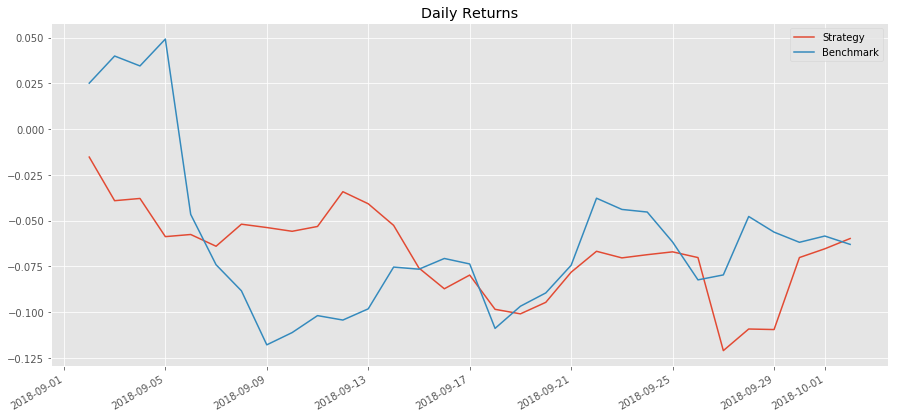

In [13]:
plt.figure(figsize=(15, 7))
plt.title("Daily Returns")
perfomance.algorithm_period_return.plot(label="Strategy")
perfomance.benchmark_period_return.plot(label="Benchmark")
plt.legend();

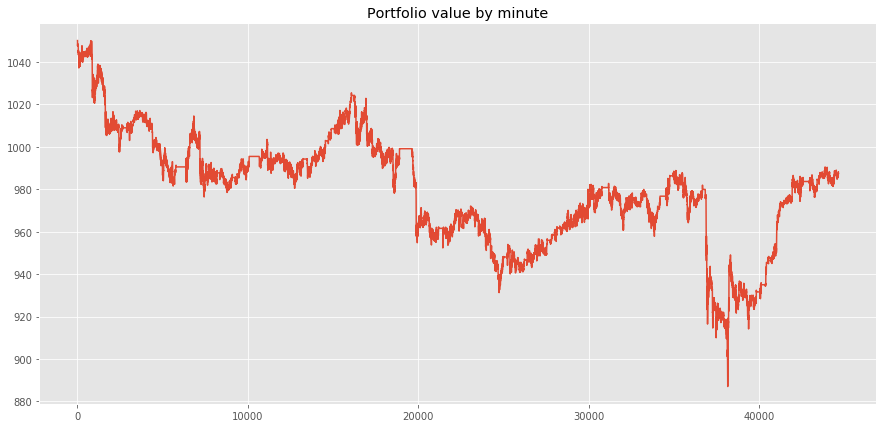

In [15]:
plt.figure(figsize=(15, 7))
plt.title("Portfolio value by minute")
plt.plot(portfolio_value)

Sharpe Ratio: -1.6857595954975542


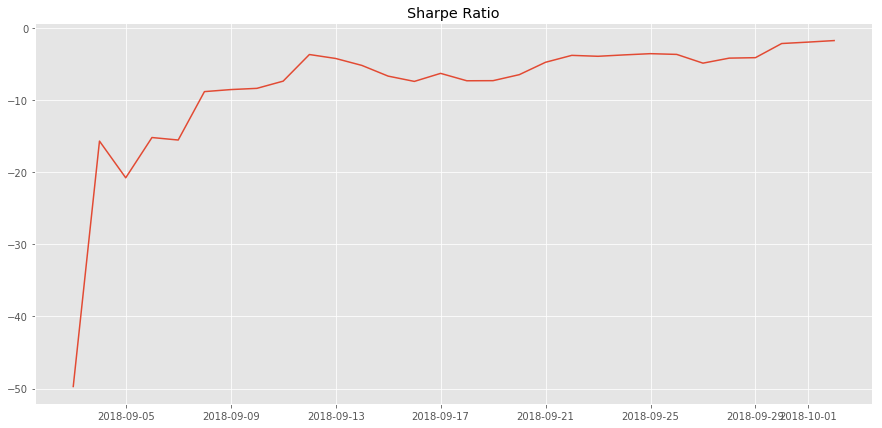

In [16]:
plt.figure(figsize=(15, 7))
plt.title("Sharpe Ratio")
plt.plot(perfomance.sharpe)
print("Sharpe Ratio:", perfomance.sharpe[-1])

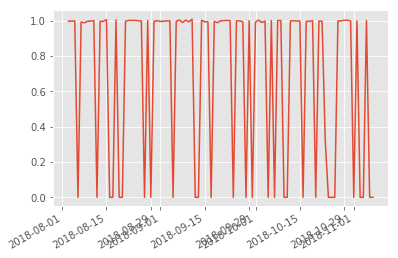

In [51]:
perfomance.gross_leverage.plot()